# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


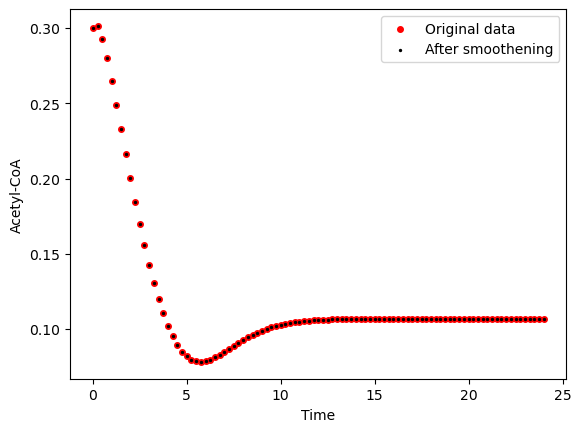

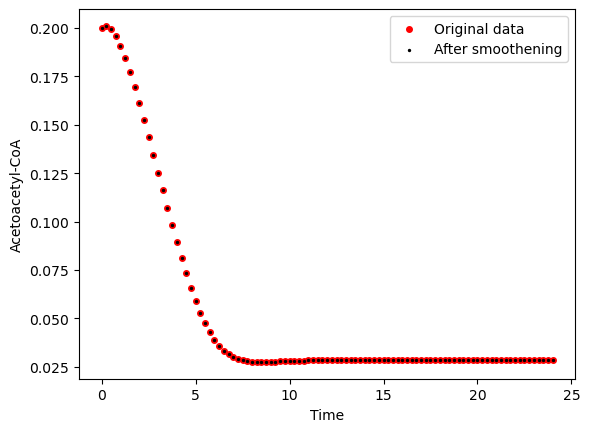

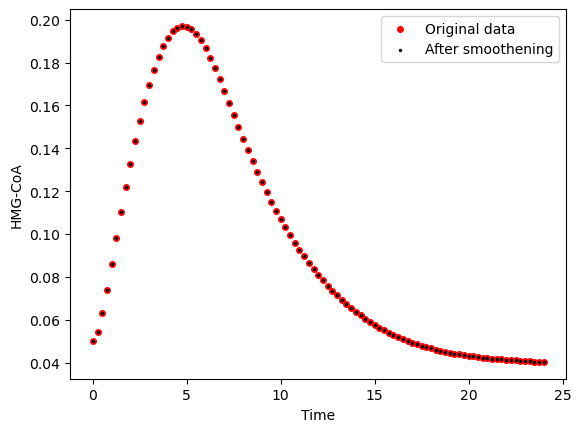

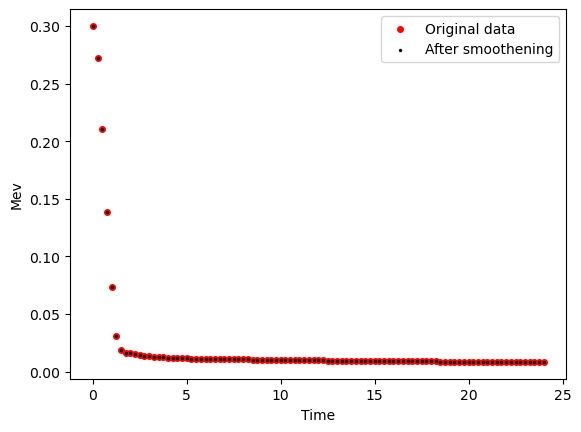

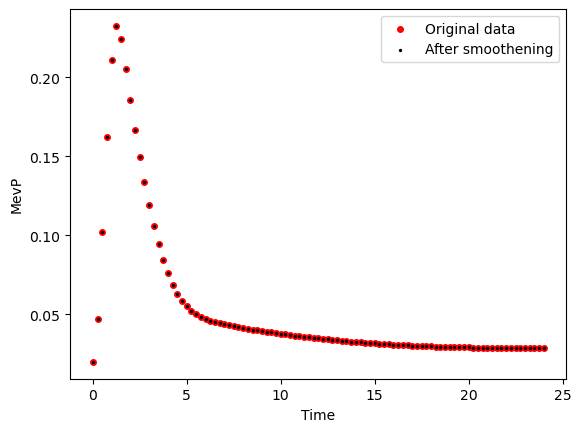

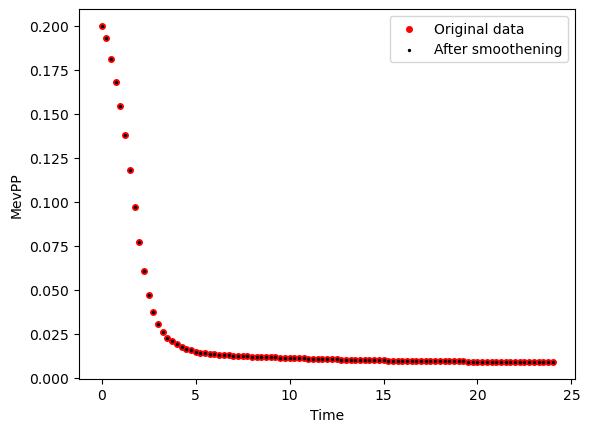

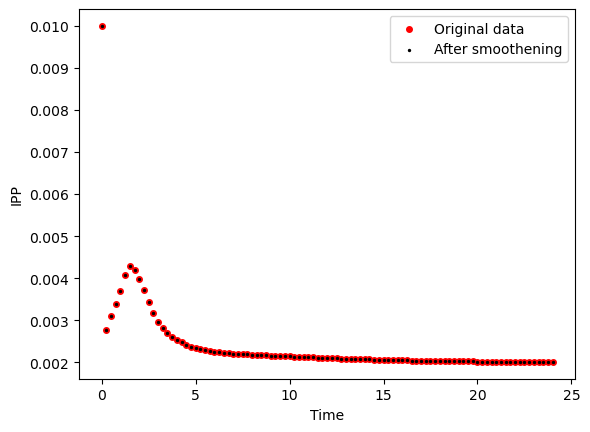

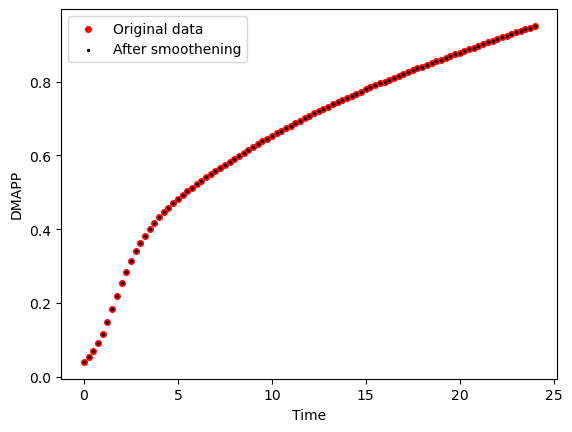

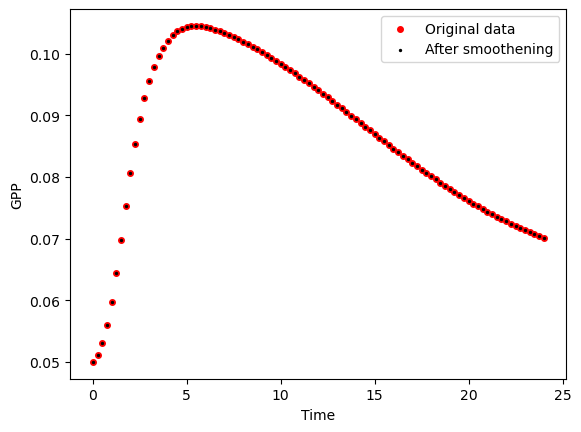

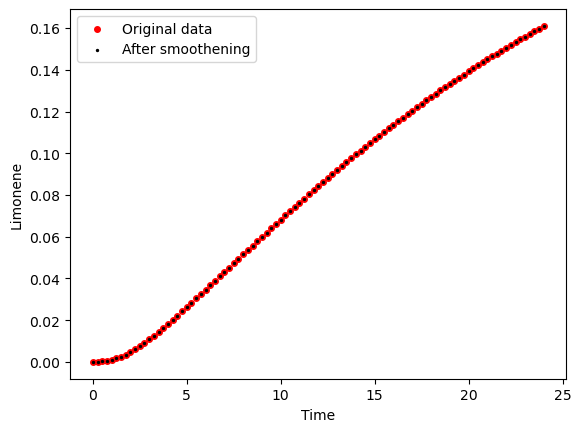

Strain Strain 2


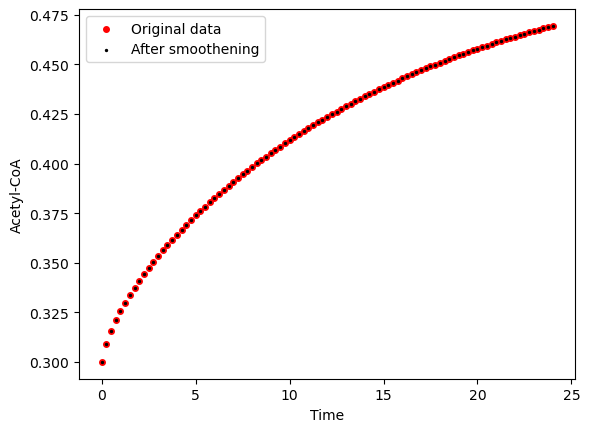

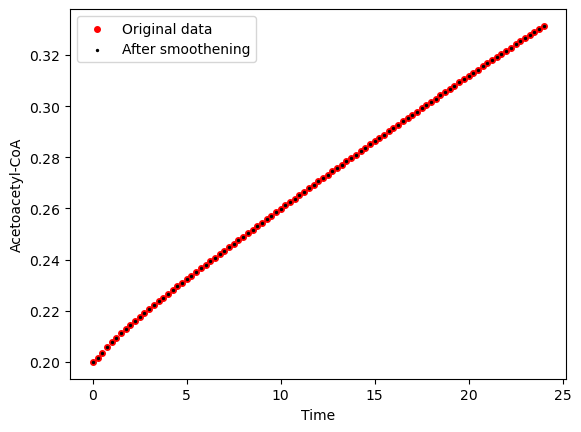

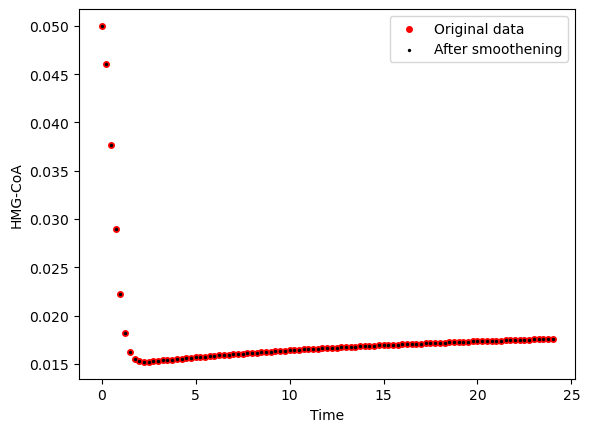

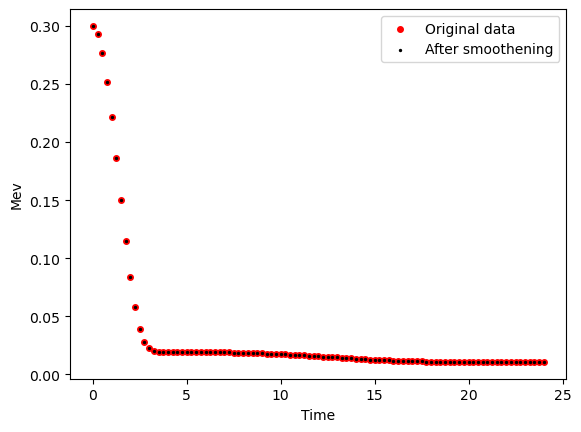

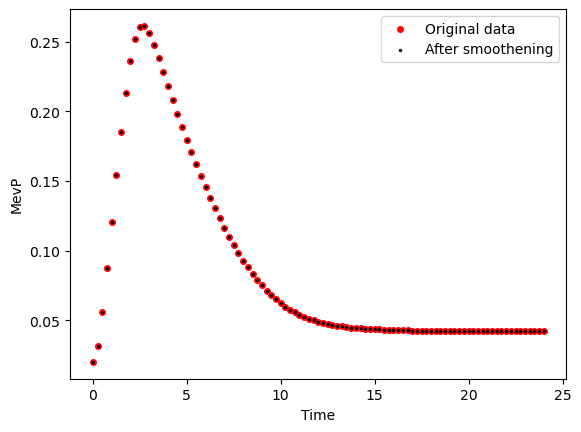

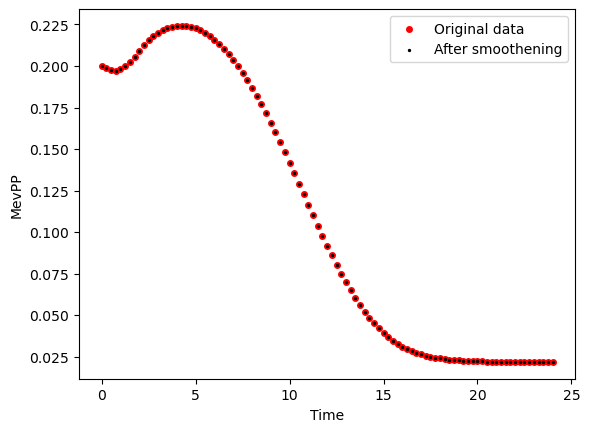

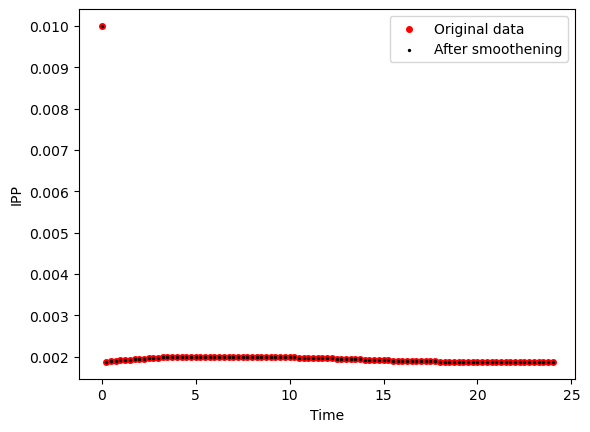

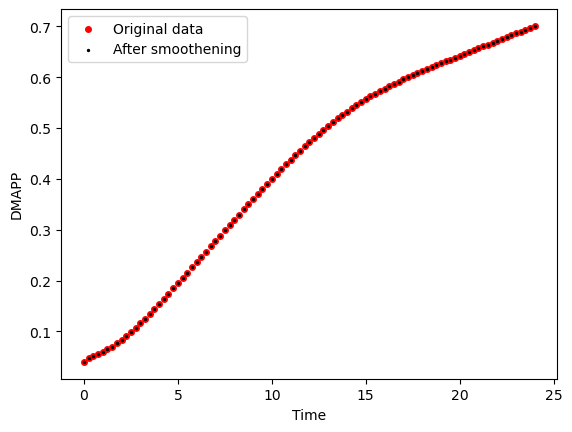

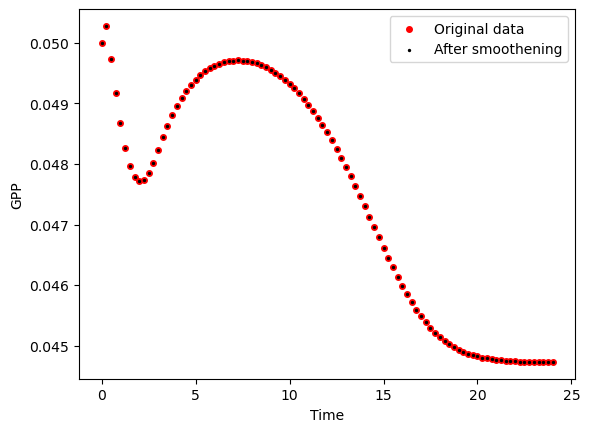

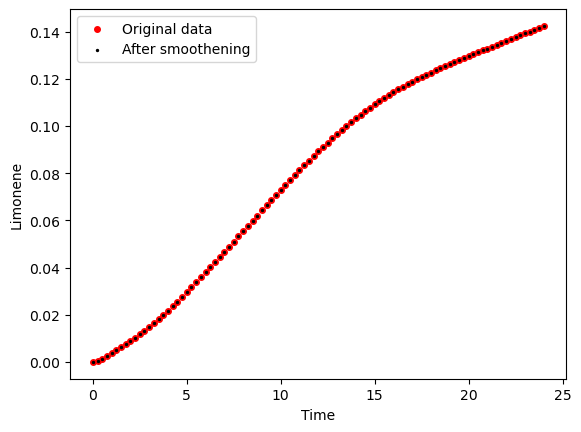

Strain Strain 3


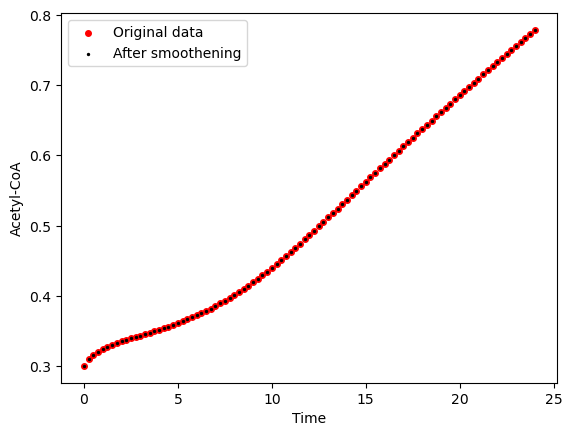

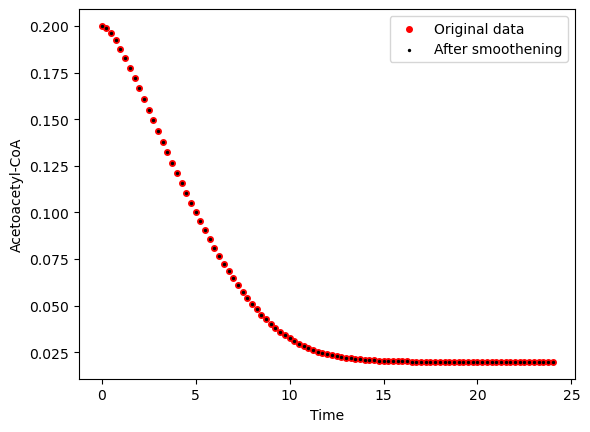

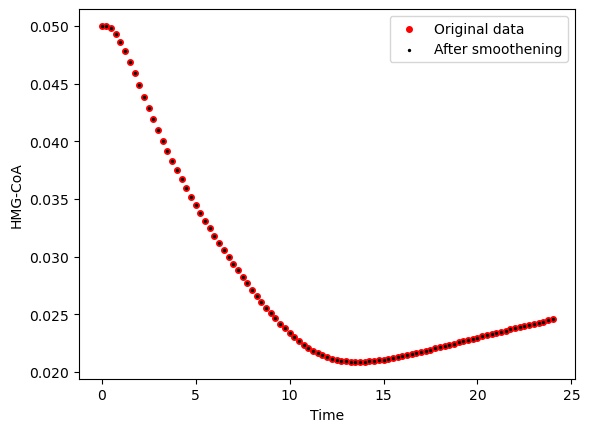

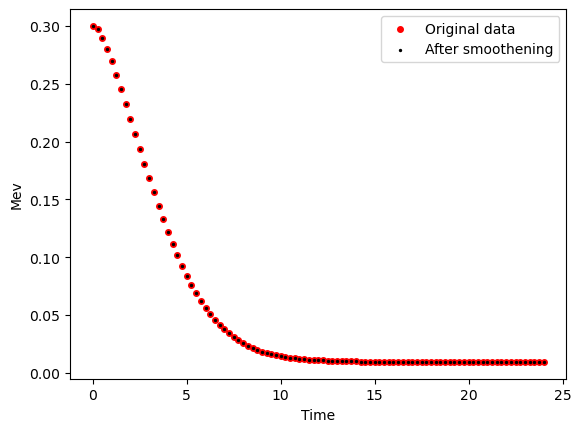

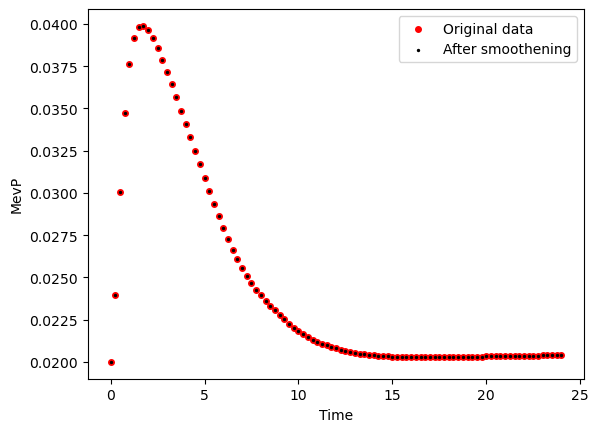

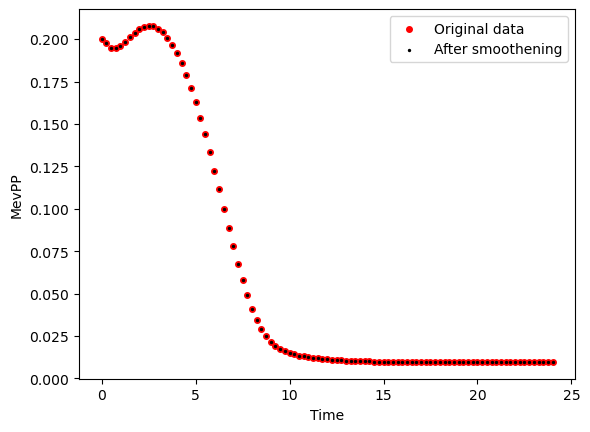

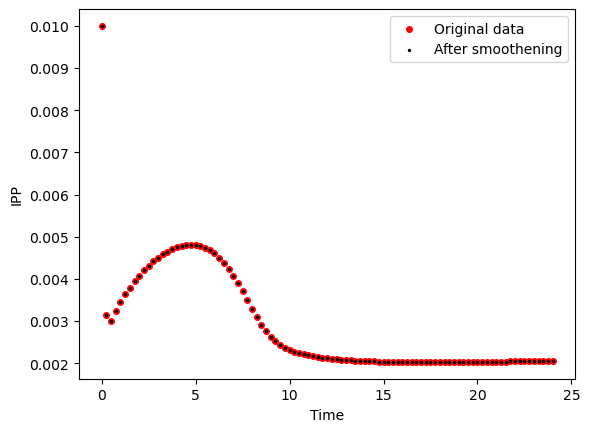

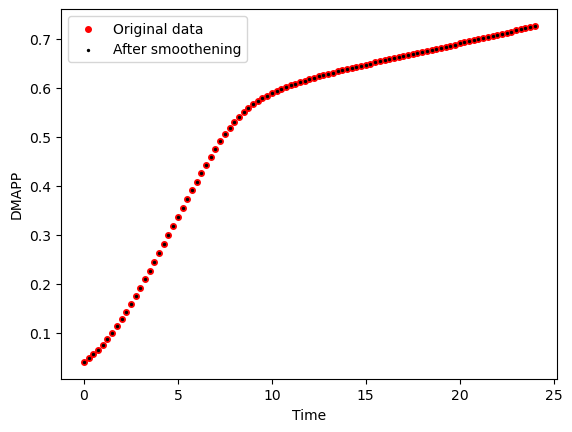

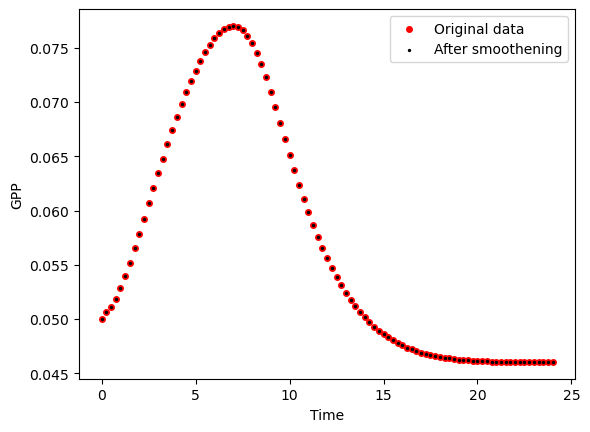

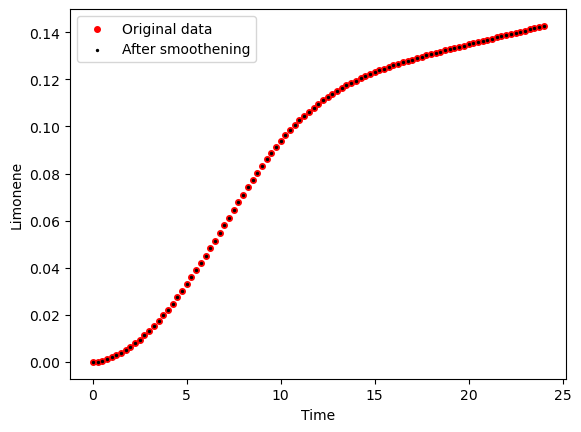

Strain WT


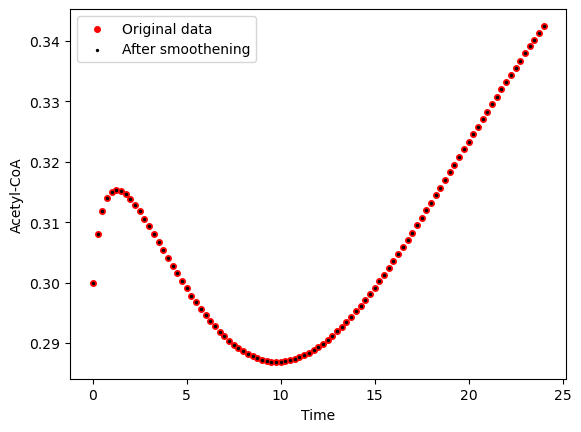

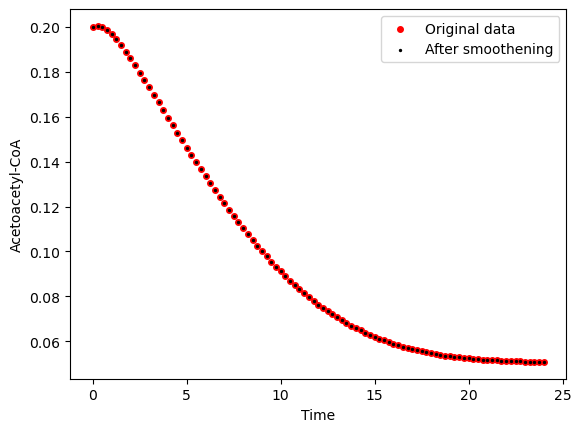

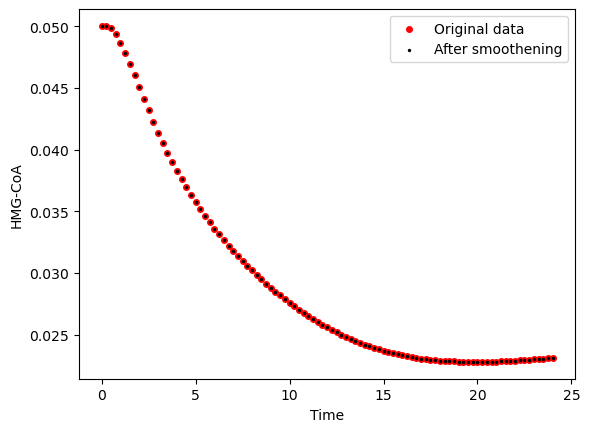

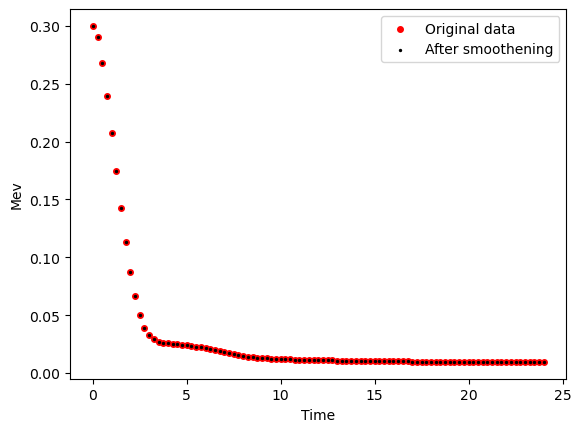

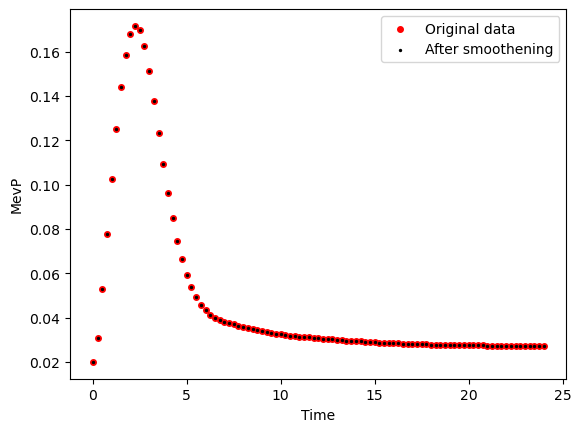

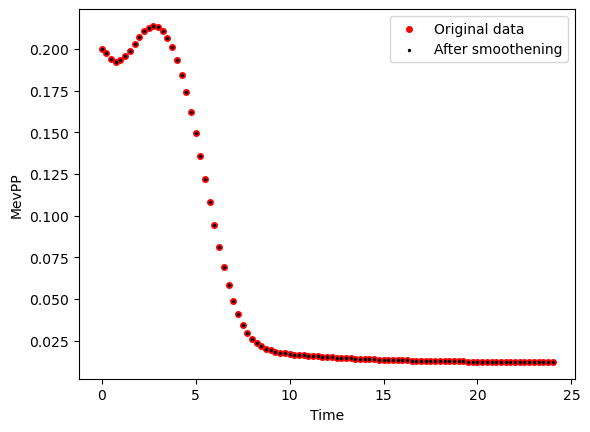

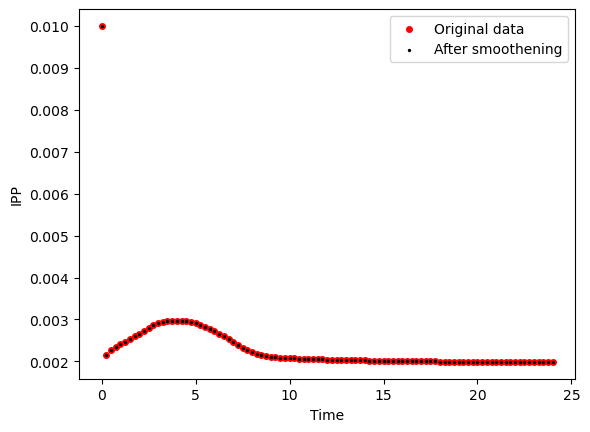

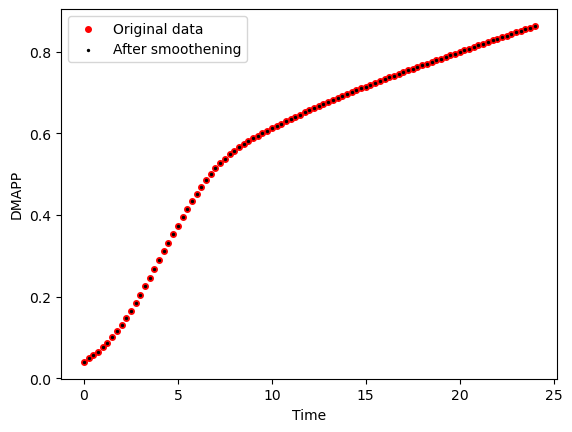

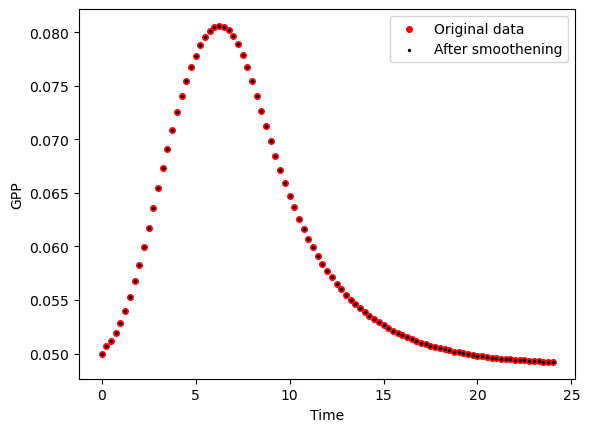

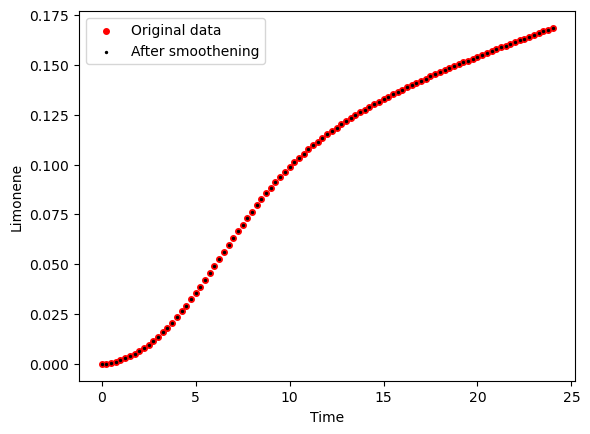

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


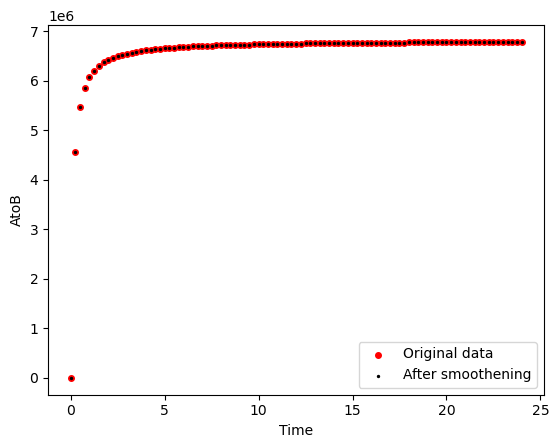

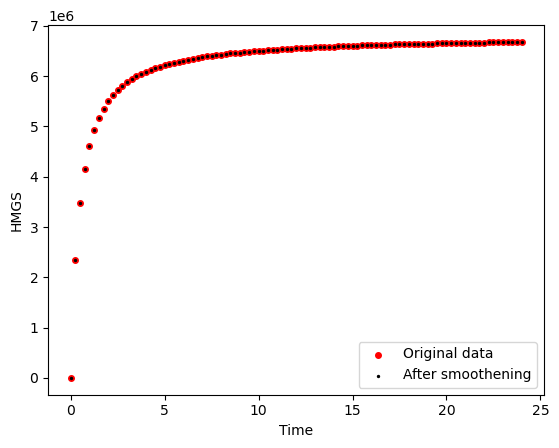

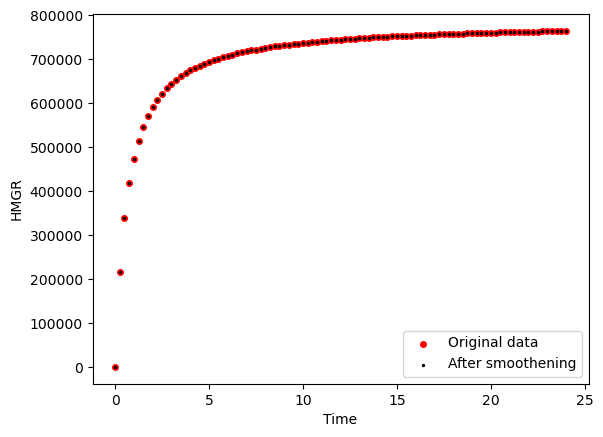

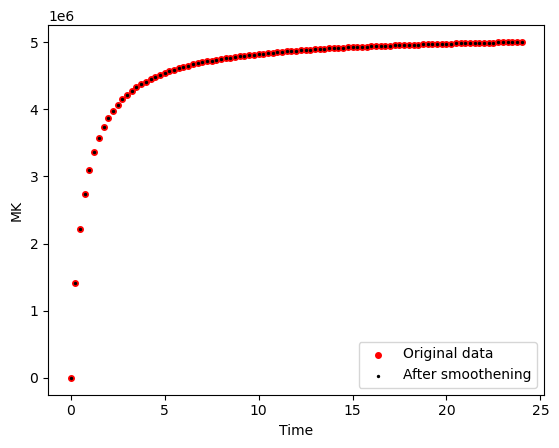

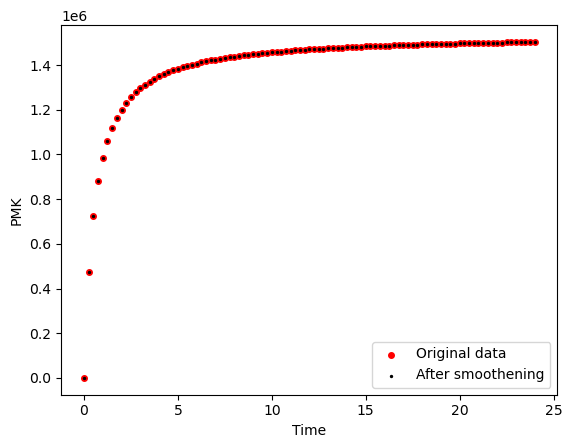

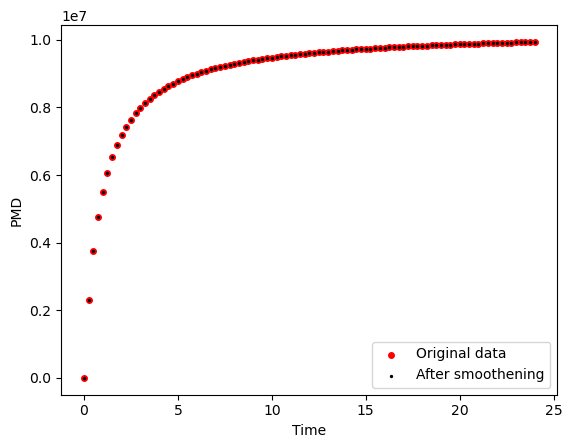

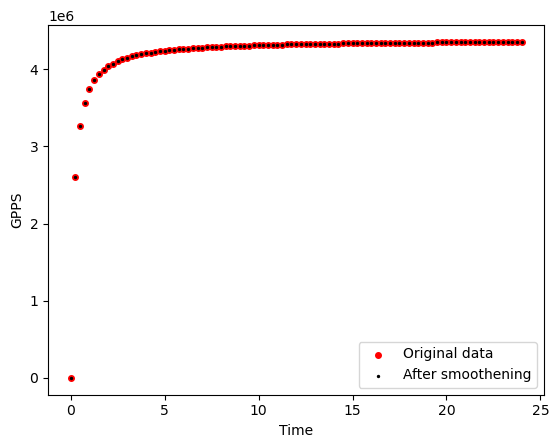

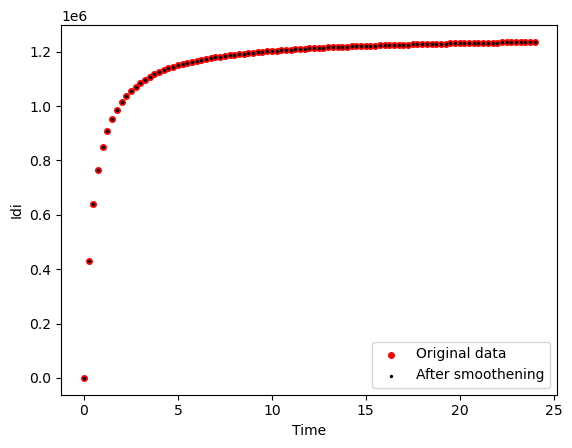

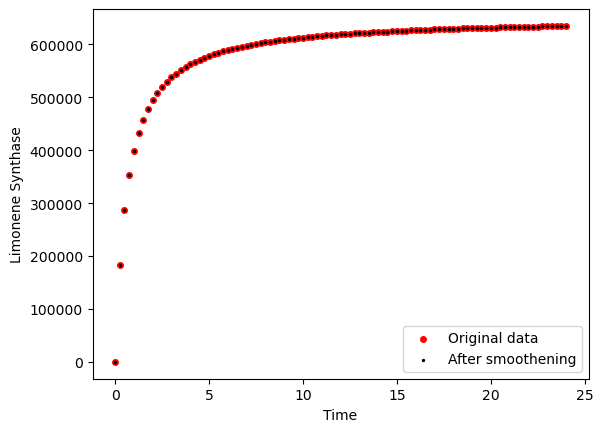

Strain Strain 2


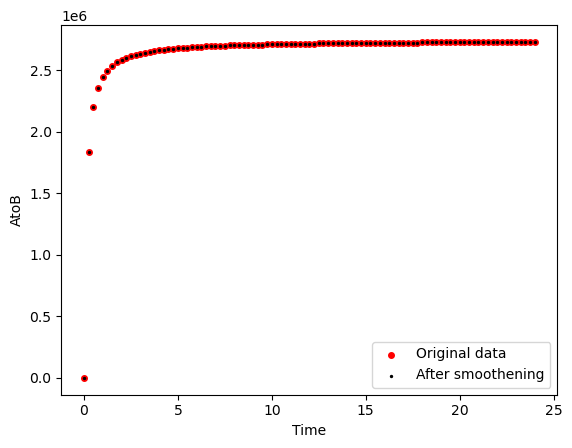

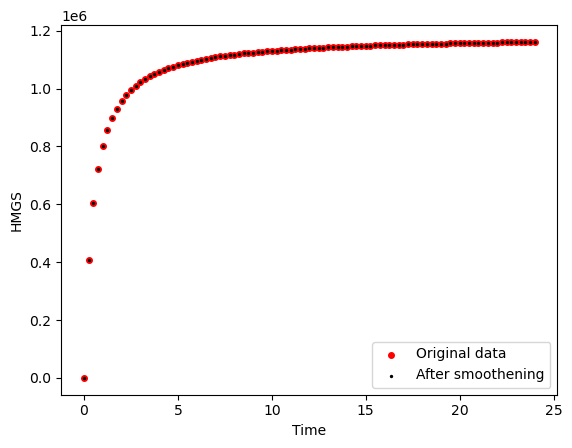

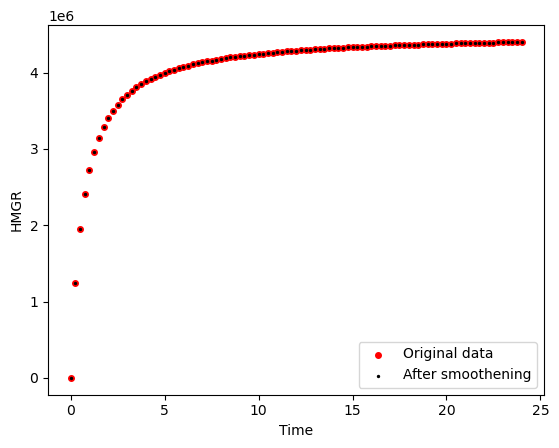

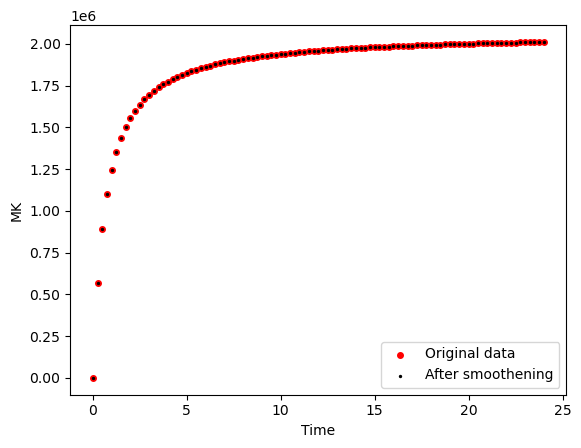

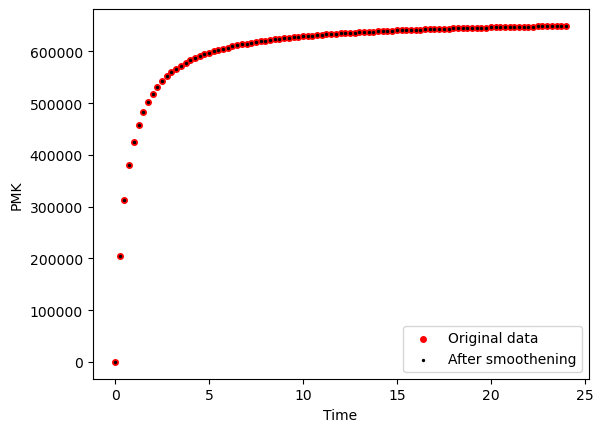

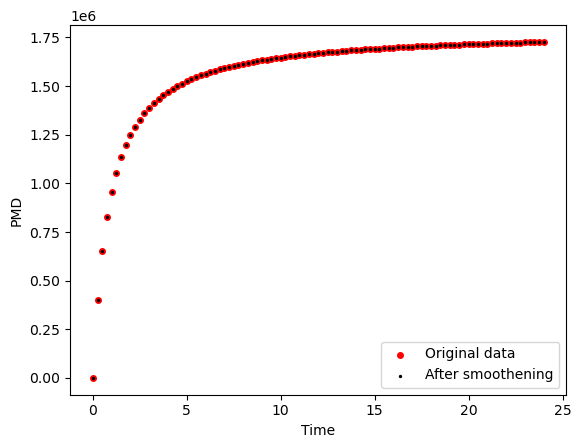

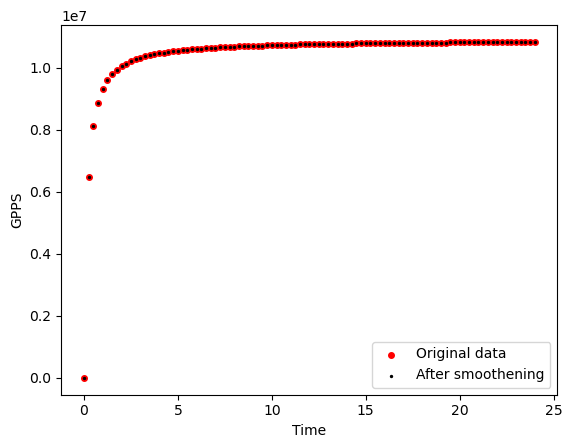

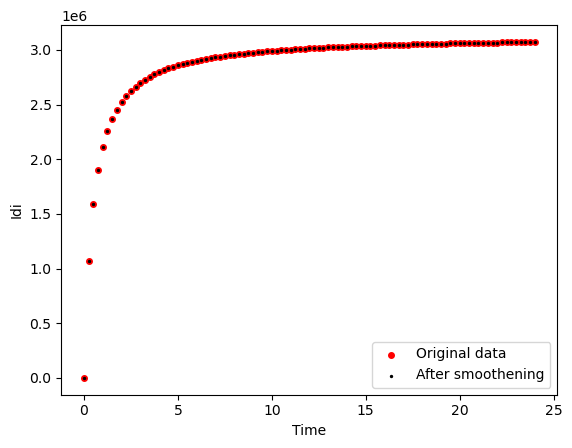

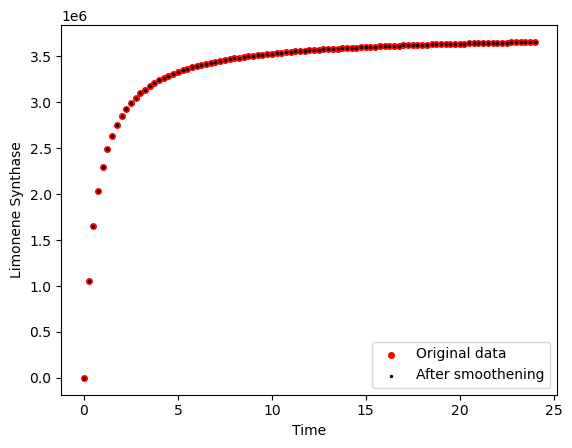

Strain Strain 3


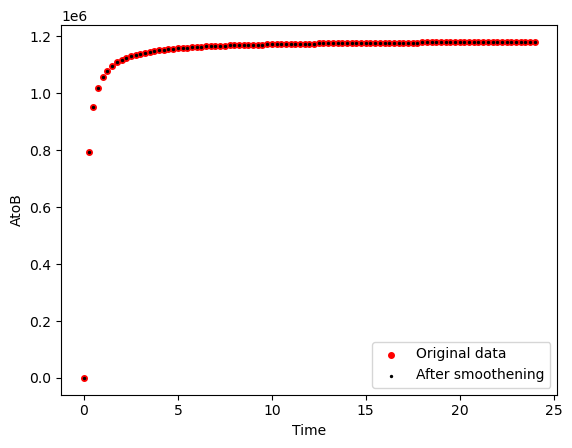

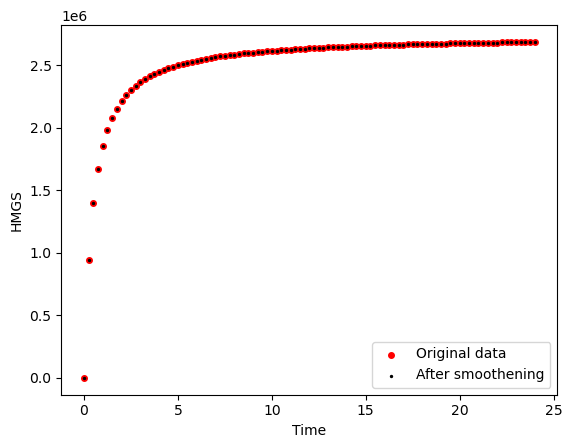

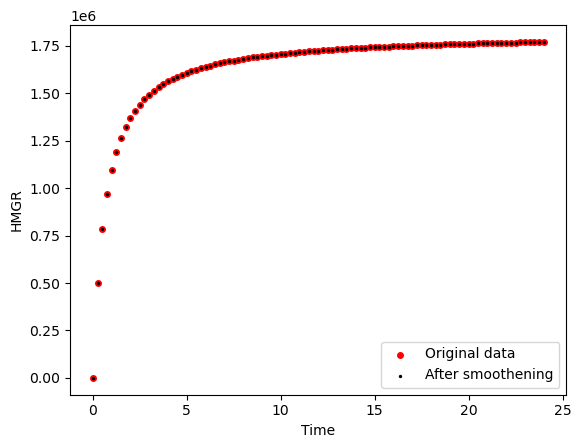

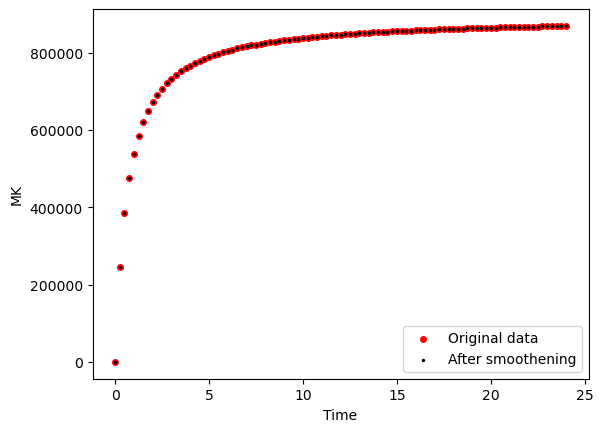

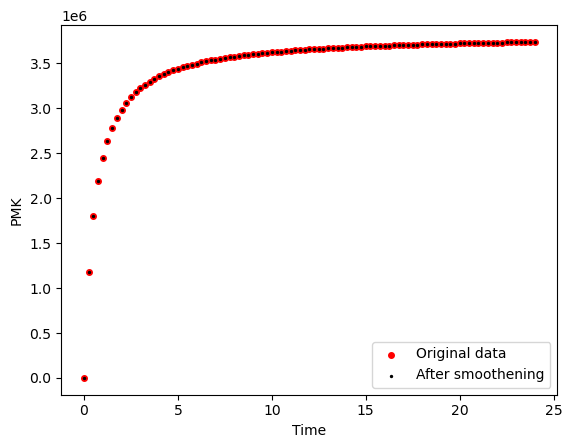

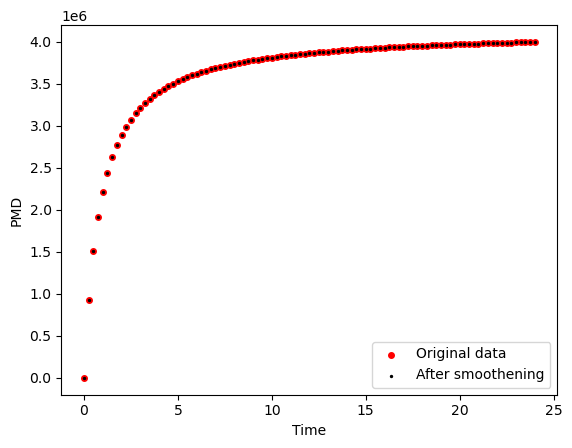

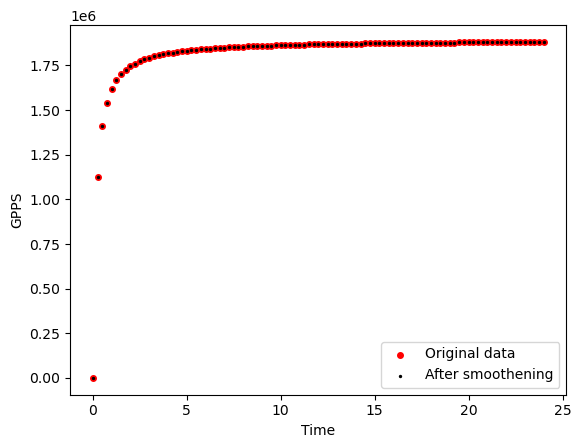

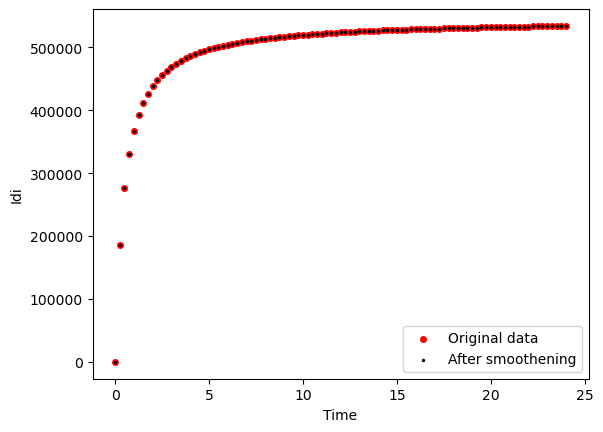

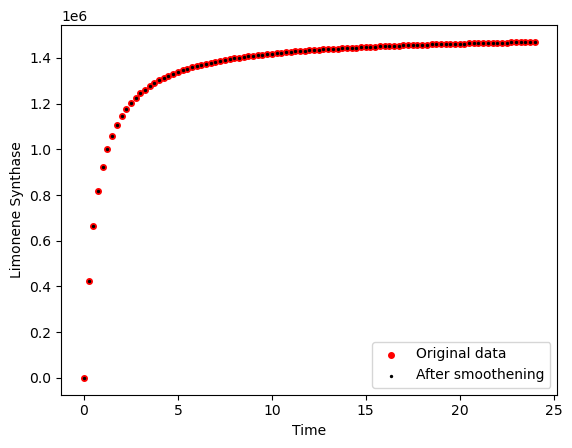

Strain WT


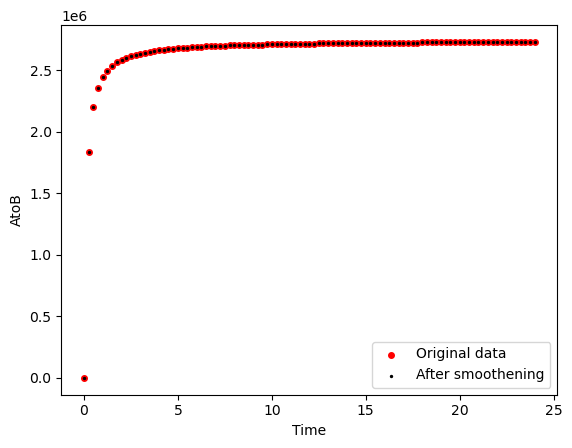

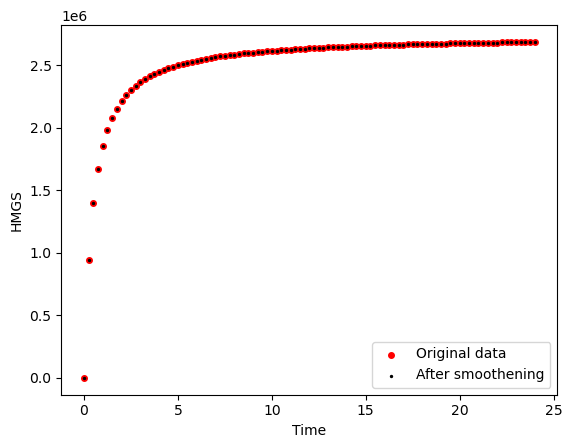

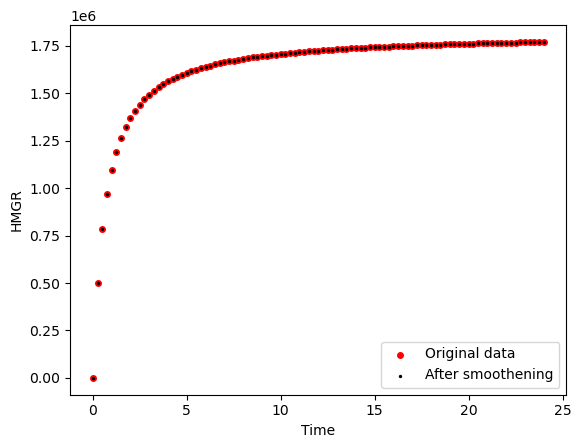

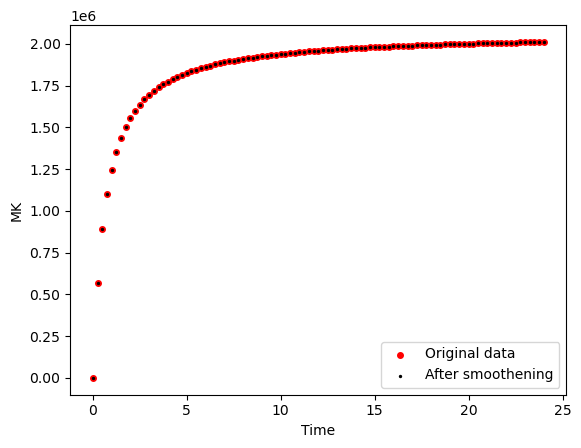

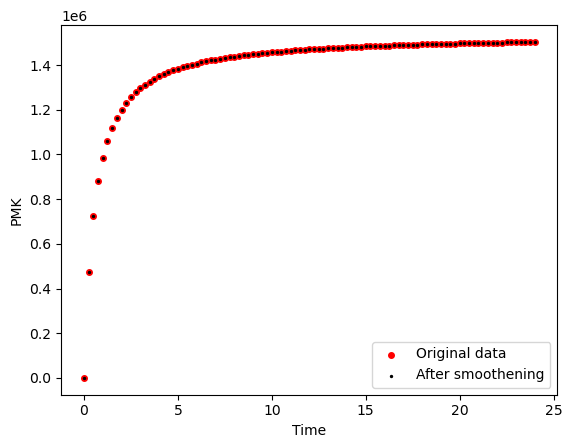

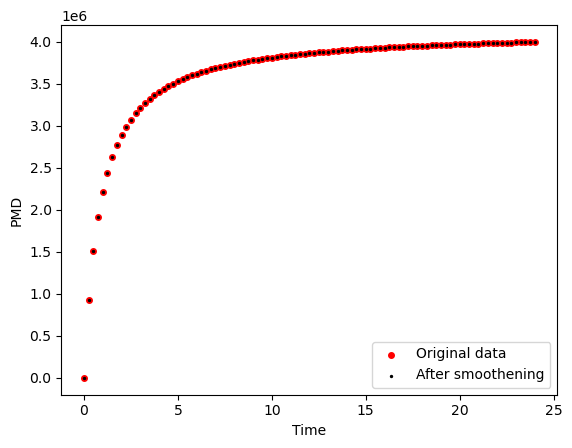

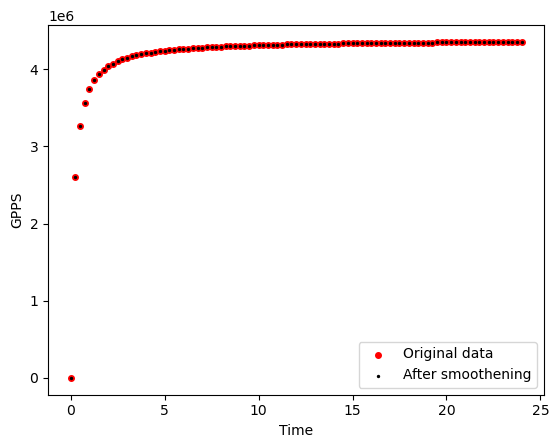

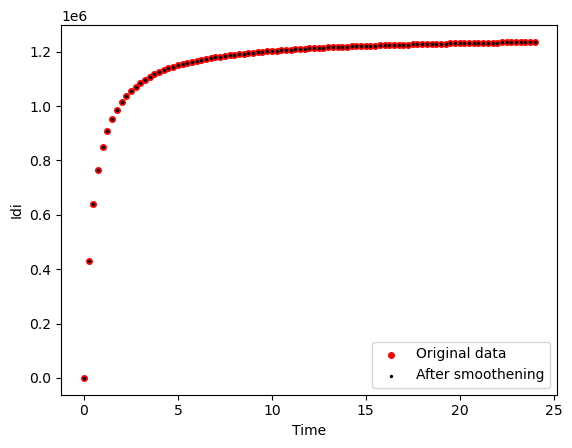

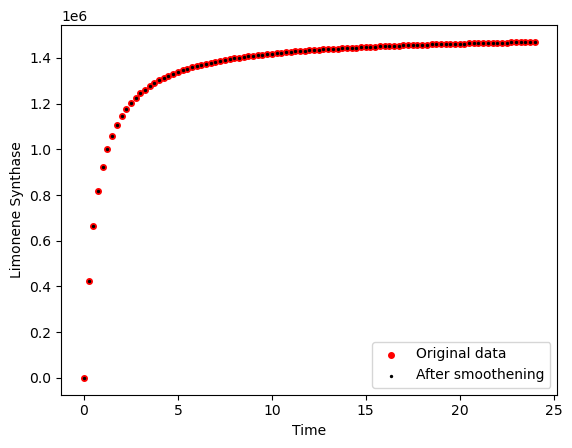

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

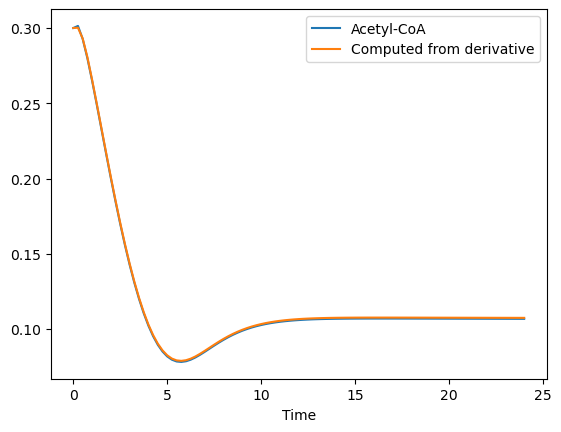

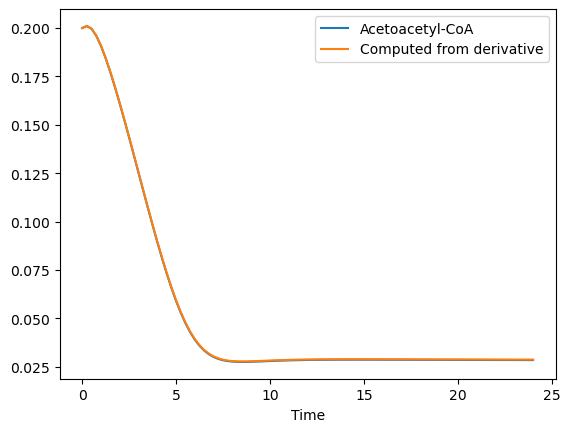

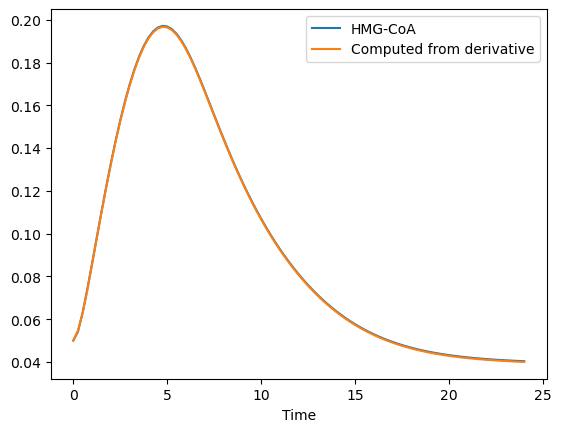

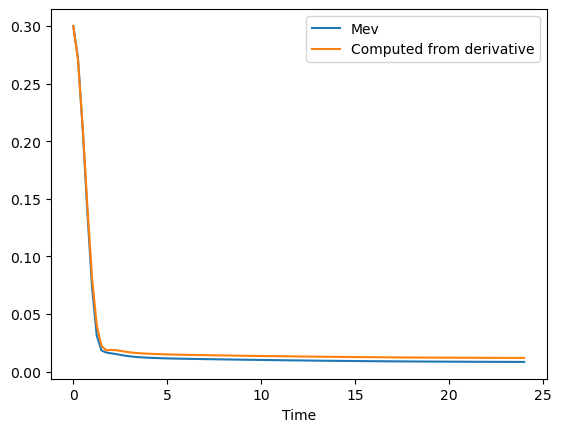

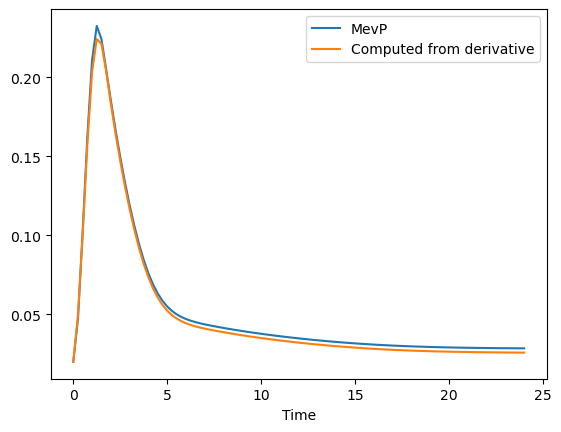

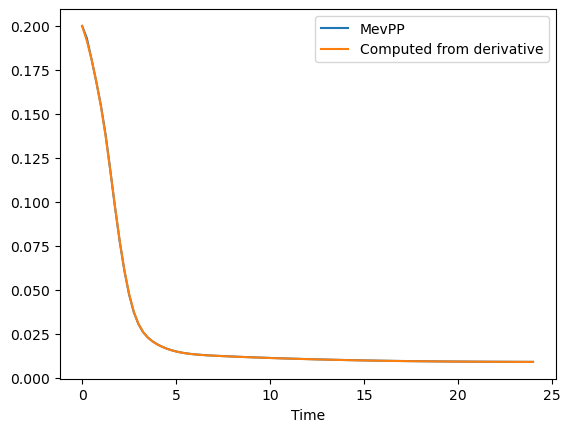

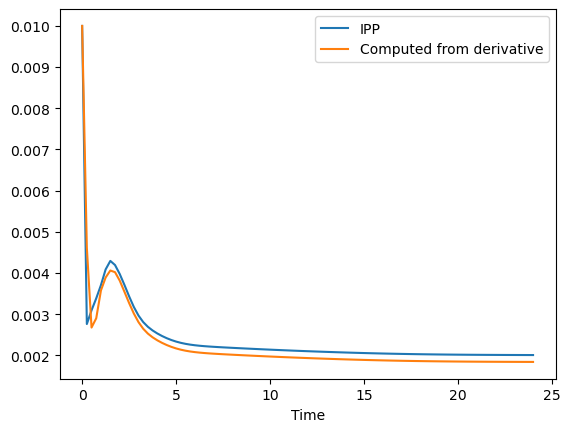

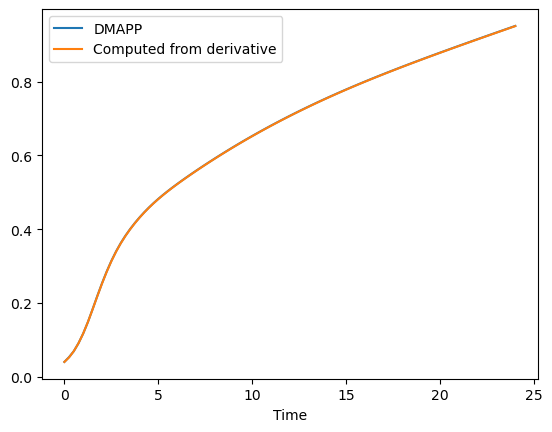

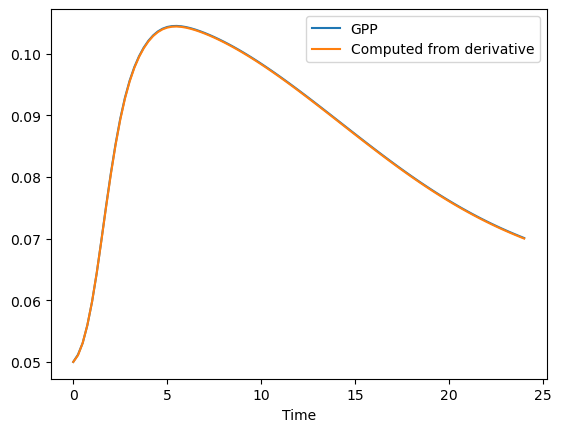

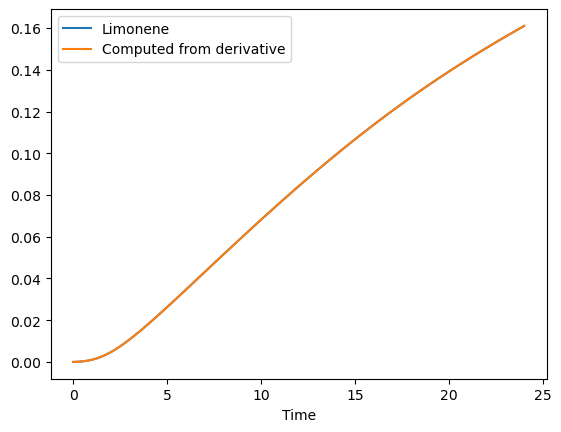

'Time profile from derivative vs. actual profile for Strain 2'

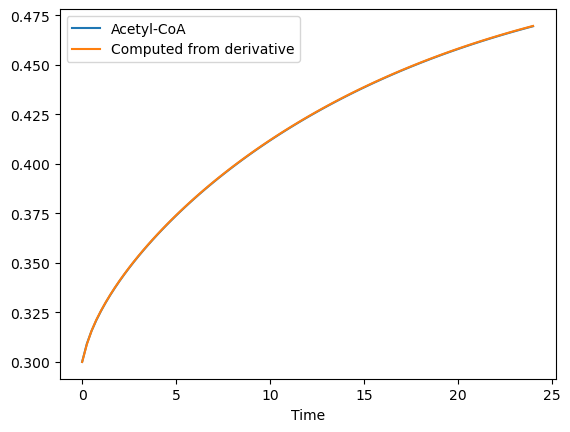

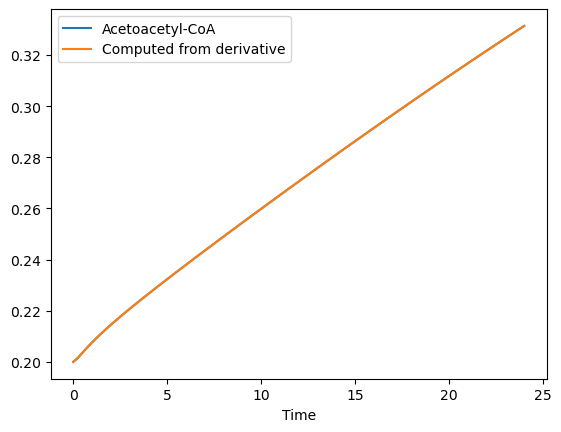

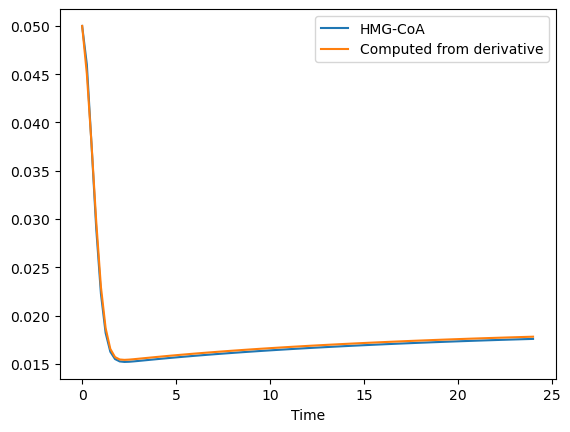

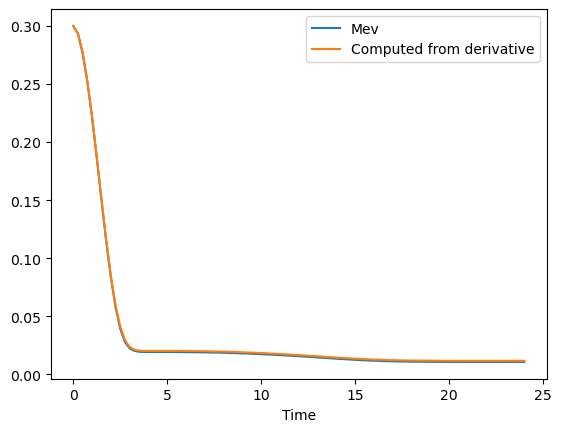

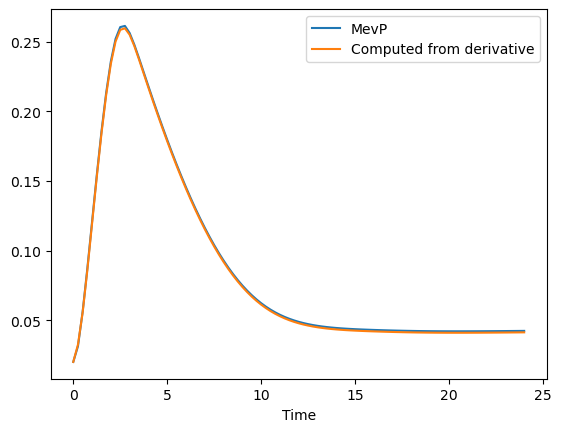

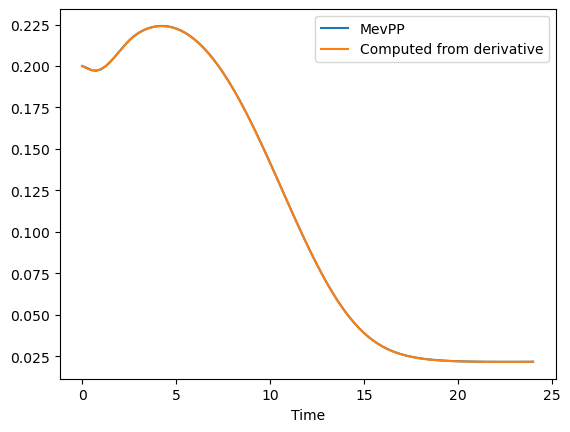

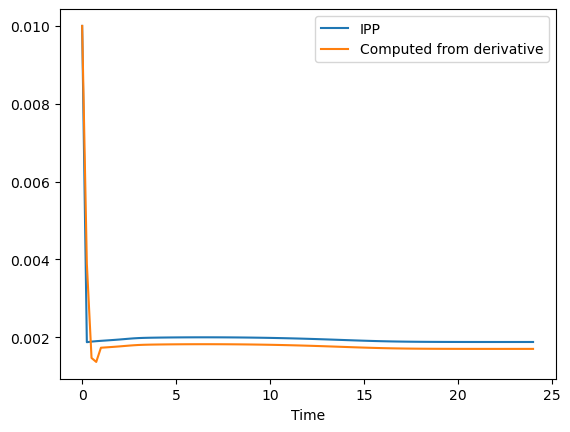

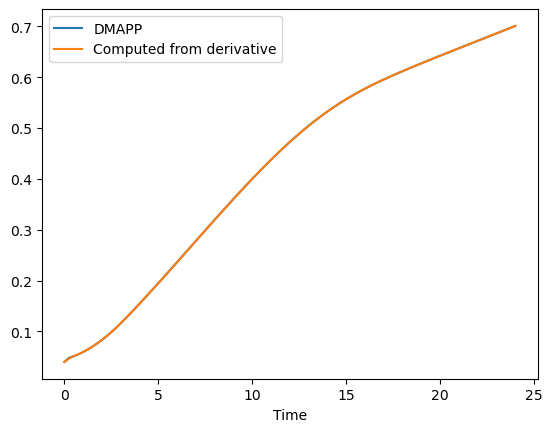

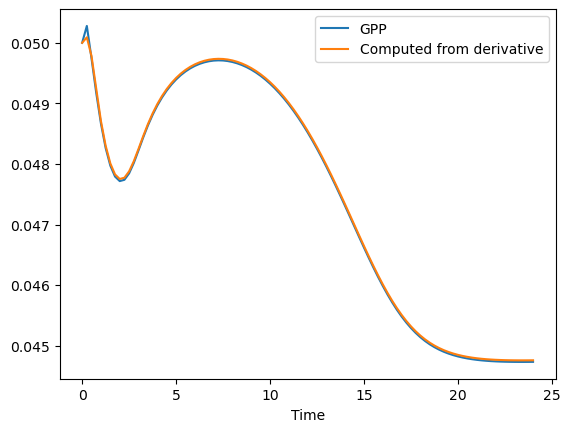

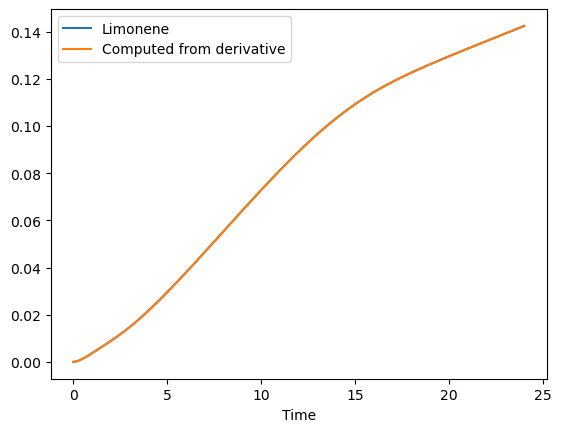

'Time profile from derivative vs. actual profile for Strain 3'

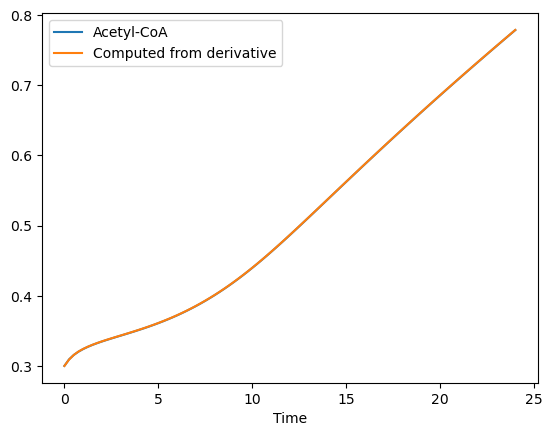

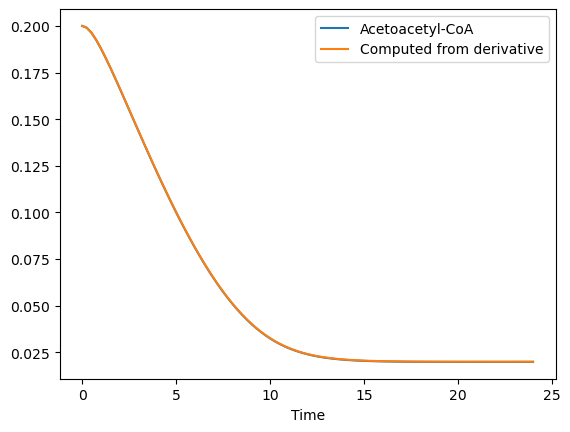

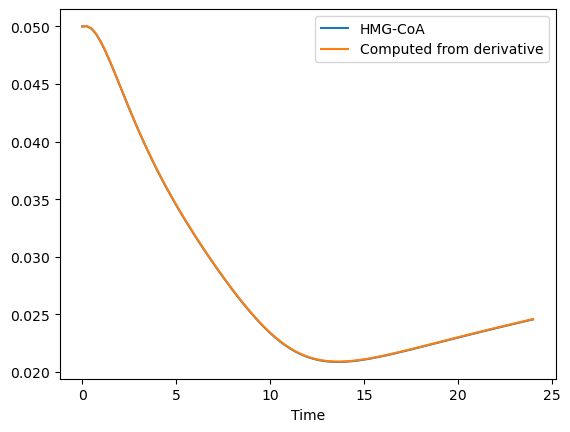

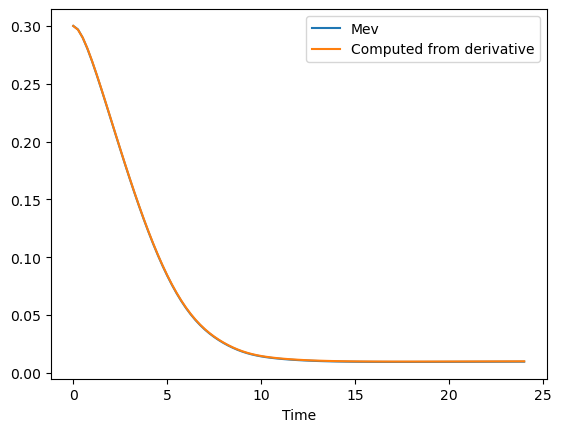

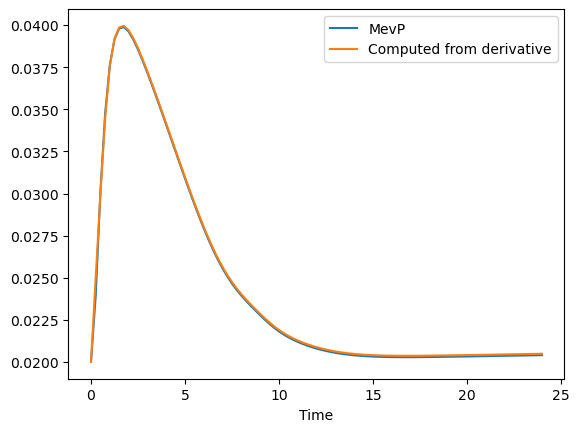

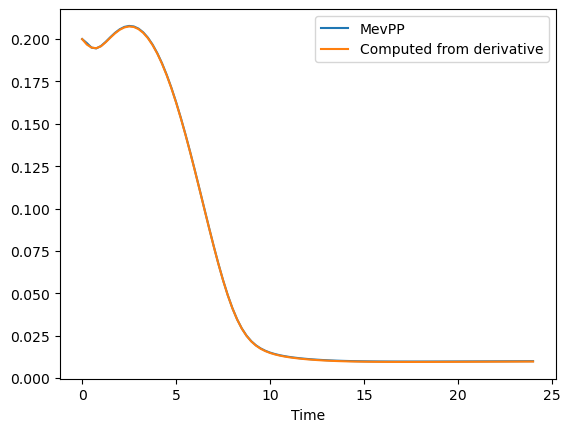

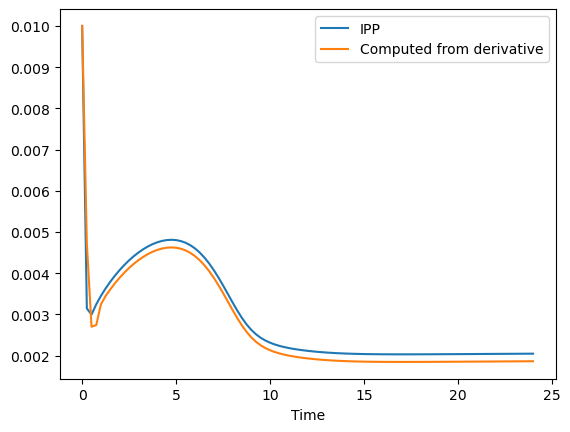

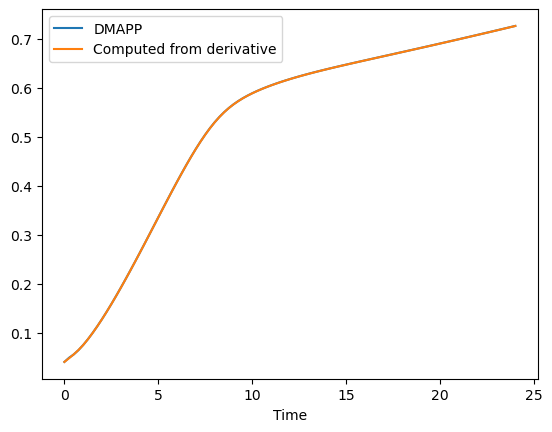

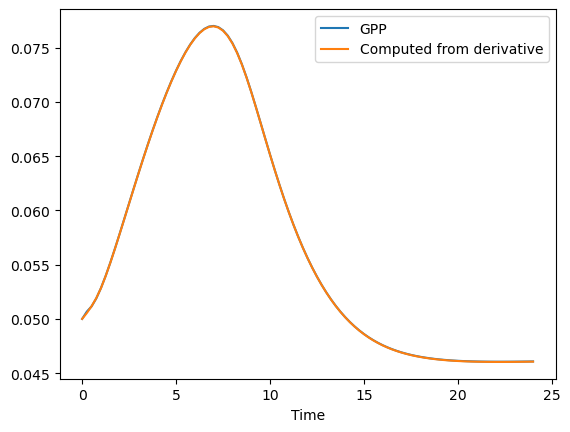

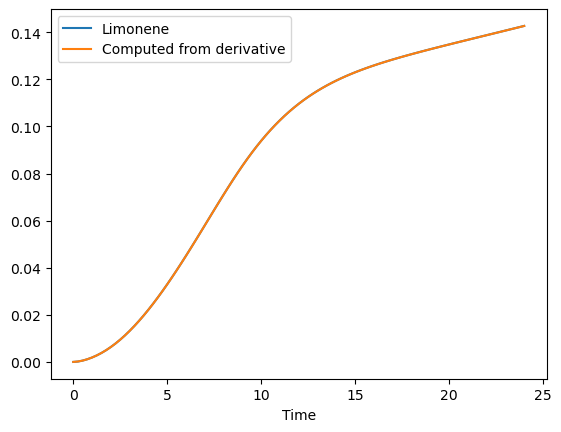

'Time profile from derivative vs. actual profile for WT'

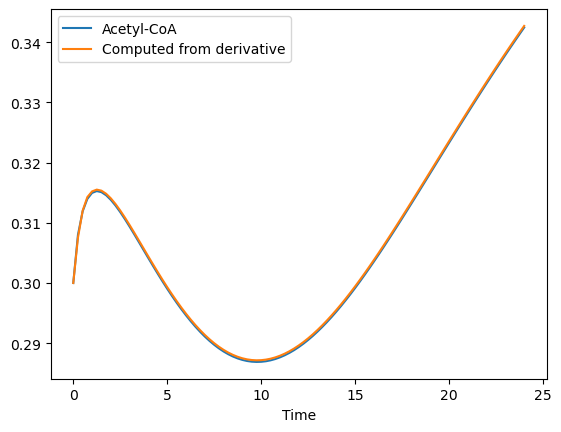

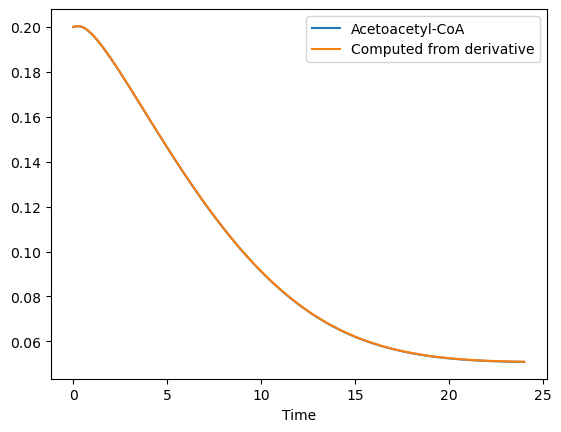

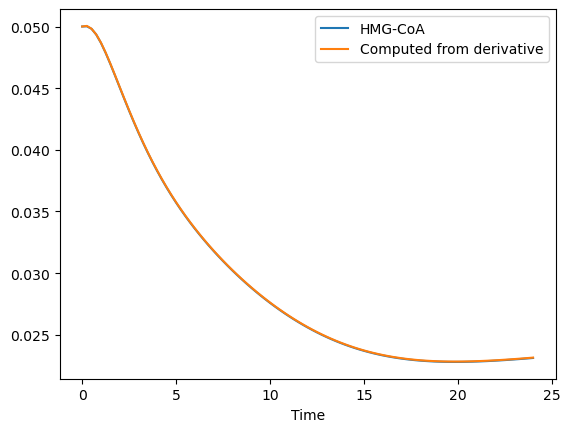

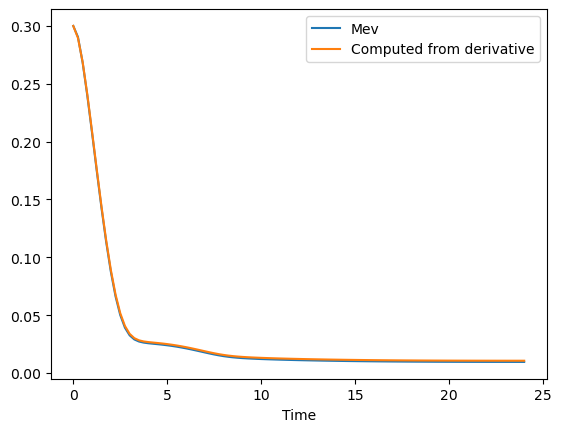

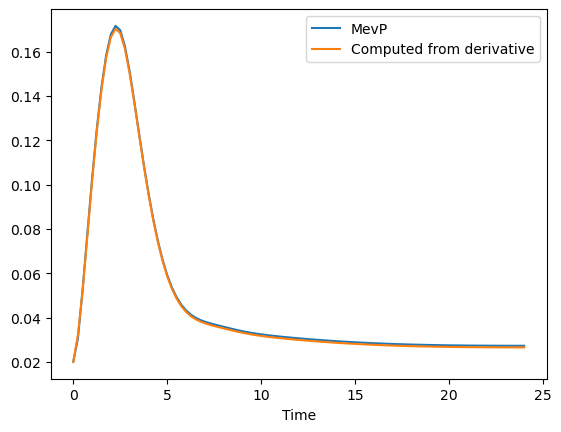

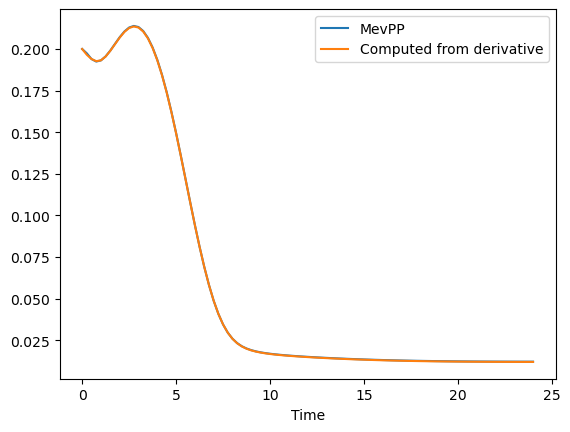

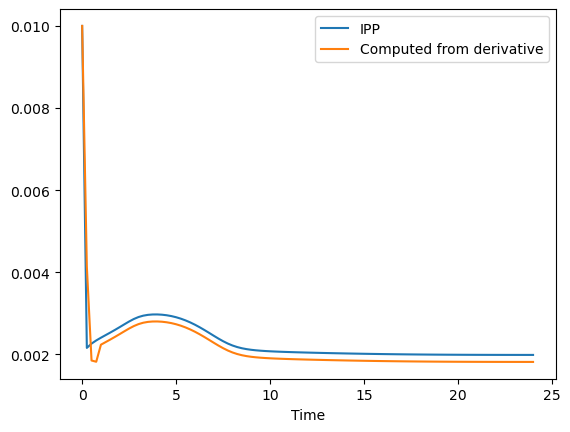

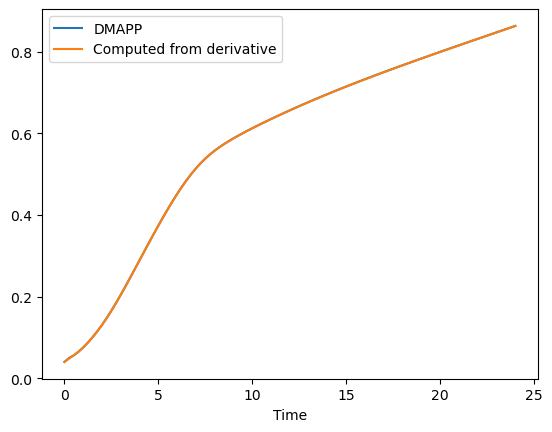

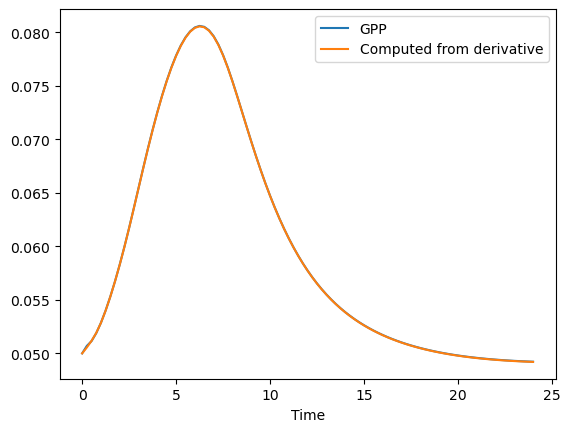

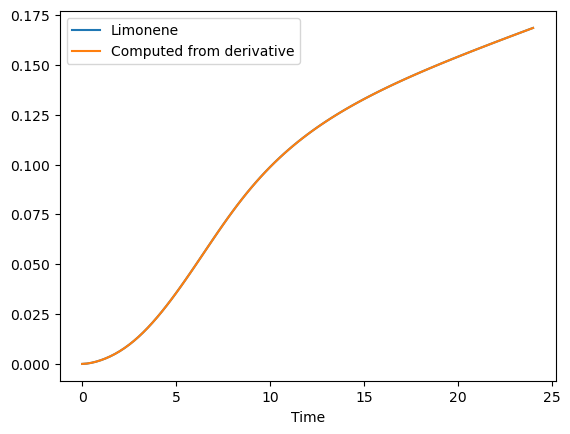

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  3.906073E+18 |  3.410264E+16
     2 |       74 |  3.771526E+15 |  2.141417E+13
     3 |      138 |  3.680316E+14 |  4.610641E+12
     4 |      202 |  4.412406E+14 |  4.610641E+12
     5 |      266 |  4.224596E+13 |  1.795182E+11
     6 |      330 |  8.816272E+12 |  6.863779E+10
     7 |      394 |  5.780341E+11 |  5.646019E+08
     8 |      458 |  3.392968E+11 |  5.646019E+08
     9 |      522 |  9.823790E+10 |  5.646019E+08
    10 |      586 |  2.065999E+11 |  5.646019E+08
    11 |      650 |  1.112656E+10 |  8.834571E+07
    12 |      714 |  2.598544E+09 |  2.487745E+06
    13 |      778 |  7.587779E+08 |  2.487745E+06
    14 |      842 |  2.353046E+09 |  2.294565E+06
    15 |      906 |  4.411423E+08 |  2.294565E+06
    16 |      970 |  8.530272E+07 |  2.294565E+06
    17 |     1034 |  1.092450E+08 |  2.294565E+06
    18 |     1098 |  2.674916E+07 |  2.294565E+06
    19 |     1162 |  1.87

   162 |    10314 |  4.426052E+01 |  4.291806E+01
   163 |    10378 |  4.423434E+01 |  4.291806E+01
   164 |    10442 |  4.438227E+01 |  4.291806E+01
   165 |    10506 |  4.427539E+01 |  4.291806E+01
   166 |    10570 |  4.409307E+01 |  4.291806E+01
   167 |    10634 |  4.386274E+01 |  4.291806E+01
   168 |    10698 |  4.396009E+01 |  4.291806E+01
   169 |    10762 |  4.374431E+01 |  4.291806E+01
   170 |    10826 |  4.388447E+01 |  4.291806E+01
   171 |    10890 |  4.386731E+01 |  4.291806E+01
   172 |    10954 |  4.365404E+01 |  4.291806E+01
   173 |    11018 |  4.369496E+01 |  4.291806E+01
   174 |    11082 |  4.356468E+01 |  4.291806E+01
   175 |    11146 |  4.353237E+01 |  4.291806E+01
   176 |    11210 |  4.360475E+01 |  4.291806E+01
   177 |    11274 |  4.365531E+01 |  4.291806E+01
   178 |    11338 |  4.376544E+01 |  4.291806E+01
   179 |    11402 |  4.359835E+01 |  4.291806E+01
   180 |    11466 |  4.356344E+01 |  4.291806E+01
   181 |    11530 |  4.341036E+01 |  4.291806E+01


   326 |    20810 |  2.795881E+01 |  2.779478E+01
   327 |    20874 |  2.789282E+01 |  2.779478E+01
   328 |    20938 |  2.781888E+01 |  2.760563E+01
   329 |    21002 |  2.777665E+01 |  2.760563E+01
   330 |    21066 |  2.770429E+01 |  2.755262E+01
   331 |    21130 |  2.762739E+01 |  2.746463E+01
   332 |    21194 |  2.754979E+01 |  2.744845E+01
   333 |    21258 |  2.753515E+01 |  2.739655E+01
   334 |    21322 |  2.751463E+01 |  2.739655E+01
   335 |    21386 |  2.742984E+01 |  2.731114E+01
   336 |    21450 |  2.731131E+01 |  2.714979E+01
   337 |    21514 |  2.714520E+01 |  2.684511E+01
   338 |    21578 |  2.703995E+01 |  2.671480E+01
   339 |    21642 |  2.691366E+01 |  2.670746E+01
   340 |    21706 |  2.682727E+01 |  2.665931E+01
   341 |    21770 |  2.667151E+01 |  2.640706E+01
   342 |    21834 |  2.643351E+01 |  2.611063E+01
   343 |    21898 |  2.621511E+01 |  2.604762E+01
   344 |    21962 |  2.612491E+01 |  2.600336E+01
   345 |    22026 |  2.607204E+01 |  2.599239E+01


   490 |    31306 |  2.070692E+01 |  2.066929E+01
   491 |    31370 |  2.068942E+01 |  2.065654E+01
   492 |    31434 |  2.066846E+01 |  2.063631E+01
   493 |    31498 |  2.065035E+01 |  2.060800E+01
   494 |    31562 |  2.062849E+01 |  2.057271E+01
   495 |    31626 |  2.061229E+01 |  2.057271E+01
   496 |    31690 |  2.059913E+01 |  2.057271E+01
   497 |    31754 |  2.058074E+01 |  2.055259E+01
   498 |    31818 |  2.056765E+01 |  2.054840E+01
   499 |    31882 |  2.055509E+01 |  2.054024E+01
   500 |    31946 |  2.054093E+01 |  2.050200E+01
   501 |    32010 |  2.052305E+01 |  2.049073E+01
   502 |    32074 |  2.049956E+01 |  2.048008E+01
   503 |    32138 |  2.048925E+01 |  2.048006E+01
   504 |    32202 |  2.048786E+01 |  2.044799E+01
   505 |    32266 |  2.048434E+01 |  2.044799E+01
   506 |    32330 |  2.047454E+01 |  2.044799E+01
   507 |    32394 |  2.046878E+01 |  2.043991E+01
   508 |    32458 |  2.046284E+01 |  2.043991E+01
   509 |    32522 |  2.045960E+01 |  2.043991E+01


   654 |    41802 |  1.994083E+01 |  1.992873E+01
   655 |    41866 |  1.993527E+01 |  1.992633E+01
   656 |    41930 |  1.993377E+01 |  1.992397E+01
   657 |    41994 |  1.992691E+01 |  1.991020E+01
   658 |    42058 |  1.992126E+01 |  1.991020E+01
   659 |    42122 |  1.991824E+01 |  1.990907E+01
   660 |    42186 |  1.991108E+01 |  1.990474E+01
   661 |    42250 |  1.990415E+01 |  1.988878E+01
   662 |    42314 |  1.989704E+01 |  1.987447E+01
   663 |    42378 |  1.988522E+01 |  1.987338E+01
   664 |    42442 |  1.987353E+01 |  1.986136E+01
   665 |    42506 |  1.986835E+01 |  1.985794E+01
   666 |    42570 |  1.986031E+01 |  1.985600E+01
   667 |    42634 |  1.985695E+01 |  1.984685E+01
   668 |    42698 |  1.985283E+01 |  1.984262E+01
   669 |    42762 |  1.984414E+01 |  1.983373E+01
   670 |    42826 |  1.983898E+01 |  1.983373E+01
   671 |    42890 |  1.983888E+01 |  1.983247E+01
   672 |    42954 |  1.982950E+01 |  1.982063E+01
   673 |    43018 |  1.982649E+01 |  1.982063E+01


   818 |    52298 |  1.914570E+01 |  1.914151E+01
   819 |    52362 |  1.914423E+01 |  1.914063E+01
   820 |    52426 |  1.914402E+01 |  1.914001E+01
   821 |    52490 |  1.914224E+01 |  1.914001E+01
   822 |    52554 |  1.914148E+01 |  1.913989E+01
   823 |    52618 |  1.914079E+01 |  1.913959E+01
   824 |    52682 |  1.913963E+01 |  1.913626E+01
   825 |    52746 |  1.913711E+01 |  1.913501E+01
   826 |    52810 |  1.913623E+01 |  1.913252E+01
   827 |    52874 |  1.913565E+01 |  1.913252E+01
   828 |    52938 |  1.913512E+01 |  1.913073E+01
   829 |    53002 |  1.913327E+01 |  1.912919E+01
   830 |    53066 |  1.913120E+01 |  1.912716E+01
   831 |    53130 |  1.912962E+01 |  1.912629E+01
   832 |    53194 |  1.912925E+01 |  1.912195E+01
   833 |    53258 |  1.912950E+01 |  1.912195E+01
   834 |    53322 |  1.912910E+01 |  1.912195E+01
   835 |    53386 |  1.912667E+01 |  1.912003E+01
   836 |    53450 |  1.912293E+01 |  1.911827E+01
   837 |    53514 |  1.912143E+01 |  1.910672E+01


   982 |    62794 |  1.895762E+01 |  1.895668E+01
   983 |    62858 |  1.895720E+01 |  1.895647E+01
   984 |    62922 |  1.895692E+01 |  1.895630E+01
   985 |    62986 |  1.895646E+01 |  1.895576E+01
   986 |    63050 |  1.895629E+01 |  1.895552E+01
   987 |    63114 |  1.895600E+01 |  1.895536E+01
   988 |    63178 |  1.895572E+01 |  1.895533E+01
   989 |    63242 |  1.895574E+01 |  1.895533E+01
   990 |    63306 |  1.895531E+01 |  1.895472E+01
   991 |    63370 |  1.895507E+01 |  1.895472E+01
   992 |    63434 |  1.895479E+01 |  1.895425E+01
   993 |    63498 |  1.895456E+01 |  1.895420E+01
   994 |    63562 |  1.895425E+01 |  1.895398E+01
   995 |    63626 |  1.895399E+01 |  1.895348E+01
   996 |    63690 |  1.895362E+01 |  1.895283E+01
   997 |    63754 |  1.895310E+01 |  1.895277E+01
   998 |    63818 |  1.895300E+01 |  1.895277E+01
   999 |    63882 |  1.895270E+01 |  1.895226E+01
  1000 |    63946 |  1.895225E+01 |  1.895181E+01
  1001 |    64010 |  1.895191E+01 |  1.895150E+01


  1146 |    73290 |  1.881073E+01 |  1.880218E+01
  1147 |    73354 |  1.880578E+01 |  1.879903E+01
  1148 |    73418 |  1.879954E+01 |  1.879557E+01
  1149 |    73482 |  1.879605E+01 |  1.878883E+01
  1150 |    73546 |  1.879234E+01 |  1.878586E+01
  1151 |    73610 |  1.878881E+01 |  1.878586E+01
  1152 |    73674 |  1.878860E+01 |  1.878431E+01
  1153 |    73738 |  1.878703E+01 |  1.878169E+01
  1154 |    73802 |  1.878096E+01 |  1.877081E+01
  1155 |    73866 |  1.877562E+01 |  1.876805E+01
  1156 |    73930 |  1.877104E+01 |  1.876512E+01
  1157 |    73994 |  1.876947E+01 |  1.875801E+01
  1158 |    74058 |  1.876089E+01 |  1.875547E+01
  1159 |    74122 |  1.875647E+01 |  1.874697E+01
  1160 |    74186 |  1.875186E+01 |  1.874566E+01
  1161 |    74250 |  1.875217E+01 |  1.874566E+01
  1162 |    74314 |  1.875068E+01 |  1.874566E+01
  1163 |    74378 |  1.874786E+01 |  1.873857E+01
  1164 |    74442 |  1.874583E+01 |  1.873618E+01
  1165 |    74506 |  1.874130E+01 |  1.873618E+01


  1310 |    83786 |  1.852387E+01 |  1.852233E+01
  1311 |    83850 |  1.852338E+01 |  1.852233E+01
  1312 |    83914 |  1.852333E+01 |  1.852233E+01
  1313 |    83978 |  1.852281E+01 |  1.852177E+01
  1314 |    84042 |  1.852241E+01 |  1.852108E+01
  1315 |    84106 |  1.852210E+01 |  1.852096E+01
  1316 |    84170 |  1.852139E+01 |  1.852037E+01
  1317 |    84234 |  1.852129E+01 |  1.852037E+01
  1318 |    84298 |  1.852079E+01 |  1.852024E+01
  1319 |    84362 |  1.852060E+01 |  1.851977E+01
  1320 |    84426 |  1.852027E+01 |  1.851954E+01
  1321 |    84490 |  1.852005E+01 |  1.851929E+01
  1322 |    84554 |  1.851961E+01 |  1.851710E+01
  1323 |    84618 |  1.851840E+01 |  1.851630E+01
  1324 |    84682 |  1.851738E+01 |  1.851500E+01
  1325 |    84746 |  1.851701E+01 |  1.851500E+01
  1326 |    84810 |  1.851682E+01 |  1.851500E+01
  1327 |    84874 |  1.851631E+01 |  1.851450E+01
  1328 |    84938 |  1.851606E+01 |  1.851450E+01
  1329 |    85002 |  1.851578E+01 |  1.851436E+01


  1474 |    94282 |  1.827213E+01 |  1.827027E+01
  1475 |    94346 |  1.827145E+01 |  1.826817E+01
  1476 |    94410 |  1.827151E+01 |  1.826817E+01
  1477 |    94474 |  1.826964E+01 |  1.826817E+01
  1478 |    94538 |  1.826950E+01 |  1.826752E+01
  1479 |    94602 |  1.826824E+01 |  1.826712E+01
  1480 |    94666 |  1.826764E+01 |  1.826608E+01
  1481 |    94730 |  1.826642E+01 |  1.826412E+01
  1482 |    94794 |  1.826506E+01 |  1.826353E+01
  1483 |    94858 |  1.826404E+01 |  1.826156E+01
  1484 |    94922 |  1.826283E+01 |  1.826098E+01
  1485 |    94986 |  1.826137E+01 |  1.825666E+01
  1486 |    95050 |  1.825975E+01 |  1.825563E+01
  1487 |    95114 |  1.825757E+01 |  1.825505E+01
  1488 |    95178 |  1.825701E+01 |  1.825505E+01
  1489 |    95242 |  1.825648E+01 |  1.825341E+01
  1490 |    95306 |  1.825519E+01 |  1.825341E+01
  1491 |    95370 |  1.825462E+01 |  1.825341E+01
  1492 |    95434 |  1.825408E+01 |  1.825237E+01
  1493 |    95498 |  1.825373E+01 |  1.825237E+01


  1638 |   104778 |  1.817181E+01 |  1.817145E+01
  1639 |   104842 |  1.817155E+01 |  1.817116E+01
  1640 |   104906 |  1.817136E+01 |  1.817102E+01
  1641 |   104970 |  1.817112E+01 |  1.817066E+01
  1642 |   105034 |  1.817102E+01 |  1.817051E+01
  1643 |   105098 |  1.817081E+01 |  1.817051E+01
  1644 |   105162 |  1.817034E+01 |  1.816993E+01
  1645 |   105226 |  1.817030E+01 |  1.816986E+01
  1646 |   105290 |  1.817018E+01 |  1.816986E+01
  1647 |   105354 |  1.817005E+01 |  1.816976E+01
  1648 |   105418 |  1.816971E+01 |  1.816946E+01
  1649 |   105482 |  1.816942E+01 |  1.816903E+01
  1650 |   105546 |  1.816928E+01 |  1.816894E+01
  1651 |   105610 |  1.816915E+01 |  1.816847E+01
  1652 |   105674 |  1.816889E+01 |  1.816847E+01
  1653 |   105738 |  1.816870E+01 |  1.816829E+01
  1654 |   105802 |  1.816856E+01 |  1.816749E+01
  1655 |   105866 |  1.816829E+01 |  1.816749E+01
  1656 |   105930 |  1.816790E+01 |  1.816749E+01
  1657 |   105994 |  1.816744E+01 |  1.816670E+01


  1802 |   115274 |  1.812394E+01 |  1.812371E+01
  1803 |   115338 |  1.812391E+01 |  1.812371E+01
  1804 |   115402 |  1.812374E+01 |  1.812350E+01
  1805 |   115466 |  1.812360E+01 |  1.812313E+01
  1806 |   115530 |  1.812344E+01 |  1.812295E+01
  1807 |   115594 |  1.812321E+01 |  1.812269E+01
  1808 |   115658 |  1.812307E+01 |  1.812203E+01
  1809 |   115722 |  1.812252E+01 |  1.812164E+01
  1810 |   115786 |  1.812203E+01 |  1.812125E+01
  1811 |   115850 |  1.812186E+01 |  1.812055E+01
  1812 |   115914 |  1.812138E+01 |  1.812055E+01
  1813 |   115978 |  1.812134E+01 |  1.812055E+01
  1814 |   116042 |  1.812071E+01 |  1.812013E+01
  1815 |   116106 |  1.812049E+01 |  1.812008E+01
  1816 |   116170 |  1.812007E+01 |  1.811869E+01
  1817 |   116234 |  1.811949E+01 |  1.811830E+01
  1818 |   116298 |  1.811856E+01 |  1.811707E+01
  1819 |   116362 |  1.811798E+01 |  1.811696E+01
  1820 |   116426 |  1.811750E+01 |  1.811632E+01
  1821 |   116490 |  1.811715E+01 |  1.811632E+01


  1966 |   125770 |  1.766945E+01 |  1.766802E+01
  1967 |   125834 |  1.766911E+01 |  1.766802E+01
  1968 |   125898 |  1.766824E+01 |  1.766690E+01
  1969 |   125962 |  1.766750E+01 |  1.766652E+01
  1970 |   126026 |  1.766720E+01 |  1.766648E+01
  1971 |   126090 |  1.766730E+01 |  1.766648E+01
  1972 |   126154 |  1.766691E+01 |  1.766417E+01
  1973 |   126218 |  1.766623E+01 |  1.766417E+01
  1974 |   126282 |  1.766614E+01 |  1.766417E+01
  1975 |   126346 |  1.766558E+01 |  1.766417E+01
  1976 |   126410 |  1.766543E+01 |  1.766414E+01
  1977 |   126474 |  1.766517E+01 |  1.766412E+01
  1978 |   126538 |  1.766463E+01 |  1.766349E+01
  1979 |   126602 |  1.766444E+01 |  1.766349E+01
  1980 |   126666 |  1.766418E+01 |  1.766227E+01
  1981 |   126730 |  1.766332E+01 |  1.766205E+01
  1982 |   126794 |  1.766273E+01 |  1.766176E+01
  1983 |   126858 |  1.766253E+01 |  1.766176E+01
  1984 |   126922 |  1.766208E+01 |  1.766159E+01
  1985 |   126986 |  1.766175E+01 |  1.766090E+01


  2130 |   136266 |  1.760394E+01 |  1.760166E+01
  2131 |   136330 |  1.760287E+01 |  1.760166E+01
  2132 |   136394 |  1.760216E+01 |  1.760133E+01
  2133 |   136458 |  1.760153E+01 |  1.760029E+01
  2134 |   136522 |  1.759998E+01 |  1.759688E+01
  2135 |   136586 |  1.759929E+01 |  1.759688E+01
  2136 |   136650 |  1.759704E+01 |  1.759427E+01
  2137 |   136714 |  1.759607E+01 |  1.759414E+01
  2138 |   136778 |  1.759440E+01 |  1.759291E+01
  2139 |   136842 |  1.759360E+01 |  1.759203E+01
  2140 |   136906 |  1.759197E+01 |  1.758925E+01
  2141 |   136970 |  1.759056E+01 |  1.758925E+01
  2142 |   137034 |  1.758957E+01 |  1.758793E+01
  2143 |   137098 |  1.758923E+01 |  1.758777E+01
  2144 |   137162 |  1.758832E+01 |  1.758717E+01
  2145 |   137226 |  1.758784E+01 |  1.758428E+01
  2146 |   137290 |  1.758565E+01 |  1.758428E+01
  2147 |   137354 |  1.758445E+01 |  1.758298E+01
  2148 |   137418 |  1.758280E+01 |  1.758069E+01
  2149 |   137482 |  1.758278E+01 |  1.757987E+01


  2294 |   146762 |  1.739730E+01 |  1.739659E+01
  2295 |   146826 |  1.739676E+01 |  1.739601E+01
  2296 |   146890 |  1.739653E+01 |  1.739599E+01
  2297 |   146954 |  1.739617E+01 |  1.739578E+01
  2298 |   147018 |  1.739598E+01 |  1.739494E+01
  2299 |   147082 |  1.739542E+01 |  1.739493E+01
  2300 |   147146 |  1.739501E+01 |  1.739462E+01
  2301 |   147210 |  1.739473E+01 |  1.739393E+01
  2302 |   147274 |  1.739459E+01 |  1.739393E+01
  2303 |   147338 |  1.739429E+01 |  1.739383E+01
  2304 |   147402 |  1.739376E+01 |  1.739333E+01
  2305 |   147466 |  1.739335E+01 |  1.739282E+01
  2306 |   147530 |  1.739305E+01 |  1.739198E+01
  2307 |   147594 |  1.739249E+01 |  1.739175E+01
  2308 |   147658 |  1.739189E+01 |  1.739113E+01
  2309 |   147722 |  1.739159E+01 |  1.739113E+01
  2310 |   147786 |  1.739147E+01 |  1.739113E+01
  2311 |   147850 |  1.739112E+01 |  1.739059E+01
  2312 |   147914 |  1.739090E+01 |  1.739059E+01
  2313 |   147978 |  1.739062E+01 |  1.739052E+01


  2458 |   157258 |  1.729898E+01 |  1.729753E+01
  2459 |   157322 |  1.729822E+01 |  1.729664E+01
  2460 |   157386 |  1.729805E+01 |  1.729609E+01
  2461 |   157450 |  1.729774E+01 |  1.729578E+01
  2462 |   157514 |  1.729709E+01 |  1.729578E+01
  2463 |   157578 |  1.729704E+01 |  1.729578E+01
  2464 |   157642 |  1.729655E+01 |  1.729578E+01
  2465 |   157706 |  1.729529E+01 |  1.729383E+01
  2466 |   157770 |  1.729442E+01 |  1.729356E+01
  2467 |   157834 |  1.729456E+01 |  1.729356E+01
  2468 |   157898 |  1.729363E+01 |  1.729283E+01
  2469 |   157962 |  1.729312E+01 |  1.729213E+01
  2470 |   158026 |  1.729237E+01 |  1.729202E+01
  2471 |   158090 |  1.729222E+01 |  1.729182E+01
  2472 |   158154 |  1.729187E+01 |  1.729068E+01
  2473 |   158218 |  1.729166E+01 |  1.729048E+01
  2474 |   158282 |  1.729131E+01 |  1.729007E+01
  2475 |   158346 |  1.729086E+01 |  1.728993E+01
  2476 |   158410 |  1.729030E+01 |  1.728991E+01
  2477 |   158474 |  1.728994E+01 |  1.728930E+01


  2622 |   167754 |  1.721404E+01 |  1.721260E+01
  2623 |   167818 |  1.721314E+01 |  1.721235E+01
  2624 |   167882 |  1.721279E+01 |  1.721192E+01
  2625 |   167946 |  1.721230E+01 |  1.721162E+01
  2626 |   168010 |  1.721213E+01 |  1.721138E+01
  2627 |   168074 |  1.721243E+01 |  1.721138E+01
  2628 |   168138 |  1.721200E+01 |  1.721112E+01
  2629 |   168202 |  1.721184E+01 |  1.721088E+01
  2630 |   168266 |  1.721154E+01 |  1.721021E+01
  2631 |   168330 |  1.721080E+01 |  1.720994E+01
  2632 |   168394 |  1.721072E+01 |  1.720946E+01
  2633 |   168458 |  1.721029E+01 |  1.720946E+01
  2634 |   168522 |  1.721043E+01 |  1.720946E+01
  2635 |   168586 |  1.721039E+01 |  1.720936E+01
  2636 |   168650 |  1.721028E+01 |  1.720936E+01
  2637 |   168714 |  1.721016E+01 |  1.720928E+01
  2638 |   168778 |  1.720947E+01 |  1.720820E+01
  2639 |   168842 |  1.720858E+01 |  1.720587E+01
  2640 |   168906 |  1.720710E+01 |  1.720490E+01
  2641 |   168970 |  1.720599E+01 |  1.720475E+01


  2786 |   178250 |  1.185556E+01 |  1.175231E+01
  2787 |   178314 |  1.178522E+01 |  1.161144E+01
  2788 |   178378 |  1.171305E+01 |  1.154220E+01
  2789 |   178442 |  1.165596E+01 |  1.154220E+01
  2790 |   178506 |  1.157750E+01 |  1.147172E+01
  2791 |   178570 |  1.152829E+01 |  1.146949E+01
  2792 |   178634 |  1.158436E+01 |  1.144037E+01
  2793 |   178698 |  1.161979E+01 |  1.144037E+01
  2794 |   178762 |  1.161579E+01 |  1.144037E+01
  2795 |   178826 |  1.162630E+01 |  1.144037E+01
  2796 |   178890 |  1.160712E+01 |  1.144037E+01
  2797 |   178954 |  1.149881E+01 |  1.135540E+01
  2798 |   179018 |  1.147204E+01 |  1.135540E+01
  2799 |   179082 |  1.143373E+01 |  1.134757E+01
  2800 |   179146 |  1.145491E+01 |  1.131327E+01
  2801 |   179210 |  1.142908E+01 |  1.128744E+01
  2802 |   179274 |  1.144673E+01 |  1.128194E+01
  2803 |   179338 |  1.133848E+01 |  1.125208E+01
  2804 |   179402 |  1.134418E+01 |  1.117743E+01
  2805 |   179466 |  1.132289E+01 |  1.117743E+01


  2950 |   188746 |  9.3383665395 |  9.3249913631
  2951 |   188810 |  9.3257095839 |  9.3039431732
  2952 |   188874 |  9.3202854582 |  9.3039431732
  2953 |   188938 |  9.3229074180 |  9.3039431732
  2954 |   189002 |  9.3149499055 |  9.2892242354
  2955 |   189066 |  9.3032058853 |  9.2866815301
  2956 |   189130 |  9.2961785495 |  9.2833173965
  2957 |   189194 |  9.2817754822 |  9.2703031718
  2958 |   189258 |  9.2785354036 |  9.2703031718
  2959 |   189322 |  9.2768302195 |  9.2691092148
  2960 |   189386 |  9.2740245698 |  9.2662114350
  2961 |   189450 |  9.2714627808 |  9.2657036459
  2962 |   189514 |  9.2765663044 |  9.2657036459
  2963 |   189578 |  9.2703040554 |  9.2639194582
  2964 |   189642 |  9.2695937907 |  9.2639194582
  2965 |   189706 |  9.2652386083 |  9.2600650125
  2966 |   189770 |  9.2643285891 |  9.2600650125
  2967 |   189834 |  9.2653644959 |  9.2600650125
  2968 |   189898 |  9.2653699135 |  9.2600650125
  2969 |   189962 |  9.2610582293 |  9.2554771248


  3114 |   199242 |  8.9085968809 |  8.9024337888
  3115 |   199306 |  8.9053369446 |  8.8985706371
  3116 |   199370 |  8.9007635355 |  8.8922248875
  3117 |   199434 |  8.8982330141 |  8.8922248875
  3118 |   199498 |  8.8957809255 |  8.8893892443
  3119 |   199562 |  8.8935883575 |  8.8844573745
  3120 |   199626 |  8.8886738387 |  8.8833708452
  3121 |   199690 |  8.8855072146 |  8.8827881037
  3122 |   199754 |  8.8792761241 |  8.8646246361
  3123 |   199818 |  8.8648701575 |  8.8575252931
  3124 |   199882 |  8.8604511430 |  8.8489053928
  3125 |   199946 |  8.8582169933 |  8.8489053928
  3126 |   200010 |  8.8534532701 |  8.8445764781
  3127 |   200074 |  8.8462872656 |  8.8416792564
  3128 |   200138 |  8.8381313073 |  8.8339707493
  3129 |   200202 |  8.8343247469 |  8.8286349014
  3130 |   200266 |  8.8307941474 |  8.8228620530
  3131 |   200330 |  8.8256044922 |  8.8205584610
  3132 |   200394 |  8.8234020030 |  8.8197161962
  3133 |   200458 |  8.8219805478 |  8.8180194856


  3278 |   209738 |  8.5591626969 |  8.5555106524
  3279 |   209802 |  8.5587785311 |  8.5555106524
  3280 |   209866 |  8.5582257830 |  8.5552682758
  3281 |   209930 |  8.5569383070 |  8.5536850804
  3282 |   209994 |  8.5552784003 |  8.5526092967
  3283 |   210058 |  8.5548195692 |  8.5526092967
  3284 |   210122 |  8.5543986365 |  8.5518220635
  3285 |   210186 |  8.5530056300 |  8.5511345383
  3286 |   210250 |  8.5509841405 |  8.5473797835
  3287 |   210314 |  8.5487725910 |  8.5463570184
  3288 |   210378 |  8.5473286412 |  8.5446141058
  3289 |   210442 |  8.5455047717 |  8.5427556875
  3290 |   210506 |  8.5448662562 |  8.5414942906
  3291 |   210570 |  8.5436824952 |  8.5411512290
  3292 |   210634 |  8.5415066736 |  8.5392542296
  3293 |   210698 |  8.5410404121 |  8.5382207347
  3294 |   210762 |  8.5391808886 |  8.5361016561
  3295 |   210826 |  8.5381205147 |  8.5351299536
  3296 |   210890 |  8.5367159818 |  8.5347280330
  3297 |   210954 |  8.5341666706 |  8.5315479461


  3442 |   220234 |  7.9984756998 |  7.9839781944
  3443 |   220298 |  7.9948015116 |  7.9837336902
  3444 |   220362 |  7.9891449858 |  7.9813306607
  3445 |   220426 |  7.9785958110 |  7.9692591202
  3446 |   220490 |  7.9692110854 |  7.9634139476
  3447 |   220554 |  7.9642822181 |  7.9569943768
  3448 |   220618 |  7.9609631994 |  7.9569943768
  3449 |   220682 |  7.9600353652 |  7.9555995695
  3450 |   220746 |  7.9576651252 |  7.9515456693
  3451 |   220810 |  7.9577708278 |  7.9472672975
  3452 |   220874 |  7.9576783839 |  7.9464663600
  3453 |   220938 |  7.9516492112 |  7.9407609533
  3454 |   221002 |  7.9477696863 |  7.9392162069
  3455 |   221066 |  7.9467042744 |  7.9392162069
  3456 |   221130 |  7.9466084942 |  7.9392162069
  3457 |   221194 |  7.9428229212 |  7.9350808029
  3458 |   221258 |  7.9372728730 |  7.9261958075
  3459 |   221322 |  7.9351142410 |  7.9261958075
  3460 |   221386 |  7.9294533660 |  7.9231311063
  3461 |   221450 |  7.9245719072 |  7.9193399486


  3606 |   230730 |  7.3646344369 |  7.3577172512
  3607 |   230794 |  7.3602139105 |  7.3557454353
  3608 |   230858 |  7.3565414627 |  7.3540217333
  3609 |   230922 |  7.3541358219 |  7.3442950352
  3610 |   230986 |  7.3498051113 |  7.3442950352
  3611 |   231050 |  7.3473168745 |  7.3381672487
  3612 |   231114 |  7.3421061806 |  7.3344467523
  3613 |   231178 |  7.3390315159 |  7.3344443535
  3614 |   231242 |  7.3341617864 |  7.3283835571
  3615 |   231306 |  7.3301397054 |  7.3278513105
  3616 |   231370 |  7.3285854348 |  7.3268890597
  3617 |   231434 |  7.3262689304 |  7.3189546085
  3618 |   231498 |  7.3214054975 |  7.3164580361
  3619 |   231562 |  7.3180279968 |  7.3126535945
  3620 |   231626 |  7.3146872152 |  7.3126535945
  3621 |   231690 |  7.3141067184 |  7.3090110537
  3622 |   231754 |  7.3097211394 |  7.3064900720
  3623 |   231818 |  7.3085990317 |  7.3045224892
  3624 |   231882 |  7.3067551854 |  7.3015522846
  3625 |   231946 |  7.3048231126 |  7.2981834468


  3770 |   241226 |  6.9325689047 |  6.9268549425
  3771 |   241290 |  6.9316239026 |  6.9268549425
  3772 |   241354 |  6.9309315462 |  6.9254042371
  3773 |   241418 |  6.9304456522 |  6.9251784037
  3774 |   241482 |  6.9298636034 |  6.9251784037
  3775 |   241546 |  6.9300828744 |  6.9251784037
  3776 |   241610 |  6.9283166085 |  6.9251784037
  3777 |   241674 |  6.9267658619 |  6.9234450283
  3778 |   241738 |  6.9257444550 |  6.9223704639
  3779 |   241802 |  6.9245219433 |  6.9176816226
  3780 |   241866 |  6.9219846747 |  6.9174296129
  3781 |   241930 |  6.9220267667 |  6.9174296129
  3782 |   241994 |  6.9223909634 |  6.9174296129
  3783 |   242058 |  6.9212788127 |  6.9163238371
  3784 |   242122 |  6.9194623853 |  6.9134730430
  3785 |   242186 |  6.9179348916 |  6.9131391788
  3786 |   242250 |  6.9167763481 |  6.9130568664
  3787 |   242314 |  6.9133220035 |  6.9084959980
  3788 |   242378 |  6.9129429096 |  6.9084959980
  3789 |   242442 |  6.9111091799 |  6.9076996097


  3934 |   251722 |  6.7013887671 |  6.6983091515
  3935 |   251786 |  6.6966501896 |  6.6895633270
  3936 |   251850 |  6.6931082677 |  6.6895633270
  3937 |   251914 |  6.6886716542 |  6.6846737595
  3938 |   251978 |  6.6859970306 |  6.6834612432
  3939 |   252042 |  6.6842991274 |  6.6811797695
  3940 |   252106 |  6.6819198847 |  6.6767874946
  3941 |   252170 |  6.6803564051 |  6.6748227863
  3942 |   252234 |  6.6765684982 |  6.6729554923
  3943 |   252298 |  6.6728104031 |  6.6703272157
  3944 |   252362 |  6.6700316335 |  6.6672251568
  3945 |   252426 |  6.6672148867 |  6.6604510045
  3946 |   252490 |  6.6646924361 |  6.6600388926
  3947 |   252554 |  6.6610196680 |  6.6552516758
  3948 |   252618 |  6.6613264961 |  6.6527741864
  3949 |   252682 |  6.6587252382 |  6.6516094509
  3950 |   252746 |  6.6564695830 |  6.6515880562
  3951 |   252810 |  6.6540025952 |  6.6456783632
  3952 |   252874 |  6.6524501677 |  6.6456783632
  3953 |   252938 |  6.6495356841 |  6.6411719734


  4098 |   262218 |  6.1379069846 |  6.1338286643
  4099 |   262282 |  6.1353524364 |  6.1307771702
  4100 |   262346 |  6.1346658066 |  6.1257131408
  4101 |   262410 |  6.1301034608 |  6.1257131408
  4102 |   262474 |  6.1285928305 |  6.1247107310
  4103 |   262538 |  6.1248612046 |  6.1220503218
  4104 |   262602 |  6.1235865352 |  6.1210639522
  4105 |   262666 |  6.1217779480 |  6.1179040391
  4106 |   262730 |  6.1215705472 |  6.1179040391
  4107 |   262794 |  6.1206304413 |  6.1179040391
  4108 |   262858 |  6.1208863906 |  6.1175398755
  4109 |   262922 |  6.1203078215 |  6.1170320761
  4110 |   262986 |  6.1190481585 |  6.1168779424
  4111 |   263050 |  6.1182330303 |  6.1146984475
  4112 |   263114 |  6.1159640264 |  6.1108607599
  4113 |   263178 |  6.1146459286 |  6.1082124363
  4114 |   263242 |  6.1125012918 |  6.1064466688
  4115 |   263306 |  6.1084025833 |  6.0982571323
  4116 |   263370 |  6.1013713829 |  6.0982571323
  4117 |   263434 |  6.0973760723 |  6.0943262907


  4262 |   272714 |  5.8884696514 |  5.8856906079
  4263 |   272778 |  5.8875888542 |  5.8856906079
  4264 |   272842 |  5.8866795661 |  5.8839206818
  4265 |   272906 |  5.8853149883 |  5.8839206818
  4266 |   272970 |  5.8842153499 |  5.8821121834
  4267 |   273034 |  5.8829682853 |  5.8813366240
  4268 |   273098 |  5.8823213595 |  5.8805880487
  4269 |   273162 |  5.8825365028 |  5.8805880487
  4270 |   273226 |  5.8814948436 |  5.8799101400
  4271 |   273290 |  5.8801657447 |  5.8781243527
  4272 |   273354 |  5.8792368788 |  5.8775086468
  4273 |   273418 |  5.8785614705 |  5.8775086468
  4274 |   273482 |  5.8775004684 |  5.8747473649
  4275 |   273546 |  5.8768084006 |  5.8736923774
  4276 |   273610 |  5.8748524519 |  5.8728128485
  4277 |   273674 |  5.8733845199 |  5.8713621165
  4278 |   273738 |  5.8726272464 |  5.8705097421
  4279 |   273802 |  5.8722239879 |  5.8705097421
  4280 |   273866 |  5.8711771783 |  5.8691532498
  4281 |   273930 |  5.8709173899 |  5.8691532498


  4426 |   283210 |  5.6285727527 |  5.6252456048
  4427 |   283274 |  5.6276794611 |  5.6243067075
  4428 |   283338 |  5.6272216269 |  5.6238727547
  4429 |   283402 |  5.6261352190 |  5.6236914101
  4430 |   283466 |  5.6238845363 |  5.6214315871
  4431 |   283530 |  5.6214772090 |  5.6187871692
  4432 |   283594 |  5.6194009439 |  5.6173787997
  4433 |   283658 |  5.6172641617 |  5.6154239220
  4434 |   283722 |  5.6154597654 |  5.6132502515
  4435 |   283786 |  5.6145352452 |  5.6110383326
  4436 |   283850 |  5.6124645339 |  5.6097933422
  4437 |   283914 |  5.6100519044 |  5.6076294056
  4438 |   283978 |  5.6084397807 |  5.6068682821
  4439 |   284042 |  5.6066615096 |  5.6049223407
  4440 |   284106 |  5.6053077750 |  5.6019670594
  4441 |   284170 |  5.6025121255 |  5.5986447424
  4442 |   284234 |  5.6000485640 |  5.5962590787
  4443 |   284298 |  5.5976747459 |  5.5958283482
  4444 |   284362 |  5.5974114610 |  5.5933879945
  4445 |   284426 |  5.5955209523 |  5.5887158722


  4590 |   293706 |  5.3436035379 |  5.3423011414
  4591 |   293770 |  5.3427651310 |  5.3413840583
  4592 |   293834 |  5.3416913174 |  5.3397190003
  4593 |   293898 |  5.3404987284 |  5.3393247084
  4594 |   293962 |  5.3406684863 |  5.3391092993
  4595 |   294026 |  5.3398394661 |  5.3384215368
  4596 |   294090 |  5.3392487046 |  5.3367335237
  4597 |   294154 |  5.3370219814 |  5.3329127705
  4598 |   294218 |  5.3355410446 |  5.3329127705
  4599 |   294282 |  5.3335800969 |  5.3284310894
  4600 |   294346 |  5.3334030197 |  5.3284310894
  4601 |   294410 |  5.3316838136 |  5.3284310894
  4602 |   294474 |  5.3306612024 |  5.3284200029
  4603 |   294538 |  5.3296248635 |  5.3284200029
  4604 |   294602 |  5.3279085728 |  5.3248740512
  4605 |   294666 |  5.3267258215 |  5.3247204469
  4606 |   294730 |  5.3259735856 |  5.3247204469
  4607 |   294794 |  5.3242046797 |  5.3201092670
  4608 |   294858 |  5.3212228269 |  5.3176107820
  4609 |   294922 |  5.3177812934 |  5.3155176291


  4754 |   304202 |  4.9134086273 |  4.9092916396
  4755 |   304266 |  4.9090883953 |  4.9044563476
  4756 |   304330 |  4.9042987398 |  4.8988828631
  4757 |   304394 |  4.9011510234 |  4.8962537854
  4758 |   304458 |  4.8985186130 |  4.8938787520
  4759 |   304522 |  4.8973327994 |  4.8930643874
  4760 |   304586 |  4.8930320393 |  4.8875890703
  4761 |   304650 |  4.8906507702 |  4.8875326950
  4762 |   304714 |  4.8874546518 |  4.8840755771
  4763 |   304778 |  4.8875484701 |  4.8825709400
  4764 |   304842 |  4.8860730648 |  4.8809470010
  4765 |   304906 |  4.8849385251 |  4.8809470010
  4766 |   304970 |  4.8839779182 |  4.8808266461
  4767 |   305034 |  4.8808220562 |  4.8793610692
  4768 |   305098 |  4.8798567975 |  4.8762728114
  4769 |   305162 |  4.8795653568 |  4.8762728114
  4770 |   305226 |  4.8786606525 |  4.8735151794
  4771 |   305290 |  4.8748824936 |  4.8711628750
  4772 |   305354 |  4.8739697749 |  4.8694323285
  4773 |   305418 |  4.8720789390 |  4.8694323285


  4918 |   314698 |  4.6921029604 |  4.6879409090
  4919 |   314762 |  4.6898431492 |  4.6872556128
  4920 |   314826 |  4.6876421408 |  4.6859501471
  4921 |   314890 |  4.6868288183 |  4.6859501471
  4922 |   314954 |  4.6860950608 |  4.6852817680
  4923 |   315018 |  4.6861458233 |  4.6851868062
  4924 |   315082 |  4.6857453138 |  4.6846312043
  4925 |   315146 |  4.6853262112 |  4.6841276724
  4926 |   315210 |  4.6852010704 |  4.6841276724
  4927 |   315274 |  4.6845354973 |  4.6839412672
  4928 |   315338 |  4.6845929910 |  4.6838091795
  4929 |   315402 |  4.6840260097 |  4.6831961665
  4930 |   315466 |  4.6833199403 |  4.6818732681
  4931 |   315530 |  4.6825047091 |  4.6814121352
  4932 |   315594 |  4.6823796591 |  4.6814121352
  4933 |   315658 |  4.6815152351 |  4.6798821623
  4934 |   315722 |  4.6800530556 |  4.6784989846
  4935 |   315786 |  4.6788336431 |  4.6781249735
  4936 |   315850 |  4.6779908422 |  4.6760454595
  4937 |   315914 |  4.6768976959 |  4.6755977436


  5082 |   325194 |  4.5685532055 |  4.5676120187
  5083 |   325258 |  4.5684209467 |  4.5673075034
  5084 |   325322 |  4.5681741110 |  4.5670708697
  5085 |   325386 |  4.5676268816 |  4.5668038673
  5086 |   325450 |  4.5667818142 |  4.5657414721
  5087 |   325514 |  4.5659075336 |  4.5632592995
  5088 |   325578 |  4.5642253265 |  4.5622833863
  5089 |   325642 |  4.5633644479 |  4.5619000217
  5090 |   325706 |  4.5630613260 |  4.5609880140
  5091 |   325770 |  4.5620234244 |  4.5609880140
  5092 |   325834 |  4.5623035987 |  4.5603664931
  5093 |   325898 |  4.5609122361 |  4.5588517718
  5094 |   325962 |  4.5594179837 |  4.5578752952
  5095 |   326026 |  4.5583904086 |  4.5570466719
  5096 |   326090 |  4.5580398233 |  4.5558507524
  5097 |   326154 |  4.5574614223 |  4.5558507524
  5098 |   326218 |  4.5577975044 |  4.5556710445
  5099 |   326282 |  4.5560660686 |  4.5539909563
  5100 |   326346 |  4.5551241856 |  4.5539909563
  5101 |   326410 |  4.5538186092 |  4.5518723910


  5246 |   335690 |  4.2896496347 |  4.2873868532
  5247 |   335754 |  4.2868278731 |  4.2824409415
  5248 |   335818 |  4.2837694074 |  4.2819311788
  5249 |   335882 |  4.2822602323 |  4.2801156549
  5250 |   335946 |  4.2810550302 |  4.2784661844
  5251 |   336010 |  4.2801383870 |  4.2777800839
  5252 |   336074 |  4.2782586867 |  4.2766605663
  5253 |   336138 |  4.2763484121 |  4.2733754105
  5254 |   336202 |  4.2751184206 |  4.2717465236
  5255 |   336266 |  4.2734070509 |  4.2717465236
  5256 |   336330 |  4.2726878247 |  4.2708896448
  5257 |   336394 |  4.2714724308 |  4.2700140761
  5258 |   336458 |  4.2705951775 |  4.2691487623
  5259 |   336522 |  4.2705527519 |  4.2691487623
  5260 |   336586 |  4.2686299928 |  4.2657795375
  5261 |   336650 |  4.2665626578 |  4.2635294931
  5262 |   336714 |  4.2652028126 |  4.2619288119
  5263 |   336778 |  4.2630307797 |  4.2605564242
  5264 |   336842 |  4.2610025131 |  4.2591874264
  5265 |   336906 |  4.2614759313 |  4.2591874264


  5410 |   346186 |  4.0526023039 |  4.0513554917
  5411 |   346250 |  4.0508164707 |  4.0498409347
  5412 |   346314 |  4.0499874454 |  4.0479552981
  5413 |   346378 |  4.0487674106 |  4.0478951633
  5414 |   346442 |  4.0475086569 |  4.0467638613
  5415 |   346506 |  4.0468488270 |  4.0449243616
  5416 |   346570 |  4.0457349687 |  4.0428172270
  5417 |   346634 |  4.0436922859 |  4.0427080415
  5418 |   346698 |  4.0426004832 |  4.0409493457
  5419 |   346762 |  4.0410553351 |  4.0393651199
  5420 |   346826 |  4.0400905979 |  4.0384870830
  5421 |   346890 |  4.0393896079 |  4.0370112570
  5422 |   346954 |  4.0379215943 |  4.0363932328
  5423 |   347018 |  4.0367679311 |  4.0330371985
  5424 |   347082 |  4.0352943794 |  4.0330371985
  5425 |   347146 |  4.0337778227 |  4.0323458283
  5426 |   347210 |  4.0325964118 |  4.0308608079
  5427 |   347274 |  4.0304070965 |  4.0287432981
  5428 |   347338 |  4.0292830680 |  4.0261584401
  5429 |   347402 |  4.0248808172 |  4.0223649758


  5574 |   356682 |  3.8444048602 |  3.8419057014
  5575 |   356746 |  3.8427506288 |  3.8410706298
  5576 |   356810 |  3.8408397672 |  3.8385824652
  5577 |   356874 |  3.8396188020 |  3.8373867655
  5578 |   356938 |  3.8382599009 |  3.8361768046
  5579 |   357002 |  3.8370759498 |  3.8348441237
  5580 |   357066 |  3.8356977699 |  3.8347701572
  5581 |   357130 |  3.8349115579 |  3.8332539164
  5582 |   357194 |  3.8335457669 |  3.8323906047
  5583 |   357258 |  3.8327802917 |  3.8312344144
  5584 |   357322 |  3.8314989088 |  3.8292654159
  5585 |   357386 |  3.8301906405 |  3.8279788821
  5586 |   357450 |  3.8302851848 |  3.8279788821
  5587 |   357514 |  3.8294856374 |  3.8276662530
  5588 |   357578 |  3.8285028502 |  3.8264512391
  5589 |   357642 |  3.8274233614 |  3.8251843200
  5590 |   357706 |  3.8266424427 |  3.8249944210
  5591 |   357770 |  3.8259552968 |  3.8246989402
  5592 |   357834 |  3.8252214389 |  3.8236541139
  5593 |   357898 |  3.8241503844 |  3.8233573315


  5738 |   367178 |  3.6376082173 |  3.6338519311
  5739 |   367242 |  3.6356168605 |  3.6315754529
  5740 |   367306 |  3.6341684461 |  3.6302315567
  5741 |   367370 |  3.6317736070 |  3.6300178235
  5742 |   367434 |  3.6301986039 |  3.6278963052
  5743 |   367498 |  3.6275813810 |  3.6245820928
  5744 |   367562 |  3.6259055947 |  3.6236527911
  5745 |   367626 |  3.6241257687 |  3.6207232179
  5746 |   367690 |  3.6229489935 |  3.6194136433
  5747 |   367754 |  3.6208524718 |  3.6194136433
  5748 |   367818 |  3.6204137109 |  3.6170595681
  5749 |   367882 |  3.6187498413 |  3.6156732796
  5750 |   367946 |  3.6168089166 |  3.6143329207
  5751 |   368010 |  3.6162897790 |  3.6143329207
  5752 |   368074 |  3.6153520367 |  3.6123945513
  5753 |   368138 |  3.6144335852 |  3.6123945513
  5754 |   368202 |  3.6138547343 |  3.6123945513
  5755 |   368266 |  3.6132735664 |  3.6118395410
  5756 |   368330 |  3.6125114399 |  3.6109537041
  5757 |   368394 |  3.6113212441 |  3.6078883230


  5902 |   377674 |  3.4425536963 |  3.4405084099
  5903 |   377738 |  3.4404145929 |  3.4390797267
  5904 |   377802 |  3.4401240699 |  3.4370602455
  5905 |   377866 |  3.4387256871 |  3.4362899916
  5906 |   377930 |  3.4383155097 |  3.4362899916
  5907 |   377994 |  3.4357950282 |  3.4334235605
  5908 |   378058 |  3.4348940619 |  3.4329771540
  5909 |   378122 |  3.4332500333 |  3.4310975655
  5910 |   378186 |  3.4320444512 |  3.4301253839
  5911 |   378250 |  3.4293816158 |  3.4252097772
  5912 |   378314 |  3.4260819715 |  3.4223901115
  5913 |   378378 |  3.4238851312 |  3.4192483479
  5914 |   378442 |  3.4223857913 |  3.4192483479
  5915 |   378506 |  3.4211142895 |  3.4185765949
  5916 |   378570 |  3.4199133146 |  3.4181066519
  5917 |   378634 |  3.4187931383 |  3.4173984595
  5918 |   378698 |  3.4183882180 |  3.4142292574
  5919 |   378762 |  3.4166854442 |  3.4142292574
  5920 |   378826 |  3.4159360164 |  3.4142292574
  5921 |   378890 |  3.4144566756 |  3.4099867357


  6066 |   388170 |  3.2346275132 |  3.2330581249
  6067 |   388234 |  3.2340448531 |  3.2330581249
  6068 |   388298 |  3.2336155233 |  3.2328655991
  6069 |   388362 |  3.2332036246 |  3.2327285087
  6070 |   388426 |  3.2330111117 |  3.2322736306
  6071 |   388490 |  3.2326794203 |  3.2322320265
  6072 |   388554 |  3.2320073016 |  3.2304987555
  6073 |   388618 |  3.2310234212 |  3.2282631315
  6074 |   388682 |  3.2298519198 |  3.2282631315
  6075 |   388746 |  3.2284815540 |  3.2267544581
  6076 |   388810 |  3.2281442522 |  3.2267544581
  6077 |   388874 |  3.2273432104 |  3.2261968607
  6078 |   388938 |  3.2268918224 |  3.2256584335
  6079 |   389002 |  3.2260502098 |  3.2244479568
  6080 |   389066 |  3.2252857625 |  3.2239624297
  6081 |   389130 |  3.2245605904 |  3.2239133082
  6082 |   389194 |  3.2236626901 |  3.2228325336
  6083 |   389258 |  3.2225746072 |  3.2203827487
  6084 |   389322 |  3.2202215815 |  3.2194053267
  6085 |   389386 |  3.2194724914 |  3.2184257589


  6230 |   398666 |  3.0360535353 |  3.0352178576
  6231 |   398730 |  3.0356819953 |  3.0347064270
  6232 |   398794 |  3.0349957451 |  3.0340263999
  6233 |   398858 |  3.0342014006 |  3.0333457975
  6234 |   398922 |  3.0340137721 |  3.0333457975
  6235 |   398986 |  3.0338649389 |  3.0333457975
  6236 |   399050 |  3.0337508261 |  3.0332263960
  6237 |   399114 |  3.0335991984 |  3.0332215857
  6238 |   399178 |  3.0334439107 |  3.0330233795
  6239 |   399242 |  3.0331956970 |  3.0324162170
  6240 |   399306 |  3.0326545413 |  3.0323853292
  6241 |   399370 |  3.0327339531 |  3.0320006708
  6242 |   399434 |  3.0323445925 |  3.0320006708
  6243 |   399498 |  3.0323290636 |  3.0317859306
  6244 |   399562 |  3.0321508773 |  3.0315091091
  6245 |   399626 |  3.0320710030 |  3.0315091091
  6246 |   399690 |  3.0319152459 |  3.0313516010
  6247 |   399754 |  3.0319079954 |  3.0313516010
  6248 |   399818 |  3.0316181208 |  3.0311972095
  6249 |   399882 |  3.0315782731 |  3.0310563783


  6394 |   409162 |  3.0152612800 |  3.0149783384
  6395 |   409226 |  3.0151521946 |  3.0149039702
  6396 |   409290 |  3.0149206230 |  3.0148225780
  6397 |   409354 |  3.0148038835 |  3.0146794779
  6398 |   409418 |  3.0146822695 |  3.0145721832
  6399 |   409482 |  3.0145840789 |  3.0144834194
  6400 |   409546 |  3.0144723880 |  3.0141226418
  6401 |   409610 |  3.0142155714 |  3.0138135942
  6402 |   409674 |  3.0138156223 |  3.0136648336
  6403 |   409738 |  3.0135600026 |  3.0128999152
  6404 |   409802 |  3.0130309442 |  3.0124812249
  6405 |   409866 |  3.0125984502 |  3.0122195769
  6406 |   409930 |  3.0123876451 |  3.0118372548
  6407 |   409994 |  3.0120013148 |  3.0115187175
  6408 |   410058 |  3.0116278768 |  3.0114680308
  6409 |   410122 |  3.0115521320 |  3.0113136654
  6410 |   410186 |  3.0114281623 |  3.0105405269
  6411 |   410250 |  3.0110107044 |  3.0101138870
  6412 |   410314 |  3.0106808606 |  3.0101138870
  6413 |   410378 |  3.0102725909 |  3.0098496679


  6558 |   419658 |  2.9407613578 |  2.9397597033
  6559 |   419722 |  2.9401473095 |  2.9393049529
  6560 |   419786 |  2.9400469708 |  2.9389573996
  6561 |   419850 |  2.9393795503 |  2.9377064849
  6562 |   419914 |  2.9389480837 |  2.9375513383
  6563 |   419978 |  2.9381856519 |  2.9373595774
  6564 |   420042 |  2.9375852664 |  2.9368146951
  6565 |   420106 |  2.9372846439 |  2.9364103218
  6566 |   420170 |  2.9363914818 |  2.9354361135
  6567 |   420234 |  2.9354919828 |  2.9340426994
  6568 |   420298 |  2.9344965331 |  2.9330750373
  6569 |   420362 |  2.9334310387 |  2.9300182223
  6570 |   420426 |  2.9316923567 |  2.9296810081
  6571 |   420490 |  2.9288161970 |  2.9265022919
  6572 |   420554 |  2.9270784071 |  2.9264381023
  6573 |   420618 |  2.9265616775 |  2.9258529977
  6574 |   420682 |  2.9258024387 |  2.9245648754
  6575 |   420746 |  2.9245006535 |  2.9229580205
  6576 |   420810 |  2.9232708628 |  2.9220669668
  6577 |   420874 |  2.9224403993 |  2.9216418619


  6722 |   430154 |  2.8465715351 |  2.8458524304
  6723 |   430218 |  2.8462369147 |  2.8451818128
  6724 |   430282 |  2.8458983023 |  2.8447807433
  6725 |   430346 |  2.8454075081 |  2.8446916953
  6726 |   430410 |  2.8450324595 |  2.8443625647
  6727 |   430474 |  2.8446662263 |  2.8441001005
  6728 |   430538 |  2.8447540935 |  2.8441001005
  6729 |   430602 |  2.8445382213 |  2.8439381767
  6730 |   430666 |  2.8441448647 |  2.8435499410
  6731 |   430730 |  2.8439680438 |  2.8431917520
  6732 |   430794 |  2.8431154105 |  2.8423055575
  6733 |   430858 |  2.8428976564 |  2.8420789096
  6734 |   430922 |  2.8422380185 |  2.8410897099
  6735 |   430986 |  2.8419686604 |  2.8403928826
  6736 |   431050 |  2.8412047114 |  2.8400710360
  6737 |   431114 |  2.8408614024 |  2.8400524671
  6738 |   431178 |  2.8404139113 |  2.8396485863
  6739 |   431242 |  2.8400092264 |  2.8393322637
  6740 |   431306 |  2.8401776247 |  2.8388772434
  6741 |   431370 |  2.8400084943 |  2.8388571872


  6886 |   440650 |  2.7829884013 |  2.7826033069
  6887 |   440714 |  2.7825513984 |  2.7813902851
  6888 |   440778 |  2.7820943422 |  2.7812099721
  6889 |   440842 |  2.7816489144 |  2.7810688985
  6890 |   440906 |  2.7813312284 |  2.7807756280
  6891 |   440970 |  2.7811491048 |  2.7802622927
  6892 |   441034 |  2.7804575506 |  2.7796370128
  6893 |   441098 |  2.7802781776 |  2.7793817901
  6894 |   441162 |  2.7794485238 |  2.7765367489
  6895 |   441226 |  2.7771605239 |  2.7753473052
  6896 |   441290 |  2.7757808306 |  2.7744690490
  6897 |   441354 |  2.7754407226 |  2.7743251558
  6898 |   441418 |  2.7744602571 |  2.7733854296
  6899 |   441482 |  2.7740670205 |  2.7731582686
  6900 |   441546 |  2.7734189864 |  2.7728318612
  6901 |   441610 |  2.7732114789 |  2.7723776224
  6902 |   441674 |  2.7722767199 |  2.7708290030
  6903 |   441738 |  2.7713772315 |  2.7705475621
  6904 |   441802 |  2.7711745420 |  2.7702416383
  6905 |   441866 |  2.7705004920 |  2.7692822340


  7050 |   451146 |  2.7192016241 |  2.7189172027
  7051 |   451210 |  2.7189911254 |  2.7187597331
  7052 |   451274 |  2.7189220470 |  2.7184851553
  7053 |   451338 |  2.7188663794 |  2.7184393924
  7054 |   451402 |  2.7187669546 |  2.7182160198
  7055 |   451466 |  2.7186527403 |  2.7182160198
  7056 |   451530 |  2.7181278685 |  2.7175747327
  7057 |   451594 |  2.7180354246 |  2.7170845916
  7058 |   451658 |  2.7177435064 |  2.7166488388
  7059 |   451722 |  2.7174890562 |  2.7166488388
  7060 |   451786 |  2.7171071746 |  2.7162014751
  7061 |   451850 |  2.7166027498 |  2.7158784019
  7062 |   451914 |  2.7159624767 |  2.7137781887
  7063 |   451978 |  2.7154116640 |  2.7137781887
  7064 |   452042 |  2.7145934451 |  2.7133087105
  7065 |   452106 |  2.7140850059 |  2.7131645935
  7066 |   452170 |  2.7134140298 |  2.7124070444
  7067 |   452234 |  2.7127914693 |  2.7123172104
  7068 |   452298 |  2.7123602868 |  2.7117535951
  7069 |   452362 |  2.7116816187 |  2.7107974087


  7214 |   461642 |  2.6824558956 |  2.6823585233
  7215 |   461706 |  2.6824106266 |  2.6821729539
  7216 |   461770 |  2.6822611496 |  2.6821729539
  7217 |   461834 |  2.6822022725 |  2.6820864789
  7218 |   461898 |  2.6821570948 |  2.6819830301
  7219 |   461962 |  2.6819861661 |  2.6817778487
  7220 |   462026 |  2.6818859444 |  2.6816951295
  7221 |   462090 |  2.6818629173 |  2.6816915122
  7222 |   462154 |  2.6817182752 |  2.6813999543
  7223 |   462218 |  2.6816179108 |  2.6813999543
  7224 |   462282 |  2.6814299258 |  2.6811694966
  7225 |   462346 |  2.6812544090 |  2.6810596924
  7226 |   462410 |  2.6810770660 |  2.6809577946
  7227 |   462474 |  2.6809923673 |  2.6808776086
  7228 |   462538 |  2.6807877568 |  2.6805244518
  7229 |   462602 |  2.6806673958 |  2.6804487020
  7230 |   462666 |  2.6805251154 |  2.6800295947
  7231 |   462730 |  2.6802359565 |  2.6799741744
  7232 |   462794 |  2.6799998445 |  2.6798275009
  7233 |   462858 |  2.6798509733 |  2.6796811624


  7378 |   472138 |  2.6580207979 |  2.6574150097
  7379 |   472202 |  2.6576838804 |  2.6574150097
  7380 |   472266 |  2.6574118326 |  2.6569303044
  7381 |   472330 |  2.6573595545 |  2.6569303044
  7382 |   472394 |  2.6570398409 |  2.6567450687
  7383 |   472458 |  2.6567985664 |  2.6560494040
  7384 |   472522 |  2.6561033665 |  2.6553536814
  7385 |   472586 |  2.6555887757 |  2.6552539235
  7386 |   472650 |  2.6550482829 |  2.6542306085
  7387 |   472714 |  2.6542690727 |  2.6536368264
  7388 |   472778 |  2.6540503530 |  2.6535420654
  7389 |   472842 |  2.6530586980 |  2.6518925038
  7390 |   472906 |  2.6519516141 |  2.6503288384
  7391 |   472970 |  2.6512229615 |  2.6500552051
  7392 |   473034 |  2.6510611923 |  2.6499953370
  7393 |   473098 |  2.6504738199 |  2.6498699089
  7394 |   473162 |  2.6500520833 |  2.6492746399
  7395 |   473226 |  2.6498159947 |  2.6492746399
  7396 |   473290 |  2.6496256516 |  2.6490018812
  7397 |   473354 |  2.6492303290 |  2.6487662030


  7542 |   482634 |  2.6031233062 |  2.6026913090
  7543 |   482698 |  2.6030713678 |  2.6021418494
  7544 |   482762 |  2.6026007273 |  2.6019717065
  7545 |   482826 |  2.6025013598 |  2.6015832409
  7546 |   482890 |  2.6021663118 |  2.6013814448
  7547 |   482954 |  2.6015732939 |  2.6011369443
  7548 |   483018 |  2.6012726374 |  2.6009534562
  7549 |   483082 |  2.6010065179 |  2.6006787293
  7550 |   483146 |  2.6007106595 |  2.6003917562
  7551 |   483210 |  2.6006442624 |  2.6003646263
  7552 |   483274 |  2.6004839002 |  2.6002723649
  7553 |   483338 |  2.6003801672 |  2.6001713331
  7554 |   483402 |  2.5998953720 |  2.5994079240
  7555 |   483466 |  2.5997833752 |  2.5991839048
  7556 |   483530 |  2.5993933754 |  2.5989848588
  7557 |   483594 |  2.5990776888 |  2.5988245145
  7558 |   483658 |  2.5988549115 |  2.5985380612
  7559 |   483722 |  2.5988281747 |  2.5985380612
  7560 |   483786 |  2.5986769669 |  2.5983093977
  7561 |   483850 |  2.5983022653 |  2.5979626161


  7706 |   493130 |  2.5634785298 |  2.5629207447
  7707 |   493194 |  2.5633054033 |  2.5625555542
  7708 |   493258 |  2.5628959378 |  2.5625023795
  7709 |   493322 |  2.5624591005 |  2.5620178435
  7710 |   493386 |  2.5621340785 |  2.5618492153
  7711 |   493450 |  2.5619284403 |  2.5615418634
  7712 |   493514 |  2.5618159847 |  2.5612681136
  7713 |   493578 |  2.5615568211 |  2.5612681136
  7714 |   493642 |  2.5614801267 |  2.5612681136
  7715 |   493706 |  2.5614398515 |  2.5612681136
  7716 |   493770 |  2.5613057264 |  2.5609209170
  7717 |   493834 |  2.5611840668 |  2.5609209170
  7718 |   493898 |  2.5610359096 |  2.5608877178
  7719 |   493962 |  2.5610444890 |  2.5605767628
  7720 |   494026 |  2.5609156255 |  2.5605509688
  7721 |   494090 |  2.5607586040 |  2.5604943608
  7722 |   494154 |  2.5604429543 |  2.5601653289
  7723 |   494218 |  2.5601745376 |  2.5597382350
  7724 |   494282 |  2.5598269038 |  2.5592488624
  7725 |   494346 |  2.5595282408 |  2.5592488624


  7870 |   503626 |  2.5155471886 |  2.5145919765
  7871 |   503690 |  2.5147284225 |  2.5137069433
  7872 |   503754 |  2.5144173433 |  2.5126188068
  7873 |   503818 |  2.5130983422 |  2.5112976831
  7874 |   503882 |  2.5123157189 |  2.5112976831
  7875 |   503946 |  2.5116444033 |  2.5105465428
  7876 |   504010 |  2.5104265776 |  2.5088989020
  7877 |   504074 |  2.5095296939 |  2.5072570014
  7878 |   504138 |  2.5078131953 |  2.5057136808
  7879 |   504202 |  2.5057551939 |  2.5039625596
  7880 |   504266 |  2.5037084715 |  2.5019385541
  7881 |   504330 |  2.5032188384 |  2.5019385541
  7882 |   504394 |  2.5029920171 |  2.5019385541
  7883 |   504458 |  2.5024162501 |  2.5014168050
  7884 |   504522 |  2.5021387898 |  2.5008692723
  7885 |   504586 |  2.5010223686 |  2.5001126358
  7886 |   504650 |  2.4997944748 |  2.4981576412
  7887 |   504714 |  2.4993440555 |  2.4981576412
  7888 |   504778 |  2.4983488364 |  2.4961488108
  7889 |   504842 |  2.4972628060 |  2.4961019838


  8034 |   514122 |  2.3340416328 |  2.3318638674
  8035 |   514186 |  2.3326278268 |  2.3317189195
  8036 |   514250 |  2.3323964375 |  2.3316809733
  8037 |   514314 |  2.3327252675 |  2.3315691781
  8038 |   514378 |  2.3321909000 |  2.3307442767
  8039 |   514442 |  2.3311222564 |  2.3299078996
  8040 |   514506 |  2.3317784364 |  2.3299078996
  8041 |   514570 |  2.3314687698 |  2.3299078996
  8042 |   514634 |  2.3318652677 |  2.3299078996
  8043 |   514698 |  2.3321317605 |  2.3299078996
  8044 |   514762 |  2.3321987717 |  2.3290755880
  8045 |   514826 |  2.3320906937 |  2.3290755880
  8046 |   514890 |  2.3313757899 |  2.3286142691
  8047 |   514954 |  2.3314811650 |  2.3286142691
  8048 |   515018 |  2.3311823418 |  2.3286142691
  8049 |   515082 |  2.3306286985 |  2.3286142691
  8050 |   515146 |  2.3293615049 |  2.3278431747
  8051 |   515210 |  2.3285336382 |  2.3267655465
  8052 |   515274 |  2.3277250045 |  2.3267655465
  8053 |   515338 |  2.3275751453 |  2.3267655465


  8198 |   524618 |  2.2837377670 |  2.2832490086
  8199 |   524682 |  2.2835361004 |  2.2832490086
  8200 |   524746 |  2.2833384298 |  2.2831956919
  8201 |   524810 |  2.2832400725 |  2.2830730975
  8202 |   524874 |  2.2831516274 |  2.2827810490
  8203 |   524938 |  2.2827819738 |  2.2823390580
  8204 |   525002 |  2.2825556484 |  2.2823390580
  8205 |   525066 |  2.2825187333 |  2.2823281001
  8206 |   525130 |  2.2823968886 |  2.2822921989
  8207 |   525194 |  2.2822334134 |  2.2819270417
  8208 |   525258 |  2.2822585304 |  2.2819270417
  8209 |   525322 |  2.2821113282 |  2.2819010437
  8210 |   525386 |  2.2820681166 |  2.2817032445
  8211 |   525450 |  2.2818970365 |  2.2814773978
  8212 |   525514 |  2.2816353810 |  2.2814720292
  8213 |   525578 |  2.2814932481 |  2.2812087022
  8214 |   525642 |  2.2812690227 |  2.2810999869
  8215 |   525706 |  2.2810587933 |  2.2805241741
  8216 |   525770 |  2.2806180492 |  2.2799952968
  8217 |   525834 |  2.2802926270 |  2.2799952968


  8362 |   535114 |  2.2493639783 |  2.2488896103
  8363 |   535178 |  2.2491047671 |  2.2485773190
  8364 |   535242 |  2.2488989364 |  2.2485773190
  8365 |   535306 |  2.2485323502 |  2.2481428960
  8366 |   535370 |  2.2483364680 |  2.2478847500
  8367 |   535434 |  2.2481725236 |  2.2478847500
  8368 |   535498 |  2.2478053914 |  2.2476365721
  8369 |   535562 |  2.2477253846 |  2.2475261718
  8370 |   535626 |  2.2474850311 |  2.2471349299
  8371 |   535690 |  2.2472520627 |  2.2469911943
  8372 |   535754 |  2.2472091068 |  2.2469911943
  8373 |   535818 |  2.2469787342 |  2.2465893427
  8374 |   535882 |  2.2467635897 |  2.2463047104
  8375 |   535946 |  2.2465523322 |  2.2463047104
  8376 |   536010 |  2.2465831061 |  2.2463047104
  8377 |   536074 |  2.2461387112 |  2.2455266187
  8378 |   536138 |  2.2457666975 |  2.2453260952
  8379 |   536202 |  2.2455926762 |  2.2451496909
  8380 |   536266 |  2.2452254798 |  2.2449866951
  8381 |   536330 |  2.2450625813 |  2.2445154269


  8526 |   545610 |  2.1832169886 |  2.1826494244
  8527 |   545674 |  2.1831297848 |  2.1826494244
  8528 |   545738 |  2.1829348809 |  2.1826494244
  8529 |   545802 |  2.1830251133 |  2.1826494244
  8530 |   545866 |  2.1825429854 |  2.1820352982
  8531 |   545930 |  2.1823432739 |  2.1818946144
  8532 |   545994 |  2.1820908679 |  2.1811716330
  8533 |   546058 |  2.1820323369 |  2.1810664986
  8534 |   546122 |  2.1816292178 |  2.1810664986
  8535 |   546186 |  2.1814226877 |  2.1808446095
  8536 |   546250 |  2.1812952372 |  2.1805903922
  8537 |   546314 |  2.1809574241 |  2.1805903922
  8538 |   546378 |  2.1806005801 |  2.1799995611
  8539 |   546442 |  2.1800687721 |  2.1797450356
  8540 |   546506 |  2.1800562716 |  2.1797122991
  8541 |   546570 |  2.1802010099 |  2.1797122991
  8542 |   546634 |  2.1800084600 |  2.1791327931
  8543 |   546698 |  2.1795898266 |  2.1791154547
  8544 |   546762 |  2.1793562117 |  2.1788583308
  8545 |   546826 |  2.1790294757 |  2.1784221963


  8690 |   556106 |  2.1280758537 |  2.1275856168
  8691 |   556170 |  2.1280560419 |  2.1272227887
  8692 |   556234 |  2.1279315506 |  2.1272227887
  8693 |   556298 |  2.1277562348 |  2.1271934237
  8694 |   556362 |  2.1274925150 |  2.1271817510
  8695 |   556426 |  2.1273108256 |  2.1271245018
  8696 |   556490 |  2.1272582819 |  2.1269911195
  8697 |   556554 |  2.1272114528 |  2.1269132776
  8698 |   556618 |  2.1271891597 |  2.1267210677
  8699 |   556682 |  2.1272474101 |  2.1267210677
  8700 |   556746 |  2.1271350929 |  2.1267210677
  8701 |   556810 |  2.1270539304 |  2.1267210677
  8702 |   556874 |  2.1268757306 |  2.1266941438
  8703 |   556938 |  2.1267708382 |  2.1264159507
  8704 |   557002 |  2.1265955645 |  2.1261386900
  8705 |   557066 |  2.1266166187 |  2.1260125106
  8706 |   557130 |  2.1264481428 |  2.1260125106
  8707 |   557194 |  2.1262429878 |  2.1260125106
  8708 |   557258 |  2.1262211731 |  2.1260125106
  8709 |   557322 |  2.1260908448 |  2.1258451673


  8854 |   566602 |  2.1076182576 |  2.1072131738
  8855 |   566666 |  2.1071956240 |  2.1068981485
  8856 |   566730 |  2.1068707524 |  2.1064811563
  8857 |   566794 |  2.1064981081 |  2.1061446561
  8858 |   566858 |  2.1062977049 |  2.1059339190
  8859 |   566922 |  2.1058676432 |  2.1049898098
  8860 |   566986 |  2.1052995186 |  2.1047730601
  8861 |   567050 |  2.1048246181 |  2.1042434086
  8862 |   567114 |  2.1045091919 |  2.1041600075
  8863 |   567178 |  2.1040135375 |  2.1032694619
  8864 |   567242 |  2.1034789545 |  2.1026553873
  8865 |   567306 |  2.1027240359 |  2.1023325218
  8866 |   567370 |  2.1021973151 |  2.1017230666
  8867 |   567434 |  2.1018452081 |  2.1015867962
  8868 |   567498 |  2.1016662009 |  2.1011975515
  8869 |   567562 |  2.1013502411 |  2.1008429579
  8870 |   567626 |  2.1009594005 |  2.1006376632
  8871 |   567690 |  2.1007386658 |  2.1003018550
  8872 |   567754 |  2.1001290537 |  2.0994202196
  8873 |   567818 |  2.0994000678 |  2.0970187500


  9018 |   577098 |  1.9684212609 |  1.9669592382
  9019 |   577162 |  1.9678252278 |  1.9659369146
  9020 |   577226 |  1.9668047185 |  1.9647364668
  9021 |   577290 |  1.9661649966 |  1.9642419531
  9022 |   577354 |  1.9654784646 |  1.9642419531
  9023 |   577418 |  1.9645186243 |  1.9638874496
  9024 |   577482 |  1.9643135536 |  1.9634039696
  9025 |   577546 |  1.9639459208 |  1.9631168916
  9026 |   577610 |  1.9635668764 |  1.9623951973
  9027 |   577674 |  1.9631229756 |  1.9620168952
  9028 |   577738 |  1.9626336930 |  1.9616112602
  9029 |   577802 |  1.9623281559 |  1.9615291747
  9030 |   577866 |  1.9621980303 |  1.9613917321
  9031 |   577930 |  1.9621590356 |  1.9612251319
  9032 |   577994 |  1.9620568014 |  1.9604795704
  9033 |   578058 |  1.9614635188 |  1.9601202900
  9034 |   578122 |  1.9605141387 |  1.9596230939
  9035 |   578186 |  1.9607805103 |  1.9593441237
  9036 |   578250 |  1.9611802066 |  1.9593441237
  9037 |   578314 |  1.9620788578 |  1.9593441237


  9182 |   587594 |  1.9308313590 |  1.9301652785
  9183 |   587658 |  1.9306161265 |  1.9301652785
  9184 |   587722 |  1.9304023049 |  1.9299105633
  9185 |   587786 |  1.9302255113 |  1.9299105633
  9186 |   587850 |  1.9301712631 |  1.9299105633
  9187 |   587914 |  1.9300840905 |  1.9297702252
  9188 |   587978 |  1.9300291451 |  1.9295845472
  9189 |   588042 |  1.9298974429 |  1.9294385003
  9190 |   588106 |  1.9297321646 |  1.9293692861
  9191 |   588170 |  1.9293713201 |  1.9288017011
  9192 |   588234 |  1.9291674913 |  1.9285523684
  9193 |   588298 |  1.9288396675 |  1.9284099329
  9194 |   588362 |  1.9286884585 |  1.9284099329
  9195 |   588426 |  1.9286313300 |  1.9281246769
  9196 |   588490 |  1.9284552984 |  1.9281246769
  9197 |   588554 |  1.9283861660 |  1.9281246769
  9198 |   588618 |  1.9282968276 |  1.9280086721
  9199 |   588682 |  1.9280350938 |  1.9275854027
  9200 |   588746 |  1.9277530225 |  1.9273730173
  9201 |   588810 |  1.9275136873 |  1.9272673515


  9346 |   598090 |  1.8933339521 |  1.8922588248
  9347 |   598154 |  1.8931699802 |  1.8917656311
  9348 |   598218 |  1.8932163293 |  1.8917656311
  9349 |   598282 |  1.8931391967 |  1.8917656311
  9350 |   598346 |  1.8926970904 |  1.8917656311
  9351 |   598410 |  1.8928545422 |  1.8917656311
  9352 |   598474 |  1.8924951973 |  1.8916946782
  9353 |   598538 |  1.8925430974 |  1.8916946782
  9354 |   598602 |  1.8921015018 |  1.8910467022
  9355 |   598666 |  1.8920686000 |  1.8910467022
  9356 |   598730 |  1.8918852354 |  1.8910467022
  9357 |   598794 |  1.8916231183 |  1.8901408721
  9358 |   598858 |  1.8910155059 |  1.8897003494
  9359 |   598922 |  1.8907058816 |  1.8892500719
  9360 |   598986 |  1.8901529013 |  1.8890528103
  9361 |   599050 |  1.8902749771 |  1.8888584314
  9362 |   599114 |  1.8896631777 |  1.8886042791
  9363 |   599178 |  1.8889089371 |  1.8879326416
  9364 |   599242 |  1.8885268029 |  1.8870149529
  9365 |   599306 |  1.8884637547 |  1.8870149529


  9510 |   608586 |  1.8405794285 |  1.8404181585
  9511 |   608650 |  1.8405674439 |  1.8403213756
  9512 |   608714 |  1.8402365775 |  1.8396564824
  9513 |   608778 |  1.8399281219 |  1.8395720103
  9514 |   608842 |  1.8396562513 |  1.8392877404
  9515 |   608906 |  1.8393900574 |  1.8390983443
  9516 |   608970 |  1.8392736926 |  1.8387236886
  9517 |   609034 |  1.8390812565 |  1.8384963876
  9518 |   609098 |  1.8390043125 |  1.8384963876
  9519 |   609162 |  1.8387711595 |  1.8382780126
  9520 |   609226 |  1.8385677506 |  1.8380432533
  9521 |   609290 |  1.8383278642 |  1.8379082813
  9522 |   609354 |  1.8380205283 |  1.8373822096
  9523 |   609418 |  1.8378310509 |  1.8373822096
  9524 |   609482 |  1.8377291510 |  1.8373822096
  9525 |   609546 |  1.8375989006 |  1.8373288684
  9526 |   609610 |  1.8373172762 |  1.8367497059
  9527 |   609674 |  1.8370462764 |  1.8367497059
  9528 |   609738 |  1.8365948330 |  1.8362356969
  9529 |   609802 |  1.8364787502 |  1.8362356969


  9674 |   619082 |  1.8074213070 |  1.8070057894
  9675 |   619146 |  1.8073469414 |  1.8066620306
  9676 |   619210 |  1.8070338580 |  1.8062238045
  9677 |   619274 |  1.8070541804 |  1.8062238045
  9678 |   619338 |  1.8068238630 |  1.8062238045
  9679 |   619402 |  1.8066031371 |  1.8060174921
  9680 |   619466 |  1.8063304322 |  1.8059088584
  9681 |   619530 |  1.8059030211 |  1.8051913589
  9682 |   619594 |  1.8058380591 |  1.8051913589
  9683 |   619658 |  1.8058517176 |  1.8051913589
  9684 |   619722 |  1.8053814834 |  1.8048527399
  9685 |   619786 |  1.8051469368 |  1.8044681396
  9686 |   619850 |  1.8048231116 |  1.8037778467
  9687 |   619914 |  1.8042978401 |  1.8037778467
  9688 |   619978 |  1.8042175673 |  1.8034139268
  9689 |   620042 |  1.8039710241 |  1.8034139268
  9690 |   620106 |  1.8036193406 |  1.8021023728
  9691 |   620170 |  1.8028060561 |  1.8021023728
  9692 |   620234 |  1.8029208946 |  1.8019963371
  9693 |   620298 |  1.8021269864 |  1.8016645960


  9838 |   629578 |  1.7708035057 |  1.7703774921
  9839 |   629642 |  1.7707117211 |  1.7703130601
  9840 |   629706 |  1.7705070184 |  1.7701947134
  9841 |   629770 |  1.7703696138 |  1.7699511768
  9842 |   629834 |  1.7702776915 |  1.7699511768
  9843 |   629898 |  1.7700423071 |  1.7692091870
  9844 |   629962 |  1.7697186153 |  1.7691963869
  9845 |   630026 |  1.7695951955 |  1.7691963869
  9846 |   630090 |  1.7694672210 |  1.7691963869
  9847 |   630154 |  1.7692517783 |  1.7686075425
  9848 |   630218 |  1.7690175732 |  1.7682095853
  9849 |   630282 |  1.7688191020 |  1.7681768693
  9850 |   630346 |  1.7684234712 |  1.7678819674
  9851 |   630410 |  1.7682332797 |  1.7676591973
  9852 |   630474 |  1.7678484560 |  1.7671710092
  9853 |   630538 |  1.7675977563 |  1.7671213345
  9854 |   630602 |  1.7675702975 |  1.7671213345
  9855 |   630666 |  1.7674894790 |  1.7670655789
  9856 |   630730 |  1.7673791565 |  1.7669981401
  9857 |   630794 |  1.7673693568 |  1.7669981401


 10002 |   640074 |  1.7511391917 |  1.7509146560
 10003 |   640138 |  1.7510023825 |  1.7507933782
 10004 |   640202 |  1.7509974133 |  1.7507299933
 10005 |   640266 |  1.7507804539 |  1.7504848032
 10006 |   640330 |  1.7507782674 |  1.7501554830
 10007 |   640394 |  1.7505641487 |  1.7501554830
 10008 |   640458 |  1.7504017949 |  1.7498325896
 10009 |   640522 |  1.7500164753 |  1.7494799876
 10010 |   640586 |  1.7495800958 |  1.7489624574
 10011 |   640650 |  1.7491376087 |  1.7486585067
 10012 |   640714 |  1.7487411078 |  1.7478099951
 10013 |   640778 |  1.7486216214 |  1.7478099951
 10014 |   640842 |  1.7486106225 |  1.7478099951
 10015 |   640906 |  1.7484785484 |  1.7477336483
 10016 |   640970 |  1.7482561211 |  1.7476605801
 10017 |   641034 |  1.7477726680 |  1.7471489744
 10018 |   641098 |  1.7474415378 |  1.7469231756
 10019 |   641162 |  1.7471177203 |  1.7460558162
 10020 |   641226 |  1.7467486439 |  1.7460558162
 10021 |   641290 |  1.7465844649 |  1.7460558162


 10166 |   650570 |  1.7221467070 |  1.7218233307
 10167 |   650634 |  1.7218518939 |  1.7215659477
 10168 |   650698 |  1.7216997776 |  1.7214525386
 10169 |   650762 |  1.7215219855 |  1.7212627245
 10170 |   650826 |  1.7213934803 |  1.7211473382
 10171 |   650890 |  1.7212967891 |  1.7211473382
 10172 |   650954 |  1.7211343182 |  1.7210065372
 10173 |   651018 |  1.7210453406 |  1.7209435136
 10174 |   651082 |  1.7209913831 |  1.7208704614
 10175 |   651146 |  1.7209074634 |  1.7206972913
 10176 |   651210 |  1.7208149658 |  1.7206506992
 10177 |   651274 |  1.7206719868 |  1.7205302783
 10178 |   651338 |  1.7206429287 |  1.7203461880
 10179 |   651402 |  1.7204347708 |  1.7203461880
 10180 |   651466 |  1.7202796402 |  1.7198805366
 10181 |   651530 |  1.7201211157 |  1.7198805366
 10182 |   651594 |  1.7200156211 |  1.7198499437
 10183 |   651658 |  1.7198520077 |  1.7196317846
 10184 |   651722 |  1.7197329495 |  1.7195242432
 10185 |   651786 |  1.7195879168 |  1.7194169643


 10330 |   661066 |  1.7006784182 |  1.7002450877
 10331 |   661130 |  1.7005698902 |  1.7002450877
 10332 |   661194 |  1.7004774229 |  1.7002450877
 10333 |   661258 |  1.7004451131 |  1.7002155433
 10334 |   661322 |  1.7003331544 |  1.6999753507
 10335 |   661386 |  1.7000987240 |  1.6998149299
 10336 |   661450 |  1.6999042749 |  1.6996830705
 10337 |   661514 |  1.6998097251 |  1.6996778050
 10338 |   661578 |  1.6997336071 |  1.6996000033
 10339 |   661642 |  1.6996396883 |  1.6994079196
 10340 |   661706 |  1.6996541167 |  1.6993322525
 10341 |   661770 |  1.6995371507 |  1.6992227588
 10342 |   661834 |  1.6993156435 |  1.6989983995
 10343 |   661898 |  1.6991737554 |  1.6989451866
 10344 |   661962 |  1.6990385919 |  1.6986353537
 10345 |   662026 |  1.6987831443 |  1.6985495086
 10346 |   662090 |  1.6987472609 |  1.6984883126
 10347 |   662154 |  1.6986776671 |  1.6983954792
 10348 |   662218 |  1.6986569700 |  1.6983628717
 10349 |   662282 |  1.6984962097 |  1.6983602864


 10494 |   671562 |  1.6700755551 |  1.6696805184
 10495 |   671626 |  1.6698303199 |  1.6694304492
 10496 |   671690 |  1.6696376514 |  1.6690415566
 10497 |   671754 |  1.6691627816 |  1.6684879222
 10498 |   671818 |  1.6686603336 |  1.6681505159
 10499 |   671882 |  1.6680724602 |  1.6677447042
 10500 |   671946 |  1.6678043427 |  1.6674036270
 10501 |   672010 |  1.6677995651 |  1.6674036270
 10502 |   672074 |  1.6674664729 |  1.6672074172
 10503 |   672138 |  1.6671735048 |  1.6668126304
 10504 |   672202 |  1.6669673590 |  1.6666557549
 10505 |   672266 |  1.6668174374 |  1.6665062702
 10506 |   672330 |  1.6665705257 |  1.6662677693
 10507 |   672394 |  1.6662586758 |  1.6660105520
 10508 |   672458 |  1.6660612688 |  1.6657369296
 10509 |   672522 |  1.6660103512 |  1.6657110581
 10510 |   672586 |  1.6658179821 |  1.6654008620
 10511 |   672650 |  1.6654995272 |  1.6651780788
 10512 |   672714 |  1.6652517213 |  1.6648438752
 10513 |   672778 |  1.6651328407 |  1.6647652592


 10658 |   682058 |  1.6356214727 |  1.6351382494
 10659 |   682122 |  1.6352932255 |  1.6348049941
 10660 |   682186 |  1.6351171646 |  1.6348049941
 10661 |   682250 |  1.6349911980 |  1.6348049941
 10662 |   682314 |  1.6349949449 |  1.6348049941
 10663 |   682378 |  1.6351081659 |  1.6348049941
 10664 |   682442 |  1.6350052363 |  1.6346014704
 10665 |   682506 |  1.6347846040 |  1.6344906106
 10666 |   682570 |  1.6346198673 |  1.6344206630
 10667 |   682634 |  1.6345882603 |  1.6343284168
 10668 |   682698 |  1.6344199028 |  1.6342800243
 10669 |   682762 |  1.6344052377 |  1.6342221523
 10670 |   682826 |  1.6343506864 |  1.6341377880
 10671 |   682890 |  1.6342146093 |  1.6339815196
 10672 |   682954 |  1.6341061416 |  1.6337596383
 10673 |   683018 |  1.6338869906 |  1.6336300948
 10674 |   683082 |  1.6338153574 |  1.6336300948
 10675 |   683146 |  1.6337229610 |  1.6334979566
 10676 |   683210 |  1.6336378623 |  1.6334702577
 10677 |   683274 |  1.6334871377 |  1.6332170681


 10822 |   692554 |  1.6193909135 |  1.6190971842
 10823 |   692618 |  1.6193945384 |  1.6190971842
 10824 |   692682 |  1.6193086517 |  1.6189950039
 10825 |   692746 |  1.6191476886 |  1.6187160135
 10826 |   692810 |  1.6189888341 |  1.6187160135
 10827 |   692874 |  1.6187709676 |  1.6184935212
 10828 |   692938 |  1.6185658443 |  1.6184024907
 10829 |   693002 |  1.6184417691 |  1.6182950094
 10830 |   693066 |  1.6185836473 |  1.6182950094
 10831 |   693130 |  1.6185669997 |  1.6182612221
 10832 |   693194 |  1.6184776230 |  1.6181272187
 10833 |   693258 |  1.6184657808 |  1.6180766727
 10834 |   693322 |  1.6182091539 |  1.6179825456
 10835 |   693386 |  1.6179898295 |  1.6178856822
 10836 |   693450 |  1.6178868798 |  1.6176788169
 10837 |   693514 |  1.6177941689 |  1.6174723367
 10838 |   693578 |  1.6176973900 |  1.6174723367
 10839 |   693642 |  1.6175888404 |  1.6172529025
 10840 |   693706 |  1.6173893586 |  1.6169480177
 10841 |   693770 |  1.6171514810 |  1.6167415360


 10986 |   703050 |  1.6043556336 |  1.6039195136
 10987 |   703114 |  1.6040438995 |  1.6038644562
 10988 |   703178 |  1.6038944115 |  1.6037314846
 10989 |   703242 |  1.6038260940 |  1.6036475316
 10990 |   703306 |  1.6037747673 |  1.6035897339
 10991 |   703370 |  1.6035370521 |  1.6032153092
 10992 |   703434 |  1.6033850986 |  1.6031266319
 10993 |   703498 |  1.6033761433 |  1.6029877910
 10994 |   703562 |  1.6032107888 |  1.6028005260
 10995 |   703626 |  1.6029676636 |  1.6027985429
 10996 |   703690 |  1.6028630111 |  1.6025276968
 10997 |   703754 |  1.6027791329 |  1.6023693583
 10998 |   703818 |  1.6026396943 |  1.6023223666
 10999 |   703882 |  1.6024768964 |  1.6021560904
 11000 |   703946 |  1.6023363280 |  1.6020529070
 11001 |   704010 |  1.6022440146 |  1.6019507361
 11002 |   704074 |  1.6020606219 |  1.6019243591
 11003 |   704138 |  1.6019292955 |  1.6013762844
 11004 |   704202 |  1.6017014666 |  1.6013762844
 11005 |   704266 |  1.6013997085 |  1.6010885430


 11150 |   713546 |  1.5752734961 |  1.5746086829
 11151 |   713610 |  1.5751728822 |  1.5745161363
 11152 |   713674 |  1.5751268813 |  1.5745161363
 11153 |   713738 |  1.5750883731 |  1.5745161363
 11154 |   713802 |  1.5750295866 |  1.5742759406
 11155 |   713866 |  1.5747054721 |  1.5741825933
 11156 |   713930 |  1.5745040169 |  1.5740851231
 11157 |   713994 |  1.5742417493 |  1.5739037091
 11158 |   714058 |  1.5740485542 |  1.5737532392
 11159 |   714122 |  1.5739388947 |  1.5735658773
 11160 |   714186 |  1.5738610037 |  1.5733834206
 11161 |   714250 |  1.5735775395 |  1.5731376841
 11162 |   714314 |  1.5734944385 |  1.5731376841
 11163 |   714378 |  1.5732901423 |  1.5727281834
 11164 |   714442 |  1.5732707500 |  1.5727281834
 11165 |   714506 |  1.5729984588 |  1.5723043948
 11166 |   714570 |  1.5726463921 |  1.5723043948
 11167 |   714634 |  1.5724883487 |  1.5719316698
 11168 |   714698 |  1.5723665629 |  1.5719316698
 11169 |   714762 |  1.5723814324 |  1.5718375992


 11314 |   724042 |  1.5451558238 |  1.5447939225
 11315 |   724106 |  1.5450098545 |  1.5447939225
 11316 |   724170 |  1.5449577736 |  1.5447170560
 11317 |   724234 |  1.5448334210 |  1.5446368542
 11318 |   724298 |  1.5447623222 |  1.5445722523
 11319 |   724362 |  1.5446615621 |  1.5444368920
 11320 |   724426 |  1.5445478502 |  1.5443479549
 11321 |   724490 |  1.5443907023 |  1.5443202155
 11322 |   724554 |  1.5442774418 |  1.5439149309
 11323 |   724618 |  1.5440555210 |  1.5439149309
 11324 |   724682 |  1.5438363370 |  1.5435737103
 11325 |   724746 |  1.5437332177 |  1.5434799193
 11326 |   724810 |  1.5436241549 |  1.5433975707
 11327 |   724874 |  1.5433920856 |  1.5431356489
 11328 |   724938 |  1.5433243543 |  1.5429906501
 11329 |   725002 |  1.5430809640 |  1.5428558181
 11330 |   725066 |  1.5429779283 |  1.5428558181
 11331 |   725130 |  1.5429412816 |  1.5427572239
 11332 |   725194 |  1.5428383896 |  1.5425660445
 11333 |   725258 |  1.5427067545 |  1.5425158767


 11478 |   734538 |  1.5207090641 |  1.5205610324
 11479 |   734602 |  1.5206420421 |  1.5205447209
 11480 |   734666 |  1.5206105905 |  1.5204888912
 11481 |   734730 |  1.5204809215 |  1.5203814811
 11482 |   734794 |  1.5204621386 |  1.5202828672
 11483 |   734858 |  1.5203583441 |  1.5201579223
 11484 |   734922 |  1.5202521723 |  1.5199457994
 11485 |   734986 |  1.5202280177 |  1.5199329228
 11486 |   735050 |  1.5200946368 |  1.5199107792
 11487 |   735114 |  1.5201133880 |  1.5198761271
 11488 |   735178 |  1.5199206315 |  1.5197503923
 11489 |   735242 |  1.5198470084 |  1.5197458231
 11490 |   735306 |  1.5197092031 |  1.5194053742
 11491 |   735370 |  1.5196218986 |  1.5194053742
 11492 |   735434 |  1.5195935892 |  1.5193971401
 11493 |   735498 |  1.5195383240 |  1.5193971401
 11494 |   735562 |  1.5195115034 |  1.5192604479
 11495 |   735626 |  1.5194498949 |  1.5192544100
 11496 |   735690 |  1.5193954979 |  1.5192544100
 11497 |   735754 |  1.5194141858 |  1.5192519932


 11642 |   745034 |  1.4935866354 |  1.4933735884
 11643 |   745098 |  1.4934561183 |  1.4932134484
 11644 |   745162 |  1.4933510485 |  1.4931843635
 11645 |   745226 |  1.4931467549 |  1.4929533518
 11646 |   745290 |  1.4930265584 |  1.4928691157
 11647 |   745354 |  1.4928231822 |  1.4925966719
 11648 |   745418 |  1.4926510708 |  1.4923334389
 11649 |   745482 |  1.4925688873 |  1.4923334389
 11650 |   745546 |  1.4925119682 |  1.4923108914
 11651 |   745610 |  1.4923946612 |  1.4922886721
 11652 |   745674 |  1.4923302275 |  1.4921892538
 11653 |   745738 |  1.4922825982 |  1.4921752547
 11654 |   745802 |  1.4921802411 |  1.4921022071
 11655 |   745866 |  1.4921904530 |  1.4920669753
 11656 |   745930 |  1.4921330379 |  1.4919919840
 11657 |   745994 |  1.4920550038 |  1.4918807583
 11658 |   746058 |  1.4919935672 |  1.4918807583
 11659 |   746122 |  1.4919740719 |  1.4918807583
 11660 |   746186 |  1.4920480494 |  1.4918807583
 11661 |   746250 |  1.4919748996 |  1.4918807164


 11806 |   755530 |  1.4833792238 |  1.4833103093
 11807 |   755594 |  1.4832954751 |  1.4832155311
 11808 |   755658 |  1.4832182325 |  1.4831677736
 11809 |   755722 |  1.4831813464 |  1.4830990102
 11810 |   755786 |  1.4831191597 |  1.4829454412
 11811 |   755850 |  1.4830831452 |  1.4829454412
 11812 |   755914 |  1.4830127861 |  1.4829092381
 11813 |   755978 |  1.4829323157 |  1.4828879067
 11814 |   756042 |  1.4827693242 |  1.4826086755
 11815 |   756106 |  1.4826194956 |  1.4825276527
 11816 |   756170 |  1.4824953956 |  1.4823832624
 11817 |   756234 |  1.4823606553 |  1.4822208040
 11818 |   756298 |  1.4822818472 |  1.4821049157
 11819 |   756362 |  1.4821576286 |  1.4820097297
 11820 |   756426 |  1.4820514797 |  1.4818925345
 11821 |   756490 |  1.4819692591 |  1.4818472061
 11822 |   756554 |  1.4818752574 |  1.4817855388
 11823 |   756618 |  1.4818248110 |  1.4817588513
 11824 |   756682 |  1.4817559691 |  1.4817021273
 11825 |   756746 |  1.4817320835 |  1.4817021273


 11970 |   766026 |  1.4401074928 |  1.4396957912
 11971 |   766090 |  1.4396347259 |  1.4393515009
 11972 |   766154 |  1.4388918991 |  1.4375363185
 11973 |   766218 |  1.4377528135 |  1.4369270023
 11974 |   766282 |  1.4371346569 |  1.4360411225
 11975 |   766346 |  1.4359409412 |  1.4344369362
 11976 |   766410 |  1.4347823147 |  1.4343245578
 11977 |   766474 |  1.4343434645 |  1.4338410648
 11978 |   766538 |  1.4340178157 |  1.4336801826
 11979 |   766602 |  1.4337775874 |  1.4334154532
 11980 |   766666 |  1.4334370329 |  1.4330177531
 11981 |   766730 |  1.4332744094 |  1.4322283919
 11982 |   766794 |  1.4323783812 |  1.4314082167
 11983 |   766858 |  1.4316909787 |  1.4309590330
 11984 |   766922 |  1.4312669279 |  1.4303651426
 11985 |   766986 |  1.4308056716 |  1.4302325506
 11986 |   767050 |  1.4304053748 |  1.4294774611
 11987 |   767114 |  1.4300890047 |  1.4293603911
 11988 |   767178 |  1.4296879285 |  1.4292344694
 11989 |   767242 |  1.4293906982 |  1.4287901650


 12134 |   776522 |  1.4018528506 |  1.4014378260
 12135 |   776586 |  1.4016891862 |  1.4013853240
 12136 |   776650 |  1.4016133413 |  1.4012961864
 12137 |   776714 |  1.4013975090 |  1.4007148895
 12138 |   776778 |  1.4012046376 |  1.4007148895
 12139 |   776842 |  1.4010895598 |  1.4002876876
 12140 |   776906 |  1.4009309080 |  1.3999231218
 12141 |   776970 |  1.4004252442 |  1.3999231218
 12142 |   777034 |  1.4003581319 |  1.3999231218
 12143 |   777098 |  1.4001226086 |  1.3997277324
 12144 |   777162 |  1.3998117803 |  1.3993580200
 12145 |   777226 |  1.3997470443 |  1.3993580200
 12146 |   777290 |  1.3996615407 |  1.3993580200
 12147 |   777354 |  1.3994319263 |  1.3988442884
 12148 |   777418 |  1.3991980464 |  1.3988442884
 12149 |   777482 |  1.3990446045 |  1.3987208793
 12150 |   777546 |  1.3989550160 |  1.3985440240
 12151 |   777610 |  1.3986481708 |  1.3985178759
 12152 |   777674 |  1.3986329762 |  1.3982287750
 12153 |   777738 |  1.3985296395 |  1.3982160333


 12298 |   787018 |  1.3836620314 |  1.3835232751
 12299 |   787082 |  1.3835892565 |  1.3834944571
 12300 |   787146 |  1.3835372948 |  1.3834520767
 12301 |   787210 |  1.3834594061 |  1.3833591925
 12302 |   787274 |  1.3833789305 |  1.3832776194
 12303 |   787338 |  1.3832064996 |  1.3826594495
 12304 |   787402 |  1.3828539965 |  1.3825523053
 12305 |   787466 |  1.3825929212 |  1.3824880950
 12306 |   787530 |  1.3824984154 |  1.3823424471
 12307 |   787594 |  1.3823817191 |  1.3822512669
 12308 |   787658 |  1.3823465790 |  1.3822495154
 12309 |   787722 |  1.3822331143 |  1.3821046658
 12310 |   787786 |  1.3821273975 |  1.3820043137
 12311 |   787850 |  1.3820524827 |  1.3819972644
 12312 |   787914 |  1.3819780908 |  1.3818823390
 12313 |   787978 |  1.3818599455 |  1.3817629173
 12314 |   788042 |  1.3818551368 |  1.3817629173
 12315 |   788106 |  1.3817410230 |  1.3815645213
 12316 |   788170 |  1.3815659203 |  1.3813106440
 12317 |   788234 |  1.3814336661 |  1.3813106440


 12462 |   797514 |  1.3677346277 |  1.3676782307
 12463 |   797578 |  1.3677365064 |  1.3676039173
 12464 |   797642 |  1.3676624647 |  1.3675854975
 12465 |   797706 |  1.3676183233 |  1.3675436408
 12466 |   797770 |  1.3675531734 |  1.3674900837
 12467 |   797834 |  1.3675503369 |  1.3674578224
 12468 |   797898 |  1.3675063795 |  1.3674521159
 12469 |   797962 |  1.3674864351 |  1.3674398235
 12470 |   798026 |  1.3674751520 |  1.3674121070
 12471 |   798090 |  1.3674134968 |  1.3673025121
 12472 |   798154 |  1.3673376091 |  1.3672950854
 12473 |   798218 |  1.3672929386 |  1.3672220304
 12474 |   798282 |  1.3672581397 |  1.3671944814
 12475 |   798346 |  1.3672382984 |  1.3671760515
 12476 |   798410 |  1.3672076652 |  1.3671760515
 12477 |   798474 |  1.3671916272 |  1.3671506950
 12478 |   798538 |  1.3671551989 |  1.3671249818
 12479 |   798602 |  1.3671364860 |  1.3671002596
 12480 |   798666 |  1.3671149722 |  1.3670628189
 12481 |   798730 |  1.3670891730 |  1.3670029359


 12626 |   808010 |  1.3602895490 |  1.3602479738
 12627 |   808074 |  1.3602515418 |  1.3602012091
 12628 |   808138 |  1.3602360029 |  1.3600736029
 12629 |   808202 |  1.3601478804 |  1.3600679249
 12630 |   808266 |  1.3600998207 |  1.3600479920
 12631 |   808330 |  1.3600595606 |  1.3600246383
 12632 |   808394 |  1.3600203232 |  1.3599723050
 12633 |   808458 |  1.3599967777 |  1.3599454298
 12634 |   808522 |  1.3599988191 |  1.3599392218
 12635 |   808586 |  1.3599934511 |  1.3599292867
 12636 |   808650 |  1.3599721995 |  1.3599283243
 12637 |   808714 |  1.3599577244 |  1.3599084023
 12638 |   808778 |  1.3599291750 |  1.3598193814
 12639 |   808842 |  1.3598761340 |  1.3598193814
 12640 |   808906 |  1.3598469354 |  1.3597907970
 12641 |   808970 |  1.3598237162 |  1.3597523007
 12642 |   809034 |  1.3598009057 |  1.3596975752
 12643 |   809098 |  1.3597871897 |  1.3596975752
 12644 |   809162 |  1.3597550498 |  1.3596715091
 12645 |   809226 |  1.3597141700 |  1.3596535999


 12790 |   818506 |  1.3540570004 |  1.3539851119
 12791 |   818570 |  1.3540366570 |  1.3539851119
 12792 |   818634 |  1.3539332006 |  1.3537427970
 12793 |   818698 |  1.3538051886 |  1.3537392371
 12794 |   818762 |  1.3537306382 |  1.3535136719
 12795 |   818826 |  1.3535881230 |  1.3535136719
 12796 |   818890 |  1.3534974943 |  1.3534400709
 12797 |   818954 |  1.3534467956 |  1.3533331385
 12798 |   819018 |  1.3533973270 |  1.3532930936
 12799 |   819082 |  1.3533284804 |  1.3532153513
 12800 |   819146 |  1.3532599759 |  1.3531845561
 12801 |   819210 |  1.3531903087 |  1.3531398620
 12802 |   819274 |  1.3531840628 |  1.3530801214
 12803 |   819338 |  1.3531398353 |  1.3530801214
 12804 |   819402 |  1.3531132390 |  1.3530300609
 12805 |   819466 |  1.3530131223 |  1.3529048639
 12806 |   819530 |  1.3528690190 |  1.3527341254
 12807 |   819594 |  1.3527469768 |  1.3526282540
 12808 |   819658 |  1.3527006210 |  1.3525677239
 12809 |   819722 |  1.3526250627 |  1.3524435907


 12954 |   829002 |  1.3297513325 |  1.3296103675
 12955 |   829066 |  1.3296852978 |  1.3294510263
 12956 |   829130 |  1.3296158482 |  1.3294510263
 12957 |   829194 |  1.3295497287 |  1.3294501495
 12958 |   829258 |  1.3294993960 |  1.3293984561
 12959 |   829322 |  1.3294534058 |  1.3293423680
 12960 |   829386 |  1.3293878526 |  1.3293136324
 12961 |   829450 |  1.3293646816 |  1.3293112693
 12962 |   829514 |  1.3293339536 |  1.3292701452
 12963 |   829578 |  1.3293419467 |  1.3292594381
 12964 |   829642 |  1.3293063636 |  1.3291811229
 12965 |   829706 |  1.3292501993 |  1.3291745738
 12966 |   829770 |  1.3291969838 |  1.3290839713
 12967 |   829834 |  1.3291367233 |  1.3290763450
 12968 |   829898 |  1.3290590931 |  1.3289800900
 12969 |   829962 |  1.3290073337 |  1.3289248776
 12970 |   830026 |  1.3289487961 |  1.3288642283
 12971 |   830090 |  1.3288992169 |  1.3287888144
 12972 |   830154 |  1.3288133585 |  1.3286283973
 12973 |   830218 |  1.3287204416 |  1.3285596354


 13118 |   839498 |  1.3203095001 |  1.3202663412
 13119 |   839562 |  1.3202643758 |  1.3202075828
 13120 |   839626 |  1.3202164077 |  1.3201715858
 13121 |   839690 |  1.3201838926 |  1.3201354907
 13122 |   839754 |  1.3201234091 |  1.3200834839
 13123 |   839818 |  1.3200806582 |  1.3200458766
 13124 |   839882 |  1.3200567924 |  1.3200164821
 13125 |   839946 |  1.3200316131 |  1.3199665389
 13126 |   840010 |  1.3199660319 |  1.3199293034
 13127 |   840074 |  1.3199022613 |  1.3198820292
 13128 |   840138 |  1.3199028705 |  1.3198478271
 13129 |   840202 |  1.3198501512 |  1.3197861919
 13130 |   840266 |  1.3198059122 |  1.3196996133
 13131 |   840330 |  1.3197711708 |  1.3196811962
 13132 |   840394 |  1.3196826441 |  1.3196039995
 13133 |   840458 |  1.3196359143 |  1.3195269091
 13134 |   840522 |  1.3195922614 |  1.3195269091
 13135 |   840586 |  1.3195085543 |  1.3194122411
 13136 |   840650 |  1.3194207211 |  1.3192664261
 13137 |   840714 |  1.3193254479 |  1.3192415205


 13282 |   849994 |  1.3101751387 |  1.3100968563
 13283 |   850058 |  1.3101260203 |  1.3100443930
 13284 |   850122 |  1.3100766281 |  1.3099942461
 13285 |   850186 |  1.3100372121 |  1.3099942461
 13286 |   850250 |  1.3100197398 |  1.3099677990
 13287 |   850314 |  1.3099914933 |  1.3099552142
 13288 |   850378 |  1.3099638273 |  1.3099310162
 13289 |   850442 |  1.3099423873 |  1.3099171688
 13290 |   850506 |  1.3099198567 |  1.3098564181
 13291 |   850570 |  1.3099017034 |  1.3098564181
 13292 |   850634 |  1.3098677219 |  1.3098427226
 13293 |   850698 |  1.3098372842 |  1.3098180961
 13294 |   850762 |  1.3098202701 |  1.3097750163
 13295 |   850826 |  1.3097864342 |  1.3097704884
 13296 |   850890 |  1.3097508126 |  1.3097082636
 13297 |   850954 |  1.3097428428 |  1.3096948512
 13298 |   851018 |  1.3097083679 |  1.3096653330
 13299 |   851082 |  1.3097000687 |  1.3096653330
 13300 |   851146 |  1.3096799882 |  1.3096104401
 13301 |   851210 |  1.3096662193 |  1.3095900562


 13446 |   860490 |  1.3052692643 |  1.3051983793
 13447 |   860554 |  1.3052189114 |  1.3051812161
 13448 |   860618 |  1.3052107917 |  1.3051812161
 13449 |   860682 |  1.3051812050 |  1.3051370600
 13450 |   860746 |  1.3051699117 |  1.3051370600
 13451 |   860810 |  1.3051081464 |  1.3050113567
 13452 |   860874 |  1.3050582664 |  1.3050102202
 13453 |   860938 |  1.3050464189 |  1.3049659677
 13454 |   861002 |  1.3050108270 |  1.3049659677
 13455 |   861066 |  1.3049896889 |  1.3049243586
 13456 |   861130 |  1.3049479168 |  1.3049029876
 13457 |   861194 |  1.3048965833 |  1.3048308850
 13458 |   861258 |  1.3048372618 |  1.3047881345
 13459 |   861322 |  1.3047981458 |  1.3047626789
 13460 |   861386 |  1.3047488911 |  1.3046891426
 13461 |   861450 |  1.3047177004 |  1.3046801844
 13462 |   861514 |  1.3046768439 |  1.3046542366
 13463 |   861578 |  1.3046577167 |  1.3045401834
 13464 |   861642 |  1.3045614913 |  1.3044538755
 13465 |   861706 |  1.3045136812 |  1.3044049331


 13610 |   870986 |  1.2986873823 |  1.2986430412
 13611 |   871050 |  1.2986565785 |  1.2986004541
 13612 |   871114 |  1.2986210816 |  1.2985837098
 13613 |   871178 |  1.2986234623 |  1.2985808608
 13614 |   871242 |  1.2985972532 |  1.2985519533
 13615 |   871306 |  1.2985868795 |  1.2985406223
 13616 |   871370 |  1.2985502372 |  1.2985022005
 13617 |   871434 |  1.2985179955 |  1.2984397008
 13618 |   871498 |  1.2984823296 |  1.2984230242
 13619 |   871562 |  1.2984381991 |  1.2983755289
 13620 |   871626 |  1.2984097538 |  1.2983755289
 13621 |   871690 |  1.2983960302 |  1.2983215603
 13622 |   871754 |  1.2983720388 |  1.2983215603
 13623 |   871818 |  1.2983279615 |  1.2982666154
 13624 |   871882 |  1.2982660912 |  1.2982250047
 13625 |   871946 |  1.2982318418 |  1.2981360608
 13626 |   872010 |  1.2981960234 |  1.2980936227
 13627 |   872074 |  1.2981524318 |  1.2980902054
 13628 |   872138 |  1.2981154114 |  1.2980813925
 13629 |   872202 |  1.2980879047 |  1.2980052741


 13774 |   881482 |  1.2850381299 |  1.2848678433
 13775 |   881546 |  1.2848605298 |  1.2846113033
 13776 |   881610 |  1.2848097836 |  1.2845865819
 13777 |   881674 |  1.2846896648 |  1.2844823984
 13778 |   881738 |  1.2845875705 |  1.2844636354
 13779 |   881802 |  1.2845555627 |  1.2844636354
 13780 |   881866 |  1.2845021344 |  1.2843996432
 13781 |   881930 |  1.2845186955 |  1.2843911585
 13782 |   881994 |  1.2844807343 |  1.2843911585
 13783 |   882058 |  1.2844458483 |  1.2843911585
 13784 |   882122 |  1.2844254054 |  1.2843696471
 13785 |   882186 |  1.2844087285 |  1.2843696471
 13786 |   882250 |  1.2843676270 |  1.2842986609
 13787 |   882314 |  1.2843439131 |  1.2842054480
 13788 |   882378 |  1.2843415259 |  1.2841344573
 13789 |   882442 |  1.2842852036 |  1.2841344573
 13790 |   882506 |  1.2842323254 |  1.2841188985
 13791 |   882570 |  1.2841853629 |  1.2840389136
 13792 |   882634 |  1.2841530998 |  1.2840389136
 13793 |   882698 |  1.2840897004 |  1.2840157267


 13938 |   891978 |  1.2767868490 |  1.2764873270
 13939 |   892042 |  1.2766131789 |  1.2761924222
 13940 |   892106 |  1.2765686442 |  1.2761924222
 13941 |   892170 |  1.2763963259 |  1.2761924222
 13942 |   892234 |  1.2762208586 |  1.2761026975
 13943 |   892298 |  1.2760841031 |  1.2756914416
 13944 |   892362 |  1.2759414512 |  1.2756914416
 13945 |   892426 |  1.2758815842 |  1.2756272245
 13946 |   892490 |  1.2757881083 |  1.2755119698
 13947 |   892554 |  1.2756264247 |  1.2750554981
 13948 |   892618 |  1.2754043872 |  1.2749167119
 13949 |   892682 |  1.2751933114 |  1.2748209404
 13950 |   892746 |  1.2749253525 |  1.2741193257
 13951 |   892810 |  1.2747209524 |  1.2741193257
 13952 |   892874 |  1.2744082783 |  1.2740079548
 13953 |   892938 |  1.2742169208 |  1.2737820699
 13954 |   893002 |  1.2740641109 |  1.2737051608
 13955 |   893066 |  1.2740074100 |  1.2737051608
 13956 |   893130 |  1.2738973513 |  1.2737051608
 13957 |   893194 |  1.2737674043 |  1.2736747416


 14102 |   902474 |  1.2600760489 |  1.2600278783
 14103 |   902538 |  1.2600664891 |  1.2599585457
 14104 |   902602 |  1.2599811392 |  1.2598494081
 14105 |   902666 |  1.2599723586 |  1.2598494081
 14106 |   902730 |  1.2599518873 |  1.2598494081
 14107 |   902794 |  1.2598604981 |  1.2597585492
 14108 |   902858 |  1.2597719286 |  1.2597404346
 14109 |   902922 |  1.2597355731 |  1.2596476184
 14110 |   902986 |  1.2596768090 |  1.2596371618
 14111 |   903050 |  1.2596376316 |  1.2595833176
 14112 |   903114 |  1.2596082067 |  1.2595821041
 14113 |   903178 |  1.2595751016 |  1.2595486990
 14114 |   903242 |  1.2595397499 |  1.2595030866
 14115 |   903306 |  1.2595116743 |  1.2594502990
 14116 |   903370 |  1.2594448908 |  1.2594147135
 14117 |   903434 |  1.2594216620 |  1.2593431954
 14118 |   903498 |  1.2593737105 |  1.2592680662
 14119 |   903562 |  1.2593069958 |  1.2592078365
 14120 |   903626 |  1.2592505134 |  1.2592048866
 14121 |   903690 |  1.2592092118 |  1.2591329038


 14266 |   912970 |  1.2498341669 |  1.2497763364
 14267 |   913034 |  1.2497931103 |  1.2496934324
 14268 |   913098 |  1.2497702162 |  1.2496934324
 14269 |   913162 |  1.2497299583 |  1.2495956435
 14270 |   913226 |  1.2496699338 |  1.2495634086
 14271 |   913290 |  1.2495928077 |  1.2495080246
 14272 |   913354 |  1.2495180018 |  1.2493364260
 14273 |   913418 |  1.2494240420 |  1.2492648083
 14274 |   913482 |  1.2492814157 |  1.2491453678
 14275 |   913546 |  1.2492314964 |  1.2491386744
 14276 |   913610 |  1.2490972754 |  1.2489493965
 14277 |   913674 |  1.2489286877 |  1.2488009354
 14278 |   913738 |  1.2488610929 |  1.2487265728
 14279 |   913802 |  1.2487275617 |  1.2486415517
 14280 |   913866 |  1.2486534910 |  1.2484968754
 14281 |   913930 |  1.2485214775 |  1.2484618893
 14282 |   913994 |  1.2484479565 |  1.2483808599
 14283 |   914058 |  1.2483931249 |  1.2483010764
 14284 |   914122 |  1.2483624789 |  1.2483010764
 14285 |   914186 |  1.2483133923 |  1.2482300839


 14430 |   923466 |  1.2402892771 |  1.2401732417
 14431 |   923530 |  1.2402111385 |  1.2401266555
 14432 |   923594 |  1.2401886450 |  1.2400814401
 14433 |   923658 |  1.2401197438 |  1.2400282964
 14434 |   923722 |  1.2400839265 |  1.2400073571
 14435 |   923786 |  1.2400234768 |  1.2399393476
 14436 |   923850 |  1.2399405940 |  1.2398371010
 14437 |   923914 |  1.2398813745 |  1.2396942181
 14438 |   923978 |  1.2398370629 |  1.2396942181
 14439 |   924042 |  1.2397472781 |  1.2395848400
 14440 |   924106 |  1.2396241044 |  1.2395654829
 14441 |   924170 |  1.2395578246 |  1.2394316275
 14442 |   924234 |  1.2395209347 |  1.2394017712
 14443 |   924298 |  1.2394581013 |  1.2393712207
 14444 |   924362 |  1.2393603544 |  1.2392452456
 14445 |   924426 |  1.2392768908 |  1.2392079102
 14446 |   924490 |  1.2391881201 |  1.2391168282
 14447 |   924554 |  1.2391378464 |  1.2391123910
 14448 |   924618 |  1.2390813150 |  1.2390407702
 14449 |   924682 |  1.2390245183 |  1.2389472943


 14594 |   933962 |  1.2220721203 |  1.2219762987
 14595 |   934026 |  1.2220336299 |  1.2219681664
 14596 |   934090 |  1.2220330909 |  1.2219258092
 14597 |   934154 |  1.2219884017 |  1.2218330834
 14598 |   934218 |  1.2219279646 |  1.2216840129
 14599 |   934282 |  1.2217634071 |  1.2216288334
 14600 |   934346 |  1.2216991005 |  1.2216137254
 14601 |   934410 |  1.2216343622 |  1.2214951538
 14602 |   934474 |  1.2215532166 |  1.2213653975
 14603 |   934538 |  1.2214901436 |  1.2213598496
 14604 |   934602 |  1.2214346006 |  1.2213446667
 14605 |   934666 |  1.2214046938 |  1.2212309264
 14606 |   934730 |  1.2213343775 |  1.2212309264
 14607 |   934794 |  1.2212734798 |  1.2211447860
 14608 |   934858 |  1.2212247285 |  1.2210745604
 14609 |   934922 |  1.2211624907 |  1.2210527071
 14610 |   934986 |  1.2210945826 |  1.2210148802
 14611 |   935050 |  1.2209987820 |  1.2207927880
 14612 |   935114 |  1.2209041714 |  1.2207927880
 14613 |   935178 |  1.2208520763 |  1.2207212537


 14758 |   944458 |  1.2090949723 |  1.2090742495
 14759 |   944522 |  1.2090516590 |  1.2089804963
 14760 |   944586 |  1.2090294052 |  1.2089707556
 14761 |   944650 |  1.2090210263 |  1.2089707556
 14762 |   944714 |  1.2089920970 |  1.2088741011
 14763 |   944778 |  1.2089545331 |  1.2088741011
 14764 |   944842 |  1.2089538350 |  1.2088741011
 14765 |   944906 |  1.2089543299 |  1.2088741011
 14766 |   944970 |  1.2089308069 |  1.2088741011
 14767 |   945034 |  1.2088980690 |  1.2088596433
 14768 |   945098 |  1.2088721438 |  1.2088144602
 14769 |   945162 |  1.2088360667 |  1.2087661898
 14770 |   945226 |  1.2088126558 |  1.2087661898
 14771 |   945290 |  1.2087757838 |  1.2087261485
 14772 |   945354 |  1.2087623309 |  1.2087174075
 14773 |   945418 |  1.2087454039 |  1.2087145358
 14774 |   945482 |  1.2087316817 |  1.2086916289
 14775 |   945546 |  1.2087051176 |  1.2086915235
 14776 |   945610 |  1.2086939433 |  1.2086645064
 14777 |   945674 |  1.2086833150 |  1.2086645064


 14922 |   954954 |  1.1932569669 |  1.1929738344
 14923 |   955018 |  1.1932005284 |  1.1929006328
 14924 |   955082 |  1.1929733647 |  1.1928092739
 14925 |   955146 |  1.1928452167 |  1.1926931482
 14926 |   955210 |  1.1928327471 |  1.1926931482
 14927 |   955274 |  1.1927694628 |  1.1925230054
 14928 |   955338 |  1.1926622864 |  1.1924441675
 14929 |   955402 |  1.1926147750 |  1.1923475585
 14930 |   955466 |  1.1923587480 |  1.1921517442
 14931 |   955530 |  1.1922222096 |  1.1920062318
 14932 |   955594 |  1.1920840477 |  1.1917503452
 14933 |   955658 |  1.1918901615 |  1.1916823454
 14934 |   955722 |  1.1918083692 |  1.1916520763
 14935 |   955786 |  1.1916986746 |  1.1915168763
 14936 |   955850 |  1.1916436886 |  1.1915168763
 14937 |   955914 |  1.1916075585 |  1.1913906160
 14938 |   955978 |  1.1914546682 |  1.1913505255
 14939 |   956042 |  1.1914145646 |  1.1913462678
 14940 |   956106 |  1.1913923343 |  1.1912473577
 14941 |   956170 |  1.1912279528 |  1.1910303746


 15086 |   965450 |  1.1760910667 |  1.1759783694
 15087 |   965514 |  1.1760298580 |  1.1759223561
 15088 |   965578 |  1.1759479485 |  1.1758427088
 15089 |   965642 |  1.1759824510 |  1.1758427088
 15090 |   965706 |  1.1759096393 |  1.1757746492
 15091 |   965770 |  1.1758380314 |  1.1757657807
 15092 |   965834 |  1.1757844200 |  1.1756306590
 15093 |   965898 |  1.1757064482 |  1.1755872348
 15094 |   965962 |  1.1756290422 |  1.1754401149
 15095 |   966026 |  1.1755681339 |  1.1753000371
 15096 |   966090 |  1.1754628579 |  1.1753000371
 15097 |   966154 |  1.1753783062 |  1.1752038553
 15098 |   966218 |  1.1753492869 |  1.1752038553
 15099 |   966282 |  1.1752643881 |  1.1751466434
 15100 |   966346 |  1.1752509698 |  1.1751466434
 15101 |   966410 |  1.1752084341 |  1.1750733355
 15102 |   966474 |  1.1752200156 |  1.1749958001
 15103 |   966538 |  1.1750692679 |  1.1748646939
 15104 |   966602 |  1.1750222316 |  1.1747105272
 15105 |   966666 |  1.1748438635 |  1.1746701576


 15250 |   975946 |  1.1652548393 |  1.1650222444
 15251 |   976010 |  1.1651240650 |  1.1649811807
 15252 |   976074 |  1.1650157524 |  1.1649117815
 15253 |   976138 |  1.1649507321 |  1.1648718983
 15254 |   976202 |  1.1648944651 |  1.1647254103
 15255 |   976266 |  1.1648177014 |  1.1646950685
 15256 |   976330 |  1.1647014992 |  1.1645878804
 15257 |   976394 |  1.1646130799 |  1.1644913863
 15258 |   976458 |  1.1645818002 |  1.1644913863
 15259 |   976522 |  1.1645063141 |  1.1643994844
 15260 |   976586 |  1.1644921364 |  1.1643729120
 15261 |   976650 |  1.1644953043 |  1.1643729120
 15262 |   976714 |  1.1644545048 |  1.1643295727
 15263 |   976778 |  1.1644208244 |  1.1642155129
 15264 |   976842 |  1.1643451888 |  1.1641183870
 15265 |   976906 |  1.1641856896 |  1.1641183870
 15266 |   976970 |  1.1641486904 |  1.1640873376
 15267 |   977034 |  1.1640965587 |  1.1639701279
 15268 |   977098 |  1.1638840799 |  1.1637031091
 15269 |   977162 |  1.1637253542 |  1.1636020922


 15414 |   986442 |  1.1395079097 |  1.1393018359
 15415 |   986506 |  1.1394569797 |  1.1393018359
 15416 |   986570 |  1.1394666372 |  1.1393018359
 15417 |   986634 |  1.1393718493 |  1.1391508781
 15418 |   986698 |  1.1393033445 |  1.1391489721
 15419 |   986762 |  1.1392459282 |  1.1390149468
 15420 |   986826 |  1.1391583140 |  1.1390149468
 15421 |   986890 |  1.1390931096 |  1.1389947274
 15422 |   986954 |  1.1390703145 |  1.1389307047
 15423 |   987018 |  1.1390491422 |  1.1388953144
 15424 |   987082 |  1.1389779393 |  1.1388745855
 15425 |   987146 |  1.1389590982 |  1.1388342240
 15426 |   987210 |  1.1389937926 |  1.1388342240
 15427 |   987274 |  1.1389385155 |  1.1386780950
 15428 |   987338 |  1.1387571860 |  1.1385337195
 15429 |   987402 |  1.1386678060 |  1.1385240885
 15430 |   987466 |  1.1385745770 |  1.1384471885
 15431 |   987530 |  1.1384597228 |  1.1382696823
 15432 |   987594 |  1.1383776961 |  1.1382696823
 15433 |   987658 |  1.1383490606 |  1.1382111866


 15578 |   996938 |  1.1292647403 |  1.1290903509
 15579 |   997002 |  1.1291565180 |  1.1288962713
 15580 |   997066 |  1.1290302073 |  1.1288445711
 15581 |   997130 |  1.1289530818 |  1.1288241592
 15582 |   997194 |  1.1288474458 |  1.1284859806
 15583 |   997258 |  1.1286113028 |  1.1282515515
 15584 |   997322 |  1.1283217838 |  1.1280124711
 15585 |   997386 |  1.1281641438 |  1.1278885984
 15586 |   997450 |  1.1278622482 |  1.1277318095
 15587 |   997514 |  1.1276705261 |  1.1275359632
 15588 |   997578 |  1.1276055810 |  1.1274806926
 15589 |   997642 |  1.1274913107 |  1.1273499390
 15590 |   997706 |  1.1273683882 |  1.1273065597
 15591 |   997770 |  1.1273437392 |  1.1272351766
 15592 |   997834 |  1.1272013236 |  1.1270919510
 15593 |   997898 |  1.1271261310 |  1.1270181716
 15594 |   997962 |  1.1270876213 |  1.1270181716
 15595 |   998026 |  1.1270075006 |  1.1269479788
 15596 |   998090 |  1.1269472386 |  1.1268249514
 15597 |   998154 |  1.1268256510 |  1.1267136874


 15742 |  1007434 |  1.1172084748 |  1.1170392415
 15743 |  1007498 |  1.1171504762 |  1.1169804066
 15744 |  1007562 |  1.1170095142 |  1.1168773579
 15745 |  1007626 |  1.1168880519 |  1.1166991109
 15746 |  1007690 |  1.1167488313 |  1.1166351443
 15747 |  1007754 |  1.1166936988 |  1.1165281261
 15748 |  1007818 |  1.1166543906 |  1.1164808121
 15749 |  1007882 |  1.1165370574 |  1.1163069159
 15750 |  1007946 |  1.1164424308 |  1.1163069159
 15751 |  1008010 |  1.1162745927 |  1.1161005297
 15752 |  1008074 |  1.1161707135 |  1.1160926018
 15753 |  1008138 |  1.1161911805 |  1.1159744128
 15754 |  1008202 |  1.1160845593 |  1.1159045085
 15755 |  1008266 |  1.1160358294 |  1.1158526138
 15756 |  1008330 |  1.1160276206 |  1.1158526138
 15757 |  1008394 |  1.1159772482 |  1.1158526138
 15758 |  1008458 |  1.1159392399 |  1.1158506911
 15759 |  1008522 |  1.1158425060 |  1.1155845596
 15760 |  1008586 |  1.1157377038 |  1.1155302834
 15761 |  1008650 |  1.1156538943 |  1.1153703107


 15906 |  1017930 |  1.0982495516 |  1.0981297467
 15907 |  1017994 |  1.0982477776 |  1.0981297467
 15908 |  1018058 |  1.0982604045 |  1.0981297467
 15909 |  1018122 |  1.0982275793 |  1.0981281395
 15910 |  1018186 |  1.0981311885 |  1.0979275117
 15911 |  1018250 |  1.0980568608 |  1.0978649409
 15912 |  1018314 |  1.0979596828 |  1.0977086968
 15913 |  1018378 |  1.0977621942 |  1.0977019581
 15914 |  1018442 |  1.0977195464 |  1.0976666157
 15915 |  1018506 |  1.0977058908 |  1.0976058695
 15916 |  1018570 |  1.0976361532 |  1.0975731168
 15917 |  1018634 |  1.0975825310 |  1.0974131932
 15918 |  1018698 |  1.0975079496 |  1.0974131932
 15919 |  1018762 |  1.0974421644 |  1.0973135862
 15920 |  1018826 |  1.0973773811 |  1.0973128790
 15921 |  1018890 |  1.0973507207 |  1.0973001730
 15922 |  1018954 |  1.0973004377 |  1.0972419447
 15923 |  1019018 |  1.0972416892 |  1.0970842496
 15924 |  1019082 |  1.0971579229 |  1.0970842496
 15925 |  1019146 |  1.0971110813 |  1.0970517073


 16070 |  1028426 |  1.0844834030 |  1.0844248280
 16071 |  1028490 |  1.0844648055 |  1.0844166150
 16072 |  1028554 |  1.0844155264 |  1.0843748615
 16073 |  1028618 |  1.0843771800 |  1.0842977625
 16074 |  1028682 |  1.0843424278 |  1.0842271441
 16075 |  1028746 |  1.0842778382 |  1.0841687972
 16076 |  1028810 |  1.0841870484 |  1.0840556973
 16077 |  1028874 |  1.0840886074 |  1.0840255160
 16078 |  1028938 |  1.0840355055 |  1.0839082448
 16079 |  1029002 |  1.0839337271 |  1.0838606023
 16080 |  1029066 |  1.0838917707 |  1.0837742107
 16081 |  1029130 |  1.0838593547 |  1.0837742107
 16082 |  1029194 |  1.0838123061 |  1.0837699225
 16083 |  1029258 |  1.0837830632 |  1.0836912651
 16084 |  1029322 |  1.0837518721 |  1.0836912651
 16085 |  1029386 |  1.0837462076 |  1.0836906476
 16086 |  1029450 |  1.0836762678 |  1.0835735091
 16087 |  1029514 |  1.0836124872 |  1.0835332072
 16088 |  1029578 |  1.0835808649 |  1.0834855636
 16089 |  1029642 |  1.0835641338 |  1.0834816006


 16234 |  1038922 |  1.0644193079 |  1.0642768431
 16235 |  1038986 |  1.0643420803 |  1.0642234289
 16236 |  1039050 |  1.0642861594 |  1.0641248733
 16237 |  1039114 |  1.0641630100 |  1.0639171577
 16238 |  1039178 |  1.0640587654 |  1.0639047610
 16239 |  1039242 |  1.0639137924 |  1.0638238634
 16240 |  1039306 |  1.0638672413 |  1.0637323234
 16241 |  1039370 |  1.0637624251 |  1.0636253987
 16242 |  1039434 |  1.0636612514 |  1.0633868547
 16243 |  1039498 |  1.0635761477 |  1.0633543623
 16244 |  1039562 |  1.0634482847 |  1.0632490569
 16245 |  1039626 |  1.0632437941 |  1.0631281110
 16246 |  1039690 |  1.0630872011 |  1.0629802455
 16247 |  1039754 |  1.0629960817 |  1.0627532275
 16248 |  1039818 |  1.0627812288 |  1.0626441822
 16249 |  1039882 |  1.0626437980 |  1.0625467631
 16250 |  1039946 |  1.0626706632 |  1.0623083875
 16251 |  1040010 |  1.0624588442 |  1.0620455339
 16252 |  1040074 |  1.0622129071 |  1.0619851473
 16253 |  1040138 |  1.0620827160 |  1.0619510577


 16398 |  1049418 |  1.0510163227 |  1.0508172304
 16399 |  1049482 |  1.0509045816 |  1.0506733933
 16400 |  1049546 |  1.0507901760 |  1.0504332946
 16401 |  1049610 |  1.0506384351 |  1.0504332946
 16402 |  1049674 |  1.0505663266 |  1.0504332946
 16403 |  1049738 |  1.0504787769 |  1.0503872986
 16404 |  1049802 |  1.0504252984 |  1.0503264037
 16405 |  1049866 |  1.0503510693 |  1.0502018787
 16406 |  1049930 |  1.0503943642 |  1.0501923431
 16407 |  1049994 |  1.0503125288 |  1.0500467388
 16408 |  1050058 |  1.0502565622 |  1.0500467388
 16409 |  1050122 |  1.0501373297 |  1.0500084051
 16410 |  1050186 |  1.0501206663 |  1.0499162622
 16411 |  1050250 |  1.0499459901 |  1.0498944232
 16412 |  1050314 |  1.0499119063 |  1.0497846515
 16413 |  1050378 |  1.0498028958 |  1.0495175754
 16414 |  1050442 |  1.0497276919 |  1.0494627163
 16415 |  1050506 |  1.0494769296 |  1.0492275266
 16416 |  1050570 |  1.0493373485 |  1.0491441310
 16417 |  1050634 |  1.0493048325 |  1.0491441310


 16562 |  1059914 |  1.0371018873 |  1.0370324463
 16563 |  1059978 |  1.0371066102 |  1.0370324463
 16564 |  1060042 |  1.0370941948 |  1.0370302938
 16565 |  1060106 |  1.0371002979 |  1.0370302938
 16566 |  1060170 |  1.0370847657 |  1.0370131833
 16567 |  1060234 |  1.0370661206 |  1.0369770097
 16568 |  1060298 |  1.0370311638 |  1.0369323213
 16569 |  1060362 |  1.0369952499 |  1.0369323213
 16570 |  1060426 |  1.0369194618 |  1.0367935666
 16571 |  1060490 |  1.0368631886 |  1.0367935666
 16572 |  1060554 |  1.0368509816 |  1.0367901152
 16573 |  1060618 |  1.0368268462 |  1.0367753612
 16574 |  1060682 |  1.0367931484 |  1.0367335883
 16575 |  1060746 |  1.0367342646 |  1.0366463555
 16576 |  1060810 |  1.0366672200 |  1.0365681676
 16577 |  1060874 |  1.0366150950 |  1.0365115941
 16578 |  1060938 |  1.0365831445 |  1.0364318611
 16579 |  1061002 |  1.0365077785 |  1.0364147264
 16580 |  1061066 |  1.0364473947 |  1.0363630856
 16581 |  1061130 |  1.0364014836 |  1.0363560638


 16726 |  1070410 |  1.0287765283 |  1.0287137184
 16727 |  1070474 |  1.0286923664 |  1.0285828851
 16728 |  1070538 |  1.0286406806 |  1.0285828851
 16729 |  1070602 |  1.0285911069 |  1.0285035645
 16730 |  1070666 |  1.0285047503 |  1.0283991529
 16731 |  1070730 |  1.0284337416 |  1.0283796583
 16732 |  1070794 |  1.0283750382 |  1.0283091091
 16733 |  1070858 |  1.0283645318 |  1.0283091091
 16734 |  1070922 |  1.0283823494 |  1.0283091091
 16735 |  1070986 |  1.0283614307 |  1.0283091091
 16736 |  1071050 |  1.0283103558 |  1.0282093292
 16737 |  1071114 |  1.0282520406 |  1.0281722806
 16738 |  1071178 |  1.0281831555 |  1.0280759553
 16739 |  1071242 |  1.0281090575 |  1.0279606011
 16740 |  1071306 |  1.0280733997 |  1.0279606011
 16741 |  1071370 |  1.0279648448 |  1.0277498948
 16742 |  1071434 |  1.0278111056 |  1.0277279611
 16743 |  1071498 |  1.0277903565 |  1.0276937609
 16744 |  1071562 |  1.0277503577 |  1.0276735409
 16745 |  1071626 |  1.0277107643 |  1.0276125658


 16890 |  1080906 |  1.0218427424 |  1.0217241537
 16891 |  1080970 |  1.0217781007 |  1.0216691423
 16892 |  1081034 |  1.0216645191 |  1.0215562330
 16893 |  1081098 |  1.0216048074 |  1.0214453336
 16894 |  1081162 |  1.0215710651 |  1.0214453336
 16895 |  1081226 |  1.0215582623 |  1.0214453336
 16896 |  1081290 |  1.0215494897 |  1.0214453336
 16897 |  1081354 |  1.0214949230 |  1.0214453336
 16898 |  1081418 |  1.0214657981 |  1.0214042515
 16899 |  1081482 |  1.0214387036 |  1.0213437783
 16900 |  1081546 |  1.0214124433 |  1.0213241733
 16901 |  1081610 |  1.0213569333 |  1.0213207972
 16902 |  1081674 |  1.0213643227 |  1.0213207972
 16903 |  1081738 |  1.0213522578 |  1.0213163718
 16904 |  1081802 |  1.0213318856 |  1.0212991290
 16905 |  1081866 |  1.0213333587 |  1.0212840719
 16906 |  1081930 |  1.0213448471 |  1.0212840719
 16907 |  1081994 |  1.0213323036 |  1.0212840719
 16908 |  1082058 |  1.0212982923 |  1.0212419568
 16909 |  1082122 |  1.0212941479 |  1.0212419568


 17054 |  1091402 |  1.0145562170 |  1.0144578298
 17055 |  1091466 |  1.0145113554 |  1.0144429189
 17056 |  1091530 |  1.0144993375 |  1.0144378488
 17057 |  1091594 |  1.0144723840 |  1.0144046200
 17058 |  1091658 |  1.0144092286 |  1.0143622732
 17059 |  1091722 |  1.0143769419 |  1.0142473778
 17060 |  1091786 |  1.0142566520 |  1.0141070643
 17061 |  1091850 |  1.0141959427 |  1.0141070643
 17062 |  1091914 |  1.0141701511 |  1.0141036281
 17063 |  1091978 |  1.0141572706 |  1.0140702356
 17064 |  1092042 |  1.0140979465 |  1.0140295521
 17065 |  1092106 |  1.0140823847 |  1.0139737072
 17066 |  1092170 |  1.0140856984 |  1.0139737072
 17067 |  1092234 |  1.0140259518 |  1.0139040264
 17068 |  1092298 |  1.0139730114 |  1.0138866935
 17069 |  1092362 |  1.0139362388 |  1.0138643422
 17070 |  1092426 |  1.0139197926 |  1.0138432950
 17071 |  1092490 |  1.0138906711 |  1.0137321203
 17072 |  1092554 |  1.0138523400 |  1.0137321203
 17073 |  1092618 |  1.0138323022 |  1.0137321203


 17218 |  1101898 |  1.0103337742 |  1.0102951720
 17219 |  1101962 |  1.0103163488 |  1.0102862600
 17220 |  1102026 |  1.0102910631 |  1.0102778424
 17221 |  1102090 |  1.0102660276 |  1.0102095231
 17222 |  1102154 |  1.0102476826 |  1.0102094823
 17223 |  1102218 |  1.0102213459 |  1.0101733489
 17224 |  1102282 |  1.0101581273 |  1.0101046641
 17225 |  1102346 |  1.0101181668 |  1.0100600058
 17226 |  1102410 |  1.0100996588 |  1.0100479541
 17227 |  1102474 |  1.0100500655 |  1.0099970428
 17228 |  1102538 |  1.0100006513 |  1.0099498263
 17229 |  1102602 |  1.0099572493 |  1.0099120325
 17230 |  1102666 |  1.0099181751 |  1.0098923637
 17231 |  1102730 |  1.0098922521 |  1.0098460996
 17232 |  1102794 |  1.0098675352 |  1.0098103229
 17233 |  1102858 |  1.0098195250 |  1.0097713177
 17234 |  1102922 |  1.0097894193 |  1.0097620627
 17235 |  1102986 |  1.0097887156 |  1.0097510436
 17236 |  1103050 |  1.0097737094 |  1.0097482544
 17237 |  1103114 |  1.0097479367 |  1.0097157252


 17382 |  1112394 |  1.0037621940 |  1.0036961650
 17383 |  1112458 |  1.0037162376 |  1.0035454909
 17384 |  1112522 |  1.0035519711 |  1.0034069751
 17385 |  1112586 |  1.0033717839 |  1.0028151886
 17386 |  1112650 |  1.0031403060 |  1.0027853742
 17387 |  1112714 |  1.0028771182 |  1.0026427978
 17388 |  1112778 |  1.0027245195 |  1.0023130469
 17389 |  1112842 |  1.0025716778 |  1.0022924811
 17390 |  1112906 |  1.0024675757 |  1.0020760564
 17391 |  1112970 |  1.0024238035 |  1.0020760564
 17392 |  1113034 |  1.0023548123 |  1.0018988391
 17393 |  1113098 |  1.0020482579 |  1.0017243238
 17394 |  1113162 |  1.0018703077 |  1.0015969293
 17395 |  1113226 |  1.0017648446 |  1.0015256211
 17396 |  1113290 |  1.0016920434 |  1.0014644835
 17397 |  1113354 |  1.0016526729 |  1.0014644835
 17398 |  1113418 |  1.0014572113 |  1.0012356514
 17399 |  1113482 |  1.0013533167 |  1.0012153996
 17400 |  1113546 |  1.0013464129 |  1.0010697084
 17401 |  1113610 |  1.0012670904 |  1.0010508636


 17546 |  1122890 |  0.9851058140 |  0.9849565602
 17547 |  1122954 |  0.9850383293 |  0.9849565602
 17548 |  1123018 |  0.9850243779 |  0.9848673645
 17549 |  1123082 |  0.9849109388 |  0.9847860766
 17550 |  1123146 |  0.9848367939 |  0.9846814062
 17551 |  1123210 |  0.9847545267 |  0.9846806611
 17552 |  1123274 |  0.9847246897 |  0.9846507761
 17553 |  1123338 |  0.9846174286 |  0.9845019655
 17554 |  1123402 |  0.9845401692 |  0.9843065409
 17555 |  1123466 |  0.9844582335 |  0.9842430502
 17556 |  1123530 |  0.9843852075 |  0.9842430502
 17557 |  1123594 |  0.9844162022 |  0.9842323683
 17558 |  1123658 |  0.9843864342 |  0.9842323683
 17559 |  1123722 |  0.9843108858 |  0.9841957145
 17560 |  1123786 |  0.9842722849 |  0.9841957145
 17561 |  1123850 |  0.9842316969 |  0.9841577325
 17562 |  1123914 |  0.9841698387 |  0.9841037811
 17563 |  1123978 |  0.9840799521 |  0.9838300019
 17564 |  1124042 |  0.9839758385 |  0.9838147411
 17565 |  1124106 |  0.9839147673 |  0.9837959860


 17710 |  1133386 |  0.9773540076 |  0.9772990684
 17711 |  1133450 |  0.9773380993 |  0.9772990684
 17712 |  1133514 |  0.9773177217 |  0.9772615837
 17713 |  1133578 |  0.9772774768 |  0.9772106327
 17714 |  1133642 |  0.9772242938 |  0.9771721712
 17715 |  1133706 |  0.9771494469 |  0.9770678970
 17716 |  1133770 |  0.9770944251 |  0.9770642472
 17717 |  1133834 |  0.9770720749 |  0.9770139325
 17718 |  1133898 |  0.9770627868 |  0.9770044985
 17719 |  1133962 |  0.9770331508 |  0.9769896048
 17720 |  1134026 |  0.9769855177 |  0.9769210591
 17721 |  1134090 |  0.9769341458 |  0.9768419332
 17722 |  1134154 |  0.9769085201 |  0.9768140774
 17723 |  1134218 |  0.9768591556 |  0.9767639656
 17724 |  1134282 |  0.9767847532 |  0.9766984552
 17725 |  1134346 |  0.9767370141 |  0.9766753940
 17726 |  1134410 |  0.9767109450 |  0.9766334885
 17727 |  1134474 |  0.9766538998 |  0.9766042770
 17728 |  1134538 |  0.9766230489 |  0.9766039247
 17729 |  1134602 |  0.9765950431 |  0.9765601216


 17874 |  1143882 |  0.9659132690 |  0.9658166668
 17875 |  1143946 |  0.9658190307 |  0.9656258715
 17876 |  1144010 |  0.9657602923 |  0.9656258715
 17877 |  1144074 |  0.9656673887 |  0.9655074188
 17878 |  1144138 |  0.9656516289 |  0.9654787678
 17879 |  1144202 |  0.9655807662 |  0.9654313006
 17880 |  1144266 |  0.9655525681 |  0.9654209108
 17881 |  1144330 |  0.9654476796 |  0.9653487051
 17882 |  1144394 |  0.9654129468 |  0.9653487051
 17883 |  1144458 |  0.9653593493 |  0.9652678246
 17884 |  1144522 |  0.9653791218 |  0.9652678246
 17885 |  1144586 |  0.9653281664 |  0.9651641025
 17886 |  1144650 |  0.9652624849 |  0.9651641025
 17887 |  1144714 |  0.9652253419 |  0.9650374986
 17888 |  1144778 |  0.9651478441 |  0.9650374986
 17889 |  1144842 |  0.9651291740 |  0.9649647462
 17890 |  1144906 |  0.9650822215 |  0.9649647462
 17891 |  1144970 |  0.9650345710 |  0.9648101229
 17892 |  1145034 |  0.9649109054 |  0.9647576754
 17893 |  1145098 |  0.9648597524 |  0.9647210124


 18038 |  1154378 |  0.9546282095 |  0.9545535857
 18039 |  1154442 |  0.9546120600 |  0.9545530622
 18040 |  1154506 |  0.9545855578 |  0.9545344654
 18041 |  1154570 |  0.9545482272 |  0.9544848200
 18042 |  1154634 |  0.9545087895 |  0.9544325235
 18043 |  1154698 |  0.9544640577 |  0.9543580827
 18044 |  1154762 |  0.9543609181 |  0.9542732158
 18045 |  1154826 |  0.9543197501 |  0.9542616216
 18046 |  1154890 |  0.9542979852 |  0.9542494793
 18047 |  1154954 |  0.9542701272 |  0.9542305163
 18048 |  1155018 |  0.9542185837 |  0.9541205625
 18049 |  1155082 |  0.9541711531 |  0.9540968885
 18050 |  1155146 |  0.9541102014 |  0.9540482082
 18051 |  1155210 |  0.9540711303 |  0.9540165435
 18052 |  1155274 |  0.9540300927 |  0.9538817810
 18053 |  1155338 |  0.9539428624 |  0.9538007494
 18054 |  1155402 |  0.9538574292 |  0.9537292709
 18055 |  1155466 |  0.9538556509 |  0.9537292709
 18056 |  1155530 |  0.9538060209 |  0.9537292709
 18057 |  1155594 |  0.9537464515 |  0.9536387056


 18202 |  1164874 |  0.9482728576 |  0.9482265306
 18203 |  1164938 |  0.9482371953 |  0.9481570241
 18204 |  1165002 |  0.9481762303 |  0.9481136329
 18205 |  1165066 |  0.9481589795 |  0.9480815097
 18206 |  1165130 |  0.9481164823 |  0.9479832236
 18207 |  1165194 |  0.9480649934 |  0.9479337569
 18208 |  1165258 |  0.9479933786 |  0.9479296115
 18209 |  1165322 |  0.9480054976 |  0.9479002393
 18210 |  1165386 |  0.9479476626 |  0.9478633303
 18211 |  1165450 |  0.9479035418 |  0.9478420254
 18212 |  1165514 |  0.9478626466 |  0.9476159395
 18213 |  1165578 |  0.9477428789 |  0.9475735957
 18214 |  1165642 |  0.9476897009 |  0.9475735957
 18215 |  1165706 |  0.9476739991 |  0.9475735957
 18216 |  1165770 |  0.9475674542 |  0.9474784817
 18217 |  1165834 |  0.9475048642 |  0.9473685174
 18218 |  1165898 |  0.9474108911 |  0.9472776082
 18219 |  1165962 |  0.9473707719 |  0.9472776082
 18220 |  1166026 |  0.9472964329 |  0.9471240852
 18221 |  1166090 |  0.9471739646 |  0.9470482226


 18366 |  1175370 |  0.9413901351 |  0.9412237929
 18367 |  1175434 |  0.9413362135 |  0.9412237929
 18368 |  1175498 |  0.9412913804 |  0.9412187659
 18369 |  1175562 |  0.9412764207 |  0.9412187659
 18370 |  1175626 |  0.9412227394 |  0.9411488664
 18371 |  1175690 |  0.9411996436 |  0.9411108971
 18372 |  1175754 |  0.9411368135 |  0.9410564280
 18373 |  1175818 |  0.9410861627 |  0.9410466762
 18374 |  1175882 |  0.9410405369 |  0.9409823478
 18375 |  1175946 |  0.9410091203 |  0.9409237097
 18376 |  1176010 |  0.9409923340 |  0.9409237097
 18377 |  1176074 |  0.9409498172 |  0.9408244723
 18378 |  1176138 |  0.9409044633 |  0.9408244723
 18379 |  1176202 |  0.9408426786 |  0.9407840156
 18380 |  1176266 |  0.9408149516 |  0.9406877847
 18381 |  1176330 |  0.9407653404 |  0.9406298517
 18382 |  1176394 |  0.9406883752 |  0.9406230322
 18383 |  1176458 |  0.9406669976 |  0.9406074549
 18384 |  1176522 |  0.9406565705 |  0.9405946005
 18385 |  1176586 |  0.9406070023 |  0.9405335361


 18530 |  1185866 |  0.9376985689 |  0.9376763403
 18531 |  1185930 |  0.9376836152 |  0.9376605795
 18532 |  1185994 |  0.9376633616 |  0.9376315992
 18533 |  1186058 |  0.9376537871 |  0.9376315992
 18534 |  1186122 |  0.9376496365 |  0.9376260866
 18535 |  1186186 |  0.9376348912 |  0.9376141339
 18536 |  1186250 |  0.9376162262 |  0.9375542985
 18537 |  1186314 |  0.9375771068 |  0.9375390949
 18538 |  1186378 |  0.9375620880 |  0.9375099218
 18539 |  1186442 |  0.9375482930 |  0.9374539234
 18540 |  1186506 |  0.9375051347 |  0.9374354808
 18541 |  1186570 |  0.9374515334 |  0.9374028960
 18542 |  1186634 |  0.9374315191 |  0.9373559584
 18543 |  1186698 |  0.9374044459 |  0.9373517031
 18544 |  1186762 |  0.9373843983 |  0.9373378809
 18545 |  1186826 |  0.9373861300 |  0.9373098964
 18546 |  1186890 |  0.9373521049 |  0.9372911708
 18547 |  1186954 |  0.9373419242 |  0.9372587009
 18548 |  1187018 |  0.9373227003 |  0.9372587009
 18549 |  1187082 |  0.9372954799 |  0.9372505317


 18694 |  1196362 |  0.9350438271 |  0.9350186135
 18695 |  1196426 |  0.9350359806 |  0.9350186135
 18696 |  1196490 |  0.9350295766 |  0.9350152558
 18697 |  1196554 |  0.9350205078 |  0.9350036199
 18698 |  1196618 |  0.9350181793 |  0.9349909785
 18699 |  1196682 |  0.9350088705 |  0.9349885112
 18700 |  1196746 |  0.9350030441 |  0.9349885112
 18701 |  1196810 |  0.9349988281 |  0.9349871786
 18702 |  1196874 |  0.9350032169 |  0.9349871786
 18703 |  1196938 |  0.9350000154 |  0.9349871145
 18704 |  1197002 |  0.9349932678 |  0.9349806146
 18705 |  1197066 |  0.9349838892 |  0.9349710618
 18706 |  1197130 |  0.9349800070 |  0.9349459052
 18707 |  1197194 |  0.9349566444 |  0.9349305845
 18708 |  1197258 |  0.9349393714 |  0.9349190846
 18709 |  1197322 |  0.9349314160 |  0.9349190846
 18710 |  1197386 |  0.9349216341 |  0.9349137458
 18711 |  1197450 |  0.9349139283 |  0.9349088471
 18712 |  1197514 |  0.9349041327 |  0.9348847974
 18713 |  1197578 |  0.9348963844 |  0.9348799870


 18858 |  1206858 |  0.9334788417 |  0.9334627904
 18859 |  1206922 |  0.9334652862 |  0.9334394213
 18860 |  1206986 |  0.9334512463 |  0.9334304232
 18861 |  1207050 |  0.9334411199 |  0.9334272661
 18862 |  1207114 |  0.9334321068 |  0.9333978227
 18863 |  1207178 |  0.9334070229 |  0.9333669289
 18864 |  1207242 |  0.9333878135 |  0.9333669289
 18865 |  1207306 |  0.9333719997 |  0.9333290457
 18866 |  1207370 |  0.9333585441 |  0.9333290457
 18867 |  1207434 |  0.9333471721 |  0.9333227733
 18868 |  1207498 |  0.9333322160 |  0.9333099810
 18869 |  1207562 |  0.9333037728 |  0.9332647862
 18870 |  1207626 |  0.9332845891 |  0.9332644338
 18871 |  1207690 |  0.9332638284 |  0.9332432435
 18872 |  1207754 |  0.9332509476 |  0.9332231435
 18873 |  1207818 |  0.9332294765 |  0.9331315354
 18874 |  1207882 |  0.9331893868 |  0.9331315354
 18875 |  1207946 |  0.9331560121 |  0.9331214045
 18876 |  1208010 |  0.9331239428 |  0.9330922122
 18877 |  1208074 |  0.9330893433 |  0.9330536031


 19022 |  1217354 |  0.9310641714 |  0.9310482824
 19023 |  1217418 |  0.9310541562 |  0.9310347528
 19024 |  1217482 |  0.9310395623 |  0.9310114167
 19025 |  1217546 |  0.9310220730 |  0.9310079278
 19026 |  1217610 |  0.9310131561 |  0.9309967491
 19027 |  1217674 |  0.9310049453 |  0.9309874346
 19028 |  1217738 |  0.9309913873 |  0.9309657599
 19029 |  1217802 |  0.9309755641 |  0.9309633922
 19030 |  1217866 |  0.9309677934 |  0.9309371671
 19031 |  1217930 |  0.9309504324 |  0.9309371671
 19032 |  1217994 |  0.9309440103 |  0.9309141738
 19033 |  1218058 |  0.9309306962 |  0.9308740933
 19034 |  1218122 |  0.9309064759 |  0.9308621171
 19035 |  1218186 |  0.9308709030 |  0.9308229815
 19036 |  1218250 |  0.9308370016 |  0.9307961900
 19037 |  1218314 |  0.9308097665 |  0.9307466266
 19038 |  1218378 |  0.9307685851 |  0.9307040296
 19039 |  1218442 |  0.9307406461 |  0.9307040296
 19040 |  1218506 |  0.9307127840 |  0.9306853756
 19041 |  1218570 |  0.9306998842 |  0.9306649732


 19186 |  1227850 |  0.9274241841 |  0.9273872882
 19187 |  1227914 |  0.9274208138 |  0.9273872882
 19188 |  1227978 |  0.9274032770 |  0.9273503529
 19189 |  1228042 |  0.9273739300 |  0.9273503529
 19190 |  1228106 |  0.9273499466 |  0.9273010351
 19191 |  1228170 |  0.9273287480 |  0.9273010351
 19192 |  1228234 |  0.9273138845 |  0.9272086649
 19193 |  1228298 |  0.9272782640 |  0.9271868576
 19194 |  1228362 |  0.9272244385 |  0.9271868576
 19195 |  1228426 |  0.9271939522 |  0.9271681883
 19196 |  1228490 |  0.9271705108 |  0.9271518626
 19197 |  1228554 |  0.9271628996 |  0.9271273969
 19198 |  1228618 |  0.9271297424 |  0.9271117401
 19199 |  1228682 |  0.9271081957 |  0.9270714194
 19200 |  1228746 |  0.9270683094 |  0.9270118337
 19201 |  1228810 |  0.9270400447 |  0.9270118337
 19202 |  1228874 |  0.9270122527 |  0.9269803671
 19203 |  1228938 |  0.9269785891 |  0.9269204049
 19204 |  1229002 |  0.9269391620 |  0.9269132773
 19205 |  1229066 |  0.9269267263 |  0.9269132773


 19350 |  1238346 |  0.9220010622 |  0.9219579292
 19351 |  1238410 |  0.9219744598 |  0.9219403100
 19352 |  1238474 |  0.9219651252 |  0.9219303563
 19353 |  1238538 |  0.9219515908 |  0.9219111316
 19354 |  1238602 |  0.9219262760 |  0.9218719490
 19355 |  1238666 |  0.9218899425 |  0.9218385030
 19356 |  1238730 |  0.9218619087 |  0.9218290828
 19357 |  1238794 |  0.9218427029 |  0.9218238797
 19358 |  1238858 |  0.9218364144 |  0.9218141339
 19359 |  1238922 |  0.9218413645 |  0.9217816733
 19360 |  1238986 |  0.9218065051 |  0.9217291007
 19361 |  1239050 |  0.9217252304 |  0.9216814044
 19362 |  1239114 |  0.9217073711 |  0.9216789900
 19363 |  1239178 |  0.9216996376 |  0.9216668302
 19364 |  1239242 |  0.9216643146 |  0.9216194782
 19365 |  1239306 |  0.9216239561 |  0.9216065274
 19366 |  1239370 |  0.9216024198 |  0.9215380749
 19367 |  1239434 |  0.9215752308 |  0.9214906343
 19368 |  1239498 |  0.9215446725 |  0.9214725084
 19369 |  1239562 |  0.9215037250 |  0.9214567738


 19514 |  1248842 |  0.9105786101 |  0.9104618878
 19515 |  1248906 |  0.9105041721 |  0.9104203917
 19516 |  1248970 |  0.9104511225 |  0.9102137209
 19517 |  1249034 |  0.9103257456 |  0.9100301994
 19518 |  1249098 |  0.9101811164 |  0.9100301994
 19519 |  1249162 |  0.9101409462 |  0.9099926834
 19520 |  1249226 |  0.9100919531 |  0.9099588303
 19521 |  1249290 |  0.9100402126 |  0.9099135490
 19522 |  1249354 |  0.9099896873 |  0.9098318316
 19523 |  1249418 |  0.9098434161 |  0.9096247451
 19524 |  1249482 |  0.9096788647 |  0.9095056922
 19525 |  1249546 |  0.9095317856 |  0.9092656104
 19526 |  1249610 |  0.9094440364 |  0.9092449627
 19527 |  1249674 |  0.9093216879 |  0.9091487814
 19528 |  1249738 |  0.9091860721 |  0.9090332045
 19529 |  1249802 |  0.9091244809 |  0.9090031438
 19530 |  1249866 |  0.9090545041 |  0.9088780000
 19531 |  1249930 |  0.9089985424 |  0.9087655728
 19532 |  1249994 |  0.9088894852 |  0.9087655728
 19533 |  1250058 |  0.9088416407 |  0.9086215652


 19678 |  1259338 |  0.8879493899 |  0.8877861805
 19679 |  1259402 |  0.8878563289 |  0.8877609136
 19680 |  1259466 |  0.8877273285 |  0.8874826253
 19681 |  1259530 |  0.8876465840 |  0.8874726446
 19682 |  1259594 |  0.8875979707 |  0.8874086969
 19683 |  1259658 |  0.8875497849 |  0.8874086969
 19684 |  1259722 |  0.8875142242 |  0.8873356629
 19685 |  1259786 |  0.8874986547 |  0.8872650783
 19686 |  1259850 |  0.8874542960 |  0.8871959771
 19687 |  1259914 |  0.8874777243 |  0.8871959771
 19688 |  1259978 |  0.8874190670 |  0.8871845425
 19689 |  1260042 |  0.8873046825 |  0.8870773451
 19690 |  1260106 |  0.8872772458 |  0.8869837608
 19691 |  1260170 |  0.8870739317 |  0.8865469365
 19692 |  1260234 |  0.8867515136 |  0.8865469365
 19693 |  1260298 |  0.8867147524 |  0.8865344027
 19694 |  1260362 |  0.8866696317 |  0.8863842289
 19695 |  1260426 |  0.8865646321 |  0.8863842289
 19696 |  1260490 |  0.8865453557 |  0.8863842289
 19697 |  1260554 |  0.8866028213 |  0.8863842289


 19842 |  1269834 |  0.8799215438 |  0.8798682334
 19843 |  1269898 |  0.8798797440 |  0.8798130910
 19844 |  1269962 |  0.8798250161 |  0.8797758212
 19845 |  1270026 |  0.8797732352 |  0.8797244695
 19846 |  1270090 |  0.8797598352 |  0.8797194256
 19847 |  1270154 |  0.8797325893 |  0.8796788846
 19848 |  1270218 |  0.8797155727 |  0.8796485483
 19849 |  1270282 |  0.8796984203 |  0.8796275411
 19850 |  1270346 |  0.8796453772 |  0.8795740678
 19851 |  1270410 |  0.8796047092 |  0.8795700409
 19852 |  1270474 |  0.8795857445 |  0.8795430362
 19853 |  1270538 |  0.8795745550 |  0.8795430362
 19854 |  1270602 |  0.8795480712 |  0.8795114010
 19855 |  1270666 |  0.8795017048 |  0.8794249057
 19856 |  1270730 |  0.8794685718 |  0.8794023673
 19857 |  1270794 |  0.8793998515 |  0.8793643260
 19858 |  1270858 |  0.8793364206 |  0.8792692187
 19859 |  1270922 |  0.8793160975 |  0.8792612023
 19860 |  1270986 |  0.8793190857 |  0.8792612023
 19861 |  1271050 |  0.8792926638 |  0.8792612023


 20006 |  1280330 |  0.8747548035 |  0.8746646640
 20007 |  1280394 |  0.8747259593 |  0.8746512989
 20008 |  1280458 |  0.8747223673 |  0.8746446152
 20009 |  1280522 |  0.8746733576 |  0.8746446152
 20010 |  1280586 |  0.8746428020 |  0.8745893363
 20011 |  1280650 |  0.8746081331 |  0.8745311589
 20012 |  1280714 |  0.8745788915 |  0.8745311589
 20013 |  1280778 |  0.8745575316 |  0.8744574794
 20014 |  1280842 |  0.8745227729 |  0.8744574794
 20015 |  1280906 |  0.8745074452 |  0.8744280202
 20016 |  1280970 |  0.8744572572 |  0.8744092375
 20017 |  1281034 |  0.8744320127 |  0.8743535364
 20018 |  1281098 |  0.8743890027 |  0.8743211084
 20019 |  1281162 |  0.8743616809 |  0.8742970945
 20020 |  1281226 |  0.8743575304 |  0.8742970945
 20021 |  1281290 |  0.8743556874 |  0.8742970945
 20022 |  1281354 |  0.8743077525 |  0.8742643923
 20023 |  1281418 |  0.8742475184 |  0.8741980069
 20024 |  1281482 |  0.8742088779 |  0.8741241721
 20025 |  1281546 |  0.8741871425 |  0.8741241721


 20170 |  1290826 |  0.8680755151 |  0.8680233453
 20171 |  1290890 |  0.8680268992 |  0.8679826255
 20172 |  1290954 |  0.8679904121 |  0.8679642463
 20173 |  1291018 |  0.8679612395 |  0.8679259032
 20174 |  1291082 |  0.8679250741 |  0.8678919013
 20175 |  1291146 |  0.8678910481 |  0.8678186141
 20176 |  1291210 |  0.8678357291 |  0.8677933341
 20177 |  1291274 |  0.8678046635 |  0.8677464724
 20178 |  1291338 |  0.8677657788 |  0.8677220032
 20179 |  1291402 |  0.8677245755 |  0.8677046034
 20180 |  1291466 |  0.8677007385 |  0.8676769531
 20181 |  1291530 |  0.8676494520 |  0.8675627889
 20182 |  1291594 |  0.8675931107 |  0.8675002115
 20183 |  1291658 |  0.8675527553 |  0.8675002115
 20184 |  1291722 |  0.8675132558 |  0.8674573340
 20185 |  1291786 |  0.8674578799 |  0.8674028427
 20186 |  1291850 |  0.8674333678 |  0.8673867745
 20187 |  1291914 |  0.8673763964 |  0.8673537449
 20188 |  1291978 |  0.8673476394 |  0.8672778623
 20189 |  1292042 |  0.8672886923 |  0.8672658574


 20334 |  1301322 |  0.8586009860 |  0.8584672497
 20335 |  1301386 |  0.8585178249 |  0.8584536569
 20336 |  1301450 |  0.8584638679 |  0.8584018478
 20337 |  1301514 |  0.8584311211 |  0.8583616753
 20338 |  1301578 |  0.8583982171 |  0.8583552755
 20339 |  1301642 |  0.8583718191 |  0.8583251111
 20340 |  1301706 |  0.8583442759 |  0.8582993790
 20341 |  1301770 |  0.8583494312 |  0.8582993790
 20342 |  1301834 |  0.8583082442 |  0.8582335644
 20343 |  1301898 |  0.8582582907 |  0.8581704848
 20344 |  1301962 |  0.8582387975 |  0.8581553718
 20345 |  1302026 |  0.8581702262 |  0.8581018092
 20346 |  1302090 |  0.8581331485 |  0.8580824488
 20347 |  1302154 |  0.8580870106 |  0.8579362646
 20348 |  1302218 |  0.8580277459 |  0.8579362646
 20349 |  1302282 |  0.8579757756 |  0.8579023002
 20350 |  1302346 |  0.8579156165 |  0.8578141532
 20351 |  1302410 |  0.8578836194 |  0.8578141532
 20352 |  1302474 |  0.8578609456 |  0.8578141532
 20353 |  1302538 |  0.8578378917 |  0.8577371101


 20498 |  1311818 |  0.8545963035 |  0.8545648926
 20499 |  1311882 |  0.8545735675 |  0.8545615221
 20500 |  1311946 |  0.8545737446 |  0.8545615221
 20501 |  1312010 |  0.8545696319 |  0.8545615221
 20502 |  1312074 |  0.8545575485 |  0.8545272595
 20503 |  1312138 |  0.8545466073 |  0.8545272595
 20504 |  1312202 |  0.8545491602 |  0.8545272595
 20505 |  1312266 |  0.8545389200 |  0.8545230756
 20506 |  1312330 |  0.8545136502 |  0.8544729960
 20507 |  1312394 |  0.8544860813 |  0.8544667818
 20508 |  1312458 |  0.8544651770 |  0.8544349545
 20509 |  1312522 |  0.8544515831 |  0.8544280385
 20510 |  1312586 |  0.8544387349 |  0.8544169973
 20511 |  1312650 |  0.8544361206 |  0.8544169973
 20512 |  1312714 |  0.8544271724 |  0.8544077091
 20513 |  1312778 |  0.8544081869 |  0.8543946841
 20514 |  1312842 |  0.8543830252 |  0.8543001199
 20515 |  1312906 |  0.8543085962 |  0.8542689660
 20516 |  1312970 |  0.8542703040 |  0.8542116158
 20517 |  1313034 |  0.8542323989 |  0.8541844189


 20662 |  1322314 |  0.8479398408 |  0.8478063952
 20663 |  1322378 |  0.8478965642 |  0.8477544559
 20664 |  1322442 |  0.8478515827 |  0.8477293568
 20665 |  1322506 |  0.8478043178 |  0.8476932281
 20666 |  1322570 |  0.8477093425 |  0.8474956524
 20667 |  1322634 |  0.8476282794 |  0.8474956524
 20668 |  1322698 |  0.8475985055 |  0.8474956524
 20669 |  1322762 |  0.8475626890 |  0.8474800630
 20670 |  1322826 |  0.8474749473 |  0.8471711071
 20671 |  1322890 |  0.8473029441 |  0.8471711071
 20672 |  1322954 |  0.8471975926 |  0.8471444734
 20673 |  1323018 |  0.8471642235 |  0.8469912581
 20674 |  1323082 |  0.8471490575 |  0.8469912581
 20675 |  1323146 |  0.8470499131 |  0.8468901968
 20676 |  1323210 |  0.8469846383 |  0.8467917844
 20677 |  1323274 |  0.8468632217 |  0.8466433970
 20678 |  1323338 |  0.8467456800 |  0.8465923626
 20679 |  1323402 |  0.8467294556 |  0.8465923626
 20680 |  1323466 |  0.8466666730 |  0.8463937493
 20681 |  1323530 |  0.8466025117 |  0.8463937493


 20826 |  1332810 |  0.8411941313 |  0.8411366340
 20827 |  1332874 |  0.8411236450 |  0.8410636482
 20828 |  1332938 |  0.8410888887 |  0.8410165362
 20829 |  1333002 |  0.8410523942 |  0.8410165362
 20830 |  1333066 |  0.8410411364 |  0.8410145275
 20831 |  1333130 |  0.8409841925 |  0.8409393923
 20832 |  1333194 |  0.8409344670 |  0.8408928588
 20833 |  1333258 |  0.8409027934 |  0.8408668904
 20834 |  1333322 |  0.8408533353 |  0.8407996184
 20835 |  1333386 |  0.8408381734 |  0.8407750726
 20836 |  1333450 |  0.8408211765 |  0.8407362393
 20837 |  1333514 |  0.8407877420 |  0.8407101708
 20838 |  1333578 |  0.8407318687 |  0.8406720156
 20839 |  1333642 |  0.8407121551 |  0.8406615834
 20840 |  1333706 |  0.8406569590 |  0.8405768688
 20841 |  1333770 |  0.8405979773 |  0.8405534255
 20842 |  1333834 |  0.8405686803 |  0.8404969612
 20843 |  1333898 |  0.8405233380 |  0.8404514347
 20844 |  1333962 |  0.8404711987 |  0.8403906640
 20845 |  1334026 |  0.8404458162 |  0.8403269556


 20990 |  1343306 |  0.8359756268 |  0.8359461878
 20991 |  1343370 |  0.8359627603 |  0.8359171279
 20992 |  1343434 |  0.8359345930 |  0.8358960109
 20993 |  1343498 |  0.8359137067 |  0.8358960109
 20994 |  1343562 |  0.8359042040 |  0.8358588201
 20995 |  1343626 |  0.8358938751 |  0.8358588201
 20996 |  1343690 |  0.8358787425 |  0.8358361240
 20997 |  1343754 |  0.8358566636 |  0.8358109651
 20998 |  1343818 |  0.8358339026 |  0.8357832425
 20999 |  1343882 |  0.8358099125 |  0.8357604187
 21000 |  1343946 |  0.8357911182 |  0.8357556941
 21001 |  1344010 |  0.8357719272 |  0.8357484138
 21002 |  1344074 |  0.8357487343 |  0.8357208076
 21003 |  1344138 |  0.8357357815 |  0.8357100298
 21004 |  1344202 |  0.8357089370 |  0.8356809999
 21005 |  1344266 |  0.8357063962 |  0.8356727101
 21006 |  1344330 |  0.8356918276 |  0.8356408461
 21007 |  1344394 |  0.8356470987 |  0.8356074377
 21008 |  1344458 |  0.8356254529 |  0.8355803894
 21009 |  1344522 |  0.8356021011 |  0.8355143562


 21154 |  1353802 |  0.8324615867 |  0.8322982934
 21155 |  1353866 |  0.8323650604 |  0.8322530030
 21156 |  1353930 |  0.8323394397 |  0.8322530030
 21157 |  1353994 |  0.8323088950 |  0.8322097745
 21158 |  1354058 |  0.8322595154 |  0.8322097745
 21159 |  1354122 |  0.8322299618 |  0.8321437825
 21160 |  1354186 |  0.8321563901 |  0.8320285068
 21161 |  1354250 |  0.8320589404 |  0.8319535358
 21162 |  1354314 |  0.8319743415 |  0.8319012936
 21163 |  1354378 |  0.8319106787 |  0.8318521812
 21164 |  1354442 |  0.8318535945 |  0.8318251773
 21165 |  1354506 |  0.8318397079 |  0.8317886905
 21166 |  1354570 |  0.8317978218 |  0.8316964820
 21167 |  1354634 |  0.8317422064 |  0.8316661795
 21168 |  1354698 |  0.8316923269 |  0.8316045890
 21169 |  1354762 |  0.8316879798 |  0.8316045890
 21170 |  1354826 |  0.8316600172 |  0.8315758088
 21171 |  1354890 |  0.8316647512 |  0.8315239381
 21172 |  1354954 |  0.8316154745 |  0.8314857414
 21173 |  1355018 |  0.8315867009 |  0.8314857414


 21318 |  1364298 |  0.8250482389 |  0.8249983597
 21319 |  1364362 |  0.8249988273 |  0.8249365361
 21320 |  1364426 |  0.8249771835 |  0.8249219518
 21321 |  1364490 |  0.8249344928 |  0.8249000516
 21322 |  1364554 |  0.8249360121 |  0.8248940788
 21323 |  1364618 |  0.8249161042 |  0.8248940788
 21324 |  1364682 |  0.8248930283 |  0.8248088232
 21325 |  1364746 |  0.8248355046 |  0.8247842085
 21326 |  1364810 |  0.8248076305 |  0.8247692175
 21327 |  1364874 |  0.8247821799 |  0.8246631340
 21328 |  1364938 |  0.8247148122 |  0.8246613842
 21329 |  1365002 |  0.8246502308 |  0.8245494834
 21330 |  1365066 |  0.8245689881 |  0.8245150203
 21331 |  1365130 |  0.8245332561 |  0.8244852384
 21332 |  1365194 |  0.8244998178 |  0.8244677751
 21333 |  1365258 |  0.8244711047 |  0.8244003769
 21334 |  1365322 |  0.8244056814 |  0.8243058553
 21335 |  1365386 |  0.8243571832 |  0.8242877409
 21336 |  1365450 |  0.8242943471 |  0.8242117798
 21337 |  1365514 |  0.8242336230 |  0.8242117798


 21482 |  1374794 |  0.8126544355 |  0.8123808217
 21483 |  1374858 |  0.8126573672 |  0.8123808217
 21484 |  1374922 |  0.8125437409 |  0.8122392888
 21485 |  1374986 |  0.8124325847 |  0.8122013810
 21486 |  1375050 |  0.8124376704 |  0.8121980240
 21487 |  1375114 |  0.8124024890 |  0.8121602092
 21488 |  1375178 |  0.8123293958 |  0.8121602092
 21489 |  1375242 |  0.8122396137 |  0.8121198223
 21490 |  1375306 |  0.8123527780 |  0.8121198223
 21491 |  1375370 |  0.8123413268 |  0.8120996502
 21492 |  1375434 |  0.8124150206 |  0.8120996502
 21493 |  1375498 |  0.8123774908 |  0.8120996502
 21494 |  1375562 |  0.8122942274 |  0.8120996502
 21495 |  1375626 |  0.8122476082 |  0.8120428894
 21496 |  1375690 |  0.8121806273 |  0.8119892023
 21497 |  1375754 |  0.8121574415 |  0.8119150319
 21498 |  1375818 |  0.8120675518 |  0.8119150319
 21499 |  1375882 |  0.8119882743 |  0.8118409224
 21500 |  1375946 |  0.8118855232 |  0.8117801435
 21501 |  1376010 |  0.8118169226 |  0.8117202875


 21646 |  1385290 |  0.8074741058 |  0.8074473470
 21647 |  1385354 |  0.8074610632 |  0.8074154809
 21648 |  1385418 |  0.8074373366 |  0.8074060307
 21649 |  1385482 |  0.8074297452 |  0.8074038169
 21650 |  1385546 |  0.8074108182 |  0.8073725735
 21651 |  1385610 |  0.8073760672 |  0.8073087842
 21652 |  1385674 |  0.8073461953 |  0.8073087842
 21653 |  1385738 |  0.8073046161 |  0.8072889014
 21654 |  1385802 |  0.8073011634 |  0.8072798297
 21655 |  1385866 |  0.8072931435 |  0.8072712769
 21656 |  1385930 |  0.8072719691 |  0.8072493416
 21657 |  1385994 |  0.8072567476 |  0.8072020001
 21658 |  1386058 |  0.8072200365 |  0.8071953383
 21659 |  1386122 |  0.8072011386 |  0.8071801721
 21660 |  1386186 |  0.8071907446 |  0.8071234550
 21661 |  1386250 |  0.8071581794 |  0.8071234550
 21662 |  1386314 |  0.8071334691 |  0.8070863047
 21663 |  1386378 |  0.8070990828 |  0.8070569809
 21664 |  1386442 |  0.8070730610 |  0.8070337260
 21665 |  1386506 |  0.8070355446 |  0.8069858152


 21810 |  1395786 |  0.8030250659 |  0.8029658471
 21811 |  1395850 |  0.8030049098 |  0.8029396635
 21812 |  1395914 |  0.8029673285 |  0.8028723650
 21813 |  1395978 |  0.8029486850 |  0.8028723650
 21814 |  1396042 |  0.8029189804 |  0.8028527542
 21815 |  1396106 |  0.8028902399 |  0.8028364416
 21816 |  1396170 |  0.8028797440 |  0.8028364416
 21817 |  1396234 |  0.8028765965 |  0.8028202252
 21818 |  1396298 |  0.8028901499 |  0.8028030036
 21819 |  1396362 |  0.8028493590 |  0.8027789055
 21820 |  1396426 |  0.8028100175 |  0.8027485504
 21821 |  1396490 |  0.8027841750 |  0.8027485504
 21822 |  1396554 |  0.8027088485 |  0.8026246150
 21823 |  1396618 |  0.8026577088 |  0.8026198118
 21824 |  1396682 |  0.8026703212 |  0.8025985072
 21825 |  1396746 |  0.8026224160 |  0.8025596915
 21826 |  1396810 |  0.8025971128 |  0.8025463861
 21827 |  1396874 |  0.8025457531 |  0.8025011838
 21828 |  1396938 |  0.8025374563 |  0.8024984307
 21829 |  1397002 |  0.8025309038 |  0.8024984307


 21974 |  1406282 |  0.7990151588 |  0.7989463200
 21975 |  1406346 |  0.7989824187 |  0.7989448743
 21976 |  1406410 |  0.7989762874 |  0.7989448743
 21977 |  1406474 |  0.7989664034 |  0.7989424776
 21978 |  1406538 |  0.7989389750 |  0.7989143872
 21979 |  1406602 |  0.7989299145 |  0.7989084132
 21980 |  1406666 |  0.7989266801 |  0.7989073685
 21981 |  1406730 |  0.7989215796 |  0.7988921030
 21982 |  1406794 |  0.7989108447 |  0.7988904620
 21983 |  1406858 |  0.7989040889 |  0.7988873436
 21984 |  1406922 |  0.7988947764 |  0.7988811412
 21985 |  1406986 |  0.7988889697 |  0.7988710217
 21986 |  1407050 |  0.7988835909 |  0.7988708941
 21987 |  1407114 |  0.7988760663 |  0.7988627310
 21988 |  1407178 |  0.7988761299 |  0.7988575193
 21989 |  1407242 |  0.7988757729 |  0.7988569651
 21990 |  1407306 |  0.7988736555 |  0.7988569651
 21991 |  1407370 |  0.7988691146 |  0.7988500974
 21992 |  1407434 |  0.7988604269 |  0.7988493379
 21993 |  1407498 |  0.7988598996 |  0.7988261453


 22138 |  1416778 |  0.7965151863 |  0.7964940846
 22139 |  1416842 |  0.7965092799 |  0.7964795736
 22140 |  1416906 |  0.7964943723 |  0.7964675381
 22141 |  1416970 |  0.7964792936 |  0.7964399458
 22142 |  1417034 |  0.7964628229 |  0.7964219451
 22143 |  1417098 |  0.7964726755 |  0.7964116762
 22144 |  1417162 |  0.7964695908 |  0.7964116762
 22145 |  1417226 |  0.7964462854 |  0.7964098136
 22146 |  1417290 |  0.7964149640 |  0.7963833506
 22147 |  1417354 |  0.7964249724 |  0.7963641655
 22148 |  1417418 |  0.7963916460 |  0.7962801272
 22149 |  1417482 |  0.7963260563 |  0.7962800972
 22150 |  1417546 |  0.7962808144 |  0.7962217718
 22151 |  1417610 |  0.7962418132 |  0.7962140169
 22152 |  1417674 |  0.7962326501 |  0.7962014343
 22153 |  1417738 |  0.7962446347 |  0.7962014343
 22154 |  1417802 |  0.7962207857 |  0.7961980921
 22155 |  1417866 |  0.7962142664 |  0.7961932058
 22156 |  1417930 |  0.7961968792 |  0.7961523807
 22157 |  1417994 |  0.7961894484 |  0.7961523807


 22302 |  1427274 |  0.7937938734 |  0.7937513148
 22303 |  1427338 |  0.7937657363 |  0.7937448231
 22304 |  1427402 |  0.7937432531 |  0.7937103660
 22305 |  1427466 |  0.7937337465 |  0.7936931978
 22306 |  1427530 |  0.7937068945 |  0.7936620051
 22307 |  1427594 |  0.7937012645 |  0.7936620051
 22308 |  1427658 |  0.7936950268 |  0.7936555783
 22309 |  1427722 |  0.7936744333 |  0.7936338447
 22310 |  1427786 |  0.7936482634 |  0.7936056620
 22311 |  1427850 |  0.7936413932 |  0.7935981258
 22312 |  1427914 |  0.7936179119 |  0.7935634157
 22313 |  1427978 |  0.7936034550 |  0.7935469323
 22314 |  1428042 |  0.7935878392 |  0.7935469323
 22315 |  1428106 |  0.7935791403 |  0.7935248094
 22316 |  1428170 |  0.7935530637 |  0.7935248094
 22317 |  1428234 |  0.7935388105 |  0.7934889599
 22318 |  1428298 |  0.7935214920 |  0.7934797422
 22319 |  1428362 |  0.7935011385 |  0.7934534288
 22320 |  1428426 |  0.7934802702 |  0.7934178813
 22321 |  1428490 |  0.7934472825 |  0.7934127124


 22466 |  1437770 |  0.7845130701 |  0.7840933936
 22467 |  1437834 |  0.7845191306 |  0.7840933936
 22468 |  1437898 |  0.7843047855 |  0.7840933936
 22469 |  1437962 |  0.7842966176 |  0.7840933936
 22470 |  1438026 |  0.7841812809 |  0.7840113908
 22471 |  1438090 |  0.7840616481 |  0.7839382819
 22472 |  1438154 |  0.7840777646 |  0.7837825681
 22473 |  1438218 |  0.7840425891 |  0.7837825681
 22474 |  1438282 |  0.7839297289 |  0.7837489737
 22475 |  1438346 |  0.7838696765 |  0.7836766269
 22476 |  1438410 |  0.7837214043 |  0.7835865530
 22477 |  1438474 |  0.7836223008 |  0.7833077743
 22478 |  1438538 |  0.7834342377 |  0.7831239515
 22479 |  1438602 |  0.7833182920 |  0.7831239515
 22480 |  1438666 |  0.7833379737 |  0.7831239515
 22481 |  1438730 |  0.7830583172 |  0.7829111916
 22482 |  1438794 |  0.7830144966 |  0.7827733757
 22483 |  1438858 |  0.7829508377 |  0.7827289108
 22484 |  1438922 |  0.7828347773 |  0.7825898443
 22485 |  1438986 |  0.7827744039 |  0.7825778940


 22630 |  1448266 |  0.7770842793 |  0.7769699147
 22631 |  1448330 |  0.7770393265 |  0.7769699147
 22632 |  1448394 |  0.7770281576 |  0.7769699147
 22633 |  1448458 |  0.7770145233 |  0.7769699147
 22634 |  1448522 |  0.7769893385 |  0.7769436400
 22635 |  1448586 |  0.7769673208 |  0.7769388532
 22636 |  1448650 |  0.7769460982 |  0.7769192874
 22637 |  1448714 |  0.7769339010 |  0.7769008354
 22638 |  1448778 |  0.7769121676 |  0.7768645653
 22639 |  1448842 |  0.7768864426 |  0.7768421018
 22640 |  1448906 |  0.7768634096 |  0.7768095172
 22641 |  1448970 |  0.7768197291 |  0.7767493324
 22642 |  1449034 |  0.7767736698 |  0.7767075444
 22643 |  1449098 |  0.7767291080 |  0.7766810447
 22644 |  1449162 |  0.7766757828 |  0.7766362583
 22645 |  1449226 |  0.7766593453 |  0.7765902633
 22646 |  1449290 |  0.7766303444 |  0.7765838163
 22647 |  1449354 |  0.7766149676 |  0.7765828674
 22648 |  1449418 |  0.7766014984 |  0.7765687201
 22649 |  1449482 |  0.7765991993 |  0.7765398099


 22794 |  1458762 |  0.7726567154 |  0.7726342348
 22795 |  1458826 |  0.7726431051 |  0.7726201466
 22796 |  1458890 |  0.7726285139 |  0.7726147027
 22797 |  1458954 |  0.7726088581 |  0.7725479162
 22798 |  1459018 |  0.7725775529 |  0.7725416586
 22799 |  1459082 |  0.7725535635 |  0.7725374834
 22800 |  1459146 |  0.7725481731 |  0.7725097782
 22801 |  1459210 |  0.7725271184 |  0.7725057428
 22802 |  1459274 |  0.7725181439 |  0.7724890307
 22803 |  1459338 |  0.7724994693 |  0.7724842783
 22804 |  1459402 |  0.7724846443 |  0.7724389754
 22805 |  1459466 |  0.7724447804 |  0.7723941332
 22806 |  1459530 |  0.7724188924 |  0.7723861043
 22807 |  1459594 |  0.7723986069 |  0.7723782403
 22808 |  1459658 |  0.7723813020 |  0.7723624653
 22809 |  1459722 |  0.7723722430 |  0.7723624653
 22810 |  1459786 |  0.7723672304 |  0.7723520065
 22811 |  1459850 |  0.7723599387 |  0.7723395976
 22812 |  1459914 |  0.7723461341 |  0.7723234518
 22813 |  1459978 |  0.7723315120 |  0.7723226443


 22958 |  1469258 |  0.7705097692 |  0.7704618821
 22959 |  1469322 |  0.7704504435 |  0.7704041636
 22960 |  1469386 |  0.7704124093 |  0.7703789354
 22961 |  1469450 |  0.7703912445 |  0.7703711353
 22962 |  1469514 |  0.7703580543 |  0.7703253699
 22963 |  1469578 |  0.7703360534 |  0.7703197697
 22964 |  1469642 |  0.7703225512 |  0.7702971469
 22965 |  1469706 |  0.7703039969 |  0.7702542638
 22966 |  1469770 |  0.7702751333 |  0.7701573545
 22967 |  1469834 |  0.7702097211 |  0.7701296704
 22968 |  1469898 |  0.7701754041 |  0.7701278192
 22969 |  1469962 |  0.7701469441 |  0.7700723655
 22970 |  1470026 |  0.7701017267 |  0.7700401857
 22971 |  1470090 |  0.7700590321 |  0.7700132000
 22972 |  1470154 |  0.7700415142 |  0.7699950117
 22973 |  1470218 |  0.7700352958 |  0.7699950117
 22974 |  1470282 |  0.7700094566 |  0.7699423497
 22975 |  1470346 |  0.7699720548 |  0.7699423497
 22976 |  1470410 |  0.7699567588 |  0.7699322499
 22977 |  1470474 |  0.7699335103 |  0.7698908209


 23122 |  1479754 |  0.7665563810 |  0.7664665183
 23123 |  1479818 |  0.7664955066 |  0.7664216269
 23124 |  1479882 |  0.7664251326 |  0.7663325914
 23125 |  1479946 |  0.7663413507 |  0.7662824756
 23126 |  1480010 |  0.7662651840 |  0.7660605688
 23127 |  1480074 |  0.7661312384 |  0.7660211619
 23128 |  1480138 |  0.7660608808 |  0.7659725415
 23129 |  1480202 |  0.7660190016 |  0.7659027782
 23130 |  1480266 |  0.7659663609 |  0.7659027782
 23131 |  1480330 |  0.7659193971 |  0.7657612401
 23132 |  1480394 |  0.7658570941 |  0.7657612401
 23133 |  1480458 |  0.7658401629 |  0.7657612401
 23134 |  1480522 |  0.7657795922 |  0.7656978240
 23135 |  1480586 |  0.7657696797 |  0.7656978240
 23136 |  1480650 |  0.7657203742 |  0.7655456337
 23137 |  1480714 |  0.7656146443 |  0.7655039169
 23138 |  1480778 |  0.7654906552 |  0.7653932474
 23139 |  1480842 |  0.7655096948 |  0.7653815600
 23140 |  1480906 |  0.7654098670 |  0.7652932512
 23141 |  1480970 |  0.7652880170 |  0.7652269172


 23286 |  1490250 |  0.7600292524 |  0.7599941820
 23287 |  1490314 |  0.7600138710 |  0.7599792620
 23288 |  1490378 |  0.7599860131 |  0.7599502196
 23289 |  1490442 |  0.7599753512 |  0.7599502196
 23290 |  1490506 |  0.7599744885 |  0.7599502196
 23291 |  1490570 |  0.7599605503 |  0.7599240958
 23292 |  1490634 |  0.7599430276 |  0.7598949426
 23293 |  1490698 |  0.7599142585 |  0.7598770465
 23294 |  1490762 |  0.7598929277 |  0.7598587957
 23295 |  1490826 |  0.7598769784 |  0.7598587957
 23296 |  1490890 |  0.7598814477 |  0.7598520563
 23297 |  1490954 |  0.7598684332 |  0.7598301484
 23298 |  1491018 |  0.7598439895 |  0.7598149914
 23299 |  1491082 |  0.7598294427 |  0.7597835681
 23300 |  1491146 |  0.7598124138 |  0.7597791300
 23301 |  1491210 |  0.7597887950 |  0.7597425813
 23302 |  1491274 |  0.7597682419 |  0.7597385812
 23303 |  1491338 |  0.7597534516 |  0.7597241072
 23304 |  1491402 |  0.7597279073 |  0.7597015552
 23305 |  1491466 |  0.7597076248 |  0.7596670908


 23450 |  1500746 |  0.7567664306 |  0.7567484452
 23451 |  1500810 |  0.7567466889 |  0.7567179569
 23452 |  1500874 |  0.7567203627 |  0.7566563689
 23453 |  1500938 |  0.7566970903 |  0.7566563689
 23454 |  1501002 |  0.7566692427 |  0.7566065350
 23455 |  1501066 |  0.7566412625 |  0.7566006721
 23456 |  1501130 |  0.7566304936 |  0.7565986213
 23457 |  1501194 |  0.7566040331 |  0.7565905191
 23458 |  1501258 |  0.7565973457 |  0.7565795121
 23459 |  1501322 |  0.7565740835 |  0.7565460638
 23460 |  1501386 |  0.7565601105 |  0.7565235866
 23461 |  1501450 |  0.7565341912 |  0.7564561043
 23462 |  1501514 |  0.7565012710 |  0.7564490353
 23463 |  1501578 |  0.7564773158 |  0.7564293907
 23464 |  1501642 |  0.7564545438 |  0.7564293907
 23465 |  1501706 |  0.7564483543 |  0.7564049781
 23466 |  1501770 |  0.7564122211 |  0.7563522206
 23467 |  1501834 |  0.7563800545 |  0.7563504942
 23468 |  1501898 |  0.7563946017 |  0.7563433939
 23469 |  1501962 |  0.7563833374 |  0.7563433939


 23614 |  1511242 |  0.7544488961 |  0.7544186005
 23615 |  1511306 |  0.7544351674 |  0.7544133429
 23616 |  1511370 |  0.7544166432 |  0.7543757964
 23617 |  1511434 |  0.7543863413 |  0.7543673178
 23618 |  1511498 |  0.7543681736 |  0.7543493718
 23619 |  1511562 |  0.7543493684 |  0.7543314664
 23620 |  1511626 |  0.7543372456 |  0.7543045096
 23621 |  1511690 |  0.7543148693 |  0.7542886471
 23622 |  1511754 |  0.7542939431 |  0.7542787819
 23623 |  1511818 |  0.7542940839 |  0.7542787819
 23624 |  1511882 |  0.7542917500 |  0.7542787819
 23625 |  1511946 |  0.7542777088 |  0.7542668394
 23626 |  1512010 |  0.7542641224 |  0.7542443135
 23627 |  1512074 |  0.7542465817 |  0.7542276854
 23628 |  1512138 |  0.7542364362 |  0.7542227434
 23629 |  1512202 |  0.7542294216 |  0.7542174807
 23630 |  1512266 |  0.7542136474 |  0.7541976051
 23631 |  1512330 |  0.7542015514 |  0.7541777608
 23632 |  1512394 |  0.7541944369 |  0.7541714558
 23633 |  1512458 |  0.7541657037 |  0.7541415322


 23778 |  1521738 |  0.7478873861 |  0.7477758094
 23779 |  1521802 |  0.7478509270 |  0.7476513644
 23780 |  1521866 |  0.7477149044 |  0.7476373662
 23781 |  1521930 |  0.7476315747 |  0.7475852962
 23782 |  1521994 |  0.7476305682 |  0.7475151616
 23783 |  1522058 |  0.7475691742 |  0.7475151616
 23784 |  1522122 |  0.7475204233 |  0.7474084104
 23785 |  1522186 |  0.7474391866 |  0.7473484752
 23786 |  1522250 |  0.7474066799 |  0.7473021143
 23787 |  1522314 |  0.7473509086 |  0.7473021143
 23788 |  1522378 |  0.7473125488 |  0.7472362970
 23789 |  1522442 |  0.7472970830 |  0.7472189059
 23790 |  1522506 |  0.7472548816 |  0.7472000157
 23791 |  1522570 |  0.7472287807 |  0.7471861782
 23792 |  1522634 |  0.7471586775 |  0.7470770161
 23793 |  1522698 |  0.7471109820 |  0.7469879726
 23794 |  1522762 |  0.7470210197 |  0.7469279099
 23795 |  1522826 |  0.7469651067 |  0.7468766830
 23796 |  1522890 |  0.7469132279 |  0.7468087182
 23797 |  1522954 |  0.7469141642 |  0.7468087182


 23942 |  1532234 |  0.7379713321 |  0.7378567382
 23943 |  1532298 |  0.7379380185 |  0.7378520678
 23944 |  1532362 |  0.7379020417 |  0.7378520678
 23945 |  1532426 |  0.7379031888 |  0.7378520678
 23946 |  1532490 |  0.7378863084 |  0.7378303825
 23947 |  1532554 |  0.7378758144 |  0.7377746138
 23948 |  1532618 |  0.7378736770 |  0.7377746138
 23949 |  1532682 |  0.7378254303 |  0.7376048935
 23950 |  1532746 |  0.7377129946 |  0.7375900059
 23951 |  1532810 |  0.7376475745 |  0.7375700712
 23952 |  1532874 |  0.7375692379 |  0.7375050691
 23953 |  1532938 |  0.7375295900 |  0.7374429692
 23954 |  1533002 |  0.7374910402 |  0.7374228928
 23955 |  1533066 |  0.7374468431 |  0.7373790611
 23956 |  1533130 |  0.7374025137 |  0.7373216091
 23957 |  1533194 |  0.7373546383 |  0.7373216091
 23958 |  1533258 |  0.7373543905 |  0.7373216091
 23959 |  1533322 |  0.7373475838 |  0.7373215581
 23960 |  1533386 |  0.7373562703 |  0.7372447400
 23961 |  1533450 |  0.7373215410 |  0.7372447400


 24106 |  1542730 |  0.7349863258 |  0.7349625349
 24107 |  1542794 |  0.7349649537 |  0.7349128508
 24108 |  1542858 |  0.7349304495 |  0.7348965529
 24109 |  1542922 |  0.7349178950 |  0.7348845582
 24110 |  1542986 |  0.7348867748 |  0.7348350859
 24111 |  1543050 |  0.7348523233 |  0.7348190307
 24112 |  1543114 |  0.7348078078 |  0.7347600719
 24113 |  1543178 |  0.7347908308 |  0.7347600719
 24114 |  1543242 |  0.7347786691 |  0.7347551091
 24115 |  1543306 |  0.7347698537 |  0.7347156853
 24116 |  1543370 |  0.7347379792 |  0.7346644690
 24117 |  1543434 |  0.7347144552 |  0.7346644690
 24118 |  1543498 |  0.7346803754 |  0.7346496790
 24119 |  1543562 |  0.7346564410 |  0.7345944694
 24120 |  1543626 |  0.7346247248 |  0.7345830821
 24121 |  1543690 |  0.7345941192 |  0.7345682040
 24122 |  1543754 |  0.7345793341 |  0.7345431526
 24123 |  1543818 |  0.7345283838 |  0.7344785943
 24124 |  1543882 |  0.7344985264 |  0.7344680118
 24125 |  1543946 |  0.7344643460 |  0.7344183727


 24270 |  1553226 |  0.7306798011 |  0.7306569364
 24271 |  1553290 |  0.7306736332 |  0.7306499740
 24272 |  1553354 |  0.7306553894 |  0.7306134672
 24273 |  1553418 |  0.7306331111 |  0.7305982709
 24274 |  1553482 |  0.7306047435 |  0.7305832251
 24275 |  1553546 |  0.7305939029 |  0.7305710350
 24276 |  1553610 |  0.7305856163 |  0.7305710350
 24277 |  1553674 |  0.7305734330 |  0.7305658769
 24278 |  1553738 |  0.7305617601 |  0.7305366048
 24279 |  1553802 |  0.7305551779 |  0.7305366048
 24280 |  1553866 |  0.7305483007 |  0.7305118794
 24281 |  1553930 |  0.7305357842 |  0.7305118794
 24282 |  1553994 |  0.7305264595 |  0.7305086629
 24283 |  1554058 |  0.7305086577 |  0.7304948218
 24284 |  1554122 |  0.7305041968 |  0.7304932298
 24285 |  1554186 |  0.7305049710 |  0.7304932298
 24286 |  1554250 |  0.7304912687 |  0.7304697512
 24287 |  1554314 |  0.7304859355 |  0.7304659465
 24288 |  1554378 |  0.7304809916 |  0.7304598632
 24289 |  1554442 |  0.7304727122 |  0.7304463489


 24434 |  1563722 |  0.7290194179 |  0.7290110070
 24435 |  1563786 |  0.7290176741 |  0.7290083296
 24436 |  1563850 |  0.7290115505 |  0.7290005314
 24437 |  1563914 |  0.7290082788 |  0.7289983262
 24438 |  1563978 |  0.7290021259 |  0.7289925669
 24439 |  1564042 |  0.7289995268 |  0.7289743756
 24440 |  1564106 |  0.7289946751 |  0.7289730280
 24441 |  1564170 |  0.7289793031 |  0.7289617190
 24442 |  1564234 |  0.7289694586 |  0.7289496604
 24443 |  1564298 |  0.7289628376 |  0.7289449333
 24444 |  1564362 |  0.7289514931 |  0.7289399305
 24445 |  1564426 |  0.7289481938 |  0.7289399305
 24446 |  1564490 |  0.7289442984 |  0.7289318571
 24447 |  1564554 |  0.7289383878 |  0.7289236444
 24448 |  1564618 |  0.7289325630 |  0.7289188285
 24449 |  1564682 |  0.7289223065 |  0.7289083168
 24450 |  1564746 |  0.7289185402 |  0.7289083168
 24451 |  1564810 |  0.7289129870 |  0.7288965428
 24452 |  1564874 |  0.7289048092 |  0.7288912509
 24453 |  1564938 |  0.7289027924 |  0.7288868102


 24598 |  1574218 |  0.7277092502 |  0.7276978135
 24599 |  1574282 |  0.7277079740 |  0.7276841254
 24600 |  1574346 |  0.7276965779 |  0.7276774002
 24601 |  1574410 |  0.7276917111 |  0.7276735114
 24602 |  1574474 |  0.7276882724 |  0.7276585512
 24603 |  1574538 |  0.7276775979 |  0.7276489735
 24604 |  1574602 |  0.7276663626 |  0.7276489735
 24605 |  1574666 |  0.7276668840 |  0.7276454620
 24606 |  1574730 |  0.7276565754 |  0.7276369308
 24607 |  1574794 |  0.7276468101 |  0.7276236861
 24608 |  1574858 |  0.7276400561 |  0.7276218228
 24609 |  1574922 |  0.7276298837 |  0.7276175977
 24610 |  1574986 |  0.7276235097 |  0.7276175977
 24611 |  1575050 |  0.7276255323 |  0.7276175977
 24612 |  1575114 |  0.7276213511 |  0.7276019833
 24613 |  1575178 |  0.7276159347 |  0.7276019833
 24614 |  1575242 |  0.7276104631 |  0.7276004605
 24615 |  1575306 |  0.7276020234 |  0.7275911754
 24616 |  1575370 |  0.7275914994 |  0.7275805538
 24617 |  1575434 |  0.7275847289 |  0.7275757602


 24762 |  1584714 |  0.7259498903 |  0.7259297914
 24763 |  1584778 |  0.7259324885 |  0.7259103650
 24764 |  1584842 |  0.7259202866 |  0.7258924083
 24765 |  1584906 |  0.7259055909 |  0.7258807924
 24766 |  1584970 |  0.7259003001 |  0.7258698007
 24767 |  1585034 |  0.7258931395 |  0.7258698007
 24768 |  1585098 |  0.7258873172 |  0.7258399167
 24769 |  1585162 |  0.7258644232 |  0.7258098787
 24770 |  1585226 |  0.7258424469 |  0.7257982733
 24771 |  1585290 |  0.7258272780 |  0.7257567261
 24772 |  1585354 |  0.7257925347 |  0.7257549293
 24773 |  1585418 |  0.7257874516 |  0.7257549293
 24774 |  1585482 |  0.7257879901 |  0.7257549293
 24775 |  1585546 |  0.7257894430 |  0.7257549293
 24776 |  1585610 |  0.7257746026 |  0.7257234942
 24777 |  1585674 |  0.7257593532 |  0.7257234942
 24778 |  1585738 |  0.7257623172 |  0.7257234942
 24779 |  1585802 |  0.7257606628 |  0.7257234942
 24780 |  1585866 |  0.7257618832 |  0.7257234942
 24781 |  1585930 |  0.7257413147 |  0.7257151795


 24926 |  1595210 |  0.7243712410 |  0.7243572741
 24927 |  1595274 |  0.7243660772 |  0.7243572741
 24928 |  1595338 |  0.7243631725 |  0.7243572741
 24929 |  1595402 |  0.7243627133 |  0.7243556310
 24930 |  1595466 |  0.7243536301 |  0.7243440943
 24931 |  1595530 |  0.7243448581 |  0.7243320262
 24932 |  1595594 |  0.7243425138 |  0.7243301676
 24933 |  1595658 |  0.7243292028 |  0.7243230219
 24934 |  1595722 |  0.7243214722 |  0.7243120529
 24935 |  1595786 |  0.7243123963 |  0.7243062247
 24936 |  1595850 |  0.7243075445 |  0.7242976553
 24937 |  1595914 |  0.7242980173 |  0.7242894405
 24938 |  1595978 |  0.7242922053 |  0.7242796201
 24939 |  1596042 |  0.7242861428 |  0.7242715531
 24940 |  1596106 |  0.7242773767 |  0.7242699294
 24941 |  1596170 |  0.7242711455 |  0.7242575382
 24942 |  1596234 |  0.7242637872 |  0.7242536765
 24943 |  1596298 |  0.7242575564 |  0.7242350003
 24944 |  1596362 |  0.7242502937 |  0.7242189268
 24945 |  1596426 |  0.7242382308 |  0.7242189268


 25090 |  1605706 |  0.7228141964 |  0.7227838207
 25091 |  1605770 |  0.7227963772 |  0.7227728768
 25092 |  1605834 |  0.7227910257 |  0.7227660705
 25093 |  1605898 |  0.7227818637 |  0.7227613305
 25094 |  1605962 |  0.7227655285 |  0.7227430900
 25095 |  1606026 |  0.7227548195 |  0.7227271687
 25096 |  1606090 |  0.7227470627 |  0.7226781763
 25097 |  1606154 |  0.7226997164 |  0.7226750060
 25098 |  1606218 |  0.7226780918 |  0.7226740979
 25099 |  1606282 |  0.7226642210 |  0.7226487657
 25100 |  1606346 |  0.7226533295 |  0.7226446377
 25101 |  1606410 |  0.7226486140 |  0.7226365298
 25102 |  1606474 |  0.7226317476 |  0.7226164303
 25103 |  1606538 |  0.7226193375 |  0.7225976407
 25104 |  1606602 |  0.7226032116 |  0.7225806352
 25105 |  1606666 |  0.7225909126 |  0.7225780795
 25106 |  1606730 |  0.7225802867 |  0.7225383821
 25107 |  1606794 |  0.7225546317 |  0.7225237632
 25108 |  1606858 |  0.7225369971 |  0.7225186598
 25109 |  1606922 |  0.7225327364 |  0.7225186598


 25254 |  1616202 |  0.7194419726 |  0.7193618957
 25255 |  1616266 |  0.7194127488 |  0.7193618957
 25256 |  1616330 |  0.7194059672 |  0.7193407847
 25257 |  1616394 |  0.7193860698 |  0.7193407847
 25258 |  1616458 |  0.7193664512 |  0.7193224948
 25259 |  1616522 |  0.7193508743 |  0.7193190178
 25260 |  1616586 |  0.7193000317 |  0.7192206104
 25261 |  1616650 |  0.7192347981 |  0.7191914947
 25262 |  1616714 |  0.7192000276 |  0.7191194407
 25263 |  1616778 |  0.7191347672 |  0.7190743972
 25264 |  1616842 |  0.7191123758 |  0.7190617630
 25265 |  1616906 |  0.7190663824 |  0.7189784470
 25266 |  1616970 |  0.7190258673 |  0.7189597529
 25267 |  1617034 |  0.7190002373 |  0.7189341458
 25268 |  1617098 |  0.7189733369 |  0.7189055268
 25269 |  1617162 |  0.7189454001 |  0.7188806621
 25270 |  1617226 |  0.7189210144 |  0.7188753598
 25271 |  1617290 |  0.7188976347 |  0.7188497034
 25272 |  1617354 |  0.7189077204 |  0.7188497034
 25273 |  1617418 |  0.7188868697 |  0.7188497034


 25418 |  1626698 |  0.7164237426 |  0.7163869586
 25419 |  1626762 |  0.7164373763 |  0.7163869586
 25420 |  1626826 |  0.7164080726 |  0.7163220388
 25421 |  1626890 |  0.7163877671 |  0.7163220388
 25422 |  1626954 |  0.7163803546 |  0.7163220388
 25423 |  1627018 |  0.7163674593 |  0.7163220388
 25424 |  1627082 |  0.7163493056 |  0.7163073128
 25425 |  1627146 |  0.7163356552 |  0.7163038229
 25426 |  1627210 |  0.7163268313 |  0.7162781333
 25427 |  1627274 |  0.7163041012 |  0.7162648290
 25428 |  1627338 |  0.7163011207 |  0.7162495388
 25429 |  1627402 |  0.7163049283 |  0.7162495388
 25430 |  1627466 |  0.7162943230 |  0.7162295744
 25431 |  1627530 |  0.7162745936 |  0.7162295744
 25432 |  1627594 |  0.7162331747 |  0.7162044456
 25433 |  1627658 |  0.7162187765 |  0.7161776667
 25434 |  1627722 |  0.7162208325 |  0.7161776667
 25435 |  1627786 |  0.7161866719 |  0.7161575603
 25436 |  1627850 |  0.7161794677 |  0.7161536320
 25437 |  1627914 |  0.7161779484 |  0.7161402915


 25582 |  1637194 |  0.7136001637 |  0.7135353869
 25583 |  1637258 |  0.7135988987 |  0.7135318079
 25584 |  1637322 |  0.7135418175 |  0.7134890822
 25585 |  1637386 |  0.7135031506 |  0.7134646863
 25586 |  1637450 |  0.7134858938 |  0.7134495575
 25587 |  1637514 |  0.7134610008 |  0.7134154710
 25588 |  1637578 |  0.7134353257 |  0.7133602932
 25589 |  1637642 |  0.7134297095 |  0.7133602932
 25590 |  1637706 |  0.7134213085 |  0.7133439433
 25591 |  1637770 |  0.7133809310 |  0.7133270275
 25592 |  1637834 |  0.7133511191 |  0.7132840612
 25593 |  1637898 |  0.7133128275 |  0.7132779174
 25594 |  1637962 |  0.7132818434 |  0.7132329938
 25595 |  1638026 |  0.7132802804 |  0.7132329938
 25596 |  1638090 |  0.7132366218 |  0.7131879289
 25597 |  1638154 |  0.7131981392 |  0.7131713758
 25598 |  1638218 |  0.7131999822 |  0.7131502899
 25599 |  1638282 |  0.7131778051 |  0.7131407988
 25600 |  1638346 |  0.7131594532 |  0.7131266149
 25601 |  1638410 |  0.7131368665 |  0.7131115357


 25746 |  1647690 |  0.7108818366 |  0.7108630458
 25747 |  1647754 |  0.7108747074 |  0.7108415186
 25748 |  1647818 |  0.7108548973 |  0.7108058492
 25749 |  1647882 |  0.7108397087 |  0.7107914510
 25750 |  1647946 |  0.7108014683 |  0.7107634518
 25751 |  1648010 |  0.7107821309 |  0.7107382458
 25752 |  1648074 |  0.7107718081 |  0.7107382458
 25753 |  1648138 |  0.7107578126 |  0.7107382458
 25754 |  1648202 |  0.7107476330 |  0.7107063978
 25755 |  1648266 |  0.7107199741 |  0.7106955956
 25756 |  1648330 |  0.7107003923 |  0.7106793088
 25757 |  1648394 |  0.7106922601 |  0.7106723794
 25758 |  1648458 |  0.7106834221 |  0.7106664344
 25759 |  1648522 |  0.7106797285 |  0.7106474872
 25760 |  1648586 |  0.7106626076 |  0.7106431568
 25761 |  1648650 |  0.7106519739 |  0.7106291229
 25762 |  1648714 |  0.7106345703 |  0.7106107913
 25763 |  1648778 |  0.7106206284 |  0.7105959201
 25764 |  1648842 |  0.7106112068 |  0.7105959201
 25765 |  1648906 |  0.7106109976 |  0.7105942700


 25910 |  1658186 |  0.7090396923 |  0.7090242204
 25911 |  1658250 |  0.7090255616 |  0.7090104537
 25912 |  1658314 |  0.7090231924 |  0.7090104537
 25913 |  1658378 |  0.7090122839 |  0.7089962403
 25914 |  1658442 |  0.7089998132 |  0.7089833365
 25915 |  1658506 |  0.7089953354 |  0.7089625172
 25916 |  1658570 |  0.7089827611 |  0.7089625172
 25917 |  1658634 |  0.7089538496 |  0.7089446747
 25918 |  1658698 |  0.7089388116 |  0.7089134058
 25919 |  1658762 |  0.7089242487 |  0.7089050217
 25920 |  1658826 |  0.7089071414 |  0.7088916424
 25921 |  1658890 |  0.7088938831 |  0.7088668469
 25922 |  1658954 |  0.7088918182 |  0.7088668469
 25923 |  1659018 |  0.7088841820 |  0.7088668469
 25924 |  1659082 |  0.7088880682 |  0.7088668469
 25925 |  1659146 |  0.7088736922 |  0.7088492665
 25926 |  1659210 |  0.7088641886 |  0.7088492665
 25927 |  1659274 |  0.7088525475 |  0.7088366285
 25928 |  1659338 |  0.7088417281 |  0.7088091154
 25929 |  1659402 |  0.7088353107 |  0.7088091154


 26074 |  1668682 |  0.7075010677 |  0.7074896623
 26075 |  1668746 |  0.7074934045 |  0.7074708175
 26076 |  1668810 |  0.7074850869 |  0.7074666579
 26077 |  1668874 |  0.7074812831 |  0.7074584641
 26078 |  1668938 |  0.7074722572 |  0.7074565398
 26079 |  1669002 |  0.7074593531 |  0.7074506661
 26080 |  1669066 |  0.7074540100 |  0.7074433185
 26081 |  1669130 |  0.7074493775 |  0.7074387477
 26082 |  1669194 |  0.7074420674 |  0.7074275408
 26083 |  1669258 |  0.7074275938 |  0.7074162868
 26084 |  1669322 |  0.7074247175 |  0.7074042941
 26085 |  1669386 |  0.7074121787 |  0.7074014622
 26086 |  1669450 |  0.7074043858 |  0.7073973914
 26087 |  1669514 |  0.7073973043 |  0.7073902715
 26088 |  1669578 |  0.7073912917 |  0.7073791137
 26089 |  1669642 |  0.7073814184 |  0.7073504276
 26090 |  1669706 |  0.7073568449 |  0.7073462063
 26091 |  1669770 |  0.7073479382 |  0.7073355711
 26092 |  1669834 |  0.7073346952 |  0.7073232945
 26093 |  1669898 |  0.7073251700 |  0.7073091185


 26238 |  1679178 |  0.7056996121 |  0.7056393543
 26239 |  1679242 |  0.7056586940 |  0.7055726924
 26240 |  1679306 |  0.7056244520 |  0.7055724632
 26241 |  1679370 |  0.7055813906 |  0.7055522008
 26242 |  1679434 |  0.7055566252 |  0.7054921052
 26243 |  1679498 |  0.7055223877 |  0.7054768424
 26244 |  1679562 |  0.7055009393 |  0.7054659306
 26245 |  1679626 |  0.7054655157 |  0.7054159213
 26246 |  1679690 |  0.7054241619 |  0.7053494726
 26247 |  1679754 |  0.7053854673 |  0.7053494726
 26248 |  1679818 |  0.7053649115 |  0.7053276190
 26249 |  1679882 |  0.7053520904 |  0.7053276190
 26250 |  1679946 |  0.7053360777 |  0.7052621510
 26251 |  1680010 |  0.7052939943 |  0.7052316573
 26252 |  1680074 |  0.7052555951 |  0.7051971734
 26253 |  1680138 |  0.7052147561 |  0.7051076319
 26254 |  1680202 |  0.7051709204 |  0.7051008567
 26255 |  1680266 |  0.7051465786 |  0.7050933117
 26256 |  1680330 |  0.7050962088 |  0.7050439459
 26257 |  1680394 |  0.7050471853 |  0.7049916898


 26402 |  1689674 |  0.7011781090 |  0.7011407659
 26403 |  1689738 |  0.7011391050 |  0.7011037620
 26404 |  1689802 |  0.7011280847 |  0.7011037620
 26405 |  1689866 |  0.7011084878 |  0.7010872194
 26406 |  1689930 |  0.7011073343 |  0.7010872194
 26407 |  1689994 |  0.7010998218 |  0.7010769787
 26408 |  1690058 |  0.7010909311 |  0.7010605295
 26409 |  1690122 |  0.7010734004 |  0.7010486748
 26410 |  1690186 |  0.7010516694 |  0.7010374057
 26411 |  1690250 |  0.7010460702 |  0.7010320736
 26412 |  1690314 |  0.7010350597 |  0.7010220304
 26413 |  1690378 |  0.7010318027 |  0.7010220304
 26414 |  1690442 |  0.7010202195 |  0.7009945211
 26415 |  1690506 |  0.7010108538 |  0.7009805976
 26416 |  1690570 |  0.7010048110 |  0.7009805976
 26417 |  1690634 |  0.7009940013 |  0.7009679216
 26418 |  1690698 |  0.7009783475 |  0.7009587119
 26419 |  1690762 |  0.7009748763 |  0.7009572959
 26420 |  1690826 |  0.7009696443 |  0.7009346037
 26421 |  1690890 |  0.7009554082 |  0.7009203936


 26566 |  1700170 |  0.6990113754 |  0.6989817351
 26567 |  1700234 |  0.6989958309 |  0.6989696337
 26568 |  1700298 |  0.6989893657 |  0.6989696337
 26569 |  1700362 |  0.6989822052 |  0.6989592288
 26570 |  1700426 |  0.6989638917 |  0.6989404888
 26571 |  1700490 |  0.6989468166 |  0.6989292854
 26572 |  1700554 |  0.6989364849 |  0.6988964598
 26573 |  1700618 |  0.6989110328 |  0.6988686316
 26574 |  1700682 |  0.6988961773 |  0.6988686316
 26575 |  1700746 |  0.6988742694 |  0.6988238858
 26576 |  1700810 |  0.6988408183 |  0.6988006566
 26577 |  1700874 |  0.6988010761 |  0.6987652736
 26578 |  1700938 |  0.6987836217 |  0.6987457014
 26579 |  1701002 |  0.6987672534 |  0.6987371276
 26580 |  1701066 |  0.6987249013 |  0.6986774349
 26581 |  1701130 |  0.6987018054 |  0.6986622658
 26582 |  1701194 |  0.6986639620 |  0.6986297405
 26583 |  1701258 |  0.6986464347 |  0.6986091660
 26584 |  1701322 |  0.6986195436 |  0.6985784582
 26585 |  1701386 |  0.6985978489 |  0.6985784582


 26730 |  1710666 |  0.6950470813 |  0.6950145804
 26731 |  1710730 |  0.6950325067 |  0.6950084883
 26732 |  1710794 |  0.6950197438 |  0.6949832522
 26733 |  1710858 |  0.6950008353 |  0.6949825078
 26734 |  1710922 |  0.6949784464 |  0.6949624106
 26735 |  1710986 |  0.6949647108 |  0.6949500850
 26736 |  1711050 |  0.6949612706 |  0.6949445221
 26737 |  1711114 |  0.6949468664 |  0.6949290507
 26738 |  1711178 |  0.6949465789 |  0.6949290507
 26739 |  1711242 |  0.6949284478 |  0.6949044520
 26740 |  1711306 |  0.6949199284 |  0.6948979720
 26741 |  1711370 |  0.6949103057 |  0.6948840983
 26742 |  1711434 |  0.6948981394 |  0.6948730249
 26743 |  1711498 |  0.6948721348 |  0.6948232134
 26744 |  1711562 |  0.6948440030 |  0.6948192297
 26745 |  1711626 |  0.6948306240 |  0.6948133269
 26746 |  1711690 |  0.6948204054 |  0.6948001649
 26747 |  1711754 |  0.6948193664 |  0.6948001649
 26748 |  1711818 |  0.6948128899 |  0.6948001649
 26749 |  1711882 |  0.6948023591 |  0.6947894237


 26894 |  1721162 |  0.6928852111 |  0.6928679022
 26895 |  1721226 |  0.6928868169 |  0.6928679022
 26896 |  1721290 |  0.6928694628 |  0.6928411838
 26897 |  1721354 |  0.6928517531 |  0.6928250284
 26898 |  1721418 |  0.6928401966 |  0.6928210539
 26899 |  1721482 |  0.6928280728 |  0.6928161055
 26900 |  1721546 |  0.6928163559 |  0.6927877010
 26901 |  1721610 |  0.6927999200 |  0.6927649299
 26902 |  1721674 |  0.6927808054 |  0.6927501749
 26903 |  1721738 |  0.6927681511 |  0.6927501749
 26904 |  1721802 |  0.6927518640 |  0.6927274730
 26905 |  1721866 |  0.6927425849 |  0.6927194077
 26906 |  1721930 |  0.6927343248 |  0.6927194077
 26907 |  1721994 |  0.6927326833 |  0.6927150773
 26908 |  1722058 |  0.6927263229 |  0.6927016668
 26909 |  1722122 |  0.6927138054 |  0.6926939565
 26910 |  1722186 |  0.6927056302 |  0.6926872136
 26911 |  1722250 |  0.6926984231 |  0.6926768293
 26912 |  1722314 |  0.6926871226 |  0.6926578940
 26913 |  1722378 |  0.6926839183 |  0.6926392100


 27058 |  1731658 |  0.6914580853 |  0.6914403114
 27059 |  1731722 |  0.6914508676 |  0.6914337866
 27060 |  1731786 |  0.6914354271 |  0.6914056553
 27061 |  1731850 |  0.6914274348 |  0.6914056553
 27062 |  1731914 |  0.6914127170 |  0.6913787258
 27063 |  1731978 |  0.6913930704 |  0.6913383341
 27064 |  1732042 |  0.6913485651 |  0.6912599711
 27065 |  1732106 |  0.6912838114 |  0.6912485386
 27066 |  1732170 |  0.6912587543 |  0.6912258252
 27067 |  1732234 |  0.6912448859 |  0.6912041074
 27068 |  1732298 |  0.6912201795 |  0.6911865959
 27069 |  1732362 |  0.6912078546 |  0.6911833892
 27070 |  1732426 |  0.6911939773 |  0.6911518389
 27071 |  1732490 |  0.6911829049 |  0.6911518389
 27072 |  1732554 |  0.6911535449 |  0.6911255519
 27073 |  1732618 |  0.6911286719 |  0.6910927849
 27074 |  1732682 |  0.6911027442 |  0.6910683308
 27075 |  1732746 |  0.6910937659 |  0.6910630858
 27076 |  1732810 |  0.6910821066 |  0.6910613510
 27077 |  1732874 |  0.6910598300 |  0.6910430937


 27222 |  1742154 |  0.6893920163 |  0.6893812768
 27223 |  1742218 |  0.6893865964 |  0.6893730640
 27224 |  1742282 |  0.6893780571 |  0.6893666972
 27225 |  1742346 |  0.6893701296 |  0.6893616650
 27226 |  1742410 |  0.6893613136 |  0.6893406476
 27227 |  1742474 |  0.6893546731 |  0.6893406476
 27228 |  1742538 |  0.6893482350 |  0.6893365768
 27229 |  1742602 |  0.6893382318 |  0.6893281467
 27230 |  1742666 |  0.6893336786 |  0.6893238298
 27231 |  1742730 |  0.6893316701 |  0.6893217707
 27232 |  1742794 |  0.6893264996 |  0.6893182025
 27233 |  1742858 |  0.6893200080 |  0.6893138531
 27234 |  1742922 |  0.6893171354 |  0.6893011423
 27235 |  1742986 |  0.6893072035 |  0.6892891060
 27236 |  1743050 |  0.6893013108 |  0.6892876375
 27237 |  1743114 |  0.6892920911 |  0.6892759791
 27238 |  1743178 |  0.6892793338 |  0.6892716252
 27239 |  1743242 |  0.6892740721 |  0.6892541192
 27240 |  1743306 |  0.6892626357 |  0.6892496179
 27241 |  1743370 |  0.6892540248 |  0.6892439563


 27386 |  1752650 |  0.6863384795 |  0.6863250513
 27387 |  1752714 |  0.6863313545 |  0.6863170466
 27388 |  1752778 |  0.6863272358 |  0.6863136923
 27389 |  1752842 |  0.6863128046 |  0.6862920060
 27390 |  1752906 |  0.6862950220 |  0.6862684845
 27391 |  1752970 |  0.6862782679 |  0.6862678648
 27392 |  1753034 |  0.6862704505 |  0.6862527157
 27393 |  1753098 |  0.6862658282 |  0.6862438196
 27394 |  1753162 |  0.6862503657 |  0.6862189077
 27395 |  1753226 |  0.6862262825 |  0.6861986825
 27396 |  1753290 |  0.6862041621 |  0.6861889556
 27397 |  1753354 |  0.6861927586 |  0.6861657790
 27398 |  1753418 |  0.6861769190 |  0.6861639919
 27399 |  1753482 |  0.6861601064 |  0.6861432374
 27400 |  1753546 |  0.6861575648 |  0.6861432374
 27401 |  1753610 |  0.6861538847 |  0.6861281939
 27402 |  1753674 |  0.6861508706 |  0.6861259142
 27403 |  1753738 |  0.6861293542 |  0.6860873470
 27404 |  1753802 |  0.6861015586 |  0.6860733254
 27405 |  1753866 |  0.6860903610 |  0.6860698041


 27550 |  1763146 |  0.6833616076 |  0.6833106021
 27551 |  1763210 |  0.6833404806 |  0.6832778205
 27552 |  1763274 |  0.6833038821 |  0.6832594146
 27553 |  1763338 |  0.6832532007 |  0.6831990135
 27554 |  1763402 |  0.6832163358 |  0.6831692920
 27555 |  1763466 |  0.6831918925 |  0.6831692920
 27556 |  1763530 |  0.6831979864 |  0.6831692920
 27557 |  1763594 |  0.6831901868 |  0.6831588358
 27558 |  1763658 |  0.6831625357 |  0.6831201873
 27559 |  1763722 |  0.6831687399 |  0.6831201873
 27560 |  1763786 |  0.6831340989 |  0.6830859156
 27561 |  1763850 |  0.6831142183 |  0.6830859156
 27562 |  1763914 |  0.6831103687 |  0.6830854273
 27563 |  1763978 |  0.6831027223 |  0.6830734463
 27564 |  1764042 |  0.6830995343 |  0.6830734463
 27565 |  1764106 |  0.6830908702 |  0.6830104592
 27566 |  1764170 |  0.6830620346 |  0.6829718464
 27567 |  1764234 |  0.6830171651 |  0.6829525976
 27568 |  1764298 |  0.6829855474 |  0.6829525976
 27569 |  1764362 |  0.6829638750 |  0.6829258141


 27714 |  1773642 |  0.6817341424 |  0.6817193779
 27715 |  1773706 |  0.6817320349 |  0.6817193779
 27716 |  1773770 |  0.6817238069 |  0.6817159653
 27717 |  1773834 |  0.6817198557 |  0.6817153511
 27718 |  1773898 |  0.6817114303 |  0.6817033148
 27719 |  1773962 |  0.6817077257 |  0.6816956237
 27720 |  1774026 |  0.6817015301 |  0.6816956237
 27721 |  1774090 |  0.6817005374 |  0.6816956237
 27722 |  1774154 |  0.6816959327 |  0.6816855753
 27723 |  1774218 |  0.6816936270 |  0.6816767579
 27724 |  1774282 |  0.6816822656 |  0.6816767579
 27725 |  1774346 |  0.6816746764 |  0.6816656821
 27726 |  1774410 |  0.6816701437 |  0.6816637855
 27727 |  1774474 |  0.6816678858 |  0.6816637855
 27728 |  1774538 |  0.6816663182 |  0.6816564328
 27729 |  1774602 |  0.6816607910 |  0.6816491285
 27730 |  1774666 |  0.6816546345 |  0.6816363787
 27731 |  1774730 |  0.6816449345 |  0.6816363787
 27732 |  1774794 |  0.6816404625 |  0.6816298415
 27733 |  1774858 |  0.6816306109 |  0.6816228714


 27878 |  1784138 |  0.6810297564 |  0.6810201613
 27879 |  1784202 |  0.6810233847 |  0.6810167090
 27880 |  1784266 |  0.6810164020 |  0.6810108102
 27881 |  1784330 |  0.6810158983 |  0.6810079957
 27882 |  1784394 |  0.6810086937 |  0.6809958625
 27883 |  1784458 |  0.6810043906 |  0.6809958625
 27884 |  1784522 |  0.6809979621 |  0.6809902854
 27885 |  1784586 |  0.6809902264 |  0.6809734138
 27886 |  1784650 |  0.6809798743 |  0.6809698382
 27887 |  1784714 |  0.6809777630 |  0.6809698382
 27888 |  1784778 |  0.6809783448 |  0.6809698382
 27889 |  1784842 |  0.6809738845 |  0.6809655845
 27890 |  1784906 |  0.6809721415 |  0.6809655845
 27891 |  1784970 |  0.6809686269 |  0.6809528955
 27892 |  1785034 |  0.6809548194 |  0.6809381917
 27893 |  1785098 |  0.6809469083 |  0.6809352114
 27894 |  1785162 |  0.6809395392 |  0.6809266421
 27895 |  1785226 |  0.6809251689 |  0.6808993476
 27896 |  1785290 |  0.6809093559 |  0.6808822963
 27897 |  1785354 |  0.6808960411 |  0.6808822963


 28042 |  1794634 |  0.6800596941 |  0.6800483989
 28043 |  1794698 |  0.6800534104 |  0.6800464073
 28044 |  1794762 |  0.6800507973 |  0.6800456565
 28045 |  1794826 |  0.6800513148 |  0.6800439735
 28046 |  1794890 |  0.6800492720 |  0.6800374577
 28047 |  1794954 |  0.6800452945 |  0.6800327553
 28048 |  1795018 |  0.6800416315 |  0.6800327553
 28049 |  1795082 |  0.6800354329 |  0.6800304954
 28050 |  1795146 |  0.6800292256 |  0.6800239357
 28051 |  1795210 |  0.6800256115 |  0.6800186097
 28052 |  1795274 |  0.6800217594 |  0.6800170064
 28053 |  1795338 |  0.6800180969 |  0.6800134057
 28054 |  1795402 |  0.6800151894 |  0.6800131729
 28055 |  1795466 |  0.6800125094 |  0.6800098277
 28056 |  1795530 |  0.6800090567 |  0.6800019010
 28057 |  1795594 |  0.6800047605 |  0.6800018774
 28058 |  1795658 |  0.6800028380 |  0.6799985014
 28059 |  1795722 |  0.6799995461 |  0.6799921254
 28060 |  1795786 |  0.6799968630 |  0.6799915729
 28061 |  1795850 |  0.6799935648 |  0.6799892454


 28206 |  1805130 |  0.6793455180 |  0.6793321349
 28207 |  1805194 |  0.6793360542 |  0.6793220817
 28208 |  1805258 |  0.6793279803 |  0.6793176939
 28209 |  1805322 |  0.6793243244 |  0.6793124166
 28210 |  1805386 |  0.6793225804 |  0.6793124166
 28211 |  1805450 |  0.6793192231 |  0.6793124166
 28212 |  1805514 |  0.6793107518 |  0.6792932515
 28213 |  1805578 |  0.6792957072 |  0.6792847111
 28214 |  1805642 |  0.6792873669 |  0.6792728737
 28215 |  1805706 |  0.6792725239 |  0.6792491960
 28216 |  1805770 |  0.6792581724 |  0.6792457806
 28217 |  1805834 |  0.6792495505 |  0.6792338853
 28218 |  1805898 |  0.6792409312 |  0.6792289557
 28219 |  1805962 |  0.6792319005 |  0.6792130866
 28220 |  1806026 |  0.6792162976 |  0.6791973405
 28221 |  1806090 |  0.6792071380 |  0.6791942891
 28222 |  1806154 |  0.6792036246 |  0.6791880189
 28223 |  1806218 |  0.6791971971 |  0.6791800841
 28224 |  1806282 |  0.6791928771 |  0.6791780429
 28225 |  1806346 |  0.6791866791 |  0.6791713254


 28370 |  1815626 |  0.6778331597 |  0.6778170032
 28371 |  1815690 |  0.6778263796 |  0.6778082391
 28372 |  1815754 |  0.6778123516 |  0.6777881355
 28373 |  1815818 |  0.6777965883 |  0.6777811744
 28374 |  1815882 |  0.6777843787 |  0.6777727085
 28375 |  1815946 |  0.6777805628 |  0.6777618965
 28376 |  1816010 |  0.6777835277 |  0.6777618965
 28377 |  1816074 |  0.6777763122 |  0.6777618965
 28378 |  1816138 |  0.6777689797 |  0.6777602040
 28379 |  1816202 |  0.6777692416 |  0.6777498803
 28380 |  1816266 |  0.6777586750 |  0.6777498803
 28381 |  1816330 |  0.6777584089 |  0.6777498803
 28382 |  1816394 |  0.6777567790 |  0.6777428197
 28383 |  1816458 |  0.6777530171 |  0.6777428197
 28384 |  1816522 |  0.6777503374 |  0.6777428197
 28385 |  1816586 |  0.6777500553 |  0.6777415005
 28386 |  1816650 |  0.6777467641 |  0.6777388407
 28387 |  1816714 |  0.6777404264 |  0.6777330472
 28388 |  1816778 |  0.6777370675 |  0.6777074447
 28389 |  1816842 |  0.6777226745 |  0.6777046795


 28534 |  1826122 |  0.6769124319 |  0.6768936536
 28535 |  1826186 |  0.6769055966 |  0.6768936536
 28536 |  1826250 |  0.6768982916 |  0.6768801117
 28537 |  1826314 |  0.6768936975 |  0.6768740846
 28538 |  1826378 |  0.6768871553 |  0.6768722577
 28539 |  1826442 |  0.6768777746 |  0.6768618701
 28540 |  1826506 |  0.6768746348 |  0.6768610937
 28541 |  1826570 |  0.6768696841 |  0.6768463080
 28542 |  1826634 |  0.6768592961 |  0.6768421563
 28543 |  1826698 |  0.6768528114 |  0.6768332820
 28544 |  1826762 |  0.6768483079 |  0.6768321400
 28545 |  1826826 |  0.6768376772 |  0.6768310857
 28546 |  1826890 |  0.6768433854 |  0.6768310857
 28547 |  1826954 |  0.6768333834 |  0.6768222606
 28548 |  1827018 |  0.6768131044 |  0.6767900295
 28549 |  1827082 |  0.6767993631 |  0.6767787199
 28550 |  1827146 |  0.6767842705 |  0.6767670370
 28551 |  1827210 |  0.6767786245 |  0.6767650728
 28552 |  1827274 |  0.6767724496 |  0.6767566642
 28553 |  1827338 |  0.6767689201 |  0.6767566642


 28698 |  1836618 |  0.6761047491 |  0.6760998233
 28699 |  1836682 |  0.6761029715 |  0.6760952002
 28700 |  1836746 |  0.6760976285 |  0.6760916493
 28701 |  1836810 |  0.6760939302 |  0.6760916493
 28702 |  1836874 |  0.6760934150 |  0.6760877564
 28703 |  1836938 |  0.6760894861 |  0.6760856413
 28704 |  1837002 |  0.6760873168 |  0.6760836328
 28705 |  1837066 |  0.6760830451 |  0.6760783576
 28706 |  1837130 |  0.6760826346 |  0.6760783576
 28707 |  1837194 |  0.6760807519 |  0.6760760480
 28708 |  1837258 |  0.6760793291 |  0.6760755238
 28709 |  1837322 |  0.6760770355 |  0.6760745264
 28710 |  1837386 |  0.6760770470 |  0.6760724843
 28711 |  1837450 |  0.6760755734 |  0.6760718990
 28712 |  1837514 |  0.6760749020 |  0.6760698962
 28713 |  1837578 |  0.6760744300 |  0.6760698058
 28714 |  1837642 |  0.6760735969 |  0.6760698058
 28715 |  1837706 |  0.6760701881 |  0.6760662617
 28716 |  1837770 |  0.6760705021 |  0.6760662617
 28717 |  1837834 |  0.6760683802 |  0.6760647613


 28862 |  1847114 |  0.6750416851 |  0.6749987654
 28863 |  1847178 |  0.6750152948 |  0.6749856641
 28864 |  1847242 |  0.6749970868 |  0.6749699063
 28865 |  1847306 |  0.6749784130 |  0.6749633162
 28866 |  1847370 |  0.6749715781 |  0.6749633162
 28867 |  1847434 |  0.6749622518 |  0.6749460802
 28868 |  1847498 |  0.6749437002 |  0.6749366360
 28869 |  1847562 |  0.6749387062 |  0.6749249772
 28870 |  1847626 |  0.6749330493 |  0.6749186846
 28871 |  1847690 |  0.6749275718 |  0.6748946105
 28872 |  1847754 |  0.6749136779 |  0.6748946105
 28873 |  1847818 |  0.6749064910 |  0.6748946105
 28874 |  1847882 |  0.6749036380 |  0.6748737568
 28875 |  1847946 |  0.6748874924 |  0.6748732650
 28876 |  1848010 |  0.6748882101 |  0.6748732650
 28877 |  1848074 |  0.6748920814 |  0.6748677832
 28878 |  1848138 |  0.6748821168 |  0.6748677832
 28879 |  1848202 |  0.6748714668 |  0.6748617239
 28880 |  1848266 |  0.6748641897 |  0.6748539281
 28881 |  1848330 |  0.6748532579 |  0.6748251996


 29026 |  1857610 |  0.6732164149 |  0.6732038002
 29027 |  1857674 |  0.6732121551 |  0.6732024944
 29028 |  1857738 |  0.6732033932 |  0.6731916288
 29029 |  1857802 |  0.6731998498 |  0.6731898635
 29030 |  1857866 |  0.6731980734 |  0.6731898635
 29031 |  1857930 |  0.6731860584 |  0.6731684319
 29032 |  1857994 |  0.6731771012 |  0.6731599627
 29033 |  1858058 |  0.6731611444 |  0.6731395348
 29034 |  1858122 |  0.6731494853 |  0.6731311933
 29035 |  1858186 |  0.6731383780 |  0.6731220735
 29036 |  1858250 |  0.6731228788 |  0.6731066259
 29037 |  1858314 |  0.6731058231 |  0.6730954630
 29038 |  1858378 |  0.6731082961 |  0.6730941352
 29039 |  1858442 |  0.6730998996 |  0.6730856584
 29040 |  1858506 |  0.6730899694 |  0.6730744412
 29041 |  1858570 |  0.6730677752 |  0.6730490695
 29042 |  1858634 |  0.6730547485 |  0.6730446977
 29043 |  1858698 |  0.6730484908 |  0.6730425918
 29044 |  1858762 |  0.6730425807 |  0.6730311205
 29045 |  1858826 |  0.6730408786 |  0.6730311205


 29190 |  1868106 |  0.6714232788 |  0.6714128279
 29191 |  1868170 |  0.6714122823 |  0.6714012506
 29192 |  1868234 |  0.6714045318 |  0.6713937823
 29193 |  1868298 |  0.6713996905 |  0.6713892075
 29194 |  1868362 |  0.6713925978 |  0.6713794755
 29195 |  1868426 |  0.6713854524 |  0.6713741663
 29196 |  1868490 |  0.6713750328 |  0.6713645602
 29197 |  1868554 |  0.6713754688 |  0.6713645602
 29198 |  1868618 |  0.6713738476 |  0.6713645602
 29199 |  1868682 |  0.6713660170 |  0.6713548633
 29200 |  1868746 |  0.6713609470 |  0.6713385529
 29201 |  1868810 |  0.6713505170 |  0.6713385529
 29202 |  1868874 |  0.6713491225 |  0.6713385529
 29203 |  1868938 |  0.6713462847 |  0.6713330910
 29204 |  1869002 |  0.6713375102 |  0.6713256056
 29205 |  1869066 |  0.6713325295 |  0.6713256056
 29206 |  1869130 |  0.6713261240 |  0.6713154317
 29207 |  1869194 |  0.6713254509 |  0.6713107893
 29208 |  1869258 |  0.6713173112 |  0.6713056993
 29209 |  1869322 |  0.6713143226 |  0.6713056993


 29354 |  1878602 |  0.6702169215 |  0.6702119206
 29355 |  1878666 |  0.6702143465 |  0.6702113930
 29356 |  1878730 |  0.6702090819 |  0.6702017634
 29357 |  1878794 |  0.6702055456 |  0.6701980143
 29358 |  1878858 |  0.6701993566 |  0.6701926515
 29359 |  1878922 |  0.6701971018 |  0.6701830403
 29360 |  1878986 |  0.6701941115 |  0.6701824879
 29361 |  1879050 |  0.6701862234 |  0.6701768274
 29362 |  1879114 |  0.6701776022 |  0.6701710965
 29363 |  1879178 |  0.6701748141 |  0.6701681090
 29364 |  1879242 |  0.6701711537 |  0.6701526147
 29365 |  1879306 |  0.6701560717 |  0.6701442206
 29366 |  1879370 |  0.6701489527 |  0.6701442206
 29367 |  1879434 |  0.6701459303 |  0.6701436351
 29368 |  1879498 |  0.6701428381 |  0.6701290090
 29369 |  1879562 |  0.6701373398 |  0.6701290090
 29370 |  1879626 |  0.6701277649 |  0.6701110695
 29371 |  1879690 |  0.6701224558 |  0.6701110695
 29372 |  1879754 |  0.6701222002 |  0.6701110695
 29373 |  1879818 |  0.6701140794 |  0.6700940863


 29518 |  1889098 |  0.6678267204 |  0.6677968723
 29519 |  1889162 |  0.6678083869 |  0.6677853645
 29520 |  1889226 |  0.6678000065 |  0.6677759410
 29521 |  1889290 |  0.6677978899 |  0.6677759410
 29522 |  1889354 |  0.6677783219 |  0.6677349722
 29523 |  1889418 |  0.6677593116 |  0.6677349722
 29524 |  1889482 |  0.6677371893 |  0.6676890831
 29525 |  1889546 |  0.6677188961 |  0.6676717213
 29526 |  1889610 |  0.6676865672 |  0.6676717213
 29527 |  1889674 |  0.6676789804 |  0.6676630537
 29528 |  1889738 |  0.6676671420 |  0.6676534317
 29529 |  1889802 |  0.6676615219 |  0.6676497078
 29530 |  1889866 |  0.6676576427 |  0.6676475948
 29531 |  1889930 |  0.6676500967 |  0.6676440856
 29532 |  1889994 |  0.6676469387 |  0.6676389563
 29533 |  1890058 |  0.6676410845 |  0.6676351546
 29534 |  1890122 |  0.6676338363 |  0.6676290446
 29535 |  1890186 |  0.6676285759 |  0.6676215652
 29536 |  1890250 |  0.6676234904 |  0.6676116086
 29537 |  1890314 |  0.6676176765 |  0.6676014009


 29682 |  1899594 |  0.6663867858 |  0.6663717759
 29683 |  1899658 |  0.6663775152 |  0.6663712168
 29684 |  1899722 |  0.6663767558 |  0.6663691816
 29685 |  1899786 |  0.6663725858 |  0.6663683836
 29686 |  1899850 |  0.6663697857 |  0.6663612930
 29687 |  1899914 |  0.6663663488 |  0.6663575618
 29688 |  1899978 |  0.6663605968 |  0.6663562003
 29689 |  1900042 |  0.6663570093 |  0.6663506750
 29690 |  1900106 |  0.6663533054 |  0.6663440092
 29691 |  1900170 |  0.6663488579 |  0.6663378497
 29692 |  1900234 |  0.6663463464 |  0.6663348959
 29693 |  1900298 |  0.6663370880 |  0.6663313928
 29694 |  1900362 |  0.6663338481 |  0.6663240604
 29695 |  1900426 |  0.6663274272 |  0.6663218141
 29696 |  1900490 |  0.6663258070 |  0.6663192119
 29697 |  1900554 |  0.6663171809 |  0.6663071646
 29698 |  1900618 |  0.6663120808 |  0.6663071646
 29699 |  1900682 |  0.6663065109 |  0.6662967825
 29700 |  1900746 |  0.6662962581 |  0.6662921090
 29701 |  1900810 |  0.6662925180 |  0.6662832742


 29846 |  1910090 |  0.6646371988 |  0.6646181062
 29847 |  1910154 |  0.6646305718 |  0.6646061339
 29848 |  1910218 |  0.6646107411 |  0.6645907490
 29849 |  1910282 |  0.6646048027 |  0.6645805748
 29850 |  1910346 |  0.6645888912 |  0.6645773933
 29851 |  1910410 |  0.6645807766 |  0.6645534634
 29852 |  1910474 |  0.6645672023 |  0.6645485075
 29853 |  1910538 |  0.6645541179 |  0.6645437403
 29854 |  1910602 |  0.6645478532 |  0.6645138577
 29855 |  1910666 |  0.6645333995 |  0.6645106634
 29856 |  1910730 |  0.6645301348 |  0.6645102956
 29857 |  1910794 |  0.6645322481 |  0.6645102956
 29858 |  1910858 |  0.6645169073 |  0.6644965957
 29859 |  1910922 |  0.6645099845 |  0.6644839996
 29860 |  1910986 |  0.6645041496 |  0.6644839996
 29861 |  1911050 |  0.6644862472 |  0.6644250979
 29862 |  1911114 |  0.6644600367 |  0.6644079839
 29863 |  1911178 |  0.6644318524 |  0.6644070584
 29864 |  1911242 |  0.6644071309 |  0.6643764212
 29865 |  1911306 |  0.6644087961 |  0.6643764212


 30010 |  1920586 |  0.6630956068 |  0.6630714861
 30011 |  1920650 |  0.6630885911 |  0.6630714861
 30012 |  1920714 |  0.6630938745 |  0.6630714861
 30013 |  1920778 |  0.6630880231 |  0.6630714861
 30014 |  1920842 |  0.6630776661 |  0.6630651022
 30015 |  1920906 |  0.6630787926 |  0.6630651022
 30016 |  1920970 |  0.6630663214 |  0.6630403194
 30017 |  1921034 |  0.6630399492 |  0.6630278203
 30018 |  1921098 |  0.6630296240 |  0.6630171119
 30019 |  1921162 |  0.6630199836 |  0.6630150093
 30020 |  1921226 |  0.6630184803 |  0.6630088910
 30021 |  1921290 |  0.6630048590 |  0.6629802555
 30022 |  1921354 |  0.6629814239 |  0.6629709244
 30023 |  1921418 |  0.6629689943 |  0.6629628353
 30024 |  1921482 |  0.6629587991 |  0.6629512463
 30025 |  1921546 |  0.6629448711 |  0.6629162451
 30026 |  1921610 |  0.6629210002 |  0.6628961572
 30027 |  1921674 |  0.6629055662 |  0.6628761084
 30028 |  1921738 |  0.6628960463 |  0.6628761084
 30029 |  1921802 |  0.6628886316 |  0.6628761084


 30174 |  1931082 |  0.6599407400 |  0.6599284823
 30175 |  1931146 |  0.6599320348 |  0.6599201021
 30176 |  1931210 |  0.6599234272 |  0.6599098967
 30177 |  1931274 |  0.6599160098 |  0.6599033394
 30178 |  1931338 |  0.6599159355 |  0.6599033394
 30179 |  1931402 |  0.6599146619 |  0.6598933288
 30180 |  1931466 |  0.6599113880 |  0.6598933288
 30181 |  1931530 |  0.6599044499 |  0.6598787059
 30182 |  1931594 |  0.6598955740 |  0.6598787059
 30183 |  1931658 |  0.6598836468 |  0.6598720798
 30184 |  1931722 |  0.6598718210 |  0.6598541644
 30185 |  1931786 |  0.6598670371 |  0.6598541644
 30186 |  1931850 |  0.6598652147 |  0.6598541644
 30187 |  1931914 |  0.6598555950 |  0.6598496264
 30188 |  1931978 |  0.6598486589 |  0.6598396173
 30189 |  1932042 |  0.6598465978 |  0.6598396173
 30190 |  1932106 |  0.6598420908 |  0.6598308357
 30191 |  1932170 |  0.6598363636 |  0.6598207088
 30192 |  1932234 |  0.6598302608 |  0.6598207088
 30193 |  1932298 |  0.6598204241 |  0.6598111520


 30338 |  1941578 |  0.6591769486 |  0.6591727066
 30339 |  1941642 |  0.6591745286 |  0.6591686919
 30340 |  1941706 |  0.6591692089 |  0.6591592121
 30341 |  1941770 |  0.6591654466 |  0.6591561643
 30342 |  1941834 |  0.6591617356 |  0.6591554310
 30343 |  1941898 |  0.6591561545 |  0.6591513990
 30344 |  1941962 |  0.6591544053 |  0.6591513990
 30345 |  1942026 |  0.6591523959 |  0.6591460225
 30346 |  1942090 |  0.6591494158 |  0.6591400735
 30347 |  1942154 |  0.6591442661 |  0.6591400735
 30348 |  1942218 |  0.6591392451 |  0.6591327941
 30349 |  1942282 |  0.6591332498 |  0.6591235857
 30350 |  1942346 |  0.6591248854 |  0.6591196178
 30351 |  1942410 |  0.6591206604 |  0.6591161408
 30352 |  1942474 |  0.6591175799 |  0.6591151223
 30353 |  1942538 |  0.6591145672 |  0.6591118126
 30354 |  1942602 |  0.6591126457 |  0.6591107178
 30355 |  1942666 |  0.6591106045 |  0.6591071255
 30356 |  1942730 |  0.6591092735 |  0.6591064077
 30357 |  1942794 |  0.6591080210 |  0.6591061182


 30502 |  1952074 |  0.6573988856 |  0.6573372158
 30503 |  1952138 |  0.6573300370 |  0.6572196170
 30504 |  1952202 |  0.6572558730 |  0.6572030151
 30505 |  1952266 |  0.6572317155 |  0.6571857127
 30506 |  1952330 |  0.6571976872 |  0.6571297073
 30507 |  1952394 |  0.6571605618 |  0.6570772894
 30508 |  1952458 |  0.6571039695 |  0.6570494232
 30509 |  1952522 |  0.6570608841 |  0.6570038560
 30510 |  1952586 |  0.6570371461 |  0.6569786042
 30511 |  1952650 |  0.6570071145 |  0.6569626508
 30512 |  1952714 |  0.6569933104 |  0.6569193578
 30513 |  1952778 |  0.6569678379 |  0.6569193578
 30514 |  1952842 |  0.6569294900 |  0.6568605258
 30515 |  1952906 |  0.6568774534 |  0.6567367630
 30516 |  1952970 |  0.6568073371 |  0.6567111026
 30517 |  1953034 |  0.6567453535 |  0.6566737692
 30518 |  1953098 |  0.6567331088 |  0.6566737692
 30519 |  1953162 |  0.6566554769 |  0.6565478035
 30520 |  1953226 |  0.6565561784 |  0.6564937511
 30521 |  1953290 |  0.6564903849 |  0.6564004997


 30666 |  1962570 |  0.6527274732 |  0.6527132762
 30667 |  1962634 |  0.6527219371 |  0.6526981590
 30668 |  1962698 |  0.6527111557 |  0.6526981590
 30669 |  1962762 |  0.6526944168 |  0.6526747953
 30670 |  1962826 |  0.6526809287 |  0.6526511702
 30671 |  1962890 |  0.6526740425 |  0.6526511702
 30672 |  1962954 |  0.6526571529 |  0.6526198998
 30673 |  1963018 |  0.6526300327 |  0.6526021274
 30674 |  1963082 |  0.6526018544 |  0.6525517416
 30675 |  1963146 |  0.6525697038 |  0.6525336728
 30676 |  1963210 |  0.6525522221 |  0.6525336728
 30677 |  1963274 |  0.6525344376 |  0.6525037533
 30678 |  1963338 |  0.6525247158 |  0.6524984939
 30679 |  1963402 |  0.6525007002 |  0.6524649952
 30680 |  1963466 |  0.6524868805 |  0.6524649952
 30681 |  1963530 |  0.6524717798 |  0.6524568387
 30682 |  1963594 |  0.6524516832 |  0.6524247105
 30683 |  1963658 |  0.6524378465 |  0.6524128928
 30684 |  1963722 |  0.6524188257 |  0.6523690851
 30685 |  1963786 |  0.6523992380 |  0.6523690851


 30830 |  1973066 |  0.6501315049 |  0.6501158880
 30831 |  1973130 |  0.6501245831 |  0.6501152076
 30832 |  1973194 |  0.6501141896 |  0.6501070049
 30833 |  1973258 |  0.6501040993 |  0.6500930202
 30834 |  1973322 |  0.6500966568 |  0.6500873820
 30835 |  1973386 |  0.6500908961 |  0.6500824321
 30836 |  1973450 |  0.6500827215 |  0.6500732564
 30837 |  1973514 |  0.6500725218 |  0.6500653433
 30838 |  1973578 |  0.6500640074 |  0.6500367862
 30839 |  1973642 |  0.6500519934 |  0.6500274555
 30840 |  1973706 |  0.6500354206 |  0.6500071858
 30841 |  1973770 |  0.6500077748 |  0.6499912072
 30842 |  1973834 |  0.6499912509 |  0.6499830188
 30843 |  1973898 |  0.6499769799 |  0.6499565413
 30844 |  1973962 |  0.6499635810 |  0.6499440860
 30845 |  1974026 |  0.6499525611 |  0.6499440809
 30846 |  1974090 |  0.6499458593 |  0.6499383972
 30847 |  1974154 |  0.6499407344 |  0.6499365591
 30848 |  1974218 |  0.6499291889 |  0.6499194763
 30849 |  1974282 |  0.6499226228 |  0.6499190795


 30994 |  1983562 |  0.6465452251 |  0.6465161481
 30995 |  1983626 |  0.6465300994 |  0.6465130922
 30996 |  1983690 |  0.6465119817 |  0.6464839441
 30997 |  1983754 |  0.6464890172 |  0.6464560580
 30998 |  1983818 |  0.6464705421 |  0.6464546220
 30999 |  1983882 |  0.6464666464 |  0.6464484166
 31000 |  1983946 |  0.6464542036 |  0.6464226926
 31001 |  1984010 |  0.6464454462 |  0.6464223375
 31002 |  1984074 |  0.6464236826 |  0.6464028065
 31003 |  1984138 |  0.6463995889 |  0.6463796521
 31004 |  1984202 |  0.6463912228 |  0.6463706796
 31005 |  1984266 |  0.6463638420 |  0.6463383712
 31006 |  1984330 |  0.6463466023 |  0.6463176264
 31007 |  1984394 |  0.6463321727 |  0.6463052903
 31008 |  1984458 |  0.6463054071 |  0.6462628415
 31009 |  1984522 |  0.6462841789 |  0.6462601476
 31010 |  1984586 |  0.6462753634 |  0.6462522361
 31011 |  1984650 |  0.6462735504 |  0.6462335800
 31012 |  1984714 |  0.6462626177 |  0.6462335800
 31013 |  1984778 |  0.6462506953 |  0.6462318149


 31158 |  1994058 |  0.6447966560 |  0.6447710588
 31159 |  1994122 |  0.6447876637 |  0.6447641700
 31160 |  1994186 |  0.6447835034 |  0.6447641700
 31161 |  1994250 |  0.6447734541 |  0.6447613525
 31162 |  1994314 |  0.6447627876 |  0.6447412284
 31163 |  1994378 |  0.6447509811 |  0.6447364100
 31164 |  1994442 |  0.6447371946 |  0.6447210738
 31165 |  1994506 |  0.6447243974 |  0.6447091515
 31166 |  1994570 |  0.6447154973 |  0.6447074889
 31167 |  1994634 |  0.6447044366 |  0.6446867916
 31168 |  1994698 |  0.6446971457 |  0.6446781738
 31169 |  1994762 |  0.6446794442 |  0.6446714348
 31170 |  1994826 |  0.6446554773 |  0.6446333532
 31171 |  1994890 |  0.6446474868 |  0.6446131938
 31172 |  1994954 |  0.6446464131 |  0.6446059784
 31173 |  1995018 |  0.6446358062 |  0.6446007047
 31174 |  1995082 |  0.6446388101 |  0.6446007047
 31175 |  1995146 |  0.6446441590 |  0.6446007047
 31176 |  1995210 |  0.6446382333 |  0.6445945940
 31177 |  1995274 |  0.6446149568 |  0.6445945940


 31322 |  2004554 |  0.6430032841 |  0.6429911936
 31323 |  2004618 |  0.6430030952 |  0.6429911936
 31324 |  2004682 |  0.6429992044 |  0.6429749629
 31325 |  2004746 |  0.6429937326 |  0.6429726685
 31326 |  2004810 |  0.6429884345 |  0.6429726685
 31327 |  2004874 |  0.6429908031 |  0.6429726685
 31328 |  2004938 |  0.6429807556 |  0.6429554895
 31329 |  2005002 |  0.6429621935 |  0.6429399473
 31330 |  2005066 |  0.6429561218 |  0.6429331602
 31331 |  2005130 |  0.6429489222 |  0.6429297490
 31332 |  2005194 |  0.6429319290 |  0.6429136990
 31333 |  2005258 |  0.6429282180 |  0.6429136990
 31334 |  2005322 |  0.6429215591 |  0.6429136990
 31335 |  2005386 |  0.6429159419 |  0.6429059088
 31336 |  2005450 |  0.6429041700 |  0.6428969146
 31337 |  2005514 |  0.6429026341 |  0.6428959705
 31338 |  2005578 |  0.6428904566 |  0.6428651514
 31339 |  2005642 |  0.6428808648 |  0.6428589349
 31340 |  2005706 |  0.6428638734 |  0.6428325866
 31341 |  2005770 |  0.6428463932 |  0.6428325866


 31486 |  2015050 |  0.6417132344 |  0.6417017246
 31487 |  2015114 |  0.6417037647 |  0.6416981254
 31488 |  2015178 |  0.6417007837 |  0.6416912892
 31489 |  2015242 |  0.6416943051 |  0.6416732902
 31490 |  2015306 |  0.6416861711 |  0.6416732902
 31491 |  2015370 |  0.6416839487 |  0.6416732902
 31492 |  2015434 |  0.6416805433 |  0.6416685497
 31493 |  2015498 |  0.6416736668 |  0.6416603245
 31494 |  2015562 |  0.6416697966 |  0.6416536149
 31495 |  2015626 |  0.6416582684 |  0.6416508089
 31496 |  2015690 |  0.6416521964 |  0.6416263511
 31497 |  2015754 |  0.6416386003 |  0.6416097329
 31498 |  2015818 |  0.6416308840 |  0.6416036720
 31499 |  2015882 |  0.6416116106 |  0.6415947223
 31500 |  2015946 |  0.6415986539 |  0.6415747391
 31501 |  2016010 |  0.6415825867 |  0.6415648901
 31502 |  2016074 |  0.6415644225 |  0.6415437743
 31503 |  2016138 |  0.6415541438 |  0.6415405586
 31504 |  2016202 |  0.6415419416 |  0.6415378639
 31505 |  2016266 |  0.6415369941 |  0.6415319635


 31650 |  2025546 |  0.6405151778 |  0.6405105012
 31651 |  2025610 |  0.6405131793 |  0.6405078581
 31652 |  2025674 |  0.6405092445 |  0.6405009792
 31653 |  2025738 |  0.6404976406 |  0.6404905448
 31654 |  2025802 |  0.6404928796 |  0.6404863985
 31655 |  2025866 |  0.6404884881 |  0.6404786286
 31656 |  2025930 |  0.6404788912 |  0.6404711890
 31657 |  2025994 |  0.6404753241 |  0.6404636472
 31658 |  2026058 |  0.6404727531 |  0.6404624126
 31659 |  2026122 |  0.6404717579 |  0.6404624126
 31660 |  2026186 |  0.6404669085 |  0.6404541043
 31661 |  2026250 |  0.6404606883 |  0.6404540654
 31662 |  2026314 |  0.6404544160 |  0.6404374601
 31663 |  2026378 |  0.6404451365 |  0.6404374601
 31664 |  2026442 |  0.6404449154 |  0.6404304708
 31665 |  2026506 |  0.6404385061 |  0.6404177654
 31666 |  2026570 |  0.6404252527 |  0.6404177654
 31667 |  2026634 |  0.6404198613 |  0.6404120366
 31668 |  2026698 |  0.6404115917 |  0.6403967570
 31669 |  2026762 |  0.6404047753 |  0.6403967570


 31814 |  2036042 |  0.6390479858 |  0.6390243233
 31815 |  2036106 |  0.6390328329 |  0.6390154865
 31816 |  2036170 |  0.6390292350 |  0.6390141759
 31817 |  2036234 |  0.6390178947 |  0.6390066465
 31818 |  2036298 |  0.6390190533 |  0.6390066465
 31819 |  2036362 |  0.6390182057 |  0.6390065140
 31820 |  2036426 |  0.6390128404 |  0.6389939210
 31821 |  2036490 |  0.6390040857 |  0.6389888699
 31822 |  2036554 |  0.6389856688 |  0.6389722952
 31823 |  2036618 |  0.6389801509 |  0.6389623361
 31824 |  2036682 |  0.6389731016 |  0.6389282125
 31825 |  2036746 |  0.6389567477 |  0.6389175590
 31826 |  2036810 |  0.6389274798 |  0.6388981030
 31827 |  2036874 |  0.6389099965 |  0.6388877595
 31828 |  2036938 |  0.6388967590 |  0.6388855338
 31829 |  2037002 |  0.6388916473 |  0.6388679040
 31830 |  2037066 |  0.6388821971 |  0.6388541226
 31831 |  2037130 |  0.6388658549 |  0.6388492618
 31832 |  2037194 |  0.6388639969 |  0.6388418344
 31833 |  2037258 |  0.6388511023 |  0.6388325348


 31978 |  2046538 |  0.6383667832 |  0.6383553525
 31979 |  2046602 |  0.6383571331 |  0.6383527367
 31980 |  2046666 |  0.6383538487 |  0.6383479584
 31981 |  2046730 |  0.6383476223 |  0.6383433990
 31982 |  2046794 |  0.6383414357 |  0.6383343096
 31983 |  2046858 |  0.6383305237 |  0.6383172376
 31984 |  2046922 |  0.6383201095 |  0.6383135530
 31985 |  2046986 |  0.6383121316 |  0.6382971656
 31986 |  2047050 |  0.6383040002 |  0.6382910913
 31987 |  2047114 |  0.6382960015 |  0.6382865868
 31988 |  2047178 |  0.6382860684 |  0.6382773792
 31989 |  2047242 |  0.6382788477 |  0.6382668893
 31990 |  2047306 |  0.6382669598 |  0.6382510928
 31991 |  2047370 |  0.6382565350 |  0.6382456169
 31992 |  2047434 |  0.6382521791 |  0.6382431752
 31993 |  2047498 |  0.6382462728 |  0.6382353315
 31994 |  2047562 |  0.6382410163 |  0.6382330460
 31995 |  2047626 |  0.6382321199 |  0.6382198709
 31996 |  2047690 |  0.6382225293 |  0.6382157536
 31997 |  2047754 |  0.6382192346 |  0.6382013201


 32142 |  2057034 |  0.6371774209 |  0.6371622503
 32143 |  2057098 |  0.6371706345 |  0.6371592600
 32144 |  2057162 |  0.6371637694 |  0.6371523624
 32145 |  2057226 |  0.6371627342 |  0.6371505418
 32146 |  2057290 |  0.6371553453 |  0.6371462437
 32147 |  2057354 |  0.6371481331 |  0.6371396262
 32148 |  2057418 |  0.6371409749 |  0.6371283648
 32149 |  2057482 |  0.6371367141 |  0.6371283648
 32150 |  2057546 |  0.6371300586 |  0.6371187812
 32151 |  2057610 |  0.6371290529 |  0.6371177058
 32152 |  2057674 |  0.6371242960 |  0.6371103363
 32153 |  2057738 |  0.6371168047 |  0.6371054137
 32154 |  2057802 |  0.6371183979 |  0.6371054137
 32155 |  2057866 |  0.6371167591 |  0.6371054137
 32156 |  2057930 |  0.6371152836 |  0.6371054137
 32157 |  2057994 |  0.6371102607 |  0.6371044191
 32158 |  2058058 |  0.6371090615 |  0.6371009944
 32159 |  2058122 |  0.6371039392 |  0.6370985590
 32160 |  2058186 |  0.6371021012 |  0.6370966665
 32161 |  2058250 |  0.6371011816 |  0.6370893666


 32306 |  2067530 |  0.6366029985 |  0.6365665038
 32307 |  2067594 |  0.6365892646 |  0.6365538492
 32308 |  2067658 |  0.6365831292 |  0.6365538492
 32309 |  2067722 |  0.6365694507 |  0.6365484168
 32310 |  2067786 |  0.6365523161 |  0.6365323125
 32311 |  2067850 |  0.6365460519 |  0.6365117292
 32312 |  2067914 |  0.6365341113 |  0.6364957596
 32313 |  2067978 |  0.6365227214 |  0.6364918007
 32314 |  2068042 |  0.6365114531 |  0.6364897923
 32315 |  2068106 |  0.6365044359 |  0.6364897923
 32316 |  2068170 |  0.6364996101 |  0.6364702208
 32317 |  2068234 |  0.6364786483 |  0.6364665133
 32318 |  2068298 |  0.6364731503 |  0.6364449595
 32319 |  2068362 |  0.6364670585 |  0.6364449595
 32320 |  2068426 |  0.6364586925 |  0.6364449595
 32321 |  2068490 |  0.6364476105 |  0.6364071464
 32322 |  2068554 |  0.6364340296 |  0.6364071464
 32323 |  2068618 |  0.6364248979 |  0.6364047906
 32324 |  2068682 |  0.6364212852 |  0.6363985294
 32325 |  2068746 |  0.6364131642 |  0.6363866405


 32470 |  2078026 |  0.6353682764 |  0.6353615838
 32471 |  2078090 |  0.6353544424 |  0.6353443678
 32472 |  2078154 |  0.6353516031 |  0.6353390145
 32473 |  2078218 |  0.6353481762 |  0.6353323933
 32474 |  2078282 |  0.6353333807 |  0.6353235278
 32475 |  2078346 |  0.6353282545 |  0.6353091930
 32476 |  2078410 |  0.6353190777 |  0.6353090920
 32477 |  2078474 |  0.6353088510 |  0.6353036612
 32478 |  2078538 |  0.6352962781 |  0.6352758903
 32479 |  2078602 |  0.6352817140 |  0.6352686691
 32480 |  2078666 |  0.6352773390 |  0.6352609322
 32481 |  2078730 |  0.6352728196 |  0.6352506591
 32482 |  2078794 |  0.6352576149 |  0.6352443219
 32483 |  2078858 |  0.6352422907 |  0.6352330615
 32484 |  2078922 |  0.6352386418 |  0.6352316046
 32485 |  2078986 |  0.6352321747 |  0.6352231181
 32486 |  2079050 |  0.6352165636 |  0.6351817581
 32487 |  2079114 |  0.6351944678 |  0.6351773966
 32488 |  2079178 |  0.6351864847 |  0.6351648608
 32489 |  2079242 |  0.6351724476 |  0.6351453315


 32634 |  2088522 |  0.6333902101 |  0.6333737640
 32635 |  2088586 |  0.6333844946 |  0.6333737640
 32636 |  2088650 |  0.6333757366 |  0.6333672749
 32637 |  2088714 |  0.6333684233 |  0.6333484014
 32638 |  2088778 |  0.6333527167 |  0.6333346030
 32639 |  2088842 |  0.6333456685 |  0.6333346030
 32640 |  2088906 |  0.6333425708 |  0.6333248350
 32641 |  2088970 |  0.6333316887 |  0.6333199560
 32642 |  2089034 |  0.6333213864 |  0.6333034978
 32643 |  2089098 |  0.6333208724 |  0.6332961184
 32644 |  2089162 |  0.6333082311 |  0.6332920665
 32645 |  2089226 |  0.6333025472 |  0.6332920665
 32646 |  2089290 |  0.6332952799 |  0.6332810738
 32647 |  2089354 |  0.6332889646 |  0.6332742321
 32648 |  2089418 |  0.6332813893 |  0.6332742321
 32649 |  2089482 |  0.6332785287 |  0.6332653439
 32650 |  2089546 |  0.6332719651 |  0.6332479315
 32651 |  2089610 |  0.6332617023 |  0.6332479315
 32652 |  2089674 |  0.6332583797 |  0.6332402508
 32653 |  2089738 |  0.6332570265 |  0.6332203899


 32798 |  2099018 |  0.6324347106 |  0.6324247059
 32799 |  2099082 |  0.6324322939 |  0.6324247059
 32800 |  2099146 |  0.6324314357 |  0.6324247059
 32801 |  2099210 |  0.6324285013 |  0.6324119324
 32802 |  2099274 |  0.6324251443 |  0.6324119324
 32803 |  2099338 |  0.6324228317 |  0.6324119324
 32804 |  2099402 |  0.6324166576 |  0.6324035281
 32805 |  2099466 |  0.6324125916 |  0.6324035281
 32806 |  2099530 |  0.6324121738 |  0.6324035281
 32807 |  2099594 |  0.6324044003 |  0.6323988175
 32808 |  2099658 |  0.6323982792 |  0.6323860168
 32809 |  2099722 |  0.6323913056 |  0.6323837011
 32810 |  2099786 |  0.6323851397 |  0.6323672633
 32811 |  2099850 |  0.6323777877 |  0.6323668635
 32812 |  2099914 |  0.6323758238 |  0.6323593486
 32813 |  2099978 |  0.6323655416 |  0.6323573661
 32814 |  2100042 |  0.6323589918 |  0.6323450815
 32815 |  2100106 |  0.6323491001 |  0.6323425478
 32816 |  2100170 |  0.6323457958 |  0.6323380769
 32817 |  2100234 |  0.6323372087 |  0.6323322421


 32962 |  2109514 |  0.6316148103 |  0.6316082228
 32963 |  2109578 |  0.6316144400 |  0.6316082228
 32964 |  2109642 |  0.6316127025 |  0.6316038337
 32965 |  2109706 |  0.6316092531 |  0.6316029434
 32966 |  2109770 |  0.6316062731 |  0.6316011506
 32967 |  2109834 |  0.6316038742 |  0.6315958996
 32968 |  2109898 |  0.6316013912 |  0.6315953548
 32969 |  2109962 |  0.6315984938 |  0.6315945508
 32970 |  2110026 |  0.6315954878 |  0.6315917903
 32971 |  2110090 |  0.6315902782 |  0.6315854593
 32972 |  2110154 |  0.6315876357 |  0.6315788233
 32973 |  2110218 |  0.6315808246 |  0.6315695087
 32974 |  2110282 |  0.6315773352 |  0.6315695087
 32975 |  2110346 |  0.6315776670 |  0.6315695087
 32976 |  2110410 |  0.6315731952 |  0.6315695087
 32977 |  2110474 |  0.6315686112 |  0.6315629059
 32978 |  2110538 |  0.6315693925 |  0.6315629059
 32979 |  2110602 |  0.6315689634 |  0.6315599716
 32980 |  2110666 |  0.6315621815 |  0.6315583375
 32981 |  2110730 |  0.6315600257 |  0.6315534801


 33126 |  2120010 |  0.6310047735 |  0.6309971137
 33127 |  2120074 |  0.6310002874 |  0.6309838178
 33128 |  2120138 |  0.6309934208 |  0.6309838178
 33129 |  2120202 |  0.6309843127 |  0.6309760292
 33130 |  2120266 |  0.6309761653 |  0.6309617735
 33131 |  2120330 |  0.6309730413 |  0.6309617735
 33132 |  2120394 |  0.6309721991 |  0.6309617735
 33133 |  2120458 |  0.6309623080 |  0.6309519870
 33134 |  2120522 |  0.6309570060 |  0.6309382471
 33135 |  2120586 |  0.6309484916 |  0.6309364495
 33136 |  2120650 |  0.6309454482 |  0.6309350517
 33137 |  2120714 |  0.6309385937 |  0.6309231005
 33138 |  2120778 |  0.6309289773 |  0.6309120888
 33139 |  2120842 |  0.6309198725 |  0.6308892100
 33140 |  2120906 |  0.6309000147 |  0.6308812133
 33141 |  2120970 |  0.6308989632 |  0.6308812133
 33142 |  2121034 |  0.6308906131 |  0.6308750399
 33143 |  2121098 |  0.6308898427 |  0.6308750399
 33144 |  2121162 |  0.6308763039 |  0.6308652677
 33145 |  2121226 |  0.6308729292 |  0.6308631455


 33290 |  2130506 |  0.6298099576 |  0.6298068552
 33291 |  2130570 |  0.6298083673 |  0.6298046922
 33292 |  2130634 |  0.6298047695 |  0.6298023007
 33293 |  2130698 |  0.6298029180 |  0.6297958456
 33294 |  2130762 |  0.6298011758 |  0.6297946523
 33295 |  2130826 |  0.6297979288 |  0.6297946523
 33296 |  2130890 |  0.6297945058 |  0.6297904139
 33297 |  2130954 |  0.6297910648 |  0.6297834740
 33298 |  2131018 |  0.6297865211 |  0.6297828973
 33299 |  2131082 |  0.6297823073 |  0.6297789205
 33300 |  2131146 |  0.6297796273 |  0.6297725243
 33301 |  2131210 |  0.6297767864 |  0.6297716386
 33302 |  2131274 |  0.6297745145 |  0.6297716386
 33303 |  2131338 |  0.6297736210 |  0.6297621396
 33304 |  2131402 |  0.6297682389 |  0.6297621396
 33305 |  2131466 |  0.6297647800 |  0.6297593950
 33306 |  2131530 |  0.6297616734 |  0.6297561857
 33307 |  2131594 |  0.6297569320 |  0.6297524202
 33308 |  2131658 |  0.6297525660 |  0.6297490909
 33309 |  2131722 |  0.6297492685 |  0.6297448477


 33454 |  2141002 |  0.6290809160 |  0.6290724771
 33455 |  2141066 |  0.6290773572 |  0.6290620446
 33456 |  2141130 |  0.6290711949 |  0.6290552490
 33457 |  2141194 |  0.6290643729 |  0.6290500625
 33458 |  2141258 |  0.6290574134 |  0.6290500625
 33459 |  2141322 |  0.6290519036 |  0.6290434946
 33460 |  2141386 |  0.6290496436 |  0.6290410437
 33461 |  2141450 |  0.6290432486 |  0.6290315481
 33462 |  2141514 |  0.6290401247 |  0.6290274672
 33463 |  2141578 |  0.6290337786 |  0.6290274672
 33464 |  2141642 |  0.6290301073 |  0.6290234419
 33465 |  2141706 |  0.6290244649 |  0.6290188761
 33466 |  2141770 |  0.6290249998 |  0.6290188469
 33467 |  2141834 |  0.6290191982 |  0.6290106559
 33468 |  2141898 |  0.6290082637 |  0.6289809843
 33469 |  2141962 |  0.6289987213 |  0.6289786889
 33470 |  2142026 |  0.6289936102 |  0.6289786889
 33471 |  2142090 |  0.6289831098 |  0.6289720221
 33472 |  2142154 |  0.6289740502 |  0.6289582501
 33473 |  2142218 |  0.6289653137 |  0.6289582501


 33618 |  2151498 |  0.6282684543 |  0.6282530534
 33619 |  2151562 |  0.6282677350 |  0.6282530534
 33620 |  2151626 |  0.6282631344 |  0.6282530534
 33621 |  2151690 |  0.6282588360 |  0.6282463019
 33622 |  2151754 |  0.6282580084 |  0.6282447158
 33623 |  2151818 |  0.6282472681 |  0.6282386208
 33624 |  2151882 |  0.6282426537 |  0.6282314928
 33625 |  2151946 |  0.6282359449 |  0.6282273287
 33626 |  2152010 |  0.6282258990 |  0.6282029558
 33627 |  2152074 |  0.6282182118 |  0.6281771637
 33628 |  2152138 |  0.6282078181 |  0.6281717888
 33629 |  2152202 |  0.6281875316 |  0.6281659354
 33630 |  2152266 |  0.6281747850 |  0.6281569597
 33631 |  2152330 |  0.6281655443 |  0.6281527282
 33632 |  2152394 |  0.6281519044 |  0.6281330899
 33633 |  2152458 |  0.6281479377 |  0.6281272126
 33634 |  2152522 |  0.6281363795 |  0.6281264938
 33635 |  2152586 |  0.6281229404 |  0.6281106276
 33636 |  2152650 |  0.6281104811 |  0.6280909759
 33637 |  2152714 |  0.6280975404 |  0.6280848540


 33782 |  2161994 |  0.6272623073 |  0.6272435700
 33783 |  2162058 |  0.6272418091 |  0.6272116356
 33784 |  2162122 |  0.6272226806 |  0.6272072872
 33785 |  2162186 |  0.6272127414 |  0.6271829754
 33786 |  2162250 |  0.6271922824 |  0.6271637113
 33787 |  2162314 |  0.6271658160 |  0.6271502014
 33788 |  2162378 |  0.6271573747 |  0.6271476980
 33789 |  2162442 |  0.6271482164 |  0.6271377406
 33790 |  2162506 |  0.6271279060 |  0.6271145798
 33791 |  2162570 |  0.6271097909 |  0.6271025869
 33792 |  2162634 |  0.6271006469 |  0.6270694292
 33793 |  2162698 |  0.6270873979 |  0.6270694292
 33794 |  2162762 |  0.6270852282 |  0.6270603100
 33795 |  2162826 |  0.6270689818 |  0.6270427549
 33796 |  2162890 |  0.6270541243 |  0.6270427549
 33797 |  2162954 |  0.6270516716 |  0.6270362224
 33798 |  2163018 |  0.6270351243 |  0.6270036054
 33799 |  2163082 |  0.6270149522 |  0.6269991699
 33800 |  2163146 |  0.6270087344 |  0.6269772772
 33801 |  2163210 |  0.6269990722 |  0.6269772772


 33946 |  2172490 |  0.6254071995 |  0.6253995466
 33947 |  2172554 |  0.6253996950 |  0.6253876462
 33948 |  2172618 |  0.6253867626 |  0.6253774901
 33949 |  2172682 |  0.6253792846 |  0.6253748491
 33950 |  2172746 |  0.6253758407 |  0.6253684722
 33951 |  2172810 |  0.6253720777 |  0.6253633518
 33952 |  2172874 |  0.6253697146 |  0.6253630117
 33953 |  2172938 |  0.6253655396 |  0.6253617939
 33954 |  2173002 |  0.6253621120 |  0.6253551272
 33955 |  2173066 |  0.6253558205 |  0.6253415439
 33956 |  2173130 |  0.6253512061 |  0.6253413800
 33957 |  2173194 |  0.6253494018 |  0.6253364171
 33958 |  2173258 |  0.6253414242 |  0.6253290189
 33959 |  2173322 |  0.6253375387 |  0.6253290189
 33960 |  2173386 |  0.6253357174 |  0.6253259707
 33961 |  2173450 |  0.6253289078 |  0.6253245444
 33962 |  2173514 |  0.6253228597 |  0.6253114118
 33963 |  2173578 |  0.6253160166 |  0.6252975740
 33964 |  2173642 |  0.6253065957 |  0.6252921491
 33965 |  2173706 |  0.6252981023 |  0.6252921491


 34110 |  2182986 |  0.6248638694 |  0.6248598557
 34111 |  2183050 |  0.6248595821 |  0.6248555818
 34112 |  2183114 |  0.6248574962 |  0.6248554083
 34113 |  2183178 |  0.6248566766 |  0.6248519047
 34114 |  2183242 |  0.6248544692 |  0.6248489314
 34115 |  2183306 |  0.6248516428 |  0.6248489314
 34116 |  2183370 |  0.6248505469 |  0.6248417216
 34117 |  2183434 |  0.6248485046 |  0.6248417216
 34118 |  2183498 |  0.6248457701 |  0.6248404599
 34119 |  2183562 |  0.6248430761 |  0.6248393908
 34120 |  2183626 |  0.6248405116 |  0.6248354855
 34121 |  2183690 |  0.6248388276 |  0.6248346172
 34122 |  2183754 |  0.6248363294 |  0.6248336006
 34123 |  2183818 |  0.6248347076 |  0.6248315576
 34124 |  2183882 |  0.6248317702 |  0.6248260339
 34125 |  2183946 |  0.6248298559 |  0.6248255956
 34126 |  2184010 |  0.6248285492 |  0.6248255956
 34127 |  2184074 |  0.6248272370 |  0.6248228710
 34128 |  2184138 |  0.6248265795 |  0.6248228710
 34129 |  2184202 |  0.6248251668 |  0.6248203043


 34274 |  2193482 |  0.6237912832 |  0.6237790406
 34275 |  2193546 |  0.6237856742 |  0.6237683933
 34276 |  2193610 |  0.6237786952 |  0.6237683933
 34277 |  2193674 |  0.6237772176 |  0.6237664631
 34278 |  2193738 |  0.6237669512 |  0.6237617052
 34279 |  2193802 |  0.6237625220 |  0.6237559444
 34280 |  2193866 |  0.6237583371 |  0.6237502721
 34281 |  2193930 |  0.6237534262 |  0.6237429876
 34282 |  2193994 |  0.6237483528 |  0.6237380226
 34283 |  2194058 |  0.6237363534 |  0.6237054721
 34284 |  2194122 |  0.6237209458 |  0.6237054721
 34285 |  2194186 |  0.6237103183 |  0.6237002047
 34286 |  2194250 |  0.6237022730 |  0.6236760103
 34287 |  2194314 |  0.6236862024 |  0.6236715993
 34288 |  2194378 |  0.6236801085 |  0.6236631871
 34289 |  2194442 |  0.6236729557 |  0.6236631871
 34290 |  2194506 |  0.6236671598 |  0.6236539616
 34291 |  2194570 |  0.6236603053 |  0.6236532579
 34292 |  2194634 |  0.6236573839 |  0.6236532579
 34293 |  2194698 |  0.6236516307 |  0.6236459841


 34438 |  2203978 |  0.6231410240 |  0.6231308842
 34439 |  2204042 |  0.6231374424 |  0.6231308842
 34440 |  2204106 |  0.6231389482 |  0.6231213286
 34441 |  2204170 |  0.6231309015 |  0.6231151851
 34442 |  2204234 |  0.6231171796 |  0.6231022345
 34443 |  2204298 |  0.6231121411 |  0.6231022345
 34444 |  2204362 |  0.6231056741 |  0.6230962641
 34445 |  2204426 |  0.6230979923 |  0.6230833080
 34446 |  2204490 |  0.6230913920 |  0.6230802212
 34447 |  2204554 |  0.6230821434 |  0.6230739699
 34448 |  2204618 |  0.6230776544 |  0.6230669405
 34449 |  2204682 |  0.6230704774 |  0.6230669405
 34450 |  2204746 |  0.6230690662 |  0.6230662548
 34451 |  2204810 |  0.6230657708 |  0.6230612242
 34452 |  2204874 |  0.6230632940 |  0.6230589375
 34453 |  2204938 |  0.6230575901 |  0.6230550781
 34454 |  2205002 |  0.6230554594 |  0.6230501858
 34455 |  2205066 |  0.6230511198 |  0.6230468803
 34456 |  2205130 |  0.6230486514 |  0.6230463646
 34457 |  2205194 |  0.6230466164 |  0.6230415147


 34602 |  2214474 |  0.6222968734 |  0.6222883620
 34603 |  2214538 |  0.6222913511 |  0.6222721305
 34604 |  2214602 |  0.6222850086 |  0.6222721305
 34605 |  2214666 |  0.6222798924 |  0.6222690492
 34606 |  2214730 |  0.6222742444 |  0.6222656629
 34607 |  2214794 |  0.6222700916 |  0.6222656629
 34608 |  2214858 |  0.6222701134 |  0.6222644327
 34609 |  2214922 |  0.6222655067 |  0.6222601604
 34610 |  2214986 |  0.6222648125 |  0.6222541095
 34611 |  2215050 |  0.6222626628 |  0.6222539684
 34612 |  2215114 |  0.6222615750 |  0.6222539684
 34613 |  2215178 |  0.6222543988 |  0.6222479373
 34614 |  2215242 |  0.6222529902 |  0.6222411515
 34615 |  2215306 |  0.6222450973 |  0.6222313434
 34616 |  2215370 |  0.6222355486 |  0.6222283238
 34617 |  2215434 |  0.6222311009 |  0.6222243912
 34618 |  2215498 |  0.6222273762 |  0.6222182563
 34619 |  2215562 |  0.6222230161 |  0.6222182563
 34620 |  2215626 |  0.6222191328 |  0.6222105154
 34621 |  2215690 |  0.6222171835 |  0.6222080486


 34766 |  2224970 |  0.6217533526 |  0.6217503313
 34767 |  2225034 |  0.6217503222 |  0.6217457267
 34768 |  2225098 |  0.6217489420 |  0.6217457267
 34769 |  2225162 |  0.6217467357 |  0.6217437790
 34770 |  2225226 |  0.6217454524 |  0.6217407183
 34771 |  2225290 |  0.6217424096 |  0.6217392899
 34772 |  2225354 |  0.6217417008 |  0.6217372801
 34773 |  2225418 |  0.6217408327 |  0.6217372801
 34774 |  2225482 |  0.6217401561 |  0.6217359423
 34775 |  2225546 |  0.6217390128 |  0.6217341467
 34776 |  2225610 |  0.6217375647 |  0.6217332194
 34777 |  2225674 |  0.6217361845 |  0.6217314158
 34778 |  2225738 |  0.6217333862 |  0.6217278752
 34779 |  2225802 |  0.6217285684 |  0.6217229980
 34780 |  2225866 |  0.6217222980 |  0.6217067929
 34781 |  2225930 |  0.6217097638 |  0.6217054964
 34782 |  2225994 |  0.6217064124 |  0.6216986104
 34783 |  2226058 |  0.6217016179 |  0.6216942293
 34784 |  2226122 |  0.6216983585 |  0.6216890566
 34785 |  2226186 |  0.6216941184 |  0.6216839070


 34930 |  2235466 |  0.6210961809 |  0.6210906737
 34931 |  2235530 |  0.6210920674 |  0.6210873887
 34932 |  2235594 |  0.6210897897 |  0.6210824041
 34933 |  2235658 |  0.6210873342 |  0.6210821267
 34934 |  2235722 |  0.6210827375 |  0.6210799673
 34935 |  2235786 |  0.6210822590 |  0.6210789792
 34936 |  2235850 |  0.6210768776 |  0.6210708656
 34937 |  2235914 |  0.6210737845 |  0.6210673424
 34938 |  2235978 |  0.6210691662 |  0.6210601955
 34939 |  2236042 |  0.6210678037 |  0.6210601955
 34940 |  2236106 |  0.6210638786 |  0.6210526935
 34941 |  2236170 |  0.6210596520 |  0.6210526935
 34942 |  2236234 |  0.6210570023 |  0.6210526935
 34943 |  2236298 |  0.6210548070 |  0.6210520000
 34944 |  2236362 |  0.6210535980 |  0.6210490123
 34945 |  2236426 |  0.6210532220 |  0.6210490123
 34946 |  2236490 |  0.6210534957 |  0.6210490123
 34947 |  2236554 |  0.6210529378 |  0.6210482332
 34948 |  2236618 |  0.6210506756 |  0.6210462649
 34949 |  2236682 |  0.6210494472 |  0.6210448805


 35094 |  2245962 |  0.6208755987 |  0.6208745454
 35095 |  2246026 |  0.6208749779 |  0.6208740362
 35096 |  2246090 |  0.6208738657 |  0.6208716903
 35097 |  2246154 |  0.6208727633 |  0.6208695272
 35098 |  2246218 |  0.6208700351 |  0.6208683294
 35099 |  2246282 |  0.6208693690 |  0.6208681536
 35100 |  2246346 |  0.6208694275 |  0.6208681536
 35101 |  2246410 |  0.6208683768 |  0.6208664201
 35102 |  2246474 |  0.6208677844 |  0.6208638023
 35103 |  2246538 |  0.6208655566 |  0.6208619678
 35104 |  2246602 |  0.6208637514 |  0.6208618302
 35105 |  2246666 |  0.6208619299 |  0.6208579815
 35106 |  2246730 |  0.6208595725 |  0.6208562932
 35107 |  2246794 |  0.6208574211 |  0.6208533544
 35108 |  2246858 |  0.6208550247 |  0.6208515356
 35109 |  2246922 |  0.6208521719 |  0.6208501645
 35110 |  2246986 |  0.6208510136 |  0.6208488841
 35111 |  2247050 |  0.6208491133 |  0.6208473083
 35112 |  2247114 |  0.6208487763 |  0.6208471098
 35113 |  2247178 |  0.6208483457 |  0.6208446204


 35258 |  2256458 |  0.6204977880 |  0.6204947942
 35259 |  2256522 |  0.6204975335 |  0.6204936417
 35260 |  2256586 |  0.6204951913 |  0.6204908195
 35261 |  2256650 |  0.6204924081 |  0.6204888063
 35262 |  2256714 |  0.6204914808 |  0.6204888063
 35263 |  2256778 |  0.6204897482 |  0.6204834630
 35264 |  2256842 |  0.6204865773 |  0.6204834630
 35265 |  2256906 |  0.6204851815 |  0.6204805017
 35266 |  2256970 |  0.6204838527 |  0.6204802298
 35267 |  2257034 |  0.6204808848 |  0.6204771050
 35268 |  2257098 |  0.6204800177 |  0.6204769070
 35269 |  2257162 |  0.6204771720 |  0.6204733661
 35270 |  2257226 |  0.6204753609 |  0.6204733661
 35271 |  2257290 |  0.6204742114 |  0.6204699798
 35272 |  2257354 |  0.6204723117 |  0.6204699798
 35273 |  2257418 |  0.6204725020 |  0.6204694862
 35274 |  2257482 |  0.6204726888 |  0.6204667525
 35275 |  2257546 |  0.6204693136 |  0.6204663809
 35276 |  2257610 |  0.6204682941 |  0.6204656458
 35277 |  2257674 |  0.6204669743 |  0.6204636000


 35422 |  2266954 |  0.6203030381 |  0.6203016325
 35423 |  2267018 |  0.6203022799 |  0.6203014843
 35424 |  2267082 |  0.6203017952 |  0.6203007546
 35425 |  2267146 |  0.6203014425 |  0.6203007546
 35426 |  2267210 |  0.6203006403 |  0.6202989115
 35427 |  2267274 |  0.6202996753 |  0.6202989115
 35428 |  2267338 |  0.6202992660 |  0.6202987389
 35429 |  2267402 |  0.6202988074 |  0.6202983357
 35430 |  2267466 |  0.6202982966 |  0.6202971958
 35431 |  2267530 |  0.6202974339 |  0.6202966440
 35432 |  2267594 |  0.6202972728 |  0.6202964404
 35433 |  2267658 |  0.6202967280 |  0.6202961879
 35434 |  2267722 |  0.6202963147 |  0.6202954848
 35435 |  2267786 |  0.6202960423 |  0.6202948709
 35436 |  2267850 |  0.6202956028 |  0.6202940338
 35437 |  2267914 |  0.6202944618 |  0.6202926351
 35438 |  2267978 |  0.6202938295 |  0.6202925902
 35439 |  2268042 |  0.6202931949 |  0.6202919765
 35440 |  2268106 |  0.6202922668 |  0.6202910221
 35441 |  2268170 |  0.6202916838 |  0.6202907787


 35586 |  2277450 |  0.6201295457 |  0.6201259937
 35587 |  2277514 |  0.6201281510 |  0.6201259937
 35588 |  2277578 |  0.6201261093 |  0.6201246240
 35589 |  2277642 |  0.6201255302 |  0.6201234584
 35590 |  2277706 |  0.6201244630 |  0.6201217702
 35591 |  2277770 |  0.6201232261 |  0.6201215899
 35592 |  2277834 |  0.6201203147 |  0.6201182991
 35593 |  2277898 |  0.6201191981 |  0.6201170252
 35594 |  2277962 |  0.6201168667 |  0.6201160909
 35595 |  2278026 |  0.6201152090 |  0.6201136086
 35596 |  2278090 |  0.6201148350 |  0.6201134982
 35597 |  2278154 |  0.6201131613 |  0.6201113657
 35598 |  2278218 |  0.6201103102 |  0.6201093628
 35599 |  2278282 |  0.6201082544 |  0.6201061266
 35600 |  2278346 |  0.6201071649 |  0.6201020828
 35601 |  2278410 |  0.6201044427 |  0.6201009698
 35602 |  2278474 |  0.6201042038 |  0.6201009698
 35603 |  2278538 |  0.6201014024 |  0.6200980653
 35604 |  2278602 |  0.6200977052 |  0.6200939489
 35605 |  2278666 |  0.6200967015 |  0.6200939489


 35750 |  2287946 |  0.6194737194 |  0.6194635069
 35751 |  2288010 |  0.6194689786 |  0.6194635069
 35752 |  2288074 |  0.6194702505 |  0.6194635069
 35753 |  2288138 |  0.6194644917 |  0.6194571381
 35754 |  2288202 |  0.6194631569 |  0.6194567261
 35755 |  2288266 |  0.6194586097 |  0.6194509382
 35756 |  2288330 |  0.6194512749 |  0.6194418240
 35757 |  2288394 |  0.6194486382 |  0.6194372880
 35758 |  2288458 |  0.6194467912 |  0.6194296983
 35759 |  2288522 |  0.6194389263 |  0.6194172790
 35760 |  2288586 |  0.6194312505 |  0.6194141734
 35761 |  2288650 |  0.6194216351 |  0.6194074982
 35762 |  2288714 |  0.6194144741 |  0.6194043255
 35763 |  2288778 |  0.6194067366 |  0.6193976101
 35764 |  2288842 |  0.6193969777 |  0.6193765120
 35765 |  2288906 |  0.6193877060 |  0.6193739142
 35766 |  2288970 |  0.6193798719 |  0.6193706129
 35767 |  2289034 |  0.6193760326 |  0.6193640176
 35768 |  2289098 |  0.6193675293 |  0.6193487885
 35769 |  2289162 |  0.6193609286 |  0.6193487885


 35914 |  2298442 |  0.6177457248 |  0.6177072210
 35915 |  2298506 |  0.6177319074 |  0.6176828007
 35916 |  2298570 |  0.6177021772 |  0.6176709092
 35917 |  2298634 |  0.6176898190 |  0.6176443400
 35918 |  2298698 |  0.6176837249 |  0.6176443400
 35919 |  2298762 |  0.6176915851 |  0.6176443400
 35920 |  2298826 |  0.6176783182 |  0.6176367079
 35921 |  2298890 |  0.6176738457 |  0.6176234287
 35922 |  2298954 |  0.6176584102 |  0.6176127061
 35923 |  2299018 |  0.6176279689 |  0.6176090322
 35924 |  2299082 |  0.6176273952 |  0.6176077942
 35925 |  2299146 |  0.6176197180 |  0.6176002939
 35926 |  2299210 |  0.6176092560 |  0.6175827154
 35927 |  2299274 |  0.6175858269 |  0.6175731897
 35928 |  2299338 |  0.6175951979 |  0.6175731897
 35929 |  2299402 |  0.6175705676 |  0.6175118419
 35930 |  2299466 |  0.6175510025 |  0.6175043014
 35931 |  2299530 |  0.6175250645 |  0.6175031425
 35932 |  2299594 |  0.6175080089 |  0.6174756127
 35933 |  2299658 |  0.6174986314 |  0.6174756127


 36078 |  2308938 |  0.6161450980 |  0.6161234892
 36079 |  2309002 |  0.6161506876 |  0.6161234892
 36080 |  2309066 |  0.6161431573 |  0.6161234892
 36081 |  2309130 |  0.6161430746 |  0.6161234892
 36082 |  2309194 |  0.6161451438 |  0.6161234892
 36083 |  2309258 |  0.6161349758 |  0.6160934417
 36084 |  2309322 |  0.6161119612 |  0.6160870262
 36085 |  2309386 |  0.6161003245 |  0.6160870262
 36086 |  2309450 |  0.6160983864 |  0.6160831477
 36087 |  2309514 |  0.6160943998 |  0.6160788756
 36088 |  2309578 |  0.6160866700 |  0.6160665359
 36089 |  2309642 |  0.6160815942 |  0.6160639763
 36090 |  2309706 |  0.6160776737 |  0.6160639763
 36091 |  2309770 |  0.6160704986 |  0.6160466360
 36092 |  2309834 |  0.6160596665 |  0.6160410569
 36093 |  2309898 |  0.6160459547 |  0.6160307020
 36094 |  2309962 |  0.6160385191 |  0.6160268527
 36095 |  2310026 |  0.6160452281 |  0.6160268527
 36096 |  2310090 |  0.6160422874 |  0.6160268527
 36097 |  2310154 |  0.6160393620 |  0.6160165838


 36242 |  2319434 |  0.6149590538 |  0.6149195951
 36243 |  2319498 |  0.6149468857 |  0.6149195951
 36244 |  2319562 |  0.6149443101 |  0.6149195951
 36245 |  2319626 |  0.6149486388 |  0.6149120564
 36246 |  2319690 |  0.6149499242 |  0.6149120564
 36247 |  2319754 |  0.6149406773 |  0.6149044565
 36248 |  2319818 |  0.6149244968 |  0.6148978271
 36249 |  2319882 |  0.6149180690 |  0.6148966711
 36250 |  2319946 |  0.6149058420 |  0.6148655432
 36251 |  2320010 |  0.6149048901 |  0.6148652729
 36252 |  2320074 |  0.6148862845 |  0.6148644872
 36253 |  2320138 |  0.6148776957 |  0.6148510739
 36254 |  2320202 |  0.6148669114 |  0.6148497204
 36255 |  2320266 |  0.6148606071 |  0.6148354433
 36256 |  2320330 |  0.6148473371 |  0.6148251487
 36257 |  2320394 |  0.6148445853 |  0.6148251487
 36258 |  2320458 |  0.6148412730 |  0.6148113138
 36259 |  2320522 |  0.6148362762 |  0.6148113138
 36260 |  2320586 |  0.6148328560 |  0.6148113138
 36261 |  2320650 |  0.6148179161 |  0.6147997610


 36406 |  2329930 |  0.6145351055 |  0.6145272278
 36407 |  2329994 |  0.6145295417 |  0.6145245386
 36408 |  2330058 |  0.6145235234 |  0.6145137200
 36409 |  2330122 |  0.6145185553 |  0.6145137200
 36410 |  2330186 |  0.6145165738 |  0.6145012492
 36411 |  2330250 |  0.6145100572 |  0.6145001902
 36412 |  2330314 |  0.6145033697 |  0.6144934940
 36413 |  2330378 |  0.6144924133 |  0.6144813794
 36414 |  2330442 |  0.6144843163 |  0.6144741993
 36415 |  2330506 |  0.6144757004 |  0.6144687963
 36416 |  2330570 |  0.6144728426 |  0.6144648613
 36417 |  2330634 |  0.6144703604 |  0.6144589279
 36418 |  2330698 |  0.6144639313 |  0.6144589279
 36419 |  2330762 |  0.6144599961 |  0.6144548240
 36420 |  2330826 |  0.6144574732 |  0.6144514896
 36421 |  2330890 |  0.6144536612 |  0.6144466116
 36422 |  2330954 |  0.6144523077 |  0.6144465596
 36423 |  2331018 |  0.6144433469 |  0.6144266859
 36424 |  2331082 |  0.6144334440 |  0.6144114891
 36425 |  2331146 |  0.6144218824 |  0.6144114891


 36570 |  2340426 |  0.6136850424 |  0.6136812574
 36571 |  2340490 |  0.6136834854 |  0.6136812574
 36572 |  2340554 |  0.6136816661 |  0.6136792080
 36573 |  2340618 |  0.6136818432 |  0.6136792080
 36574 |  2340682 |  0.6136804417 |  0.6136781420
 36575 |  2340746 |  0.6136785211 |  0.6136752389
 36576 |  2340810 |  0.6136766607 |  0.6136747134
 36577 |  2340874 |  0.6136753310 |  0.6136729201
 36578 |  2340938 |  0.6136751784 |  0.6136725635
 36579 |  2341002 |  0.6136736132 |  0.6136709758
 36580 |  2341066 |  0.6136704457 |  0.6136677455
 36581 |  2341130 |  0.6136683413 |  0.6136662175
 36582 |  2341194 |  0.6136678183 |  0.6136652624
 36583 |  2341258 |  0.6136666509 |  0.6136648270
 36584 |  2341322 |  0.6136655422 |  0.6136637571
 36585 |  2341386 |  0.6136638438 |  0.6136603214
 36586 |  2341450 |  0.6136619617 |  0.6136593943
 36587 |  2341514 |  0.6136598094 |  0.6136586870
 36588 |  2341578 |  0.6136590536 |  0.6136580703
 36589 |  2341642 |  0.6136574085 |  0.6136566230


 36734 |  2350922 |  0.6132350906 |  0.6132307667
 36735 |  2350986 |  0.6132349825 |  0.6132307667
 36736 |  2351050 |  0.6132350867 |  0.6132298884
 36737 |  2351114 |  0.6132337275 |  0.6132298884
 36738 |  2351178 |  0.6132308611 |  0.6132265456
 36739 |  2351242 |  0.6132300829 |  0.6132240707
 36740 |  2351306 |  0.6132273757 |  0.6132235089
 36741 |  2351370 |  0.6132245072 |  0.6132207455
 36742 |  2351434 |  0.6132247253 |  0.6132207455
 36743 |  2351498 |  0.6132239036 |  0.6132193407
 36744 |  2351562 |  0.6132234487 |  0.6132193407
 36745 |  2351626 |  0.6132233340 |  0.6132192271
 36746 |  2351690 |  0.6132221291 |  0.6132148817
 36747 |  2351754 |  0.6132183736 |  0.6132148817
 36748 |  2351818 |  0.6132142837 |  0.6132078019
 36749 |  2351882 |  0.6132110677 |  0.6132076096
 36750 |  2351946 |  0.6132075163 |  0.6132012178
 36751 |  2352010 |  0.6132030207 |  0.6131951540
 36752 |  2352074 |  0.6132011938 |  0.6131951540
 36753 |  2352138 |  0.6131986013 |  0.6131907357


 36898 |  2361418 |  0.6129788661 |  0.6129765296
 36899 |  2361482 |  0.6129781016 |  0.6129730361
 36900 |  2361546 |  0.6129738703 |  0.6129698971
 36901 |  2361610 |  0.6129700371 |  0.6129662633
 36902 |  2361674 |  0.6129674533 |  0.6129623655
 36903 |  2361738 |  0.6129623382 |  0.6129587762
 36904 |  2361802 |  0.6129614576 |  0.6129571151
 36905 |  2361866 |  0.6129601719 |  0.6129571151
 36906 |  2361930 |  0.6129527708 |  0.6129454021
 36907 |  2361994 |  0.6129392147 |  0.6129289573
 36908 |  2362058 |  0.6129348624 |  0.6129289573
 36909 |  2362122 |  0.6129274902 |  0.6129178949
 36910 |  2362186 |  0.6129188831 |  0.6129049774
 36911 |  2362250 |  0.6129097306 |  0.6129049774
 36912 |  2362314 |  0.6129030201 |  0.6128869871
 36913 |  2362378 |  0.6128913725 |  0.6128848707
 36914 |  2362442 |  0.6128839797 |  0.6128710855
 36915 |  2362506 |  0.6128797596 |  0.6128710855
 36916 |  2362570 |  0.6128759579 |  0.6128666660
 36917 |  2362634 |  0.6128712176 |  0.6128651232


 37062 |  2371914 |  0.6111405224 |  0.6111190363
 37063 |  2371978 |  0.6111304685 |  0.6111190363
 37064 |  2372042 |  0.6111214246 |  0.6111004438
 37065 |  2372106 |  0.6111059134 |  0.6110882084
 37066 |  2372170 |  0.6111049672 |  0.6110882084
 37067 |  2372234 |  0.6110998593 |  0.6110722735
 37068 |  2372298 |  0.6110847143 |  0.6110722735
 37069 |  2372362 |  0.6110813295 |  0.6110541992
 37070 |  2372426 |  0.6110679701 |  0.6110541992
 37071 |  2372490 |  0.6110757262 |  0.6110541992
 37072 |  2372554 |  0.6110614487 |  0.6110347351
 37073 |  2372618 |  0.6110393911 |  0.6110264989
 37074 |  2372682 |  0.6110340114 |  0.6110264989
 37075 |  2372746 |  0.6110209147 |  0.6110100240
 37076 |  2372810 |  0.6110105846 |  0.6109955240
 37077 |  2372874 |  0.6110003436 |  0.6109839613
 37078 |  2372938 |  0.6109952179 |  0.6109741347
 37079 |  2373002 |  0.6109897938 |  0.6109736242
 37080 |  2373066 |  0.6109814681 |  0.6109727110
 37081 |  2373130 |  0.6109794966 |  0.6109599682


 37226 |  2382410 |  0.6101709043 |  0.6101641683
 37227 |  2382474 |  0.6101664270 |  0.6101585187
 37228 |  2382538 |  0.6101647371 |  0.6101585187
 37229 |  2382602 |  0.6101597461 |  0.6101517519
 37230 |  2382666 |  0.6101583702 |  0.6101517519
 37231 |  2382730 |  0.6101557843 |  0.6101517017
 37232 |  2382794 |  0.6101535350 |  0.6101485953
 37233 |  2382858 |  0.6101527181 |  0.6101485953
 37234 |  2382922 |  0.6101517171 |  0.6101485953
 37235 |  2382986 |  0.6101491212 |  0.6101456613
 37236 |  2383050 |  0.6101484388 |  0.6101456613
 37237 |  2383114 |  0.6101472835 |  0.6101429714
 37238 |  2383178 |  0.6101457326 |  0.6101410246
 37239 |  2383242 |  0.6101426744 |  0.6101381094
 37240 |  2383306 |  0.6101403519 |  0.6101374439
 37241 |  2383370 |  0.6101396784 |  0.6101374439
 37242 |  2383434 |  0.6101401846 |  0.6101374439
 37243 |  2383498 |  0.6101370643 |  0.6101268726
 37244 |  2383562 |  0.6101311107 |  0.6101243853
 37245 |  2383626 |  0.6101269491 |  0.6101243458


 37390 |  2392906 |  0.6096737281 |  0.6096697225
 37391 |  2392970 |  0.6096686315 |  0.6096585866
 37392 |  2393034 |  0.6096648676 |  0.6096585866
 37393 |  2393098 |  0.6096618400 |  0.6096553334
 37394 |  2393162 |  0.6096594803 |  0.6096449985
 37395 |  2393226 |  0.6096513421 |  0.6096441557
 37396 |  2393290 |  0.6096481697 |  0.6096435052
 37397 |  2393354 |  0.6096480169 |  0.6096426977
 37398 |  2393418 |  0.6096440182 |  0.6096395848
 37399 |  2393482 |  0.6096424376 |  0.6096391915
 37400 |  2393546 |  0.6096401481 |  0.6096341260
 37401 |  2393610 |  0.6096357798 |  0.6096290443
 37402 |  2393674 |  0.6096318709 |  0.6096253443
 37403 |  2393738 |  0.6096276082 |  0.6096221856
 37404 |  2393802 |  0.6096262700 |  0.6096216610
 37405 |  2393866 |  0.6096263794 |  0.6096192383
 37406 |  2393930 |  0.6096217978 |  0.6096169435
 37407 |  2393994 |  0.6096177354 |  0.6096134178
 37408 |  2394058 |  0.6096155587 |  0.6096100595
 37409 |  2394122 |  0.6096123228 |  0.6096072122


 37554 |  2403402 |  0.6092418590 |  0.6092301916
 37555 |  2403466 |  0.6092349259 |  0.6092275372
 37556 |  2403530 |  0.6092336395 |  0.6092275372
 37557 |  2403594 |  0.6092311792 |  0.6092257417
 37558 |  2403658 |  0.6092290570 |  0.6092248728
 37559 |  2403722 |  0.6092264103 |  0.6092211127
 37560 |  2403786 |  0.6092252165 |  0.6092211127
 37561 |  2403850 |  0.6092231488 |  0.6092178430
 37562 |  2403914 |  0.6092221232 |  0.6092178430
 37563 |  2403978 |  0.6092186109 |  0.6092142484
 37564 |  2404042 |  0.6092184589 |  0.6092126840
 37565 |  2404106 |  0.6092166591 |  0.6092126840
 37566 |  2404170 |  0.6092167185 |  0.6092126840
 37567 |  2404234 |  0.6092164630 |  0.6092125010
 37568 |  2404298 |  0.6092117269 |  0.6092072672
 37569 |  2404362 |  0.6092085164 |  0.6092026809
 37570 |  2404426 |  0.6092060097 |  0.6092020460
 37571 |  2404490 |  0.6092045482 |  0.6091955290
 37572 |  2404554 |  0.6092008991 |  0.6091955290
 37573 |  2404618 |  0.6091973433 |  0.6091924207


 37718 |  2413898 |  0.6089061095 |  0.6088986452
 37719 |  2413962 |  0.6089029343 |  0.6088974122
 37720 |  2414026 |  0.6088996868 |  0.6088974122
 37721 |  2414090 |  0.6088978752 |  0.6088948019
 37722 |  2414154 |  0.6088951846 |  0.6088915318
 37723 |  2414218 |  0.6088926838 |  0.6088887997
 37724 |  2414282 |  0.6088899859 |  0.6088824444
 37725 |  2414346 |  0.6088837389 |  0.6088804228
 37726 |  2414410 |  0.6088806686 |  0.6088765569
 37727 |  2414474 |  0.6088782733 |  0.6088746432
 37728 |  2414538 |  0.6088766133 |  0.6088713384
 37729 |  2414602 |  0.6088735556 |  0.6088688135
 37730 |  2414666 |  0.6088711562 |  0.6088688135
 37731 |  2414730 |  0.6088694553 |  0.6088665737
 37732 |  2414794 |  0.6088678437 |  0.6088642810
 37733 |  2414858 |  0.6088666965 |  0.6088642810
 37734 |  2414922 |  0.6088658750 |  0.6088637948
 37735 |  2414986 |  0.6088651018 |  0.6088619780
 37736 |  2415050 |  0.6088635176 |  0.6088592865
 37737 |  2415114 |  0.6088625248 |  0.6088592865


 37882 |  2424394 |  0.6082564528 |  0.6082477939
 37883 |  2424458 |  0.6082464564 |  0.6082380971
 37884 |  2424522 |  0.6082390117 |  0.6082301080
 37885 |  2424586 |  0.6082294097 |  0.6082120631
 37886 |  2424650 |  0.6082208579 |  0.6082052295
 37887 |  2424714 |  0.6082125508 |  0.6081997092
 37888 |  2424778 |  0.6082069988 |  0.6081985253
 37889 |  2424842 |  0.6081983548 |  0.6081927790
 37890 |  2424906 |  0.6081932043 |  0.6081796459
 37891 |  2424970 |  0.6081796287 |  0.6081644822
 37892 |  2425034 |  0.6081650265 |  0.6080774115
 37893 |  2425098 |  0.6081070995 |  0.6080641989
 37894 |  2425162 |  0.6080728310 |  0.6080465983
 37895 |  2425226 |  0.6080502187 |  0.6080192715
 37896 |  2425290 |  0.6080239411 |  0.6079660795
 37897 |  2425354 |  0.6079922541 |  0.6079609286
 37898 |  2425418 |  0.6079608480 |  0.6079224148
 37899 |  2425482 |  0.6079297025 |  0.6079148261
 37900 |  2425546 |  0.6079169066 |  0.6078940116
 37901 |  2425610 |  0.6079032903 |  0.6078873139


 38046 |  2434890 |  0.6070240888 |  0.6070193804
 38047 |  2434954 |  0.6070223921 |  0.6070177445
 38048 |  2435018 |  0.6070178242 |  0.6070142125
 38049 |  2435082 |  0.6070148130 |  0.6070034361
 38050 |  2435146 |  0.6070066589 |  0.6069963526
 38051 |  2435210 |  0.6070006907 |  0.6069912100
 38052 |  2435274 |  0.6069927893 |  0.6069886205
 38053 |  2435338 |  0.6069893222 |  0.6069841391
 38054 |  2435402 |  0.6069860225 |  0.6069797701
 38055 |  2435466 |  0.6069832722 |  0.6069791458
 38056 |  2435530 |  0.6069789451 |  0.6069721379
 38057 |  2435594 |  0.6069733840 |  0.6069629379
 38058 |  2435658 |  0.6069692639 |  0.6069629379
 38059 |  2435722 |  0.6069622972 |  0.6069538831
 38060 |  2435786 |  0.6069572659 |  0.6069516744
 38061 |  2435850 |  0.6069535305 |  0.6069472014
 38062 |  2435914 |  0.6069481315 |  0.6069435699
 38063 |  2435978 |  0.6069469691 |  0.6069395147
 38064 |  2436042 |  0.6069449369 |  0.6069376039
 38065 |  2436106 |  0.6069375285 |  0.6069285843


 38210 |  2445386 |  0.6062572644 |  0.6062535844
 38211 |  2445450 |  0.6062585187 |  0.6062535844
 38212 |  2445514 |  0.6062560197 |  0.6062492957
 38213 |  2445578 |  0.6062516522 |  0.6062448458
 38214 |  2445642 |  0.6062457881 |  0.6062426133
 38215 |  2445706 |  0.6062436109 |  0.6062397338
 38216 |  2445770 |  0.6062418774 |  0.6062381765
 38217 |  2445834 |  0.6062404936 |  0.6062352926
 38218 |  2445898 |  0.6062375547 |  0.6062343361
 38219 |  2445962 |  0.6062363921 |  0.6062313280
 38220 |  2446026 |  0.6062351957 |  0.6062313173
 38221 |  2446090 |  0.6062321338 |  0.6062249900
 38222 |  2446154 |  0.6062282440 |  0.6062244070
 38223 |  2446218 |  0.6062260520 |  0.6062196004
 38224 |  2446282 |  0.6062220515 |  0.6062175947
 38225 |  2446346 |  0.6062185416 |  0.6062160516
 38226 |  2446410 |  0.6062171982 |  0.6062126053
 38227 |  2446474 |  0.6062178245 |  0.6062126053
 38228 |  2446538 |  0.6062163368 |  0.6062126053
 38229 |  2446602 |  0.6062151454 |  0.6062083052


 38374 |  2455882 |  0.6060393574 |  0.6060379222
 38375 |  2455946 |  0.6060393841 |  0.6060379222
 38376 |  2456010 |  0.6060388590 |  0.6060363632
 38377 |  2456074 |  0.6060369929 |  0.6060343279
 38378 |  2456138 |  0.6060354746 |  0.6060343279
 38379 |  2456202 |  0.6060341407 |  0.6060324445
 38380 |  2456266 |  0.6060337444 |  0.6060310456
 38381 |  2456330 |  0.6060335416 |  0.6060298106
 38382 |  2456394 |  0.6060325267 |  0.6060294013
 38383 |  2456458 |  0.6060305284 |  0.6060287881
 38384 |  2456522 |  0.6060287935 |  0.6060265036
 38385 |  2456586 |  0.6060266109 |  0.6060250374
 38386 |  2456650 |  0.6060259588 |  0.6060234509
 38387 |  2456714 |  0.6060244120 |  0.6060209930
 38388 |  2456778 |  0.6060237606 |  0.6060204336
 38389 |  2456842 |  0.6060233600 |  0.6060196831
 38390 |  2456906 |  0.6060206477 |  0.6060187740
 38391 |  2456970 |  0.6060204368 |  0.6060187740
 38392 |  2457034 |  0.6060206278 |  0.6060179014
 38393 |  2457098 |  0.6060186823 |  0.6060153563


 38538 |  2466378 |  0.6057255537 |  0.6057156503
 38539 |  2466442 |  0.6057270172 |  0.6057155006
 38540 |  2466506 |  0.6057224106 |  0.6057122926
 38541 |  2466570 |  0.6057180128 |  0.6057122926
 38542 |  2466634 |  0.6057133115 |  0.6057055586
 38543 |  2466698 |  0.6057110735 |  0.6057040367
 38544 |  2466762 |  0.6057063723 |  0.6056944495
 38545 |  2466826 |  0.6057034495 |  0.6056944495
 38546 |  2466890 |  0.6057029054 |  0.6056910965
 38547 |  2466954 |  0.6057014296 |  0.6056767197
 38548 |  2467018 |  0.6057045750 |  0.6056767197
 38549 |  2467082 |  0.6056994929 |  0.6056767197
 38550 |  2467146 |  0.6056912517 |  0.6056767197
 38551 |  2467210 |  0.6056913491 |  0.6056767197
 38552 |  2467274 |  0.6056846075 |  0.6056673658
 38553 |  2467338 |  0.6056823251 |  0.6056673658
 38554 |  2467402 |  0.6056743071 |  0.6056623990
 38555 |  2467466 |  0.6056722187 |  0.6056598846
 38556 |  2467530 |  0.6056689997 |  0.6056598846
 38557 |  2467594 |  0.6056701846 |  0.6056595754


 38702 |  2476874 |  0.6052026998 |  0.6051937553
 38703 |  2476938 |  0.6052003680 |  0.6051861771
 38704 |  2477002 |  0.6051954877 |  0.6051861771
 38705 |  2477066 |  0.6051916500 |  0.6051861771
 38706 |  2477130 |  0.6051879639 |  0.6051861205
 38707 |  2477194 |  0.6051839288 |  0.6051771300
 38708 |  2477258 |  0.6051811714 |  0.6051771300
 38709 |  2477322 |  0.6051776380 |  0.6051671424
 38710 |  2477386 |  0.6051739922 |  0.6051671424
 38711 |  2477450 |  0.6051702008 |  0.6051669432
 38712 |  2477514 |  0.6051662590 |  0.6051605937
 38713 |  2477578 |  0.6051643461 |  0.6051498143
 38714 |  2477642 |  0.6051577876 |  0.6051498143
 38715 |  2477706 |  0.6051562310 |  0.6051498143
 38716 |  2477770 |  0.6051494660 |  0.6051446826
 38717 |  2477834 |  0.6051440049 |  0.6051340998
 38718 |  2477898 |  0.6051381149 |  0.6051271670
 38719 |  2477962 |  0.6051352351 |  0.6051271670
 38720 |  2478026 |  0.6051312599 |  0.6051232135
 38721 |  2478090 |  0.6051272161 |  0.6051132456


 38866 |  2487370 |  0.6046775055 |  0.6046740261
 38867 |  2487434 |  0.6046775912 |  0.6046718737
 38868 |  2487498 |  0.6046735953 |  0.6046689975
 38869 |  2487562 |  0.6046713422 |  0.6046672129
 38870 |  2487626 |  0.6046714588 |  0.6046672129
 38871 |  2487690 |  0.6046703502 |  0.6046671231
 38872 |  2487754 |  0.6046696673 |  0.6046671034
 38873 |  2487818 |  0.6046670683 |  0.6046638420
 38874 |  2487882 |  0.6046650169 |  0.6046628992
 38875 |  2487946 |  0.6046633528 |  0.6046616498
 38876 |  2488010 |  0.6046618824 |  0.6046573803
 38877 |  2488074 |  0.6046588694 |  0.6046569285
 38878 |  2488138 |  0.6046573561 |  0.6046554774
 38879 |  2488202 |  0.6046557941 |  0.6046547941
 38880 |  2488266 |  0.6046544944 |  0.6046535143
 38881 |  2488330 |  0.6046538013 |  0.6046529031
 38882 |  2488394 |  0.6046525196 |  0.6046506702
 38883 |  2488458 |  0.6046510317 |  0.6046497205
 38884 |  2488522 |  0.6046497163 |  0.6046486266
 38885 |  2488586 |  0.6046485246 |  0.6046474368


 39030 |  2497866 |  0.6042783249 |  0.6042761383
 39031 |  2497930 |  0.6042771127 |  0.6042716384
 39032 |  2497994 |  0.6042750017 |  0.6042716384
 39033 |  2498058 |  0.6042737876 |  0.6042664799
 39034 |  2498122 |  0.6042697784 |  0.6042664799
 39035 |  2498186 |  0.6042678964 |  0.6042619571
 39036 |  2498250 |  0.6042654270 |  0.6042595608
 39037 |  2498314 |  0.6042618684 |  0.6042557251
 39038 |  2498378 |  0.6042600085 |  0.6042537568
 39039 |  2498442 |  0.6042543452 |  0.6042467836
 39040 |  2498506 |  0.6042508394 |  0.6042459441
 39041 |  2498570 |  0.6042461179 |  0.6042416589
 39042 |  2498634 |  0.6042455397 |  0.6042416589
 39043 |  2498698 |  0.6042466729 |  0.6042416589
 39044 |  2498762 |  0.6042468731 |  0.6042416589
 39045 |  2498826 |  0.6042452965 |  0.6042402820
 39046 |  2498890 |  0.6042410646 |  0.6042334105
 39047 |  2498954 |  0.6042364502 |  0.6042297116
 39048 |  2499018 |  0.6042321162 |  0.6042263616
 39049 |  2499082 |  0.6042281583 |  0.6042236456


 39194 |  2508362 |  0.6037498513 |  0.6037475531
 39195 |  2508426 |  0.6037482585 |  0.6037472410
 39196 |  2508490 |  0.6037475298 |  0.6037468988
 39197 |  2508554 |  0.6037457365 |  0.6037429742
 39198 |  2508618 |  0.6037439689 |  0.6037413729
 39199 |  2508682 |  0.6037427563 |  0.6037402599
 39200 |  2508746 |  0.6037409226 |  0.6037389920
 39201 |  2508810 |  0.6037391098 |  0.6037370123
 39202 |  2508874 |  0.6037375846 |  0.6037353164
 39203 |  2508938 |  0.6037340982 |  0.6037316353
 39204 |  2509002 |  0.6037323212 |  0.6037292431
 39205 |  2509066 |  0.6037289496 |  0.6037255667
 39206 |  2509130 |  0.6037270020 |  0.6037237992
 39207 |  2509194 |  0.6037259331 |  0.6037224569
 39208 |  2509258 |  0.6037250435 |  0.6037224569
 39209 |  2509322 |  0.6037241400 |  0.6037212818
 39210 |  2509386 |  0.6037218644 |  0.6037203201
 39211 |  2509450 |  0.6037197590 |  0.6037183131
 39212 |  2509514 |  0.6037192307 |  0.6037177793
 39213 |  2509578 |  0.6037184763 |  0.6037170965


 39358 |  2518858 |  0.6034488599 |  0.6034478580
 39359 |  2518922 |  0.6034480059 |  0.6034472086
 39360 |  2518986 |  0.6034466782 |  0.6034452530
 39361 |  2519050 |  0.6034447291 |  0.6034416860
 39362 |  2519114 |  0.6034432326 |  0.6034406477
 39363 |  2519178 |  0.6034412967 |  0.6034397740
 39364 |  2519242 |  0.6034403981 |  0.6034394498
 39365 |  2519306 |  0.6034395407 |  0.6034387545
 39366 |  2519370 |  0.6034387273 |  0.6034371380
 39367 |  2519434 |  0.6034373521 |  0.6034357483
 39368 |  2519498 |  0.6034362166 |  0.6034344959
 39369 |  2519562 |  0.6034348822 |  0.6034342204
 39370 |  2519626 |  0.6034342388 |  0.6034332250
 39371 |  2519690 |  0.6034333542 |  0.6034321444
 39372 |  2519754 |  0.6034325646 |  0.6034314118
 39373 |  2519818 |  0.6034316298 |  0.6034289347
 39374 |  2519882 |  0.6034298116 |  0.6034277331
 39375 |  2519946 |  0.6034282567 |  0.6034270927
 39376 |  2520010 |  0.6034276726 |  0.6034268779
 39377 |  2520074 |  0.6034268985 |  0.6034247593


 39522 |  2529354 |  0.6031840135 |  0.6031813581
 39523 |  2529418 |  0.6031827224 |  0.6031804827
 39524 |  2529482 |  0.6031823172 |  0.6031780694
 39525 |  2529546 |  0.6031794287 |  0.6031777028
 39526 |  2529610 |  0.6031781388 |  0.6031753284
 39527 |  2529674 |  0.6031772435 |  0.6031751538
 39528 |  2529738 |  0.6031747350 |  0.6031702465
 39529 |  2529802 |  0.6031724572 |  0.6031702465
 39530 |  2529866 |  0.6031710584 |  0.6031696212
 39531 |  2529930 |  0.6031699497 |  0.6031677602
 39532 |  2529994 |  0.6031690830 |  0.6031661666
 39533 |  2530058 |  0.6031672692 |  0.6031644192
 39534 |  2530122 |  0.6031649141 |  0.6031636582
 39535 |  2530186 |  0.6031638369 |  0.6031577682
 39536 |  2530250 |  0.6031623931 |  0.6031577682
 39537 |  2530314 |  0.6031603725 |  0.6031552635
 39538 |  2530378 |  0.6031568533 |  0.6031519570
 39539 |  2530442 |  0.6031558024 |  0.6031519570
 39540 |  2530506 |  0.6031543032 |  0.6031519570
 39541 |  2530570 |  0.6031548522 |  0.6031519570


 39686 |  2539850 |  0.6028058332 |  0.6027968310
 39687 |  2539914 |  0.6027997589 |  0.6027927335
 39688 |  2539978 |  0.6027946003 |  0.6027830014
 39689 |  2540042 |  0.6027885693 |  0.6027754567
 39690 |  2540106 |  0.6027793266 |  0.6027718092
 39691 |  2540170 |  0.6027741512 |  0.6027679454
 39692 |  2540234 |  0.6027711829 |  0.6027661091
 39693 |  2540298 |  0.6027669473 |  0.6027573380
 39694 |  2540362 |  0.6027626803 |  0.6027551562
 39695 |  2540426 |  0.6027598883 |  0.6027549363
 39696 |  2540490 |  0.6027551628 |  0.6027512131
 39697 |  2540554 |  0.6027541566 |  0.6027473653
 39698 |  2540618 |  0.6027506581 |  0.6027461451
 39699 |  2540682 |  0.6027507480 |  0.6027461451
 39700 |  2540746 |  0.6027499519 |  0.6027451278
 39701 |  2540810 |  0.6027458063 |  0.6027419235
 39702 |  2540874 |  0.6027426783 |  0.6027373688
 39703 |  2540938 |  0.6027403446 |  0.6027350876
 39704 |  2541002 |  0.6027379335 |  0.6027347703
 39705 |  2541066 |  0.6027349903 |  0.6027310907


 39850 |  2550346 |  0.6024213971 |  0.6024182184
 39851 |  2550410 |  0.6024177811 |  0.6024142056
 39852 |  2550474 |  0.6024167185 |  0.6024138884
 39853 |  2550538 |  0.6024126334 |  0.6024084598
 39854 |  2550602 |  0.6024115106 |  0.6024081164
 39855 |  2550666 |  0.6024116983 |  0.6024081164
 39856 |  2550730 |  0.6024113262 |  0.6024077740
 39857 |  2550794 |  0.6024082757 |  0.6024029651
 39858 |  2550858 |  0.6024061600 |  0.6024029651
 39859 |  2550922 |  0.6024043576 |  0.6024011309
 39860 |  2550986 |  0.6024032850 |  0.6023994129
 39861 |  2551050 |  0.6024020788 |  0.6023961459
 39862 |  2551114 |  0.6024016380 |  0.6023961459
 39863 |  2551178 |  0.6024001407 |  0.6023937033
 39864 |  2551242 |  0.6023973250 |  0.6023937033
 39865 |  2551306 |  0.6023948712 |  0.6023880308
 39866 |  2551370 |  0.6023938520 |  0.6023880308
 39867 |  2551434 |  0.6023913038 |  0.6023872525
 39868 |  2551498 |  0.6023883789 |  0.6023865952
 39869 |  2551562 |  0.6023880537 |  0.6023851566


 40014 |  2560842 |  0.6022109621 |  0.6022078671
 40015 |  2560906 |  0.6022087128 |  0.6022068932
 40016 |  2560970 |  0.6022071115 |  0.6022035088
 40017 |  2561034 |  0.6022052488 |  0.6022001454
 40018 |  2561098 |  0.6022023817 |  0.6021987522
 40019 |  2561162 |  0.6021987289 |  0.6021957573
 40020 |  2561226 |  0.6021965924 |  0.6021949445
 40021 |  2561290 |  0.6021956926 |  0.6021946646
 40022 |  2561354 |  0.6021948053 |  0.6021937516
 40023 |  2561418 |  0.6021940523 |  0.6021931708
 40024 |  2561482 |  0.6021930364 |  0.6021909146
 40025 |  2561546 |  0.6021915820 |  0.6021888646
 40026 |  2561610 |  0.6021891832 |  0.6021857563
 40027 |  2561674 |  0.6021875476 |  0.6021840562
 40028 |  2561738 |  0.6021859381 |  0.6021833908
 40029 |  2561802 |  0.6021837522 |  0.6021809178
 40030 |  2561866 |  0.6021811712 |  0.6021788444
 40031 |  2561930 |  0.6021792295 |  0.6021762227
 40032 |  2561994 |  0.6021779451 |  0.6021754914
 40033 |  2562058 |  0.6021762699 |  0.6021733879


 40178 |  2571338 |  0.6014196029 |  0.6014017005
 40179 |  2571402 |  0.6014163720 |  0.6013996439
 40180 |  2571466 |  0.6014045416 |  0.6013312745
 40181 |  2571530 |  0.6013753350 |  0.6013172307
 40182 |  2571594 |  0.6013461803 |  0.6013170780
 40183 |  2571658 |  0.6013412763 |  0.6012982498
 40184 |  2571722 |  0.6013063849 |  0.6012752369
 40185 |  2571786 |  0.6012617910 |  0.6012129258
 40186 |  2571850 |  0.6012495257 |  0.6012129258
 40187 |  2571914 |  0.6012228184 |  0.6011329154
 40188 |  2571978 |  0.6011802609 |  0.6011236574
 40189 |  2572042 |  0.6011752837 |  0.6011236574
 40190 |  2572106 |  0.6011663662 |  0.6010983060
 40191 |  2572170 |  0.6011296998 |  0.6010767241
 40192 |  2572234 |  0.6010994568 |  0.6010690129
 40193 |  2572298 |  0.6010916882 |  0.6010690129
 40194 |  2572362 |  0.6010816924 |  0.6010208150
 40195 |  2572426 |  0.6010605020 |  0.6010208150
 40196 |  2572490 |  0.6010383455 |  0.6010208150
 40197 |  2572554 |  0.6010347659 |  0.6010084389


 40342 |  2581834 |  0.6004809365 |  0.6004799432
 40343 |  2581898 |  0.6004817107 |  0.6004789313
 40344 |  2581962 |  0.6004814436 |  0.6004783956
 40345 |  2582026 |  0.6004803580 |  0.6004776837
 40346 |  2582090 |  0.6004789390 |  0.6004761412
 40347 |  2582154 |  0.6004758946 |  0.6004736423
 40348 |  2582218 |  0.6004748705 |  0.6004691876
 40349 |  2582282 |  0.6004734943 |  0.6004691876
 40350 |  2582346 |  0.6004724813 |  0.6004674845
 40351 |  2582410 |  0.6004699468 |  0.6004649908
 40352 |  2582474 |  0.6004699701 |  0.6004649908
 40353 |  2582538 |  0.6004680895 |  0.6004649908
 40354 |  2582602 |  0.6004665090 |  0.6004621770
 40355 |  2582666 |  0.6004636572 |  0.6004557364
 40356 |  2582730 |  0.6004598198 |  0.6004557364
 40357 |  2582794 |  0.6004566575 |  0.6004513930
 40358 |  2582858 |  0.6004539665 |  0.6004513930
 40359 |  2582922 |  0.6004513583 |  0.6004474874
 40360 |  2582986 |  0.6004484196 |  0.6004445609
 40361 |  2583050 |  0.6004442316 |  0.6004394325


 40506 |  2592330 |  0.6001246933 |  0.6001221254
 40507 |  2592394 |  0.6001222541 |  0.6001197386
 40508 |  2592458 |  0.6001208490 |  0.6001184175
 40509 |  2592522 |  0.6001170758 |  0.6001100481
 40510 |  2592586 |  0.6001134057 |  0.6001096977
 40511 |  2592650 |  0.6001126980 |  0.6001092876
 40512 |  2592714 |  0.6001113185 |  0.6001092876
 40513 |  2592778 |  0.6001105614 |  0.6001089416
 40514 |  2592842 |  0.6001086768 |  0.6001060965
 40515 |  2592906 |  0.6001076280 |  0.6001054094
 40516 |  2592970 |  0.6001060459 |  0.6001043509
 40517 |  2593034 |  0.6001057608 |  0.6001038912
 40518 |  2593098 |  0.6001049841 |  0.6001017841
 40519 |  2593162 |  0.6001034157 |  0.6001000634
 40520 |  2593226 |  0.6001009646 |  0.6000994574
 40521 |  2593290 |  0.6000979998 |  0.6000965978
 40522 |  2593354 |  0.6000979542 |  0.6000965978
 40523 |  2593418 |  0.6000964037 |  0.6000948230
 40524 |  2593482 |  0.6000958713 |  0.6000941634
 40525 |  2593546 |  0.6000953041 |  0.6000934553


 40670 |  2602826 |  0.5997955762 |  0.5997932298
 40671 |  2602890 |  0.5997940164 |  0.5997925331
 40672 |  2602954 |  0.5997911242 |  0.5997886368
 40673 |  2603018 |  0.5997889289 |  0.5997866287
 40674 |  2603082 |  0.5997857357 |  0.5997796410
 40675 |  2603146 |  0.5997817926 |  0.5997785222
 40676 |  2603210 |  0.5997798589 |  0.5997724455
 40677 |  2603274 |  0.5997758168 |  0.5997711576
 40678 |  2603338 |  0.5997728122 |  0.5997673032
 40679 |  2603402 |  0.5997699447 |  0.5997666631
 40680 |  2603466 |  0.5997666312 |  0.5997591103
 40681 |  2603530 |  0.5997611497 |  0.5997561525
 40682 |  2603594 |  0.5997554653 |  0.5997514396
 40683 |  2603658 |  0.5997517228 |  0.5997461716
 40684 |  2603722 |  0.5997471555 |  0.5997440841
 40685 |  2603786 |  0.5997440799 |  0.5997361908
 40686 |  2603850 |  0.5997392051 |  0.5997338467
 40687 |  2603914 |  0.5997359925 |  0.5997301040
 40688 |  2603978 |  0.5997321436 |  0.5997253504
 40689 |  2604042 |  0.5997268551 |  0.5997200296


 40834 |  2613322 |  0.5994564193 |  0.5994548973
 40835 |  2613386 |  0.5994552015 |  0.5994541388
 40836 |  2613450 |  0.5994541665 |  0.5994532171
 40837 |  2613514 |  0.5994537089 |  0.5994525433
 40838 |  2613578 |  0.5994525300 |  0.5994503758
 40839 |  2613642 |  0.5994515123 |  0.5994503758
 40840 |  2613706 |  0.5994510352 |  0.5994501346
 40841 |  2613770 |  0.5994500552 |  0.5994475986
 40842 |  2613834 |  0.5994491785 |  0.5994475986
 40843 |  2613898 |  0.5994484665 |  0.5994469141
 40844 |  2613962 |  0.5994478994 |  0.5994459523
 40845 |  2614026 |  0.5994466145 |  0.5994431676
 40846 |  2614090 |  0.5994446114 |  0.5994431676
 40847 |  2614154 |  0.5994436686 |  0.5994415422
 40848 |  2614218 |  0.5994420171 |  0.5994398807
 40849 |  2614282 |  0.5994404173 |  0.5994383040
 40850 |  2614346 |  0.5994389382 |  0.5994369038
 40851 |  2614410 |  0.5994375649 |  0.5994358956
 40852 |  2614474 |  0.5994371277 |  0.5994351292
 40853 |  2614538 |  0.5994364750 |  0.5994351292


 40998 |  2623818 |  0.5992025071 |  0.5991987687
 40999 |  2623882 |  0.5991997081 |  0.5991966585
 41000 |  2623946 |  0.5991968923 |  0.5991928535
 41001 |  2624010 |  0.5991949275 |  0.5991928535
 41002 |  2624074 |  0.5991945584 |  0.5991906407
 41003 |  2624138 |  0.5991944693 |  0.5991906407
 41004 |  2624202 |  0.5991945107 |  0.5991906407
 41005 |  2624266 |  0.5991927034 |  0.5991906407
 41006 |  2624330 |  0.5991921246 |  0.5991904389
 41007 |  2624394 |  0.5991917906 |  0.5991892575
 41008 |  2624458 |  0.5991913432 |  0.5991892575
 41009 |  2624522 |  0.5991909350 |  0.5991880611
 41010 |  2624586 |  0.5991893509 |  0.5991872308
 41011 |  2624650 |  0.5991885484 |  0.5991872308
 41012 |  2624714 |  0.5991873502 |  0.5991840227
 41013 |  2624778 |  0.5991855447 |  0.5991819192
 41014 |  2624842 |  0.5991835351 |  0.5991796762
 41015 |  2624906 |  0.5991820418 |  0.5991796762
 41016 |  2624970 |  0.5991805566 |  0.5991779849
 41017 |  2625034 |  0.5991793193 |  0.5991775630


 41162 |  2634314 |  0.5988844798 |  0.5988792455
 41163 |  2634378 |  0.5988838753 |  0.5988792455
 41164 |  2634442 |  0.5988818206 |  0.5988774613
 41165 |  2634506 |  0.5988791936 |  0.5988758190
 41166 |  2634570 |  0.5988787477 |  0.5988758190
 41167 |  2634634 |  0.5988790634 |  0.5988758190
 41168 |  2634698 |  0.5988783768 |  0.5988756120
 41169 |  2634762 |  0.5988770705 |  0.5988722705
 41170 |  2634826 |  0.5988741661 |  0.5988712665
 41171 |  2634890 |  0.5988708754 |  0.5988624726
 41172 |  2634954 |  0.5988670098 |  0.5988624673
 41173 |  2635018 |  0.5988645306 |  0.5988581463
 41174 |  2635082 |  0.5988646368 |  0.5988581463
 41175 |  2635146 |  0.5988641078 |  0.5988581463
 41176 |  2635210 |  0.5988600284 |  0.5988569754
 41177 |  2635274 |  0.5988577143 |  0.5988381454
 41178 |  2635338 |  0.5988473589 |  0.5988378841
 41179 |  2635402 |  0.5988424998 |  0.5988378841
 41180 |  2635466 |  0.5988431824 |  0.5988362721
 41181 |  2635530 |  0.5988409070 |  0.5988357853


 41326 |  2644810 |  0.5985303262 |  0.5985291401
 41327 |  2644874 |  0.5985296496 |  0.5985277714
 41328 |  2644938 |  0.5985281569 |  0.5985248032
 41329 |  2645002 |  0.5985263616 |  0.5985247952
 41330 |  2645066 |  0.5985259123 |  0.5985233247
 41331 |  2645130 |  0.5985260996 |  0.5985233247
 41332 |  2645194 |  0.5985245650 |  0.5985225080
 41333 |  2645258 |  0.5985228162 |  0.5985215412
 41334 |  2645322 |  0.5985220229 |  0.5985199709
 41335 |  2645386 |  0.5985225863 |  0.5985199709
 41336 |  2645450 |  0.5985215112 |  0.5985194190
 41337 |  2645514 |  0.5985196535 |  0.5985179786
 41338 |  2645578 |  0.5985180903 |  0.5985148136
 41339 |  2645642 |  0.5985160949 |  0.5985145314
 41340 |  2645706 |  0.5985151723 |  0.5985122968
 41341 |  2645770 |  0.5985144864 |  0.5985103623
 41342 |  2645834 |  0.5985123458 |  0.5985093795
 41343 |  2645898 |  0.5985107041 |  0.5985080468
 41344 |  2645962 |  0.5985092023 |  0.5985079514
 41345 |  2646026 |  0.5985079464 |  0.5985063071


 41490 |  2655306 |  0.5983341892 |  0.5983327557
 41491 |  2655370 |  0.5983334126 |  0.5983321070
 41492 |  2655434 |  0.5983322537 |  0.5983309737
 41493 |  2655498 |  0.5983315878 |  0.5983299473
 41494 |  2655562 |  0.5983302193 |  0.5983292176
 41495 |  2655626 |  0.5983298732 |  0.5983288690
 41496 |  2655690 |  0.5983286739 |  0.5983258119
 41497 |  2655754 |  0.5983272802 |  0.5983256496
 41498 |  2655818 |  0.5983263497 |  0.5983256496
 41499 |  2655882 |  0.5983262740 |  0.5983242379
 41500 |  2655946 |  0.5983248400 |  0.5983227552
 41501 |  2656010 |  0.5983243689 |  0.5983221097
 41502 |  2656074 |  0.5983234194 |  0.5983216754
 41503 |  2656138 |  0.5983219469 |  0.5983202833
 41504 |  2656202 |  0.5983207112 |  0.5983201315
 41505 |  2656266 |  0.5983206846 |  0.5983191914
 41506 |  2656330 |  0.5983185543 |  0.5983152959
 41507 |  2656394 |  0.5983163158 |  0.5983142619
 41508 |  2656458 |  0.5983155624 |  0.5983135212
 41509 |  2656522 |  0.5983149015 |  0.5983100201


 41654 |  2665802 |  0.5982261841 |  0.5982237881
 41655 |  2665866 |  0.5982249501 |  0.5982236351
 41656 |  2665930 |  0.5982235350 |  0.5982217582
 41657 |  2665994 |  0.5982228033 |  0.5982217582
 41658 |  2666058 |  0.5982221840 |  0.5982212814
 41659 |  2666122 |  0.5982212705 |  0.5982198870
 41660 |  2666186 |  0.5982206385 |  0.5982188463
 41661 |  2666250 |  0.5982195202 |  0.5982177879
 41662 |  2666314 |  0.5982189340 |  0.5982177879
 41663 |  2666378 |  0.5982179487 |  0.5982170779
 41664 |  2666442 |  0.5982171499 |  0.5982165693
 41665 |  2666506 |  0.5982167354 |  0.5982163944
 41666 |  2666570 |  0.5982163085 |  0.5982148434
 41667 |  2666634 |  0.5982153610 |  0.5982144392
 41668 |  2666698 |  0.5982144954 |  0.5982140332
 41669 |  2666762 |  0.5982143144 |  0.5982135726
 41670 |  2666826 |  0.5982134680 |  0.5982127789
 41671 |  2666890 |  0.5982126520 |  0.5982117801
 41672 |  2666954 |  0.5982116743 |  0.5982108815
 41673 |  2667018 |  0.5982110591 |  0.5982104153


 41818 |  2676298 |  0.5979362506 |  0.5979313562
 41819 |  2676362 |  0.5979345268 |  0.5979306018
 41820 |  2676426 |  0.5979330153 |  0.5979305826
 41821 |  2676490 |  0.5979324121 |  0.5979280588
 41822 |  2676554 |  0.5979293556 |  0.5979254937
 41823 |  2676618 |  0.5979271071 |  0.5979235111
 41824 |  2676682 |  0.5979263764 |  0.5979210245
 41825 |  2676746 |  0.5979243780 |  0.5979210245
 41826 |  2676810 |  0.5979246639 |  0.5979210245
 41827 |  2676874 |  0.5979220322 |  0.5979183708
 41828 |  2676938 |  0.5979198898 |  0.5979166087
 41829 |  2677002 |  0.5979170753 |  0.5979086830
 41830 |  2677066 |  0.5979118915 |  0.5979030671
 41831 |  2677130 |  0.5979063176 |  0.5979014604
 41832 |  2677194 |  0.5979021044 |  0.5978913117
 41833 |  2677258 |  0.5978949900 |  0.5978913117
 41834 |  2677322 |  0.5978917120 |  0.5978866570
 41835 |  2677386 |  0.5978891966 |  0.5978852051
 41836 |  2677450 |  0.5978886565 |  0.5978844448
 41837 |  2677514 |  0.5978879576 |  0.5978844448


 41982 |  2686794 |  0.5976513733 |  0.5976490530
 41983 |  2686858 |  0.5976508149 |  0.5976483120
 41984 |  2686922 |  0.5976488172 |  0.5976469077
 41985 |  2686986 |  0.5976482294 |  0.5976450757
 41986 |  2687050 |  0.5976458785 |  0.5976439732
 41987 |  2687114 |  0.5976447389 |  0.5976402770
 41988 |  2687178 |  0.5976427602 |  0.5976387351
 41989 |  2687242 |  0.5976407715 |  0.5976377948
 41990 |  2687306 |  0.5976397853 |  0.5976372620
 41991 |  2687370 |  0.5976383354 |  0.5976360296
 41992 |  2687434 |  0.5976372467 |  0.5976354566
 41993 |  2687498 |  0.5976364751 |  0.5976346507
 41994 |  2687562 |  0.5976362449 |  0.5976345037
 41995 |  2687626 |  0.5976343900 |  0.5976304897
 41996 |  2687690 |  0.5976335692 |  0.5976304897
 41997 |  2687754 |  0.5976320456 |  0.5976304897
 41998 |  2687818 |  0.5976301374 |  0.5976276132
 41999 |  2687882 |  0.5976284632 |  0.5976195601
 42000 |  2687946 |  0.5976251637 |  0.5976180930
 42001 |  2688010 |  0.5976217978 |  0.5976180930


 42146 |  2697290 |  0.5972601629 |  0.5972576909
 42147 |  2697354 |  0.5972576697 |  0.5972502693
 42148 |  2697418 |  0.5972531836 |  0.5972465631
 42149 |  2697482 |  0.5972497859 |  0.5972464789
 42150 |  2697546 |  0.5972496046 |  0.5972425517
 42151 |  2697610 |  0.5972444276 |  0.5972387004
 42152 |  2697674 |  0.5972415404 |  0.5972376895
 42153 |  2697738 |  0.5972400377 |  0.5972352696
 42154 |  2697802 |  0.5972364834 |  0.5972338249
 42155 |  2697866 |  0.5972355619 |  0.5972331930
 42156 |  2697930 |  0.5972350893 |  0.5972312143
 42157 |  2697994 |  0.5972334231 |  0.5972312143
 42158 |  2698058 |  0.5972324754 |  0.5972297412
 42159 |  2698122 |  0.5972303012 |  0.5972261564
 42160 |  2698186 |  0.5972292035 |  0.5972259572
 42161 |  2698250 |  0.5972264445 |  0.5972248240
 42162 |  2698314 |  0.5972239078 |  0.5972219040
 42163 |  2698378 |  0.5972225747 |  0.5972189777
 42164 |  2698442 |  0.5972202651 |  0.5972162109
 42165 |  2698506 |  0.5972193290 |  0.5972162109


 42310 |  2707786 |  0.5969327949 |  0.5969288648
 42311 |  2707850 |  0.5969311043 |  0.5969288648
 42312 |  2707914 |  0.5969312073 |  0.5969288648
 42313 |  2707978 |  0.5969302968 |  0.5969288648
 42314 |  2708042 |  0.5969301348 |  0.5969288648
 42315 |  2708106 |  0.5969296330 |  0.5969271017
 42316 |  2708170 |  0.5969288031 |  0.5969271017
 42317 |  2708234 |  0.5969285124 |  0.5969258508
 42318 |  2708298 |  0.5969275311 |  0.5969258508
 42319 |  2708362 |  0.5969265557 |  0.5969239799
 42320 |  2708426 |  0.5969256763 |  0.5969238173
 42321 |  2708490 |  0.5969250708 |  0.5969222654
 42322 |  2708554 |  0.5969243586 |  0.5969216598
 42323 |  2708618 |  0.5969232843 |  0.5969161669
 42324 |  2708682 |  0.5969205701 |  0.5969153813
 42325 |  2708746 |  0.5969181550 |  0.5969153813
 42326 |  2708810 |  0.5969180965 |  0.5969153813
 42327 |  2708874 |  0.5969152218 |  0.5969092209
 42328 |  2708938 |  0.5969121322 |  0.5969091195
 42329 |  2709002 |  0.5969113121 |  0.5969080400


 42474 |  2718282 |  0.5966232910 |  0.5966178965
 42475 |  2718346 |  0.5966213310 |  0.5966162294
 42476 |  2718410 |  0.5966155674 |  0.5966074646
 42477 |  2718474 |  0.5966094994 |  0.5966004380
 42478 |  2718538 |  0.5966035909 |  0.5965953505
 42479 |  2718602 |  0.5965998607 |  0.5965932382
 42480 |  2718666 |  0.5965969272 |  0.5965890437
 42481 |  2718730 |  0.5965919972 |  0.5965868371
 42482 |  2718794 |  0.5965855876 |  0.5965816974
 42483 |  2718858 |  0.5965826709 |  0.5965759008
 42484 |  2718922 |  0.5965820213 |  0.5965759008
 42485 |  2718986 |  0.5965821068 |  0.5965759008
 42486 |  2719050 |  0.5965793771 |  0.5965743599
 42487 |  2719114 |  0.5965753786 |  0.5965662699
 42488 |  2719178 |  0.5965724894 |  0.5965655417
 42489 |  2719242 |  0.5965738337 |  0.5965655417
 42490 |  2719306 |  0.5965699278 |  0.5965616384
 42491 |  2719370 |  0.5965648562 |  0.5965600219
 42492 |  2719434 |  0.5965640761 |  0.5965600219
 42493 |  2719498 |  0.5965649316 |  0.5965600219


 42638 |  2728778 |  0.5964271266 |  0.5964263205
 42639 |  2728842 |  0.5964266219 |  0.5964255420
 42640 |  2728906 |  0.5964260980 |  0.5964248559
 42641 |  2728970 |  0.5964252974 |  0.5964247493
 42642 |  2729034 |  0.5964249271 |  0.5964245863
 42643 |  2729098 |  0.5964245814 |  0.5964235769
 42644 |  2729162 |  0.5964235990 |  0.5964224273
 42645 |  2729226 |  0.5964227628 |  0.5964217168
 42646 |  2729290 |  0.5964215828 |  0.5964191347
 42647 |  2729354 |  0.5964198780 |  0.5964183706
 42648 |  2729418 |  0.5964182962 |  0.5964170830
 42649 |  2729482 |  0.5964176187 |  0.5964164502
 42650 |  2729546 |  0.5964165971 |  0.5964155234
 42651 |  2729610 |  0.5964155470 |  0.5964132605
 42652 |  2729674 |  0.5964139204 |  0.5964122331
 42653 |  2729738 |  0.5964122778 |  0.5964107524
 42654 |  2729802 |  0.5964115356 |  0.5964103789
 42655 |  2729866 |  0.5964111705 |  0.5964099050
 42656 |  2729930 |  0.5964109661 |  0.5964099050
 42657 |  2729994 |  0.5964103671 |  0.5964091039


 42802 |  2739274 |  0.5961874447 |  0.5961858384
 42803 |  2739338 |  0.5961871388 |  0.5961858384
 42804 |  2739402 |  0.5961867143 |  0.5961855306
 42805 |  2739466 |  0.5961867155 |  0.5961839213
 42806 |  2739530 |  0.5961841615 |  0.5961827794
 42807 |  2739594 |  0.5961834916 |  0.5961820222
 42808 |  2739658 |  0.5961825071 |  0.5961811529
 42809 |  2739722 |  0.5961820117 |  0.5961810170
 42810 |  2739786 |  0.5961810755 |  0.5961803415
 42811 |  2739850 |  0.5961797095 |  0.5961778361
 42812 |  2739914 |  0.5961792812 |  0.5961770784
 42813 |  2739978 |  0.5961794615 |  0.5961770784
 42814 |  2740042 |  0.5961790744 |  0.5961770784
 42815 |  2740106 |  0.5961766258 |  0.5961758137
 42816 |  2740170 |  0.5961757882 |  0.5961735321
 42817 |  2740234 |  0.5961748340 |  0.5961726314
 42818 |  2740298 |  0.5961746946 |  0.5961713811
 42819 |  2740362 |  0.5961729267 |  0.5961712089
 42820 |  2740426 |  0.5961721470 |  0.5961702043
 42821 |  2740490 |  0.5961713065 |  0.5961691224


 42966 |  2749770 |  0.5959621967 |  0.5959601691
 42967 |  2749834 |  0.5959606150 |  0.5959577557
 42968 |  2749898 |  0.5959586387 |  0.5959567443
 42969 |  2749962 |  0.5959575148 |  0.5959561280
 42970 |  2750026 |  0.5959562170 |  0.5959555779
 42971 |  2750090 |  0.5959555497 |  0.5959538603
 42972 |  2750154 |  0.5959537740 |  0.5959522126
 42973 |  2750218 |  0.5959524649 |  0.5959516556
 42974 |  2750282 |  0.5959517345 |  0.5959497117
 42975 |  2750346 |  0.5959500173 |  0.5959487130
 42976 |  2750410 |  0.5959489843 |  0.5959470069
 42977 |  2750474 |  0.5959477844 |  0.5959450729
 42978 |  2750538 |  0.5959466391 |  0.5959446592
 42979 |  2750602 |  0.5959452188 |  0.5959411489
 42980 |  2750666 |  0.5959421254 |  0.5959382789
 42981 |  2750730 |  0.5959392772 |  0.5959374221
 42982 |  2750794 |  0.5959376065 |  0.5959361968
 42983 |  2750858 |  0.5959358618 |  0.5959331587
 42984 |  2750922 |  0.5959343008 |  0.5959331587
 42985 |  2750986 |  0.5959330693 |  0.5959316184


 43130 |  2760266 |  0.5957898111 |  0.5957884762
 43131 |  2760330 |  0.5957890617 |  0.5957881081
 43132 |  2760394 |  0.5957885125 |  0.5957869207
 43133 |  2760458 |  0.5957879609 |  0.5957869207
 43134 |  2760522 |  0.5957872733 |  0.5957849304
 43135 |  2760586 |  0.5957862259 |  0.5957849304
 43136 |  2760650 |  0.5957856614 |  0.5957849304
 43137 |  2760714 |  0.5957849644 |  0.5957841819
 43138 |  2760778 |  0.5957841069 |  0.5957832877
 43139 |  2760842 |  0.5957830727 |  0.5957812642
 43140 |  2760906 |  0.5957823534 |  0.5957812642
 43141 |  2760970 |  0.5957816314 |  0.5957803826
 43142 |  2761034 |  0.5957811384 |  0.5957798651
 43143 |  2761098 |  0.5957799037 |  0.5957793205
 43144 |  2761162 |  0.5957794201 |  0.5957782688
 43145 |  2761226 |  0.5957785971 |  0.5957769206
 43146 |  2761290 |  0.5957779228 |  0.5957769206
 43147 |  2761354 |  0.5957774719 |  0.5957762967
 43148 |  2761418 |  0.5957765437 |  0.5957758015
 43149 |  2761482 |  0.5957753133 |  0.5957732351


 43294 |  2770762 |  0.5955755559 |  0.5955723729
 43295 |  2770826 |  0.5955742510 |  0.5955723729
 43296 |  2770890 |  0.5955739573 |  0.5955719098
 43297 |  2770954 |  0.5955725284 |  0.5955705962
 43298 |  2771018 |  0.5955719559 |  0.5955700571
 43299 |  2771082 |  0.5955706667 |  0.5955691019
 43300 |  2771146 |  0.5955705973 |  0.5955689340
 43301 |  2771210 |  0.5955696609 |  0.5955682660
 43302 |  2771274 |  0.5955681850 |  0.5955638138
 43303 |  2771338 |  0.5955664786 |  0.5955638138
 43304 |  2771402 |  0.5955655782 |  0.5955638138
 43305 |  2771466 |  0.5955648871 |  0.5955625916
 43306 |  2771530 |  0.5955634351 |  0.5955610633
 43307 |  2771594 |  0.5955626328 |  0.5955604338
 43308 |  2771658 |  0.5955627029 |  0.5955604338
 43309 |  2771722 |  0.5955612047 |  0.5955590935
 43310 |  2771786 |  0.5955594136 |  0.5955557222
 43311 |  2771850 |  0.5955572363 |  0.5955535821
 43312 |  2771914 |  0.5955542213 |  0.5955525922
 43313 |  2771978 |  0.5955525397 |  0.5955505263


 43458 |  2781258 |  0.5954004804 |  0.5953989602
 43459 |  2781322 |  0.5953987297 |  0.5953972001
 43460 |  2781386 |  0.5953986299 |  0.5953972001
 43461 |  2781450 |  0.5953979270 |  0.5953968860
 43462 |  2781514 |  0.5953973560 |  0.5953961432
 43463 |  2781578 |  0.5953965714 |  0.5953953423
 43464 |  2781642 |  0.5953956495 |  0.5953947296
 43465 |  2781706 |  0.5953949234 |  0.5953935304
 43466 |  2781770 |  0.5953944064 |  0.5953927474
 43467 |  2781834 |  0.5953942143 |  0.5953927474
 43468 |  2781898 |  0.5953938270 |  0.5953927474
 43469 |  2781962 |  0.5953930447 |  0.5953916562
 43470 |  2782026 |  0.5953920399 |  0.5953900361
 43471 |  2782090 |  0.5953905088 |  0.5953873480
 43472 |  2782154 |  0.5953879508 |  0.5953864277
 43473 |  2782218 |  0.5953872995 |  0.5953851392
 43474 |  2782282 |  0.5953864673 |  0.5953841102
 43475 |  2782346 |  0.5953849937 |  0.5953830765
 43476 |  2782410 |  0.5953841364 |  0.5953830765
 43477 |  2782474 |  0.5953824687 |  0.5953810858


 43622 |  2791754 |  0.5951028191 |  0.5950988938
 43623 |  2791818 |  0.5951001794 |  0.5950953263
 43624 |  2791882 |  0.5950976021 |  0.5950953263
 43625 |  2791946 |  0.5950958062 |  0.5950910157
 43626 |  2792010 |  0.5950946274 |  0.5950866130
 43627 |  2792074 |  0.5950911771 |  0.5950862721
 43628 |  2792138 |  0.5950872552 |  0.5950819878
 43629 |  2792202 |  0.5950852114 |  0.5950810803
 43630 |  2792266 |  0.5950815927 |  0.5950766090
 43631 |  2792330 |  0.5950790287 |  0.5950753115
 43632 |  2792394 |  0.5950764073 |  0.5950736834
 43633 |  2792458 |  0.5950741530 |  0.5950668675
 43634 |  2792522 |  0.5950702999 |  0.5950640657
 43635 |  2792586 |  0.5950702288 |  0.5950640657
 43636 |  2792650 |  0.5950715717 |  0.5950640657
 43637 |  2792714 |  0.5950694714 |  0.5950640657
 43638 |  2792778 |  0.5950678214 |  0.5950636086
 43639 |  2792842 |  0.5950651526 |  0.5950596280
 43640 |  2792906 |  0.5950620553 |  0.5950585006
 43641 |  2792970 |  0.5950604611 |  0.5950564110


 43786 |  2802250 |  0.5944713943 |  0.5944675009
 43787 |  2802314 |  0.5944708879 |  0.5944675009
 43788 |  2802378 |  0.5944675579 |  0.5944626689
 43789 |  2802442 |  0.5944658571 |  0.5944613114
 43790 |  2802506 |  0.5944663223 |  0.5944609716
 43791 |  2802570 |  0.5944626405 |  0.5944588368
 43792 |  2802634 |  0.5944609766 |  0.5944588368
 43793 |  2802698 |  0.5944583217 |  0.5944536337
 43794 |  2802762 |  0.5944540549 |  0.5944490118
 43795 |  2802826 |  0.5944489251 |  0.5944452176
 43796 |  2802890 |  0.5944453944 |  0.5944397743
 43797 |  2802954 |  0.5944422017 |  0.5944347049
 43798 |  2803018 |  0.5944397174 |  0.5944347049
 43799 |  2803082 |  0.5944372170 |  0.5944330034
 43800 |  2803146 |  0.5944334328 |  0.5944303815
 43801 |  2803210 |  0.5944304162 |  0.5944234655
 43802 |  2803274 |  0.5944276862 |  0.5944223610
 43803 |  2803338 |  0.5944254113 |  0.5944219422
 43804 |  2803402 |  0.5944241391 |  0.5944187145
 43805 |  2803466 |  0.5944222589 |  0.5944179669


 43950 |  2812746 |  0.5939851793 |  0.5939781681
 43951 |  2812810 |  0.5939826164 |  0.5939743353
 43952 |  2812874 |  0.5939827061 |  0.5939692182
 43953 |  2812938 |  0.5939754256 |  0.5939673958
 43954 |  2813002 |  0.5939693590 |  0.5939643089
 43955 |  2813066 |  0.5939614608 |  0.5939537542
 43956 |  2813130 |  0.5939571596 |  0.5939490564
 43957 |  2813194 |  0.5939543157 |  0.5939439822
 43958 |  2813258 |  0.5939507566 |  0.5939429378
 43959 |  2813322 |  0.5939500755 |  0.5939429378
 43960 |  2813386 |  0.5939448416 |  0.5939380622
 43961 |  2813450 |  0.5939447679 |  0.5939356013
 43962 |  2813514 |  0.5939412869 |  0.5939301364
 43963 |  2813578 |  0.5939332488 |  0.5939128879
 43964 |  2813642 |  0.5939239729 |  0.5939111047
 43965 |  2813706 |  0.5939159619 |  0.5939111047
 43966 |  2813770 |  0.5939133444 |  0.5939087527
 43967 |  2813834 |  0.5939074059 |  0.5938994072
 43968 |  2813898 |  0.5939071801 |  0.5938994072
 43969 |  2813962 |  0.5939091859 |  0.5938994072


 44114 |  2823242 |  0.5935383565 |  0.5935363215
 44115 |  2823306 |  0.5935376668 |  0.5935363215
 44116 |  2823370 |  0.5935376652 |  0.5935363215
 44117 |  2823434 |  0.5935371095 |  0.5935360806
 44118 |  2823498 |  0.5935360684 |  0.5935347177
 44119 |  2823562 |  0.5935346654 |  0.5935332021
 44120 |  2823626 |  0.5935341346 |  0.5935328699
 44121 |  2823690 |  0.5935328684 |  0.5935321711
 44122 |  2823754 |  0.5935324564 |  0.5935316444
 44123 |  2823818 |  0.5935325679 |  0.5935312450
 44124 |  2823882 |  0.5935310658 |  0.5935292736
 44125 |  2823946 |  0.5935318613 |  0.5935277327
 44126 |  2824010 |  0.5935295158 |  0.5935263870
 44127 |  2824074 |  0.5935272967 |  0.5935242246
 44128 |  2824138 |  0.5935264613 |  0.5935232357
 44129 |  2824202 |  0.5935246176 |  0.5935226279
 44130 |  2824266 |  0.5935235557 |  0.5935218013
 44131 |  2824330 |  0.5935235760 |  0.5935218013
 44132 |  2824394 |  0.5935210350 |  0.5935193662
 44133 |  2824458 |  0.5935196332 |  0.5935161254


 44278 |  2833738 |  0.5932842062 |  0.5932787995
 44279 |  2833802 |  0.5932816091 |  0.5932765957
 44280 |  2833866 |  0.5932774423 |  0.5932740258
 44281 |  2833930 |  0.5932763217 |  0.5932740258
 44282 |  2833994 |  0.5932750871 |  0.5932737662
 44283 |  2834058 |  0.5932728440 |  0.5932676163
 44284 |  2834122 |  0.5932679486 |  0.5932632316
 44285 |  2834186 |  0.5932637810 |  0.5932612299
 44286 |  2834250 |  0.5932624342 |  0.5932584243
 44287 |  2834314 |  0.5932599504 |  0.5932582605
 44288 |  2834378 |  0.5932584594 |  0.5932561350
 44289 |  2834442 |  0.5932569654 |  0.5932543622
 44290 |  2834506 |  0.5932556836 |  0.5932535664
 44291 |  2834570 |  0.5932541132 |  0.5932510839
 44292 |  2834634 |  0.5932516045 |  0.5932495607
 44293 |  2834698 |  0.5932502802 |  0.5932486313
 44294 |  2834762 |  0.5932485216 |  0.5932468050
 44295 |  2834826 |  0.5932474122 |  0.5932465090
 44296 |  2834890 |  0.5932470429 |  0.5932453860
 44297 |  2834954 |  0.5932456273 |  0.5932432130


 44442 |  2844234 |  0.5925253636 |  0.5925225345
 44443 |  2844298 |  0.5925245807 |  0.5925209260
 44444 |  2844362 |  0.5925236349 |  0.5925200107
 44445 |  2844426 |  0.5925222269 |  0.5925193908
 44446 |  2844490 |  0.5925233379 |  0.5925193908
 44447 |  2844554 |  0.5925216040 |  0.5925185300
 44448 |  2844618 |  0.5925208905 |  0.5925175105
 44449 |  2844682 |  0.5925189441 |  0.5925164214
 44450 |  2844746 |  0.5925184805 |  0.5925164214
 44451 |  2844810 |  0.5925181775 |  0.5925161341
 44452 |  2844874 |  0.5925172073 |  0.5925156532
 44453 |  2844938 |  0.5925155198 |  0.5925117510
 44454 |  2845002 |  0.5925138340 |  0.5925108168
 44455 |  2845066 |  0.5925139583 |  0.5925108168
 44456 |  2845130 |  0.5925123424 |  0.5925095797
 44457 |  2845194 |  0.5925098583 |  0.5925056600
 44458 |  2845258 |  0.5925074234 |  0.5925022340
 44459 |  2845322 |  0.5925048625 |  0.5925020880
 44460 |  2845386 |  0.5925036978 |  0.5925020880
 44461 |  2845450 |  0.5925039774 |  0.5925018171


 44606 |  2854730 |  0.5923550673 |  0.5923523028
 44607 |  2854794 |  0.5923552615 |  0.5923523028
 44608 |  2854858 |  0.5923530757 |  0.5923487177
 44609 |  2854922 |  0.5923510806 |  0.5923479446
 44610 |  2854986 |  0.5923504189 |  0.5923471469
 44611 |  2855050 |  0.5923486794 |  0.5923461530
 44612 |  2855114 |  0.5923472798 |  0.5923451186
 44613 |  2855178 |  0.5923444364 |  0.5923398349
 44614 |  2855242 |  0.5923413244 |  0.5923380257
 44615 |  2855306 |  0.5923390500 |  0.5923357360
 44616 |  2855370 |  0.5923375159 |  0.5923357360
 44617 |  2855434 |  0.5923365190 |  0.5923354273
 44618 |  2855498 |  0.5923354558 |  0.5923342984
 44619 |  2855562 |  0.5923343742 |  0.5923337117
 44620 |  2855626 |  0.5923330783 |  0.5923314456
 44621 |  2855690 |  0.5923322964 |  0.5923302519
 44622 |  2855754 |  0.5923310223 |  0.5923287331
 44623 |  2855818 |  0.5923290454 |  0.5923273619
 44624 |  2855882 |  0.5923284310 |  0.5923265687
 44625 |  2855946 |  0.5923278858 |  0.5923264671


 44770 |  2865226 |  0.5921704850 |  0.5921670625
 44771 |  2865290 |  0.5921696815 |  0.5921670625
 44772 |  2865354 |  0.5921679760 |  0.5921661190
 44773 |  2865418 |  0.5921677254 |  0.5921643702
 44774 |  2865482 |  0.5921661644 |  0.5921637281
 44775 |  2865546 |  0.5921626501 |  0.5921570834
 44776 |  2865610 |  0.5921605760 |  0.5921570834
 44777 |  2865674 |  0.5921579502 |  0.5921533340
 44778 |  2865738 |  0.5921551174 |  0.5921526427
 44779 |  2865802 |  0.5921550798 |  0.5921518829
 44780 |  2865866 |  0.5921529249 |  0.5921484464
 44781 |  2865930 |  0.5921520434 |  0.5921484464
 44782 |  2865994 |  0.5921503596 |  0.5921467892
 44783 |  2866058 |  0.5921488411 |  0.5921450059
 44784 |  2866122 |  0.5921471186 |  0.5921450059
 44785 |  2866186 |  0.5921461946 |  0.5921442616
 44786 |  2866250 |  0.5921449232 |  0.5921426704
 44787 |  2866314 |  0.5921440812 |  0.5921408923
 44788 |  2866378 |  0.5921419315 |  0.5921392798
 44789 |  2866442 |  0.5921408044 |  0.5921388251


 44934 |  2875722 |  0.5920200723 |  0.5920185144
 44935 |  2875786 |  0.5920191015 |  0.5920173387
 44936 |  2875850 |  0.5920186029 |  0.5920171646
 44937 |  2875914 |  0.5920185344 |  0.5920171646
 44938 |  2875978 |  0.5920180305 |  0.5920164939
 44939 |  2876042 |  0.5920175037 |  0.5920163300
 44940 |  2876106 |  0.5920171076 |  0.5920159900
 44941 |  2876170 |  0.5920165446 |  0.5920154311
 44942 |  2876234 |  0.5920158750 |  0.5920148675
 44943 |  2876298 |  0.5920152555 |  0.5920143141
 44944 |  2876362 |  0.5920153344 |  0.5920143141
 44945 |  2876426 |  0.5920144406 |  0.5920132205
 44946 |  2876490 |  0.5920141560 |  0.5920132205
 44947 |  2876554 |  0.5920140896 |  0.5920132205
 44948 |  2876618 |  0.5920137044 |  0.5920129793
 44949 |  2876682 |  0.5920134285 |  0.5920126135
 44950 |  2876746 |  0.5920129472 |  0.5920105164
 44951 |  2876810 |  0.5920113484 |  0.5920097949
 44952 |  2876874 |  0.5920106810 |  0.5920088954
 44953 |  2876938 |  0.5920097434 |  0.5920087167


 45098 |  2886218 |  0.5919202616 |  0.5919195216
 45099 |  2886282 |  0.5919199053 |  0.5919189067
 45100 |  2886346 |  0.5919194514 |  0.5919173135
 45101 |  2886410 |  0.5919183739 |  0.5919173050
 45102 |  2886474 |  0.5919180799 |  0.5919171359
 45103 |  2886538 |  0.5919174309 |  0.5919166567
 45104 |  2886602 |  0.5919173371 |  0.5919163718
 45105 |  2886666 |  0.5919166449 |  0.5919157091
 45106 |  2886730 |  0.5919159693 |  0.5919146286
 45107 |  2886794 |  0.5919152396 |  0.5919143143
 45108 |  2886858 |  0.5919147627 |  0.5919129275
 45109 |  2886922 |  0.5919141642 |  0.5919128253
 45110 |  2886986 |  0.5919134845 |  0.5919126068
 45111 |  2887050 |  0.5919135029 |  0.5919126068
 45112 |  2887114 |  0.5919130990 |  0.5919123768
 45113 |  2887178 |  0.5919124044 |  0.5919111016
 45114 |  2887242 |  0.5919122820 |  0.5919104925
 45115 |  2887306 |  0.5919117227 |  0.5919104752
 45116 |  2887370 |  0.5919112066 |  0.5919099710
 45117 |  2887434 |  0.5919107040 |  0.5919099307


 45262 |  2896714 |  0.5917335549 |  0.5917288806
 45263 |  2896778 |  0.5917304959 |  0.5917278858
 45264 |  2896842 |  0.5917306616 |  0.5917278858
 45265 |  2896906 |  0.5917303786 |  0.5917257111
 45266 |  2896970 |  0.5917285607 |  0.5917208207
 45267 |  2897034 |  0.5917248471 |  0.5917192885
 45268 |  2897098 |  0.5917220243 |  0.5917189099
 45269 |  2897162 |  0.5917204849 |  0.5917183955
 45270 |  2897226 |  0.5917195050 |  0.5917183955
 45271 |  2897290 |  0.5917177434 |  0.5917146449
 45272 |  2897354 |  0.5917162087 |  0.5917134205
 45273 |  2897418 |  0.5917146820 |  0.5917120861
 45274 |  2897482 |  0.5917149990 |  0.5917096559
 45275 |  2897546 |  0.5917118981 |  0.5917084147
 45276 |  2897610 |  0.5917105735 |  0.5917083052
 45277 |  2897674 |  0.5917108641 |  0.5917067445
 45278 |  2897738 |  0.5917082653 |  0.5917026481
 45279 |  2897802 |  0.5917064494 |  0.5917026481
 45280 |  2897866 |  0.5917052077 |  0.5917000501
 45281 |  2897930 |  0.5917030620 |  0.5917000501


 45426 |  2907210 |  0.5914513269 |  0.5914501844
 45427 |  2907274 |  0.5914504773 |  0.5914484904
 45428 |  2907338 |  0.5914485186 |  0.5914453593
 45429 |  2907402 |  0.5914457726 |  0.5914426889
 45430 |  2907466 |  0.5914430433 |  0.5914401991
 45431 |  2907530 |  0.5914412796 |  0.5914397949
 45432 |  2907594 |  0.5914403709 |  0.5914376612
 45433 |  2907658 |  0.5914384887 |  0.5914368493
 45434 |  2907722 |  0.5914374206 |  0.5914340747
 45435 |  2907786 |  0.5914363396 |  0.5914338860
 45436 |  2907850 |  0.5914353464 |  0.5914324202
 45437 |  2907914 |  0.5914334481 |  0.5914317903
 45438 |  2907978 |  0.5914313291 |  0.5914295049
 45439 |  2908042 |  0.5914299611 |  0.5914283044
 45440 |  2908106 |  0.5914285869 |  0.5914261944
 45441 |  2908170 |  0.5914275490 |  0.5914261944
 45442 |  2908234 |  0.5914267956 |  0.5914260747
 45443 |  2908298 |  0.5914259164 |  0.5914256430
 45444 |  2908362 |  0.5914246011 |  0.5914235744
 45445 |  2908426 |  0.5914233798 |  0.5914202092


 45590 |  2917706 |  0.5912464233 |  0.5912453311
 45591 |  2917770 |  0.5912459830 |  0.5912448610
 45592 |  2917834 |  0.5912454380 |  0.5912442743
 45593 |  2917898 |  0.5912448018 |  0.5912430451
 45594 |  2917962 |  0.5912441075 |  0.5912430451
 45595 |  2918026 |  0.5912435561 |  0.5912402969
 45596 |  2918090 |  0.5912420095 |  0.5912402969
 45597 |  2918154 |  0.5912401406 |  0.5912380961
 45598 |  2918218 |  0.5912391044 |  0.5912361715
 45599 |  2918282 |  0.5912380290 |  0.5912361715
 45600 |  2918346 |  0.5912374238 |  0.5912361715
 45601 |  2918410 |  0.5912366420 |  0.5912350833
 45602 |  2918474 |  0.5912357793 |  0.5912345559
 45603 |  2918538 |  0.5912349557 |  0.5912338151
 45604 |  2918602 |  0.5912340571 |  0.5912323465
 45605 |  2918666 |  0.5912330432 |  0.5912322102
 45606 |  2918730 |  0.5912325077 |  0.5912319888
 45607 |  2918794 |  0.5912320700 |  0.5912306085
 45608 |  2918858 |  0.5912316033 |  0.5912306085
 45609 |  2918922 |  0.5912311478 |  0.5912302776


 45754 |  2928202 |  0.5910367729 |  0.5910347663
 45755 |  2928266 |  0.5910357977 |  0.5910347663
 45756 |  2928330 |  0.5910351520 |  0.5910339420
 45757 |  2928394 |  0.5910345358 |  0.5910329534
 45758 |  2928458 |  0.5910332521 |  0.5910318786
 45759 |  2928522 |  0.5910315601 |  0.5910284120
 45760 |  2928586 |  0.5910297370 |  0.5910268011
 45761 |  2928650 |  0.5910279238 |  0.5910256681
 45762 |  2928714 |  0.5910262571 |  0.5910242612
 45763 |  2928778 |  0.5910245219 |  0.5910218951
 45764 |  2928842 |  0.5910232866 |  0.5910215437
 45765 |  2928906 |  0.5910211543 |  0.5910188872
 45766 |  2928970 |  0.5910197129 |  0.5910182317
 45767 |  2929034 |  0.5910187831 |  0.5910172515
 45768 |  2929098 |  0.5910170006 |  0.5910151268
 45769 |  2929162 |  0.5910153938 |  0.5910133306
 45770 |  2929226 |  0.5910138673 |  0.5910127529
 45771 |  2929290 |  0.5910129663 |  0.5910116547
 45772 |  2929354 |  0.5910125787 |  0.5910115916
 45773 |  2929418 |  0.5910116655 |  0.5910108577


 45918 |  2938698 |  0.5906561047 |  0.5906521044
 45919 |  2938762 |  0.5906532267 |  0.5906506269
 45920 |  2938826 |  0.5906523672 |  0.5906505247
 45921 |  2938890 |  0.5906514847 |  0.5906473803
 45922 |  2938954 |  0.5906504070 |  0.5906473803
 45923 |  2939018 |  0.5906507255 |  0.5906473803
 45924 |  2939082 |  0.5906484972 |  0.5906470437
 45925 |  2939146 |  0.5906468086 |  0.5906444813
 45926 |  2939210 |  0.5906460485 |  0.5906444813
 45927 |  2939274 |  0.5906448470 |  0.5906424801
 45928 |  2939338 |  0.5906445166 |  0.5906424801
 45929 |  2939402 |  0.5906427456 |  0.5906415956
 45930 |  2939466 |  0.5906427567 |  0.5906415956
 45931 |  2939530 |  0.5906422381 |  0.5906412905
 45932 |  2939594 |  0.5906411669 |  0.5906378824
 45933 |  2939658 |  0.5906394987 |  0.5906359277
 45934 |  2939722 |  0.5906373105 |  0.5906345222
 45935 |  2939786 |  0.5906351983 |  0.5906322870
 45936 |  2939850 |  0.5906328342 |  0.5906298258
 45937 |  2939914 |  0.5906307131 |  0.5906275026


 46082 |  2949194 |  0.5904617497 |  0.5904599829
 46083 |  2949258 |  0.5904608268 |  0.5904585941
 46084 |  2949322 |  0.5904595084 |  0.5904575075
 46085 |  2949386 |  0.5904586130 |  0.5904571694
 46086 |  2949450 |  0.5904576680 |  0.5904563484
 46087 |  2949514 |  0.5904571986 |  0.5904563484
 46088 |  2949578 |  0.5904574433 |  0.5904563484
 46089 |  2949642 |  0.5904566616 |  0.5904556483
 46090 |  2949706 |  0.5904556970 |  0.5904534885
 46091 |  2949770 |  0.5904547188 |  0.5904531616
 46092 |  2949834 |  0.5904533811 |  0.5904518142
 46093 |  2949898 |  0.5904514541 |  0.5904494480
 46094 |  2949962 |  0.5904503896 |  0.5904494480
 46095 |  2950026 |  0.5904500076 |  0.5904490682
 46096 |  2950090 |  0.5904495716 |  0.5904487316
 46097 |  2950154 |  0.5904484012 |  0.5904479768
 46098 |  2950218 |  0.5904479382 |  0.5904470877
 46099 |  2950282 |  0.5904473981 |  0.5904447211
 46100 |  2950346 |  0.5904456169 |  0.5904447211
 46101 |  2950410 |  0.5904453698 |  0.5904443266


 46246 |  2959690 |  0.5903692539 |  0.5903686508
 46247 |  2959754 |  0.5903687893 |  0.5903675022
 46248 |  2959818 |  0.5903684543 |  0.5903674979
 46249 |  2959882 |  0.5903677597 |  0.5903674487
 46250 |  2959946 |  0.5903672610 |  0.5903666140
 46251 |  2960010 |  0.5903669252 |  0.5903664084
 46252 |  2960074 |  0.5903668848 |  0.5903662901
 46253 |  2960138 |  0.5903664827 |  0.5903659154
 46254 |  2960202 |  0.5903664927 |  0.5903657686
 46255 |  2960266 |  0.5903660259 |  0.5903650173
 46256 |  2960330 |  0.5903651873 |  0.5903646864
 46257 |  2960394 |  0.5903651099 |  0.5903645890
 46258 |  2960458 |  0.5903645370 |  0.5903634427
 46259 |  2960522 |  0.5903644004 |  0.5903634427
 46260 |  2960586 |  0.5903641740 |  0.5903634427
 46261 |  2960650 |  0.5903638627 |  0.5903632565
 46262 |  2960714 |  0.5903634899 |  0.5903628945
 46263 |  2960778 |  0.5903628726 |  0.5903619613
 46264 |  2960842 |  0.5903624899 |  0.5903619613
 46265 |  2960906 |  0.5903619621 |  0.5903606366


 46410 |  2970186 |  0.5902719505 |  0.5902668389
 46411 |  2970250 |  0.5902700095 |  0.5902666036
 46412 |  2970314 |  0.5902679067 |  0.5902638939
 46413 |  2970378 |  0.5902655152 |  0.5902638509
 46414 |  2970442 |  0.5902641695 |  0.5902614759
 46415 |  2970506 |  0.5902631850 |  0.5902614474
 46416 |  2970570 |  0.5902600429 |  0.5902549323
 46417 |  2970634 |  0.5902585533 |  0.5902541018
 46418 |  2970698 |  0.5902560905 |  0.5902477967
 46419 |  2970762 |  0.5902529015 |  0.5902431952
 46420 |  2970826 |  0.5902472683 |  0.5902431952
 46421 |  2970890 |  0.5902433804 |  0.5902404621
 46422 |  2970954 |  0.5902421699 |  0.5902383440
 46423 |  2971018 |  0.5902404514 |  0.5902365379
 46424 |  2971082 |  0.5902383110 |  0.5902329419
 46425 |  2971146 |  0.5902355118 |  0.5902318519
 46426 |  2971210 |  0.5902339840 |  0.5902306400
 46427 |  2971274 |  0.5902317393 |  0.5902295328
 46428 |  2971338 |  0.5902289151 |  0.5902240543
 46429 |  2971402 |  0.5902267292 |  0.5902236722


 46574 |  2980682 |  0.5901408159 |  0.5901405328
 46575 |  2980746 |  0.5901407474 |  0.5901405280
 46576 |  2980810 |  0.5901405606 |  0.5901404322
 46577 |  2980874 |  0.5901405227 |  0.5901403709
 46578 |  2980938 |  0.5901403719 |  0.5901401627
 46579 |  2981002 |  0.5901401435 |  0.5901397386
 46580 |  2981066 |  0.5901399545 |  0.5901397386
 46581 |  2981130 |  0.5901397978 |  0.5901394006
 46582 |  2981194 |  0.5901395114 |  0.5901393252
 46583 |  2981258 |  0.5901394492 |  0.5901392831
 46584 |  2981322 |  0.5901392469 |  0.5901391010
 46585 |  2981386 |  0.5901390513 |  0.5901388725
 46586 |  2981450 |  0.5901389587 |  0.5901383627
 46587 |  2981514 |  0.5901387543 |  0.5901383627
 46588 |  2981578 |  0.5901386369 |  0.5901383627
 46589 |  2981642 |  0.5901384668 |  0.5901381516
 46590 |  2981706 |  0.5901383008 |  0.5901381435
 46591 |  2981770 |  0.5901381891 |  0.5901379461
 46592 |  2981834 |  0.5901381587 |  0.5901378403
 46593 |  2981898 |  0.5901380030 |  0.5901374302


 46738 |  2991178 |  0.5898932000 |  0.5898886357
 46739 |  2991242 |  0.5898910358 |  0.5898886357
 46740 |  2991306 |  0.5898899065 |  0.5898870673
 46741 |  2991370 |  0.5898883124 |  0.5898865054
 46742 |  2991434 |  0.5898861352 |  0.5898830323
 46743 |  2991498 |  0.5898837414 |  0.5898815592
 46744 |  2991562 |  0.5898820222 |  0.5898806994
 46745 |  2991626 |  0.5898811159 |  0.5898799133
 46746 |  2991690 |  0.5898802855 |  0.5898786215
 46747 |  2991754 |  0.5898789462 |  0.5898768439
 46748 |  2991818 |  0.5898782684 |  0.5898755812
 46749 |  2991882 |  0.5898772141 |  0.5898755812
 46750 |  2991946 |  0.5898756046 |  0.5898741103
 46751 |  2992010 |  0.5898752199 |  0.5898740882
 46752 |  2992074 |  0.5898744953 |  0.5898723378
 46753 |  2992138 |  0.5898723810 |  0.5898711792
 46754 |  2992202 |  0.5898715862 |  0.5898697687
 46755 |  2992266 |  0.5898708953 |  0.5898694688
 46756 |  2992330 |  0.5898691785 |  0.5898662303
 46757 |  2992394 |  0.5898673542 |  0.5898662303


 46902 |  3001674 |  0.5895750503 |  0.5895733846
 46903 |  3001738 |  0.5895752925 |  0.5895733846
 46904 |  3001802 |  0.5895746549 |  0.5895723591
 46905 |  3001866 |  0.5895745315 |  0.5895723591
 46906 |  3001930 |  0.5895736370 |  0.5895716151
 46907 |  3001994 |  0.5895724963 |  0.5895702370
 46908 |  3002058 |  0.5895713240 |  0.5895699035
 46909 |  3002122 |  0.5895710284 |  0.5895690077
 46910 |  3002186 |  0.5895704260 |  0.5895690077
 46911 |  3002250 |  0.5895705419 |  0.5895690077
 46912 |  3002314 |  0.5895700368 |  0.5895687903
 46913 |  3002378 |  0.5895692277 |  0.5895678837
 46914 |  3002442 |  0.5895685483 |  0.5895674977
 46915 |  3002506 |  0.5895677156 |  0.5895664783
 46916 |  3002570 |  0.5895666820 |  0.5895657266
 46917 |  3002634 |  0.5895660428 |  0.5895652175
 46918 |  3002698 |  0.5895648714 |  0.5895622881
 46919 |  3002762 |  0.5895632367 |  0.5895616522
 46920 |  3002826 |  0.5895618809 |  0.5895602271
 46921 |  3002890 |  0.5895618629 |  0.5895602271


 47066 |  3012170 |  0.5894563490 |  0.5894553092
 47067 |  3012234 |  0.5894562241 |  0.5894542665
 47068 |  3012298 |  0.5894558189 |  0.5894518845
 47069 |  3012362 |  0.5894552763 |  0.5894518845
 47070 |  3012426 |  0.5894535461 |  0.5894508008
 47071 |  3012490 |  0.5894522013 |  0.5894502962
 47072 |  3012554 |  0.5894515151 |  0.5894500562
 47073 |  3012618 |  0.5894505242 |  0.5894485024
 47074 |  3012682 |  0.5894493147 |  0.5894479376
 47075 |  3012746 |  0.5894486326 |  0.5894468910
 47076 |  3012810 |  0.5894483506 |  0.5894453362
 47077 |  3012874 |  0.5894461789 |  0.5894442076
 47078 |  3012938 |  0.5894456337 |  0.5894422156
 47079 |  3013002 |  0.5894438408 |  0.5894401414
 47080 |  3013066 |  0.5894421356 |  0.5894401414
 47081 |  3013130 |  0.5894407348 |  0.5894392872
 47082 |  3013194 |  0.5894392634 |  0.5894378897
 47083 |  3013258 |  0.5894386700 |  0.5894374970
 47084 |  3013322 |  0.5894379140 |  0.5894365094
 47085 |  3013386 |  0.5894365549 |  0.5894353682


 47230 |  3022666 |  0.5892593398 |  0.5892548063
 47231 |  3022730 |  0.5892577918 |  0.5892538431
 47232 |  3022794 |  0.5892560068 |  0.5892517676
 47233 |  3022858 |  0.5892550909 |  0.5892517676
 47234 |  3022922 |  0.5892531900 |  0.5892507555
 47235 |  3022986 |  0.5892519181 |  0.5892495766
 47236 |  3023050 |  0.5892500255 |  0.5892480170
 47237 |  3023114 |  0.5892498801 |  0.5892480170
 47238 |  3023178 |  0.5892499541 |  0.5892479384
 47239 |  3023242 |  0.5892495279 |  0.5892464746
 47240 |  3023306 |  0.5892488323 |  0.5892464045
 47241 |  3023370 |  0.5892489668 |  0.5892456992
 47242 |  3023434 |  0.5892483270 |  0.5892449899
 47243 |  3023498 |  0.5892459671 |  0.5892449593
 47244 |  3023562 |  0.5892454441 |  0.5892410886
 47245 |  3023626 |  0.5892433195 |  0.5892410886
 47246 |  3023690 |  0.5892420982 |  0.5892408896
 47247 |  3023754 |  0.5892412724 |  0.5892401400
 47248 |  3023818 |  0.5892409802 |  0.5892398670
 47249 |  3023882 |  0.5892413367 |  0.5892398670


 47394 |  3033162 |  0.5892000631 |  0.5891996188
 47395 |  3033226 |  0.5891995634 |  0.5891988508
 47396 |  3033290 |  0.5891993377 |  0.5891983922
 47397 |  3033354 |  0.5891992895 |  0.5891983922
 47398 |  3033418 |  0.5891991613 |  0.5891983461
 47399 |  3033482 |  0.5891986749 |  0.5891980055
 47400 |  3033546 |  0.5891982690 |  0.5891977285
 47401 |  3033610 |  0.5891980746 |  0.5891977285
 47402 |  3033674 |  0.5891979332 |  0.5891976041
 47403 |  3033738 |  0.5891977087 |  0.5891971626
 47404 |  3033802 |  0.5891975356 |  0.5891971068
 47405 |  3033866 |  0.5891973716 |  0.5891969724
 47406 |  3033930 |  0.5891969618 |  0.5891962980
 47407 |  3033994 |  0.5891966244 |  0.5891962980
 47408 |  3034058 |  0.5891965709 |  0.5891961279
 47409 |  3034122 |  0.5891962712 |  0.5891959815
 47410 |  3034186 |  0.5891960405 |  0.5891958191
 47411 |  3034250 |  0.5891955840 |  0.5891951179
 47412 |  3034314 |  0.5891952095 |  0.5891948668
 47413 |  3034378 |  0.5891948869 |  0.5891940800


 47558 |  3043658 |  0.5891389034 |  0.5891384470
 47559 |  3043722 |  0.5891386502 |  0.5891383825
 47560 |  3043786 |  0.5891382151 |  0.5891375010
 47561 |  3043850 |  0.5891373586 |  0.5891365483
 47562 |  3043914 |  0.5891364748 |  0.5891356097
 47563 |  3043978 |  0.5891352745 |  0.5891331366
 47564 |  3044042 |  0.5891350377 |  0.5891330108
 47565 |  3044106 |  0.5891333976 |  0.5891316636
 47566 |  3044170 |  0.5891317641 |  0.5891290752
 47567 |  3044234 |  0.5891292738 |  0.5891265985
 47568 |  3044298 |  0.5891266953 |  0.5891257091
 47569 |  3044362 |  0.5891261010 |  0.5891246329
 47570 |  3044426 |  0.5891256664 |  0.5891243311
 47571 |  3044490 |  0.5891245512 |  0.5891233316
 47572 |  3044554 |  0.5891242025 |  0.5891230302
 47573 |  3044618 |  0.5891233514 |  0.5891213981
 47574 |  3044682 |  0.5891225039 |  0.5891213207
 47575 |  3044746 |  0.5891218612 |  0.5891211489
 47576 |  3044810 |  0.5891207908 |  0.5891189632
 47577 |  3044874 |  0.5891195800 |  0.5891189632


 47722 |  3054154 |  0.5889780596 |  0.5889770977
 47723 |  3054218 |  0.5889775408 |  0.5889760881
 47724 |  3054282 |  0.5889767863 |  0.5889755763
 47725 |  3054346 |  0.5889760625 |  0.5889748213
 47726 |  3054410 |  0.5889752664 |  0.5889739135
 47727 |  3054474 |  0.5889748002 |  0.5889739135
 47728 |  3054538 |  0.5889741193 |  0.5889732992
 47729 |  3054602 |  0.5889734598 |  0.5889725039
 47730 |  3054666 |  0.5889729163 |  0.5889717273
 47731 |  3054730 |  0.5889723551 |  0.5889714721
 47732 |  3054794 |  0.5889714008 |  0.5889683649
 47733 |  3054858 |  0.5889695718 |  0.5889673982
 47734 |  3054922 |  0.5889673888 |  0.5889659570
 47735 |  3054986 |  0.5889663168 |  0.5889652588
 47736 |  3055050 |  0.5889657885 |  0.5889649667
 47737 |  3055114 |  0.5889653221 |  0.5889627555
 47738 |  3055178 |  0.5889645663 |  0.5889627555
 47739 |  3055242 |  0.5889634106 |  0.5889607852
 47740 |  3055306 |  0.5889618687 |  0.5889600156
 47741 |  3055370 |  0.5889608599 |  0.5889600156


 47886 |  3064650 |  0.5886716466 |  0.5886692955
 47887 |  3064714 |  0.5886710154 |  0.5886692118
 47888 |  3064778 |  0.5886706628 |  0.5886692118
 47889 |  3064842 |  0.5886691115 |  0.5886682318
 47890 |  3064906 |  0.5886677349 |  0.5886652069
 47891 |  3064970 |  0.5886660874 |  0.5886630882
 47892 |  3065034 |  0.5886641334 |  0.5886627552
 47893 |  3065098 |  0.5886630623 |  0.5886619555
 47894 |  3065162 |  0.5886625628 |  0.5886619555
 47895 |  3065226 |  0.5886620336 |  0.5886603614
 47896 |  3065290 |  0.5886609773 |  0.5886587702
 47897 |  3065354 |  0.5886588102 |  0.5886565233
 47898 |  3065418 |  0.5886569413 |  0.5886538657
 47899 |  3065482 |  0.5886558518 |  0.5886538657
 47900 |  3065546 |  0.5886542290 |  0.5886502330
 47901 |  3065610 |  0.5886528556 |  0.5886496679
 47902 |  3065674 |  0.5886510210 |  0.5886467327
 47903 |  3065738 |  0.5886497739 |  0.5886467327
 47904 |  3065802 |  0.5886490768 |  0.5886467327
 47905 |  3065866 |  0.5886485675 |  0.5886457105


 48050 |  3075146 |  0.5885017412 |  0.5885006741
 48051 |  3075210 |  0.5885013611 |  0.5885004495
 48052 |  3075274 |  0.5885009637 |  0.5885002512
 48053 |  3075338 |  0.5884995966 |  0.5884976297
 48054 |  3075402 |  0.5884987820 |  0.5884976297
 48055 |  3075466 |  0.5884988915 |  0.5884976297
 48056 |  3075530 |  0.5884982428 |  0.5884967757
 48057 |  3075594 |  0.5884970235 |  0.5884962124
 48058 |  3075658 |  0.5884963671 |  0.5884958253
 48059 |  3075722 |  0.5884956359 |  0.5884945854
 48060 |  3075786 |  0.5884956267 |  0.5884942041
 48061 |  3075850 |  0.5884942789 |  0.5884928270
 48062 |  3075914 |  0.5884936533 |  0.5884928270
 48063 |  3075978 |  0.5884928449 |  0.5884917657
 48064 |  3076042 |  0.5884923442 |  0.5884916176
 48065 |  3076106 |  0.5884916928 |  0.5884902811
 48066 |  3076170 |  0.5884910443 |  0.5884897697
 48067 |  3076234 |  0.5884898079 |  0.5884879013
 48068 |  3076298 |  0.5884890169 |  0.5884878322
 48069 |  3076362 |  0.5884875422 |  0.5884859899


 48214 |  3085642 |  0.5884074936 |  0.5884065685
 48215 |  3085706 |  0.5884064608 |  0.5884050073
 48216 |  3085770 |  0.5884054591 |  0.5884049139
 48217 |  3085834 |  0.5884047855 |  0.5884033681
 48218 |  3085898 |  0.5884041428 |  0.5884028704
 48219 |  3085962 |  0.5884036921 |  0.5884027047
 48220 |  3086026 |  0.5884023968 |  0.5884007133
 48221 |  3086090 |  0.5884019535 |  0.5884007133
 48222 |  3086154 |  0.5884017063 |  0.5884007133
 48223 |  3086218 |  0.5884010279 |  0.5884003469
 48224 |  3086282 |  0.5884010166 |  0.5884003469
 48225 |  3086346 |  0.5884008544 |  0.5883994149
 48226 |  3086410 |  0.5883997764 |  0.5883985473
 48227 |  3086474 |  0.5883993940 |  0.5883985473
 48228 |  3086538 |  0.5883983690 |  0.5883978774
 48229 |  3086602 |  0.5883975633 |  0.5883964380
 48230 |  3086666 |  0.5883974055 |  0.5883964380
 48231 |  3086730 |  0.5883971137 |  0.5883961296
 48232 |  3086794 |  0.5883965611 |  0.5883958775
 48233 |  3086858 |  0.5883962212 |  0.5883954569


 48378 |  3096138 |  0.5883541537 |  0.5883537559
 48379 |  3096202 |  0.5883536510 |  0.5883533454
 48380 |  3096266 |  0.5883533448 |  0.5883529862
 48381 |  3096330 |  0.5883532896 |  0.5883523494
 48382 |  3096394 |  0.5883528515 |  0.5883523306
 48383 |  3096458 |  0.5883526565 |  0.5883523306
 48384 |  3096522 |  0.5883523121 |  0.5883516176
 48385 |  3096586 |  0.5883520281 |  0.5883515622
 48386 |  3096650 |  0.5883518154 |  0.5883515622
 48387 |  3096714 |  0.5883514664 |  0.5883507108
 48388 |  3096778 |  0.5883510601 |  0.5883507102
 48389 |  3096842 |  0.5883508593 |  0.5883505492
 48390 |  3096906 |  0.5883508512 |  0.5883505492
 48391 |  3096970 |  0.5883507768 |  0.5883503680
 48392 |  3097034 |  0.5883502999 |  0.5883497795
 48393 |  3097098 |  0.5883500230 |  0.5883496546
 48394 |  3097162 |  0.5883499307 |  0.5883496546
 48395 |  3097226 |  0.5883497814 |  0.5883496177
 48396 |  3097290 |  0.5883495428 |  0.5883490638
 48397 |  3097354 |  0.5883492424 |  0.5883488511


 48542 |  3106634 |  0.5882878482 |  0.5882861933
 48543 |  3106698 |  0.5882871848 |  0.5882859984
 48544 |  3106762 |  0.5882869634 |  0.5882853018
 48545 |  3106826 |  0.5882866139 |  0.5882852794
 48546 |  3106890 |  0.5882861842 |  0.5882849407
 48547 |  3106954 |  0.5882857103 |  0.5882843661
 48548 |  3107018 |  0.5882850162 |  0.5882840759
 48549 |  3107082 |  0.5882845466 |  0.5882833898
 48550 |  3107146 |  0.5882839968 |  0.5882826686
 48551 |  3107210 |  0.5882839746 |  0.5882826686
 48552 |  3107274 |  0.5882827954 |  0.5882799901
 48553 |  3107338 |  0.5882822927 |  0.5882799901
 48554 |  3107402 |  0.5882820787 |  0.5882799901
 48555 |  3107466 |  0.5882806039 |  0.5882790206
 48556 |  3107530 |  0.5882798220 |  0.5882785157
 48557 |  3107594 |  0.5882786779 |  0.5882767866
 48558 |  3107658 |  0.5882778623 |  0.5882761360
 48559 |  3107722 |  0.5882770143 |  0.5882755125
 48560 |  3107786 |  0.5882759243 |  0.5882744975
 48561 |  3107850 |  0.5882749594 |  0.5882735602


 48706 |  3117130 |  0.5882147232 |  0.5882143443
 48707 |  3117194 |  0.5882147358 |  0.5882143443
 48708 |  3117258 |  0.5882145423 |  0.5882140511
 48709 |  3117322 |  0.5882141506 |  0.5882138448
 48710 |  3117386 |  0.5882140350 |  0.5882138448
 48711 |  3117450 |  0.5882139838 |  0.5882136460
 48712 |  3117514 |  0.5882135893 |  0.5882131165
 48713 |  3117578 |  0.5882132282 |  0.5882130370
 48714 |  3117642 |  0.5882130767 |  0.5882128675
 48715 |  3117706 |  0.5882128611 |  0.5882120950
 48716 |  3117770 |  0.5882123940 |  0.5882119954
 48717 |  3117834 |  0.5882121769 |  0.5882119954
 48718 |  3117898 |  0.5882117797 |  0.5882115652
 48719 |  3117962 |  0.5882114841 |  0.5882111024
 48720 |  3118026 |  0.5882113282 |  0.5882110936
 48721 |  3118090 |  0.5882109375 |  0.5882104656
 48722 |  3118154 |  0.5882105807 |  0.5882101895
 48723 |  3118218 |  0.5882103221 |  0.5882098405
 48724 |  3118282 |  0.5882100097 |  0.5882097978
 48725 |  3118346 |  0.5882098457 |  0.5882097306


 48870 |  3127626 |  0.5881663257 |  0.5881655039
 48871 |  3127690 |  0.5881658966 |  0.5881652664
 48872 |  3127754 |  0.5881654314 |  0.5881648268
 48873 |  3127818 |  0.5881649705 |  0.5881639521
 48874 |  3127882 |  0.5881643731 |  0.5881632961
 48875 |  3127946 |  0.5881638756 |  0.5881629101
 48876 |  3128010 |  0.5881634623 |  0.5881620453
 48877 |  3128074 |  0.5881627809 |  0.5881620453
 48878 |  3128138 |  0.5881624630 |  0.5881617306
 48879 |  3128202 |  0.5881619843 |  0.5881609258
 48880 |  3128266 |  0.5881615563 |  0.5881609258
 48881 |  3128330 |  0.5881613471 |  0.5881609258
 48882 |  3128394 |  0.5881609413 |  0.5881597519
 48883 |  3128458 |  0.5881601392 |  0.5881595203
 48884 |  3128522 |  0.5881592759 |  0.5881580485
 48885 |  3128586 |  0.5881586574 |  0.5881578864
 48886 |  3128650 |  0.5881577564 |  0.5881573171
 48887 |  3128714 |  0.5881573983 |  0.5881567484
 48888 |  3128778 |  0.5881568580 |  0.5881563071
 48889 |  3128842 |  0.5881563809 |  0.5881556863


 49034 |  3138122 |  0.5881244017 |  0.5881237110
 49035 |  3138186 |  0.5881237139 |  0.5881230553
 49036 |  3138250 |  0.5881233059 |  0.5881230553
 49037 |  3138314 |  0.5881231888 |  0.5881228966
 49038 |  3138378 |  0.5881229275 |  0.5881223445
 49039 |  3138442 |  0.5881223765 |  0.5881211698
 49040 |  3138506 |  0.5881215616 |  0.5881209359
 49041 |  3138570 |  0.5881211539 |  0.5881204945
 49042 |  3138634 |  0.5881207793 |  0.5881202164
 49043 |  3138698 |  0.5881205717 |  0.5881201400
 49044 |  3138762 |  0.5881203332 |  0.5881200548
 49045 |  3138826 |  0.5881200150 |  0.5881196218
 49046 |  3138890 |  0.5881196572 |  0.5881189612
 49047 |  3138954 |  0.5881191131 |  0.5881189340
 49048 |  3139018 |  0.5881191271 |  0.5881186370
 49049 |  3139082 |  0.5881188621 |  0.5881186370
 49050 |  3139146 |  0.5881187401 |  0.5881185044
 49051 |  3139210 |  0.5881185969 |  0.5881183303
 49052 |  3139274 |  0.5881183862 |  0.5881180032
 49053 |  3139338 |  0.5881182456 |  0.5881179005


 49198 |  3148618 |  0.5879304750 |  0.5879278700
 49199 |  3148682 |  0.5879298809 |  0.5879276250
 49200 |  3148746 |  0.5879277130 |  0.5879251992
 49201 |  3148810 |  0.5879270525 |  0.5879227216
 49202 |  3148874 |  0.5879249403 |  0.5879218626
 49203 |  3148938 |  0.5879246638 |  0.5879192119
 49204 |  3149002 |  0.5879227402 |  0.5879167873
 49205 |  3149066 |  0.5879208784 |  0.5879148194
 49206 |  3149130 |  0.5879184616 |  0.5879141140
 49207 |  3149194 |  0.5879167947 |  0.5879131013
 49208 |  3149258 |  0.5879162414 |  0.5879131013
 49209 |  3149322 |  0.5879147994 |  0.5879121455
 49210 |  3149386 |  0.5879144800 |  0.5879121455
 49211 |  3149450 |  0.5879137513 |  0.5879117224
 49212 |  3149514 |  0.5879111013 |  0.5879083397
 49213 |  3149578 |  0.5879098570 |  0.5879083397
 49214 |  3149642 |  0.5879077345 |  0.5879037395
 49215 |  3149706 |  0.5879055713 |  0.5879020531
 49216 |  3149770 |  0.5879040584 |  0.5879007552
 49217 |  3149834 |  0.5879032542 |  0.5879002423


 49362 |  3159114 |  0.5878032336 |  0.5878027613
 49363 |  3159178 |  0.5878029300 |  0.5878021646
 49364 |  3159242 |  0.5878028668 |  0.5878021646
 49365 |  3159306 |  0.5878029225 |  0.5878021646
 49366 |  3159370 |  0.5878023911 |  0.5878013630
 49367 |  3159434 |  0.5878017733 |  0.5878011867
 49368 |  3159498 |  0.5878013387 |  0.5878007405
 49369 |  3159562 |  0.5878006025 |  0.5877995190
 49370 |  3159626 |  0.5878000440 |  0.5877987560
 49371 |  3159690 |  0.5877995982 |  0.5877987560
 49372 |  3159754 |  0.5877993124 |  0.5877981793
 49373 |  3159818 |  0.5877988653 |  0.5877981793
 49374 |  3159882 |  0.5877977581 |  0.5877969160
 49375 |  3159946 |  0.5877974779 |  0.5877968160
 49376 |  3160010 |  0.5877971802 |  0.5877963685
 49377 |  3160074 |  0.5877968295 |  0.5877963283
 49378 |  3160138 |  0.5877970891 |  0.5877961764
 49379 |  3160202 |  0.5877969338 |  0.5877959996
 49380 |  3160266 |  0.5877967732 |  0.5877957359
 49381 |  3160330 |  0.5877961857 |  0.5877952636


 49526 |  3169610 |  0.5877505164 |  0.5877498300
 49527 |  3169674 |  0.5877501989 |  0.5877490572
 49528 |  3169738 |  0.5877498374 |  0.5877490572
 49529 |  3169802 |  0.5877495604 |  0.5877490572
 49530 |  3169866 |  0.5877494469 |  0.5877490572
 49531 |  3169930 |  0.5877493318 |  0.5877489786
 49532 |  3169994 |  0.5877494652 |  0.5877488585
 49533 |  3170058 |  0.5877493435 |  0.5877485283
 49534 |  3170122 |  0.5877493673 |  0.5877485283
 49535 |  3170186 |  0.5877494065 |  0.5877484681
 49536 |  3170250 |  0.5877488816 |  0.5877473000
 49537 |  3170314 |  0.5877482968 |  0.5877473000
 49538 |  3170378 |  0.5877480851 |  0.5877473000
 49539 |  3170442 |  0.5877478939 |  0.5877469501
 49540 |  3170506 |  0.5877476841 |  0.5877469501
 49541 |  3170570 |  0.5877470611 |  0.5877463378
 49542 |  3170634 |  0.5877468197 |  0.5877462335
 49543 |  3170698 |  0.5877466922 |  0.5877462335
 49544 |  3170762 |  0.5877464401 |  0.5877456384
 49545 |  3170826 |  0.5877459824 |  0.5877455930


 49690 |  3180106 |  0.5877096137 |  0.5877092840
 49691 |  3180170 |  0.5877096498 |  0.5877092599
 49692 |  3180234 |  0.5877091404 |  0.5877089043
 49693 |  3180298 |  0.5877089695 |  0.5877086833
 49694 |  3180362 |  0.5877086823 |  0.5877082216
 49695 |  3180426 |  0.5877084370 |  0.5877080324
 49696 |  3180490 |  0.5877083233 |  0.5877080324
 49697 |  3180554 |  0.5877081273 |  0.5877076176
 49698 |  3180618 |  0.5877078549 |  0.5877072394
 49699 |  3180682 |  0.5877075675 |  0.5877072145
 49700 |  3180746 |  0.5877072291 |  0.5877069275
 49701 |  3180810 |  0.5877071142 |  0.5877068417
 49702 |  3180874 |  0.5877070987 |  0.5877067791
 49703 |  3180938 |  0.5877070114 |  0.5877067791
 49704 |  3181002 |  0.5877069640 |  0.5877067791
 49705 |  3181066 |  0.5877068427 |  0.5877065980
 49706 |  3181130 |  0.5877066113 |  0.5877063292
 49707 |  3181194 |  0.5877063864 |  0.5877059222
 49708 |  3181258 |  0.5877060978 |  0.5877058053
 49709 |  3181322 |  0.5877058263 |  0.5877053228


 49854 |  3190602 |  0.5875853053 |  0.5875827303
 49855 |  3190666 |  0.5875825164 |  0.5875792773
 49856 |  3190730 |  0.5875815750 |  0.5875792773
 49857 |  3190794 |  0.5875796586 |  0.5875765678
 49858 |  3190858 |  0.5875782756 |  0.5875758098
 49859 |  3190922 |  0.5875765484 |  0.5875743401
 49860 |  3190986 |  0.5875736793 |  0.5875718710
 49861 |  3191050 |  0.5875714523 |  0.5875691268
 49862 |  3191114 |  0.5875699393 |  0.5875677773
 49863 |  3191178 |  0.5875681978 |  0.5875670435
 49864 |  3191242 |  0.5875668921 |  0.5875646011
 49865 |  3191306 |  0.5875646781 |  0.5875622260
 49866 |  3191370 |  0.5875618152 |  0.5875551141
 49867 |  3191434 |  0.5875574000 |  0.5875547883
 49868 |  3191498 |  0.5875560899 |  0.5875547883
 49869 |  3191562 |  0.5875542644 |  0.5875509389
 49870 |  3191626 |  0.5875540359 |  0.5875507480
 49871 |  3191690 |  0.5875532964 |  0.5875504030
 49872 |  3191754 |  0.5875514494 |  0.5875493092
 49873 |  3191818 |  0.5875496788 |  0.5875471596


 50018 |  3201098 |  0.5873856435 |  0.5873844137
 50019 |  3201162 |  0.5873850011 |  0.5873843564
 50020 |  3201226 |  0.5873849372 |  0.5873822232
 50021 |  3201290 |  0.5873843671 |  0.5873820645
 50022 |  3201354 |  0.5873832159 |  0.5873819756
 50023 |  3201418 |  0.5873826479 |  0.5873798333
 50024 |  3201482 |  0.5873806718 |  0.5873790999
 50025 |  3201546 |  0.5873792973 |  0.5873779241
 50026 |  3201610 |  0.5873787460 |  0.5873765023
 50027 |  3201674 |  0.5873767590 |  0.5873741172
 50028 |  3201738 |  0.5873753982 |  0.5873740009
 50029 |  3201802 |  0.5873755323 |  0.5873729302
 50030 |  3201866 |  0.5873751199 |  0.5873729302
 50031 |  3201930 |  0.5873739364 |  0.5873678330
 50032 |  3201994 |  0.5873715567 |  0.5873677822
 50033 |  3202058 |  0.5873690882 |  0.5873672254
 50034 |  3202122 |  0.5873681864 |  0.5873663066
 50035 |  3202186 |  0.5873669848 |  0.5873624793
 50036 |  3202250 |  0.5873655976 |  0.5873612739
 50037 |  3202314 |  0.5873638992 |  0.5873612669


 50182 |  3211594 |  0.5872846275 |  0.5872837737
 50183 |  3211658 |  0.5872844638 |  0.5872837660
 50184 |  3211722 |  0.5872841057 |  0.5872831320
 50185 |  3211786 |  0.5872835760 |  0.5872826635
 50186 |  3211850 |  0.5872831484 |  0.5872809222
 50187 |  3211914 |  0.5872821079 |  0.5872808893
 50188 |  3211978 |  0.5872815125 |  0.5872803100
 50189 |  3212042 |  0.5872807426 |  0.5872790708
 50190 |  3212106 |  0.5872801471 |  0.5872781798
 50191 |  3212170 |  0.5872789877 |  0.5872779557
 50192 |  3212234 |  0.5872786753 |  0.5872775774
 50193 |  3212298 |  0.5872778080 |  0.5872770652
 50194 |  3212362 |  0.5872778042 |  0.5872770652
 50195 |  3212426 |  0.5872770134 |  0.5872761645
 50196 |  3212490 |  0.5872762761 |  0.5872747223
 50197 |  3212554 |  0.5872753126 |  0.5872738272
 50198 |  3212618 |  0.5872754060 |  0.5872738272
 50199 |  3212682 |  0.5872748248 |  0.5872737801
 50200 |  3212746 |  0.5872742819 |  0.5872729068
 50201 |  3212810 |  0.5872726844 |  0.5872703495


 50346 |  3222090 |  0.5871774400 |  0.5871728356
 50347 |  3222154 |  0.5871756118 |  0.5871728356
 50348 |  3222218 |  0.5871754817 |  0.5871728356
 50349 |  3222282 |  0.5871753305 |  0.5871728356
 50350 |  3222346 |  0.5871747016 |  0.5871723182
 50351 |  3222410 |  0.5871735493 |  0.5871717173
 50352 |  3222474 |  0.5871728572 |  0.5871712457
 50353 |  3222538 |  0.5871728488 |  0.5871709934
 50354 |  3222602 |  0.5871715102 |  0.5871701496
 50355 |  3222666 |  0.5871718459 |  0.5871701496
 50356 |  3222730 |  0.5871719161 |  0.5871701496
 50357 |  3222794 |  0.5871717973 |  0.5871701496
 50358 |  3222858 |  0.5871706427 |  0.5871674121
 50359 |  3222922 |  0.5871703393 |  0.5871673088
 50360 |  3222986 |  0.5871703889 |  0.5871673088
 50361 |  3223050 |  0.5871704468 |  0.5871673088
 50362 |  3223114 |  0.5871688086 |  0.5871647104
 50363 |  3223178 |  0.5871658419 |  0.5871632652
 50364 |  3223242 |  0.5871645501 |  0.5871630550
 50365 |  3223306 |  0.5871647281 |  0.5871618266


 50510 |  3232586 |  0.5870982558 |  0.5870971809
 50511 |  3232650 |  0.5870978115 |  0.5870963535
 50512 |  3232714 |  0.5870970100 |  0.5870963535
 50513 |  3232778 |  0.5870966149 |  0.5870961171
 50514 |  3232842 |  0.5870963295 |  0.5870953329
 50515 |  3232906 |  0.5870957511 |  0.5870950572
 50516 |  3232970 |  0.5870952407 |  0.5870945295
 50517 |  3233034 |  0.5870946471 |  0.5870943549
 50518 |  3233098 |  0.5870946000 |  0.5870940799
 50519 |  3233162 |  0.5870943529 |  0.5870934631
 50520 |  3233226 |  0.5870937552 |  0.5870930210
 50521 |  3233290 |  0.5870935558 |  0.5870929345
 50522 |  3233354 |  0.5870930287 |  0.5870919696
 50523 |  3233418 |  0.5870929257 |  0.5870919696
 50524 |  3233482 |  0.5870924348 |  0.5870918210
 50525 |  3233546 |  0.5870918501 |  0.5870908706
 50526 |  3233610 |  0.5870916451 |  0.5870908706
 50527 |  3233674 |  0.5870908438 |  0.5870896533
 50528 |  3233738 |  0.5870904044 |  0.5870896533
 50529 |  3233802 |  0.5870900032 |  0.5870890740


 50674 |  3243082 |  0.5870143227 |  0.5870130466
 50675 |  3243146 |  0.5870140814 |  0.5870125758
 50676 |  3243210 |  0.5870131106 |  0.5870117316
 50677 |  3243274 |  0.5870129164 |  0.5870117316
 50678 |  3243338 |  0.5870128477 |  0.5870117316
 50679 |  3243402 |  0.5870124081 |  0.5870110126
 50680 |  3243466 |  0.5870116336 |  0.5870107300
 50681 |  3243530 |  0.5870112535 |  0.5870100237
 50682 |  3243594 |  0.5870107363 |  0.5870098403
 50683 |  3243658 |  0.5870103863 |  0.5870092149
 50684 |  3243722 |  0.5870100604 |  0.5870082435
 50685 |  3243786 |  0.5870090019 |  0.5870080129
 50686 |  3243850 |  0.5870080590 |  0.5870071903
 50687 |  3243914 |  0.5870076939 |  0.5870059676
 50688 |  3243978 |  0.5870065999 |  0.5870049032
 50689 |  3244042 |  0.5870060675 |  0.5870047855
 50690 |  3244106 |  0.5870055520 |  0.5870041693
 50691 |  3244170 |  0.5870049388 |  0.5870040636
 50692 |  3244234 |  0.5870045868 |  0.5870036674
 50693 |  3244298 |  0.5870042532 |  0.5870030808


 50838 |  3253578 |  0.5869649777 |  0.5869642848
 50839 |  3253642 |  0.5869647409 |  0.5869642848
 50840 |  3253706 |  0.5869645165 |  0.5869640656
 50841 |  3253770 |  0.5869644566 |  0.5869640656
 50842 |  3253834 |  0.5869642426 |  0.5869637558
 50843 |  3253898 |  0.5869643081 |  0.5869635938
 50844 |  3253962 |  0.5869641717 |  0.5869634712
 50845 |  3254026 |  0.5869639409 |  0.5869634712
 50846 |  3254090 |  0.5869638884 |  0.5869634712
 50847 |  3254154 |  0.5869637984 |  0.5869634712
 50848 |  3254218 |  0.5869636890 |  0.5869634712
 50849 |  3254282 |  0.5869635699 |  0.5869631720
 50850 |  3254346 |  0.5869633995 |  0.5869631720
 50851 |  3254410 |  0.5869633372 |  0.5869627678
 50852 |  3254474 |  0.5869628317 |  0.5869624918
 50853 |  3254538 |  0.5869628092 |  0.5869623432
 50854 |  3254602 |  0.5869624512 |  0.5869617961
 50855 |  3254666 |  0.5869620622 |  0.5869616065
 50856 |  3254730 |  0.5869618979 |  0.5869615727
 50857 |  3254794 |  0.5869617475 |  0.5869612271


 51002 |  3264074 |  0.5868089892 |  0.5868075916
 51003 |  3264138 |  0.5868078459 |  0.5868057377
 51004 |  3264202 |  0.5868065607 |  0.5868055184
 51005 |  3264266 |  0.5868055905 |  0.5868047270
 51006 |  3264330 |  0.5868050655 |  0.5868038396
 51007 |  3264394 |  0.5868041219 |  0.5868026670
 51008 |  3264458 |  0.5868028778 |  0.5867980028
 51009 |  3264522 |  0.5868009677 |  0.5867980028
 51010 |  3264586 |  0.5867984220 |  0.5867955767
 51011 |  3264650 |  0.5867969762 |  0.5867955184
 51012 |  3264714 |  0.5867969976 |  0.5867954623
 51013 |  3264778 |  0.5867968260 |  0.5867954623
 51014 |  3264842 |  0.5867964318 |  0.5867945188
 51015 |  3264906 |  0.5867950797 |  0.5867934778
 51016 |  3264970 |  0.5867941032 |  0.5867928370
 51017 |  3265034 |  0.5867936745 |  0.5867923043
 51018 |  3265098 |  0.5867926428 |  0.5867907062
 51019 |  3265162 |  0.5867921376 |  0.5867900309
 51020 |  3265226 |  0.5867904682 |  0.5867895433
 51021 |  3265290 |  0.5867896097 |  0.5867879002


 51166 |  3274570 |  0.5866850023 |  0.5866832266
 51167 |  3274634 |  0.5866842176 |  0.5866832244
 51168 |  3274698 |  0.5866828518 |  0.5866805394
 51169 |  3274762 |  0.5866815958 |  0.5866805394
 51170 |  3274826 |  0.5866812313 |  0.5866805158
 51171 |  3274890 |  0.5866813382 |  0.5866800054
 51172 |  3274954 |  0.5866806797 |  0.5866792498
 51173 |  3275018 |  0.5866802833 |  0.5866789486
 51174 |  3275082 |  0.5866799837 |  0.5866786486
 51175 |  3275146 |  0.5866793354 |  0.5866783388
 51176 |  3275210 |  0.5866789401 |  0.5866775009
 51177 |  3275274 |  0.5866785691 |  0.5866775009
 51178 |  3275338 |  0.5866782070 |  0.5866773801
 51179 |  3275402 |  0.5866774921 |  0.5866759242
 51180 |  3275466 |  0.5866757513 |  0.5866732988
 51181 |  3275530 |  0.5866739346 |  0.5866730753
 51182 |  3275594 |  0.5866731839 |  0.5866716140
 51183 |  3275658 |  0.5866722646 |  0.5866710161
 51184 |  3275722 |  0.5866715288 |  0.5866707314
 51185 |  3275786 |  0.5866710681 |  0.5866705370


 51330 |  3285066 |  0.5866083559 |  0.5866074399
 51331 |  3285130 |  0.5866081706 |  0.5866072642
 51332 |  3285194 |  0.5866075541 |  0.5866070309
 51333 |  3285258 |  0.5866072023 |  0.5866068677
 51334 |  3285322 |  0.5866067170 |  0.5866061273
 51335 |  3285386 |  0.5866064447 |  0.5866052233
 51336 |  3285450 |  0.5866058359 |  0.5866050252
 51337 |  3285514 |  0.5866054020 |  0.5866048546
 51338 |  3285578 |  0.5866051254 |  0.5866042770
 51339 |  3285642 |  0.5866039664 |  0.5866021188
 51340 |  3285706 |  0.5866018876 |  0.5866004230
 51341 |  3285770 |  0.5866005732 |  0.5865995886
 51342 |  3285834 |  0.5865997012 |  0.5865988453
 51343 |  3285898 |  0.5865990131 |  0.5865984530
 51344 |  3285962 |  0.5865980538 |  0.5865971899
 51345 |  3286026 |  0.5865974350 |  0.5865967836
 51346 |  3286090 |  0.5865973374 |  0.5865966467
 51347 |  3286154 |  0.5865967967 |  0.5865962798
 51348 |  3286218 |  0.5865964912 |  0.5865959840
 51349 |  3286282 |  0.5865961583 |  0.5865953236


 51494 |  3295562 |  0.5865046685 |  0.5865030598
 51495 |  3295626 |  0.5865035309 |  0.5865013123
 51496 |  3295690 |  0.5865022916 |  0.5865009854
 51497 |  3295754 |  0.5865012389 |  0.5864990452
 51498 |  3295818 |  0.5865007105 |  0.5864990452
 51499 |  3295882 |  0.5864997839 |  0.5864983491
 51500 |  3295946 |  0.5864983085 |  0.5864959350
 51501 |  3296010 |  0.5864964002 |  0.5864944191
 51502 |  3296074 |  0.5864963056 |  0.5864936523
 51503 |  3296138 |  0.5864952331 |  0.5864914831
 51504 |  3296202 |  0.5864940194 |  0.5864914831
 51505 |  3296266 |  0.5864932170 |  0.5864905504
 51506 |  3296330 |  0.5864927316 |  0.5864905504
 51507 |  3296394 |  0.5864912742 |  0.5864888899
 51508 |  3296458 |  0.5864912359 |  0.5864870519
 51509 |  3296522 |  0.5864898641 |  0.5864870487
 51510 |  3296586 |  0.5864882969 |  0.5864865811
 51511 |  3296650 |  0.5864876231 |  0.5864861212
 51512 |  3296714 |  0.5864867924 |  0.5864855075
 51513 |  3296778 |  0.5864858115 |  0.5864836278


 51658 |  3306058 |  0.5863666290 |  0.5863658459
 51659 |  3306122 |  0.5863659418 |  0.5863640721
 51660 |  3306186 |  0.5863650383 |  0.5863640721
 51661 |  3306250 |  0.5863644018 |  0.5863633565
 51662 |  3306314 |  0.5863635984 |  0.5863628340
 51663 |  3306378 |  0.5863632889 |  0.5863623384
 51664 |  3306442 |  0.5863630202 |  0.5863623384
 51665 |  3306506 |  0.5863625208 |  0.5863617700
 51666 |  3306570 |  0.5863621288 |  0.5863616756
 51667 |  3306634 |  0.5863619776 |  0.5863607723
 51668 |  3306698 |  0.5863614989 |  0.5863607723
 51669 |  3306762 |  0.5863611728 |  0.5863606506
 51670 |  3306826 |  0.5863606653 |  0.5863601933
 51671 |  3306890 |  0.5863605440 |  0.5863594363
 51672 |  3306954 |  0.5863597127 |  0.5863584887
 51673 |  3307018 |  0.5863593333 |  0.5863581133
 51674 |  3307082 |  0.5863586031 |  0.5863578340
 51675 |  3307146 |  0.5863582717 |  0.5863567116
 51676 |  3307210 |  0.5863575305 |  0.5863567116
 51677 |  3307274 |  0.5863571314 |  0.5863567116


 51822 |  3316554 |  0.5862914505 |  0.5862904897
 51823 |  3316618 |  0.5862910241 |  0.5862902999
 51824 |  3316682 |  0.5862907746 |  0.5862900165
 51825 |  3316746 |  0.5862904407 |  0.5862898315
 51826 |  3316810 |  0.5862902755 |  0.5862898114
 51827 |  3316874 |  0.5862901392 |  0.5862896633
 51828 |  3316938 |  0.5862902130 |  0.5862890081
 51829 |  3317002 |  0.5862891259 |  0.5862875583
 51830 |  3317066 |  0.5862884434 |  0.5862875583
 51831 |  3317130 |  0.5862880081 |  0.5862875154
 51832 |  3317194 |  0.5862874050 |  0.5862869836
 51833 |  3317258 |  0.5862869776 |  0.5862866376
 51834 |  3317322 |  0.5862866547 |  0.5862862273
 51835 |  3317386 |  0.5862863239 |  0.5862856864
 51836 |  3317450 |  0.5862858525 |  0.5862849396
 51837 |  3317514 |  0.5862852607 |  0.5862847362
 51838 |  3317578 |  0.5862844298 |  0.5862830310
 51839 |  3317642 |  0.5862833785 |  0.5862818495
 51840 |  3317706 |  0.5862828262 |  0.5862807811
 51841 |  3317770 |  0.5862816291 |  0.5862800851


 51986 |  3327050 |  0.5862274835 |  0.5862265846
 51987 |  3327114 |  0.5862274661 |  0.5862265846
 51988 |  3327178 |  0.5862272359 |  0.5862264686
 51989 |  3327242 |  0.5862269280 |  0.5862261409
 51990 |  3327306 |  0.5862270291 |  0.5862261409
 51991 |  3327370 |  0.5862270252 |  0.5862261409
 51992 |  3327434 |  0.5862267916 |  0.5862260747
 51993 |  3327498 |  0.5862264279 |  0.5862256681
 51994 |  3327562 |  0.5862262555 |  0.5862256681
 51995 |  3327626 |  0.5862260472 |  0.5862250646
 51996 |  3327690 |  0.5862255955 |  0.5862247865
 51997 |  3327754 |  0.5862254242 |  0.5862247865
 51998 |  3327818 |  0.5862254072 |  0.5862235734
 51999 |  3327882 |  0.5862247590 |  0.5862235734
 52000 |  3327946 |  0.5862237119 |  0.5862228789
 52001 |  3328010 |  0.5862231341 |  0.5862227204
 52002 |  3328074 |  0.5862229002 |  0.5862225786
 52003 |  3328138 |  0.5862226381 |  0.5862222404
 52004 |  3328202 |  0.5862225447 |  0.5862221960
 52005 |  3328266 |  0.5862225401 |  0.5862220699


 52150 |  3337546 |  0.5861703778 |  0.5861695269
 52151 |  3337610 |  0.5861699936 |  0.5861695269
 52152 |  3337674 |  0.5861695545 |  0.5861689374
 52153 |  3337738 |  0.5861692770 |  0.5861689374
 52154 |  3337802 |  0.5861689505 |  0.5861683888
 52155 |  3337866 |  0.5861687657 |  0.5861683888
 52156 |  3337930 |  0.5861684165 |  0.5861677388
 52157 |  3337994 |  0.5861680111 |  0.5861676649
 52158 |  3338058 |  0.5861677391 |  0.5861667746
 52159 |  3338122 |  0.5861676512 |  0.5861667746
 52160 |  3338186 |  0.5861674573 |  0.5861667478
 52161 |  3338250 |  0.5861675319 |  0.5861667478
 52162 |  3338314 |  0.5861667101 |  0.5861659057
 52163 |  3338378 |  0.5861664547 |  0.5861652417
 52164 |  3338442 |  0.5861655615 |  0.5861651571
 52165 |  3338506 |  0.5861651824 |  0.5861646411
 52166 |  3338570 |  0.5861648642 |  0.5861639996
 52167 |  3338634 |  0.5861644573 |  0.5861639996
 52168 |  3338698 |  0.5861643445 |  0.5861639293
 52169 |  3338762 |  0.5861638382 |  0.5861631201


 52314 |  3348042 |  0.5861284103 |  0.5861279041
 52315 |  3348106 |  0.5861282500 |  0.5861276488
 52316 |  3348170 |  0.5861277315 |  0.5861272362
 52317 |  3348234 |  0.5861270518 |  0.5861267737
 52318 |  3348298 |  0.5861264874 |  0.5861253114
 52319 |  3348362 |  0.5861256605 |  0.5861247519
 52320 |  3348426 |  0.5861248059 |  0.5861240972
 52321 |  3348490 |  0.5861245254 |  0.5861240327
 52322 |  3348554 |  0.5861243535 |  0.5861232016
 52323 |  3348618 |  0.5861238252 |  0.5861232016
 52324 |  3348682 |  0.5861237075 |  0.5861223438
 52325 |  3348746 |  0.5861231516 |  0.5861213863
 52326 |  3348810 |  0.5861220533 |  0.5861212465
 52327 |  3348874 |  0.5861213461 |  0.5861204918
 52328 |  3348938 |  0.5861209035 |  0.5861197947
 52329 |  3349002 |  0.5861200831 |  0.5861185020
 52330 |  3349066 |  0.5861189117 |  0.5861174649
 52331 |  3349130 |  0.5861178982 |  0.5861167364
 52332 |  3349194 |  0.5861169167 |  0.5861162450
 52333 |  3349258 |  0.5861164435 |  0.5861146671


 52478 |  3358538 |  0.5860638188 |  0.5860626551
 52479 |  3358602 |  0.5860633840 |  0.5860626551
 52480 |  3358666 |  0.5860628651 |  0.5860615736
 52481 |  3358730 |  0.5860624761 |  0.5860608207
 52482 |  3358794 |  0.5860621813 |  0.5860608207
 52483 |  3358858 |  0.5860615979 |  0.5860601705
 52484 |  3358922 |  0.5860610641 |  0.5860598526
 52485 |  3358986 |  0.5860606838 |  0.5860591926
 52486 |  3359050 |  0.5860605472 |  0.5860591926
 52487 |  3359114 |  0.5860598949 |  0.5860587449
 52488 |  3359178 |  0.5860592395 |  0.5860576539
 52489 |  3359242 |  0.5860593558 |  0.5860576539
 52490 |  3359306 |  0.5860596901 |  0.5860553896
 52491 |  3359370 |  0.5860572881 |  0.5860531740
 52492 |  3359434 |  0.5860553423 |  0.5860528372
 52493 |  3359498 |  0.5860534889 |  0.5860507648
 52494 |  3359562 |  0.5860526382 |  0.5860507648
 52495 |  3359626 |  0.5860514566 |  0.5860484877
 52496 |  3359690 |  0.5860500895 |  0.5860468867
 52497 |  3359754 |  0.5860486449 |  0.5860468867


 52642 |  3369034 |  0.5859448127 |  0.5859439560
 52643 |  3369098 |  0.5859441361 |  0.5859421879
 52644 |  3369162 |  0.5859430635 |  0.5859421879
 52645 |  3369226 |  0.5859429291 |  0.5859421879
 52646 |  3369290 |  0.5859415081 |  0.5859399870
 52647 |  3369354 |  0.5859403973 |  0.5859390793
 52648 |  3369418 |  0.5859391739 |  0.5859385704
 52649 |  3369482 |  0.5859387227 |  0.5859380873
 52650 |  3369546 |  0.5859383544 |  0.5859376555
 52651 |  3369610 |  0.5859373751 |  0.5859369179
 52652 |  3369674 |  0.5859367567 |  0.5859361349
 52653 |  3369738 |  0.5859363599 |  0.5859351806
 52654 |  3369802 |  0.5859358506 |  0.5859350138
 52655 |  3369866 |  0.5859347015 |  0.5859333344
 52656 |  3369930 |  0.5859335480 |  0.5859329542
 52657 |  3369994 |  0.5859330850 |  0.5859322647
 52658 |  3370058 |  0.5859322928 |  0.5859318033
 52659 |  3370122 |  0.5859318118 |  0.5859311154
 52660 |  3370186 |  0.5859313636 |  0.5859302862
 52661 |  3370250 |  0.5859302497 |  0.5859290899


 52806 |  3379530 |  0.5858517669 |  0.5858510396
 52807 |  3379594 |  0.5858514311 |  0.5858507589
 52808 |  3379658 |  0.5858510109 |  0.5858505005
 52809 |  3379722 |  0.5858503425 |  0.5858499239
 52810 |  3379786 |  0.5858498793 |  0.5858495771
 52811 |  3379850 |  0.5858496554 |  0.5858486615
 52812 |  3379914 |  0.5858496521 |  0.5858486615
 52813 |  3379978 |  0.5858493473 |  0.5858483385
 52814 |  3380042 |  0.5858489171 |  0.5858483385
 52815 |  3380106 |  0.5858486974 |  0.5858477481
 52816 |  3380170 |  0.5858483883 |  0.5858473589
 52817 |  3380234 |  0.5858479781 |  0.5858472260
 52818 |  3380298 |  0.5858475654 |  0.5858470069
 52819 |  3380362 |  0.5858476773 |  0.5858470069
 52820 |  3380426 |  0.5858471495 |  0.5858463201
 52821 |  3380490 |  0.5858467325 |  0.5858460470
 52822 |  3380554 |  0.5858463841 |  0.5858457249
 52823 |  3380618 |  0.5858457743 |  0.5858453096
 52824 |  3380682 |  0.5858454572 |  0.5858446581
 52825 |  3380746 |  0.5858450494 |  0.5858443461


 52970 |  3390026 |  0.5857712250 |  0.5857703352
 52971 |  3390090 |  0.5857706883 |  0.5857697671
 52972 |  3390154 |  0.5857706054 |  0.5857697671
 52973 |  3390218 |  0.5857705994 |  0.5857697671
 52974 |  3390282 |  0.5857703051 |  0.5857697671
 52975 |  3390346 |  0.5857700711 |  0.5857694600
 52976 |  3390410 |  0.5857698307 |  0.5857693320
 52977 |  3390474 |  0.5857695253 |  0.5857687193
 52978 |  3390538 |  0.5857691523 |  0.5857687193
 52979 |  3390602 |  0.5857686805 |  0.5857677831
 52980 |  3390666 |  0.5857682819 |  0.5857677831
 52981 |  3390730 |  0.5857682245 |  0.5857675973
 52982 |  3390794 |  0.5857679865 |  0.5857675844
 52983 |  3390858 |  0.5857675747 |  0.5857666486
 52984 |  3390922 |  0.5857673483 |  0.5857666486
 52985 |  3390986 |  0.5857669781 |  0.5857660262
 52986 |  3391050 |  0.5857663587 |  0.5857659181
 52987 |  3391114 |  0.5857662298 |  0.5857657867
 52988 |  3391178 |  0.5857657990 |  0.5857653883
 52989 |  3391242 |  0.5857655517 |  0.5857652070


 53134 |  3400522 |  0.5857182040 |  0.5857178160
 53135 |  3400586 |  0.5857179561 |  0.5857177757
 53136 |  3400650 |  0.5857178697 |  0.5857177297
 53137 |  3400714 |  0.5857177561 |  0.5857172914
 53138 |  3400778 |  0.5857178218 |  0.5857172914
 53139 |  3400842 |  0.5857172808 |  0.5857169212
 53140 |  3400906 |  0.5857168321 |  0.5857163574
 53141 |  3400970 |  0.5857163666 |  0.5857156132
 53142 |  3401034 |  0.5857159938 |  0.5857155693
 53143 |  3401098 |  0.5857156100 |  0.5857147004
 53144 |  3401162 |  0.5857151798 |  0.5857147004
 53145 |  3401226 |  0.5857147376 |  0.5857144736
 53146 |  3401290 |  0.5857141154 |  0.5857128143
 53147 |  3401354 |  0.5857133419 |  0.5857118365
 53148 |  3401418 |  0.5857128530 |  0.5857117809
 53149 |  3401482 |  0.5857122963 |  0.5857112549
 53150 |  3401546 |  0.5857113435 |  0.5857103891
 53151 |  3401610 |  0.5857107737 |  0.5857103891
 53152 |  3401674 |  0.5857102415 |  0.5857089744
 53153 |  3401738 |  0.5857093827 |  0.5857079332


 53298 |  3411018 |  0.5856352004 |  0.5856347386
 53299 |  3411082 |  0.5856349755 |  0.5856333073
 53300 |  3411146 |  0.5856342371 |  0.5856330547
 53301 |  3411210 |  0.5856338524 |  0.5856330547
 53302 |  3411274 |  0.5856334224 |  0.5856330030
 53303 |  3411338 |  0.5856330859 |  0.5856327509
 53304 |  3411402 |  0.5856330599 |  0.5856326589
 53305 |  3411466 |  0.5856328118 |  0.5856324439
 53306 |  3411530 |  0.5856325454 |  0.5856320622
 53307 |  3411594 |  0.5856321995 |  0.5856312140
 53308 |  3411658 |  0.5856312984 |  0.5856302087
 53309 |  3411722 |  0.5856300447 |  0.5856293770
 53310 |  3411786 |  0.5856290902 |  0.5856283877
 53311 |  3411850 |  0.5856287010 |  0.5856279478
 53312 |  3411914 |  0.5856284888 |  0.5856279478
 53313 |  3411978 |  0.5856281685 |  0.5856276686
 53314 |  3412042 |  0.5856277434 |  0.5856270258
 53315 |  3412106 |  0.5856273788 |  0.5856260234
 53316 |  3412170 |  0.5856263313 |  0.5856253903
 53317 |  3412234 |  0.5856259240 |  0.5856253903


 53462 |  3421514 |  0.5855825750 |  0.5855817838
 53463 |  3421578 |  0.5855823035 |  0.5855812103
 53464 |  3421642 |  0.5855816393 |  0.5855811047
 53465 |  3421706 |  0.5855813147 |  0.5855805694
 53466 |  3421770 |  0.5855810016 |  0.5855805694
 53467 |  3421834 |  0.5855806240 |  0.5855785097
 53468 |  3421898 |  0.5855798417 |  0.5855785097
 53469 |  3421962 |  0.5855794802 |  0.5855778392
 53470 |  3422026 |  0.5855782165 |  0.5855767877
 53471 |  3422090 |  0.5855776777 |  0.5855767877
 53472 |  3422154 |  0.5855768982 |  0.5855745005
 53473 |  3422218 |  0.5855755823 |  0.5855744714
 53474 |  3422282 |  0.5855749589 |  0.5855737795
 53475 |  3422346 |  0.5855739300 |  0.5855729559
 53476 |  3422410 |  0.5855732904 |  0.5855717768
 53477 |  3422474 |  0.5855725096 |  0.5855716622
 53478 |  3422538 |  0.5855721726 |  0.5855715377
 53479 |  3422602 |  0.5855719202 |  0.5855711190
 53480 |  3422666 |  0.5855718280 |  0.5855708463
 53481 |  3422730 |  0.5855705413 |  0.5855697493


 53626 |  3432010 |  0.5855282554 |  0.5855280922
 53627 |  3432074 |  0.5855281224 |  0.5855279195
 53628 |  3432138 |  0.5855279736 |  0.5855277421
 53629 |  3432202 |  0.5855276823 |  0.5855273058
 53630 |  3432266 |  0.5855275271 |  0.5855272640
 53631 |  3432330 |  0.5855273464 |  0.5855272096
 53632 |  3432394 |  0.5855273421 |  0.5855271687
 53633 |  3432458 |  0.5855271728 |  0.5855269621
 53634 |  3432522 |  0.5855269390 |  0.5855265876
 53635 |  3432586 |  0.5855269600 |  0.5855265876
 53636 |  3432650 |  0.5855266461 |  0.5855261420
 53637 |  3432714 |  0.5855265046 |  0.5855257432
 53638 |  3432778 |  0.5855261615 |  0.5855253352
 53639 |  3432842 |  0.5855259667 |  0.5855253352
 53640 |  3432906 |  0.5855257165 |  0.5855251678
 53641 |  3432970 |  0.5855251187 |  0.5855245411
 53642 |  3433034 |  0.5855249369 |  0.5855245411
 53643 |  3433098 |  0.5855248016 |  0.5855240337
 53644 |  3433162 |  0.5855245402 |  0.5855240337
 53645 |  3433226 |  0.5855244145 |  0.5855237345


 53790 |  3442506 |  0.5854721969 |  0.5854720034
 53791 |  3442570 |  0.5854720155 |  0.5854714869
 53792 |  3442634 |  0.5854717603 |  0.5854714653
 53793 |  3442698 |  0.5854715286 |  0.5854711787
 53794 |  3442762 |  0.5854714206 |  0.5854711787
 53795 |  3442826 |  0.5854713156 |  0.5854711396
 53796 |  3442890 |  0.5854711376 |  0.5854709542
 53797 |  3442954 |  0.5854710598 |  0.5854708488
 53798 |  3443018 |  0.5854709950 |  0.5854708488
 53799 |  3443082 |  0.5854709083 |  0.5854707575
 53800 |  3443146 |  0.5854707897 |  0.5854706355
 53801 |  3443210 |  0.5854706528 |  0.5854705846
 53802 |  3443274 |  0.5854706653 |  0.5854704495
 53803 |  3443338 |  0.5854705314 |  0.5854703535
 53804 |  3443402 |  0.5854704276 |  0.5854702113
 53805 |  3443466 |  0.5854703549 |  0.5854702113
 53806 |  3443530 |  0.5854702736 |  0.5854699974
 53807 |  3443594 |  0.5854700628 |  0.5854698558
 53808 |  3443658 |  0.5854699312 |  0.5854695750
 53809 |  3443722 |  0.5854697899 |  0.5854695750


 53954 |  3453002 |  0.5854369808 |  0.5854367285
 53955 |  3453066 |  0.5854369032 |  0.5854363412
 53956 |  3453130 |  0.5854367351 |  0.5854360642
 53957 |  3453194 |  0.5854365647 |  0.5854360642
 53958 |  3453258 |  0.5854364978 |  0.5854360642
 53959 |  3453322 |  0.5854365095 |  0.5854360642
 53960 |  3453386 |  0.5854365732 |  0.5854360642
 53961 |  3453450 |  0.5854364649 |  0.5854359739
 53962 |  3453514 |  0.5854363104 |  0.5854358809
 53963 |  3453578 |  0.5854359931 |  0.5854352302
 53964 |  3453642 |  0.5854354782 |  0.5854351226
 53965 |  3453706 |  0.5854353076 |  0.5854349778
 53966 |  3453770 |  0.5854350607 |  0.5854343750
 53967 |  3453834 |  0.5854347855 |  0.5854343210
 53968 |  3453898 |  0.5854347279 |  0.5854343210
 53969 |  3453962 |  0.5854346111 |  0.5854343210
 53970 |  3454026 |  0.5854343660 |  0.5854341924
 53971 |  3454090 |  0.5854343301 |  0.5854341860
 53972 |  3454154 |  0.5854342308 |  0.5854341131
 53973 |  3454218 |  0.5854341273 |  0.5854340175


 54118 |  3463498 |  0.5854013512 |  0.5854008155
 54119 |  3463562 |  0.5854008794 |  0.5853990809
 54120 |  3463626 |  0.5853995658 |  0.5853988084
 54121 |  3463690 |  0.5853982041 |  0.5853961533
 54122 |  3463754 |  0.5853967113 |  0.5853953089
 54123 |  3463818 |  0.5853957060 |  0.5853950546
 54124 |  3463882 |  0.5853950508 |  0.5853945832
 54125 |  3463946 |  0.5853943728 |  0.5853938370
 54126 |  3464010 |  0.5853937055 |  0.5853926461
 54127 |  3464074 |  0.5853930252 |  0.5853926461
 54128 |  3464138 |  0.5853927663 |  0.5853916450
 54129 |  3464202 |  0.5853920661 |  0.5853905395
 54130 |  3464266 |  0.5853914110 |  0.5853905317
 54131 |  3464330 |  0.5853907872 |  0.5853882177
 54132 |  3464394 |  0.5853888698 |  0.5853874413
 54133 |  3464458 |  0.5853880953 |  0.5853873254
 54134 |  3464522 |  0.5853867991 |  0.5853856888
 54135 |  3464586 |  0.5853853758 |  0.5853841632
 54136 |  3464650 |  0.5853841805 |  0.5853833239
 54137 |  3464714 |  0.5853834490 |  0.5853811311


 54282 |  3473994 |  0.5853258353 |  0.5853253953
 54283 |  3474058 |  0.5853255437 |  0.5853252056
 54284 |  3474122 |  0.5853254697 |  0.5853249753
 54285 |  3474186 |  0.5853251661 |  0.5853249537
 54286 |  3474250 |  0.5853250916 |  0.5853246862
 54287 |  3474314 |  0.5853250499 |  0.5853246862
 54288 |  3474378 |  0.5853248416 |  0.5853245363
 54289 |  3474442 |  0.5853245004 |  0.5853242659
 54290 |  3474506 |  0.5853243945 |  0.5853241732
 54291 |  3474570 |  0.5853242131 |  0.5853240040
 54292 |  3474634 |  0.5853240666 |  0.5853238694
 54293 |  3474698 |  0.5853239643 |  0.5853236625
 54294 |  3474762 |  0.5853238099 |  0.5853234715
 54295 |  3474826 |  0.5853235716 |  0.5853233679
 54296 |  3474890 |  0.5853232551 |  0.5853224304
 54297 |  3474954 |  0.5853228135 |  0.5853222931
 54298 |  3475018 |  0.5853225869 |  0.5853222931
 54299 |  3475082 |  0.5853223454 |  0.5853219664
 54300 |  3475146 |  0.5853218955 |  0.5853215538
 54301 |  3475210 |  0.5853217755 |  0.5853214492


 54446 |  3484490 |  0.5852704430 |  0.5852701035
 54447 |  3484554 |  0.5852698252 |  0.5852684972
 54448 |  3484618 |  0.5852692455 |  0.5852684972
 54449 |  3484682 |  0.5852689535 |  0.5852684972
 54450 |  3484746 |  0.5852687682 |  0.5852683911
 54451 |  3484810 |  0.5852685487 |  0.5852678886
 54452 |  3484874 |  0.5852680890 |  0.5852678155
 54453 |  3484938 |  0.5852678373 |  0.5852674192
 54454 |  3485002 |  0.5852675300 |  0.5852670209
 54455 |  3485066 |  0.5852672492 |  0.5852666396
 54456 |  3485130 |  0.5852669511 |  0.5852664681
 54457 |  3485194 |  0.5852667112 |  0.5852663775
 54458 |  3485258 |  0.5852663559 |  0.5852656752
 54459 |  3485322 |  0.5852659435 |  0.5852654859
 54460 |  3485386 |  0.5852656725 |  0.5852645686
 54461 |  3485450 |  0.5852651300 |  0.5852645686
 54462 |  3485514 |  0.5852644398 |  0.5852635767
 54463 |  3485578 |  0.5852638862 |  0.5852631149
 54464 |  3485642 |  0.5852632270 |  0.5852627621
 54465 |  3485706 |  0.5852627084 |  0.5852620487


 54610 |  3494986 |  0.5851708510 |  0.5851703886
 54611 |  3495050 |  0.5851705550 |  0.5851703583
 54612 |  3495114 |  0.5851702135 |  0.5851693523
 54613 |  3495178 |  0.5851697495 |  0.5851693379
 54614 |  3495242 |  0.5851695604 |  0.5851688773
 54615 |  3495306 |  0.5851691791 |  0.5851679020
 54616 |  3495370 |  0.5851686804 |  0.5851679020
 54617 |  3495434 |  0.5851683002 |  0.5851677991
 54618 |  3495498 |  0.5851679881 |  0.5851675477
 54619 |  3495562 |  0.5851680568 |  0.5851670961
 54620 |  3495626 |  0.5851676684 |  0.5851668019
 54621 |  3495690 |  0.5851667491 |  0.5851658337
 54622 |  3495754 |  0.5851659395 |  0.5851648970
 54623 |  3495818 |  0.5851656269 |  0.5851648970
 54624 |  3495882 |  0.5851651737 |  0.5851647143
 54625 |  3495946 |  0.5851647718 |  0.5851646622
 54626 |  3496010 |  0.5851646480 |  0.5851641742
 54627 |  3496074 |  0.5851644874 |  0.5851639334
 54628 |  3496138 |  0.5851643531 |  0.5851636067
 54629 |  3496202 |  0.5851641793 |  0.5851633591


 54774 |  3505482 |  0.5851177204 |  0.5851171473
 54775 |  3505546 |  0.5851172199 |  0.5851159886
 54776 |  3505610 |  0.5851167710 |  0.5851159886
 54777 |  3505674 |  0.5851164055 |  0.5851158615
 54778 |  3505738 |  0.5851162964 |  0.5851158615
 54779 |  3505802 |  0.5851159443 |  0.5851151126
 54780 |  3505866 |  0.5851155032 |  0.5851145171
 54781 |  3505930 |  0.5851149251 |  0.5851142579
 54782 |  3505994 |  0.5851147873 |  0.5851142015
 54783 |  3506058 |  0.5851145127 |  0.5851140425
 54784 |  3506122 |  0.5851143105 |  0.5851138544
 54785 |  3506186 |  0.5851145867 |  0.5851136818
 54786 |  3506250 |  0.5851144896 |  0.5851136818
 54787 |  3506314 |  0.5851141137 |  0.5851135356
 54788 |  3506378 |  0.5851139208 |  0.5851134577
 54789 |  3506442 |  0.5851136846 |  0.5851132868
 54790 |  3506506 |  0.5851133977 |  0.5851127534
 54791 |  3506570 |  0.5851130005 |  0.5851126973
 54792 |  3506634 |  0.5851131113 |  0.5851119523
 54793 |  3506698 |  0.5851127021 |  0.5851119523


 54938 |  3515978 |  0.5850776866 |  0.5850773735
 54939 |  3516042 |  0.5850773760 |  0.5850765710
 54940 |  3516106 |  0.5850770444 |  0.5850765373
 54941 |  3516170 |  0.5850768051 |  0.5850765305
 54942 |  3516234 |  0.5850766533 |  0.5850764425
 54943 |  3516298 |  0.5850766388 |  0.5850764425
 54944 |  3516362 |  0.5850763727 |  0.5850760338
 54945 |  3516426 |  0.5850762231 |  0.5850757546
 54946 |  3516490 |  0.5850761022 |  0.5850757546
 54947 |  3516554 |  0.5850759376 |  0.5850754579
 54948 |  3516618 |  0.5850757695 |  0.5850754579
 54949 |  3516682 |  0.5850756858 |  0.5850753708
 54950 |  3516746 |  0.5850755410 |  0.5850753069
 54951 |  3516810 |  0.5850754845 |  0.5850751367
 54952 |  3516874 |  0.5850753312 |  0.5850750936
 54953 |  3516938 |  0.5850752282 |  0.5850748444
 54954 |  3517002 |  0.5850750793 |  0.5850747197
 54955 |  3517066 |  0.5850747729 |  0.5850744562
 54956 |  3517130 |  0.5850746347 |  0.5850744562
 54957 |  3517194 |  0.5850745047 |  0.5850742524


 55102 |  3526474 |  0.5850322840 |  0.5850318941
 55103 |  3526538 |  0.5850317119 |  0.5850309797
 55104 |  3526602 |  0.5850314161 |  0.5850307610
 55105 |  3526666 |  0.5850308869 |  0.5850293176
 55106 |  3526730 |  0.5850301519 |  0.5850293176
 55107 |  3526794 |  0.5850298610 |  0.5850291875
 55108 |  3526858 |  0.5850296594 |  0.5850291875
 55109 |  3526922 |  0.5850294418 |  0.5850288641
 55110 |  3526986 |  0.5850288715 |  0.5850283171
 55111 |  3527050 |  0.5850286238 |  0.5850283171
 55112 |  3527114 |  0.5850284518 |  0.5850282330
 55113 |  3527178 |  0.5850283267 |  0.5850277869
 55114 |  3527242 |  0.5850280735 |  0.5850277753
 55115 |  3527306 |  0.5850279578 |  0.5850277753
 55116 |  3527370 |  0.5850276976 |  0.5850269221
 55117 |  3527434 |  0.5850273114 |  0.5850269221
 55118 |  3527498 |  0.5850270939 |  0.5850264000
 55119 |  3527562 |  0.5850267616 |  0.5850264000
 55120 |  3527626 |  0.5850266393 |  0.5850262796
 55121 |  3527690 |  0.5850263594 |  0.5850259337


 55266 |  3536970 |  0.5850090526 |  0.5850089350
 55267 |  3537034 |  0.5850089852 |  0.5850088867
 55268 |  3537098 |  0.5850088885 |  0.5850088172
 55269 |  3537162 |  0.5850088608 |  0.5850088076
 55270 |  3537226 |  0.5850088074 |  0.5850087749
 55271 |  3537290 |  0.5850087687 |  0.5850086165
 55272 |  3537354 |  0.5850086659 |  0.5850085067
 55273 |  3537418 |  0.5850085788 |  0.5850084302
 55274 |  3537482 |  0.5850084522 |  0.5850082849
 55275 |  3537546 |  0.5850083818 |  0.5850082849
 55276 |  3537610 |  0.5850083126 |  0.5850082118
 55277 |  3537674 |  0.5850081947 |  0.5850080904
 55278 |  3537738 |  0.5850081220 |  0.5850080037
 55279 |  3537802 |  0.5850079773 |  0.5850078733
 55280 |  3537866 |  0.5850079071 |  0.5850078454
 55281 |  3537930 |  0.5850077701 |  0.5850074788
 55282 |  3537994 |  0.5850076001 |  0.5850073967
 55283 |  3538058 |  0.5850075230 |  0.5850072699
 55284 |  3538122 |  0.5850073195 |  0.5850069995
 55285 |  3538186 |  0.5850071602 |  0.5850068997


 55430 |  3547466 |  0.5849861667 |  0.5849857698
 55431 |  3547530 |  0.5849858344 |  0.5849854614
 55432 |  3547594 |  0.5849854139 |  0.5849850878
 55433 |  3547658 |  0.5849850889 |  0.5849848456
 55434 |  3547722 |  0.5849848997 |  0.5849845815
 55435 |  3547786 |  0.5849846319 |  0.5849842499
 55436 |  3547850 |  0.5849844550 |  0.5849841519
 55437 |  3547914 |  0.5849843098 |  0.5849841519
 55438 |  3547978 |  0.5849841271 |  0.5849839781
 55439 |  3548042 |  0.5849839823 |  0.5849837858
 55440 |  3548106 |  0.5849838837 |  0.5849837797
 55441 |  3548170 |  0.5849837691 |  0.5849835390
 55442 |  3548234 |  0.5849835117 |  0.5849831354
 55443 |  3548298 |  0.5849832142 |  0.5849825969
 55444 |  3548362 |  0.5849828122 |  0.5849825969
 55445 |  3548426 |  0.5849825104 |  0.5849819734
 55446 |  3548490 |  0.5849822276 |  0.5849815535
 55447 |  3548554 |  0.5849816847 |  0.5849812593
 55448 |  3548618 |  0.5849813773 |  0.5849809377
 55449 |  3548682 |  0.5849810251 |  0.5849807689


 55594 |  3557962 |  0.5849542756 |  0.5849541351
 55595 |  3558026 |  0.5849542309 |  0.5849540803
 55596 |  3558090 |  0.5849541699 |  0.5849540630
 55597 |  3558154 |  0.5849541282 |  0.5849538913
 55598 |  3558218 |  0.5849540181 |  0.5849537899
 55599 |  3558282 |  0.5849538737 |  0.5849537343
 55600 |  3558346 |  0.5849537744 |  0.5849536187
 55601 |  3558410 |  0.5849536806 |  0.5849534955
 55602 |  3558474 |  0.5849535684 |  0.5849533977
 55603 |  3558538 |  0.5849534228 |  0.5849531911
 55604 |  3558602 |  0.5849533461 |  0.5849531811
 55605 |  3558666 |  0.5849532698 |  0.5849531602
 55606 |  3558730 |  0.5849531761 |  0.5849530930
 55607 |  3558794 |  0.5849531000 |  0.5849529371
 55608 |  3558858 |  0.5849529593 |  0.5849526913
 55609 |  3558922 |  0.5849527797 |  0.5849526070
 55610 |  3558986 |  0.5849526916 |  0.5849524847
 55611 |  3559050 |  0.5849525388 |  0.5849524594
 55612 |  3559114 |  0.5849524340 |  0.5849521054
 55613 |  3559178 |  0.5849522896 |  0.5849519047


 55758 |  3568458 |  0.5849247151 |  0.5849239461
 55759 |  3568522 |  0.5849246579 |  0.5849239461
 55760 |  3568586 |  0.5849245983 |  0.5849239461
 55761 |  3568650 |  0.5849243808 |  0.5849237128
 55762 |  3568714 |  0.5849239726 |  0.5849237128
 55763 |  3568778 |  0.5849238741 |  0.5849233997
 55764 |  3568842 |  0.5849238706 |  0.5849231188
 55765 |  3568906 |  0.5849239146 |  0.5849230960
 55766 |  3568970 |  0.5849236870 |  0.5849230960
 55767 |  3569034 |  0.5849232484 |  0.5849222651
 55768 |  3569098 |  0.5849230712 |  0.5849222651
 55769 |  3569162 |  0.5849228450 |  0.5849222651
 55770 |  3569226 |  0.5849226116 |  0.5849221290
 55771 |  3569290 |  0.5849226237 |  0.5849220237
 55772 |  3569354 |  0.5849223428 |  0.5849216396
 55773 |  3569418 |  0.5849221522 |  0.5849216396
 55774 |  3569482 |  0.5849218977 |  0.5849211851
 55775 |  3569546 |  0.5849216317 |  0.5849209829
 55776 |  3569610 |  0.5849214394 |  0.5849208475
 55777 |  3569674 |  0.5849211594 |  0.5849202140


 55922 |  3578954 |  0.5848978895 |  0.5848976734
 55923 |  3579018 |  0.5848977707 |  0.5848976072
 55924 |  3579082 |  0.5848976494 |  0.5848973772
 55925 |  3579146 |  0.5848976161 |  0.5848973364
 55926 |  3579210 |  0.5848975227 |  0.5848973364
 55927 |  3579274 |  0.5848975033 |  0.5848971119
 55928 |  3579338 |  0.5848972117 |  0.5848967729
 55929 |  3579402 |  0.5848971263 |  0.5848967729
 55930 |  3579466 |  0.5848970375 |  0.5848967729
 55931 |  3579530 |  0.5848969021 |  0.5848966555
 55932 |  3579594 |  0.5848968116 |  0.5848965248
 55933 |  3579658 |  0.5848967768 |  0.5848964609
 55934 |  3579722 |  0.5848967189 |  0.5848964609
 55935 |  3579786 |  0.5848966745 |  0.5848964494
 55936 |  3579850 |  0.5848964467 |  0.5848959836
 55937 |  3579914 |  0.5848963778 |  0.5848959836
 55938 |  3579978 |  0.5848962510 |  0.5848958654
 55939 |  3580042 |  0.5848961435 |  0.5848957561
 55940 |  3580106 |  0.5848960132 |  0.5848957561
 55941 |  3580170 |  0.5848959040 |  0.5848956541


 56086 |  3589450 |  0.5848821337 |  0.5848818372
 56087 |  3589514 |  0.5848819957 |  0.5848818372
 56088 |  3589578 |  0.5848818857 |  0.5848816788
 56089 |  3589642 |  0.5848817830 |  0.5848816706
 56090 |  3589706 |  0.5848817368 |  0.5848815933
 56091 |  3589770 |  0.5848816889 |  0.5848815890
 56092 |  3589834 |  0.5848816711 |  0.5848814303
 56093 |  3589898 |  0.5848816327 |  0.5848813775
 56094 |  3589962 |  0.5848816028 |  0.5848813682
 56095 |  3590026 |  0.5848815180 |  0.5848813682
 56096 |  3590090 |  0.5848815795 |  0.5848813682
 56097 |  3590154 |  0.5848813347 |  0.5848812223
 56098 |  3590218 |  0.5848813423 |  0.5848812223
 56099 |  3590282 |  0.5848812226 |  0.5848809813
 56100 |  3590346 |  0.5848811429 |  0.5848806232
 56101 |  3590410 |  0.5848808446 |  0.5848806077
 56102 |  3590474 |  0.5848807056 |  0.5848804775
 56103 |  3590538 |  0.5848805666 |  0.5848804090
 56104 |  3590602 |  0.5848804117 |  0.5848802307
 56105 |  3590666 |  0.5848803039 |  0.5848801326


 56250 |  3599946 |  0.5848655527 |  0.5848652210
 56251 |  3600010 |  0.5848652275 |  0.5848645901
 56252 |  3600074 |  0.5848648082 |  0.5848643889
 56253 |  3600138 |  0.5848644934 |  0.5848641239
 56254 |  3600202 |  0.5848643820 |  0.5848640997
 56255 |  3600266 |  0.5848642403 |  0.5848640329
 56256 |  3600330 |  0.5848642205 |  0.5848640329
 56257 |  3600394 |  0.5848641585 |  0.5848640329
 56258 |  3600458 |  0.5848640427 |  0.5848639176
 56259 |  3600522 |  0.5848640060 |  0.5848639176
 56260 |  3600586 |  0.5848639856 |  0.5848638873
 56261 |  3600650 |  0.5848638878 |  0.5848636924
 56262 |  3600714 |  0.5848637469 |  0.5848636541
 56263 |  3600778 |  0.5848636606 |  0.5848635888
 56264 |  3600842 |  0.5848635607 |  0.5848634400
 56265 |  3600906 |  0.5848634858 |  0.5848632744
 56266 |  3600970 |  0.5848633844 |  0.5848632580
 56267 |  3601034 |  0.5848632392 |  0.5848630045
 56268 |  3601098 |  0.5848631668 |  0.5848630045
 56269 |  3601162 |  0.5848630493 |  0.5848629524


 56414 |  3610442 |  0.5848413664 |  0.5848411600
 56415 |  3610506 |  0.5848413308 |  0.5848409919
 56416 |  3610570 |  0.5848411529 |  0.5848408925
 56417 |  3610634 |  0.5848410685 |  0.5848407956
 56418 |  3610698 |  0.5848410221 |  0.5848406877
 56419 |  3610762 |  0.5848410373 |  0.5848406877
 56420 |  3610826 |  0.5848408456 |  0.5848406130
 56421 |  3610890 |  0.5848407098 |  0.5848404385
 56422 |  3610954 |  0.5848405681 |  0.5848403400
 56423 |  3611018 |  0.5848404365 |  0.5848403285
 56424 |  3611082 |  0.5848403203 |  0.5848401924
 56425 |  3611146 |  0.5848402059 |  0.5848399937
 56426 |  3611210 |  0.5848402088 |  0.5848399543
 56427 |  3611274 |  0.5848401448 |  0.5848399198
 56428 |  3611338 |  0.5848400584 |  0.5848397978
 56429 |  3611402 |  0.5848399238 |  0.5848397978
 56430 |  3611466 |  0.5848398528 |  0.5848395082
 56431 |  3611530 |  0.5848397021 |  0.5848394058
 56432 |  3611594 |  0.5848397201 |  0.5848394058
 56433 |  3611658 |  0.5848396000 |  0.5848393462


 56578 |  3620938 |  0.5848327929 |  0.5848326575
 56579 |  3621002 |  0.5848326720 |  0.5848326371
 56580 |  3621066 |  0.5848326041 |  0.5848324498
 56581 |  3621130 |  0.5848325122 |  0.5848324313
 56582 |  3621194 |  0.5848323774 |  0.5848322451
 56583 |  3621258 |  0.5848322482 |  0.5848320732
 56584 |  3621322 |  0.5848321260 |  0.5848318990
 56585 |  3621386 |  0.5848318946 |  0.5848317375
 56586 |  3621450 |  0.5848318182 |  0.5848316464
 56587 |  3621514 |  0.5848316479 |  0.5848314090
 56588 |  3621578 |  0.5848315246 |  0.5848314026
 56589 |  3621642 |  0.5848313964 |  0.5848313422
 56590 |  3621706 |  0.5848313181 |  0.5848311266
 56591 |  3621770 |  0.5848311343 |  0.5848310068
 56592 |  3621834 |  0.5848310441 |  0.5848307698
 56593 |  3621898 |  0.5848309031 |  0.5848307573
 56594 |  3621962 |  0.5848307242 |  0.5848306442
 56595 |  3622026 |  0.5848306424 |  0.5848304675
 56596 |  3622090 |  0.5848304556 |  0.5848302570
 56597 |  3622154 |  0.5848303098 |  0.5848301652


 56742 |  3631434 |  0.5847999500 |  0.5847997393
 56743 |  3631498 |  0.5847997156 |  0.5847994252
 56744 |  3631562 |  0.5847995125 |  0.5847992610
 56745 |  3631626 |  0.5847993310 |  0.5847986717
 56746 |  3631690 |  0.5847989129 |  0.5847984041
 56747 |  3631754 |  0.5847984726 |  0.5847981681
 56748 |  3631818 |  0.5847982105 |  0.5847976262
 56749 |  3631882 |  0.5847978671 |  0.5847974303
 56750 |  3631946 |  0.5847976484 |  0.5847973424
 56751 |  3632010 |  0.5847973262 |  0.5847968098
 56752 |  3632074 |  0.5847969776 |  0.5847966144
 56753 |  3632138 |  0.5847966934 |  0.5847962438
 56754 |  3632202 |  0.5847965472 |  0.5847961712
 56755 |  3632266 |  0.5847963276 |  0.5847960075
 56756 |  3632330 |  0.5847961108 |  0.5847959862
 56757 |  3632394 |  0.5847961323 |  0.5847958832
 56758 |  3632458 |  0.5847958073 |  0.5847955145
 56759 |  3632522 |  0.5847957540 |  0.5847954602
 56760 |  3632586 |  0.5847955303 |  0.5847952358
 56761 |  3632650 |  0.5847952731 |  0.5847951180


 56906 |  3641930 |  0.5847704532 |  0.5847701733
 56907 |  3641994 |  0.5847703281 |  0.5847701336
 56908 |  3642058 |  0.5847702261 |  0.5847700458
 56909 |  3642122 |  0.5847701324 |  0.5847700220
 56910 |  3642186 |  0.5847700886 |  0.5847699739
 56911 |  3642250 |  0.5847700046 |  0.5847698747
 56912 |  3642314 |  0.5847699953 |  0.5847698254
 56913 |  3642378 |  0.5847699493 |  0.5847698254
 56914 |  3642442 |  0.5847698698 |  0.5847697577
 56915 |  3642506 |  0.5847697883 |  0.5847695971
 56916 |  3642570 |  0.5847695908 |  0.5847692393
 56917 |  3642634 |  0.5847693651 |  0.5847692393
 56918 |  3642698 |  0.5847693305 |  0.5847691846
 56919 |  3642762 |  0.5847692527 |  0.5847691090
 56920 |  3642826 |  0.5847692090 |  0.5847690109
 56921 |  3642890 |  0.5847691088 |  0.5847690041
 56922 |  3642954 |  0.5847690233 |  0.5847689444
 56923 |  3643018 |  0.5847689433 |  0.5847687981
 56924 |  3643082 |  0.5847688823 |  0.5847687291
 56925 |  3643146 |  0.5847687591 |  0.5847685486


 57070 |  3652426 |  0.5847572179 |  0.5847571540
 57071 |  3652490 |  0.5847571552 |  0.5847570971
 57072 |  3652554 |  0.5847571409 |  0.5847570659
 57073 |  3652618 |  0.5847570767 |  0.5847569370
 57074 |  3652682 |  0.5847570295 |  0.5847569370
 57075 |  3652746 |  0.5847569997 |  0.5847569073
 57076 |  3652810 |  0.5847569896 |  0.5847568761
 57077 |  3652874 |  0.5847569591 |  0.5847568711
 57078 |  3652938 |  0.5847568402 |  0.5847567180
 57079 |  3653002 |  0.5847567702 |  0.5847567116
 57080 |  3653066 |  0.5847567265 |  0.5847565668
 57081 |  3653130 |  0.5847566226 |  0.5847565314
 57082 |  3653194 |  0.5847565314 |  0.5847564085
 57083 |  3653258 |  0.5847565095 |  0.5847564067
 57084 |  3653322 |  0.5847565090 |  0.5847564067
 57085 |  3653386 |  0.5847565048 |  0.5847564067
 57086 |  3653450 |  0.5847564145 |  0.5847561947
 57087 |  3653514 |  0.5847562726 |  0.5847560659
 57088 |  3653578 |  0.5847561185 |  0.5847559579
 57089 |  3653642 |  0.5847559360 |  0.5847558310


 57234 |  3662922 |  0.5846799483 |  0.5846776336
 57235 |  3662986 |  0.5846788510 |  0.5846773010
 57236 |  3663050 |  0.5846787514 |  0.5846773010
 57237 |  3663114 |  0.5846779827 |  0.5846755080
 57238 |  3663178 |  0.5846767555 |  0.5846748615
 57239 |  3663242 |  0.5846759313 |  0.5846734708
 57240 |  3663306 |  0.5846751687 |  0.5846725220
 57241 |  3663370 |  0.5846743390 |  0.5846720682
 57242 |  3663434 |  0.5846724044 |  0.5846692195
 57243 |  3663498 |  0.5846704677 |  0.5846677282
 57244 |  3663562 |  0.5846689001 |  0.5846667858
 57245 |  3663626 |  0.5846674430 |  0.5846655914
 57246 |  3663690 |  0.5846667824 |  0.5846640804
 57247 |  3663754 |  0.5846653406 |  0.5846635012
 57248 |  3663818 |  0.5846646484 |  0.5846633871
 57249 |  3663882 |  0.5846638506 |  0.5846614577
 57250 |  3663946 |  0.5846632215 |  0.5846614577
 57251 |  3664010 |  0.5846634804 |  0.5846614577
 57252 |  3664074 |  0.5846624758 |  0.5846606014
 57253 |  3664138 |  0.5846616475 |  0.5846589968


 57398 |  3673418 |  0.5845836577 |  0.5845834420
 57399 |  3673482 |  0.5845837457 |  0.5845834420
 57400 |  3673546 |  0.5845835676 |  0.5845832275
 57401 |  3673610 |  0.5845834435 |  0.5845829788
 57402 |  3673674 |  0.5845832021 |  0.5845829788
 57403 |  3673738 |  0.5845830693 |  0.5845828713
 57404 |  3673802 |  0.5845829468 |  0.5845827655
 57405 |  3673866 |  0.5845829002 |  0.5845825871
 57406 |  3673930 |  0.5845828796 |  0.5845825871
 57407 |  3673994 |  0.5845826290 |  0.5845823360
 57408 |  3674058 |  0.5845823650 |  0.5845819537
 57409 |  3674122 |  0.5845820459 |  0.5845812805
 57410 |  3674186 |  0.5845816801 |  0.5845812805
 57411 |  3674250 |  0.5845814654 |  0.5845812805
 57412 |  3674314 |  0.5845812566 |  0.5845810206
 57413 |  3674378 |  0.5845811248 |  0.5845808558
 57414 |  3674442 |  0.5845809742 |  0.5845807711
 57415 |  3674506 |  0.5845809843 |  0.5845807711
 57416 |  3674570 |  0.5845808650 |  0.5845804156
 57417 |  3674634 |  0.5845805983 |  0.5845803293


 57562 |  3683914 |  0.5845527554 |  0.5845523658
 57563 |  3683978 |  0.5845525441 |  0.5845519369
 57564 |  3684042 |  0.5845519677 |  0.5845516248
 57565 |  3684106 |  0.5845515786 |  0.5845504636
 57566 |  3684170 |  0.5845511477 |  0.5845504538
 57567 |  3684234 |  0.5845504838 |  0.5845492322
 57568 |  3684298 |  0.5845493549 |  0.5845483049
 57569 |  3684362 |  0.5845488698 |  0.5845483049
 57570 |  3684426 |  0.5845480834 |  0.5845468644
 57571 |  3684490 |  0.5845472168 |  0.5845466834
 57572 |  3684554 |  0.5845470626 |  0.5845458590
 57573 |  3684618 |  0.5845461586 |  0.5845450070
 57574 |  3684682 |  0.5845453744 |  0.5845435796
 57575 |  3684746 |  0.5845449809 |  0.5845435796
 57576 |  3684810 |  0.5845445729 |  0.5845434363
 57577 |  3684874 |  0.5845439203 |  0.5845426080
 57578 |  3684938 |  0.5845426661 |  0.5845411963
 57579 |  3685002 |  0.5845416922 |  0.5845381605
 57580 |  3685066 |  0.5845397958 |  0.5845376855
 57581 |  3685130 |  0.5845373989 |  0.5845363718


 57726 |  3694410 |  0.5844577034 |  0.5844574216
 57727 |  3694474 |  0.5844576987 |  0.5844574192
 57728 |  3694538 |  0.5844576758 |  0.5844573974
 57729 |  3694602 |  0.5844575529 |  0.5844573792
 57730 |  3694666 |  0.5844575057 |  0.5844573246
 57731 |  3694730 |  0.5844574283 |  0.5844572106
 57732 |  3694794 |  0.5844575105 |  0.5844572106
 57733 |  3694858 |  0.5844574375 |  0.5844572106
 57734 |  3694922 |  0.5844571792 |  0.5844568755
 57735 |  3694986 |  0.5844570943 |  0.5844567598
 57736 |  3695050 |  0.5844570474 |  0.5844567598
 57737 |  3695114 |  0.5844569247 |  0.5844566644
 57738 |  3695178 |  0.5844567812 |  0.5844565318
 57739 |  3695242 |  0.5844567180 |  0.5844565209
 57740 |  3695306 |  0.5844566920 |  0.5844565152
 57741 |  3695370 |  0.5844567004 |  0.5844565152
 57742 |  3695434 |  0.5844566592 |  0.5844563209
 57743 |  3695498 |  0.5844564824 |  0.5844562765
 57744 |  3695562 |  0.5844564486 |  0.5844562552
 57745 |  3695626 |  0.5844563433 |  0.5844560564


 57890 |  3704906 |  0.5843656396 |  0.5843632378
 57891 |  3704970 |  0.5843649089 |  0.5843632378
 57892 |  3705034 |  0.5843638374 |  0.5843611686
 57893 |  3705098 |  0.5843627837 |  0.5843602554
 57894 |  3705162 |  0.5843606740 |  0.5843600671
 57895 |  3705226 |  0.5843601911 |  0.5843589969
 57896 |  3705290 |  0.5843589731 |  0.5843568242
 57897 |  3705354 |  0.5843580337 |  0.5843568242
 57898 |  3705418 |  0.5843566813 |  0.5843559117
 57899 |  3705482 |  0.5843558860 |  0.5843542785
 57900 |  3705546 |  0.5843551411 |  0.5843527022
 57901 |  3705610 |  0.5843529575 |  0.5843506357
 57902 |  3705674 |  0.5843521573 |  0.5843499947
 57903 |  3705738 |  0.5843504884 |  0.5843492982
 57904 |  3705802 |  0.5843495616 |  0.5843478839
 57905 |  3705866 |  0.5843485011 |  0.5843476795
 57906 |  3705930 |  0.5843474265 |  0.5843446090
 57907 |  3705994 |  0.5843458849 |  0.5843443482
 57908 |  3706058 |  0.5843450642 |  0.5843440675
 57909 |  3706122 |  0.5843435139 |  0.5843423638


 58054 |  3715402 |  0.5842721290 |  0.5842712818
 58055 |  3715466 |  0.5842716389 |  0.5842711793
 58056 |  3715530 |  0.5842713197 |  0.5842702332
 58057 |  3715594 |  0.5842707355 |  0.5842695881
 58058 |  3715658 |  0.5842699743 |  0.5842688700
 58059 |  3715722 |  0.5842691721 |  0.5842684412
 58060 |  3715786 |  0.5842685968 |  0.5842677990
 58061 |  3715850 |  0.5842684867 |  0.5842677990
 58062 |  3715914 |  0.5842683129 |  0.5842676151
 58063 |  3715978 |  0.5842679577 |  0.5842672643
 58064 |  3716042 |  0.5842680109 |  0.5842672643
 58065 |  3716106 |  0.5842677251 |  0.5842669705
 58066 |  3716170 |  0.5842673282 |  0.5842666320
 58067 |  3716234 |  0.5842670771 |  0.5842660629
 58068 |  3716298 |  0.5842671130 |  0.5842660629
 58069 |  3716362 |  0.5842667342 |  0.5842660267
 58070 |  3716426 |  0.5842665918 |  0.5842659358
 58071 |  3716490 |  0.5842665348 |  0.5842653946
 58072 |  3716554 |  0.5842661342 |  0.5842653946
 58073 |  3716618 |  0.5842659798 |  0.5842652376


 58218 |  3725898 |  0.5842262429 |  0.5842253152
 58219 |  3725962 |  0.5842256408 |  0.5842250883
 58220 |  3726026 |  0.5842250177 |  0.5842239101
 58221 |  3726090 |  0.5842241964 |  0.5842235998
 58222 |  3726154 |  0.5842239567 |  0.5842231796
 58223 |  3726218 |  0.5842234028 |  0.5842228959
 58224 |  3726282 |  0.5842230623 |  0.5842226637
 58225 |  3726346 |  0.5842228590 |  0.5842218576
 58226 |  3726410 |  0.5842224323 |  0.5842218576
 58227 |  3726474 |  0.5842212588 |  0.5842204079
 58228 |  3726538 |  0.5842202862 |  0.5842198937
 58229 |  3726602 |  0.5842198726 |  0.5842186586
 58230 |  3726666 |  0.5842192294 |  0.5842186586
 58231 |  3726730 |  0.5842186620 |  0.5842179719
 58232 |  3726794 |  0.5842177988 |  0.5842168847
 58233 |  3726858 |  0.5842172242 |  0.5842164745
 58234 |  3726922 |  0.5842166470 |  0.5842154761
 58235 |  3726986 |  0.5842160441 |  0.5842152254
 58236 |  3727050 |  0.5842156887 |  0.5842151444
 58237 |  3727114 |  0.5842152663 |  0.5842147822


 58382 |  3736394 |  0.5841056036 |  0.5841050875
 58383 |  3736458 |  0.5841057101 |  0.5841050875
 58384 |  3736522 |  0.5841051706 |  0.5841049895
 58385 |  3736586 |  0.5841051656 |  0.5841048127
 58386 |  3736650 |  0.5841051036 |  0.5841048127
 58387 |  3736714 |  0.5841051610 |  0.5841048127
 58388 |  3736778 |  0.5841049538 |  0.5841045859
 58389 |  3736842 |  0.5841045939 |  0.5841038235
 58390 |  3736906 |  0.5841042483 |  0.5841035407
 58391 |  3736970 |  0.5841038780 |  0.5841035407
 58392 |  3737034 |  0.5841035256 |  0.5841030023
 58393 |  3737098 |  0.5841033176 |  0.5841030023
 58394 |  3737162 |  0.5841031906 |  0.5841028116
 58395 |  3737226 |  0.5841029249 |  0.5841025132
 58396 |  3737290 |  0.5841027601 |  0.5841024396
 58397 |  3737354 |  0.5841025891 |  0.5841021685
 58398 |  3737418 |  0.5841024957 |  0.5841021443
 58399 |  3737482 |  0.5841022639 |  0.5841020593
 58400 |  3737546 |  0.5841021834 |  0.5841017339
 58401 |  3737610 |  0.5841021433 |  0.5841017339


 58546 |  3746890 |  0.5840822106 |  0.5840821592
 58547 |  3746954 |  0.5840821724 |  0.5840821381
 58548 |  3747018 |  0.5840821412 |  0.5840820908
 58549 |  3747082 |  0.5840820941 |  0.5840820546
 58550 |  3747146 |  0.5840820845 |  0.5840820231
 58551 |  3747210 |  0.5840820665 |  0.5840819905
 58552 |  3747274 |  0.5840820191 |  0.5840819339
 58553 |  3747338 |  0.5840819558 |  0.5840818108
 58554 |  3747402 |  0.5840818987 |  0.5840818108
 58555 |  3747466 |  0.5840818479 |  0.5840818096
 58556 |  3747530 |  0.5840818387 |  0.5840817999
 58557 |  3747594 |  0.5840818267 |  0.5840817999
 58558 |  3747658 |  0.5840817952 |  0.5840817257
 58559 |  3747722 |  0.5840817417 |  0.5840816785
 58560 |  3747786 |  0.5840817210 |  0.5840816785
 58561 |  3747850 |  0.5840817048 |  0.5840816430
 58562 |  3747914 |  0.5840816524 |  0.5840815760
 58563 |  3747978 |  0.5840816248 |  0.5840815339
 58564 |  3748042 |  0.5840815889 |  0.5840815339
 58565 |  3748106 |  0.5840815585 |  0.5840815059


 58710 |  3757386 |  0.5840425794 |  0.5840416150
 58711 |  3757450 |  0.5840426415 |  0.5840416150
 58712 |  3757514 |  0.5840423607 |  0.5840416150
 58713 |  3757578 |  0.5840420089 |  0.5840411622
 58714 |  3757642 |  0.5840416073 |  0.5840409778
 58715 |  3757706 |  0.5840412347 |  0.5840407160
 58716 |  3757770 |  0.5840409720 |  0.5840404778
 58717 |  3757834 |  0.5840410774 |  0.5840401318
 58718 |  3757898 |  0.5840411587 |  0.5840401318
 58719 |  3757962 |  0.5840410234 |  0.5840401318
 58720 |  3758026 |  0.5840409037 |  0.5840399229
 58721 |  3758090 |  0.5840406697 |  0.5840398024
 58722 |  3758154 |  0.5840405504 |  0.5840396910
 58723 |  3758218 |  0.5840403388 |  0.5840396910
 58724 |  3758282 |  0.5840399598 |  0.5840394678
 58725 |  3758346 |  0.5840397191 |  0.5840391426
 58726 |  3758410 |  0.5840396924 |  0.5840391426
 58727 |  3758474 |  0.5840394938 |  0.5840385958
 58728 |  3758538 |  0.5840389141 |  0.5840382286
 58729 |  3758602 |  0.5840384868 |  0.5840375855


 58874 |  3767882 |  0.5840048470 |  0.5840046020
 58875 |  3767946 |  0.5840047282 |  0.5840045304
 58876 |  3768010 |  0.5840046597 |  0.5840045055
 58877 |  3768074 |  0.5840045140 |  0.5840042693
 58878 |  3768138 |  0.5840044141 |  0.5840040346
 58879 |  3768202 |  0.5840042449 |  0.5840038342
 58880 |  3768266 |  0.5840041137 |  0.5840037252
 58881 |  3768330 |  0.5840039823 |  0.5840037252
 58882 |  3768394 |  0.5840039696 |  0.5840037252
 58883 |  3768458 |  0.5840036887 |  0.5840034392
 58884 |  3768522 |  0.5840034594 |  0.5840033021
 58885 |  3768586 |  0.5840033380 |  0.5840030243
 58886 |  3768650 |  0.5840031495 |  0.5840030243
 58887 |  3768714 |  0.5840030138 |  0.5840028766
 58888 |  3768778 |  0.5840028789 |  0.5840026779
 58889 |  3768842 |  0.5840027309 |  0.5840025442
 58890 |  3768906 |  0.5840026601 |  0.5840024433
 58891 |  3768970 |  0.5840024885 |  0.5840020537
 58892 |  3769034 |  0.5840023155 |  0.5840020537
 58893 |  3769098 |  0.5840021973 |  0.5840020436


 59038 |  3778378 |  0.5839737909 |  0.5839733110
 59039 |  3778442 |  0.5839731918 |  0.5839725808
 59040 |  3778506 |  0.5839729874 |  0.5839725103
 59041 |  3778570 |  0.5839727055 |  0.5839722023
 59042 |  3778634 |  0.5839724527 |  0.5839722023
 59043 |  3778698 |  0.5839722514 |  0.5839718357
 59044 |  3778762 |  0.5839719661 |  0.5839716398
 59045 |  3778826 |  0.5839717961 |  0.5839715119
 59046 |  3778890 |  0.5839715333 |  0.5839710540
 59047 |  3778954 |  0.5839712150 |  0.5839708718
 59048 |  3779018 |  0.5839708399 |  0.5839706096
 59049 |  3779082 |  0.5839705177 |  0.5839700842
 59050 |  3779146 |  0.5839702217 |  0.5839694390
 59051 |  3779210 |  0.5839696256 |  0.5839686251
 59052 |  3779274 |  0.5839689415 |  0.5839683446
 59053 |  3779338 |  0.5839687165 |  0.5839683446
 59054 |  3779402 |  0.5839687367 |  0.5839683446
 59055 |  3779466 |  0.5839683132 |  0.5839675640
 59056 |  3779530 |  0.5839677768 |  0.5839669085
 59057 |  3779594 |  0.5839673771 |  0.5839669085


 59202 |  3788874 |  0.5838679299 |  0.5838670149
 59203 |  3788938 |  0.5838671644 |  0.5838659814
 59204 |  3789002 |  0.5838665272 |  0.5838650739
 59205 |  3789066 |  0.5838659326 |  0.5838650739
 59206 |  3789130 |  0.5838653735 |  0.5838649206
 59207 |  3789194 |  0.5838649904 |  0.5838645887
 59208 |  3789258 |  0.5838649340 |  0.5838641862
 59209 |  3789322 |  0.5838644005 |  0.5838637159
 59210 |  3789386 |  0.5838640850 |  0.5838635914
 59211 |  3789450 |  0.5838637906 |  0.5838628418
 59212 |  3789514 |  0.5838633260 |  0.5838625826
 59213 |  3789578 |  0.5838629530 |  0.5838621497
 59214 |  3789642 |  0.5838627427 |  0.5838621497
 59215 |  3789706 |  0.5838626757 |  0.5838611485
 59216 |  3789770 |  0.5838619727 |  0.5838611485
 59217 |  3789834 |  0.5838618695 |  0.5838609783
 59218 |  3789898 |  0.5838611674 |  0.5838600807
 59219 |  3789962 |  0.5838606315 |  0.5838594105
 59220 |  3790026 |  0.5838602687 |  0.5838594105
 59221 |  3790090 |  0.5838598744 |  0.5838580427


 59366 |  3799370 |  0.5838247905 |  0.5838245692
 59367 |  3799434 |  0.5838247565 |  0.5838245692
 59368 |  3799498 |  0.5838245202 |  0.5838243323
 59369 |  3799562 |  0.5838243136 |  0.5838240664
 59370 |  3799626 |  0.5838243180 |  0.5838240171
 59371 |  3799690 |  0.5838241491 |  0.5838237559
 59372 |  3799754 |  0.5838239781 |  0.5838237559
 59373 |  3799818 |  0.5838239873 |  0.5838237559
 59374 |  3799882 |  0.5838238887 |  0.5838237268
 59375 |  3799946 |  0.5838238308 |  0.5838236341
 59376 |  3800010 |  0.5838237786 |  0.5838234843
 59377 |  3800074 |  0.5838236623 |  0.5838234417
 59378 |  3800138 |  0.5838234697 |  0.5838233358
 59379 |  3800202 |  0.5838233864 |  0.5838231506
 59380 |  3800266 |  0.5838231770 |  0.5838229917
 59381 |  3800330 |  0.5838229847 |  0.5838228562
 59382 |  3800394 |  0.5838226991 |  0.5838224878
 59383 |  3800458 |  0.5838225267 |  0.5838223525
 59384 |  3800522 |  0.5838223784 |  0.5838222663
 59385 |  3800586 |  0.5838223917 |  0.5838222663


 59530 |  3809866 |  0.5838026265 |  0.5838022666
 59531 |  3809930 |  0.5838024909 |  0.5838022666
 59532 |  3809994 |  0.5838023880 |  0.5838022331
 59533 |  3810058 |  0.5838022900 |  0.5838022175
 59534 |  3810122 |  0.5838021678 |  0.5838019417
 59535 |  3810186 |  0.5838020564 |  0.5838018105
 59536 |  3810250 |  0.5838018243 |  0.5838016190
 59537 |  3810314 |  0.5838016274 |  0.5838013664
 59538 |  3810378 |  0.5838015033 |  0.5838012698
 59539 |  3810442 |  0.5838014761 |  0.5838012698
 59540 |  3810506 |  0.5838013672 |  0.5838012698
 59541 |  3810570 |  0.5838013401 |  0.5838012698
 59542 |  3810634 |  0.5838011536 |  0.5838009937
 59543 |  3810698 |  0.5838010626 |  0.5838008506
 59544 |  3810762 |  0.5838009401 |  0.5838006758
 59545 |  3810826 |  0.5838007001 |  0.5838005189
 59546 |  3810890 |  0.5838005979 |  0.5838004321
 59547 |  3810954 |  0.5838006081 |  0.5838004321
 59548 |  3811018 |  0.5838005689 |  0.5838004054
 59549 |  3811082 |  0.5838005508 |  0.5838004054


 59694 |  3820362 |  0.5837803569 |  0.5837801385
 59695 |  3820426 |  0.5837802709 |  0.5837800399
 59696 |  3820490 |  0.5837801627 |  0.5837800399
 59697 |  3820554 |  0.5837801703 |  0.5837800399
 59698 |  3820618 |  0.5837801107 |  0.5837799473
 59699 |  3820682 |  0.5837800483 |  0.5837798769
 59700 |  3820746 |  0.5837799683 |  0.5837798767
 59701 |  3820810 |  0.5837799502 |  0.5837798446
 59702 |  3820874 |  0.5837799157 |  0.5837798371
 59703 |  3820938 |  0.5837798687 |  0.5837797266
 59704 |  3821002 |  0.5837797980 |  0.5837796805
 59705 |  3821066 |  0.5837797705 |  0.5837796561
 59706 |  3821130 |  0.5837797393 |  0.5837796068
 59707 |  3821194 |  0.5837797093 |  0.5837795664
 59708 |  3821258 |  0.5837796326 |  0.5837795302
 59709 |  3821322 |  0.5837796183 |  0.5837794883
 59710 |  3821386 |  0.5837795906 |  0.5837794606
 59711 |  3821450 |  0.5837794642 |  0.5837792975
 59712 |  3821514 |  0.5837793768 |  0.5837792728
 59713 |  3821578 |  0.5837793558 |  0.5837792728


 59858 |  3830858 |  0.5837646141 |  0.5837644061
 59859 |  3830922 |  0.5837646274 |  0.5837643941
 59860 |  3830986 |  0.5837644929 |  0.5837641745
 59861 |  3831050 |  0.5837643355 |  0.5837640841
 59862 |  3831114 |  0.5837642113 |  0.5837640425
 59863 |  3831178 |  0.5837642069 |  0.5837640286
 59864 |  3831242 |  0.5837640359 |  0.5837638782
 59865 |  3831306 |  0.5837639047 |  0.5837638228
 59866 |  3831370 |  0.5837638848 |  0.5837637652
 59867 |  3831434 |  0.5837637410 |  0.5837635319
 59868 |  3831498 |  0.5837635573 |  0.5837632460
 59869 |  3831562 |  0.5837633884 |  0.5837629814
 59870 |  3831626 |  0.5837631388 |  0.5837627564
 59871 |  3831690 |  0.5837629007 |  0.5837625517
 59872 |  3831754 |  0.5837628026 |  0.5837625517
 59873 |  3831818 |  0.5837628091 |  0.5837625517
 59874 |  3831882 |  0.5837627144 |  0.5837625517
 59875 |  3831946 |  0.5837626369 |  0.5837623254
 59876 |  3832010 |  0.5837624672 |  0.5837622884
 59877 |  3832074 |  0.5837623804 |  0.5837618977


 60022 |  3841354 |  0.5837129706 |  0.5837125584
 60023 |  3841418 |  0.5837128020 |  0.5837125547
 60024 |  3841482 |  0.5837126038 |  0.5837119577
 60025 |  3841546 |  0.5837122448 |  0.5837119577
 60026 |  3841610 |  0.5837119536 |  0.5837111885
 60027 |  3841674 |  0.5837116504 |  0.5837110852
 60028 |  3841738 |  0.5837111054 |  0.5837106703
 60029 |  3841802 |  0.5837109555 |  0.5837106703
 60030 |  3841866 |  0.5837109108 |  0.5837106703
 60031 |  3841930 |  0.5837107296 |  0.5837100082
 60032 |  3841994 |  0.5837101433 |  0.5837095812
 60033 |  3842058 |  0.5837098234 |  0.5837093313
 60034 |  3842122 |  0.5837094922 |  0.5837089108
 60035 |  3842186 |  0.5837094024 |  0.5837088302
 60036 |  3842250 |  0.5837090792 |  0.5837087499
 60037 |  3842314 |  0.5837086510 |  0.5837081997
 60038 |  3842378 |  0.5837084178 |  0.5837080024
 60039 |  3842442 |  0.5837080222 |  0.5837076622
 60040 |  3842506 |  0.5837079125 |  0.5837076622
 60041 |  3842570 |  0.5837075472 |  0.5837067931


 60186 |  3851850 |  0.5836809600 |  0.5836801070
 60187 |  3851914 |  0.5836807222 |  0.5836797799
 60188 |  3851978 |  0.5836802031 |  0.5836797799
 60189 |  3852042 |  0.5836800654 |  0.5836790330
 60190 |  3852106 |  0.5836795404 |  0.5836787991
 60191 |  3852170 |  0.5836792560 |  0.5836787702
 60192 |  3852234 |  0.5836790592 |  0.5836783570
 60193 |  3852298 |  0.5836788815 |  0.5836783570
 60194 |  3852362 |  0.5836786871 |  0.5836782997
 60195 |  3852426 |  0.5836786904 |  0.5836781395
 60196 |  3852490 |  0.5836787410 |  0.5836781395
 60197 |  3852554 |  0.5836785864 |  0.5836778967
 60198 |  3852618 |  0.5836783595 |  0.5836777108
 60199 |  3852682 |  0.5836781483 |  0.5836773720
 60200 |  3852746 |  0.5836779037 |  0.5836773720
 60201 |  3852810 |  0.5836778003 |  0.5836773720
 60202 |  3852874 |  0.5836774763 |  0.5836770034
 60203 |  3852938 |  0.5836774991 |  0.5836769597
 60204 |  3853002 |  0.5836771461 |  0.5836767691
 60205 |  3853066 |  0.5836768710 |  0.5836762764


 60350 |  3862346 |  0.5836562586 |  0.5836560510
 60351 |  3862410 |  0.5836562161 |  0.5836560510
 60352 |  3862474 |  0.5836561838 |  0.5836560510
 60353 |  3862538 |  0.5836560767 |  0.5836559967
 60354 |  3862602 |  0.5836560341 |  0.5836558372
 60355 |  3862666 |  0.5836559274 |  0.5836558372
 60356 |  3862730 |  0.5836558483 |  0.5836557080
 60357 |  3862794 |  0.5836557240 |  0.5836556092
 60358 |  3862858 |  0.5836556648 |  0.5836556039
 60359 |  3862922 |  0.5836555872 |  0.5836555277
 60360 |  3862986 |  0.5836555403 |  0.5836553180
 60361 |  3863050 |  0.5836554123 |  0.5836552655
 60362 |  3863114 |  0.5836552909 |  0.5836551181
 60363 |  3863178 |  0.5836551659 |  0.5836550514
 60364 |  3863242 |  0.5836550535 |  0.5836549868
 60365 |  3863306 |  0.5836549158 |  0.5836546406
 60366 |  3863370 |  0.5836547921 |  0.5836545825
 60367 |  3863434 |  0.5836547484 |  0.5836545825
 60368 |  3863498 |  0.5836546035 |  0.5836544759
 60369 |  3863562 |  0.5836545628 |  0.5836544305


 60514 |  3872842 |  0.5836264076 |  0.5836258424
 60515 |  3872906 |  0.5836259966 |  0.5836256592
 60516 |  3872970 |  0.5836255639 |  0.5836248376
 60517 |  3873034 |  0.5836251477 |  0.5836243731
 60518 |  3873098 |  0.5836249955 |  0.5836243731
 60519 |  3873162 |  0.5836245982 |  0.5836236977
 60520 |  3873226 |  0.5836241692 |  0.5836235461
 60521 |  3873290 |  0.5836239554 |  0.5836230333
 60522 |  3873354 |  0.5836233476 |  0.5836224203
 60523 |  3873418 |  0.5836229277 |  0.5836224203
 60524 |  3873482 |  0.5836225918 |  0.5836219062
 60525 |  3873546 |  0.5836224190 |  0.5836217451
 60526 |  3873610 |  0.5836220986 |  0.5836209983
 60527 |  3873674 |  0.5836215013 |  0.5836202653
 60528 |  3873738 |  0.5836208294 |  0.5836202653
 60529 |  3873802 |  0.5836206020 |  0.5836201150
 60530 |  3873866 |  0.5836204298 |  0.5836196706
 60531 |  3873930 |  0.5836200971 |  0.5836194119
 60532 |  3873994 |  0.5836197195 |  0.5836188077
 60533 |  3874058 |  0.5836193332 |  0.5836184461


 60678 |  3883338 |  0.5835677002 |  0.5835675049
 60679 |  3883402 |  0.5835676006 |  0.5835673444
 60680 |  3883466 |  0.5835673169 |  0.5835670274
 60681 |  3883530 |  0.5835669621 |  0.5835664215
 60682 |  3883594 |  0.5835666131 |  0.5835662655
 60683 |  3883658 |  0.5835664420 |  0.5835661601
 60684 |  3883722 |  0.5835663002 |  0.5835661601
 60685 |  3883786 |  0.5835662471 |  0.5835660519
 60686 |  3883850 |  0.5835660275 |  0.5835657884
 60687 |  3883914 |  0.5835657805 |  0.5835653132
 60688 |  3883978 |  0.5835655909 |  0.5835653132
 60689 |  3884042 |  0.5835653329 |  0.5835648814
 60690 |  3884106 |  0.5835650461 |  0.5835648369
 60691 |  3884170 |  0.5835649027 |  0.5835644994
 60692 |  3884234 |  0.5835647546 |  0.5835642943
 60693 |  3884298 |  0.5835645846 |  0.5835641792
 60694 |  3884362 |  0.5835643750 |  0.5835639222
 60695 |  3884426 |  0.5835640199 |  0.5835636934
 60696 |  3884490 |  0.5835638792 |  0.5835636702
 60697 |  3884554 |  0.5835637378 |  0.5835634374


 60842 |  3893834 |  0.5835456575 |  0.5835454625
 60843 |  3893898 |  0.5835454536 |  0.5835451338
 60844 |  3893962 |  0.5835452720 |  0.5835449307
 60845 |  3894026 |  0.5835450354 |  0.5835446765
 60846 |  3894090 |  0.5835447640 |  0.5835445188
 60847 |  3894154 |  0.5835445806 |  0.5835443572
 60848 |  3894218 |  0.5835442640 |  0.5835439642
 60849 |  3894282 |  0.5835441507 |  0.5835439207
 60850 |  3894346 |  0.5835439169 |  0.5835434762
 60851 |  3894410 |  0.5835433308 |  0.5835427917
 60852 |  3894474 |  0.5835428468 |  0.5835418895
 60853 |  3894538 |  0.5835423338 |  0.5835418895
 60854 |  3894602 |  0.5835419475 |  0.5835412246
 60855 |  3894666 |  0.5835414781 |  0.5835412246
 60856 |  3894730 |  0.5835411695 |  0.5835396440
 60857 |  3894794 |  0.5835402089 |  0.5835396440
 60858 |  3894858 |  0.5835397864 |  0.5835392166
 60859 |  3894922 |  0.5835397807 |  0.5835392166
 60860 |  3894986 |  0.5835396360 |  0.5835392166
 60861 |  3895050 |  0.5835394690 |  0.5835386227


 61006 |  3904330 |  0.5835081642 |  0.5835078920
 61007 |  3904394 |  0.5835080049 |  0.5835075268
 61008 |  3904458 |  0.5835076225 |  0.5835073323
 61009 |  3904522 |  0.5835072548 |  0.5835065039
 61010 |  3904586 |  0.5835068218 |  0.5835062048
 61011 |  3904650 |  0.5835065160 |  0.5835061785
 61012 |  3904714 |  0.5835063076 |  0.5835059246
 61013 |  3904778 |  0.5835061733 |  0.5835059246
 61014 |  3904842 |  0.5835060692 |  0.5835055784
 61015 |  3904906 |  0.5835058906 |  0.5835055784
 61016 |  3904970 |  0.5835057558 |  0.5835053754
 61017 |  3905034 |  0.5835059662 |  0.5835053754
 61018 |  3905098 |  0.5835060533 |  0.5835053754
 61019 |  3905162 |  0.5835057340 |  0.5835052900
 61020 |  3905226 |  0.5835056063 |  0.5835049951
 61021 |  3905290 |  0.5835054061 |  0.5835049951
 61022 |  3905354 |  0.5835055336 |  0.5835049951
 61023 |  3905418 |  0.5835051865 |  0.5835046401
 61024 |  3905482 |  0.5835047593 |  0.5835044456
 61025 |  3905546 |  0.5835046209 |  0.5835044456


 61170 |  3914826 |  0.5834860179 |  0.5834859374
 61171 |  3914890 |  0.5834859550 |  0.5834858978
 61172 |  3914954 |  0.5834859098 |  0.5834858108
 61173 |  3915018 |  0.5834858559 |  0.5834858108
 61174 |  3915082 |  0.5834858274 |  0.5834857979
 61175 |  3915146 |  0.5834857836 |  0.5834857170
 61176 |  3915210 |  0.5834857492 |  0.5834856892
 61177 |  3915274 |  0.5834857124 |  0.5834856724
 61178 |  3915338 |  0.5834856757 |  0.5834856199
 61179 |  3915402 |  0.5834856376 |  0.5834855890
 61180 |  3915466 |  0.5834855900 |  0.5834855347
 61181 |  3915530 |  0.5834855751 |  0.5834855347
 61182 |  3915594 |  0.5834855424 |  0.5834854888
 61183 |  3915658 |  0.5834855108 |  0.5834854053
 61184 |  3915722 |  0.5834854645 |  0.5834853959
 61185 |  3915786 |  0.5834854118 |  0.5834852454
 61186 |  3915850 |  0.5834853755 |  0.5834852451
 61187 |  3915914 |  0.5834852777 |  0.5834851195
 61188 |  3915978 |  0.5834851710 |  0.5834850629
 61189 |  3916042 |  0.5834851227 |  0.5834850329


 61334 |  3925322 |  0.5834658975 |  0.5834657907
 61335 |  3925386 |  0.5834658796 |  0.5834657907
 61336 |  3925450 |  0.5834658686 |  0.5834657586
 61337 |  3925514 |  0.5834658088 |  0.5834656991
 61338 |  3925578 |  0.5834657461 |  0.5834655583
 61339 |  3925642 |  0.5834656501 |  0.5834655063
 61340 |  3925706 |  0.5834655996 |  0.5834654808
 61341 |  3925770 |  0.5834655754 |  0.5834654808
 61342 |  3925834 |  0.5834655632 |  0.5834654766
 61343 |  3925898 |  0.5834654716 |  0.5834652865
 61344 |  3925962 |  0.5834652881 |  0.5834651388
 61345 |  3926026 |  0.5834652094 |  0.5834651388
 61346 |  3926090 |  0.5834651784 |  0.5834650590
 61347 |  3926154 |  0.5834651378 |  0.5834650123
 61348 |  3926218 |  0.5834650137 |  0.5834647907
 61349 |  3926282 |  0.5834648945 |  0.5834647867
 61350 |  3926346 |  0.5834648089 |  0.5834647285
 61351 |  3926410 |  0.5834647292 |  0.5834646207
 61352 |  3926474 |  0.5834647155 |  0.5834646001
 61353 |  3926538 |  0.5834646136 |  0.5834644005


 61498 |  3935818 |  0.5834556796 |  0.5834556147
 61499 |  3935882 |  0.5834556461 |  0.5834556103
 61500 |  3935946 |  0.5834556298 |  0.5834555962
 61501 |  3936010 |  0.5834556277 |  0.5834555460
 61502 |  3936074 |  0.5834556029 |  0.5834555460
 61503 |  3936138 |  0.5834555762 |  0.5834555412
 61504 |  3936202 |  0.5834555348 |  0.5834554934
 61505 |  3936266 |  0.5834555045 |  0.5834554060
 61506 |  3936330 |  0.5834554482 |  0.5834553973
 61507 |  3936394 |  0.5834554311 |  0.5834553898
 61508 |  3936458 |  0.5834553797 |  0.5834553309
 61509 |  3936522 |  0.5834553693 |  0.5834553296
 61510 |  3936586 |  0.5834553479 |  0.5834553033
 61511 |  3936650 |  0.5834553107 |  0.5834552832
 61512 |  3936714 |  0.5834553077 |  0.5834552714
 61513 |  3936778 |  0.5834552812 |  0.5834552599
 61514 |  3936842 |  0.5834552725 |  0.5834552507
 61515 |  3936906 |  0.5834552543 |  0.5834551810
 61516 |  3936970 |  0.5834552272 |  0.5834551579
 61517 |  3937034 |  0.5834551837 |  0.5834551294


 61662 |  3946314 |  0.5834515292 |  0.5834515051
 61663 |  3946378 |  0.5834515015 |  0.5834514415
 61664 |  3946442 |  0.5834514711 |  0.5834514325
 61665 |  3946506 |  0.5834514459 |  0.5834514047
 61666 |  3946570 |  0.5834513993 |  0.5834513365
 61667 |  3946634 |  0.5834513405 |  0.5834512537
 61668 |  3946698 |  0.5834513122 |  0.5834512311
 61669 |  3946762 |  0.5834512746 |  0.5834512311
 61670 |  3946826 |  0.5834512341 |  0.5834511839
 61671 |  3946890 |  0.5834512252 |  0.5834511812
 61672 |  3946954 |  0.5834512265 |  0.5834511812
 61673 |  3947018 |  0.5834512078 |  0.5834511605
 61674 |  3947082 |  0.5834511769 |  0.5834511267
 61675 |  3947146 |  0.5834511201 |  0.5834510290
 61676 |  3947210 |  0.5834510760 |  0.5834510290
 61677 |  3947274 |  0.5834510681 |  0.5834510003
 61678 |  3947338 |  0.5834510516 |  0.5834509971
 61679 |  3947402 |  0.5834510231 |  0.5834509678
 61680 |  3947466 |  0.5834510099 |  0.5834509465
 61681 |  3947530 |  0.5834509800 |  0.5834509465


 61826 |  3956810 |  0.5834323184 |  0.5834320833
 61827 |  3956874 |  0.5834322818 |  0.5834320833
 61828 |  3956938 |  0.5834321468 |  0.5834320082
 61829 |  3957002 |  0.5834320586 |  0.5834318521
 61830 |  3957066 |  0.5834319717 |  0.5834318100
 61831 |  3957130 |  0.5834319230 |  0.5834316562
 61832 |  3957194 |  0.5834318222 |  0.5834316562
 61833 |  3957258 |  0.5834317543 |  0.5834315830
 61834 |  3957322 |  0.5834316106 |  0.5834311960
 61835 |  3957386 |  0.5834313208 |  0.5834310609
 61836 |  3957450 |  0.5834311646 |  0.5834310485
 61837 |  3957514 |  0.5834310442 |  0.5834309005
 61838 |  3957578 |  0.5834310018 |  0.5834308064
 61839 |  3957642 |  0.5834308485 |  0.5834304174
 61840 |  3957706 |  0.5834306652 |  0.5834304174
 61841 |  3957770 |  0.5834305186 |  0.5834303293
 61842 |  3957834 |  0.5834304044 |  0.5834301781
 61843 |  3957898 |  0.5834303202 |  0.5834301781
 61844 |  3957962 |  0.5834302575 |  0.5834300065
 61845 |  3958026 |  0.5834301054 |  0.5834298925


 61990 |  3967306 |  0.5834111760 |  0.5834110795
 61991 |  3967370 |  0.5834111630 |  0.5834110518
 61992 |  3967434 |  0.5834109834 |  0.5834108011
 61993 |  3967498 |  0.5834109445 |  0.5834107449
 61994 |  3967562 |  0.5834107659 |  0.5834106461
 61995 |  3967626 |  0.5834106382 |  0.5834102643
 61996 |  3967690 |  0.5834104108 |  0.5834100202
 61997 |  3967754 |  0.5834101788 |  0.5834099949
 61998 |  3967818 |  0.5834100307 |  0.5834097271
 61999 |  3967882 |  0.5834099052 |  0.5834094744
 62000 |  3967946 |  0.5834097000 |  0.5834090440
 62001 |  3968010 |  0.5834094457 |  0.5834089001
 62002 |  3968074 |  0.5834091803 |  0.5834087610
 62003 |  3968138 |  0.5834088054 |  0.5834085245
 62004 |  3968202 |  0.5834085895 |  0.5834083329
 62005 |  3968266 |  0.5834084324 |  0.5834080486
 62006 |  3968330 |  0.5834081707 |  0.5834078187
 62007 |  3968394 |  0.5834078198 |  0.5834075023
 62008 |  3968458 |  0.5834075169 |  0.5834072729
 62009 |  3968522 |  0.5834073195 |  0.5834070023


 62154 |  3977802 |  0.5833941749 |  0.5833940288
 62155 |  3977866 |  0.5833941666 |  0.5833939910
 62156 |  3977930 |  0.5833940606 |  0.5833938418
 62157 |  3977994 |  0.5833939223 |  0.5833938021
 62158 |  3978058 |  0.5833937930 |  0.5833934158
 62159 |  3978122 |  0.5833936375 |  0.5833934158
 62160 |  3978186 |  0.5833935855 |  0.5833934158
 62161 |  3978250 |  0.5833934177 |  0.5833932344
 62162 |  3978314 |  0.5833933636 |  0.5833931080
 62163 |  3978378 |  0.5833931192 |  0.5833928742
 62164 |  3978442 |  0.5833930176 |  0.5833927704
 62165 |  3978506 |  0.5833929299 |  0.5833927368
 62166 |  3978570 |  0.5833928148 |  0.5833927208
 62167 |  3978634 |  0.5833927690 |  0.5833925121
 62168 |  3978698 |  0.5833927408 |  0.5833925121
 62169 |  3978762 |  0.5833926096 |  0.5833922967
 62170 |  3978826 |  0.5833925798 |  0.5833922967
 62171 |  3978890 |  0.5833924062 |  0.5833920073
 62172 |  3978954 |  0.5833921674 |  0.5833917421
 62173 |  3979018 |  0.5833919830 |  0.5833916396


 62318 |  3988298 |  0.5833803972 |  0.5833802728
 62319 |  3988362 |  0.5833802899 |  0.5833801074
 62320 |  3988426 |  0.5833802343 |  0.5833800798
 62321 |  3988490 |  0.5833802089 |  0.5833800798
 62322 |  3988554 |  0.5833800910 |  0.5833799695
 62323 |  3988618 |  0.5833800013 |  0.5833798914
 62324 |  3988682 |  0.5833798921 |  0.5833795630
 62325 |  3988746 |  0.5833798200 |  0.5833794853
 62326 |  3988810 |  0.5833797086 |  0.5833794853
 62327 |  3988874 |  0.5833796417 |  0.5833794275
 62328 |  3988938 |  0.5833796172 |  0.5833794275
 62329 |  3989002 |  0.5833795881 |  0.5833794275
 62330 |  3989066 |  0.5833795116 |  0.5833794216
 62331 |  3989130 |  0.5833794936 |  0.5833793991
 62332 |  3989194 |  0.5833794960 |  0.5833793991
 62333 |  3989258 |  0.5833794529 |  0.5833793273
 62334 |  3989322 |  0.5833794048 |  0.5833792584
 62335 |  3989386 |  0.5833793540 |  0.5833791652
 62336 |  3989450 |  0.5833792409 |  0.5833790933
 62337 |  3989514 |  0.5833792651 |  0.5833790619


 62482 |  3998794 |  0.5833646580 |  0.5833645793
 62483 |  3998858 |  0.5833646426 |  0.5833645793
 62484 |  3998922 |  0.5833646177 |  0.5833645349
 62485 |  3998986 |  0.5833645949 |  0.5833644236
 62486 |  3999050 |  0.5833645189 |  0.5833643515
 62487 |  3999114 |  0.5833644278 |  0.5833643347
 62488 |  3999178 |  0.5833643667 |  0.5833642233
 62489 |  3999242 |  0.5833643459 |  0.5833642233
 62490 |  3999306 |  0.5833643472 |  0.5833641934
 62491 |  3999370 |  0.5833642833 |  0.5833641651
 62492 |  3999434 |  0.5833642229 |  0.5833641285
 62493 |  3999498 |  0.5833641560 |  0.5833639731
 62494 |  3999562 |  0.5833640447 |  0.5833638357
 62495 |  3999626 |  0.5833639988 |  0.5833638357
 62496 |  3999690 |  0.5833639721 |  0.5833638357
 62497 |  3999754 |  0.5833639140 |  0.5833637594
 62498 |  3999818 |  0.5833638614 |  0.5833636767
 62499 |  3999882 |  0.5833638155 |  0.5833636590
 62500 |  3999946 |  0.5833636741 |  0.5833635570
 62501 |  4000010 |  0.5833636018 |  0.5833635187


 62646 |  4009290 |  0.5833555374 |  0.5833554219
 62647 |  4009354 |  0.5833554834 |  0.5833551483
 62648 |  4009418 |  0.5833553828 |  0.5833551483
 62649 |  4009482 |  0.5833551855 |  0.5833549827
 62650 |  4009546 |  0.5833549877 |  0.5833548748
 62651 |  4009610 |  0.5833548803 |  0.5833547723
 62652 |  4009674 |  0.5833547816 |  0.5833546221
 62653 |  4009738 |  0.5833547450 |  0.5833544697
 62654 |  4009802 |  0.5833546035 |  0.5833544697
 62655 |  4009866 |  0.5833545704 |  0.5833544697
 62656 |  4009930 |  0.5833545224 |  0.5833544695
 62657 |  4009994 |  0.5833544729 |  0.5833542896
 62658 |  4010058 |  0.5833543760 |  0.5833542896
 62659 |  4010122 |  0.5833543228 |  0.5833541437
 62660 |  4010186 |  0.5833542716 |  0.5833541437
 62661 |  4010250 |  0.5833541721 |  0.5833540055
 62662 |  4010314 |  0.5833541004 |  0.5833538741
 62663 |  4010378 |  0.5833539920 |  0.5833538055
 62664 |  4010442 |  0.5833538929 |  0.5833538055
 62665 |  4010506 |  0.5833538373 |  0.5833537018


 62810 |  4019786 |  0.5833458297 |  0.5833457248
 62811 |  4019850 |  0.5833457963 |  0.5833457248
 62812 |  4019914 |  0.5833457159 |  0.5833455718
 62813 |  4019978 |  0.5833456428 |  0.5833454556
 62814 |  4020042 |  0.5833455291 |  0.5833454556
 62815 |  4020106 |  0.5833455085 |  0.5833454076
 62816 |  4020170 |  0.5833454623 |  0.5833453919
 62817 |  4020234 |  0.5833454436 |  0.5833453773
 62818 |  4020298 |  0.5833454061 |  0.5833453184
 62819 |  4020362 |  0.5833453462 |  0.5833452279
 62820 |  4020426 |  0.5833453263 |  0.5833452279
 62821 |  4020490 |  0.5833452096 |  0.5833450705
 62822 |  4020554 |  0.5833450555 |  0.5833449495
 62823 |  4020618 |  0.5833450061 |  0.5833448314
 62824 |  4020682 |  0.5833449075 |  0.5833447036
 62825 |  4020746 |  0.5833447742 |  0.5833444959
 62826 |  4020810 |  0.5833446013 |  0.5833444959
 62827 |  4020874 |  0.5833445273 |  0.5833444559
 62828 |  4020938 |  0.5833444932 |  0.5833444519
 62829 |  4021002 |  0.5833443968 |  0.5833443091


 62974 |  4030282 |  0.5833367908 |  0.5833367436
 62975 |  4030346 |  0.5833367825 |  0.5833367234
 62976 |  4030410 |  0.5833367705 |  0.5833366787
 62977 |  4030474 |  0.5833367503 |  0.5833366787
 62978 |  4030538 |  0.5833367086 |  0.5833366290
 62979 |  4030602 |  0.5833366820 |  0.5833365446
 62980 |  4030666 |  0.5833365982 |  0.5833365446
 62981 |  4030730 |  0.5833366171 |  0.5833365294
 62982 |  4030794 |  0.5833365884 |  0.5833365178
 62983 |  4030858 |  0.5833365628 |  0.5833364897
 62984 |  4030922 |  0.5833365319 |  0.5833364893
 62985 |  4030986 |  0.5833364740 |  0.5833363689
 62986 |  4031050 |  0.5833364487 |  0.5833363689
 62987 |  4031114 |  0.5833364428 |  0.5833363429
 62988 |  4031178 |  0.5833363960 |  0.5833363272
 62989 |  4031242 |  0.5833363449 |  0.5833362844
 62990 |  4031306 |  0.5833362943 |  0.5833362116
 62991 |  4031370 |  0.5833362704 |  0.5833362116
 62992 |  4031434 |  0.5833362202 |  0.5833361572
 62993 |  4031498 |  0.5833362043 |  0.5833361419


 63138 |  4040778 |  0.5833115747 |  0.5833113236
 63139 |  4040842 |  0.5833113583 |  0.5833112256
 63140 |  4040906 |  0.5833111833 |  0.5833110282
 63141 |  4040970 |  0.5833110787 |  0.5833109147
 63142 |  4041034 |  0.5833109734 |  0.5833107460
 63143 |  4041098 |  0.5833109088 |  0.5833107460
 63144 |  4041162 |  0.5833108220 |  0.5833106280
 63145 |  4041226 |  0.5833107020 |  0.5833105810
 63146 |  4041290 |  0.5833106486 |  0.5833105318
 63147 |  4041354 |  0.5833105397 |  0.5833103805
 63148 |  4041418 |  0.5833102983 |  0.5833100118
 63149 |  4041482 |  0.5833099324 |  0.5833096161
 63150 |  4041546 |  0.5833097865 |  0.5833096161
 63151 |  4041610 |  0.5833096854 |  0.5833094697
 63152 |  4041674 |  0.5833095442 |  0.5833092943
 63153 |  4041738 |  0.5833093879 |  0.5833091777
 63154 |  4041802 |  0.5833092926 |  0.5833091720
 63155 |  4041866 |  0.5833092330 |  0.5833089952
 63156 |  4041930 |  0.5833090718 |  0.5833087101
 63157 |  4041994 |  0.5833087308 |  0.5833085245


 63302 |  4051274 |  0.5832961126 |  0.5832958283
 63303 |  4051338 |  0.5832959478 |  0.5832957612
 63304 |  4051402 |  0.5832958807 |  0.5832957612
 63305 |  4051466 |  0.5832958415 |  0.5832957601
 63306 |  4051530 |  0.5832958131 |  0.5832956336
 63307 |  4051594 |  0.5832957459 |  0.5832956336
 63308 |  4051658 |  0.5832956882 |  0.5832955778
 63309 |  4051722 |  0.5832956604 |  0.5832955778
 63310 |  4051786 |  0.5832956306 |  0.5832955595
 63311 |  4051850 |  0.5832955667 |  0.5832954016
 63312 |  4051914 |  0.5832955308 |  0.5832954016
 63313 |  4051978 |  0.5832954998 |  0.5832954016
 63314 |  4052042 |  0.5832954465 |  0.5832953097
 63315 |  4052106 |  0.5832953925 |  0.5832953005
 63316 |  4052170 |  0.5832953596 |  0.5832952616
 63317 |  4052234 |  0.5832953060 |  0.5832951927
 63318 |  4052298 |  0.5832952218 |  0.5832950717
 63319 |  4052362 |  0.5832951319 |  0.5832950052
 63320 |  4052426 |  0.5832950485 |  0.5832948287
 63321 |  4052490 |  0.5832949428 |  0.5832947810


 63466 |  4061770 |  0.5832623979 |  0.5832623200
 63467 |  4061834 |  0.5832622451 |  0.5832620816
 63468 |  4061898 |  0.5832621892 |  0.5832619134
 63469 |  4061962 |  0.5832620141 |  0.5832618911
 63470 |  4062026 |  0.5832618837 |  0.5832617041
 63471 |  4062090 |  0.5832617585 |  0.5832616218
 63472 |  4062154 |  0.5832616377 |  0.5832615772
 63473 |  4062218 |  0.5832615924 |  0.5832614892
 63474 |  4062282 |  0.5832615729 |  0.5832614803
 63475 |  4062346 |  0.5832614600 |  0.5832612956
 63476 |  4062410 |  0.5832613882 |  0.5832612695
 63477 |  4062474 |  0.5832613088 |  0.5832611796
 63478 |  4062538 |  0.5832612451 |  0.5832611621
 63479 |  4062602 |  0.5832612144 |  0.5832611570
 63480 |  4062666 |  0.5832610503 |  0.5832607160
 63481 |  4062730 |  0.5832608018 |  0.5832606047
 63482 |  4062794 |  0.5832606809 |  0.5832605592
 63483 |  4062858 |  0.5832605798 |  0.5832603918
 63484 |  4062922 |  0.5832605130 |  0.5832602500
 63485 |  4062986 |  0.5832603749 |  0.5832601556


 63630 |  4072266 |  0.5832099326 |  0.5832087758
 63631 |  4072330 |  0.5832097295 |  0.5832087758
 63632 |  4072394 |  0.5832096743 |  0.5832085559
 63633 |  4072458 |  0.5832095090 |  0.5832085559
 63634 |  4072522 |  0.5832094781 |  0.5832085559
 63635 |  4072586 |  0.5832093124 |  0.5832085559
 63636 |  4072650 |  0.5832088842 |  0.5832084887
 63637 |  4072714 |  0.5832089191 |  0.5832083069
 63638 |  4072778 |  0.5832087938 |  0.5832083069
 63639 |  4072842 |  0.5832085648 |  0.5832081521
 63640 |  4072906 |  0.5832082811 |  0.5832076663
 63641 |  4072970 |  0.5832082722 |  0.5832076663
 63642 |  4073034 |  0.5832082309 |  0.5832076663
 63643 |  4073098 |  0.5832080755 |  0.5832076281
 63644 |  4073162 |  0.5832079887 |  0.5832076281
 63645 |  4073226 |  0.5832079950 |  0.5832073189
 63646 |  4073290 |  0.5832077272 |  0.5832073189
 63647 |  4073354 |  0.5832077114 |  0.5832073189
 63648 |  4073418 |  0.5832075162 |  0.5832071661
 63649 |  4073482 |  0.5832072821 |  0.5832068874


 63794 |  4082762 |  0.5831908625 |  0.5831907345
 63795 |  4082826 |  0.5831907518 |  0.5831905513
 63796 |  4082890 |  0.5831906009 |  0.5831904524
 63797 |  4082954 |  0.5831904777 |  0.5831903023
 63798 |  4083018 |  0.5831901651 |  0.5831899229
 63799 |  4083082 |  0.5831900518 |  0.5831899229
 63800 |  4083146 |  0.5831900165 |  0.5831898359
 63801 |  4083210 |  0.5831898955 |  0.5831896896
 63802 |  4083274 |  0.5831898068 |  0.5831896031
 63803 |  4083338 |  0.5831896912 |  0.5831894222
 63804 |  4083402 |  0.5831894740 |  0.5831890969
 63805 |  4083466 |  0.5831893943 |  0.5831890969
 63806 |  4083530 |  0.5831893415 |  0.5831890969
 63807 |  4083594 |  0.5831892276 |  0.5831889685
 63808 |  4083658 |  0.5831890123 |  0.5831888384
 63809 |  4083722 |  0.5831888515 |  0.5831887717
 63810 |  4083786 |  0.5831888076 |  0.5831884424
 63811 |  4083850 |  0.5831885874 |  0.5831882555
 63812 |  4083914 |  0.5831884805 |  0.5831882555
 63813 |  4083978 |  0.5831883540 |  0.5831881942


 63958 |  4093258 |  0.5831754795 |  0.5831753560
 63959 |  4093322 |  0.5831754366 |  0.5831753560
 63960 |  4093386 |  0.5831752359 |  0.5831750096
 63961 |  4093450 |  0.5831751113 |  0.5831750096
 63962 |  4093514 |  0.5831750615 |  0.5831748502
 63963 |  4093578 |  0.5831749705 |  0.5831747057
 63964 |  4093642 |  0.5831748291 |  0.5831746873
 63965 |  4093706 |  0.5831747277 |  0.5831745994
 63966 |  4093770 |  0.5831746629 |  0.5831745885
 63967 |  4093834 |  0.5831745769 |  0.5831744077
 63968 |  4093898 |  0.5831744546 |  0.5831743304
 63969 |  4093962 |  0.5831743786 |  0.5831743153
 63970 |  4094026 |  0.5831743196 |  0.5831742286
 63971 |  4094090 |  0.5831742537 |  0.5831741826
 63972 |  4094154 |  0.5831742048 |  0.5831741381
 63973 |  4094218 |  0.5831741388 |  0.5831740408
 63974 |  4094282 |  0.5831740238 |  0.5831739278
 63975 |  4094346 |  0.5831739515 |  0.5831738520
 63976 |  4094410 |  0.5831738991 |  0.5831738052
 63977 |  4094474 |  0.5831738418 |  0.5831737094


 64122 |  4103754 |  0.5831585143 |  0.5831583837
 64123 |  4103818 |  0.5831584355 |  0.5831582522
 64124 |  4103882 |  0.5831583017 |  0.5831580941
 64125 |  4103946 |  0.5831581943 |  0.5831579533
 64126 |  4104010 |  0.5831579904 |  0.5831578180
 64127 |  4104074 |  0.5831578558 |  0.5831576904
 64128 |  4104138 |  0.5831577615 |  0.5831574110
 64129 |  4104202 |  0.5831575432 |  0.5831573564
 64130 |  4104266 |  0.5831574802 |  0.5831573335
 64131 |  4104330 |  0.5831574254 |  0.5831571326
 64132 |  4104394 |  0.5831572825 |  0.5831571326
 64133 |  4104458 |  0.5831572845 |  0.5831570347
 64134 |  4104522 |  0.5831571841 |  0.5831570085
 64135 |  4104586 |  0.5831570358 |  0.5831568768
 64136 |  4104650 |  0.5831569609 |  0.5831568520
 64137 |  4104714 |  0.5831568815 |  0.5831567756
 64138 |  4104778 |  0.5831567517 |  0.5831566118
 64139 |  4104842 |  0.5831567051 |  0.5831565587
 64140 |  4104906 |  0.5831566423 |  0.5831563416
 64141 |  4104970 |  0.5831564665 |  0.5831561395


 64286 |  4114250 |  0.5831344601 |  0.5831341557
 64287 |  4114314 |  0.5831341729 |  0.5831337095
 64288 |  4114378 |  0.5831339022 |  0.5831334772
 64289 |  4114442 |  0.5831336567 |  0.5831334770
 64290 |  4114506 |  0.5831335222 |  0.5831331122
 64291 |  4114570 |  0.5831332554 |  0.5831330149
 64292 |  4114634 |  0.5831330982 |  0.5831326329
 64293 |  4114698 |  0.5831327328 |  0.5831325028
 64294 |  4114762 |  0.5831326878 |  0.5831324736
 64295 |  4114826 |  0.5831325858 |  0.5831319600
 64296 |  4114890 |  0.5831322769 |  0.5831319176
 64297 |  4114954 |  0.5831320964 |  0.5831317486
 64298 |  4115018 |  0.5831319773 |  0.5831312741
 64299 |  4115082 |  0.5831316758 |  0.5831312741
 64300 |  4115146 |  0.5831314823 |  0.5831308671
 64301 |  4115210 |  0.5831309792 |  0.5831297304
 64302 |  4115274 |  0.5831304754 |  0.5831295337
 64303 |  4115338 |  0.5831299193 |  0.5831290060
 64304 |  4115402 |  0.5831295153 |  0.5831287757
 64305 |  4115466 |  0.5831294384 |  0.5831287757


 64450 |  4124746 |  0.5831082008 |  0.5831079155
 64451 |  4124810 |  0.5831081077 |  0.5831079155
 64452 |  4124874 |  0.5831080915 |  0.5831079119
 64453 |  4124938 |  0.5831080441 |  0.5831078764
 64454 |  4125002 |  0.5831079543 |  0.5831077699
 64455 |  4125066 |  0.5831079031 |  0.5831075765
 64456 |  4125130 |  0.5831077827 |  0.5831075765
 64457 |  4125194 |  0.5831077524 |  0.5831075765
 64458 |  4125258 |  0.5831077869 |  0.5831075701
 64459 |  4125322 |  0.5831077589 |  0.5831075701
 64460 |  4125386 |  0.5831076666 |  0.5831075303
 64461 |  4125450 |  0.5831076367 |  0.5831074542
 64462 |  4125514 |  0.5831074986 |  0.5831070397
 64463 |  4125578 |  0.5831074069 |  0.5831070397
 64464 |  4125642 |  0.5831071603 |  0.5831069577
 64465 |  4125706 |  0.5831070791 |  0.5831068998
 64466 |  4125770 |  0.5831070028 |  0.5831067486
 64467 |  4125834 |  0.5831068986 |  0.5831066899
 64468 |  4125898 |  0.5831067721 |  0.5831065353
 64469 |  4125962 |  0.5831068090 |  0.5831065353


 64614 |  4135242 |  0.5831010061 |  0.5831009132
 64615 |  4135306 |  0.5831009622 |  0.5831008128
 64616 |  4135370 |  0.5831008613 |  0.5831007741
 64617 |  4135434 |  0.5831007697 |  0.5831007141
 64618 |  4135498 |  0.5831007180 |  0.5831006718
 64619 |  4135562 |  0.5831006623 |  0.5831006187
 64620 |  4135626 |  0.5831005678 |  0.5831003882
 64621 |  4135690 |  0.5831004172 |  0.5831002994
 64622 |  4135754 |  0.5831002896 |  0.5831001898
 64623 |  4135818 |  0.5831001858 |  0.5831001261
 64624 |  4135882 |  0.5831000891 |  0.5830999002
 64625 |  4135946 |  0.5830999813 |  0.5830998666
 64626 |  4136010 |  0.5830998931 |  0.5830997912
 64627 |  4136074 |  0.5830998065 |  0.5830997711
 64628 |  4136138 |  0.5830997777 |  0.5830996541
 64629 |  4136202 |  0.5830996861 |  0.5830996004
 64630 |  4136266 |  0.5830996685 |  0.5830995630
 64631 |  4136330 |  0.5830995761 |  0.5830995321
 64632 |  4136394 |  0.5830995508 |  0.5830994289
 64633 |  4136458 |  0.5830994629 |  0.5830993801


 64778 |  4145738 |  0.5830766949 |  0.5830765458
 64779 |  4145802 |  0.5830766007 |  0.5830765273
 64780 |  4145866 |  0.5830765395 |  0.5830764412
 64781 |  4145930 |  0.5830764581 |  0.5830763724
 64782 |  4145994 |  0.5830764764 |  0.5830763724
 64783 |  4146058 |  0.5830764612 |  0.5830763699
 64784 |  4146122 |  0.5830764048 |  0.5830763122
 64785 |  4146186 |  0.5830762827 |  0.5830761355
 64786 |  4146250 |  0.5830762413 |  0.5830761355
 64787 |  4146314 |  0.5830761816 |  0.5830760719
 64788 |  4146378 |  0.5830761266 |  0.5830760230
 64789 |  4146442 |  0.5830760680 |  0.5830758461
 64790 |  4146506 |  0.5830760058 |  0.5830758461
 64791 |  4146570 |  0.5830758954 |  0.5830758085
 64792 |  4146634 |  0.5830758657 |  0.5830758045
 64793 |  4146698 |  0.5830757885 |  0.5830756346
 64794 |  4146762 |  0.5830757286 |  0.5830756053
 64795 |  4146826 |  0.5830757113 |  0.5830754749
 64796 |  4146890 |  0.5830755051 |  0.5830753392
 64797 |  4146954 |  0.5830754732 |  0.5830753392


 64942 |  4156234 |  0.5830646504 |  0.5830644134
 64943 |  4156298 |  0.5830643851 |  0.5830642281
 64944 |  4156362 |  0.5830641481 |  0.5830639154
 64945 |  4156426 |  0.5830639759 |  0.5830638690
 64946 |  4156490 |  0.5830637540 |  0.5830635674
 64947 |  4156554 |  0.5830634768 |  0.5830632818
 64948 |  4156618 |  0.5830634196 |  0.5830632556
 64949 |  4156682 |  0.5830631050 |  0.5830624686
 64950 |  4156746 |  0.5830626665 |  0.5830623059
 64951 |  4156810 |  0.5830622505 |  0.5830616865
 64952 |  4156874 |  0.5830618509 |  0.5830615356
 64953 |  4156938 |  0.5830615698 |  0.5830608441
 64954 |  4157002 |  0.5830610838 |  0.5830607095
 64955 |  4157066 |  0.5830608091 |  0.5830603696
 64956 |  4157130 |  0.5830603690 |  0.5830598890
 64957 |  4157194 |  0.5830600555 |  0.5830598131
 64958 |  4157258 |  0.5830598630 |  0.5830595961
 64959 |  4157322 |  0.5830594168 |  0.5830587702
 64960 |  4157386 |  0.5830589545 |  0.5830587136
 64961 |  4157450 |  0.5830586686 |  0.5830583398


 65106 |  4166730 |  0.5830304177 |  0.5830301942
 65107 |  4166794 |  0.5830302805 |  0.5830300386
 65108 |  4166858 |  0.5830299303 |  0.5830297623
 65109 |  4166922 |  0.5830296973 |  0.5830295050
 65110 |  4166986 |  0.5830296526 |  0.5830294373
 65111 |  4167050 |  0.5830295080 |  0.5830289356
 65112 |  4167114 |  0.5830293449 |  0.5830289356
 65113 |  4167178 |  0.5830291406 |  0.5830284678
 65114 |  4167242 |  0.5830286707 |  0.5830283066
 65115 |  4167306 |  0.5830283749 |  0.5830278385
 65116 |  4167370 |  0.5830281503 |  0.5830278385
 65117 |  4167434 |  0.5830281055 |  0.5830269604
 65118 |  4167498 |  0.5830276685 |  0.5830269203
 65119 |  4167562 |  0.5830270992 |  0.5830266545
 65120 |  4167626 |  0.5830265838 |  0.5830260003
 65121 |  4167690 |  0.5830263575 |  0.5830257753
 65122 |  4167754 |  0.5830261327 |  0.5830255817
 65123 |  4167818 |  0.5830258094 |  0.5830253353
 65124 |  4167882 |  0.5830255950 |  0.5830250636
 65125 |  4167946 |  0.5830251463 |  0.5830247382


 65270 |  4177226 |  0.5829984133 |  0.5829978142
 65271 |  4177290 |  0.5829978931 |  0.5829975711
 65272 |  4177354 |  0.5829977438 |  0.5829974725
 65273 |  4177418 |  0.5829976067 |  0.5829970898
 65274 |  4177482 |  0.5829974394 |  0.5829970898
 65275 |  4177546 |  0.5829970861 |  0.5829950249
 65276 |  4177610 |  0.5829955954 |  0.5829945754
 65277 |  4177674 |  0.5829951761 |  0.5829944113
 65278 |  4177738 |  0.5829947175 |  0.5829940226
 65279 |  4177802 |  0.5829942092 |  0.5829938959
 65280 |  4177866 |  0.5829938109 |  0.5829935900
 65281 |  4177930 |  0.5829935852 |  0.5829929861
 65282 |  4177994 |  0.5829935692 |  0.5829929861
 65283 |  4178058 |  0.5829932061 |  0.5829927452
 65284 |  4178122 |  0.5829930429 |  0.5829926128
 65285 |  4178186 |  0.5829927519 |  0.5829925549
 65286 |  4178250 |  0.5829924284 |  0.5829922526
 65287 |  4178314 |  0.5829921619 |  0.5829918241
 65288 |  4178378 |  0.5829918088 |  0.5829911081
 65289 |  4178442 |  0.5829915782 |  0.5829911081


 65434 |  4187722 |  0.5829788293 |  0.5829787478
 65435 |  4187786 |  0.5829787369 |  0.5829786588
 65436 |  4187850 |  0.5829787134 |  0.5829786246
 65437 |  4187914 |  0.5829786722 |  0.5829785747
 65438 |  4187978 |  0.5829786054 |  0.5829784255
 65439 |  4188042 |  0.5829785037 |  0.5829784209
 65440 |  4188106 |  0.5829784267 |  0.5829782513
 65441 |  4188170 |  0.5829783233 |  0.5829782317
 65442 |  4188234 |  0.5829781943 |  0.5829780615
 65443 |  4188298 |  0.5829781031 |  0.5829779997
 65444 |  4188362 |  0.5829780451 |  0.5829779863
 65445 |  4188426 |  0.5829780057 |  0.5829778887
 65446 |  4188490 |  0.5829779636 |  0.5829778751
 65447 |  4188554 |  0.5829779108 |  0.5829777090
 65448 |  4188618 |  0.5829778674 |  0.5829776776
 65449 |  4188682 |  0.5829777457 |  0.5829776005
 65450 |  4188746 |  0.5829776461 |  0.5829774565
 65451 |  4188810 |  0.5829775108 |  0.5829773953
 65452 |  4188874 |  0.5829774482 |  0.5829773472
 65453 |  4188938 |  0.5829773882 |  0.5829771814


 65598 |  4198218 |  0.5829613237 |  0.5829610831
 65599 |  4198282 |  0.5829612002 |  0.5829610208
 65600 |  4198346 |  0.5829610789 |  0.5829609106
 65601 |  4198410 |  0.5829609504 |  0.5829608074
 65602 |  4198474 |  0.5829608844 |  0.5829607824
 65603 |  4198538 |  0.5829608298 |  0.5829606872
 65604 |  4198602 |  0.5829606496 |  0.5829604896
 65605 |  4198666 |  0.5829605071 |  0.5829602654
 65606 |  4198730 |  0.5829604321 |  0.5829602654
 65607 |  4198794 |  0.5829604327 |  0.5829602023
 65608 |  4198858 |  0.5829602078 |  0.5829601010
 65609 |  4198922 |  0.5829601936 |  0.5829600495
 65610 |  4198986 |  0.5829601318 |  0.5829599883
 65611 |  4199050 |  0.5829600599 |  0.5829599583
 65612 |  4199114 |  0.5829599999 |  0.5829598035
 65613 |  4199178 |  0.5829598528 |  0.5829597399
 65614 |  4199242 |  0.5829597582 |  0.5829595760
 65615 |  4199306 |  0.5829596316 |  0.5829592322
 65616 |  4199370 |  0.5829593291 |  0.5829590400
 65617 |  4199434 |  0.5829590940 |  0.5829585605


 65762 |  4208714 |  0.5829451828 |  0.5829450403
 65763 |  4208778 |  0.5829451974 |  0.5829450403
 65764 |  4208842 |  0.5829451530 |  0.5829450403
 65765 |  4208906 |  0.5829450838 |  0.5829448866
 65766 |  4208970 |  0.5829449479 |  0.5829448660
 65767 |  4209034 |  0.5829448807 |  0.5829447954
 65768 |  4209098 |  0.5829448399 |  0.5829447777
 65769 |  4209162 |  0.5829447503 |  0.5829446210
 65770 |  4209226 |  0.5829446868 |  0.5829446145
 65771 |  4209290 |  0.5829446521 |  0.5829445864
 65772 |  4209354 |  0.5829446023 |  0.5829445348
 65773 |  4209418 |  0.5829445667 |  0.5829444600
 65774 |  4209482 |  0.5829444372 |  0.5829442994
 65775 |  4209546 |  0.5829443676 |  0.5829441992
 65776 |  4209610 |  0.5829443103 |  0.5829441992
 65777 |  4209674 |  0.5829442728 |  0.5829441879
 65778 |  4209738 |  0.5829442355 |  0.5829441273
 65779 |  4209802 |  0.5829441964 |  0.5829440628
 65780 |  4209866 |  0.5829441510 |  0.5829440214
 65781 |  4209930 |  0.5829440803 |  0.5829439969


 65926 |  4219210 |  0.5829254738 |  0.5829253450
 65927 |  4219274 |  0.5829254209 |  0.5829253450
 65928 |  4219338 |  0.5829253418 |  0.5829252320
 65929 |  4219402 |  0.5829252332 |  0.5829250713
 65930 |  4219466 |  0.5829252068 |  0.5829250483
 65931 |  4219530 |  0.5829250835 |  0.5829249316
 65932 |  4219594 |  0.5829250822 |  0.5829249107
 65933 |  4219658 |  0.5829249856 |  0.5829249107
 65934 |  4219722 |  0.5829249366 |  0.5829246439
 65935 |  4219786 |  0.5829247291 |  0.5829245426
 65936 |  4219850 |  0.5829245133 |  0.5829243484
 65937 |  4219914 |  0.5829243864 |  0.5829243130
 65938 |  4219978 |  0.5829242547 |  0.5829241135
 65939 |  4220042 |  0.5829241970 |  0.5829240454
 65940 |  4220106 |  0.5829240840 |  0.5829238473
 65941 |  4220170 |  0.5829239204 |  0.5829237672
 65942 |  4220234 |  0.5829237993 |  0.5829234975
 65943 |  4220298 |  0.5829236713 |  0.5829234975
 65944 |  4220362 |  0.5829235437 |  0.5829233173
 65945 |  4220426 |  0.5829233731 |  0.5829231765


 66090 |  4229706 |  0.5829079841 |  0.5829078936
 66091 |  4229770 |  0.5829079244 |  0.5829078888
 66092 |  4229834 |  0.5829079029 |  0.5829078160
 66093 |  4229898 |  0.5829078390 |  0.5829076764
 66094 |  4229962 |  0.5829077407 |  0.5829076312
 66095 |  4230026 |  0.5829076767 |  0.5829076040
 66096 |  4230090 |  0.5829076185 |  0.5829075692
 66097 |  4230154 |  0.5829075638 |  0.5829075024
 66098 |  4230218 |  0.5829075144 |  0.5829074674
 66099 |  4230282 |  0.5829074969 |  0.5829074409
 66100 |  4230346 |  0.5829074671 |  0.5829074069
 66101 |  4230410 |  0.5829074515 |  0.5829073820
 66102 |  4230474 |  0.5829074031 |  0.5829073077
 66103 |  4230538 |  0.5829073308 |  0.5829072735
 66104 |  4230602 |  0.5829073208 |  0.5829072568
 66105 |  4230666 |  0.5829073143 |  0.5829072170
 66106 |  4230730 |  0.5829072865 |  0.5829071993
 66107 |  4230794 |  0.5829072339 |  0.5829071887
 66108 |  4230858 |  0.5829072387 |  0.5829071836
 66109 |  4230922 |  0.5829072067 |  0.5829071255


 66254 |  4240202 |  0.5829034601 |  0.5829033378
 66255 |  4240266 |  0.5829033844 |  0.5829033366
 66256 |  4240330 |  0.5829033099 |  0.5829031035
 66257 |  4240394 |  0.5829031882 |  0.5829030373
 66258 |  4240458 |  0.5829030997 |  0.5829029867
 66259 |  4240522 |  0.5829030478 |  0.5829029339
 66260 |  4240586 |  0.5829029976 |  0.5829029316
 66261 |  4240650 |  0.5829029503 |  0.5829028276
 66262 |  4240714 |  0.5829029037 |  0.5829028276
 66263 |  4240778 |  0.5829028603 |  0.5829027185
 66264 |  4240842 |  0.5829027266 |  0.5829024837
 66265 |  4240906 |  0.5829025850 |  0.5829024678
 66266 |  4240970 |  0.5829024280 |  0.5829023479
 66267 |  4241034 |  0.5829023512 |  0.5829020894
 66268 |  4241098 |  0.5829021222 |  0.5829020094
 66269 |  4241162 |  0.5829020685 |  0.5829019745
 66270 |  4241226 |  0.5829019904 |  0.5829018528
 66271 |  4241290 |  0.5829019038 |  0.5829017267
 66272 |  4241354 |  0.5829018046 |  0.5829016923
 66273 |  4241418 |  0.5829017404 |  0.5829016460


 66418 |  4250698 |  0.5828948447 |  0.5828947868
 66419 |  4250762 |  0.5828948012 |  0.5828946150
 66420 |  4250826 |  0.5828947200 |  0.5828946012
 66421 |  4250890 |  0.5828946289 |  0.5828944540
 66422 |  4250954 |  0.5828945148 |  0.5828944540
 66423 |  4251018 |  0.5828944893 |  0.5828943779
 66424 |  4251082 |  0.5828944317 |  0.5828943187
 66425 |  4251146 |  0.5828943675 |  0.5828942948
 66426 |  4251210 |  0.5828943509 |  0.5828942802
 66427 |  4251274 |  0.5828943328 |  0.5828942802
 66428 |  4251338 |  0.5828943140 |  0.5828941798
 66429 |  4251402 |  0.5828941913 |  0.5828940686
 66430 |  4251466 |  0.5828941488 |  0.5828940541
 66431 |  4251530 |  0.5828941204 |  0.5828940098
 66432 |  4251594 |  0.5828941159 |  0.5828939826
 66433 |  4251658 |  0.5828940651 |  0.5828939549
 66434 |  4251722 |  0.5828939931 |  0.5828938149
 66435 |  4251786 |  0.5828938879 |  0.5828937895
 66436 |  4251850 |  0.5828938376 |  0.5828936725
 66437 |  4251914 |  0.5828938082 |  0.5828936714


 66582 |  4261194 |  0.5828848503 |  0.5828845949
 66583 |  4261258 |  0.5828848316 |  0.5828844878
 66584 |  4261322 |  0.5828845861 |  0.5828843109
 66585 |  4261386 |  0.5828844144 |  0.5828840427
 66586 |  4261450 |  0.5828842977 |  0.5828838934
 66587 |  4261514 |  0.5828840365 |  0.5828836673
 66588 |  4261578 |  0.5828838666 |  0.5828836673
 66589 |  4261642 |  0.5828838611 |  0.5828836673
 66590 |  4261706 |  0.5828838136 |  0.5828832947
 66591 |  4261770 |  0.5828834857 |  0.5828829068
 66592 |  4261834 |  0.5828831011 |  0.5828825114
 66593 |  4261898 |  0.5828828756 |  0.5828825114
 66594 |  4261962 |  0.5828826845 |  0.5828825092
 66595 |  4262026 |  0.5828827183 |  0.5828825092
 66596 |  4262090 |  0.5828825551 |  0.5828822707
 66597 |  4262154 |  0.5828824286 |  0.5828822544
 66598 |  4262218 |  0.5828823907 |  0.5828820964
 66599 |  4262282 |  0.5828823521 |  0.5828820964
 66600 |  4262346 |  0.5828822410 |  0.5828819660
 66601 |  4262410 |  0.5828820095 |  0.5828818116


 66746 |  4271690 |  0.5828652979 |  0.5828652117
 66747 |  4271754 |  0.5828652629 |  0.5828652117
 66748 |  4271818 |  0.5828652136 |  0.5828651417
 66749 |  4271882 |  0.5828651763 |  0.5828649844
 66750 |  4271946 |  0.5828650961 |  0.5828649801
 66751 |  4272010 |  0.5828649654 |  0.5828648993
 66752 |  4272074 |  0.5828648934 |  0.5828648279
 66753 |  4272138 |  0.5828648469 |  0.5828647551
 66754 |  4272202 |  0.5828648190 |  0.5828647495
 66755 |  4272266 |  0.5828647967 |  0.5828646460
 66756 |  4272330 |  0.5828646563 |  0.5828644877
 66757 |  4272394 |  0.5828645784 |  0.5828644151
 66758 |  4272458 |  0.5828645255 |  0.5828643803
 66759 |  4272522 |  0.5828644727 |  0.5828643803
 66760 |  4272586 |  0.5828644206 |  0.5828643040
 66761 |  4272650 |  0.5828643482 |  0.5828642953
 66762 |  4272714 |  0.5828643545 |  0.5828641865
 66763 |  4272778 |  0.5828643306 |  0.5828641865
 66764 |  4272842 |  0.5828642559 |  0.5828641009
 66765 |  4272906 |  0.5828642464 |  0.5828641009


 66910 |  4282186 |  0.5828550940 |  0.5828549970
 66911 |  4282250 |  0.5828550458 |  0.5828549133
 66912 |  4282314 |  0.5828550170 |  0.5828549133
 66913 |  4282378 |  0.5828549438 |  0.5828548851
 66914 |  4282442 |  0.5828549316 |  0.5828548851
 66915 |  4282506 |  0.5828549059 |  0.5828548429
 66916 |  4282570 |  0.5828548708 |  0.5828548035
 66917 |  4282634 |  0.5828548266 |  0.5828547857
 66918 |  4282698 |  0.5828547799 |  0.5828547289
 66919 |  4282762 |  0.5828547482 |  0.5828546566
 66920 |  4282826 |  0.5828546723 |  0.5828545832
 66921 |  4282890 |  0.5828546275 |  0.5828545832
 66922 |  4282954 |  0.5828546130 |  0.5828545455
 66923 |  4283018 |  0.5828545652 |  0.5828543745
 66924 |  4283082 |  0.5828544286 |  0.5828542972
 66925 |  4283146 |  0.5828543450 |  0.5828542972
 66926 |  4283210 |  0.5828542876 |  0.5828542073
 66927 |  4283274 |  0.5828542279 |  0.5828541705
 66928 |  4283338 |  0.5828541350 |  0.5828540233
 66929 |  4283402 |  0.5828540560 |  0.5828540020


 67074 |  4292682 |  0.5828466151 |  0.5828465539
 67075 |  4292746 |  0.5828465823 |  0.5828465539
 67076 |  4292810 |  0.5828465236 |  0.5828464671
 67077 |  4292874 |  0.5828464830 |  0.5828463586
 67078 |  4292938 |  0.5828464394 |  0.5828463586
 67079 |  4293002 |  0.5828464291 |  0.5828463586
 67080 |  4293066 |  0.5828463961 |  0.5828462879
 67081 |  4293130 |  0.5828463685 |  0.5828462774
 67082 |  4293194 |  0.5828463352 |  0.5828462473
 67083 |  4293258 |  0.5828463079 |  0.5828462398
 67084 |  4293322 |  0.5828462836 |  0.5828462208
 67085 |  4293386 |  0.5828462665 |  0.5828462208
 67086 |  4293450 |  0.5828462333 |  0.5828461387
 67087 |  4293514 |  0.5828461882 |  0.5828461273
 67088 |  4293578 |  0.5828461551 |  0.5828461167
 67089 |  4293642 |  0.5828461044 |  0.5828460623
 67090 |  4293706 |  0.5828460720 |  0.5828460012
 67091 |  4293770 |  0.5828460321 |  0.5828459799
 67092 |  4293834 |  0.5828459897 |  0.5828459613
 67093 |  4293898 |  0.5828460081 |  0.5828459613


 67238 |  4303178 |  0.5828388161 |  0.5828387422
 67239 |  4303242 |  0.5828388108 |  0.5828387203
 67240 |  4303306 |  0.5828387763 |  0.5828387031
 67241 |  4303370 |  0.5828387230 |  0.5828386596
 67242 |  4303434 |  0.5828387087 |  0.5828386312
 67243 |  4303498 |  0.5828386518 |  0.5828385729
 67244 |  4303562 |  0.5828386521 |  0.5828385729
 67245 |  4303626 |  0.5828386182 |  0.5828385472
 67246 |  4303690 |  0.5828386208 |  0.5828385472
 67247 |  4303754 |  0.5828385907 |  0.5828385281
 67248 |  4303818 |  0.5828385825 |  0.5828384966
 67249 |  4303882 |  0.5828385218 |  0.5828384276
 67250 |  4303946 |  0.5828385022 |  0.5828384174
 67251 |  4304010 |  0.5828384776 |  0.5828383578
 67252 |  4304074 |  0.5828384767 |  0.5828383578
 67253 |  4304138 |  0.5828384272 |  0.5828383467
 67254 |  4304202 |  0.5828384257 |  0.5828383467
 67255 |  4304266 |  0.5828383745 |  0.5828382896
 67256 |  4304330 |  0.5828383141 |  0.5828382795
 67257 |  4304394 |  0.5828382877 |  0.5828382362


 67402 |  4313674 |  0.5828348645 |  0.5828348293
 67403 |  4313738 |  0.5828348560 |  0.5828348165
 67404 |  4313802 |  0.5828348341 |  0.5828348102
 67405 |  4313866 |  0.5828348243 |  0.5828347729
 67406 |  4313930 |  0.5828348021 |  0.5828347578
 67407 |  4313994 |  0.5828347849 |  0.5828347533
 67408 |  4314058 |  0.5828347704 |  0.5828347533
 67409 |  4314122 |  0.5828347662 |  0.5828347323
 67410 |  4314186 |  0.5828347566 |  0.5828347323
 67411 |  4314250 |  0.5828347394 |  0.5828347051
 67412 |  4314314 |  0.5828347198 |  0.5828346768
 67413 |  4314378 |  0.5828346931 |  0.5828346457
 67414 |  4314442 |  0.5828346611 |  0.5828346352
 67415 |  4314506 |  0.5828346511 |  0.5828346087
 67416 |  4314570 |  0.5828346105 |  0.5828345773
 67417 |  4314634 |  0.5828345888 |  0.5828345205
 67418 |  4314698 |  0.5828345443 |  0.5828345085
 67419 |  4314762 |  0.5828345346 |  0.5828344896
 67420 |  4314826 |  0.5828345145 |  0.5828344823
 67421 |  4314890 |  0.5828344818 |  0.5828344303


 67566 |  4324170 |  0.5828305713 |  0.5828305340
 67567 |  4324234 |  0.5828305571 |  0.5828305318
 67568 |  4324298 |  0.5828305488 |  0.5828304990
 67569 |  4324362 |  0.5828305263 |  0.5828304990
 67570 |  4324426 |  0.5828305240 |  0.5828304986
 67571 |  4324490 |  0.5828304991 |  0.5828304527
 67572 |  4324554 |  0.5828304732 |  0.5828304005
 67573 |  4324618 |  0.5828304477 |  0.5828304005
 67574 |  4324682 |  0.5828304339 |  0.5828304005
 67575 |  4324746 |  0.5828304042 |  0.5828303307
 67576 |  4324810 |  0.5828303848 |  0.5828303224
 67577 |  4324874 |  0.5828303721 |  0.5828303224
 67578 |  4324938 |  0.5828303696 |  0.5828303224
 67579 |  4325002 |  0.5828303467 |  0.5828302756
 67580 |  4325066 |  0.5828303473 |  0.5828302756
 67581 |  4325130 |  0.5828303322 |  0.5828302756
 67582 |  4325194 |  0.5828302970 |  0.5828302652
 67583 |  4325258 |  0.5828302817 |  0.5828302268
 67584 |  4325322 |  0.5828302595 |  0.5828301637
 67585 |  4325386 |  0.5828302074 |  0.5828301469


 67730 |  4334666 |  0.5828245592 |  0.5828243846
 67731 |  4334730 |  0.5828245287 |  0.5828243785
 67732 |  4334794 |  0.5828244839 |  0.5828243349
 67733 |  4334858 |  0.5828244547 |  0.5828242208
 67734 |  4334922 |  0.5828243626 |  0.5828242166
 67735 |  4334986 |  0.5828242779 |  0.5828241949
 67736 |  4335050 |  0.5828242927 |  0.5828241949
 67737 |  4335114 |  0.5828241977 |  0.5828240933
 67738 |  4335178 |  0.5828239819 |  0.5828237970
 67739 |  4335242 |  0.5828238868 |  0.5828237836
 67740 |  4335306 |  0.5828238602 |  0.5828237548
 67741 |  4335370 |  0.5828238551 |  0.5828237504
 67742 |  4335434 |  0.5828238206 |  0.5828236993
 67743 |  4335498 |  0.5828237325 |  0.5828236538
 67744 |  4335562 |  0.5828237115 |  0.5828236538
 67745 |  4335626 |  0.5828236745 |  0.5828235602
 67746 |  4335690 |  0.5828236242 |  0.5828235602
 67747 |  4335754 |  0.5828235854 |  0.5828234587
 67748 |  4335818 |  0.5828235918 |  0.5828233398
 67749 |  4335882 |  0.5828235124 |  0.5828233398


 67894 |  4345162 |  0.5828148615 |  0.5828147130
 67895 |  4345226 |  0.5828147941 |  0.5828146807
 67896 |  4345290 |  0.5828147625 |  0.5828146568
 67897 |  4345354 |  0.5828147238 |  0.5828146246
 67898 |  4345418 |  0.5828146993 |  0.5828146246
 67899 |  4345482 |  0.5828147226 |  0.5828146246
 67900 |  4345546 |  0.5828146971 |  0.5828145884
 67901 |  4345610 |  0.5828146565 |  0.5828145884
 67902 |  4345674 |  0.5828146085 |  0.5828145540
 67903 |  4345738 |  0.5828146024 |  0.5828145480
 67904 |  4345802 |  0.5828146089 |  0.5828145480
 67905 |  4345866 |  0.5828145504 |  0.5828144858
 67906 |  4345930 |  0.5828145341 |  0.5828144688
 67907 |  4345994 |  0.5828144694 |  0.5828143787
 67908 |  4346058 |  0.5828144507 |  0.5828143787
 67909 |  4346122 |  0.5828144410 |  0.5828143787
 67910 |  4346186 |  0.5828143902 |  0.5828143247
 67911 |  4346250 |  0.5828143437 |  0.5828142638
 67912 |  4346314 |  0.5828142616 |  0.5828141146
 67913 |  4346378 |  0.5828142114 |  0.5828140549


 68058 |  4355658 |  0.5828096704 |  0.5828095960
 68059 |  4355722 |  0.5828096333 |  0.5828095846
 68060 |  4355786 |  0.5828096012 |  0.5828095432
 68061 |  4355850 |  0.5828095746 |  0.5828095432
 68062 |  4355914 |  0.5828095584 |  0.5828095303
 68063 |  4355978 |  0.5828095049 |  0.5828094226
 68064 |  4356042 |  0.5828094650 |  0.5828093632
 68065 |  4356106 |  0.5828094044 |  0.5828093632
 68066 |  4356170 |  0.5828093589 |  0.5828092949
 68067 |  4356234 |  0.5828093302 |  0.5828092949
 68068 |  4356298 |  0.5828093045 |  0.5828092702
 68069 |  4356362 |  0.5828092620 |  0.5828092065
 68070 |  4356426 |  0.5828092494 |  0.5828092065
 68071 |  4356490 |  0.5828092335 |  0.5828092017
 68072 |  4356554 |  0.5828092218 |  0.5828091959
 68073 |  4356618 |  0.5828091864 |  0.5828091641
 68074 |  4356682 |  0.5828091653 |  0.5828091396
 68075 |  4356746 |  0.5828091416 |  0.5828090902
 68076 |  4356810 |  0.5828091072 |  0.5828090616
 68077 |  4356874 |  0.5828090680 |  0.5828090476


 68222 |  4366154 |  0.5827815524 |  0.5827808889
 68223 |  4366218 |  0.5827812237 |  0.5827806565
 68224 |  4366282 |  0.5827809946 |  0.5827806565
 68225 |  4366346 |  0.5827808887 |  0.5827806565
 68226 |  4366410 |  0.5827809371 |  0.5827806565
 68227 |  4366474 |  0.5827808964 |  0.5827804941
 68228 |  4366538 |  0.5827806142 |  0.5827802193
 68229 |  4366602 |  0.5827803367 |  0.5827799387
 68230 |  4366666 |  0.5827803029 |  0.5827799387
 68231 |  4366730 |  0.5827800641 |  0.5827798224
 68232 |  4366794 |  0.5827799446 |  0.5827796540
 68233 |  4366858 |  0.5827797458 |  0.5827792599
 68234 |  4366922 |  0.5827794983 |  0.5827792026
 68235 |  4366986 |  0.5827794076 |  0.5827789351
 68236 |  4367050 |  0.5827794572 |  0.5827789351
 68237 |  4367114 |  0.5827792154 |  0.5827789059
 68238 |  4367178 |  0.5827790659 |  0.5827788523
 68239 |  4367242 |  0.5827790631 |  0.5827788523
 68240 |  4367306 |  0.5827789280 |  0.5827785832
 68241 |  4367370 |  0.5827787104 |  0.5827785140


 68386 |  4376650 |  0.5827666221 |  0.5827664306
 68387 |  4376714 |  0.5827664950 |  0.5827663664
 68388 |  4376778 |  0.5827664164 |  0.5827663462
 68389 |  4376842 |  0.5827663713 |  0.5827662930
 68390 |  4376906 |  0.5827662439 |  0.5827661589
 68391 |  4376970 |  0.5827662111 |  0.5827660757
 68392 |  4377034 |  0.5827660790 |  0.5827658883
 68393 |  4377098 |  0.5827659941 |  0.5827658653
 68394 |  4377162 |  0.5827659697 |  0.5827658653
 68395 |  4377226 |  0.5827659166 |  0.5827658255
 68396 |  4377290 |  0.5827658639 |  0.5827658114
 68397 |  4377354 |  0.5827657777 |  0.5827656620
 68398 |  4377418 |  0.5827656898 |  0.5827656250
 68399 |  4377482 |  0.5827656210 |  0.5827654672
 68400 |  4377546 |  0.5827654288 |  0.5827652993
 68401 |  4377610 |  0.5827652917 |  0.5827651207
 68402 |  4377674 |  0.5827651854 |  0.5827649805
 68403 |  4377738 |  0.5827650612 |  0.5827649125
 68404 |  4377802 |  0.5827649533 |  0.5827648802
 68405 |  4377866 |  0.5827649403 |  0.5827648439


 68550 |  4387146 |  0.5827140429 |  0.5827136088
 68551 |  4387210 |  0.5827135972 |  0.5827132053
 68552 |  4387274 |  0.5827135039 |  0.5827131526
 68553 |  4387338 |  0.5827131263 |  0.5827126295
 68554 |  4387402 |  0.5827130510 |  0.5827126295
 68555 |  4387466 |  0.5827127103 |  0.5827123302
 68556 |  4387530 |  0.5827125327 |  0.5827122062
 68557 |  4387594 |  0.5827123711 |  0.5827112346
 68558 |  4387658 |  0.5827118746 |  0.5827112346
 68559 |  4387722 |  0.5827118257 |  0.5827112346
 68560 |  4387786 |  0.5827113226 |  0.5827108388
 68561 |  4387850 |  0.5827110611 |  0.5827104171
 68562 |  4387914 |  0.5827107960 |  0.5827101449
 68563 |  4387978 |  0.5827103854 |  0.5827099566
 68564 |  4388042 |  0.5827099624 |  0.5827094044
 68565 |  4388106 |  0.5827097106 |  0.5827093891
 68566 |  4388170 |  0.5827093980 |  0.5827090785
 68567 |  4388234 |  0.5827092815 |  0.5827088697
 68568 |  4388298 |  0.5827090378 |  0.5827084413
 68569 |  4388362 |  0.5827087525 |  0.5827083293


 68714 |  4397642 |  0.5826987787 |  0.5826985707
 68715 |  4397706 |  0.5826986596 |  0.5826985622
 68716 |  4397770 |  0.5826986599 |  0.5826985622
 68717 |  4397834 |  0.5826985964 |  0.5826983847
 68718 |  4397898 |  0.5826984924 |  0.5826983587
 68719 |  4397962 |  0.5826984963 |  0.5826983587
 68720 |  4398026 |  0.5826984215 |  0.5826982553
 68721 |  4398090 |  0.5826983189 |  0.5826981974
 68722 |  4398154 |  0.5826982835 |  0.5826981974
 68723 |  4398218 |  0.5826983209 |  0.5826981974
 68724 |  4398282 |  0.5826982827 |  0.5826981810
 68725 |  4398346 |  0.5826982466 |  0.5826981426
 68726 |  4398410 |  0.5826981846 |  0.5826981078
 68727 |  4398474 |  0.5826981446 |  0.5826980649
 68728 |  4398538 |  0.5826981105 |  0.5826980573
 68729 |  4398602 |  0.5826980886 |  0.5826979985
 68730 |  4398666 |  0.5826980496 |  0.5826979541
 68731 |  4398730 |  0.5826980453 |  0.5826979541
 68732 |  4398794 |  0.5826980452 |  0.5826979541
 68733 |  4398858 |  0.5826980626 |  0.5826979541


 68878 |  4408138 |  0.5826924559 |  0.5826923950
 68879 |  4408202 |  0.5826924732 |  0.5826923950
 68880 |  4408266 |  0.5826924491 |  0.5826923907
 68881 |  4408330 |  0.5826924273 |  0.5826923827
 68882 |  4408394 |  0.5826923989 |  0.5826923441
 68883 |  4408458 |  0.5826923767 |  0.5826922916
 68884 |  4408522 |  0.5826923319 |  0.5826922842
 68885 |  4408586 |  0.5826923113 |  0.5826922275
 68886 |  4408650 |  0.5826922595 |  0.5826921853
 68887 |  4408714 |  0.5826922114 |  0.5826921166
 68888 |  4408778 |  0.5826921568 |  0.5826920195
 68889 |  4408842 |  0.5826920856 |  0.5826920195
 68890 |  4408906 |  0.5826920450 |  0.5826919446
 68891 |  4408970 |  0.5826919948 |  0.5826919446
 68892 |  4409034 |  0.5826919535 |  0.5826918928
 68893 |  4409098 |  0.5826919269 |  0.5826918743
 68894 |  4409162 |  0.5826918950 |  0.5826918237
 68895 |  4409226 |  0.5826918648 |  0.5826917941
 68896 |  4409290 |  0.5826918402 |  0.5826917914
 68897 |  4409354 |  0.5826918050 |  0.5826917737


 69042 |  4418634 |  0.5826874664 |  0.5826873794
 69043 |  4418698 |  0.5826874392 |  0.5826873794
 69044 |  4418762 |  0.5826873926 |  0.5826873664
 69045 |  4418826 |  0.5826873688 |  0.5826873088
 69046 |  4418890 |  0.5826873290 |  0.5826872467
 69047 |  4418954 |  0.5826872912 |  0.5826872180
 69048 |  4419018 |  0.5826872719 |  0.5826872003
 69049 |  4419082 |  0.5826872512 |  0.5826872003
 69050 |  4419146 |  0.5826872308 |  0.5826871933
 69051 |  4419210 |  0.5826871910 |  0.5826871537
 69052 |  4419274 |  0.5826871718 |  0.5826871176
 69053 |  4419338 |  0.5826871375 |  0.5826871008
 69054 |  4419402 |  0.5826870964 |  0.5826870516
 69055 |  4419466 |  0.5826870856 |  0.5826870516
 69056 |  4419530 |  0.5826870686 |  0.5826870055
 69057 |  4419594 |  0.5826870387 |  0.5826869982
 69058 |  4419658 |  0.5826870228 |  0.5826869448
 69059 |  4419722 |  0.5826869856 |  0.5826869448
 69060 |  4419786 |  0.5826869530 |  0.5826869234
 69061 |  4419850 |  0.5826869370 |  0.5826869009


 69206 |  4429130 |  0.5826841801 |  0.5826841512
 69207 |  4429194 |  0.5826841744 |  0.5826841512
 69208 |  4429258 |  0.5826841635 |  0.5826841228
 69209 |  4429322 |  0.5826841585 |  0.5826841115
 69210 |  4429386 |  0.5826841412 |  0.5826841111
 69211 |  4429450 |  0.5826841253 |  0.5826841089
 69212 |  4429514 |  0.5826841111 |  0.5826840959
 69213 |  4429578 |  0.5826840901 |  0.5826840550
 69214 |  4429642 |  0.5826840651 |  0.5826840442
 69215 |  4429706 |  0.5826840540 |  0.5826840242
 69216 |  4429770 |  0.5826840208 |  0.5826839958
 69217 |  4429834 |  0.5826839954 |  0.5826839443
 69218 |  4429898 |  0.5826839666 |  0.5826839254
 69219 |  4429962 |  0.5826839386 |  0.5826839177
 69220 |  4430026 |  0.5826839288 |  0.5826839091
 69221 |  4430090 |  0.5826839177 |  0.5826838992
 69222 |  4430154 |  0.5826839057 |  0.5826838730
 69223 |  4430218 |  0.5826838711 |  0.5826838356
 69224 |  4430282 |  0.5826838493 |  0.5826838356
 69225 |  4430346 |  0.5826838365 |  0.5826838061


 69370 |  4439626 |  0.5826788749 |  0.5826788082
 69371 |  4439690 |  0.5826788035 |  0.5826786837
 69372 |  4439754 |  0.5826787476 |  0.5826786837
 69373 |  4439818 |  0.5826786937 |  0.5826786272
 69374 |  4439882 |  0.5826786813 |  0.5826786272
 69375 |  4439946 |  0.5826786472 |  0.5826786012
 69376 |  4440010 |  0.5826785927 |  0.5826785228
 69377 |  4440074 |  0.5826785653 |  0.5826784928
 69378 |  4440138 |  0.5826785281 |  0.5826784706
 69379 |  4440202 |  0.5826784762 |  0.5826784504
 69380 |  4440266 |  0.5826784548 |  0.5826783889
 69381 |  4440330 |  0.5826784248 |  0.5826783703
 69382 |  4440394 |  0.5826783648 |  0.5826782751
 69383 |  4440458 |  0.5826783093 |  0.5826782524
 69384 |  4440522 |  0.5826782763 |  0.5826781656
 69385 |  4440586 |  0.5826781928 |  0.5826781585
 69386 |  4440650 |  0.5826781711 |  0.5826781162
 69387 |  4440714 |  0.5826781243 |  0.5826779959
 69388 |  4440778 |  0.5826780356 |  0.5826779610
 69389 |  4440842 |  0.5826780003 |  0.5826778120


 69534 |  4450122 |  0.5826698886 |  0.5826697698
 69535 |  4450186 |  0.5826698113 |  0.5826697622
 69536 |  4450250 |  0.5826697470 |  0.5826695832
 69537 |  4450314 |  0.5826696641 |  0.5826695076
 69538 |  4450378 |  0.5826695859 |  0.5826694329
 69539 |  4450442 |  0.5826695261 |  0.5826693431
 69540 |  4450506 |  0.5826694579 |  0.5826693261
 69541 |  4450570 |  0.5826694450 |  0.5826692884
 69542 |  4450634 |  0.5826693600 |  0.5826692689
 69543 |  4450698 |  0.5826693094 |  0.5826691653
 69544 |  4450762 |  0.5826692449 |  0.5826691554
 69545 |  4450826 |  0.5826691705 |  0.5826690408
 69546 |  4450890 |  0.5826691347 |  0.5826690281
 69547 |  4450954 |  0.5826690550 |  0.5826690111
 69548 |  4451018 |  0.5826690468 |  0.5826689644
 69549 |  4451082 |  0.5826689893 |  0.5826688990
 69550 |  4451146 |  0.5826689543 |  0.5826688819
 69551 |  4451210 |  0.5826689154 |  0.5826688403
 69552 |  4451274 |  0.5826688858 |  0.5826687675
 69553 |  4451338 |  0.5826688419 |  0.5826687675


 69698 |  4460618 |  0.5826613451 |  0.5826612641
 69699 |  4460682 |  0.5826612861 |  0.5826612036
 69700 |  4460746 |  0.5826612515 |  0.5826612036
 69701 |  4460810 |  0.5826612475 |  0.5826612036
 69702 |  4460874 |  0.5826612031 |  0.5826611479
 69703 |  4460938 |  0.5826611843 |  0.5826611096
 69704 |  4461002 |  0.5826611594 |  0.5826610897
 69705 |  4461066 |  0.5826611497 |  0.5826610738
 69706 |  4461130 |  0.5826611271 |  0.5826610588
 69707 |  4461194 |  0.5826610609 |  0.5826610089
 69708 |  4461258 |  0.5826610423 |  0.5826610089
 69709 |  4461322 |  0.5826610378 |  0.5826609897
 69710 |  4461386 |  0.5826609538 |  0.5826608864
 69711 |  4461450 |  0.5826608918 |  0.5826608492
 69712 |  4461514 |  0.5826608583 |  0.5826607569
 69713 |  4461578 |  0.5826607799 |  0.5826607274
 69714 |  4461642 |  0.5826607706 |  0.5826607274
 69715 |  4461706 |  0.5826607380 |  0.5826607107
 69716 |  4461770 |  0.5826607215 |  0.5826606879
 69717 |  4461834 |  0.5826606786 |  0.5826606322


 69862 |  4471114 |  0.5826529464 |  0.5826528693
 69863 |  4471178 |  0.5826529699 |  0.5826528608
 69864 |  4471242 |  0.5826529037 |  0.5826527703
 69865 |  4471306 |  0.5826527691 |  0.5826525342
 69866 |  4471370 |  0.5826526469 |  0.5826525219
 69867 |  4471434 |  0.5826525691 |  0.5826524429
 69868 |  4471498 |  0.5826525153 |  0.5826520514
 69869 |  4471562 |  0.5826523489 |  0.5826520016
 69870 |  4471626 |  0.5826521992 |  0.5826519314
 69871 |  4471690 |  0.5826520030 |  0.5826518648
 69872 |  4471754 |  0.5826518954 |  0.5826516547
 69873 |  4471818 |  0.5826518218 |  0.5826516547
 69874 |  4471882 |  0.5826516771 |  0.5826515498
 69875 |  4471946 |  0.5826516567 |  0.5826515222
 69876 |  4472010 |  0.5826515892 |  0.5826514914
 69877 |  4472074 |  0.5826515591 |  0.5826514756
 69878 |  4472138 |  0.5826514845 |  0.5826514072
 69879 |  4472202 |  0.5826514240 |  0.5826513287
 69880 |  4472266 |  0.5826513937 |  0.5826513101
 69881 |  4472330 |  0.5826513424 |  0.5826512733


 70026 |  4481610 |  0.5826416092 |  0.5826414592
 70027 |  4481674 |  0.5826415423 |  0.5826413876
 70028 |  4481738 |  0.5826415292 |  0.5826413876
 70029 |  4481802 |  0.5826414674 |  0.5826413209
 70030 |  4481866 |  0.5826414113 |  0.5826413075
 70031 |  4481930 |  0.5826412622 |  0.5826411215
 70032 |  4481994 |  0.5826411388 |  0.5826409245
 70033 |  4482058 |  0.5826409828 |  0.5826408306
 70034 |  4482122 |  0.5826409118 |  0.5826408152
 70035 |  4482186 |  0.5826408812 |  0.5826407690
 70036 |  4482250 |  0.5826408408 |  0.5826406746
 70037 |  4482314 |  0.5826407849 |  0.5826406522
 70038 |  4482378 |  0.5826407342 |  0.5826405946
 70039 |  4482442 |  0.5826406371 |  0.5826405696
 70040 |  4482506 |  0.5826405840 |  0.5826403720
 70041 |  4482570 |  0.5826405243 |  0.5826403720
 70042 |  4482634 |  0.5826404294 |  0.5826403720
 70043 |  4482698 |  0.5826403916 |  0.5826402177
 70044 |  4482762 |  0.5826403315 |  0.5826402012
 70045 |  4482826 |  0.5826402543 |  0.5826401060


 70190 |  4492106 |  0.5826329715 |  0.5826328988
 70191 |  4492170 |  0.5826329463 |  0.5826328199
 70192 |  4492234 |  0.5826328971 |  0.5826328199
 70193 |  4492298 |  0.5826329199 |  0.5826327239
 70194 |  4492362 |  0.5826328429 |  0.5826327008
 70195 |  4492426 |  0.5826328011 |  0.5826326707
 70196 |  4492490 |  0.5826327599 |  0.5826326707
 70197 |  4492554 |  0.5826327134 |  0.5826326509
 70198 |  4492618 |  0.5826327315 |  0.5826326509
 70199 |  4492682 |  0.5826326889 |  0.5826325844
 70200 |  4492746 |  0.5826326550 |  0.5826325390
 70201 |  4492810 |  0.5826326256 |  0.5826325390
 70202 |  4492874 |  0.5826325571 |  0.5826324632
 70203 |  4492938 |  0.5826325413 |  0.5826324566
 70204 |  4493002 |  0.5826324824 |  0.5826323911
 70205 |  4493066 |  0.5826324516 |  0.5826323444
 70206 |  4493130 |  0.5826323946 |  0.5826323302
 70207 |  4493194 |  0.5826323362 |  0.5826322449
 70208 |  4493258 |  0.5826322985 |  0.5826322449
 70209 |  4493322 |  0.5826323088 |  0.5826322008


 70354 |  4502602 |  0.5826297084 |  0.5826296867
 70355 |  4502666 |  0.5826296892 |  0.5826296496
 70356 |  4502730 |  0.5826296735 |  0.5826296496
 70357 |  4502794 |  0.5826296693 |  0.5826296496
 70358 |  4502858 |  0.5826296651 |  0.5826296168
 70359 |  4502922 |  0.5826296445 |  0.5826296054
 70360 |  4502986 |  0.5826296291 |  0.5826296054
 70361 |  4503050 |  0.5826296059 |  0.5826295746
 70362 |  4503114 |  0.5826295853 |  0.5826295507
 70363 |  4503178 |  0.5826295626 |  0.5826295418
 70364 |  4503242 |  0.5826295551 |  0.5826295188
 70365 |  4503306 |  0.5826295369 |  0.5826295081
 70366 |  4503370 |  0.5826295137 |  0.5826294880
 70367 |  4503434 |  0.5826294953 |  0.5826294544
 70368 |  4503498 |  0.5826294747 |  0.5826294335
 70369 |  4503562 |  0.5826294472 |  0.5826294319
 70370 |  4503626 |  0.5826294355 |  0.5826294260
 70371 |  4503690 |  0.5826294164 |  0.5826293976
 70372 |  4503754 |  0.5826293879 |  0.5826293719
 70373 |  4503818 |  0.5826293819 |  0.5826293707


 70518 |  4513098 |  0.5826268111 |  0.5826267837
 70519 |  4513162 |  0.5826268013 |  0.5826267585
 70520 |  4513226 |  0.5826267912 |  0.5826267585
 70521 |  4513290 |  0.5826267581 |  0.5826267254
 70522 |  4513354 |  0.5826267375 |  0.5826267042
 70523 |  4513418 |  0.5826267273 |  0.5826266971
 70524 |  4513482 |  0.5826267378 |  0.5826266971
 70525 |  4513546 |  0.5826267483 |  0.5826266971
 70526 |  4513610 |  0.5826267414 |  0.5826266956
 70527 |  4513674 |  0.5826267097 |  0.5826266609
 70528 |  4513738 |  0.5826266845 |  0.5826266377
 70529 |  4513802 |  0.5826266585 |  0.5826266293
 70530 |  4513866 |  0.5826266222 |  0.5826265844
 70531 |  4513930 |  0.5826265951 |  0.5826265435
 70532 |  4513994 |  0.5826265899 |  0.5826265435
 70533 |  4514058 |  0.5826265697 |  0.5826265435
 70534 |  4514122 |  0.5826265520 |  0.5826265125
 70535 |  4514186 |  0.5826265409 |  0.5826264947
 70536 |  4514250 |  0.5826265264 |  0.5826264947
 70537 |  4514314 |  0.5826265141 |  0.5826264947


 70682 |  4523594 |  0.5826208654 |  0.5826207670
 70683 |  4523658 |  0.5826208353 |  0.5826207670
 70684 |  4523722 |  0.5826207380 |  0.5826206428
 70685 |  4523786 |  0.5826206990 |  0.5826204595
 70686 |  4523850 |  0.5826206358 |  0.5826204595
 70687 |  4523914 |  0.5826206234 |  0.5826204595
 70688 |  4523978 |  0.5826206041 |  0.5826204595
 70689 |  4524042 |  0.5826205331 |  0.5826203477
 70690 |  4524106 |  0.5826204004 |  0.5826201473
 70691 |  4524170 |  0.5826201743 |  0.5826200094
 70692 |  4524234 |  0.5826200486 |  0.5826199748
 70693 |  4524298 |  0.5826199421 |  0.5826198350
 70694 |  4524362 |  0.5826198722 |  0.5826197179
 70695 |  4524426 |  0.5826198277 |  0.5826197149
 70696 |  4524490 |  0.5826197405 |  0.5826196884
 70697 |  4524554 |  0.5826197154 |  0.5826195937
 70698 |  4524618 |  0.5826196967 |  0.5826195670
 70699 |  4524682 |  0.5826195821 |  0.5826195000
 70700 |  4524746 |  0.5826195328 |  0.5826194416
 70701 |  4524810 |  0.5826194771 |  0.5826193165


 70846 |  4534090 |  0.5826117336 |  0.5826116833
 70847 |  4534154 |  0.5826116765 |  0.5826115018
 70848 |  4534218 |  0.5826116133 |  0.5826114943
 70849 |  4534282 |  0.5826115483 |  0.5826114442
 70850 |  4534346 |  0.5826114788 |  0.5826113871
 70851 |  4534410 |  0.5826113820 |  0.5826112789
 70852 |  4534474 |  0.5826113465 |  0.5826112569
 70853 |  4534538 |  0.5826113527 |  0.5826112569
 70854 |  4534602 |  0.5826113424 |  0.5826111846
 70855 |  4534666 |  0.5826112367 |  0.5826111088
 70856 |  4534730 |  0.5826111959 |  0.5826111088
 70857 |  4534794 |  0.5826111634 |  0.5826110736
 70858 |  4534858 |  0.5826111485 |  0.5826110212
 70859 |  4534922 |  0.5826110205 |  0.5826109330
 70860 |  4534986 |  0.5826109801 |  0.5826108844
 70861 |  4535050 |  0.5826109953 |  0.5826108844
 70862 |  4535114 |  0.5826109553 |  0.5826108844
 70863 |  4535178 |  0.5826108989 |  0.5826107985
 70864 |  4535242 |  0.5826108946 |  0.5826107620
 70865 |  4535306 |  0.5826108436 |  0.5826107620


 71010 |  4544586 |  0.5826056684 |  0.5826056268
 71011 |  4544650 |  0.5826056410 |  0.5826055739
 71012 |  4544714 |  0.5826056384 |  0.5826055717
 71013 |  4544778 |  0.5826056226 |  0.5826055030
 71014 |  4544842 |  0.5826055915 |  0.5826054575
 71015 |  4544906 |  0.5826055522 |  0.5826054575
 71016 |  4544970 |  0.5826054964 |  0.5826054526
 71017 |  4545034 |  0.5826054687 |  0.5826054084
 71018 |  4545098 |  0.5826054763 |  0.5826053798
 71019 |  4545162 |  0.5826054420 |  0.5826053798
 71020 |  4545226 |  0.5826053945 |  0.5826053345
 71021 |  4545290 |  0.5826053548 |  0.5826052162
 71022 |  4545354 |  0.5826053339 |  0.5826052162
 71023 |  4545418 |  0.5826052914 |  0.5826052162
 71024 |  4545482 |  0.5826052658 |  0.5826052001
 71025 |  4545546 |  0.5826052535 |  0.5826051949
 71026 |  4545610 |  0.5826052479 |  0.5826051666
 71027 |  4545674 |  0.5826052279 |  0.5826051584
 71028 |  4545738 |  0.5826051930 |  0.5826051296
 71029 |  4545802 |  0.5826051773 |  0.5826050883


 71174 |  4555082 |  0.5825998400 |  0.5825997357
 71175 |  4555146 |  0.5825998181 |  0.5825997125
 71176 |  4555210 |  0.5825997482 |  0.5825996568
 71177 |  4555274 |  0.5825997011 |  0.5825996568
 71178 |  4555338 |  0.5825996923 |  0.5825996446
 71179 |  4555402 |  0.5825996850 |  0.5825996235
 71180 |  4555466 |  0.5825996275 |  0.5825995536
 71181 |  4555530 |  0.5825996239 |  0.5825995416
 71182 |  4555594 |  0.5825995884 |  0.5825994280
 71183 |  4555658 |  0.5825995569 |  0.5825994280
 71184 |  4555722 |  0.5825995531 |  0.5825994280
 71185 |  4555786 |  0.5825995360 |  0.5825994280
 71186 |  4555850 |  0.5825994765 |  0.5825994069
 71187 |  4555914 |  0.5825994354 |  0.5825993905
 71188 |  4555978 |  0.5825994253 |  0.5825993730
 71189 |  4556042 |  0.5825994256 |  0.5825993419
 71190 |  4556106 |  0.5825993644 |  0.5825993118
 71191 |  4556170 |  0.5825993423 |  0.5825992638
 71192 |  4556234 |  0.5825993180 |  0.5825992413
 71193 |  4556298 |  0.5825992794 |  0.5825992386


 71338 |  4565578 |  0.5825955291 |  0.5825954652
 71339 |  4565642 |  0.5825955283 |  0.5825954652
 71340 |  4565706 |  0.5825955098 |  0.5825954470
 71341 |  4565770 |  0.5825954673 |  0.5825954190
 71342 |  4565834 |  0.5825954593 |  0.5825954190
 71343 |  4565898 |  0.5825954371 |  0.5825953963
 71344 |  4565962 |  0.5825954040 |  0.5825953811
 71345 |  4566026 |  0.5825953971 |  0.5825953697
 71346 |  4566090 |  0.5825953821 |  0.5825953435
 71347 |  4566154 |  0.5825953685 |  0.5825953000
 71348 |  4566218 |  0.5825953653 |  0.5825953000
 71349 |  4566282 |  0.5825953333 |  0.5825953000
 71350 |  4566346 |  0.5825953154 |  0.5825952826
 71351 |  4566410 |  0.5825952994 |  0.5825952723
 71352 |  4566474 |  0.5825952876 |  0.5825952631
 71353 |  4566538 |  0.5825952930 |  0.5825952631
 71354 |  4566602 |  0.5825952619 |  0.5825952266
 71355 |  4566666 |  0.5825952518 |  0.5825952266
 71356 |  4566730 |  0.5825952259 |  0.5825951894
 71357 |  4566794 |  0.5825951999 |  0.5825951564


 71502 |  4576074 |  0.5825917311 |  0.5825916855
 71503 |  4576138 |  0.5825917106 |  0.5825916526
 71504 |  4576202 |  0.5825917037 |  0.5825916526
 71505 |  4576266 |  0.5825916940 |  0.5825916443
 71506 |  4576330 |  0.5825916687 |  0.5825916326
 71507 |  4576394 |  0.5825916571 |  0.5825916047
 71508 |  4576458 |  0.5825916162 |  0.5825915757
 71509 |  4576522 |  0.5825915770 |  0.5825915503
 71510 |  4576586 |  0.5825915598 |  0.5825915254
 71511 |  4576650 |  0.5825915295 |  0.5825914632
 71512 |  4576714 |  0.5825915014 |  0.5825914632
 71513 |  4576778 |  0.5825914976 |  0.5825914632
 71514 |  4576842 |  0.5825914765 |  0.5825914402
 71515 |  4576906 |  0.5825914580 |  0.5825914402
 71516 |  4576970 |  0.5825914441 |  0.5825914123
 71517 |  4577034 |  0.5825914322 |  0.5825914098
 71518 |  4577098 |  0.5825914116 |  0.5825913991
 71519 |  4577162 |  0.5825913912 |  0.5825913698
 71520 |  4577226 |  0.5825913771 |  0.5825913445
 71521 |  4577290 |  0.5825913732 |  0.5825913445


 71666 |  4586570 |  0.5825877992 |  0.5825877418
 71667 |  4586634 |  0.5825877644 |  0.5825877367
 71668 |  4586698 |  0.5825877496 |  0.5825877017
 71669 |  4586762 |  0.5825877712 |  0.5825877017
 71670 |  4586826 |  0.5825877487 |  0.5825876583
 71671 |  4586890 |  0.5825877178 |  0.5825876583
 71672 |  4586954 |  0.5825876921 |  0.5825876245
 71673 |  4587018 |  0.5825876588 |  0.5825876245
 71674 |  4587082 |  0.5825876451 |  0.5825875543
 71675 |  4587146 |  0.5825876156 |  0.5825875543
 71676 |  4587210 |  0.5825876064 |  0.5825875419
 71677 |  4587274 |  0.5825875750 |  0.5825875347
 71678 |  4587338 |  0.5825875656 |  0.5825875016
 71679 |  4587402 |  0.5825875336 |  0.5825874995
 71680 |  4587466 |  0.5825875069 |  0.5825874669
 71681 |  4587530 |  0.5825874796 |  0.5825874453
 71682 |  4587594 |  0.5825874420 |  0.5825873941
 71683 |  4587658 |  0.5825874252 |  0.5825873940
 71684 |  4587722 |  0.5825873977 |  0.5825873649
 71685 |  4587786 |  0.5825873808 |  0.5825873473


 71830 |  4597066 |  0.5825813281 |  0.5825812827
 71831 |  4597130 |  0.5825813249 |  0.5825812746
 71832 |  4597194 |  0.5825813152 |  0.5825812334
 71833 |  4597258 |  0.5825812927 |  0.5825812334
 71834 |  4597322 |  0.5825812509 |  0.5825812120
 71835 |  4597386 |  0.5825812029 |  0.5825811307
 71836 |  4597450 |  0.5825811615 |  0.5825811208
 71837 |  4597514 |  0.5825811440 |  0.5825810732
 71838 |  4597578 |  0.5825810938 |  0.5825810568
 71839 |  4597642 |  0.5825810653 |  0.5825810054
 71840 |  4597706 |  0.5825810449 |  0.5825809838
 71841 |  4597770 |  0.5825810445 |  0.5825809838
 71842 |  4597834 |  0.5825810134 |  0.5825809743
 71843 |  4597898 |  0.5825809871 |  0.5825809476
 71844 |  4597962 |  0.5825809595 |  0.5825809432
 71845 |  4598026 |  0.5825809437 |  0.5825809199
 71846 |  4598090 |  0.5825809440 |  0.5825809067
 71847 |  4598154 |  0.5825809340 |  0.5825808861
 71848 |  4598218 |  0.5825809157 |  0.5825808861
 71849 |  4598282 |  0.5825809100 |  0.5825808609


 71994 |  4607562 |  0.5825770834 |  0.5825769912
 71995 |  4607626 |  0.5825770415 |  0.5825769655
 71996 |  4607690 |  0.5825770019 |  0.5825769416
 71997 |  4607754 |  0.5825769973 |  0.5825769416
 71998 |  4607818 |  0.5825769467 |  0.5825767232
 71999 |  4607882 |  0.5825768911 |  0.5825767232
 72000 |  4607946 |  0.5825768009 |  0.5825767232
 72001 |  4608010 |  0.5825767480 |  0.5825766437
 72002 |  4608074 |  0.5825767566 |  0.5825766437
 72003 |  4608138 |  0.5825766421 |  0.5825764724
 72004 |  4608202 |  0.5825765961 |  0.5825764724
 72005 |  4608266 |  0.5825765299 |  0.5825762964
 72006 |  4608330 |  0.5825763835 |  0.5825762570
 72007 |  4608394 |  0.5825764040 |  0.5825762570
 72008 |  4608458 |  0.5825763533 |  0.5825762519
 72009 |  4608522 |  0.5825763212 |  0.5825762034
 72010 |  4608586 |  0.5825762857 |  0.5825761507
 72011 |  4608650 |  0.5825762293 |  0.5825761115
 72012 |  4608714 |  0.5825762082 |  0.5825760748
 72013 |  4608778 |  0.5825762343 |  0.5825760389


 72158 |  4618058 |  0.5825715679 |  0.5825715541
 72159 |  4618122 |  0.5825715547 |  0.5825715371
 72160 |  4618186 |  0.5825715369 |  0.5825715299
 72161 |  4618250 |  0.5825715199 |  0.5825714979
 72162 |  4618314 |  0.5825715016 |  0.5825714868
 72163 |  4618378 |  0.5825714915 |  0.5825714683
 72164 |  4618442 |  0.5825714784 |  0.5825714576
 72165 |  4618506 |  0.5825714655 |  0.5825714482
 72166 |  4618570 |  0.5825714545 |  0.5825714474
 72167 |  4618634 |  0.5825714462 |  0.5825714387
 72168 |  4618698 |  0.5825714412 |  0.5825714264
 72169 |  4618762 |  0.5825714314 |  0.5825713971
 72170 |  4618826 |  0.5825714099 |  0.5825713904
 72171 |  4618890 |  0.5825713989 |  0.5825713825
 72172 |  4618954 |  0.5825713849 |  0.5825713670
 72173 |  4619018 |  0.5825713673 |  0.5825713447
 72174 |  4619082 |  0.5825713516 |  0.5825713334
 72175 |  4619146 |  0.5825713468 |  0.5825713281
 72176 |  4619210 |  0.5825713334 |  0.5825713053
 72177 |  4619274 |  0.5825713192 |  0.5825712941


 72322 |  4628554 |  0.5825666034 |  0.5825665475
 72323 |  4628618 |  0.5825665747 |  0.5825665323
 72324 |  4628682 |  0.5825665638 |  0.5825664765
 72325 |  4628746 |  0.5825665489 |  0.5825664765
 72326 |  4628810 |  0.5825665018 |  0.5825664365
 72327 |  4628874 |  0.5825664764 |  0.5825664365
 72328 |  4628938 |  0.5825664754 |  0.5825664340
 72329 |  4629002 |  0.5825664637 |  0.5825663996
 72330 |  4629066 |  0.5825664398 |  0.5825663835
 72331 |  4629130 |  0.5825664069 |  0.5825663381
 72332 |  4629194 |  0.5825663855 |  0.5825663381
 72333 |  4629258 |  0.5825663648 |  0.5825663264
 72334 |  4629322 |  0.5825663588 |  0.5825663264
 72335 |  4629386 |  0.5825663642 |  0.5825663264
 72336 |  4629450 |  0.5825663507 |  0.5825663098
 72337 |  4629514 |  0.5825663284 |  0.5825662929
 72338 |  4629578 |  0.5825663212 |  0.5825662472
 72339 |  4629642 |  0.5825662958 |  0.5825662472
 72340 |  4629706 |  0.5825662691 |  0.5825662352
 72341 |  4629770 |  0.5825662308 |  0.5825662069


 72486 |  4639050 |  0.5825642012 |  0.5825641557
 72487 |  4639114 |  0.5825641863 |  0.5825641478
 72488 |  4639178 |  0.5825641586 |  0.5825641270
 72489 |  4639242 |  0.5825641272 |  0.5825641012
 72490 |  4639306 |  0.5825641040 |  0.5825640696
 72491 |  4639370 |  0.5825640875 |  0.5825640689
 72492 |  4639434 |  0.5825640715 |  0.5825640597
 72493 |  4639498 |  0.5825640639 |  0.5825640287
 72494 |  4639562 |  0.5825640284 |  0.5825639945
 72495 |  4639626 |  0.5825640061 |  0.5825639803
 72496 |  4639690 |  0.5825639955 |  0.5825639795
 72497 |  4639754 |  0.5825639882 |  0.5825639544
 72498 |  4639818 |  0.5825639685 |  0.5825639544
 72499 |  4639882 |  0.5825639563 |  0.5825639313
 72500 |  4639946 |  0.5825639435 |  0.5825639186
 72501 |  4640010 |  0.5825639293 |  0.5825639156
 72502 |  4640074 |  0.5825639214 |  0.5825639089
 72503 |  4640138 |  0.5825639115 |  0.5825638889
 72504 |  4640202 |  0.5825638998 |  0.5825638683
 72505 |  4640266 |  0.5825638833 |  0.5825638683


 72650 |  4649546 |  0.5825592478 |  0.5825592072
 72651 |  4649610 |  0.5825592264 |  0.5825591850
 72652 |  4649674 |  0.5825591857 |  0.5825591424
 72653 |  4649738 |  0.5825591698 |  0.5825591054
 72654 |  4649802 |  0.5825591115 |  0.5825590605
 72655 |  4649866 |  0.5825590554 |  0.5825589926
 72656 |  4649930 |  0.5825590088 |  0.5825589596
 72657 |  4649994 |  0.5825589787 |  0.5825588954
 72658 |  4650058 |  0.5825589350 |  0.5825588572
 72659 |  4650122 |  0.5825589064 |  0.5825588572
 72660 |  4650186 |  0.5825588777 |  0.5825587858
 72661 |  4650250 |  0.5825588424 |  0.5825587774
 72662 |  4650314 |  0.5825588250 |  0.5825587774
 72663 |  4650378 |  0.5825588016 |  0.5825587379
 72664 |  4650442 |  0.5825587812 |  0.5825587260
 72665 |  4650506 |  0.5825587407 |  0.5825587138
 72666 |  4650570 |  0.5825587349 |  0.5825586474
 72667 |  4650634 |  0.5825587070 |  0.5825586409
 72668 |  4650698 |  0.5825586682 |  0.5825586316
 72669 |  4650762 |  0.5825586302 |  0.5825585939


 72814 |  4660042 |  0.5825503532 |  0.5825502815
 72815 |  4660106 |  0.5825503443 |  0.5825502815
 72816 |  4660170 |  0.5825503060 |  0.5825502092
 72817 |  4660234 |  0.5825502636 |  0.5825501311
 72818 |  4660298 |  0.5825501772 |  0.5825500277
 72819 |  4660362 |  0.5825501044 |  0.5825500277
 72820 |  4660426 |  0.5825500357 |  0.5825499885
 72821 |  4660490 |  0.5825500101 |  0.5825499487
 72822 |  4660554 |  0.5825499692 |  0.5825498603
 72823 |  4660618 |  0.5825498642 |  0.5825496952
 72824 |  4660682 |  0.5825497701 |  0.5825496110
 72825 |  4660746 |  0.5825496328 |  0.5825494935
 72826 |  4660810 |  0.5825495657 |  0.5825494935
 72827 |  4660874 |  0.5825495464 |  0.5825494810
 72828 |  4660938 |  0.5825494598 |  0.5825494106
 72829 |  4661002 |  0.5825494387 |  0.5825493159
 72830 |  4661066 |  0.5825493675 |  0.5825493134
 72831 |  4661130 |  0.5825493134 |  0.5825492650
 72832 |  4661194 |  0.5825492756 |  0.5825491964
 72833 |  4661258 |  0.5825492314 |  0.5825491802


 72978 |  4670538 |  0.5825436594 |  0.5825436017
 72979 |  4670602 |  0.5825436290 |  0.5825435613
 72980 |  4670666 |  0.5825436129 |  0.5825435223
 72981 |  4670730 |  0.5825435899 |  0.5825435223
 72982 |  4670794 |  0.5825435546 |  0.5825434858
 72983 |  4670858 |  0.5825435281 |  0.5825434706
 72984 |  4670922 |  0.5825435004 |  0.5825434706
 72985 |  4670986 |  0.5825434888 |  0.5825434217
 72986 |  4671050 |  0.5825434803 |  0.5825434157
 72987 |  4671114 |  0.5825434524 |  0.5825434157
 72988 |  4671178 |  0.5825434053 |  0.5825433657
 72989 |  4671242 |  0.5825433938 |  0.5825433445
 72990 |  4671306 |  0.5825433677 |  0.5825433222
 72991 |  4671370 |  0.5825433393 |  0.5825432749
 72992 |  4671434 |  0.5825433052 |  0.5825432612
 72993 |  4671498 |  0.5825432812 |  0.5825432381
 72994 |  4671562 |  0.5825432555 |  0.5825432207
 72995 |  4671626 |  0.5825432195 |  0.5825431837
 72996 |  4671690 |  0.5825432071 |  0.5825431610
 72997 |  4671754 |  0.5825431862 |  0.5825431535


 73142 |  4681034 |  0.5825400517 |  0.5825399814
 73143 |  4681098 |  0.5825400053 |  0.5825399814
 73144 |  4681162 |  0.5825399788 |  0.5825399649
 73145 |  4681226 |  0.5825399649 |  0.5825399510
 73146 |  4681290 |  0.5825399546 |  0.5825399276
 73147 |  4681354 |  0.5825399537 |  0.5825399276
 73148 |  4681418 |  0.5825399233 |  0.5825398983
 73149 |  4681482 |  0.5825399073 |  0.5825398883
 73150 |  4681546 |  0.5825398614 |  0.5825398210
 73151 |  4681610 |  0.5825398426 |  0.5825398210
 73152 |  4681674 |  0.5825398094 |  0.5825397237
 73153 |  4681738 |  0.5825397518 |  0.5825396917
 73154 |  4681802 |  0.5825395923 |  0.5825394707
 73155 |  4681866 |  0.5825394796 |  0.5825394545
 73156 |  4681930 |  0.5825394752 |  0.5825394524
 73157 |  4681994 |  0.5825394431 |  0.5825394017
 73158 |  4682058 |  0.5825394287 |  0.5825393364
 73159 |  4682122 |  0.5825393770 |  0.5825392720
 73160 |  4682186 |  0.5825393311 |  0.5825392720
 73161 |  4682250 |  0.5825393312 |  0.5825391855


 73306 |  4691530 |  0.5825306474 |  0.5825306302
 73307 |  4691594 |  0.5825306473 |  0.5825306302
 73308 |  4691658 |  0.5825306396 |  0.5825305820
 73309 |  4691722 |  0.5825306172 |  0.5825305791
 73310 |  4691786 |  0.5825306112 |  0.5825305791
 73311 |  4691850 |  0.5825305947 |  0.5825305666
 73312 |  4691914 |  0.5825305825 |  0.5825305612
 73313 |  4691978 |  0.5825305680 |  0.5825305476
 73314 |  4692042 |  0.5825305456 |  0.5825305363
 73315 |  4692106 |  0.5825305303 |  0.5825305133
 73316 |  4692170 |  0.5825305186 |  0.5825304713
 73317 |  4692234 |  0.5825305049 |  0.5825304713
 73318 |  4692298 |  0.5825304902 |  0.5825304713
 73319 |  4692362 |  0.5825304785 |  0.5825304652
 73320 |  4692426 |  0.5825304649 |  0.5825304299
 73321 |  4692490 |  0.5825304449 |  0.5825304274
 73322 |  4692554 |  0.5825304365 |  0.5825304158
 73323 |  4692618 |  0.5825304113 |  0.5825303271
 73324 |  4692682 |  0.5825303615 |  0.5825303229
 73325 |  4692746 |  0.5825303436 |  0.5825303229


 73470 |  4702026 |  0.5825237632 |  0.5825236928
 73471 |  4702090 |  0.5825237191 |  0.5825236809
 73472 |  4702154 |  0.5825237396 |  0.5825236809
 73473 |  4702218 |  0.5825237399 |  0.5825236809
 73474 |  4702282 |  0.5825237199 |  0.5825236809
 73475 |  4702346 |  0.5825236789 |  0.5825236294
 73476 |  4702410 |  0.5825236384 |  0.5825235785
 73477 |  4702474 |  0.5825236142 |  0.5825235518
 73478 |  4702538 |  0.5825235810 |  0.5825235229
 73479 |  4702602 |  0.5825235861 |  0.5825235229
 73480 |  4702666 |  0.5825235839 |  0.5825235006
 73481 |  4702730 |  0.5825235337 |  0.5825234779
 73482 |  4702794 |  0.5825234866 |  0.5825234097
 73483 |  4702858 |  0.5825234383 |  0.5825233813
 73484 |  4702922 |  0.5825234147 |  0.5825233390
 73485 |  4702986 |  0.5825233678 |  0.5825232726
 73486 |  4703050 |  0.5825233477 |  0.5825232726
 73487 |  4703114 |  0.5825233532 |  0.5825232726
 73488 |  4703178 |  0.5825232820 |  0.5825232189
 73489 |  4703242 |  0.5825232433 |  0.5825231457


 73634 |  4712522 |  0.5825213777 |  0.5825213381
 73635 |  4712586 |  0.5825213505 |  0.5825213304
 73636 |  4712650 |  0.5825213497 |  0.5825213304
 73637 |  4712714 |  0.5825213445 |  0.5825213303
 73638 |  4712778 |  0.5825213361 |  0.5825213148
 73639 |  4712842 |  0.5825213288 |  0.5825213134
 73640 |  4712906 |  0.5825213146 |  0.5825213024
 73641 |  4712970 |  0.5825213079 |  0.5825213002
 73642 |  4713034 |  0.5825212984 |  0.5825212800
 73643 |  4713098 |  0.5825212943 |  0.5825212723
 73644 |  4713162 |  0.5825212742 |  0.5825212496
 73645 |  4713226 |  0.5825212703 |  0.5825212484
 73646 |  4713290 |  0.5825212465 |  0.5825212329
 73647 |  4713354 |  0.5825212354 |  0.5825212137
 73648 |  4713418 |  0.5825212251 |  0.5825212131
 73649 |  4713482 |  0.5825212151 |  0.5825211999
 73650 |  4713546 |  0.5825212088 |  0.5825211947
 73651 |  4713610 |  0.5825211965 |  0.5825211812
 73652 |  4713674 |  0.5825211890 |  0.5825211772
 73653 |  4713738 |  0.5825211750 |  0.5825211554


 73798 |  4723018 |  0.5825187323 |  0.5825186848
 73799 |  4723082 |  0.5825187268 |  0.5825186848
 73800 |  4723146 |  0.5825187227 |  0.5825186588
 73801 |  4723210 |  0.5825187036 |  0.5825186506
 73802 |  4723274 |  0.5825186817 |  0.5825186390
 73803 |  4723338 |  0.5825186500 |  0.5825186008
 73804 |  4723402 |  0.5825186352 |  0.5825185964
 73805 |  4723466 |  0.5825186139 |  0.5825185850
 73806 |  4723530 |  0.5825185970 |  0.5825185773
 73807 |  4723594 |  0.5825185887 |  0.5825185773
 73808 |  4723658 |  0.5825185757 |  0.5825185556
 73809 |  4723722 |  0.5825185783 |  0.5825185556
 73810 |  4723786 |  0.5825185730 |  0.5825185556
 73811 |  4723850 |  0.5825185842 |  0.5825185556
 73812 |  4723914 |  0.5825185837 |  0.5825185556
 73813 |  4723978 |  0.5825185720 |  0.5825185511
 73814 |  4724042 |  0.5825185641 |  0.5825185298
 73815 |  4724106 |  0.5825185572 |  0.5825185213
 73816 |  4724170 |  0.5825185465 |  0.5825185213
 73817 |  4724234 |  0.5825185368 |  0.5825185213


 73962 |  4733514 |  0.5825171261 |  0.5825171067
 73963 |  4733578 |  0.5825171175 |  0.5825171012
 73964 |  4733642 |  0.5825171039 |  0.5825170834
 73965 |  4733706 |  0.5825170944 |  0.5825170834
 73966 |  4733770 |  0.5825170894 |  0.5825170775
 73967 |  4733834 |  0.5825170828 |  0.5825170683
 73968 |  4733898 |  0.5825170804 |  0.5825170683
 73969 |  4733962 |  0.5825170670 |  0.5825170538
 73970 |  4734026 |  0.5825170545 |  0.5825170389
 73971 |  4734090 |  0.5825170424 |  0.5825170178
 73972 |  4734154 |  0.5825170231 |  0.5825169972
 73973 |  4734218 |  0.5825170099 |  0.5825169941
 73974 |  4734282 |  0.5825169931 |  0.5825169770
 73975 |  4734346 |  0.5825169765 |  0.5825169301
 73976 |  4734410 |  0.5825169549 |  0.5825169228
 73977 |  4734474 |  0.5825169247 |  0.5825169007
 73978 |  4734538 |  0.5825169105 |  0.5825168709
 73979 |  4734602 |  0.5825169001 |  0.5825168709
 73980 |  4734666 |  0.5825168799 |  0.5825168479
 73981 |  4734730 |  0.5825168606 |  0.5825168216


 74126 |  4744010 |  0.5825127276 |  0.5825125978
 74127 |  4744074 |  0.5825126134 |  0.5825125159
 74128 |  4744138 |  0.5825125531 |  0.5825125109
 74129 |  4744202 |  0.5825125081 |  0.5825124375
 74130 |  4744266 |  0.5825124929 |  0.5825123893
 74131 |  4744330 |  0.5825124533 |  0.5825123797
 74132 |  4744394 |  0.5825124375 |  0.5825123797
 74133 |  4744458 |  0.5825123983 |  0.5825123212
 74134 |  4744522 |  0.5825123649 |  0.5825123029
 74135 |  4744586 |  0.5825123301 |  0.5825122711
 74136 |  4744650 |  0.5825123162 |  0.5825122461
 74137 |  4744714 |  0.5825122782 |  0.5825122461
 74138 |  4744778 |  0.5825122242 |  0.5825121732
 74139 |  4744842 |  0.5825121829 |  0.5825121222
 74140 |  4744906 |  0.5825121363 |  0.5825120769
 74141 |  4744970 |  0.5825121294 |  0.5825120769
 74142 |  4745034 |  0.5825121027 |  0.5825119831
 74143 |  4745098 |  0.5825120346 |  0.5825119442
 74144 |  4745162 |  0.5825119948 |  0.5825119137
 74145 |  4745226 |  0.5825119341 |  0.5825118263


 74290 |  4754506 |  0.5825079269 |  0.5825078532
 74291 |  4754570 |  0.5825078960 |  0.5825078415
 74292 |  4754634 |  0.5825078711 |  0.5825077774
 74293 |  4754698 |  0.5825077892 |  0.5825077381
 74294 |  4754762 |  0.5825077320 |  0.5825076870
 74295 |  4754826 |  0.5825076874 |  0.5825075800
 74296 |  4754890 |  0.5825076126 |  0.5825075761
 74297 |  4754954 |  0.5825076057 |  0.5825075761
 74298 |  4755018 |  0.5825075987 |  0.5825075254
 74299 |  4755082 |  0.5825075694 |  0.5825074702
 74300 |  4755146 |  0.5825075243 |  0.5825074388
 74301 |  4755210 |  0.5825074756 |  0.5825073954
 74302 |  4755274 |  0.5825074239 |  0.5825073224
 74303 |  4755338 |  0.5825073542 |  0.5825072773
 74304 |  4755402 |  0.5825073194 |  0.5825072773
 74305 |  4755466 |  0.5825072967 |  0.5825072582
 74306 |  4755530 |  0.5825072707 |  0.5825072481
 74307 |  4755594 |  0.5825072383 |  0.5825072094
 74308 |  4755658 |  0.5825072228 |  0.5825071797
 74309 |  4755722 |  0.5825072102 |  0.5825071538


 74454 |  4765002 |  0.5825029503 |  0.5825029025
 74455 |  4765066 |  0.5825029119 |  0.5825028392
 74456 |  4765130 |  0.5825028770 |  0.5825028247
 74457 |  4765194 |  0.5825028423 |  0.5825027666
 74458 |  4765258 |  0.5825028301 |  0.5825027666
 74459 |  4765322 |  0.5825027634 |  0.5825026486
 74460 |  4765386 |  0.5825027269 |  0.5825026484
 74461 |  4765450 |  0.5825027244 |  0.5825026307
 74462 |  4765514 |  0.5825026922 |  0.5825025711
 74463 |  4765578 |  0.5825026495 |  0.5825025514
 74464 |  4765642 |  0.5825025720 |  0.5825025454
 74465 |  4765706 |  0.5825025138 |  0.5825024464
 74466 |  4765770 |  0.5825024517 |  0.5825023066
 74467 |  4765834 |  0.5825023884 |  0.5825023066
 74468 |  4765898 |  0.5825023154 |  0.5825022233
 74469 |  4765962 |  0.5825022817 |  0.5825022035
 74470 |  4766026 |  0.5825022085 |  0.5825021758
 74471 |  4766090 |  0.5825021923 |  0.5825021664
 74472 |  4766154 |  0.5825021706 |  0.5825021381
 74473 |  4766218 |  0.5825021702 |  0.5825021149


 74618 |  4775498 |  0.5824996388 |  0.5824996117
 74619 |  4775562 |  0.5824996218 |  0.5824995829
 74620 |  4775626 |  0.5824996004 |  0.5824995700
 74621 |  4775690 |  0.5824995824 |  0.5824995594
 74622 |  4775754 |  0.5824995735 |  0.5824995503
 74623 |  4775818 |  0.5824995519 |  0.5824995255
 74624 |  4775882 |  0.5824995578 |  0.5824995176
 74625 |  4775946 |  0.5824995404 |  0.5824995176
 74626 |  4776010 |  0.5824995296 |  0.5824994954
 74627 |  4776074 |  0.5824995244 |  0.5824994954
 74628 |  4776138 |  0.5824994981 |  0.5824994737
 74629 |  4776202 |  0.5824994963 |  0.5824994737
 74630 |  4776266 |  0.5824994837 |  0.5824994477
 74631 |  4776330 |  0.5824994546 |  0.5824994157
 74632 |  4776394 |  0.5824994265 |  0.5824994082
 74633 |  4776458 |  0.5824994107 |  0.5824993881
 74634 |  4776522 |  0.5824994028 |  0.5824993844
 74635 |  4776586 |  0.5824993929 |  0.5824993306
 74636 |  4776650 |  0.5824993674 |  0.5824993306
 74637 |  4776714 |  0.5824993552 |  0.5824993163


 74782 |  4785994 |  0.5824958566 |  0.5824957870
 74783 |  4786058 |  0.5824958099 |  0.5824957070
 74784 |  4786122 |  0.5824957042 |  0.5824956555
 74785 |  4786186 |  0.5824956705 |  0.5824956239
 74786 |  4786250 |  0.5824956484 |  0.5824955598
 74787 |  4786314 |  0.5824956037 |  0.5824954841
 74788 |  4786378 |  0.5824955074 |  0.5824954468
 74789 |  4786442 |  0.5824954194 |  0.5824953537
 74790 |  4786506 |  0.5824953813 |  0.5824953337
 74791 |  4786570 |  0.5824953412 |  0.5824952809
 74792 |  4786634 |  0.5824952870 |  0.5824952477
 74793 |  4786698 |  0.5824952601 |  0.5824952250
 74794 |  4786762 |  0.5824952511 |  0.5824952075
 74795 |  4786826 |  0.5824952442 |  0.5824952075
 74796 |  4786890 |  0.5824951965 |  0.5824951669
 74797 |  4786954 |  0.5824951880 |  0.5824951400
 74798 |  4787018 |  0.5824951512 |  0.5824951209
 74799 |  4787082 |  0.5824951310 |  0.5824950575
 74800 |  4787146 |  0.5824951089 |  0.5824950557
 74801 |  4787210 |  0.5824951055 |  0.5824950557


 74946 |  4796490 |  0.5824919871 |  0.5824919776
 74947 |  4796554 |  0.5824919714 |  0.5824919585
 74948 |  4796618 |  0.5824919692 |  0.5824919578
 74949 |  4796682 |  0.5824919524 |  0.5824919258
 74950 |  4796746 |  0.5824919503 |  0.5824919258
 74951 |  4796810 |  0.5824919343 |  0.5824919105
 74952 |  4796874 |  0.5824919115 |  0.5824918815
 74953 |  4796938 |  0.5824918924 |  0.5824918784
 74954 |  4797002 |  0.5824918730 |  0.5824918615
 74955 |  4797066 |  0.5824918624 |  0.5824918489
 74956 |  4797130 |  0.5824918483 |  0.5824918153
 74957 |  4797194 |  0.5824918395 |  0.5824918153
 74958 |  4797258 |  0.5824918225 |  0.5824917985
 74959 |  4797322 |  0.5824917940 |  0.5824917660
 74960 |  4797386 |  0.5824917884 |  0.5824917660
 74961 |  4797450 |  0.5824917641 |  0.5824917316
 74962 |  4797514 |  0.5824917244 |  0.5824917019
 74963 |  4797578 |  0.5824917109 |  0.5824916575
 74964 |  4797642 |  0.5824916744 |  0.5824916479
 74965 |  4797706 |  0.5824916484 |  0.5824916166


 75110 |  4806986 |  0.5824885411 |  0.5824885175
 75111 |  4807050 |  0.5824885340 |  0.5824885175
 75112 |  4807114 |  0.5824885321 |  0.5824885014
 75113 |  4807178 |  0.5824885202 |  0.5824885014
 75114 |  4807242 |  0.5824885114 |  0.5824885014
 75115 |  4807306 |  0.5824885076 |  0.5824884929
 75116 |  4807370 |  0.5824885038 |  0.5824884929
 75117 |  4807434 |  0.5824885077 |  0.5824884929
 75118 |  4807498 |  0.5824885011 |  0.5824884817
 75119 |  4807562 |  0.5824884889 |  0.5824884655
 75120 |  4807626 |  0.5824884876 |  0.5824884630
 75121 |  4807690 |  0.5824884678 |  0.5824884347
 75122 |  4807754 |  0.5824884568 |  0.5824884347
 75123 |  4807818 |  0.5824884504 |  0.5824884293
 75124 |  4807882 |  0.5824884417 |  0.5824884207
 75125 |  4807946 |  0.5824884373 |  0.5824884172
 75126 |  4808010 |  0.5824884345 |  0.5824884172
 75127 |  4808074 |  0.5824884254 |  0.5824884001
 75128 |  4808138 |  0.5824884180 |  0.5824884001
 75129 |  4808202 |  0.5824884107 |  0.5824884001


 75274 |  4817482 |  0.5824856546 |  0.5824855350
 75275 |  4817546 |  0.5824856222 |  0.5824855350
 75276 |  4817610 |  0.5824855948 |  0.5824855003
 75277 |  4817674 |  0.5824855450 |  0.5824855003
 75278 |  4817738 |  0.5824855066 |  0.5824853902
 75279 |  4817802 |  0.5824854257 |  0.5824853540
 75280 |  4817866 |  0.5824853866 |  0.5824853317
 75281 |  4817930 |  0.5824853490 |  0.5824853230
 75282 |  4817994 |  0.5824853101 |  0.5824852152
 75283 |  4818058 |  0.5824853009 |  0.5824852152
 75284 |  4818122 |  0.5824852730 |  0.5824852135
 75285 |  4818186 |  0.5824852400 |  0.5824852119
 75286 |  4818250 |  0.5824852195 |  0.5824851803
 75287 |  4818314 |  0.5824851858 |  0.5824851487
 75288 |  4818378 |  0.5824851796 |  0.5824850791
 75289 |  4818442 |  0.5824851225 |  0.5824850454
 75290 |  4818506 |  0.5824850756 |  0.5824850310
 75291 |  4818570 |  0.5824850669 |  0.5824850310
 75292 |  4818634 |  0.5824850365 |  0.5824849917
 75293 |  4818698 |  0.5824850069 |  0.5824849900


 75438 |  4827978 |  0.5824815497 |  0.5824814956
 75439 |  4828042 |  0.5824815327 |  0.5824814923
 75440 |  4828106 |  0.5824814907 |  0.5824814147
 75441 |  4828170 |  0.5824814118 |  0.5824813475
 75442 |  4828234 |  0.5824813815 |  0.5824813185
 75443 |  4828298 |  0.5824813459 |  0.5824812501
 75444 |  4828362 |  0.5824812806 |  0.5824811940
 75445 |  4828426 |  0.5824812120 |  0.5824811662
 75446 |  4828490 |  0.5824811906 |  0.5824810349
 75447 |  4828554 |  0.5824811393 |  0.5824810349
 75448 |  4828618 |  0.5824811006 |  0.5824810349
 75449 |  4828682 |  0.5824810487 |  0.5824809821
 75450 |  4828746 |  0.5824809930 |  0.5824809086
 75451 |  4828810 |  0.5824809511 |  0.5824808810
 75452 |  4828874 |  0.5824809355 |  0.5824808810
 75453 |  4828938 |  0.5824809268 |  0.5824808810
 75454 |  4829002 |  0.5824808933 |  0.5824808583
 75455 |  4829066 |  0.5824809024 |  0.5824807974
 75456 |  4829130 |  0.5824808455 |  0.5824807974
 75457 |  4829194 |  0.5824808112 |  0.5824806993


 75602 |  4838474 |  0.5824750914 |  0.5824750688
 75603 |  4838538 |  0.5824750868 |  0.5824750494
 75604 |  4838602 |  0.5824750944 |  0.5824750450
 75605 |  4838666 |  0.5824750950 |  0.5824750450
 75606 |  4838730 |  0.5824750828 |  0.5824750319
 75607 |  4838794 |  0.5824750714 |  0.5824750295
 75608 |  4838858 |  0.5824750473 |  0.5824750038
 75609 |  4838922 |  0.5824750319 |  0.5824750025
 75610 |  4838986 |  0.5824750181 |  0.5824749634
 75611 |  4839050 |  0.5824750052 |  0.5824749457
 75612 |  4839114 |  0.5824749517 |  0.5824749327
 75613 |  4839178 |  0.5824749401 |  0.5824749011
 75614 |  4839242 |  0.5824749089 |  0.5824748895
 75615 |  4839306 |  0.5824748861 |  0.5824748508
 75616 |  4839370 |  0.5824748752 |  0.5824748502
 75617 |  4839434 |  0.5824748453 |  0.5824748072
 75618 |  4839498 |  0.5824748415 |  0.5824748072
 75619 |  4839562 |  0.5824748471 |  0.5824748072
 75620 |  4839626 |  0.5824748308 |  0.5824747972
 75621 |  4839690 |  0.5824748200 |  0.5824747972


 75766 |  4848970 |  0.5824730581 |  0.5824730435
 75767 |  4849034 |  0.5824730466 |  0.5824730199
 75768 |  4849098 |  0.5824730215 |  0.5824730082
 75769 |  4849162 |  0.5824730113 |  0.5824730036
 75770 |  4849226 |  0.5824730033 |  0.5824729900
 75771 |  4849290 |  0.5824729983 |  0.5824729882
 75772 |  4849354 |  0.5824729921 |  0.5824729853
 75773 |  4849418 |  0.5824729839 |  0.5824729695
 75774 |  4849482 |  0.5824729798 |  0.5824729695
 75775 |  4849546 |  0.5824729812 |  0.5824729695
 75776 |  4849610 |  0.5824729661 |  0.5824729431
 75777 |  4849674 |  0.5824729533 |  0.5824729347
 75778 |  4849738 |  0.5824729384 |  0.5824729252
 75779 |  4849802 |  0.5824729321 |  0.5824729046
 75780 |  4849866 |  0.5824729154 |  0.5824729030
 75781 |  4849930 |  0.5824728981 |  0.5824728844
 75782 |  4849994 |  0.5824728876 |  0.5824728752
 75783 |  4850058 |  0.5824728814 |  0.5824728713
 75784 |  4850122 |  0.5824728762 |  0.5824728682
 75785 |  4850186 |  0.5824728688 |  0.5824728485


 75930 |  4859466 |  0.5824695459 |  0.5824694555
 75931 |  4859530 |  0.5824694998 |  0.5824693998
 75932 |  4859594 |  0.5824694445 |  0.5824693689
 75933 |  4859658 |  0.5824693903 |  0.5824693572
 75934 |  4859722 |  0.5824693658 |  0.5824693300
 75935 |  4859786 |  0.5824693687 |  0.5824693300
 75936 |  4859850 |  0.5824693873 |  0.5824693300
 75937 |  4859914 |  0.5824693615 |  0.5824693156
 75938 |  4859978 |  0.5824693426 |  0.5824693156
 75939 |  4860042 |  0.5824693248 |  0.5824692704
 75940 |  4860106 |  0.5824693077 |  0.5824692704
 75941 |  4860170 |  0.5824692790 |  0.5824692310
 75942 |  4860234 |  0.5824692504 |  0.5824691922
 75943 |  4860298 |  0.5824692309 |  0.5824691922
 75944 |  4860362 |  0.5824692226 |  0.5824691733
 75945 |  4860426 |  0.5824692094 |  0.5824691373
 75946 |  4860490 |  0.5824691760 |  0.5824691118
 75947 |  4860554 |  0.5824691588 |  0.5824690721
 75948 |  4860618 |  0.5824691396 |  0.5824690721
 75949 |  4860682 |  0.5824691098 |  0.5824690297


 76094 |  4869962 |  0.5824667937 |  0.5824667821
 76095 |  4870026 |  0.5824667964 |  0.5824667821
 76096 |  4870090 |  0.5824667889 |  0.5824667821
 76097 |  4870154 |  0.5824667918 |  0.5824667782
 76098 |  4870218 |  0.5824667905 |  0.5824667727
 76099 |  4870282 |  0.5824667793 |  0.5824667606
 76100 |  4870346 |  0.5824667691 |  0.5824667606
 76101 |  4870410 |  0.5824667656 |  0.5824667586
 76102 |  4870474 |  0.5824667621 |  0.5824667320
 76103 |  4870538 |  0.5824667515 |  0.5824667320
 76104 |  4870602 |  0.5824667364 |  0.5824667238
 76105 |  4870666 |  0.5824667252 |  0.5824667139
 76106 |  4870730 |  0.5824667121 |  0.5824667077
 76107 |  4870794 |  0.5824667093 |  0.5824666987
 76108 |  4870858 |  0.5824667076 |  0.5824666987
 76109 |  4870922 |  0.5824666982 |  0.5824666779
 76110 |  4870986 |  0.5824666957 |  0.5824666779
 76111 |  4871050 |  0.5824666974 |  0.5824666779
 76112 |  4871114 |  0.5824666865 |  0.5824666735
 76113 |  4871178 |  0.5824666785 |  0.5824666660


 76258 |  4880458 |  0.5824641788 |  0.5824641491
 76259 |  4880522 |  0.5824641634 |  0.5824641289
 76260 |  4880586 |  0.5824641388 |  0.5824640793
 76261 |  4880650 |  0.5824641201 |  0.5824640729
 76262 |  4880714 |  0.5824640804 |  0.5824640295
 76263 |  4880778 |  0.5824640280 |  0.5824639905
 76264 |  4880842 |  0.5824640170 |  0.5824639347
 76265 |  4880906 |  0.5824639766 |  0.5824639000
 76266 |  4880970 |  0.5824639464 |  0.5824638920
 76267 |  4881034 |  0.5824639108 |  0.5824638202
 76268 |  4881098 |  0.5824638921 |  0.5824637811
 76269 |  4881162 |  0.5824638885 |  0.5824637690
 76270 |  4881226 |  0.5824638240 |  0.5824637595
 76271 |  4881290 |  0.5824637790 |  0.5824637317
 76272 |  4881354 |  0.5824637548 |  0.5824637125
 76273 |  4881418 |  0.5824637164 |  0.5824636476
 76274 |  4881482 |  0.5824637202 |  0.5824636476
 76275 |  4881546 |  0.5824636949 |  0.5824636476
 76276 |  4881610 |  0.5824636865 |  0.5824636439
 76277 |  4881674 |  0.5824636463 |  0.5824635987


 76422 |  4890954 |  0.5824606178 |  0.5824605990
 76423 |  4891018 |  0.5824605992 |  0.5824605683
 76424 |  4891082 |  0.5824605899 |  0.5824605683
 76425 |  4891146 |  0.5824605863 |  0.5824605683
 76426 |  4891210 |  0.5824605783 |  0.5824605624
 76427 |  4891274 |  0.5824605704 |  0.5824605550
 76428 |  4891338 |  0.5824605638 |  0.5824605519
 76429 |  4891402 |  0.5824605556 |  0.5824605355
 76430 |  4891466 |  0.5824605428 |  0.5824605261
 76431 |  4891530 |  0.5824605386 |  0.5824605238
 76432 |  4891594 |  0.5824605318 |  0.5824605153
 76433 |  4891658 |  0.5824605172 |  0.5824605076
 76434 |  4891722 |  0.5824605066 |  0.5824604942
 76435 |  4891786 |  0.5824604975 |  0.5824604897
 76436 |  4891850 |  0.5824604874 |  0.5824604673
 76437 |  4891914 |  0.5824604807 |  0.5824604673
 76438 |  4891978 |  0.5824604734 |  0.5824604548
 76439 |  4892042 |  0.5824604673 |  0.5824604502
 76440 |  4892106 |  0.5824604529 |  0.5824604297
 76441 |  4892170 |  0.5824604354 |  0.5824604069


 76586 |  4901450 |  0.5824597458 |  0.5824597277
 76587 |  4901514 |  0.5824597373 |  0.5824597248
 76588 |  4901578 |  0.5824597344 |  0.5824597243
 76589 |  4901642 |  0.5824597318 |  0.5824597243
 76590 |  4901706 |  0.5824597304 |  0.5824597090
 76591 |  4901770 |  0.5824597215 |  0.5824597038
 76592 |  4901834 |  0.5824597154 |  0.5824597036
 76593 |  4901898 |  0.5824597091 |  0.5824596970
 76594 |  4901962 |  0.5824597006 |  0.5824596909
 76595 |  4902026 |  0.5824596940 |  0.5824596878
 76596 |  4902090 |  0.5824596910 |  0.5824596798
 76597 |  4902154 |  0.5824596864 |  0.5824596621
 76598 |  4902218 |  0.5824596737 |  0.5824596621
 76599 |  4902282 |  0.5824596658 |  0.5824596485
 76600 |  4902346 |  0.5824596570 |  0.5824596427
 76601 |  4902410 |  0.5824596486 |  0.5824596306
 76602 |  4902474 |  0.5824596348 |  0.5824596272
 76603 |  4902538 |  0.5824596266 |  0.5824596204
 76604 |  4902602 |  0.5824596175 |  0.5824596019
 76605 |  4902666 |  0.5824596103 |  0.5824595965


 76750 |  4911946 |  0.5824579399 |  0.5824579045
 76751 |  4912010 |  0.5824579156 |  0.5824579005
 76752 |  4912074 |  0.5824578979 |  0.5824578759
 76753 |  4912138 |  0.5824578856 |  0.5824578585
 76754 |  4912202 |  0.5824578678 |  0.5824578536
 76755 |  4912266 |  0.5824578594 |  0.5824578433
 76756 |  4912330 |  0.5824578419 |  0.5824578232
 76757 |  4912394 |  0.5824578343 |  0.5824578232
 76758 |  4912458 |  0.5824578328 |  0.5824578138
 76759 |  4912522 |  0.5824578207 |  0.5824578040
 76760 |  4912586 |  0.5824578085 |  0.5824577790
 76761 |  4912650 |  0.5824577980 |  0.5824577790
 76762 |  4912714 |  0.5824577907 |  0.5824577755
 76763 |  4912778 |  0.5824577845 |  0.5824577755
 76764 |  4912842 |  0.5824577775 |  0.5824577635
 76765 |  4912906 |  0.5824577722 |  0.5824577635
 76766 |  4912970 |  0.5824577646 |  0.5824577567
 76767 |  4913034 |  0.5824577565 |  0.5824577464
 76768 |  4913098 |  0.5824577430 |  0.5824577269
 76769 |  4913162 |  0.5824577348 |  0.5824577230


 76914 |  4922442 |  0.5824501272 |  0.5824499299
 76915 |  4922506 |  0.5824500981 |  0.5824499299
 76916 |  4922570 |  0.5824500676 |  0.5824498212
 76917 |  4922634 |  0.5824500242 |  0.5824498046
 76918 |  4922698 |  0.5824500070 |  0.5824498046
 76919 |  4922762 |  0.5824499498 |  0.5824498046
 76920 |  4922826 |  0.5824499329 |  0.5824497690
 76921 |  4922890 |  0.5824498409 |  0.5824497165
 76922 |  4922954 |  0.5824498091 |  0.5824496896
 76923 |  4923018 |  0.5824497841 |  0.5824496896
 76924 |  4923082 |  0.5824497645 |  0.5824496459
 76925 |  4923146 |  0.5824497575 |  0.5824496459
 76926 |  4923210 |  0.5824497104 |  0.5824496178
 76927 |  4923274 |  0.5824496797 |  0.5824496178
 76928 |  4923338 |  0.5824496977 |  0.5824496178
 76929 |  4923402 |  0.5824497007 |  0.5824496077
 76930 |  4923466 |  0.5824496615 |  0.5824495250
 76931 |  4923530 |  0.5824496473 |  0.5824495250
 76932 |  4923594 |  0.5824496513 |  0.5824495250
 76933 |  4923658 |  0.5824496179 |  0.5824495109


 77078 |  4932938 |  0.5824474612 |  0.5824474405
 77079 |  4933002 |  0.5824474588 |  0.5824474405
 77080 |  4933066 |  0.5824474639 |  0.5824474405
 77081 |  4933130 |  0.5824474621 |  0.5824474405
 77082 |  4933194 |  0.5824474523 |  0.5824474322
 77083 |  4933258 |  0.5824474439 |  0.5824474215
 77084 |  4933322 |  0.5824474385 |  0.5824474215
 77085 |  4933386 |  0.5824474363 |  0.5824474111
 77086 |  4933450 |  0.5824474408 |  0.5824474111
 77087 |  4933514 |  0.5824474300 |  0.5824474098
 77088 |  4933578 |  0.5824474253 |  0.5824474042
 77089 |  4933642 |  0.5824474134 |  0.5824473767
 77090 |  4933706 |  0.5824474053 |  0.5824473767
 77091 |  4933770 |  0.5824474114 |  0.5824473767
 77092 |  4933834 |  0.5824474152 |  0.5824473767
 77093 |  4933898 |  0.5824474132 |  0.5824473767
 77094 |  4933962 |  0.5824474084 |  0.5824473767
 77095 |  4934026 |  0.5824474056 |  0.5824473767
 77096 |  4934090 |  0.5824473986 |  0.5824473767
 77097 |  4934154 |  0.5824473864 |  0.5824473738


 77242 |  4943434 |  0.5824459214 |  0.5824459022
 77243 |  4943498 |  0.5824459057 |  0.5824458952
 77244 |  4943562 |  0.5824459023 |  0.5824458673
 77245 |  4943626 |  0.5824458916 |  0.5824458673
 77246 |  4943690 |  0.5824458812 |  0.5824458667
 77247 |  4943754 |  0.5824458641 |  0.5824458404
 77248 |  4943818 |  0.5824458472 |  0.5824458328
 77249 |  4943882 |  0.5824458446 |  0.5824457927
 77250 |  4943946 |  0.5824458247 |  0.5824457927
 77251 |  4944010 |  0.5824458107 |  0.5824457766
 77252 |  4944074 |  0.5824458020 |  0.5824457732
 77253 |  4944138 |  0.5824457893 |  0.5824457732
 77254 |  4944202 |  0.5824457824 |  0.5824457732
 77255 |  4944266 |  0.5824457809 |  0.5824457507
 77256 |  4944330 |  0.5824457605 |  0.5824457167
 77257 |  4944394 |  0.5824457379 |  0.5824457115
 77258 |  4944458 |  0.5824457252 |  0.5824456974
 77259 |  4944522 |  0.5824457119 |  0.5824456851
 77260 |  4944586 |  0.5824456921 |  0.5824456260
 77261 |  4944650 |  0.5824456735 |  0.5824456260


 77406 |  4953930 |  0.5824438930 |  0.5824438622
 77407 |  4953994 |  0.5824438724 |  0.5824438466
 77408 |  4954058 |  0.5824438627 |  0.5824438367
 77409 |  4954122 |  0.5824438563 |  0.5824438367
 77410 |  4954186 |  0.5824438363 |  0.5824438152
 77411 |  4954250 |  0.5824438180 |  0.5824437950
 77412 |  4954314 |  0.5824437911 |  0.5824437445
 77413 |  4954378 |  0.5824437705 |  0.5824437425
 77414 |  4954442 |  0.5824437321 |  0.5824436800
 77415 |  4954506 |  0.5824436812 |  0.5824436252
 77416 |  4954570 |  0.5824436476 |  0.5824436089
 77417 |  4954634 |  0.5824436369 |  0.5824436089
 77418 |  4954698 |  0.5824436199 |  0.5824435659
 77419 |  4954762 |  0.5824436219 |  0.5824435659
 77420 |  4954826 |  0.5824436031 |  0.5824435659
 77421 |  4954890 |  0.5824435842 |  0.5824435412
 77422 |  4954954 |  0.5824435517 |  0.5824435217
 77423 |  4955018 |  0.5824435247 |  0.5824434774
 77424 |  4955082 |  0.5824435024 |  0.5824434774
 77425 |  4955146 |  0.5824434823 |  0.5824434670


 77570 |  4964426 |  0.5824397070 |  0.5824396712
 77571 |  4964490 |  0.5824397004 |  0.5824396488
 77572 |  4964554 |  0.5824396733 |  0.5824396179
 77573 |  4964618 |  0.5824396462 |  0.5824395928
 77574 |  4964682 |  0.5824395918 |  0.5824395543
 77575 |  4964746 |  0.5824395377 |  0.5824394062
 77576 |  4964810 |  0.5824394524 |  0.5824394062
 77577 |  4964874 |  0.5824394328 |  0.5824393934
 77578 |  4964938 |  0.5824394156 |  0.5824393683
 77579 |  4965002 |  0.5824393763 |  0.5824393174
 77580 |  4965066 |  0.5824393313 |  0.5824392976
 77581 |  4965130 |  0.5824392960 |  0.5824392239
 77582 |  4965194 |  0.5824392477 |  0.5824391995
 77583 |  4965258 |  0.5824392131 |  0.5824391975
 77584 |  4965322 |  0.5824391822 |  0.5824391664
 77585 |  4965386 |  0.5824391634 |  0.5824391131
 77586 |  4965450 |  0.5824391216 |  0.5824390646
 77587 |  4965514 |  0.5824390618 |  0.5824390380
 77588 |  4965578 |  0.5824390477 |  0.5824390174
 77589 |  4965642 |  0.5824389982 |  0.5824389344


 77734 |  4974922 |  0.5824348592 |  0.5824348383
 77735 |  4974986 |  0.5824348573 |  0.5824348383
 77736 |  4975050 |  0.5824348538 |  0.5824348366
 77737 |  4975114 |  0.5824348446 |  0.5824348212
 77738 |  4975178 |  0.5824348439 |  0.5824348212
 77739 |  4975242 |  0.5824348314 |  0.5824348096
 77740 |  4975306 |  0.5824348273 |  0.5824347937
 77741 |  4975370 |  0.5824348131 |  0.5824347936
 77742 |  4975434 |  0.5824348134 |  0.5824347936
 77743 |  4975498 |  0.5824348095 |  0.5824347936
 77744 |  4975562 |  0.5824348060 |  0.5824347936
 77745 |  4975626 |  0.5824347868 |  0.5824347713
 77746 |  4975690 |  0.5824347822 |  0.5824347713
 77747 |  4975754 |  0.5824347768 |  0.5824347590
 77748 |  4975818 |  0.5824347721 |  0.5824347575
 77749 |  4975882 |  0.5824347684 |  0.5824347517
 77750 |  4975946 |  0.5824347742 |  0.5824347446
 77751 |  4976010 |  0.5824347603 |  0.5824347377
 77752 |  4976074 |  0.5824347414 |  0.5824347153
 77753 |  4976138 |  0.5824347370 |  0.5824347153


 77898 |  4985418 |  0.5824336371 |  0.5824336106
 77899 |  4985482 |  0.5824335984 |  0.5824335396
 77900 |  4985546 |  0.5824335450 |  0.5824335203
 77901 |  4985610 |  0.5824335163 |  0.5824334769
 77902 |  4985674 |  0.5824334935 |  0.5824334626
 77903 |  4985738 |  0.5824334639 |  0.5824334415
 77904 |  4985802 |  0.5824334368 |  0.5824334121
 77905 |  4985866 |  0.5824334249 |  0.5824334059
 77906 |  4985930 |  0.5824334034 |  0.5824333567
 77907 |  4985994 |  0.5824333661 |  0.5824333026
 77908 |  4986058 |  0.5824333235 |  0.5824332735
 77909 |  4986122 |  0.5824332880 |  0.5824332348
 77910 |  4986186 |  0.5824332570 |  0.5824332072
 77911 |  4986250 |  0.5824332325 |  0.5824332072
 77912 |  4986314 |  0.5824332041 |  0.5824331707
 77913 |  4986378 |  0.5824331885 |  0.5824331621
 77914 |  4986442 |  0.5824331734 |  0.5824331287
 77915 |  4986506 |  0.5824331227 |  0.5824330588
 77916 |  4986570 |  0.5824330757 |  0.5824330419
 77917 |  4986634 |  0.5824330331 |  0.5824329923


 78062 |  4995914 |  0.5824291783 |  0.5824291587
 78063 |  4995978 |  0.5824291712 |  0.5824291413
 78064 |  4996042 |  0.5824291494 |  0.5824291179
 78065 |  4996106 |  0.5824291365 |  0.5824291125
 78066 |  4996170 |  0.5824291258 |  0.5824291125
 78067 |  4996234 |  0.5824291054 |  0.5824290745
 78068 |  4996298 |  0.5824290926 |  0.5824290442
 78069 |  4996362 |  0.5824290491 |  0.5824290080
 78070 |  4996426 |  0.5824290205 |  0.5824289860
 78071 |  4996490 |  0.5824290209 |  0.5824289768
 78072 |  4996554 |  0.5824289785 |  0.5824289388
 78073 |  4996618 |  0.5824289451 |  0.5824289022
 78074 |  4996682 |  0.5824289307 |  0.5824288918
 78075 |  4996746 |  0.5824289000 |  0.5824288737
 78076 |  4996810 |  0.5824288919 |  0.5824288410
 78077 |  4996874 |  0.5824288818 |  0.5824288410
 78078 |  4996938 |  0.5824288600 |  0.5824288162
 78079 |  4997002 |  0.5824288407 |  0.5824287851
 78080 |  4997066 |  0.5824288153 |  0.5824287758
 78081 |  4997130 |  0.5824287921 |  0.5824287642


 78226 |  5006410 |  0.5824269487 |  0.5824269420
 78227 |  5006474 |  0.5824269440 |  0.5824269292
 78228 |  5006538 |  0.5824269399 |  0.5824269292
 78229 |  5006602 |  0.5824269345 |  0.5824269253
 78230 |  5006666 |  0.5824269294 |  0.5824269238
 78231 |  5006730 |  0.5824269226 |  0.5824269105
 78232 |  5006794 |  0.5824269176 |  0.5824268992
 78233 |  5006858 |  0.5824269076 |  0.5824268992
 78234 |  5006922 |  0.5824268967 |  0.5824268839
 78235 |  5006986 |  0.5824268945 |  0.5824268805
 78236 |  5007050 |  0.5824268943 |  0.5824268805
 78237 |  5007114 |  0.5824268791 |  0.5824268484
 78238 |  5007178 |  0.5824268677 |  0.5824268435
 78239 |  5007242 |  0.5824268436 |  0.5824268103
 78240 |  5007306 |  0.5824268239 |  0.5824268035
 78241 |  5007370 |  0.5824268138 |  0.5824268035
 78242 |  5007434 |  0.5824268062 |  0.5824267950
 78243 |  5007498 |  0.5824268000 |  0.5824267940
 78244 |  5007562 |  0.5824267891 |  0.5824267783
 78245 |  5007626 |  0.5824267857 |  0.5824267777


 78390 |  5016906 |  0.5824256055 |  0.5824255643
 78391 |  5016970 |  0.5824255902 |  0.5824255547
 78392 |  5017034 |  0.5824255591 |  0.5824255243
 78393 |  5017098 |  0.5824255263 |  0.5824254711
 78394 |  5017162 |  0.5824254967 |  0.5824254577
 78395 |  5017226 |  0.5824254812 |  0.5824254223
 78396 |  5017290 |  0.5824254006 |  0.5824253542
 78397 |  5017354 |  0.5824253487 |  0.5824253009
 78398 |  5017418 |  0.5824253191 |  0.5824252594
 78399 |  5017482 |  0.5824252804 |  0.5824252451
 78400 |  5017546 |  0.5824252226 |  0.5824251539
 78401 |  5017610 |  0.5824251876 |  0.5824251267
 78402 |  5017674 |  0.5824251621 |  0.5824251212
 78403 |  5017738 |  0.5824251314 |  0.5824250760
 78404 |  5017802 |  0.5824250984 |  0.5824250534
 78405 |  5017866 |  0.5824250313 |  0.5824249003
 78406 |  5017930 |  0.5824249145 |  0.5824248549
 78407 |  5017994 |  0.5824248554 |  0.5824247991
 78408 |  5018058 |  0.5824248311 |  0.5824247902
 78409 |  5018122 |  0.5824248111 |  0.5824247806


 78554 |  5027402 |  0.5824195631 |  0.5824195290
 78555 |  5027466 |  0.5824195530 |  0.5824195290
 78556 |  5027530 |  0.5824195288 |  0.5824194855
 78557 |  5027594 |  0.5824194948 |  0.5824194708
 78558 |  5027658 |  0.5824194888 |  0.5824194480
 78559 |  5027722 |  0.5824194619 |  0.5824194448
 78560 |  5027786 |  0.5824194567 |  0.5824194271
 78561 |  5027850 |  0.5824194521 |  0.5824193973
 78562 |  5027914 |  0.5824194349 |  0.5824193973
 78563 |  5027978 |  0.5824193919 |  0.5824193328
 78564 |  5028042 |  0.5824193638 |  0.5824193328
 78565 |  5028106 |  0.5824193591 |  0.5824193116
 78566 |  5028170 |  0.5824193263 |  0.5824192832
 78567 |  5028234 |  0.5824193041 |  0.5824192455
 78568 |  5028298 |  0.5824192688 |  0.5824192397
 78569 |  5028362 |  0.5824192522 |  0.5824192163
 78570 |  5028426 |  0.5824192131 |  0.5824191479
 78571 |  5028490 |  0.5824191928 |  0.5824191479
 78572 |  5028554 |  0.5824191899 |  0.5824191455
 78573 |  5028618 |  0.5824191541 |  0.5824191261


 78718 |  5037898 |  0.5824174304 |  0.5824174122
 78719 |  5037962 |  0.5824174172 |  0.5824174064
 78720 |  5038026 |  0.5824174126 |  0.5824174029
 78721 |  5038090 |  0.5824174067 |  0.5824173982
 78722 |  5038154 |  0.5824174004 |  0.5824173793
 78723 |  5038218 |  0.5824173874 |  0.5824173793
 78724 |  5038282 |  0.5824173790 |  0.5824173696
 78725 |  5038346 |  0.5824173755 |  0.5824173623
 78726 |  5038410 |  0.5824173774 |  0.5824173623
 78727 |  5038474 |  0.5824173693 |  0.5824173523
 78728 |  5038538 |  0.5824173577 |  0.5824173438
 78729 |  5038602 |  0.5824173465 |  0.5824173311
 78730 |  5038666 |  0.5824173368 |  0.5824173181
 78731 |  5038730 |  0.5824173318 |  0.5824173181
 78732 |  5038794 |  0.5824173171 |  0.5824172863
 78733 |  5038858 |  0.5824172911 |  0.5824172693
 78734 |  5038922 |  0.5824172796 |  0.5824172645
 78735 |  5038986 |  0.5824172728 |  0.5824172624
 78736 |  5039050 |  0.5824172654 |  0.5824172574
 78737 |  5039114 |  0.5824172565 |  0.5824172427


 78882 |  5048394 |  0.5824158671 |  0.5824158544
 78883 |  5048458 |  0.5824158628 |  0.5824158544
 78884 |  5048522 |  0.5824158589 |  0.5824158373
 78885 |  5048586 |  0.5824158390 |  0.5824158127
 78886 |  5048650 |  0.5824158140 |  0.5824157996
 78887 |  5048714 |  0.5824158082 |  0.5824157770
 78888 |  5048778 |  0.5824157848 |  0.5824157694
 78889 |  5048842 |  0.5824157729 |  0.5824157641
 78890 |  5048906 |  0.5824157623 |  0.5824157529
 78891 |  5048970 |  0.5824157543 |  0.5824157357
 78892 |  5049034 |  0.5824157419 |  0.5824157134
 78893 |  5049098 |  0.5824157179 |  0.5824156906
 78894 |  5049162 |  0.5824156877 |  0.5824156656
 78895 |  5049226 |  0.5824156736 |  0.5824156609
 78896 |  5049290 |  0.5824156646 |  0.5824156399
 78897 |  5049354 |  0.5824156550 |  0.5824156399
 78898 |  5049418 |  0.5824156496 |  0.5824156339
 78899 |  5049482 |  0.5824156391 |  0.5824156223
 78900 |  5049546 |  0.5824156310 |  0.5824156094
 78901 |  5049610 |  0.5824156140 |  0.5824155592


 79046 |  5058890 |  0.5824128735 |  0.5824128547
 79047 |  5058954 |  0.5824128621 |  0.5824128362
 79048 |  5059018 |  0.5824128478 |  0.5824128343
 79049 |  5059082 |  0.5824128421 |  0.5824128297
 79050 |  5059146 |  0.5824128313 |  0.5824128136
 79051 |  5059210 |  0.5824128258 |  0.5824128071
 79052 |  5059274 |  0.5824128141 |  0.5824127925
 79053 |  5059338 |  0.5824127997 |  0.5824127829
 79054 |  5059402 |  0.5824127838 |  0.5824127673
 79055 |  5059466 |  0.5824127796 |  0.5824127657
 79056 |  5059530 |  0.5824127664 |  0.5824127549
 79057 |  5059594 |  0.5824127586 |  0.5824127392
 79058 |  5059658 |  0.5824127360 |  0.5824127246
 79059 |  5059722 |  0.5824127274 |  0.5824127081
 79060 |  5059786 |  0.5824127115 |  0.5824126895
 79061 |  5059850 |  0.5824126916 |  0.5824126625
 79062 |  5059914 |  0.5824126800 |  0.5824126604
 79063 |  5059978 |  0.5824126667 |  0.5824126443
 79064 |  5060042 |  0.5824126587 |  0.5824126443
 79065 |  5060106 |  0.5824126483 |  0.5824126435


 79210 |  5069386 |  0.5824097695 |  0.5824097407
 79211 |  5069450 |  0.5824097437 |  0.5824097191
 79212 |  5069514 |  0.5824097307 |  0.5824097133
 79213 |  5069578 |  0.5824097251 |  0.5824097131
 79214 |  5069642 |  0.5824097196 |  0.5824097061
 79215 |  5069706 |  0.5824097072 |  0.5824096931
 79216 |  5069770 |  0.5824096986 |  0.5824096908
 79217 |  5069834 |  0.5824096913 |  0.5824096657
 79218 |  5069898 |  0.5824096746 |  0.5824096427
 79219 |  5069962 |  0.5824096503 |  0.5824096093
 79220 |  5070026 |  0.5824096248 |  0.5824096072
 79221 |  5070090 |  0.5824096112 |  0.5824095947
 79222 |  5070154 |  0.5824095923 |  0.5824095790
 79223 |  5070218 |  0.5824095834 |  0.5824095677
 79224 |  5070282 |  0.5824095703 |  0.5824095646
 79225 |  5070346 |  0.5824095618 |  0.5824095497
 79226 |  5070410 |  0.5824095548 |  0.5824095468
 79227 |  5070474 |  0.5824095406 |  0.5824095276
 79228 |  5070538 |  0.5824095338 |  0.5824095218
 79229 |  5070602 |  0.5824095268 |  0.5824095094


 79374 |  5079882 |  0.5824070445 |  0.5824070325
 79375 |  5079946 |  0.5824070367 |  0.5824070150
 79376 |  5080010 |  0.5824070276 |  0.5824069991
 79377 |  5080074 |  0.5824070170 |  0.5824069939
 79378 |  5080138 |  0.5824070036 |  0.5824069862
 79379 |  5080202 |  0.5824069874 |  0.5824069654
 79380 |  5080266 |  0.5824069775 |  0.5824069592
 79381 |  5080330 |  0.5824069651 |  0.5824069496
 79382 |  5080394 |  0.5824069514 |  0.5824069394
 79383 |  5080458 |  0.5824069433 |  0.5824069323
 79384 |  5080522 |  0.5824069367 |  0.5824069194
 79385 |  5080586 |  0.5824069280 |  0.5824069194
 79386 |  5080650 |  0.5824069234 |  0.5824069112
 79387 |  5080714 |  0.5824069081 |  0.5824068963
 79388 |  5080778 |  0.5824069003 |  0.5824068902
 79389 |  5080842 |  0.5824068915 |  0.5824068719
 79390 |  5080906 |  0.5824068826 |  0.5824068719
 79391 |  5080970 |  0.5824068783 |  0.5824068679
 79392 |  5081034 |  0.5824068731 |  0.5824068627
 79393 |  5081098 |  0.5824068696 |  0.5824068627


 79538 |  5090378 |  0.5824053361 |  0.5824053082
 79539 |  5090442 |  0.5824053036 |  0.5824052604
 79540 |  5090506 |  0.5824052687 |  0.5824052296
 79541 |  5090570 |  0.5824052240 |  0.5824051511
 79542 |  5090634 |  0.5824051352 |  0.5824049634
 79543 |  5090698 |  0.5824050377 |  0.5824049604
 79544 |  5090762 |  0.5824049716 |  0.5824048909
 79545 |  5090826 |  0.5824049060 |  0.5824046862
 79546 |  5090890 |  0.5824047776 |  0.5824046769
 79547 |  5090954 |  0.5824047137 |  0.5824046651
 79548 |  5091018 |  0.5824046569 |  0.5824045488
 79549 |  5091082 |  0.5824045991 |  0.5824044929
 79550 |  5091146 |  0.5824045280 |  0.5824044022
 79551 |  5091210 |  0.5824044504 |  0.5824042895
 79552 |  5091274 |  0.5824043164 |  0.5824042329
 79553 |  5091338 |  0.5824042902 |  0.5824042329
 79554 |  5091402 |  0.5824042527 |  0.5824041925
 79555 |  5091466 |  0.5824041867 |  0.5824040933
 79556 |  5091530 |  0.5824041026 |  0.5824040485
 79557 |  5091594 |  0.5824040591 |  0.5824039595


 79702 |  5100874 |  0.5823992504 |  0.5823991083
 79703 |  5100938 |  0.5823991646 |  0.5823991083
 79704 |  5101002 |  0.5823990965 |  0.5823990181
 79705 |  5101066 |  0.5823990333 |  0.5823989552
 79706 |  5101130 |  0.5823990009 |  0.5823989552
 79707 |  5101194 |  0.5823990025 |  0.5823989423
 79708 |  5101258 |  0.5823989585 |  0.5823988943
 79709 |  5101322 |  0.5823989180 |  0.5823988781
 79710 |  5101386 |  0.5823988769 |  0.5823987948
 79711 |  5101450 |  0.5823988175 |  0.5823986671
 79712 |  5101514 |  0.5823987251 |  0.5823986405
 79713 |  5101578 |  0.5823986663 |  0.5823985930
 79714 |  5101642 |  0.5823985901 |  0.5823985253
 79715 |  5101706 |  0.5823985479 |  0.5823984644
 79716 |  5101770 |  0.5823985059 |  0.5823984603
 79717 |  5101834 |  0.5823985017 |  0.5823984116
 79718 |  5101898 |  0.5823984426 |  0.5823983989
 79719 |  5101962 |  0.5823984037 |  0.5823983538
 79720 |  5102026 |  0.5823983367 |  0.5823982766
 79721 |  5102090 |  0.5823982589 |  0.5823981244


 79866 |  5111370 |  0.5823966454 |  0.5823966329
 79867 |  5111434 |  0.5823966377 |  0.5823966280
 79868 |  5111498 |  0.5823966356 |  0.5823966197
 79869 |  5111562 |  0.5823966308 |  0.5823966197
 79870 |  5111626 |  0.5823966271 |  0.5823966151
 79871 |  5111690 |  0.5823966151 |  0.5823965986
 79872 |  5111754 |  0.5823966094 |  0.5823965948
 79873 |  5111818 |  0.5823965977 |  0.5823965887
 79874 |  5111882 |  0.5823965883 |  0.5823965623
 79875 |  5111946 |  0.5823965768 |  0.5823965623
 79876 |  5112010 |  0.5823965676 |  0.5823965550
 79877 |  5112074 |  0.5823965525 |  0.5823965178
 79878 |  5112138 |  0.5823965418 |  0.5823965178
 79879 |  5112202 |  0.5823965304 |  0.5823965178
 79880 |  5112266 |  0.5823965236 |  0.5823965078
 79881 |  5112330 |  0.5823965218 |  0.5823965040
 79882 |  5112394 |  0.5823965193 |  0.5823965023
 79883 |  5112458 |  0.5823965005 |  0.5823964883
 79884 |  5112522 |  0.5823964959 |  0.5823964837
 79885 |  5112586 |  0.5823964905 |  0.5823964710


 80030 |  5121866 |  0.5823955711 |  0.5823955622
 80031 |  5121930 |  0.5823955632 |  0.5823955548
 80032 |  5121994 |  0.5823955560 |  0.5823955464
 80033 |  5122058 |  0.5823955484 |  0.5823955344
 80034 |  5122122 |  0.5823955388 |  0.5823955230
 80035 |  5122186 |  0.5823955256 |  0.5823955034
 80036 |  5122250 |  0.5823955132 |  0.5823954999
 80037 |  5122314 |  0.5823955015 |  0.5823954914
 80038 |  5122378 |  0.5823954895 |  0.5823954725
 80039 |  5122442 |  0.5823954776 |  0.5823954685
 80040 |  5122506 |  0.5823954693 |  0.5823954568
 80041 |  5122570 |  0.5823954589 |  0.5823954432
 80042 |  5122634 |  0.5823954505 |  0.5823954423
 80043 |  5122698 |  0.5823954391 |  0.5823954319
 80044 |  5122762 |  0.5823954271 |  0.5823954090
 80045 |  5122826 |  0.5823954203 |  0.5823954090
 80046 |  5122890 |  0.5823954079 |  0.5823953821
 80047 |  5122954 |  0.5823953901 |  0.5823953812
 80048 |  5123018 |  0.5823953787 |  0.5823953599
 80049 |  5123082 |  0.5823953675 |  0.5823953478


 80194 |  5132362 |  0.5823936697 |  0.5823936554
 80195 |  5132426 |  0.5823936585 |  0.5823936485
 80196 |  5132490 |  0.5823936563 |  0.5823936485
 80197 |  5132554 |  0.5823936581 |  0.5823936340
 80198 |  5132618 |  0.5823936486 |  0.5823936340
 80199 |  5132682 |  0.5823936429 |  0.5823936178
 80200 |  5132746 |  0.5823936341 |  0.5823936141
 80201 |  5132810 |  0.5823936161 |  0.5823935927
 80202 |  5132874 |  0.5823936062 |  0.5823935858
 80203 |  5132938 |  0.5823936023 |  0.5823935781
 80204 |  5133002 |  0.5823935822 |  0.5823935525
 80205 |  5133066 |  0.5823935675 |  0.5823935525
 80206 |  5133130 |  0.5823935554 |  0.5823935386
 80207 |  5133194 |  0.5823935561 |  0.5823935378
 80208 |  5133258 |  0.5823935453 |  0.5823935157
 80209 |  5133322 |  0.5823935347 |  0.5823935101
 80210 |  5133386 |  0.5823935089 |  0.5823934831
 80211 |  5133450 |  0.5823934997 |  0.5823934831
 80212 |  5133514 |  0.5823934928 |  0.5823934786
 80213 |  5133578 |  0.5823934864 |  0.5823934655


 80358 |  5142858 |  0.5823913769 |  0.5823913560
 80359 |  5142922 |  0.5823913640 |  0.5823913338
 80360 |  5142986 |  0.5823913217 |  0.5823912890
 80361 |  5143050 |  0.5823912869 |  0.5823912534
 80362 |  5143114 |  0.5823912732 |  0.5823912480
 80363 |  5143178 |  0.5823912598 |  0.5823912322
 80364 |  5143242 |  0.5823912374 |  0.5823912074
 80365 |  5143306 |  0.5823912189 |  0.5823911835
 80366 |  5143370 |  0.5823911957 |  0.5823911722
 80367 |  5143434 |  0.5823911622 |  0.5823911295
 80368 |  5143498 |  0.5823911277 |  0.5823910707
 80369 |  5143562 |  0.5823910925 |  0.5823910443
 80370 |  5143626 |  0.5823910575 |  0.5823910206
 80371 |  5143690 |  0.5823910519 |  0.5823910206
 80372 |  5143754 |  0.5823910202 |  0.5823910083
 80373 |  5143818 |  0.5823910014 |  0.5823909870
 80374 |  5143882 |  0.5823909866 |  0.5823909709
 80375 |  5143946 |  0.5823909659 |  0.5823909414
 80376 |  5144010 |  0.5823909541 |  0.5823909135
 80377 |  5144074 |  0.5823909314 |  0.5823908686


 80522 |  5153354 |  0.5823867207 |  0.5823866827
 80523 |  5153418 |  0.5823866899 |  0.5823866326
 80524 |  5153482 |  0.5823866671 |  0.5823866245
 80525 |  5153546 |  0.5823866629 |  0.5823866245
 80526 |  5153610 |  0.5823866377 |  0.5823865805
 80527 |  5153674 |  0.5823866105 |  0.5823865691
 80528 |  5153738 |  0.5823865735 |  0.5823864816
 80529 |  5153802 |  0.5823865223 |  0.5823864470
 80530 |  5153866 |  0.5823864821 |  0.5823864470
 80531 |  5153930 |  0.5823864667 |  0.5823864087
 80532 |  5153994 |  0.5823864269 |  0.5823864058
 80533 |  5154058 |  0.5823864221 |  0.5823863831
 80534 |  5154122 |  0.5823864051 |  0.5823863615
 80535 |  5154186 |  0.5823863952 |  0.5823863569
 80536 |  5154250 |  0.5823863825 |  0.5823863460
 80537 |  5154314 |  0.5823863646 |  0.5823863207
 80538 |  5154378 |  0.5823863381 |  0.5823863125
 80539 |  5154442 |  0.5823863307 |  0.5823862697
 80540 |  5154506 |  0.5823863044 |  0.5823862622
 80541 |  5154570 |  0.5823862849 |  0.5823862450


 80686 |  5163850 |  0.5823847149 |  0.5823846589
 80687 |  5163914 |  0.5823846972 |  0.5823846589
 80688 |  5163978 |  0.5823846925 |  0.5823846518
 80689 |  5164042 |  0.5823846741 |  0.5823846317
 80690 |  5164106 |  0.5823846651 |  0.5823846222
 80691 |  5164170 |  0.5823846629 |  0.5823846222
 80692 |  5164234 |  0.5823846464 |  0.5823845921
 80693 |  5164298 |  0.5823846268 |  0.5823845744
 80694 |  5164362 |  0.5823845770 |  0.5823844985
 80695 |  5164426 |  0.5823845277 |  0.5823844985
 80696 |  5164490 |  0.5823845097 |  0.5823844950
 80697 |  5164554 |  0.5823845085 |  0.5823844950
 80698 |  5164618 |  0.5823845074 |  0.5823844754
 80699 |  5164682 |  0.5823845015 |  0.5823844668
 80700 |  5164746 |  0.5823844830 |  0.5823844668
 80701 |  5164810 |  0.5823844791 |  0.5823844668
 80702 |  5164874 |  0.5823844748 |  0.5823844384
 80703 |  5164938 |  0.5823844511 |  0.5823844078
 80704 |  5165002 |  0.5823844384 |  0.5823844078
 80705 |  5165066 |  0.5823844173 |  0.5823843726


 80850 |  5174346 |  0.5823825253 |  0.5823824817
 80851 |  5174410 |  0.5823824844 |  0.5823824469
 80852 |  5174474 |  0.5823824418 |  0.5823824066
 80853 |  5174538 |  0.5823824223 |  0.5823823976
 80854 |  5174602 |  0.5823824012 |  0.5823823626
 80855 |  5174666 |  0.5823823920 |  0.5823823597
 80856 |  5174730 |  0.5823823779 |  0.5823823597
 80857 |  5174794 |  0.5823823562 |  0.5823823438
 80858 |  5174858 |  0.5823823454 |  0.5823823182
 80859 |  5174922 |  0.5823823286 |  0.5823822743
 80860 |  5174986 |  0.5823822973 |  0.5823822743
 80861 |  5175050 |  0.5823822625 |  0.5823822301
 80862 |  5175114 |  0.5823822220 |  0.5823821811
 80863 |  5175178 |  0.5823821984 |  0.5823821509
 80864 |  5175242 |  0.5823821759 |  0.5823821450
 80865 |  5175306 |  0.5823821614 |  0.5823821221
 80866 |  5175370 |  0.5823821186 |  0.5823820340
 80867 |  5175434 |  0.5823820596 |  0.5823820069
 80868 |  5175498 |  0.5823820430 |  0.5823820069
 80869 |  5175562 |  0.5823820219 |  0.5823819276


 81014 |  5184842 |  0.5823782443 |  0.5823782281
 81015 |  5184906 |  0.5823782283 |  0.5823781978
 81016 |  5184970 |  0.5823782212 |  0.5823781937
 81017 |  5185034 |  0.5823782144 |  0.5823781738
 81018 |  5185098 |  0.5823782012 |  0.5823781728
 81019 |  5185162 |  0.5823782067 |  0.5823781709
 81020 |  5185226 |  0.5823781911 |  0.5823781602
 81021 |  5185290 |  0.5823781746 |  0.5823781496
 81022 |  5185354 |  0.5823781786 |  0.5823781496
 81023 |  5185418 |  0.5823781742 |  0.5823781269
 81024 |  5185482 |  0.5823781598 |  0.5823781030
 81025 |  5185546 |  0.5823781437 |  0.5823781030
 81026 |  5185610 |  0.5823781327 |  0.5823780912
 81027 |  5185674 |  0.5823781192 |  0.5823780615
 81028 |  5185738 |  0.5823780799 |  0.5823780331
 81029 |  5185802 |  0.5823780639 |  0.5823780331
 81030 |  5185866 |  0.5823780578 |  0.5823780270
 81031 |  5185930 |  0.5823780610 |  0.5823780036
 81032 |  5185994 |  0.5823780390 |  0.5823780036
 81033 |  5186058 |  0.5823780169 |  0.5823779928


 81178 |  5195338 |  0.5823766555 |  0.5823766469
 81179 |  5195402 |  0.5823766485 |  0.5823766370
 81180 |  5195466 |  0.5823766385 |  0.5823766324
 81181 |  5195530 |  0.5823766352 |  0.5823766296
 81182 |  5195594 |  0.5823766333 |  0.5823766243
 81183 |  5195658 |  0.5823766256 |  0.5823766134
 81184 |  5195722 |  0.5823766187 |  0.5823766062
 81185 |  5195786 |  0.5823766145 |  0.5823766058
 81186 |  5195850 |  0.5823766124 |  0.5823766013
 81187 |  5195914 |  0.5823766056 |  0.5823765976
 81188 |  5195978 |  0.5823766044 |  0.5823765943
 81189 |  5196042 |  0.5823765975 |  0.5823765838
 81190 |  5196106 |  0.5823765962 |  0.5823765838
 81191 |  5196170 |  0.5823765957 |  0.5823765829
 81192 |  5196234 |  0.5823765868 |  0.5823765712
 81193 |  5196298 |  0.5823765796 |  0.5823765708
 81194 |  5196362 |  0.5823765774 |  0.5823765673
 81195 |  5196426 |  0.5823765698 |  0.5823765550
 81196 |  5196490 |  0.5823765654 |  0.5823765550
 81197 |  5196554 |  0.5823765677 |  0.5823765550


 81342 |  5205834 |  0.5823758026 |  0.5823757965
 81343 |  5205898 |  0.5823757963 |  0.5823757893
 81344 |  5205962 |  0.5823757894 |  0.5823757841
 81345 |  5206026 |  0.5823757844 |  0.5823757769
 81346 |  5206090 |  0.5823757774 |  0.5823757697
 81347 |  5206154 |  0.5823757736 |  0.5823757638
 81348 |  5206218 |  0.5823757719 |  0.5823757578
 81349 |  5206282 |  0.5823757646 |  0.5823757550
 81350 |  5206346 |  0.5823757582 |  0.5823757537
 81351 |  5206410 |  0.5823757537 |  0.5823757493
 81352 |  5206474 |  0.5823757461 |  0.5823757324
 81353 |  5206538 |  0.5823757380 |  0.5823757324
 81354 |  5206602 |  0.5823757316 |  0.5823757131
 81355 |  5206666 |  0.5823757248 |  0.5823757131
 81356 |  5206730 |  0.5823757099 |  0.5823757028
 81357 |  5206794 |  0.5823757004 |  0.5823756926
 81358 |  5206858 |  0.5823756967 |  0.5823756865
 81359 |  5206922 |  0.5823756926 |  0.5823756831
 81360 |  5206986 |  0.5823756874 |  0.5823756762
 81361 |  5207050 |  0.5823756762 |  0.5823756623


 81506 |  5216330 |  0.5823742113 |  0.5823741821
 81507 |  5216394 |  0.5823742045 |  0.5823741821
 81508 |  5216458 |  0.5823741893 |  0.5823741804
 81509 |  5216522 |  0.5823741899 |  0.5823741700
 81510 |  5216586 |  0.5823741813 |  0.5823741628
 81511 |  5216650 |  0.5823741726 |  0.5823741584
 81512 |  5216714 |  0.5823741650 |  0.5823741343
 81513 |  5216778 |  0.5823741426 |  0.5823741162
 81514 |  5216842 |  0.5823741269 |  0.5823741061
 81515 |  5216906 |  0.5823741090 |  0.5823740986
 81516 |  5216970 |  0.5823740990 |  0.5823740915
 81517 |  5217034 |  0.5823740892 |  0.5823740835
 81518 |  5217098 |  0.5823740839 |  0.5823740742
 81519 |  5217162 |  0.5823740732 |  0.5823740452
 81520 |  5217226 |  0.5823740598 |  0.5823740403
 81521 |  5217290 |  0.5823740469 |  0.5823740194
 81522 |  5217354 |  0.5823740352 |  0.5823740149
 81523 |  5217418 |  0.5823740232 |  0.5823740149
 81524 |  5217482 |  0.5823740113 |  0.5823739931
 81525 |  5217546 |  0.5823739950 |  0.5823739782


 81670 |  5226826 |  0.5823722614 |  0.5823722131
 81671 |  5226890 |  0.5823721977 |  0.5823721502
 81672 |  5226954 |  0.5823721787 |  0.5823721496
 81673 |  5227018 |  0.5823721664 |  0.5823721475
 81674 |  5227082 |  0.5823721611 |  0.5823720964
 81675 |  5227146 |  0.5823721427 |  0.5823720964
 81676 |  5227210 |  0.5823721426 |  0.5823720964
 81677 |  5227274 |  0.5823721505 |  0.5823720964
 81678 |  5227338 |  0.5823721847 |  0.5823720964
 81679 |  5227402 |  0.5823721619 |  0.5823720865
 81680 |  5227466 |  0.5823720901 |  0.5823720439
 81681 |  5227530 |  0.5823720562 |  0.5823719935
 81682 |  5227594 |  0.5823720261 |  0.5823719204
 81683 |  5227658 |  0.5823719894 |  0.5823719204
 81684 |  5227722 |  0.5823719498 |  0.5823718684
 81685 |  5227786 |  0.5823719379 |  0.5823718684
 81686 |  5227850 |  0.5823719219 |  0.5823718684
 81687 |  5227914 |  0.5823719278 |  0.5823718684
 81688 |  5227978 |  0.5823719133 |  0.5823718680
 81689 |  5228042 |  0.5823718738 |  0.5823718427


 81834 |  5237322 |  0.5823704849 |  0.5823704721
 81835 |  5237386 |  0.5823704799 |  0.5823704717
 81836 |  5237450 |  0.5823704732 |  0.5823704592
 81837 |  5237514 |  0.5823704614 |  0.5823704392
 81838 |  5237578 |  0.5823704589 |  0.5823704392
 81839 |  5237642 |  0.5823704472 |  0.5823704359
 81840 |  5237706 |  0.5823704450 |  0.5823704295
 81841 |  5237770 |  0.5823704362 |  0.5823704269
 81842 |  5237834 |  0.5823704327 |  0.5823704269
 81843 |  5237898 |  0.5823704319 |  0.5823704269
 81844 |  5237962 |  0.5823704305 |  0.5823704119
 81845 |  5238026 |  0.5823704266 |  0.5823704119
 81846 |  5238090 |  0.5823704272 |  0.5823704119
 81847 |  5238154 |  0.5823704270 |  0.5823704094
 81848 |  5238218 |  0.5823704129 |  0.5823704053
 81849 |  5238282 |  0.5823704086 |  0.5823703920
 81850 |  5238346 |  0.5823704031 |  0.5823703909
 81851 |  5238410 |  0.5823703966 |  0.5823703789
 81852 |  5238474 |  0.5823703865 |  0.5823703762
 81853 |  5238538 |  0.5823703796 |  0.5823703726


 81998 |  5247818 |  0.5823690551 |  0.5823690110
 81999 |  5247882 |  0.5823690263 |  0.5823689984
 82000 |  5247946 |  0.5823690085 |  0.5823689779
 82001 |  5248010 |  0.5823689896 |  0.5823689753
 82002 |  5248074 |  0.5823689866 |  0.5823689606
 82003 |  5248138 |  0.5823689689 |  0.5823689220
 82004 |  5248202 |  0.5823689434 |  0.5823689079
 82005 |  5248266 |  0.5823689316 |  0.5823689079
 82006 |  5248330 |  0.5823689216 |  0.5823688981
 82007 |  5248394 |  0.5823689126 |  0.5823688615
 82008 |  5248458 |  0.5823688963 |  0.5823688615
 82009 |  5248522 |  0.5823688909 |  0.5823688615
 82010 |  5248586 |  0.5823688771 |  0.5823688355
 82011 |  5248650 |  0.5823688536 |  0.5823688181
 82012 |  5248714 |  0.5823688205 |  0.5823687861
 82013 |  5248778 |  0.5823687970 |  0.5823687797
 82014 |  5248842 |  0.5823687741 |  0.5823687495
 82015 |  5248906 |  0.5823687414 |  0.5823686960
 82016 |  5248970 |  0.5823687241 |  0.5823686839
 82017 |  5249034 |  0.5823687009 |  0.5823686678


 82162 |  5258314 |  0.5823673835 |  0.5823673711
 82163 |  5258378 |  0.5823673780 |  0.5823673590
 82164 |  5258442 |  0.5823673739 |  0.5823673590
 82165 |  5258506 |  0.5823673737 |  0.5823673482
 82166 |  5258570 |  0.5823673645 |  0.5823673482
 82167 |  5258634 |  0.5823673558 |  0.5823673427
 82168 |  5258698 |  0.5823673519 |  0.5823673427
 82169 |  5258762 |  0.5823673459 |  0.5823673348
 82170 |  5258826 |  0.5823673398 |  0.5823673274
 82171 |  5258890 |  0.5823673353 |  0.5823673243
 82172 |  5258954 |  0.5823673317 |  0.5823673233
 82173 |  5259018 |  0.5823673331 |  0.5823673212
 82174 |  5259082 |  0.5823673331 |  0.5823673212
 82175 |  5259146 |  0.5823673285 |  0.5823673087
 82176 |  5259210 |  0.5823673197 |  0.5823673015
 82177 |  5259274 |  0.5823673146 |  0.5823673015
 82178 |  5259338 |  0.5823673049 |  0.5823672926
 82179 |  5259402 |  0.5823672979 |  0.5823672795
 82180 |  5259466 |  0.5823672914 |  0.5823672795
 82181 |  5259530 |  0.5823672908 |  0.5823672795


 82326 |  5268810 |  0.5823663618 |  0.5823663532
 82327 |  5268874 |  0.5823663575 |  0.5823663414
 82328 |  5268938 |  0.5823663497 |  0.5823663372
 82329 |  5269002 |  0.5823663463 |  0.5823663372
 82330 |  5269066 |  0.5823663444 |  0.5823663362
 82331 |  5269130 |  0.5823663433 |  0.5823663362
 82332 |  5269194 |  0.5823663436 |  0.5823663347
 82333 |  5269258 |  0.5823663393 |  0.5823663331
 82334 |  5269322 |  0.5823663339 |  0.5823663257
 82335 |  5269386 |  0.5823663320 |  0.5823663257
 82336 |  5269450 |  0.5823663302 |  0.5823663184
 82337 |  5269514 |  0.5823663281 |  0.5823663156
 82338 |  5269578 |  0.5823663220 |  0.5823663045
 82339 |  5269642 |  0.5823663170 |  0.5823663045
 82340 |  5269706 |  0.5823663121 |  0.5823663045
 82341 |  5269770 |  0.5823663079 |  0.5823663006
 82342 |  5269834 |  0.5823663070 |  0.5823662989
 82343 |  5269898 |  0.5823663056 |  0.5823662986
 82344 |  5269962 |  0.5823662979 |  0.5823662893
 82345 |  5270026 |  0.5823662945 |  0.5823662893


 82490 |  5279306 |  0.5823647203 |  0.5823646715
 82491 |  5279370 |  0.5823646953 |  0.5823646642
 82492 |  5279434 |  0.5823646812 |  0.5823646642
 82493 |  5279498 |  0.5823646731 |  0.5823646503
 82494 |  5279562 |  0.5823646519 |  0.5823646310
 82495 |  5279626 |  0.5823646321 |  0.5823645940
 82496 |  5279690 |  0.5823646035 |  0.5823645765
 82497 |  5279754 |  0.5823645868 |  0.5823645432
 82498 |  5279818 |  0.5823645599 |  0.5823645420
 82499 |  5279882 |  0.5823645377 |  0.5823645259
 82500 |  5279946 |  0.5823645291 |  0.5823645104
 82501 |  5280010 |  0.5823645210 |  0.5823645093
 82502 |  5280074 |  0.5823645098 |  0.5823644828
 82503 |  5280138 |  0.5823644989 |  0.5823644783
 82504 |  5280202 |  0.5823644951 |  0.5823644726
 82505 |  5280266 |  0.5823644860 |  0.5823644726
 82506 |  5280330 |  0.5823644796 |  0.5823644670
 82507 |  5280394 |  0.5823644670 |  0.5823644508
 82508 |  5280458 |  0.5823644575 |  0.5823644456
 82509 |  5280522 |  0.5823644481 |  0.5823644338


 82654 |  5289802 |  0.5823621766 |  0.5823621151
 82655 |  5289866 |  0.5823621527 |  0.5823621024
 82656 |  5289930 |  0.5823621249 |  0.5823620657
 82657 |  5289994 |  0.5823620857 |  0.5823620437
 82658 |  5290058 |  0.5823620526 |  0.5823620013
 82659 |  5290122 |  0.5823619840 |  0.5823619398
 82660 |  5290186 |  0.5823619361 |  0.5823618936
 82661 |  5290250 |  0.5823619141 |  0.5823618936
 82662 |  5290314 |  0.5823619049 |  0.5823618917
 82663 |  5290378 |  0.5823618958 |  0.5823618892
 82664 |  5290442 |  0.5823618853 |  0.5823618585
 82665 |  5290506 |  0.5823618721 |  0.5823618469
 82666 |  5290570 |  0.5823618574 |  0.5823618156
 82667 |  5290634 |  0.5823618375 |  0.5823617997
 82668 |  5290698 |  0.5823618118 |  0.5823617879
 82669 |  5290762 |  0.5823617748 |  0.5823617337
 82670 |  5290826 |  0.5823617461 |  0.5823617081
 82671 |  5290890 |  0.5823617177 |  0.5823616719
 82672 |  5290954 |  0.5823617025 |  0.5823616505
 82673 |  5291018 |  0.5823616734 |  0.5823616235


 82818 |  5300298 |  0.5823575842 |  0.5823575321
 82819 |  5300362 |  0.5823575615 |  0.5823575321
 82820 |  5300426 |  0.5823575409 |  0.5823574876
 82821 |  5300490 |  0.5823575211 |  0.5823574876
 82822 |  5300554 |  0.5823574818 |  0.5823574113
 82823 |  5300618 |  0.5823574383 |  0.5823573747
 82824 |  5300682 |  0.5823574042 |  0.5823573521
 82825 |  5300746 |  0.5823573623 |  0.5823573195
 82826 |  5300810 |  0.5823573190 |  0.5823572767
 82827 |  5300874 |  0.5823572641 |  0.5823571913
 82828 |  5300938 |  0.5823572270 |  0.5823571804
 82829 |  5301002 |  0.5823572113 |  0.5823571804
 82830 |  5301066 |  0.5823571883 |  0.5823571339
 82831 |  5301130 |  0.5823571472 |  0.5823570767
 82832 |  5301194 |  0.5823571333 |  0.5823570767
 82833 |  5301258 |  0.5823571171 |  0.5823570645
 82834 |  5301322 |  0.5823570767 |  0.5823570442
 82835 |  5301386 |  0.5823570455 |  0.5823570291
 82836 |  5301450 |  0.5823570316 |  0.5823570007
 82837 |  5301514 |  0.5823569985 |  0.5823569712


 82982 |  5310794 |  0.5823559250 |  0.5823559154
 82983 |  5310858 |  0.5823559209 |  0.5823559120
 82984 |  5310922 |  0.5823559154 |  0.5823559046
 82985 |  5310986 |  0.5823559070 |  0.5823559000
 82986 |  5311050 |  0.5823559060 |  0.5823558982
 82987 |  5311114 |  0.5823558983 |  0.5823558900
 82988 |  5311178 |  0.5823558908 |  0.5823558808
 82989 |  5311242 |  0.5823558857 |  0.5823558808
 82990 |  5311306 |  0.5823558801 |  0.5823558671
 82991 |  5311370 |  0.5823558740 |  0.5823558670
 82992 |  5311434 |  0.5823558673 |  0.5823558606
 82993 |  5311498 |  0.5823558611 |  0.5823558502
 82994 |  5311562 |  0.5823558546 |  0.5823558492
 82995 |  5311626 |  0.5823558503 |  0.5823558416
 82996 |  5311690 |  0.5823558457 |  0.5823558416
 82997 |  5311754 |  0.5823558429 |  0.5823558343
 82998 |  5311818 |  0.5823558349 |  0.5823558263
 82999 |  5311882 |  0.5823558290 |  0.5823558223
 83000 |  5311946 |  0.5823558261 |  0.5823558202
 83001 |  5312010 |  0.5823558250 |  0.5823558202


 83146 |  5321290 |  0.5823549535 |  0.5823549239
 83147 |  5321354 |  0.5823549474 |  0.5823549234
 83148 |  5321418 |  0.5823549439 |  0.5823549234
 83149 |  5321482 |  0.5823549340 |  0.5823549162
 83150 |  5321546 |  0.5823549355 |  0.5823549162
 83151 |  5321610 |  0.5823549259 |  0.5823549068
 83152 |  5321674 |  0.5823549135 |  0.5823548933
 83153 |  5321738 |  0.5823549101 |  0.5823548933
 83154 |  5321802 |  0.5823549061 |  0.5823548933
 83155 |  5321866 |  0.5823549051 |  0.5823548930
 83156 |  5321930 |  0.5823548967 |  0.5823548886
 83157 |  5321994 |  0.5823548897 |  0.5823548818
 83158 |  5322058 |  0.5823548832 |  0.5823548796
 83159 |  5322122 |  0.5823548789 |  0.5823548646
 83160 |  5322186 |  0.5823548700 |  0.5823548632
 83161 |  5322250 |  0.5823548681 |  0.5823548597
 83162 |  5322314 |  0.5823548635 |  0.5823548576
 83163 |  5322378 |  0.5823548574 |  0.5823548491
 83164 |  5322442 |  0.5823548540 |  0.5823548398
 83165 |  5322506 |  0.5823548462 |  0.5823548367


 83310 |  5331786 |  0.5823536613 |  0.5823536470
 83311 |  5331850 |  0.5823536582 |  0.5823536383
 83312 |  5331914 |  0.5823536484 |  0.5823536159
 83313 |  5331978 |  0.5823536277 |  0.5823536064
 83314 |  5332042 |  0.5823536176 |  0.5823535966
 83315 |  5332106 |  0.5823536111 |  0.5823535906
 83316 |  5332170 |  0.5823535972 |  0.5823535780
 83317 |  5332234 |  0.5823535952 |  0.5823535780
 83318 |  5332298 |  0.5823535838 |  0.5823535628
 83319 |  5332362 |  0.5823535821 |  0.5823535628
 83320 |  5332426 |  0.5823535711 |  0.5823535623
 83321 |  5332490 |  0.5823535678 |  0.5823535497
 83322 |  5332554 |  0.5823535746 |  0.5823535430
 83323 |  5332618 |  0.5823535669 |  0.5823535430
 83324 |  5332682 |  0.5823535423 |  0.5823535159
 83325 |  5332746 |  0.5823535416 |  0.5823535159
 83326 |  5332810 |  0.5823535109 |  0.5823534803
 83327 |  5332874 |  0.5823535030 |  0.5823534792
 83328 |  5332938 |  0.5823534972 |  0.5823534792
 83329 |  5333002 |  0.5823534848 |  0.5823534707


 83474 |  5342282 |  0.5823527310 |  0.5823527267
 83475 |  5342346 |  0.5823527278 |  0.5823527242
 83476 |  5342410 |  0.5823527213 |  0.5823527082
 83477 |  5342474 |  0.5823527189 |  0.5823527082
 83478 |  5342538 |  0.5823527138 |  0.5823526992
 83479 |  5342602 |  0.5823527061 |  0.5823526975
 83480 |  5342666 |  0.5823527013 |  0.5823526960
 83481 |  5342730 |  0.5823526947 |  0.5823526853
 83482 |  5342794 |  0.5823526894 |  0.5823526812
 83483 |  5342858 |  0.5823526870 |  0.5823526790
 83484 |  5342922 |  0.5823526840 |  0.5823526766
 83485 |  5342986 |  0.5823526838 |  0.5823526739
 83486 |  5343050 |  0.5823526813 |  0.5823526665
 83487 |  5343114 |  0.5823526781 |  0.5823526618
 83488 |  5343178 |  0.5823526688 |  0.5823526618
 83489 |  5343242 |  0.5823526677 |  0.5823526618
 83490 |  5343306 |  0.5823526654 |  0.5823526613
 83491 |  5343370 |  0.5823526623 |  0.5823526574
 83492 |  5343434 |  0.5823526588 |  0.5823526466
 83493 |  5343498 |  0.5823526474 |  0.5823526378


 83638 |  5352778 |  0.5823516814 |  0.5823516726
 83639 |  5352842 |  0.5823516770 |  0.5823516656
 83640 |  5352906 |  0.5823516700 |  0.5823516487
 83641 |  5352970 |  0.5823516609 |  0.5823516459
 83642 |  5353034 |  0.5823516520 |  0.5823516418
 83643 |  5353098 |  0.5823516476 |  0.5823516408
 83644 |  5353162 |  0.5823516429 |  0.5823516355
 83645 |  5353226 |  0.5823516352 |  0.5823516220
 83646 |  5353290 |  0.5823516283 |  0.5823516150
 83647 |  5353354 |  0.5823516214 |  0.5823516099
 83648 |  5353418 |  0.5823516126 |  0.5823516071
 83649 |  5353482 |  0.5823516066 |  0.5823515980
 83650 |  5353546 |  0.5823515967 |  0.5823515870
 83651 |  5353610 |  0.5823515942 |  0.5823515754
 83652 |  5353674 |  0.5823515882 |  0.5823515754
 83653 |  5353738 |  0.5823515786 |  0.5823515616
 83654 |  5353802 |  0.5823515674 |  0.5823515557
 83655 |  5353866 |  0.5823515640 |  0.5823515557
 83656 |  5353930 |  0.5823515583 |  0.5823515547
 83657 |  5353994 |  0.5823515525 |  0.5823515352


 83802 |  5363274 |  0.5823508132 |  0.5823507958
 83803 |  5363338 |  0.5823508101 |  0.5823507846
 83804 |  5363402 |  0.5823507999 |  0.5823507846
 83805 |  5363466 |  0.5823507902 |  0.5823507817
 83806 |  5363530 |  0.5823507878 |  0.5823507723
 83807 |  5363594 |  0.5823507784 |  0.5823507666
 83808 |  5363658 |  0.5823507697 |  0.5823507512
 83809 |  5363722 |  0.5823507567 |  0.5823507423
 83810 |  5363786 |  0.5823507517 |  0.5823507387
 83811 |  5363850 |  0.5823507460 |  0.5823507382
 83812 |  5363914 |  0.5823507370 |  0.5823507280
 83813 |  5363978 |  0.5823507310 |  0.5823507066
 83814 |  5364042 |  0.5823507179 |  0.5823507066
 83815 |  5364106 |  0.5823507137 |  0.5823507066
 83816 |  5364170 |  0.5823507099 |  0.5823507010
 83817 |  5364234 |  0.5823507078 |  0.5823507010
 83818 |  5364298 |  0.5823507057 |  0.5823507010
 83819 |  5364362 |  0.5823507042 |  0.5823506905
 83820 |  5364426 |  0.5823506938 |  0.5823506840
 83821 |  5364490 |  0.5823506816 |  0.5823506585


 83966 |  5373770 |  0.5823494548 |  0.5823494178
 83967 |  5373834 |  0.5823494313 |  0.5823494071
 83968 |  5373898 |  0.5823494242 |  0.5823493931
 83969 |  5373962 |  0.5823494123 |  0.5823493813
 83970 |  5374026 |  0.5823493872 |  0.5823493635
 83971 |  5374090 |  0.5823493658 |  0.5823493468
 83972 |  5374154 |  0.5823493542 |  0.5823493206
 83973 |  5374218 |  0.5823493225 |  0.5823492825
 83974 |  5374282 |  0.5823492982 |  0.5823492405
 83975 |  5374346 |  0.5823492592 |  0.5823492241
 83976 |  5374410 |  0.5823492449 |  0.5823492225
 83977 |  5374474 |  0.5823492308 |  0.5823492017
 83978 |  5374538 |  0.5823492195 |  0.5823491956
 83979 |  5374602 |  0.5823492084 |  0.5823491930
 83980 |  5374666 |  0.5823491998 |  0.5823491642
 83981 |  5374730 |  0.5823491860 |  0.5823491461
 83982 |  5374794 |  0.5823491726 |  0.5823491461
 83983 |  5374858 |  0.5823491623 |  0.5823491461
 83984 |  5374922 |  0.5823491554 |  0.5823491281
 83985 |  5374986 |  0.5823491488 |  0.5823491215


 84130 |  5384266 |  0.5823482767 |  0.5823482548
 84131 |  5384330 |  0.5823482678 |  0.5823482508
 84132 |  5384394 |  0.5823482585 |  0.5823482352
 84133 |  5384458 |  0.5823482469 |  0.5823482238
 84134 |  5384522 |  0.5823482357 |  0.5823482226
 84135 |  5384586 |  0.5823482237 |  0.5823482123
 84136 |  5384650 |  0.5823482178 |  0.5823482023
 84137 |  5384714 |  0.5823482101 |  0.5823482003
 84138 |  5384778 |  0.5823482098 |  0.5823481883
 84139 |  5384842 |  0.5823481979 |  0.5823481883
 84140 |  5384906 |  0.5823481891 |  0.5823481760
 84141 |  5384970 |  0.5823481836 |  0.5823481740
 84142 |  5385034 |  0.5823481848 |  0.5823481692
 84143 |  5385098 |  0.5823481764 |  0.5823481641
 84144 |  5385162 |  0.5823481658 |  0.5823481477
 84145 |  5385226 |  0.5823481668 |  0.5823481477
 84146 |  5385290 |  0.5823481553 |  0.5823481367
 84147 |  5385354 |  0.5823481433 |  0.5823481244
 84148 |  5385418 |  0.5823481263 |  0.5823480962
 84149 |  5385482 |  0.5823481175 |  0.5823480962


 84294 |  5394762 |  0.5823462253 |  0.5823461442
 84295 |  5394826 |  0.5823461916 |  0.5823461130
 84296 |  5394890 |  0.5823461501 |  0.5823461006
 84297 |  5394954 |  0.5823461436 |  0.5823461006
 84298 |  5395018 |  0.5823461433 |  0.5823460884
 84299 |  5395082 |  0.5823460976 |  0.5823460293
 84300 |  5395146 |  0.5823460618 |  0.5823460245
 84301 |  5395210 |  0.5823460535 |  0.5823460224
 84302 |  5395274 |  0.5823460327 |  0.5823459858
 84303 |  5395338 |  0.5823460328 |  0.5823459858
 84304 |  5395402 |  0.5823460280 |  0.5823459858
 84305 |  5395466 |  0.5823460103 |  0.5823459630
 84306 |  5395530 |  0.5823460006 |  0.5823459604
 84307 |  5395594 |  0.5823459787 |  0.5823458994
 84308 |  5395658 |  0.5823459408 |  0.5823458662
 84309 |  5395722 |  0.5823458879 |  0.5823458532
 84310 |  5395786 |  0.5823458106 |  0.5823457518
 84311 |  5395850 |  0.5823457526 |  0.5823457271
 84312 |  5395914 |  0.5823457273 |  0.5823456956
 84313 |  5395978 |  0.5823457128 |  0.5823456492


 84458 |  5405258 |  0.5823445980 |  0.5823445804
 84459 |  5405322 |  0.5823445849 |  0.5823445757
 84460 |  5405386 |  0.5823445781 |  0.5823445652
 84461 |  5405450 |  0.5823445645 |  0.5823445547
 84462 |  5405514 |  0.5823445621 |  0.5823445420
 84463 |  5405578 |  0.5823445629 |  0.5823445420
 84464 |  5405642 |  0.5823445449 |  0.5823444894
 84465 |  5405706 |  0.5823445160 |  0.5823444622
 84466 |  5405770 |  0.5823444776 |  0.5823444328
 84467 |  5405834 |  0.5823444568 |  0.5823444198
 84468 |  5405898 |  0.5823444097 |  0.5823443741
 84469 |  5405962 |  0.5823443825 |  0.5823443543
 84470 |  5406026 |  0.5823443771 |  0.5823443044
 84471 |  5406090 |  0.5823443294 |  0.5823442967
 84472 |  5406154 |  0.5823443212 |  0.5823442958
 84473 |  5406218 |  0.5823443089 |  0.5823442607
 84474 |  5406282 |  0.5823442871 |  0.5823442436
 84475 |  5406346 |  0.5823442572 |  0.5823442075
 84476 |  5406410 |  0.5823442363 |  0.5823442075
 84477 |  5406474 |  0.5823442306 |  0.5823442075


 84622 |  5415754 |  0.5823431937 |  0.5823431890
 84623 |  5415818 |  0.5823431866 |  0.5823431753
 84624 |  5415882 |  0.5823431744 |  0.5823431664
 84625 |  5415946 |  0.5823431705 |  0.5823431610
 84626 |  5416010 |  0.5823431651 |  0.5823431543
 84627 |  5416074 |  0.5823431572 |  0.5823431476
 84628 |  5416138 |  0.5823431531 |  0.5823431476
 84629 |  5416202 |  0.5823431474 |  0.5823431408
 84630 |  5416266 |  0.5823431399 |  0.5823431200
 84631 |  5416330 |  0.5823431281 |  0.5823431102
 84632 |  5416394 |  0.5823431162 |  0.5823431062
 84633 |  5416458 |  0.5823430987 |  0.5823430872
 84634 |  5416522 |  0.5823430897 |  0.5823430778
 84635 |  5416586 |  0.5823430844 |  0.5823430740
 84636 |  5416650 |  0.5823430771 |  0.5823430651
 84637 |  5416714 |  0.5823430685 |  0.5823430625
 84638 |  5416778 |  0.5823430627 |  0.5823430528
 84639 |  5416842 |  0.5823430599 |  0.5823430342
 84640 |  5416906 |  0.5823430542 |  0.5823430342
 84641 |  5416970 |  0.5823430467 |  0.5823430338


 84786 |  5426250 |  0.5823393406 |  0.5823392851
 84787 |  5426314 |  0.5823393275 |  0.5823392851
 84788 |  5426378 |  0.5823393074 |  0.5823392851
 84789 |  5426442 |  0.5823392914 |  0.5823392519
 84790 |  5426506 |  0.5823392839 |  0.5823392519
 84791 |  5426570 |  0.5823392547 |  0.5823392049
 84792 |  5426634 |  0.5823392396 |  0.5823391947
 84793 |  5426698 |  0.5823392250 |  0.5823391863
 84794 |  5426762 |  0.5823392048 |  0.5823391410
 84795 |  5426826 |  0.5823391752 |  0.5823391410
 84796 |  5426890 |  0.5823391744 |  0.5823391394
 84797 |  5426954 |  0.5823391663 |  0.5823391394
 84798 |  5427018 |  0.5823391432 |  0.5823391125
 84799 |  5427082 |  0.5823391142 |  0.5823390622
 84800 |  5427146 |  0.5823390772 |  0.5823390212
 84801 |  5427210 |  0.5823390632 |  0.5823390212
 84802 |  5427274 |  0.5823390499 |  0.5823390159
 84803 |  5427338 |  0.5823390334 |  0.5823390154
 84804 |  5427402 |  0.5823390365 |  0.5823390154
 84805 |  5427466 |  0.5823390176 |  0.5823390064


 84950 |  5436746 |  0.5823382551 |  0.5823382520
 84951 |  5436810 |  0.5823382538 |  0.5823382488
 84952 |  5436874 |  0.5823382510 |  0.5823382417
 84953 |  5436938 |  0.5823382456 |  0.5823382417
 84954 |  5437002 |  0.5823382367 |  0.5823382282
 84955 |  5437066 |  0.5823382347 |  0.5823382282
 84956 |  5437130 |  0.5823382313 |  0.5823382258
 84957 |  5437194 |  0.5823382299 |  0.5823382251
 84958 |  5437258 |  0.5823382250 |  0.5823382222
 84959 |  5437322 |  0.5823382217 |  0.5823382183
 84960 |  5437386 |  0.5823382186 |  0.5823382115
 84961 |  5437450 |  0.5823382128 |  0.5823382079
 84962 |  5437514 |  0.5823382087 |  0.5823382038
 84963 |  5437578 |  0.5823382035 |  0.5823381992
 84964 |  5437642 |  0.5823381981 |  0.5823381917
 84965 |  5437706 |  0.5823381965 |  0.5823381912
 84966 |  5437770 |  0.5823381934 |  0.5823381880
 84967 |  5437834 |  0.5823381888 |  0.5823381838
 84968 |  5437898 |  0.5823381863 |  0.5823381832
 84969 |  5437962 |  0.5823381823 |  0.5823381791


 85114 |  5447242 |  0.5823371490 |  0.5823370927
 85115 |  5447306 |  0.5823371198 |  0.5823370834
 85116 |  5447370 |  0.5823371039 |  0.5823370776
 85117 |  5447434 |  0.5823370899 |  0.5823370563
 85118 |  5447498 |  0.5823370638 |  0.5823370308
 85119 |  5447562 |  0.5823370484 |  0.5823370308
 85120 |  5447626 |  0.5823370449 |  0.5823370174
 85121 |  5447690 |  0.5823370372 |  0.5823370174
 85122 |  5447754 |  0.5823370235 |  0.5823369864
 85123 |  5447818 |  0.5823370221 |  0.5823369864
 85124 |  5447882 |  0.5823370036 |  0.5823369763
 85125 |  5447946 |  0.5823369837 |  0.5823369610
 85126 |  5448010 |  0.5823369748 |  0.5823369501
 85127 |  5448074 |  0.5823369525 |  0.5823369242
 85128 |  5448138 |  0.5823369267 |  0.5823368774
 85129 |  5448202 |  0.5823368934 |  0.5823368702
 85130 |  5448266 |  0.5823368787 |  0.5823368622
 85131 |  5448330 |  0.5823368749 |  0.5823368464
 85132 |  5448394 |  0.5823368734 |  0.5823368464
 85133 |  5448458 |  0.5823368631 |  0.5823368089


 85278 |  5457738 |  0.5823356704 |  0.5823356662
 85279 |  5457802 |  0.5823356703 |  0.5823356660
 85280 |  5457866 |  0.5823356669 |  0.5823356603
 85281 |  5457930 |  0.5823356642 |  0.5823356552
 85282 |  5457994 |  0.5823356590 |  0.5823356493
 85283 |  5458058 |  0.5823356523 |  0.5823356482
 85284 |  5458122 |  0.5823356507 |  0.5823356460
 85285 |  5458186 |  0.5823356474 |  0.5823356397
 85286 |  5458250 |  0.5823356448 |  0.5823356391
 85287 |  5458314 |  0.5823356416 |  0.5823356349
 85288 |  5458378 |  0.5823356373 |  0.5823356328
 85289 |  5458442 |  0.5823356358 |  0.5823356328
 85290 |  5458506 |  0.5823356341 |  0.5823356292
 85291 |  5458570 |  0.5823356314 |  0.5823356287
 85292 |  5458634 |  0.5823356285 |  0.5823356247
 85293 |  5458698 |  0.5823356253 |  0.5823356217
 85294 |  5458762 |  0.5823356241 |  0.5823356215
 85295 |  5458826 |  0.5823356235 |  0.5823356210
 85296 |  5458890 |  0.5823356215 |  0.5823356187
 85297 |  5458954 |  0.5823356175 |  0.5823356015


 85442 |  5468234 |  0.5823348792 |  0.5823348681
 85443 |  5468298 |  0.5823348719 |  0.5823348515
 85444 |  5468362 |  0.5823348546 |  0.5823348434
 85445 |  5468426 |  0.5823348477 |  0.5823348299
 85446 |  5468490 |  0.5823348293 |  0.5823348027
 85447 |  5468554 |  0.5823348155 |  0.5823347943
 85448 |  5468618 |  0.5823347992 |  0.5823347846
 85449 |  5468682 |  0.5823347845 |  0.5823347560
 85450 |  5468746 |  0.5823347751 |  0.5823347560
 85451 |  5468810 |  0.5823347677 |  0.5823347433
 85452 |  5468874 |  0.5823347631 |  0.5823347433
 85453 |  5468938 |  0.5823347374 |  0.5823347194
 85454 |  5469002 |  0.5823347285 |  0.5823347076
 85455 |  5469066 |  0.5823347121 |  0.5823346883
 85456 |  5469130 |  0.5823347069 |  0.5823346809
 85457 |  5469194 |  0.5823346921 |  0.5823346587
 85458 |  5469258 |  0.5823346768 |  0.5823346427
 85459 |  5469322 |  0.5823346557 |  0.5823346358
 85460 |  5469386 |  0.5823346487 |  0.5823346070
 85461 |  5469450 |  0.5823346171 |  0.5823345936


 85606 |  5478730 |  0.5823335444 |  0.5823335331
 85607 |  5478794 |  0.5823335391 |  0.5823335267
 85608 |  5478858 |  0.5823335376 |  0.5823335267
 85609 |  5478922 |  0.5823335297 |  0.5823335174
 85610 |  5478986 |  0.5823335264 |  0.5823335174
 85611 |  5479050 |  0.5823335243 |  0.5823335138
 85612 |  5479114 |  0.5823335252 |  0.5823335138
 85613 |  5479178 |  0.5823335188 |  0.5823335097
 85614 |  5479242 |  0.5823335115 |  0.5823334866
 85615 |  5479306 |  0.5823335020 |  0.5823334851
 85616 |  5479370 |  0.5823334941 |  0.5823334851
 85617 |  5479434 |  0.5823334961 |  0.5823334851
 85618 |  5479498 |  0.5823334923 |  0.5823334779
 85619 |  5479562 |  0.5823334840 |  0.5823334748
 85620 |  5479626 |  0.5823334799 |  0.5823334748
 85621 |  5479690 |  0.5823334781 |  0.5823334725
 85622 |  5479754 |  0.5823334786 |  0.5823334709
 85623 |  5479818 |  0.5823334757 |  0.5823334669
 85624 |  5479882 |  0.5823334723 |  0.5823334642
 85625 |  5479946 |  0.5823334670 |  0.5823334613


 85770 |  5489226 |  0.5823329162 |  0.5823329100
 85771 |  5489290 |  0.5823329127 |  0.5823329062
 85772 |  5489354 |  0.5823329091 |  0.5823329062
 85773 |  5489418 |  0.5823329085 |  0.5823329041
 85774 |  5489482 |  0.5823329063 |  0.5823328945
 85775 |  5489546 |  0.5823329002 |  0.5823328942
 85776 |  5489610 |  0.5823328981 |  0.5823328911
 85777 |  5489674 |  0.5823328925 |  0.5823328879
 85778 |  5489738 |  0.5823328887 |  0.5823328761
 85779 |  5489802 |  0.5823328784 |  0.5823328729
 85780 |  5489866 |  0.5823328760 |  0.5823328715
 85781 |  5489930 |  0.5823328735 |  0.5823328691
 85782 |  5489994 |  0.5823328723 |  0.5823328691
 85783 |  5490058 |  0.5823328695 |  0.5823328657
 85784 |  5490122 |  0.5823328668 |  0.5823328612
 85785 |  5490186 |  0.5823328651 |  0.5823328612
 85786 |  5490250 |  0.5823328658 |  0.5823328612
 85787 |  5490314 |  0.5823328638 |  0.5823328550
 85788 |  5490378 |  0.5823328586 |  0.5823328550
 85789 |  5490442 |  0.5823328578 |  0.5823328525


 85934 |  5499722 |  0.5823324933 |  0.5823324854
 85935 |  5499786 |  0.5823324927 |  0.5823324843
 85936 |  5499850 |  0.5823324878 |  0.5823324742
 85937 |  5499914 |  0.5823324764 |  0.5823324707
 85938 |  5499978 |  0.5823324725 |  0.5823324665
 85939 |  5500042 |  0.5823324693 |  0.5823324607
 85940 |  5500106 |  0.5823324657 |  0.5823324577
 85941 |  5500170 |  0.5823324614 |  0.5823324544
 85942 |  5500234 |  0.5823324598 |  0.5823324484
 85943 |  5500298 |  0.5823324566 |  0.5823324484
 85944 |  5500362 |  0.5823324544 |  0.5823324478
 85945 |  5500426 |  0.5823324534 |  0.5823324448
 85946 |  5500490 |  0.5823324486 |  0.5823324388
 85947 |  5500554 |  0.5823324473 |  0.5823324388
 85948 |  5500618 |  0.5823324443 |  0.5823324367
 85949 |  5500682 |  0.5823324422 |  0.5823324358
 85950 |  5500746 |  0.5823324394 |  0.5823324338
 85951 |  5500810 |  0.5823324381 |  0.5823324338
 85952 |  5500874 |  0.5823324374 |  0.5823324328
 85953 |  5500938 |  0.5823324333 |  0.5823324271


 86098 |  5510218 |  0.5823311864 |  0.5823311649
 86099 |  5510282 |  0.5823311742 |  0.5823311638
 86100 |  5510346 |  0.5823311696 |  0.5823311581
 86101 |  5510410 |  0.5823311654 |  0.5823311513
 86102 |  5510474 |  0.5823311624 |  0.5823311513
 86103 |  5510538 |  0.5823311552 |  0.5823311422
 86104 |  5510602 |  0.5823311492 |  0.5823311384
 86105 |  5510666 |  0.5823311397 |  0.5823311279
 86106 |  5510730 |  0.5823311341 |  0.5823311217
 86107 |  5510794 |  0.5823311247 |  0.5823311031
 86108 |  5510858 |  0.5823311113 |  0.5823310968
 86109 |  5510922 |  0.5823311009 |  0.5823310866
 86110 |  5510986 |  0.5823310910 |  0.5823310828
 86111 |  5511050 |  0.5823310836 |  0.5823310718
 86112 |  5511114 |  0.5823310797 |  0.5823310694
 86113 |  5511178 |  0.5823310780 |  0.5823310636
 86114 |  5511242 |  0.5823310778 |  0.5823310620
 86115 |  5511306 |  0.5823310759 |  0.5823310603
 86116 |  5511370 |  0.5823310708 |  0.5823310520
 86117 |  5511434 |  0.5823310641 |  0.5823310520


 86262 |  5520714 |  0.5823303796 |  0.5823303749
 86263 |  5520778 |  0.5823303763 |  0.5823303690
 86264 |  5520842 |  0.5823303706 |  0.5823303641
 86265 |  5520906 |  0.5823303683 |  0.5823303625
 86266 |  5520970 |  0.5823303639 |  0.5823303584
 86267 |  5521034 |  0.5823303599 |  0.5823303507
 86268 |  5521098 |  0.5823303542 |  0.5823303495
 86269 |  5521162 |  0.5823303546 |  0.5823303495
 86270 |  5521226 |  0.5823303526 |  0.5823303473
 86271 |  5521290 |  0.5823303537 |  0.5823303473
 86272 |  5521354 |  0.5823303484 |  0.5823303381
 86273 |  5521418 |  0.5823303448 |  0.5823303381
 86274 |  5521482 |  0.5823303415 |  0.5823303337
 86275 |  5521546 |  0.5823303395 |  0.5823303317
 86276 |  5521610 |  0.5823303379 |  0.5823303288
 86277 |  5521674 |  0.5823303327 |  0.5823303288
 86278 |  5521738 |  0.5823303294 |  0.5823303238
 86279 |  5521802 |  0.5823303265 |  0.5823303206
 86280 |  5521866 |  0.5823303222 |  0.5823303186
 86281 |  5521930 |  0.5823303189 |  0.5823303168


 86426 |  5531210 |  0.5823293301 |  0.5823293108
 86427 |  5531274 |  0.5823293188 |  0.5823293085
 86428 |  5531338 |  0.5823293100 |  0.5823292911
 86429 |  5531402 |  0.5823293017 |  0.5823292892
 86430 |  5531466 |  0.5823292910 |  0.5823292814
 86431 |  5531530 |  0.5823292835 |  0.5823292719
 86432 |  5531594 |  0.5823292820 |  0.5823292719
 86433 |  5531658 |  0.5823292750 |  0.5823292662
 86434 |  5531722 |  0.5823292750 |  0.5823292646
 86435 |  5531786 |  0.5823292658 |  0.5823292548
 86436 |  5531850 |  0.5823292623 |  0.5823292521
 86437 |  5531914 |  0.5823292590 |  0.5823292431
 86438 |  5531978 |  0.5823292508 |  0.5823292431
 86439 |  5532042 |  0.5823292486 |  0.5823292420
 86440 |  5532106 |  0.5823292446 |  0.5823292369
 86441 |  5532170 |  0.5823292388 |  0.5823292268
 86442 |  5532234 |  0.5823292326 |  0.5823292164
 86443 |  5532298 |  0.5823292265 |  0.5823292164
 86444 |  5532362 |  0.5823292213 |  0.5823292033
 86445 |  5532426 |  0.5823292101 |  0.5823291999


 86590 |  5541706 |  0.5823287393 |  0.5823287373
 86591 |  5541770 |  0.5823287374 |  0.5823287350
 86592 |  5541834 |  0.5823287353 |  0.5823287326
 86593 |  5541898 |  0.5823287322 |  0.5823287263
 86594 |  5541962 |  0.5823287288 |  0.5823287263
 86595 |  5542026 |  0.5823287272 |  0.5823287236
 86596 |  5542090 |  0.5823287259 |  0.5823287236
 86597 |  5542154 |  0.5823287228 |  0.5823287199
 86598 |  5542218 |  0.5823287213 |  0.5823287161
 86599 |  5542282 |  0.5823287194 |  0.5823287161
 86600 |  5542346 |  0.5823287168 |  0.5823287143
 86601 |  5542410 |  0.5823287137 |  0.5823287082
 86602 |  5542474 |  0.5823287101 |  0.5823287005
 86603 |  5542538 |  0.5823287051 |  0.5823286994
 86604 |  5542602 |  0.5823287022 |  0.5823286993
 86605 |  5542666 |  0.5823286988 |  0.5823286903
 86606 |  5542730 |  0.5823286960 |  0.5823286903
 86607 |  5542794 |  0.5823286912 |  0.5823286855
 86608 |  5542858 |  0.5823286903 |  0.5823286855
 86609 |  5542922 |  0.5823286887 |  0.5823286817


 86754 |  5552202 |  0.5823271224 |  0.5823271089
 86755 |  5552266 |  0.5823271114 |  0.5823271019
 86756 |  5552330 |  0.5823271052 |  0.5823270910
 86757 |  5552394 |  0.5823270953 |  0.5823270879
 86758 |  5552458 |  0.5823270866 |  0.5823270746
 86759 |  5552522 |  0.5823270733 |  0.5823270645
 86760 |  5552586 |  0.5823270652 |  0.5823270557
 86761 |  5552650 |  0.5823270565 |  0.5823270431
 86762 |  5552714 |  0.5823270526 |  0.5823270376
 86763 |  5552778 |  0.5823270454 |  0.5823270295
 86764 |  5552842 |  0.5823270386 |  0.5823270229
 86765 |  5552906 |  0.5823270249 |  0.5823269943
 86766 |  5552970 |  0.5823270084 |  0.5823269822
 86767 |  5553034 |  0.5823269912 |  0.5823269769
 86768 |  5553098 |  0.5823269867 |  0.5823269716
 86769 |  5553162 |  0.5823269800 |  0.5823269647
 86770 |  5553226 |  0.5823269731 |  0.5823269634
 86771 |  5553290 |  0.5823269635 |  0.5823269520
 86772 |  5553354 |  0.5823269506 |  0.5823269353
 86773 |  5553418 |  0.5823269408 |  0.5823269265


 86918 |  5562698 |  0.5823253672 |  0.5823253541
 86919 |  5562762 |  0.5823253620 |  0.5823253541
 86920 |  5562826 |  0.5823253536 |  0.5823253487
 86921 |  5562890 |  0.5823253510 |  0.5823253392
 86922 |  5562954 |  0.5823253487 |  0.5823253392
 86923 |  5563018 |  0.5823253422 |  0.5823253361
 86924 |  5563082 |  0.5823253352 |  0.5823253271
 86925 |  5563146 |  0.5823253321 |  0.5823253258
 86926 |  5563210 |  0.5823253288 |  0.5823253243
 86927 |  5563274 |  0.5823253221 |  0.5823253154
 86928 |  5563338 |  0.5823253206 |  0.5823253154
 86929 |  5563402 |  0.5823253200 |  0.5823253154
 86930 |  5563466 |  0.5823253217 |  0.5823253112
 86931 |  5563530 |  0.5823253142 |  0.5823253025
 86932 |  5563594 |  0.5823253071 |  0.5823252991
 86933 |  5563658 |  0.5823253032 |  0.5823252972
 86934 |  5563722 |  0.5823253021 |  0.5823252924
 86935 |  5563786 |  0.5823252983 |  0.5823252924
 86936 |  5563850 |  0.5823252977 |  0.5823252896
 86937 |  5563914 |  0.5823252919 |  0.5823252835


 87082 |  5573194 |  0.5823248330 |  0.5823248303
 87083 |  5573258 |  0.5823248309 |  0.5823248248
 87084 |  5573322 |  0.5823248282 |  0.5823248245
 87085 |  5573386 |  0.5823248255 |  0.5823248184
 87086 |  5573450 |  0.5823248223 |  0.5823248181
 87087 |  5573514 |  0.5823248192 |  0.5823248122
 87088 |  5573578 |  0.5823248167 |  0.5823248122
 87089 |  5573642 |  0.5823248125 |  0.5823248072
 87090 |  5573706 |  0.5823248069 |  0.5823247984
 87091 |  5573770 |  0.5823248042 |  0.5823247968
 87092 |  5573834 |  0.5823248011 |  0.5823247968
 87093 |  5573898 |  0.5823248000 |  0.5823247968
 87094 |  5573962 |  0.5823247982 |  0.5823247961
 87095 |  5574026 |  0.5823247970 |  0.5823247939
 87096 |  5574090 |  0.5823247945 |  0.5823247925
 87097 |  5574154 |  0.5823247912 |  0.5823247869
 87098 |  5574218 |  0.5823247888 |  0.5823247869
 87099 |  5574282 |  0.5823247861 |  0.5823247815
 87100 |  5574346 |  0.5823247832 |  0.5823247799
 87101 |  5574410 |  0.5823247809 |  0.5823247765


 87246 |  5583690 |  0.5823242987 |  0.5823242933
 87247 |  5583754 |  0.5823242966 |  0.5823242902
 87248 |  5583818 |  0.5823242925 |  0.5823242878
 87249 |  5583882 |  0.5823242903 |  0.5823242878
 87250 |  5583946 |  0.5823242866 |  0.5823242779
 87251 |  5584010 |  0.5823242841 |  0.5823242759
 87252 |  5584074 |  0.5823242807 |  0.5823242759
 87253 |  5584138 |  0.5823242794 |  0.5823242759
 87254 |  5584202 |  0.5823242783 |  0.5823242750
 87255 |  5584266 |  0.5823242756 |  0.5823242706
 87256 |  5584330 |  0.5823242728 |  0.5823242687
 87257 |  5584394 |  0.5823242708 |  0.5823242675
 87258 |  5584458 |  0.5823242690 |  0.5823242654
 87259 |  5584522 |  0.5823242661 |  0.5823242634
 87260 |  5584586 |  0.5823242644 |  0.5823242590
 87261 |  5584650 |  0.5823242614 |  0.5823242589
 87262 |  5584714 |  0.5823242606 |  0.5823242544
 87263 |  5584778 |  0.5823242575 |  0.5823242533
 87264 |  5584842 |  0.5823242554 |  0.5823242513
 87265 |  5584906 |  0.5823242543 |  0.5823242473


 87410 |  5594186 |  0.5823237817 |  0.5823237609
 87411 |  5594250 |  0.5823237738 |  0.5823237600
 87412 |  5594314 |  0.5823237619 |  0.5823237448
 87413 |  5594378 |  0.5823237548 |  0.5823237357
 87414 |  5594442 |  0.5823237497 |  0.5823237357
 87415 |  5594506 |  0.5823237392 |  0.5823237291
 87416 |  5594570 |  0.5823237375 |  0.5823237266
 87417 |  5594634 |  0.5823237311 |  0.5823237226
 87418 |  5594698 |  0.5823237298 |  0.5823237226
 87419 |  5594762 |  0.5823237286 |  0.5823237151
 87420 |  5594826 |  0.5823237232 |  0.5823237094
 87421 |  5594890 |  0.5823237202 |  0.5823237094
 87422 |  5594954 |  0.5823237098 |  0.5823236985
 87423 |  5595018 |  0.5823237099 |  0.5823236960
 87424 |  5595082 |  0.5823237062 |  0.5823236952
 87425 |  5595146 |  0.5823237027 |  0.5823236846
 87426 |  5595210 |  0.5823236970 |  0.5823236846
 87427 |  5595274 |  0.5823236947 |  0.5823236846
 87428 |  5595338 |  0.5823236912 |  0.5823236846
 87429 |  5595402 |  0.5823236907 |  0.5823236775


 87574 |  5604682 |  0.5823215421 |  0.5823215279
 87575 |  5604746 |  0.5823215414 |  0.5823215279
 87576 |  5604810 |  0.5823215393 |  0.5823215279
 87577 |  5604874 |  0.5823215241 |  0.5823215146
 87578 |  5604938 |  0.5823215223 |  0.5823215090
 87579 |  5605002 |  0.5823215190 |  0.5823215090
 87580 |  5605066 |  0.5823215177 |  0.5823215066
 87581 |  5605130 |  0.5823215131 |  0.5823215000
 87582 |  5605194 |  0.5823215062 |  0.5823214919
 87583 |  5605258 |  0.5823214896 |  0.5823214745
 87584 |  5605322 |  0.5823214776 |  0.5823214511
 87585 |  5605386 |  0.5823214560 |  0.5823214240
 87586 |  5605450 |  0.5823214407 |  0.5823214015
 87587 |  5605514 |  0.5823214329 |  0.5823213985
 87588 |  5605578 |  0.5823214160 |  0.5823213985
 87589 |  5605642 |  0.5823214042 |  0.5823213759
 87590 |  5605706 |  0.5823213939 |  0.5823213721
 87591 |  5605770 |  0.5823213711 |  0.5823213482
 87592 |  5605834 |  0.5823213435 |  0.5823212827
 87593 |  5605898 |  0.5823213158 |  0.5823212783


 87738 |  5615178 |  0.5823206151 |  0.5823206062
 87739 |  5615242 |  0.5823206060 |  0.5823205945
 87740 |  5615306 |  0.5823205982 |  0.5823205922
 87741 |  5615370 |  0.5823205961 |  0.5823205881
 87742 |  5615434 |  0.5823205930 |  0.5823205873
 87743 |  5615498 |  0.5823205981 |  0.5823205818
 87744 |  5615562 |  0.5823205918 |  0.5823205722
 87745 |  5615626 |  0.5823205867 |  0.5823205658
 87746 |  5615690 |  0.5823205791 |  0.5823205515
 87747 |  5615754 |  0.5823205661 |  0.5823205515
 87748 |  5615818 |  0.5823205535 |  0.5823205401
 87749 |  5615882 |  0.5823205501 |  0.5823205382
 87750 |  5615946 |  0.5823205436 |  0.5823205362
 87751 |  5616010 |  0.5823205409 |  0.5823205222
 87752 |  5616074 |  0.5823205305 |  0.5823205222
 87753 |  5616138 |  0.5823205269 |  0.5823205173
 87754 |  5616202 |  0.5823205243 |  0.5823205106
 87755 |  5616266 |  0.5823205176 |  0.5823205106
 87756 |  5616330 |  0.5823205136 |  0.5823205041
 87757 |  5616394 |  0.5823205029 |  0.5823204624


 87902 |  5625674 |  0.5823189302 |  0.5823189276
 87903 |  5625738 |  0.5823189298 |  0.5823189269
 87904 |  5625802 |  0.5823189267 |  0.5823189231
 87905 |  5625866 |  0.5823189237 |  0.5823189187
 87906 |  5625930 |  0.5823189217 |  0.5823189186
 87907 |  5625994 |  0.5823189213 |  0.5823189182
 87908 |  5626058 |  0.5823189198 |  0.5823189181
 87909 |  5626122 |  0.5823189180 |  0.5823189150
 87910 |  5626186 |  0.5823189160 |  0.5823189127
 87911 |  5626250 |  0.5823189147 |  0.5823189127
 87912 |  5626314 |  0.5823189122 |  0.5823189077
 87913 |  5626378 |  0.5823189092 |  0.5823189051
 87914 |  5626442 |  0.5823189056 |  0.5823189002
 87915 |  5626506 |  0.5823189016 |  0.5823188952
 87916 |  5626570 |  0.5823188986 |  0.5823188952
 87917 |  5626634 |  0.5823188965 |  0.5823188942
 87918 |  5626698 |  0.5823188939 |  0.5823188922
 87919 |  5626762 |  0.5823188926 |  0.5823188904
 87920 |  5626826 |  0.5823188920 |  0.5823188901
 87921 |  5626890 |  0.5823188915 |  0.5823188844


 88066 |  5636170 |  0.5823182225 |  0.5823182128
 88067 |  5636234 |  0.5823182222 |  0.5823182128
 88068 |  5636298 |  0.5823182192 |  0.5823182112
 88069 |  5636362 |  0.5823182186 |  0.5823182027
 88070 |  5636426 |  0.5823182126 |  0.5823182027
 88071 |  5636490 |  0.5823182109 |  0.5823182027
 88072 |  5636554 |  0.5823182093 |  0.5823182021
 88073 |  5636618 |  0.5823182077 |  0.5823181974
 88074 |  5636682 |  0.5823182092 |  0.5823181974
 88075 |  5636746 |  0.5823182040 |  0.5823181974
 88076 |  5636810 |  0.5823182031 |  0.5823181974
 88077 |  5636874 |  0.5823182002 |  0.5823181937
 88078 |  5636938 |  0.5823181967 |  0.5823181885
 88079 |  5637002 |  0.5823181966 |  0.5823181871
 88080 |  5637066 |  0.5823181903 |  0.5823181784
 88081 |  5637130 |  0.5823181847 |  0.5823181775
 88082 |  5637194 |  0.5823181820 |  0.5823181775
 88083 |  5637258 |  0.5823181823 |  0.5823181755
 88084 |  5637322 |  0.5823181813 |  0.5823181751
 88085 |  5637386 |  0.5823181769 |  0.5823181728


 88230 |  5646666 |  0.5823177848 |  0.5823177823
 88231 |  5646730 |  0.5823177828 |  0.5823177771
 88232 |  5646794 |  0.5823177801 |  0.5823177768
 88233 |  5646858 |  0.5823177780 |  0.5823177752
 88234 |  5646922 |  0.5823177761 |  0.5823177746
 88235 |  5646986 |  0.5823177750 |  0.5823177732
 88236 |  5647050 |  0.5823177750 |  0.5823177732
 88237 |  5647114 |  0.5823177749 |  0.5823177721
 88238 |  5647178 |  0.5823177740 |  0.5823177720
 88239 |  5647242 |  0.5823177736 |  0.5823177704
 88240 |  5647306 |  0.5823177739 |  0.5823177704
 88241 |  5647370 |  0.5823177740 |  0.5823177704
 88242 |  5647434 |  0.5823177735 |  0.5823177702
 88243 |  5647498 |  0.5823177730 |  0.5823177702
 88244 |  5647562 |  0.5823177722 |  0.5823177702
 88245 |  5647626 |  0.5823177703 |  0.5823177688
 88246 |  5647690 |  0.5823177707 |  0.5823177670
 88247 |  5647754 |  0.5823177702 |  0.5823177670
 88248 |  5647818 |  0.5823177679 |  0.5823177630
 88249 |  5647882 |  0.5823177657 |  0.5823177630


 88394 |  5657162 |  0.5823175626 |  0.5823175604
 88395 |  5657226 |  0.5823175608 |  0.5823175584
 88396 |  5657290 |  0.5823175592 |  0.5823175575
 88397 |  5657354 |  0.5823175587 |  0.5823175575
 88398 |  5657418 |  0.5823175565 |  0.5823175543
 88399 |  5657482 |  0.5823175565 |  0.5823175543
 88400 |  5657546 |  0.5823175553 |  0.5823175541
 88401 |  5657610 |  0.5823175556 |  0.5823175535
 88402 |  5657674 |  0.5823175545 |  0.5823175516
 88403 |  5657738 |  0.5823175523 |  0.5823175494
 88404 |  5657802 |  0.5823175516 |  0.5823175494
 88405 |  5657866 |  0.5823175505 |  0.5823175485
 88406 |  5657930 |  0.5823175499 |  0.5823175484
 88407 |  5657994 |  0.5823175488 |  0.5823175476
 88408 |  5658058 |  0.5823175486 |  0.5823175475
 88409 |  5658122 |  0.5823175472 |  0.5823175447
 88410 |  5658186 |  0.5823175463 |  0.5823175444
 88411 |  5658250 |  0.5823175449 |  0.5823175428
 88412 |  5658314 |  0.5823175452 |  0.5823175428
 88413 |  5658378 |  0.5823175443 |  0.5823175419


 88558 |  5667658 |  0.5823173176 |  0.5823173092
 88559 |  5667722 |  0.5823173121 |  0.5823173052
 88560 |  5667786 |  0.5823173077 |  0.5823173003
 88561 |  5667850 |  0.5823172967 |  0.5823172840
 88562 |  5667914 |  0.5823172844 |  0.5823172776
 88563 |  5667978 |  0.5823172819 |  0.5823172770
 88564 |  5668042 |  0.5823172795 |  0.5823172601
 88565 |  5668106 |  0.5823172721 |  0.5823172526
 88566 |  5668170 |  0.5823172616 |  0.5823172519
 88567 |  5668234 |  0.5823172517 |  0.5823172438
 88568 |  5668298 |  0.5823172499 |  0.5823172393
 88569 |  5668362 |  0.5823172436 |  0.5823172322
 88570 |  5668426 |  0.5823172392 |  0.5823172298
 88571 |  5668490 |  0.5823172326 |  0.5823172249
 88572 |  5668554 |  0.5823172252 |  0.5823172177
 88573 |  5668618 |  0.5823172194 |  0.5823172148
 88574 |  5668682 |  0.5823172159 |  0.5823172062
 88575 |  5668746 |  0.5823172070 |  0.5823171940
 88576 |  5668810 |  0.5823171971 |  0.5823171912
 88577 |  5668874 |  0.5823171934 |  0.5823171799


 88722 |  5678154 |  0.5823162656 |  0.5823162579
 88723 |  5678218 |  0.5823162610 |  0.5823162570
 88724 |  5678282 |  0.5823162564 |  0.5823162443
 88725 |  5678346 |  0.5823162465 |  0.5823162396
 88726 |  5678410 |  0.5823162423 |  0.5823162297
 88727 |  5678474 |  0.5823162357 |  0.5823162297
 88728 |  5678538 |  0.5823162347 |  0.5823162265
 88729 |  5678602 |  0.5823162322 |  0.5823162265
 88730 |  5678666 |  0.5823162306 |  0.5823162258
 88731 |  5678730 |  0.5823162287 |  0.5823162153
 88732 |  5678794 |  0.5823162236 |  0.5823162153
 88733 |  5678858 |  0.5823162181 |  0.5823162137
 88734 |  5678922 |  0.5823162188 |  0.5823162137
 88735 |  5678986 |  0.5823162155 |  0.5823162060
 88736 |  5679050 |  0.5823162096 |  0.5823162036
 88737 |  5679114 |  0.5823162046 |  0.5823162008
 88738 |  5679178 |  0.5823161953 |  0.5823161890
 88739 |  5679242 |  0.5823161908 |  0.5823161814
 88740 |  5679306 |  0.5823161815 |  0.5823161681
 88741 |  5679370 |  0.5823161761 |  0.5823161632


 88886 |  5688650 |  0.5823146898 |  0.5823146721
 88887 |  5688714 |  0.5823146746 |  0.5823146534
 88888 |  5688778 |  0.5823146689 |  0.5823146534
 88889 |  5688842 |  0.5823146667 |  0.5823146410
 88890 |  5688906 |  0.5823146531 |  0.5823146339
 88891 |  5688970 |  0.5823146489 |  0.5823146249
 88892 |  5689034 |  0.5823146453 |  0.5823146230
 88893 |  5689098 |  0.5823146411 |  0.5823146230
 88894 |  5689162 |  0.5823146352 |  0.5823146145
 88895 |  5689226 |  0.5823146258 |  0.5823146145
 88896 |  5689290 |  0.5823146220 |  0.5823146115
 88897 |  5689354 |  0.5823146102 |  0.5823145962
 88898 |  5689418 |  0.5823146026 |  0.5823145894
 88899 |  5689482 |  0.5823145961 |  0.5823145812
 88900 |  5689546 |  0.5823145863 |  0.5823145601
 88901 |  5689610 |  0.5823145718 |  0.5823145587
 88902 |  5689674 |  0.5823145576 |  0.5823145202
 88903 |  5689738 |  0.5823145347 |  0.5823145202
 88904 |  5689802 |  0.5823145262 |  0.5823145075
 88905 |  5689866 |  0.5823145190 |  0.5823145075


 89050 |  5699146 |  0.5823137681 |  0.5823137461
 89051 |  5699210 |  0.5823137549 |  0.5823137314
 89052 |  5699274 |  0.5823137405 |  0.5823137299
 89053 |  5699338 |  0.5823137257 |  0.5823137116
 89054 |  5699402 |  0.5823137153 |  0.5823137078
 89055 |  5699466 |  0.5823137137 |  0.5823137058
 89056 |  5699530 |  0.5823137057 |  0.5823136913
 89057 |  5699594 |  0.5823136968 |  0.5823136765
 89058 |  5699658 |  0.5823136780 |  0.5823136677
 89059 |  5699722 |  0.5823136636 |  0.5823136442
 89060 |  5699786 |  0.5823136563 |  0.5823136442
 89061 |  5699850 |  0.5823136440 |  0.5823136264
 89062 |  5699914 |  0.5823136277 |  0.5823135966
 89063 |  5699978 |  0.5823136056 |  0.5823135881
 89064 |  5700042 |  0.5823135794 |  0.5823135600
 89065 |  5700106 |  0.5823135464 |  0.5823135156
 89066 |  5700170 |  0.5823135255 |  0.5823135000
 89067 |  5700234 |  0.5823134877 |  0.5823134037
 89068 |  5700298 |  0.5823134277 |  0.5823133990
 89069 |  5700362 |  0.5823134081 |  0.5823133828


 89214 |  5709642 |  0.5823115279 |  0.5823115086
 89215 |  5709706 |  0.5823115242 |  0.5823115086
 89216 |  5709770 |  0.5823115226 |  0.5823115055
 89217 |  5709834 |  0.5823115104 |  0.5823114973
 89218 |  5709898 |  0.5823115103 |  0.5823114973
 89219 |  5709962 |  0.5823115011 |  0.5823114878
 89220 |  5710026 |  0.5823114980 |  0.5823114878
 89221 |  5710090 |  0.5823114932 |  0.5823114791
 89222 |  5710154 |  0.5823114861 |  0.5823114764
 89223 |  5710218 |  0.5823114819 |  0.5823114751
 89224 |  5710282 |  0.5823114784 |  0.5823114668
 89225 |  5710346 |  0.5823114727 |  0.5823114613
 89226 |  5710410 |  0.5823114702 |  0.5823114613
 89227 |  5710474 |  0.5823114671 |  0.5823114576
 89228 |  5710538 |  0.5823114596 |  0.5823114491
 89229 |  5710602 |  0.5823114534 |  0.5823114418
 89230 |  5710666 |  0.5823114507 |  0.5823114418
 89231 |  5710730 |  0.5823114455 |  0.5823114331
 89232 |  5710794 |  0.5823114410 |  0.5823114225
 89233 |  5710858 |  0.5823114293 |  0.5823114210


 89378 |  5720138 |  0.5823107625 |  0.5823107579
 89379 |  5720202 |  0.5823107598 |  0.5823107564
 89380 |  5720266 |  0.5823107552 |  0.5823107512
 89381 |  5720330 |  0.5823107544 |  0.5823107512
 89382 |  5720394 |  0.5823107526 |  0.5823107476
 89383 |  5720458 |  0.5823107507 |  0.5823107448
 89384 |  5720522 |  0.5823107485 |  0.5823107409
 89385 |  5720586 |  0.5823107463 |  0.5823107406
 89386 |  5720650 |  0.5823107425 |  0.5823107378
 89387 |  5720714 |  0.5823107379 |  0.5823107356
 89388 |  5720778 |  0.5823107355 |  0.5823107334
 89389 |  5720842 |  0.5823107346 |  0.5823107283
 89390 |  5720906 |  0.5823107301 |  0.5823107244
 89391 |  5720970 |  0.5823107282 |  0.5823107227
 89392 |  5721034 |  0.5823107252 |  0.5823107179
 89393 |  5721098 |  0.5823107217 |  0.5823107175
 89394 |  5721162 |  0.5823107171 |  0.5823107085
 89395 |  5721226 |  0.5823107118 |  0.5823107085
 89396 |  5721290 |  0.5823107104 |  0.5823107080
 89397 |  5721354 |  0.5823107066 |  0.5823106994


 89542 |  5730634 |  0.5823099851 |  0.5823099783
 89543 |  5730698 |  0.5823099848 |  0.5823099783
 89544 |  5730762 |  0.5823099779 |  0.5823099727
 89545 |  5730826 |  0.5823099773 |  0.5823099724
 89546 |  5730890 |  0.5823099730 |  0.5823099651
 89547 |  5730954 |  0.5823099711 |  0.5823099651
 89548 |  5731018 |  0.5823099721 |  0.5823099651
 89549 |  5731082 |  0.5823099722 |  0.5823099651
 89550 |  5731146 |  0.5823099697 |  0.5823099651
 89551 |  5731210 |  0.5823099704 |  0.5823099651
 89552 |  5731274 |  0.5823099682 |  0.5823099651
 89553 |  5731338 |  0.5823099668 |  0.5823099611
 89554 |  5731402 |  0.5823099634 |  0.5823099539
 89555 |  5731466 |  0.5823099598 |  0.5823099517
 89556 |  5731530 |  0.5823099585 |  0.5823099517
 89557 |  5731594 |  0.5823099583 |  0.5823099517
 89558 |  5731658 |  0.5823099598 |  0.5823099517
 89559 |  5731722 |  0.5823099556 |  0.5823099517
 89560 |  5731786 |  0.5823099515 |  0.5823099422
 89561 |  5731850 |  0.5823099486 |  0.5823099422


 89706 |  5741130 |  0.5823093419 |  0.5823093321
 89707 |  5741194 |  0.5823093362 |  0.5823093291
 89708 |  5741258 |  0.5823093322 |  0.5823093236
 89709 |  5741322 |  0.5823093269 |  0.5823093209
 89710 |  5741386 |  0.5823093239 |  0.5823093209
 89711 |  5741450 |  0.5823093221 |  0.5823093169
 89712 |  5741514 |  0.5823093187 |  0.5823093122
 89713 |  5741578 |  0.5823093153 |  0.5823093093
 89714 |  5741642 |  0.5823093115 |  0.5823093079
 89715 |  5741706 |  0.5823093089 |  0.5823093022
 89716 |  5741770 |  0.5823093065 |  0.5823093019
 89717 |  5741834 |  0.5823093028 |  0.5823092946
 89718 |  5741898 |  0.5823092962 |  0.5823092907
 89719 |  5741962 |  0.5823092906 |  0.5823092848
 89720 |  5742026 |  0.5823092870 |  0.5823092825
 89721 |  5742090 |  0.5823092817 |  0.5823092731
 89722 |  5742154 |  0.5823092767 |  0.5823092641
 89723 |  5742218 |  0.5823092684 |  0.5823092558
 89724 |  5742282 |  0.5823092565 |  0.5823092456
 89725 |  5742346 |  0.5823092464 |  0.5823092359


 89870 |  5751626 |  0.5823081430 |  0.5823081394
 89871 |  5751690 |  0.5823081365 |  0.5823081259
 89872 |  5751754 |  0.5823081304 |  0.5823081246
 89873 |  5751818 |  0.5823081273 |  0.5823081212
 89874 |  5751882 |  0.5823081220 |  0.5823081151
 89875 |  5751946 |  0.5823081172 |  0.5823081065
 89876 |  5752010 |  0.5823081115 |  0.5823081048
 89877 |  5752074 |  0.5823081084 |  0.5823081045
 89878 |  5752138 |  0.5823081049 |  0.5823081016
 89879 |  5752202 |  0.5823081032 |  0.5823080988
 89880 |  5752266 |  0.5823080971 |  0.5823080919
 89881 |  5752330 |  0.5823080948 |  0.5823080911
 89882 |  5752394 |  0.5823080931 |  0.5823080886
 89883 |  5752458 |  0.5823080892 |  0.5823080843
 89884 |  5752522 |  0.5823080852 |  0.5823080785
 89885 |  5752586 |  0.5823080812 |  0.5823080731
 89886 |  5752650 |  0.5823080811 |  0.5823080731
 89887 |  5752714 |  0.5823080801 |  0.5823080717
 89888 |  5752778 |  0.5823080757 |  0.5823080663
 89889 |  5752842 |  0.5823080700 |  0.5823080653


 90034 |  5762122 |  0.5823076826 |  0.5823076714
 90035 |  5762186 |  0.5823076760 |  0.5823076653
 90036 |  5762250 |  0.5823076715 |  0.5823076653
 90037 |  5762314 |  0.5823076706 |  0.5823076557
 90038 |  5762378 |  0.5823076653 |  0.5823076557
 90039 |  5762442 |  0.5823076597 |  0.5823076503
 90040 |  5762506 |  0.5823076580 |  0.5823076503
 90041 |  5762570 |  0.5823076539 |  0.5823076470
 90042 |  5762634 |  0.5823076490 |  0.5823076347
 90043 |  5762698 |  0.5823076442 |  0.5823076329
 90044 |  5762762 |  0.5823076418 |  0.5823076329
 90045 |  5762826 |  0.5823076329 |  0.5823076176
 90046 |  5762890 |  0.5823076231 |  0.5823076137
 90047 |  5762954 |  0.5823076150 |  0.5823076097
 90048 |  5763018 |  0.5823076115 |  0.5823076016
 90049 |  5763082 |  0.5823076071 |  0.5823075993
 90050 |  5763146 |  0.5823075999 |  0.5823075917
 90051 |  5763210 |  0.5823075949 |  0.5823075887
 90052 |  5763274 |  0.5823075870 |  0.5823075730
 90053 |  5763338 |  0.5823075795 |  0.5823075698


 90198 |  5772618 |  0.5823069458 |  0.5823069417
 90199 |  5772682 |  0.5823069441 |  0.5823069404
 90200 |  5772746 |  0.5823069420 |  0.5823069387
 90201 |  5772810 |  0.5823069400 |  0.5823069364
 90202 |  5772874 |  0.5823069379 |  0.5823069342
 90203 |  5772938 |  0.5823069370 |  0.5823069333
 90204 |  5773002 |  0.5823069364 |  0.5823069323
 90205 |  5773066 |  0.5823069351 |  0.5823069307
 90206 |  5773130 |  0.5823069342 |  0.5823069307
 90207 |  5773194 |  0.5823069335 |  0.5823069307
 90208 |  5773258 |  0.5823069314 |  0.5823069284
 90209 |  5773322 |  0.5823069284 |  0.5823069261
 90210 |  5773386 |  0.5823069270 |  0.5823069255
 90211 |  5773450 |  0.5823069263 |  0.5823069242
 90212 |  5773514 |  0.5823069249 |  0.5823069230
 90213 |  5773578 |  0.5823069242 |  0.5823069226
 90214 |  5773642 |  0.5823069216 |  0.5823069180
 90215 |  5773706 |  0.5823069201 |  0.5823069170
 90216 |  5773770 |  0.5823069190 |  0.5823069170
 90217 |  5773834 |  0.5823069174 |  0.5823069132


 90362 |  5783114 |  0.5823064053 |  0.5823064000
 90363 |  5783178 |  0.5823064027 |  0.5823063977
 90364 |  5783242 |  0.5823064010 |  0.5823063934
 90365 |  5783306 |  0.5823063971 |  0.5823063906
 90366 |  5783370 |  0.5823063924 |  0.5823063906
 90367 |  5783434 |  0.5823063919 |  0.5823063893
 90368 |  5783498 |  0.5823063907 |  0.5823063893
 90369 |  5783562 |  0.5823063894 |  0.5823063876
 90370 |  5783626 |  0.5823063897 |  0.5823063873
 90371 |  5783690 |  0.5823063880 |  0.5823063831
 90372 |  5783754 |  0.5823063862 |  0.5823063789
 90373 |  5783818 |  0.5823063832 |  0.5823063788
 90374 |  5783882 |  0.5823063801 |  0.5823063778
 90375 |  5783946 |  0.5823063792 |  0.5823063774
 90376 |  5784010 |  0.5823063784 |  0.5823063774
 90377 |  5784074 |  0.5823063772 |  0.5823063746
 90378 |  5784138 |  0.5823063759 |  0.5823063739
 90379 |  5784202 |  0.5823063764 |  0.5823063739
 90380 |  5784266 |  0.5823063756 |  0.5823063739
 90381 |  5784330 |  0.5823063751 |  0.5823063734


 90526 |  5793610 |  0.5823059882 |  0.5823059796
 90527 |  5793674 |  0.5823059852 |  0.5823059756
 90528 |  5793738 |  0.5823059852 |  0.5823059756
 90529 |  5793802 |  0.5823059836 |  0.5823059756
 90530 |  5793866 |  0.5823059786 |  0.5823059692
 90531 |  5793930 |  0.5823059753 |  0.5823059692
 90532 |  5793994 |  0.5823059728 |  0.5823059638
 90533 |  5794058 |  0.5823059679 |  0.5823059593
 90534 |  5794122 |  0.5823059658 |  0.5823059592
 90535 |  5794186 |  0.5823059627 |  0.5823059528
 90536 |  5794250 |  0.5823059592 |  0.5823059528
 90537 |  5794314 |  0.5823059609 |  0.5823059528
 90538 |  5794378 |  0.5823059591 |  0.5823059528
 90539 |  5794442 |  0.5823059561 |  0.5823059511
 90540 |  5794506 |  0.5823059536 |  0.5823059476
 90541 |  5794570 |  0.5823059527 |  0.5823059476
 90542 |  5794634 |  0.5823059499 |  0.5823059420
 90543 |  5794698 |  0.5823059461 |  0.5823059419
 90544 |  5794762 |  0.5823059415 |  0.5823059333
 90545 |  5794826 |  0.5823059390 |  0.5823059312


 90690 |  5804106 |  0.5823053762 |  0.5823053673
 90691 |  5804170 |  0.5823053708 |  0.5823053593
 90692 |  5804234 |  0.5823053641 |  0.5823053542
 90693 |  5804298 |  0.5823053617 |  0.5823053460
 90694 |  5804362 |  0.5823053546 |  0.5823053342
 90695 |  5804426 |  0.5823053460 |  0.5823053342
 90696 |  5804490 |  0.5823053416 |  0.5823053254
 90697 |  5804554 |  0.5823053336 |  0.5823053225
 90698 |  5804618 |  0.5823053301 |  0.5823053157
 90699 |  5804682 |  0.5823053204 |  0.5823053062
 90700 |  5804746 |  0.5823053160 |  0.5823053035
 90701 |  5804810 |  0.5823053121 |  0.5823053035
 90702 |  5804874 |  0.5823053118 |  0.5823053035
 90703 |  5804938 |  0.5823053056 |  0.5823052972
 90704 |  5805002 |  0.5823053001 |  0.5823052921
 90705 |  5805066 |  0.5823052949 |  0.5823052921
 90706 |  5805130 |  0.5823052935 |  0.5823052895
 90707 |  5805194 |  0.5823052927 |  0.5823052881
 90708 |  5805258 |  0.5823052923 |  0.5823052881
 90709 |  5805322 |  0.5823052911 |  0.5823052865


 90854 |  5814602 |  0.5823045821 |  0.5823045698
 90855 |  5814666 |  0.5823045741 |  0.5823045608
 90856 |  5814730 |  0.5823045640 |  0.5823045561
 90857 |  5814794 |  0.5823045602 |  0.5823045530
 90858 |  5814858 |  0.5823045574 |  0.5823045506
 90859 |  5814922 |  0.5823045482 |  0.5823045419
 90860 |  5814986 |  0.5823045451 |  0.5823045394
 90861 |  5815050 |  0.5823045415 |  0.5823045329
 90862 |  5815114 |  0.5823045367 |  0.5823045274
 90863 |  5815178 |  0.5823045312 |  0.5823045259
 90864 |  5815242 |  0.5823045254 |  0.5823045174
 90865 |  5815306 |  0.5823045159 |  0.5823045076
 90866 |  5815370 |  0.5823045108 |  0.5823044983
 90867 |  5815434 |  0.5823045062 |  0.5823044905
 90868 |  5815498 |  0.5823045007 |  0.5823044827
 90869 |  5815562 |  0.5823044875 |  0.5823044724
 90870 |  5815626 |  0.5823044724 |  0.5823044623
 90871 |  5815690 |  0.5823044611 |  0.5823044490
 90872 |  5815754 |  0.5823044524 |  0.5823044406
 90873 |  5815818 |  0.5823044446 |  0.5823044384


 91018 |  5825098 |  0.5823031940 |  0.5823031814
 91019 |  5825162 |  0.5823031888 |  0.5823031784
 91020 |  5825226 |  0.5823031841 |  0.5823031696
 91021 |  5825290 |  0.5823031759 |  0.5823031609
 91022 |  5825354 |  0.5823031685 |  0.5823031583
 91023 |  5825418 |  0.5823031619 |  0.5823031487
 91024 |  5825482 |  0.5823031566 |  0.5823031487
 91025 |  5825546 |  0.5823031541 |  0.5823031465
 91026 |  5825610 |  0.5823031463 |  0.5823031408
 91027 |  5825674 |  0.5823031423 |  0.5823031250
 91028 |  5825738 |  0.5823031375 |  0.5823031199
 91029 |  5825802 |  0.5823031362 |  0.5823031199
 91030 |  5825866 |  0.5823031344 |  0.5823031199
 91031 |  5825930 |  0.5823031311 |  0.5823031199
 91032 |  5825994 |  0.5823031192 |  0.5823031139
 91033 |  5826058 |  0.5823031149 |  0.5823031055
 91034 |  5826122 |  0.5823031107 |  0.5823031041
 91035 |  5826186 |  0.5823031132 |  0.5823031041
 91036 |  5826250 |  0.5823031141 |  0.5823031041
 91037 |  5826314 |  0.5823031141 |  0.5823031041


 91182 |  5835594 |  0.5823025845 |  0.5823025801
 91183 |  5835658 |  0.5823025817 |  0.5823025780
 91184 |  5835722 |  0.5823025793 |  0.5823025749
 91185 |  5835786 |  0.5823025763 |  0.5823025721
 91186 |  5835850 |  0.5823025740 |  0.5823025715
 91187 |  5835914 |  0.5823025698 |  0.5823025627
 91188 |  5835978 |  0.5823025670 |  0.5823025620
 91189 |  5836042 |  0.5823025659 |  0.5823025614
 91190 |  5836106 |  0.5823025632 |  0.5823025589
 91191 |  5836170 |  0.5823025599 |  0.5823025547
 91192 |  5836234 |  0.5823025570 |  0.5823025532
 91193 |  5836298 |  0.5823025553 |  0.5823025514
 91194 |  5836362 |  0.5823025514 |  0.5823025458
 91195 |  5836426 |  0.5823025482 |  0.5823025438
 91196 |  5836490 |  0.5823025449 |  0.5823025402
 91197 |  5836554 |  0.5823025437 |  0.5823025390
 91198 |  5836618 |  0.5823025410 |  0.5823025382
 91199 |  5836682 |  0.5823025398 |  0.5823025365
 91200 |  5836746 |  0.5823025389 |  0.5823025365
 91201 |  5836810 |  0.5823025374 |  0.5823025330


 91346 |  5846090 |  0.5823023087 |  0.5823023070
 91347 |  5846154 |  0.5823023078 |  0.5823023066
 91348 |  5846218 |  0.5823023066 |  0.5823023051
 91349 |  5846282 |  0.5823023056 |  0.5823023051
 91350 |  5846346 |  0.5823023048 |  0.5823023031
 91351 |  5846410 |  0.5823023033 |  0.5823023017
 91352 |  5846474 |  0.5823023024 |  0.5823023004
 91353 |  5846538 |  0.5823023012 |  0.5823023001
 91354 |  5846602 |  0.5823022999 |  0.5823022980
 91355 |  5846666 |  0.5823022988 |  0.5823022968
 91356 |  5846730 |  0.5823022970 |  0.5823022958
 91357 |  5846794 |  0.5823022961 |  0.5823022929
 91358 |  5846858 |  0.5823022948 |  0.5823022929
 91359 |  5846922 |  0.5823022934 |  0.5823022915
 91360 |  5846986 |  0.5823022928 |  0.5823022912
 91361 |  5847050 |  0.5823022913 |  0.5823022896
 91362 |  5847114 |  0.5823022894 |  0.5823022866
 91363 |  5847178 |  0.5823022879 |  0.5823022860
 91364 |  5847242 |  0.5823022871 |  0.5823022846
 91365 |  5847306 |  0.5823022857 |  0.5823022841


 91510 |  5856586 |  0.5823013375 |  0.5823013299
 91511 |  5856650 |  0.5823013276 |  0.5823013143
 91512 |  5856714 |  0.5823013259 |  0.5823013095
 91513 |  5856778 |  0.5823013090 |  0.5823012646
 91514 |  5856842 |  0.5823012795 |  0.5823012646
 91515 |  5856906 |  0.5823012753 |  0.5823012516
 91516 |  5856970 |  0.5823012743 |  0.5823012516
 91517 |  5857034 |  0.5823012654 |  0.5823012516
 91518 |  5857098 |  0.5823012597 |  0.5823012482
 91519 |  5857162 |  0.5823012599 |  0.5823012482
 91520 |  5857226 |  0.5823012603 |  0.5823012482
 91521 |  5857290 |  0.5823012569 |  0.5823012482
 91522 |  5857354 |  0.5823012557 |  0.5823012482
 91523 |  5857418 |  0.5823012468 |  0.5823012344
 91524 |  5857482 |  0.5823012419 |  0.5823012314
 91525 |  5857546 |  0.5823012321 |  0.5823012214
 91526 |  5857610 |  0.5823012252 |  0.5823012206
 91527 |  5857674 |  0.5823012225 |  0.5823012155
 91528 |  5857738 |  0.5823012157 |  0.5823012051
 91529 |  5857802 |  0.5823012108 |  0.5823012030


 91674 |  5867082 |  0.5823007402 |  0.5823007338
 91675 |  5867146 |  0.5823007373 |  0.5823007333
 91676 |  5867210 |  0.5823007335 |  0.5823007289
 91677 |  5867274 |  0.5823007287 |  0.5823007221
 91678 |  5867338 |  0.5823007270 |  0.5823007221
 91679 |  5867402 |  0.5823007238 |  0.5823007209
 91680 |  5867466 |  0.5823007201 |  0.5823007169
 91681 |  5867530 |  0.5823007181 |  0.5823007115
 91682 |  5867594 |  0.5823007145 |  0.5823007033
 91683 |  5867658 |  0.5823007067 |  0.5823007005
 91684 |  5867722 |  0.5823006986 |  0.5823006907
 91685 |  5867786 |  0.5823006921 |  0.5823006835
 91686 |  5867850 |  0.5823006857 |  0.5823006835
 91687 |  5867914 |  0.5823006805 |  0.5823006736
 91688 |  5867978 |  0.5823006794 |  0.5823006729
 91689 |  5868042 |  0.5823006748 |  0.5823006630
 91690 |  5868106 |  0.5823006680 |  0.5823006618
 91691 |  5868170 |  0.5823006637 |  0.5823006524
 91692 |  5868234 |  0.5823006588 |  0.5823006524
 91693 |  5868298 |  0.5823006558 |  0.5823006502


 91838 |  5877578 |  0.5822999024 |  0.5822998923
 91839 |  5877642 |  0.5822998908 |  0.5822998571
 91840 |  5877706 |  0.5822998668 |  0.5822998492
 91841 |  5877770 |  0.5822998547 |  0.5822998455
 91842 |  5877834 |  0.5822998466 |  0.5822998382
 91843 |  5877898 |  0.5822998406 |  0.5822998366
 91844 |  5877962 |  0.5822998404 |  0.5822998327
 91845 |  5878026 |  0.5822998344 |  0.5822998276
 91846 |  5878090 |  0.5822998334 |  0.5822998276
 91847 |  5878154 |  0.5822998264 |  0.5822998186
 91848 |  5878218 |  0.5822998238 |  0.5822998112
 91849 |  5878282 |  0.5822998158 |  0.5822998085
 91850 |  5878346 |  0.5822998126 |  0.5822998060
 91851 |  5878410 |  0.5822998098 |  0.5822997995
 91852 |  5878474 |  0.5822998050 |  0.5822997961
 91853 |  5878538 |  0.5822998017 |  0.5822997958
 91854 |  5878602 |  0.5822997997 |  0.5822997929
 91855 |  5878666 |  0.5822997954 |  0.5822997922
 91856 |  5878730 |  0.5822997954 |  0.5822997847
 91857 |  5878794 |  0.5822997906 |  0.5822997811


 92002 |  5888074 |  0.5822992876 |  0.5822992839
 92003 |  5888138 |  0.5822992874 |  0.5822992827
 92004 |  5888202 |  0.5822992859 |  0.5822992810
 92005 |  5888266 |  0.5822992834 |  0.5822992762
 92006 |  5888330 |  0.5822992807 |  0.5822992750
 92007 |  5888394 |  0.5822992773 |  0.5822992750
 92008 |  5888458 |  0.5822992757 |  0.5822992721
 92009 |  5888522 |  0.5822992738 |  0.5822992721
 92010 |  5888586 |  0.5822992720 |  0.5822992706
 92011 |  5888650 |  0.5822992706 |  0.5822992683
 92012 |  5888714 |  0.5822992697 |  0.5822992669
 92013 |  5888778 |  0.5822992687 |  0.5822992646
 92014 |  5888842 |  0.5822992662 |  0.5822992597
 92015 |  5888906 |  0.5822992640 |  0.5822992597
 92016 |  5888970 |  0.5822992620 |  0.5822992597
 92017 |  5889034 |  0.5822992602 |  0.5822992561
 92018 |  5889098 |  0.5822992586 |  0.5822992536
 92019 |  5889162 |  0.5822992561 |  0.5822992536
 92020 |  5889226 |  0.5822992538 |  0.5822992518
 92021 |  5889290 |  0.5822992524 |  0.5822992471


 92166 |  5898570 |  0.5822988896 |  0.5822988882
 92167 |  5898634 |  0.5822988884 |  0.5822988861
 92168 |  5898698 |  0.5822988884 |  0.5822988861
 92169 |  5898762 |  0.5822988874 |  0.5822988857
 92170 |  5898826 |  0.5822988872 |  0.5822988853
 92171 |  5898890 |  0.5822988863 |  0.5822988848
 92172 |  5898954 |  0.5822988866 |  0.5822988848
 92173 |  5899018 |  0.5822988854 |  0.5822988800
 92174 |  5899082 |  0.5822988826 |  0.5822988798
 92175 |  5899146 |  0.5822988809 |  0.5822988793
 92176 |  5899210 |  0.5822988797 |  0.5822988783
 92177 |  5899274 |  0.5822988790 |  0.5822988730
 92178 |  5899338 |  0.5822988767 |  0.5822988730
 92179 |  5899402 |  0.5822988759 |  0.5822988714
 92180 |  5899466 |  0.5822988718 |  0.5822988681
 92181 |  5899530 |  0.5822988689 |  0.5822988658
 92182 |  5899594 |  0.5822988671 |  0.5822988644
 92183 |  5899658 |  0.5822988656 |  0.5822988638
 92184 |  5899722 |  0.5822988640 |  0.5822988615
 92185 |  5899786 |  0.5822988633 |  0.5822988585


 92330 |  5909066 |  0.5822984409 |  0.5822984369
 92331 |  5909130 |  0.5822984385 |  0.5822984316
 92332 |  5909194 |  0.5822984389 |  0.5822984313
 92333 |  5909258 |  0.5822984336 |  0.5822984293
 92334 |  5909322 |  0.5822984329 |  0.5822984254
 92335 |  5909386 |  0.5822984318 |  0.5822984254
 92336 |  5909450 |  0.5822984298 |  0.5822984254
 92337 |  5909514 |  0.5822984303 |  0.5822984254
 92338 |  5909578 |  0.5822984280 |  0.5822984226
 92339 |  5909642 |  0.5822984252 |  0.5822984199
 92340 |  5909706 |  0.5822984254 |  0.5822984199
 92341 |  5909770 |  0.5822984254 |  0.5822984190
 92342 |  5909834 |  0.5822984217 |  0.5822984169
 92343 |  5909898 |  0.5822984198 |  0.5822984144
 92344 |  5909962 |  0.5822984154 |  0.5822984126
 92345 |  5910026 |  0.5822984153 |  0.5822984126
 92346 |  5910090 |  0.5822984155 |  0.5822984122
 92347 |  5910154 |  0.5822984126 |  0.5822984084
 92348 |  5910218 |  0.5822984124 |  0.5822984084
 92349 |  5910282 |  0.5822984095 |  0.5822984056


 92494 |  5919562 |  0.5822981278 |  0.5822981258
 92495 |  5919626 |  0.5822981266 |  0.5822981238
 92496 |  5919690 |  0.5822981252 |  0.5822981230
 92497 |  5919754 |  0.5822981235 |  0.5822981216
 92498 |  5919818 |  0.5822981212 |  0.5822981188
 92499 |  5919882 |  0.5822981204 |  0.5822981179
 92500 |  5919946 |  0.5822981213 |  0.5822981179
 92501 |  5920010 |  0.5822981197 |  0.5822981179
 92502 |  5920074 |  0.5822981175 |  0.5822981143
 92503 |  5920138 |  0.5822981168 |  0.5822981143
 92504 |  5920202 |  0.5822981155 |  0.5822981136
 92505 |  5920266 |  0.5822981151 |  0.5822981133
 92506 |  5920330 |  0.5822981147 |  0.5822981100
 92507 |  5920394 |  0.5822981115 |  0.5822981089
 92508 |  5920458 |  0.5822981111 |  0.5822981067
 92509 |  5920522 |  0.5822981084 |  0.5822981045
 92510 |  5920586 |  0.5822981081 |  0.5822981042
 92511 |  5920650 |  0.5822981065 |  0.5822981039
 92512 |  5920714 |  0.5822981049 |  0.5822981008
 92513 |  5920778 |  0.5822981029 |  0.5822981003


 92658 |  5930058 |  0.5822979153 |  0.5822979090
 92659 |  5930122 |  0.5822979123 |  0.5822979087
 92660 |  5930186 |  0.5822979109 |  0.5822979086
 92661 |  5930250 |  0.5822979094 |  0.5822979048
 92662 |  5930314 |  0.5822979074 |  0.5822979028
 92663 |  5930378 |  0.5822979065 |  0.5822979028
 92664 |  5930442 |  0.5822979059 |  0.5822979017
 92665 |  5930506 |  0.5822979048 |  0.5822979000
 92666 |  5930570 |  0.5822979011 |  0.5822978971
 92667 |  5930634 |  0.5822978995 |  0.5822978971
 92668 |  5930698 |  0.5822978983 |  0.5822978955
 92669 |  5930762 |  0.5822978963 |  0.5822978912
 92670 |  5930826 |  0.5822978934 |  0.5822978912
 92671 |  5930890 |  0.5822978935 |  0.5822978912
 92672 |  5930954 |  0.5822978923 |  0.5822978876
 92673 |  5931018 |  0.5822978907 |  0.5822978870
 92674 |  5931082 |  0.5822978883 |  0.5822978852
 92675 |  5931146 |  0.5822978855 |  0.5822978834
 92676 |  5931210 |  0.5822978844 |  0.5822978810
 92677 |  5931274 |  0.5822978832 |  0.5822978810


 92822 |  5940554 |  0.5822975154 |  0.5822975123
 92823 |  5940618 |  0.5822975136 |  0.5822975104
 92824 |  5940682 |  0.5822975137 |  0.5822975104
 92825 |  5940746 |  0.5822975109 |  0.5822975084
 92826 |  5940810 |  0.5822975087 |  0.5822975053
 92827 |  5940874 |  0.5822975057 |  0.5822975030
 92828 |  5940938 |  0.5822975040 |  0.5822975013
 92829 |  5941002 |  0.5822975022 |  0.5822974987
 92830 |  5941066 |  0.5822975009 |  0.5822974976
 92831 |  5941130 |  0.5822974989 |  0.5822974965
 92832 |  5941194 |  0.5822974975 |  0.5822974956
 92833 |  5941258 |  0.5822974973 |  0.5822974935
 92834 |  5941322 |  0.5822974965 |  0.5822974935
 92835 |  5941386 |  0.5822974951 |  0.5822974933
 92836 |  5941450 |  0.5822974948 |  0.5822974933
 92837 |  5941514 |  0.5822974946 |  0.5822974914
 92838 |  5941578 |  0.5822974941 |  0.5822974914
 92839 |  5941642 |  0.5822974934 |  0.5822974914
 92840 |  5941706 |  0.5822974922 |  0.5822974908
 92841 |  5941770 |  0.5822974908 |  0.5822974896


 92986 |  5951050 |  0.5822974213 |  0.5822974197
 92987 |  5951114 |  0.5822974210 |  0.5822974174
 92988 |  5951178 |  0.5822974193 |  0.5822974167
 92989 |  5951242 |  0.5822974189 |  0.5822974167
 92990 |  5951306 |  0.5822974187 |  0.5822974167
 92991 |  5951370 |  0.5822974183 |  0.5822974167
 92992 |  5951434 |  0.5822974179 |  0.5822974166
 92993 |  5951498 |  0.5822974172 |  0.5822974156
 92994 |  5951562 |  0.5822974165 |  0.5822974151
 92995 |  5951626 |  0.5822974157 |  0.5822974132
 92996 |  5951690 |  0.5822974157 |  0.5822974132
 92997 |  5951754 |  0.5822974145 |  0.5822974117
 92998 |  5951818 |  0.5822974139 |  0.5822974117
 92999 |  5951882 |  0.5822974131 |  0.5822974112
 93000 |  5951946 |  0.5822974117 |  0.5822974095
 93001 |  5952010 |  0.5822974106 |  0.5822974081
 93002 |  5952074 |  0.5822974084 |  0.5822974027
 93003 |  5952138 |  0.5822974066 |  0.5822974026
 93004 |  5952202 |  0.5822974046 |  0.5822974026
 93005 |  5952266 |  0.5822974045 |  0.5822974017


 93150 |  5961546 |  0.5822969651 |  0.5822969607
 93151 |  5961610 |  0.5822969601 |  0.5822969500
 93152 |  5961674 |  0.5822969570 |  0.5822969500
 93153 |  5961738 |  0.5822969483 |  0.5822969342
 93154 |  5961802 |  0.5822969375 |  0.5822969266
 93155 |  5961866 |  0.5822969307 |  0.5822969242
 93156 |  5961930 |  0.5822969258 |  0.5822969197
 93157 |  5961994 |  0.5822969212 |  0.5822969091
 93158 |  5962058 |  0.5822969140 |  0.5822969081
 93159 |  5962122 |  0.5822969096 |  0.5822969034
 93160 |  5962186 |  0.5822969056 |  0.5822968999
 93161 |  5962250 |  0.5822969028 |  0.5822968961
 93162 |  5962314 |  0.5822968998 |  0.5822968954
 93163 |  5962378 |  0.5822968991 |  0.5822968926
 93164 |  5962442 |  0.5822968959 |  0.5822968910
 93165 |  5962506 |  0.5822968925 |  0.5822968864
 93166 |  5962570 |  0.5822968852 |  0.5822968710
 93167 |  5962634 |  0.5822968808 |  0.5822968710
 93168 |  5962698 |  0.5822968751 |  0.5822968701
 93169 |  5962762 |  0.5822968712 |  0.5822968559


 93314 |  5972042 |  0.5822963624 |  0.5822963584
 93315 |  5972106 |  0.5822963607 |  0.5822963537
 93316 |  5972170 |  0.5822963554 |  0.5822963472
 93317 |  5972234 |  0.5822963537 |  0.5822963472
 93318 |  5972298 |  0.5822963509 |  0.5822963469
 93319 |  5972362 |  0.5822963483 |  0.5822963443
 93320 |  5972426 |  0.5822963458 |  0.5822963434
 93321 |  5972490 |  0.5822963445 |  0.5822963410
 93322 |  5972554 |  0.5822963418 |  0.5822963371
 93323 |  5972618 |  0.5822963391 |  0.5822963364
 93324 |  5972682 |  0.5822963371 |  0.5822963327
 93325 |  5972746 |  0.5822963368 |  0.5822963327
 93326 |  5972810 |  0.5822963334 |  0.5822963268
 93327 |  5972874 |  0.5822963303 |  0.5822963268
 93328 |  5972938 |  0.5822963271 |  0.5822963226
 93329 |  5973002 |  0.5822963250 |  0.5822963212
 93330 |  5973066 |  0.5822963232 |  0.5822963212
 93331 |  5973130 |  0.5822963204 |  0.5822963182
 93332 |  5973194 |  0.5822963189 |  0.5822963136
 93333 |  5973258 |  0.5822963171 |  0.5822963136


 93478 |  5982538 |  0.5822959196 |  0.5822959150
 93479 |  5982602 |  0.5822959176 |  0.5822959147
 93480 |  5982666 |  0.5822959144 |  0.5822959115
 93481 |  5982730 |  0.5822959123 |  0.5822959097
 93482 |  5982794 |  0.5822959099 |  0.5822959048
 93483 |  5982858 |  0.5822959043 |  0.5822958853
 93484 |  5982922 |  0.5822958923 |  0.5822958845
 93485 |  5982986 |  0.5822958851 |  0.5822958757
 93486 |  5983050 |  0.5822958810 |  0.5822958716
 93487 |  5983114 |  0.5822958713 |  0.5822958640
 93488 |  5983178 |  0.5822958658 |  0.5822958498
 93489 |  5983242 |  0.5822958583 |  0.5822958498
 93490 |  5983306 |  0.5822958531 |  0.5822958447
 93491 |  5983370 |  0.5822958476 |  0.5822958445
 93492 |  5983434 |  0.5822958432 |  0.5822958325
 93493 |  5983498 |  0.5822958378 |  0.5822958236
 93494 |  5983562 |  0.5822958288 |  0.5822958174
 93495 |  5983626 |  0.5822958252 |  0.5822958174
 93496 |  5983690 |  0.5822958223 |  0.5822958164
 93497 |  5983754 |  0.5822958196 |  0.5822958127


 93642 |  5993034 |  0.5822953830 |  0.5822953771
 93643 |  5993098 |  0.5822953794 |  0.5822953738
 93644 |  5993162 |  0.5822953748 |  0.5822953690
 93645 |  5993226 |  0.5822953689 |  0.5822953626
 93646 |  5993290 |  0.5822953646 |  0.5822953576
 93647 |  5993354 |  0.5822953632 |  0.5822953576
 93648 |  5993418 |  0.5822953585 |  0.5822953531
 93649 |  5993482 |  0.5822953536 |  0.5822953501
 93650 |  5993546 |  0.5822953511 |  0.5822953461
 93651 |  5993610 |  0.5822953473 |  0.5822953422
 93652 |  5993674 |  0.5822953436 |  0.5822953397
 93653 |  5993738 |  0.5822953435 |  0.5822953363
 93654 |  5993802 |  0.5822953400 |  0.5822953351
 93655 |  5993866 |  0.5822953396 |  0.5822953351
 93656 |  5993930 |  0.5822953376 |  0.5822953342
 93657 |  5993994 |  0.5822953364 |  0.5822953342
 93658 |  5994058 |  0.5822953351 |  0.5822953322
 93659 |  5994122 |  0.5822953331 |  0.5822953309
 93660 |  5994186 |  0.5822953315 |  0.5822953271
 93661 |  5994250 |  0.5822953291 |  0.5822953271


 93806 |  6003530 |  0.5822950740 |  0.5822950716
 93807 |  6003594 |  0.5822950720 |  0.5822950706
 93808 |  6003658 |  0.5822950697 |  0.5822950679
 93809 |  6003722 |  0.5822950675 |  0.5822950637
 93810 |  6003786 |  0.5822950655 |  0.5822950633
 93811 |  6003850 |  0.5822950643 |  0.5822950630
 93812 |  6003914 |  0.5822950629 |  0.5822950597
 93813 |  6003978 |  0.5822950610 |  0.5822950591
 93814 |  6004042 |  0.5822950606 |  0.5822950589
 93815 |  6004106 |  0.5822950606 |  0.5822950582
 93816 |  6004170 |  0.5822950599 |  0.5822950582
 93817 |  6004234 |  0.5822950581 |  0.5822950559
 93818 |  6004298 |  0.5822950571 |  0.5822950551
 93819 |  6004362 |  0.5822950559 |  0.5822950521
 93820 |  6004426 |  0.5822950535 |  0.5822950513
 93821 |  6004490 |  0.5822950527 |  0.5822950513
 93822 |  6004554 |  0.5822950519 |  0.5822950509
 93823 |  6004618 |  0.5822950518 |  0.5822950504
 93824 |  6004682 |  0.5822950515 |  0.5822950504
 93825 |  6004746 |  0.5822950510 |  0.5822950465


 93970 |  6014026 |  0.5822944868 |  0.5822944782
 93971 |  6014090 |  0.5822944851 |  0.5822944782
 93972 |  6014154 |  0.5822944822 |  0.5822944651
 93973 |  6014218 |  0.5822944772 |  0.5822944571
 93974 |  6014282 |  0.5822944704 |  0.5822944543
 93975 |  6014346 |  0.5822944603 |  0.5822944517
 93976 |  6014410 |  0.5822944529 |  0.5822944411
 93977 |  6014474 |  0.5822944479 |  0.5822944351
 93978 |  6014538 |  0.5822944428 |  0.5822944342
 93979 |  6014602 |  0.5822944360 |  0.5822944290
 93980 |  6014666 |  0.5822944330 |  0.5822944240
 93981 |  6014730 |  0.5822944263 |  0.5822944183
 93982 |  6014794 |  0.5822944216 |  0.5822944106
 93983 |  6014858 |  0.5822944208 |  0.5822944072
 93984 |  6014922 |  0.5822944180 |  0.5822944072
 93985 |  6014986 |  0.5822944188 |  0.5822944072
 93986 |  6015050 |  0.5822944170 |  0.5822944072
 93987 |  6015114 |  0.5822944135 |  0.5822944072
 93988 |  6015178 |  0.5822944078 |  0.5822944024
 93989 |  6015242 |  0.5822944085 |  0.5822944024


 94134 |  6024522 |  0.5822940166 |  0.5822940130
 94135 |  6024586 |  0.5822940134 |  0.5822940105
 94136 |  6024650 |  0.5822940130 |  0.5822940084
 94137 |  6024714 |  0.5822940102 |  0.5822939998
 94138 |  6024778 |  0.5822940046 |  0.5822939998
 94139 |  6024842 |  0.5822940019 |  0.5822939973
 94140 |  6024906 |  0.5822939987 |  0.5822939938
 94141 |  6024970 |  0.5822939949 |  0.5822939864
 94142 |  6025034 |  0.5822939905 |  0.5822939855
 94143 |  6025098 |  0.5822939865 |  0.5822939820
 94144 |  6025162 |  0.5822939837 |  0.5822939793
 94145 |  6025226 |  0.5822939807 |  0.5822939733
 94146 |  6025290 |  0.5822939773 |  0.5822939733
 94147 |  6025354 |  0.5822939757 |  0.5822939701
 94148 |  6025418 |  0.5822939735 |  0.5822939674
 94149 |  6025482 |  0.5822939704 |  0.5822939643
 94150 |  6025546 |  0.5822939692 |  0.5822939643
 94151 |  6025610 |  0.5822939684 |  0.5822939643
 94152 |  6025674 |  0.5822939669 |  0.5822939643
 94153 |  6025738 |  0.5822939657 |  0.5822939626


 94298 |  6035018 |  0.5822936642 |  0.5822936608
 94299 |  6035082 |  0.5822936636 |  0.5822936608
 94300 |  6035146 |  0.5822936623 |  0.5822936577
 94301 |  6035210 |  0.5822936591 |  0.5822936577
 94302 |  6035274 |  0.5822936576 |  0.5822936563
 94303 |  6035338 |  0.5822936557 |  0.5822936522
 94304 |  6035402 |  0.5822936546 |  0.5822936522
 94305 |  6035466 |  0.5822936544 |  0.5822936522
 94306 |  6035530 |  0.5822936523 |  0.5822936487
 94307 |  6035594 |  0.5822936492 |  0.5822936442
 94308 |  6035658 |  0.5822936460 |  0.5822936425
 94309 |  6035722 |  0.5822936416 |  0.5822936376
 94310 |  6035786 |  0.5822936405 |  0.5822936376
 94311 |  6035850 |  0.5822936388 |  0.5822936352
 94312 |  6035914 |  0.5822936372 |  0.5822936346
 94313 |  6035978 |  0.5822936367 |  0.5822936335
 94314 |  6036042 |  0.5822936364 |  0.5822936335
 94315 |  6036106 |  0.5822936354 |  0.5822936328
 94316 |  6036170 |  0.5822936346 |  0.5822936328
 94317 |  6036234 |  0.5822936337 |  0.5822936314


 94462 |  6045514 |  0.5822932884 |  0.5822932870
 94463 |  6045578 |  0.5822932865 |  0.5822932838
 94464 |  6045642 |  0.5822932847 |  0.5822932821
 94465 |  6045706 |  0.5822932838 |  0.5822932814
 94466 |  6045770 |  0.5822932835 |  0.5822932811
 94467 |  6045834 |  0.5822932820 |  0.5822932799
 94468 |  6045898 |  0.5822932814 |  0.5822932799
 94469 |  6045962 |  0.5822932819 |  0.5822932799
 94470 |  6046026 |  0.5822932816 |  0.5822932799
 94471 |  6046090 |  0.5822932803 |  0.5822932786
 94472 |  6046154 |  0.5822932787 |  0.5822932771
 94473 |  6046218 |  0.5822932774 |  0.5822932740
 94474 |  6046282 |  0.5822932765 |  0.5822932740
 94475 |  6046346 |  0.5822932762 |  0.5822932735
 94476 |  6046410 |  0.5822932747 |  0.5822932723
 94477 |  6046474 |  0.5822932734 |  0.5822932719
 94478 |  6046538 |  0.5822932729 |  0.5822932715
 94479 |  6046602 |  0.5822932727 |  0.5822932709
 94480 |  6046666 |  0.5822932721 |  0.5822932703
 94481 |  6046730 |  0.5822932718 |  0.5822932699


 94626 |  6056010 |  0.5822931790 |  0.5822931783
 94627 |  6056074 |  0.5822931778 |  0.5822931767
 94628 |  6056138 |  0.5822931772 |  0.5822931766
 94629 |  6056202 |  0.5822931769 |  0.5822931766
 94630 |  6056266 |  0.5822931768 |  0.5822931759
 94631 |  6056330 |  0.5822931764 |  0.5822931755
 94632 |  6056394 |  0.5822931756 |  0.5822931741
 94633 |  6056458 |  0.5822931747 |  0.5822931728
 94634 |  6056522 |  0.5822931741 |  0.5822931723
 94635 |  6056586 |  0.5822931737 |  0.5822931723
 94636 |  6056650 |  0.5822931729 |  0.5822931712
 94637 |  6056714 |  0.5822931717 |  0.5822931699
 94638 |  6056778 |  0.5822931709 |  0.5822931686
 94639 |  6056842 |  0.5822931696 |  0.5822931686
 94640 |  6056906 |  0.5822931693 |  0.5822931681
 94641 |  6056970 |  0.5822931688 |  0.5822931679
 94642 |  6057034 |  0.5822931686 |  0.5822931669
 94643 |  6057098 |  0.5822931674 |  0.5822931664
 94644 |  6057162 |  0.5822931666 |  0.5822931657
 94645 |  6057226 |  0.5822931661 |  0.5822931655


 94790 |  6066506 |  0.5822930757 |  0.5822930741
 94791 |  6066570 |  0.5822930749 |  0.5822930741
 94792 |  6066634 |  0.5822930742 |  0.5822930726
 94793 |  6066698 |  0.5822930736 |  0.5822930720
 94794 |  6066762 |  0.5822930726 |  0.5822930719
 94795 |  6066826 |  0.5822930718 |  0.5822930698
 94796 |  6066890 |  0.5822930707 |  0.5822930686
 94797 |  6066954 |  0.5822930698 |  0.5822930673
 94798 |  6067018 |  0.5822930679 |  0.5822930654
 94799 |  6067082 |  0.5822930669 |  0.5822930654
 94800 |  6067146 |  0.5822930662 |  0.5822930652
 94801 |  6067210 |  0.5822930658 |  0.5822930624
 94802 |  6067274 |  0.5822930648 |  0.5822930619
 94803 |  6067338 |  0.5822930646 |  0.5822930619
 94804 |  6067402 |  0.5822930633 |  0.5822930608
 94805 |  6067466 |  0.5822930618 |  0.5822930601
 94806 |  6067530 |  0.5822930614 |  0.5822930594
 94807 |  6067594 |  0.5822930611 |  0.5822930588
 94808 |  6067658 |  0.5822930594 |  0.5822930572
 94809 |  6067722 |  0.5822930583 |  0.5822930544


 94954 |  6077002 |  0.5822929620 |  0.5822929612
 94955 |  6077066 |  0.5822929616 |  0.5822929607
 94956 |  6077130 |  0.5822929610 |  0.5822929599
 94957 |  6077194 |  0.5822929608 |  0.5822929599
 94958 |  6077258 |  0.5822929604 |  0.5822929595
 94959 |  6077322 |  0.5822929600 |  0.5822929595
 94960 |  6077386 |  0.5822929597 |  0.5822929589
 94961 |  6077450 |  0.5822929591 |  0.5822929584
 94962 |  6077514 |  0.5822929591 |  0.5822929584
 94963 |  6077578 |  0.5822929587 |  0.5822929576
 94964 |  6077642 |  0.5822929581 |  0.5822929571
 94965 |  6077706 |  0.5822929578 |  0.5822929570
 94966 |  6077770 |  0.5822929573 |  0.5822929567
 94967 |  6077834 |  0.5822929571 |  0.5822929565
 94968 |  6077898 |  0.5822929569 |  0.5822929564
 94969 |  6077962 |  0.5822929568 |  0.5822929562
 94970 |  6078026 |  0.5822929559 |  0.5822929556
 94971 |  6078090 |  0.5822929553 |  0.5822929534
 94972 |  6078154 |  0.5822929552 |  0.5822929534
 94973 |  6078218 |  0.5822929534 |  0.5822929523


 95118 |  6087498 |  0.5822927479 |  0.5822927447
 95119 |  6087562 |  0.5822927466 |  0.5822927431
 95120 |  6087626 |  0.5822927437 |  0.5822927391
 95121 |  6087690 |  0.5822927416 |  0.5822927376
 95122 |  6087754 |  0.5822927377 |  0.5822927335
 95123 |  6087818 |  0.5822927356 |  0.5822927335
 95124 |  6087882 |  0.5822927340 |  0.5822927323
 95125 |  6087946 |  0.5822927325 |  0.5822927266
 95126 |  6088010 |  0.5822927294 |  0.5822927264
 95127 |  6088074 |  0.5822927264 |  0.5822927174
 95128 |  6088138 |  0.5822927197 |  0.5822927169
 95129 |  6088202 |  0.5822927160 |  0.5822927136
 95130 |  6088266 |  0.5822927130 |  0.5822927093
 95131 |  6088330 |  0.5822927106 |  0.5822927083
 95132 |  6088394 |  0.5822927090 |  0.5822927057
 95133 |  6088458 |  0.5822927073 |  0.5822927047
 95134 |  6088522 |  0.5822927050 |  0.5822927039
 95135 |  6088586 |  0.5822927040 |  0.5822927015
 95136 |  6088650 |  0.5822927023 |  0.5822927008
 95137 |  6088714 |  0.5822927007 |  0.5822926959


 95282 |  6097994 |  0.5822925822 |  0.5822925803
 95283 |  6098058 |  0.5822925813 |  0.5822925801
 95284 |  6098122 |  0.5822925803 |  0.5822925787
 95285 |  6098186 |  0.5822925800 |  0.5822925787
 95286 |  6098250 |  0.5822925795 |  0.5822925773
 95287 |  6098314 |  0.5822925790 |  0.5822925772
 95288 |  6098378 |  0.5822925786 |  0.5822925771
 95289 |  6098442 |  0.5822925781 |  0.5822925770
 95290 |  6098506 |  0.5822925774 |  0.5822925765
 95291 |  6098570 |  0.5822925768 |  0.5822925743
 95292 |  6098634 |  0.5822925759 |  0.5822925743
 95293 |  6098698 |  0.5822925750 |  0.5822925736
 95294 |  6098762 |  0.5822925744 |  0.5822925733
 95295 |  6098826 |  0.5822925739 |  0.5822925715
 95296 |  6098890 |  0.5822925731 |  0.5822925712
 95297 |  6098954 |  0.5822925729 |  0.5822925710
 95298 |  6099018 |  0.5822925716 |  0.5822925684
 95299 |  6099082 |  0.5822925700 |  0.5822925684
 95300 |  6099146 |  0.5822925690 |  0.5822925670
 95301 |  6099210 |  0.5822925681 |  0.5822925658


 95446 |  6108490 |  0.5822925112 |  0.5822925103
 95447 |  6108554 |  0.5822925110 |  0.5822925103
 95448 |  6108618 |  0.5822925095 |  0.5822925082
 95449 |  6108682 |  0.5822925085 |  0.5822925065
 95450 |  6108746 |  0.5822925079 |  0.5822925064
 95451 |  6108810 |  0.5822925071 |  0.5822925058
 95452 |  6108874 |  0.5822925064 |  0.5822925043
 95453 |  6108938 |  0.5822925054 |  0.5822925042
 95454 |  6109002 |  0.5822925052 |  0.5822925042
 95455 |  6109066 |  0.5822925048 |  0.5822925028
 95456 |  6109130 |  0.5822925042 |  0.5822925028
 95457 |  6109194 |  0.5822925033 |  0.5822924996
 95458 |  6109258 |  0.5822925010 |  0.5822924978
 95459 |  6109322 |  0.5822924987 |  0.5822924954
 95460 |  6109386 |  0.5822924980 |  0.5822924954
 95461 |  6109450 |  0.5822924971 |  0.5822924943
 95462 |  6109514 |  0.5822924955 |  0.5822924941
 95463 |  6109578 |  0.5822924954 |  0.5822924941
 95464 |  6109642 |  0.5822924945 |  0.5822924935
 95465 |  6109706 |  0.5822924936 |  0.5822924918


 95610 |  6118986 |  0.5822923227 |  0.5822923216
 95611 |  6119050 |  0.5822923223 |  0.5822923212
 95612 |  6119114 |  0.5822923226 |  0.5822923212
 95613 |  6119178 |  0.5822923217 |  0.5822923210
 95614 |  6119242 |  0.5822923208 |  0.5822923199
 95615 |  6119306 |  0.5822923213 |  0.5822923199
 95616 |  6119370 |  0.5822923208 |  0.5822923199
 95617 |  6119434 |  0.5822923202 |  0.5822923195
 95618 |  6119498 |  0.5822923198 |  0.5822923193
 95619 |  6119562 |  0.5822923193 |  0.5822923187
 95620 |  6119626 |  0.5822923188 |  0.5822923184
 95621 |  6119690 |  0.5822923183 |  0.5822923178
 95622 |  6119754 |  0.5822923180 |  0.5822923172
 95623 |  6119818 |  0.5822923176 |  0.5822923159
 95624 |  6119882 |  0.5822923168 |  0.5822923151
 95625 |  6119946 |  0.5822923161 |  0.5822923151
 95626 |  6120010 |  0.5822923157 |  0.5822923140
 95627 |  6120074 |  0.5822923152 |  0.5822923133
 95628 |  6120138 |  0.5822923140 |  0.5822923133
 95629 |  6120202 |  0.5822923137 |  0.5822923133


 95774 |  6129482 |  0.5822922315 |  0.5822922310
 95775 |  6129546 |  0.5822922311 |  0.5822922304
 95776 |  6129610 |  0.5822922303 |  0.5822922285
 95777 |  6129674 |  0.5822922293 |  0.5822922278
 95778 |  6129738 |  0.5822922280 |  0.5822922263
 95779 |  6129802 |  0.5822922274 |  0.5822922255
 95780 |  6129866 |  0.5822922264 |  0.5822922252
 95781 |  6129930 |  0.5822922261 |  0.5822922252
 95782 |  6129994 |  0.5822922252 |  0.5822922235
 95783 |  6130058 |  0.5822922241 |  0.5822922226
 95784 |  6130122 |  0.5822922241 |  0.5822922226
 95785 |  6130186 |  0.5822922234 |  0.5822922208
 95786 |  6130250 |  0.5822922219 |  0.5822922195
 95787 |  6130314 |  0.5822922197 |  0.5822922171
 95788 |  6130378 |  0.5822922183 |  0.5822922170
 95789 |  6130442 |  0.5822922164 |  0.5822922132
 95790 |  6130506 |  0.5822922135 |  0.5822922102
 95791 |  6130570 |  0.5822922107 |  0.5822922068
 95792 |  6130634 |  0.5822922080 |  0.5822922022
 95793 |  6130698 |  0.5822922036 |  0.5822922005


 95938 |  6139978 |  0.5822918293 |  0.5822918230
 95939 |  6140042 |  0.5822918258 |  0.5822918230
 95940 |  6140106 |  0.5822918243 |  0.5822918215
 95941 |  6140170 |  0.5822918234 |  0.5822918165
 95942 |  6140234 |  0.5822918218 |  0.5822918165
 95943 |  6140298 |  0.5822918178 |  0.5822918131
 95944 |  6140362 |  0.5822918143 |  0.5822918078
 95945 |  6140426 |  0.5822918107 |  0.5822918078
 95946 |  6140490 |  0.5822918089 |  0.5822918053
 95947 |  6140554 |  0.5822918072 |  0.5822918034
 95948 |  6140618 |  0.5822918030 |  0.5822917946
 95949 |  6140682 |  0.5822917978 |  0.5822917883
 95950 |  6140746 |  0.5822917920 |  0.5822917871
 95951 |  6140810 |  0.5822917894 |  0.5822917841
 95952 |  6140874 |  0.5822917860 |  0.5822917797
 95953 |  6140938 |  0.5822917829 |  0.5822917775
 95954 |  6141002 |  0.5822917803 |  0.5822917764
 95955 |  6141066 |  0.5822917770 |  0.5822917726
 95956 |  6141130 |  0.5822917735 |  0.5822917722
 95957 |  6141194 |  0.5822917670 |  0.5822917602


 96102 |  6150474 |  0.5822911829 |  0.5822911788
 96103 |  6150538 |  0.5822911814 |  0.5822911788
 96104 |  6150602 |  0.5822911785 |  0.5822911771
 96105 |  6150666 |  0.5822911762 |  0.5822911676
 96106 |  6150730 |  0.5822911731 |  0.5822911676
 96107 |  6150794 |  0.5822911707 |  0.5822911659
 96108 |  6150858 |  0.5822911676 |  0.5822911631
 96109 |  6150922 |  0.5822911624 |  0.5822911583
 96110 |  6150986 |  0.5822911593 |  0.5822911546
 96111 |  6151050 |  0.5822911563 |  0.5822911494
 96112 |  6151114 |  0.5822911546 |  0.5822911494
 96113 |  6151178 |  0.5822911523 |  0.5822911484
 96114 |  6151242 |  0.5822911512 |  0.5822911438
 96115 |  6151306 |  0.5822911455 |  0.5822911419
 96116 |  6151370 |  0.5822911425 |  0.5822911367
 96117 |  6151434 |  0.5822911412 |  0.5822911367
 96118 |  6151498 |  0.5822911384 |  0.5822911338
 96119 |  6151562 |  0.5822911350 |  0.5822911292
 96120 |  6151626 |  0.5822911328 |  0.5822911220
 96121 |  6151690 |  0.5822911309 |  0.5822911220


 96266 |  6160970 |  0.5822905312 |  0.5822905252
 96267 |  6161034 |  0.5822905296 |  0.5822905252
 96268 |  6161098 |  0.5822905259 |  0.5822905234
 96269 |  6161162 |  0.5822905248 |  0.5822905223
 96270 |  6161226 |  0.5822905244 |  0.5822905183
 96271 |  6161290 |  0.5822905229 |  0.5822905183
 96272 |  6161354 |  0.5822905231 |  0.5822905183
 96273 |  6161418 |  0.5822905221 |  0.5822905176
 96274 |  6161482 |  0.5822905211 |  0.5822905161
 96275 |  6161546 |  0.5822905207 |  0.5822905152
 96276 |  6161610 |  0.5822905181 |  0.5822905117
 96277 |  6161674 |  0.5822905149 |  0.5822905117
 96278 |  6161738 |  0.5822905126 |  0.5822905051
 96279 |  6161802 |  0.5822905096 |  0.5822905003
 96280 |  6161866 |  0.5822905070 |  0.5822904958
 96281 |  6161930 |  0.5822905009 |  0.5822904926
 96282 |  6161994 |  0.5822904957 |  0.5822904906
 96283 |  6162058 |  0.5822904969 |  0.5822904906
 96284 |  6162122 |  0.5822904957 |  0.5822904906
 96285 |  6162186 |  0.5822904918 |  0.5822904841


 96430 |  6171466 |  0.5822899555 |  0.5822899387
 96431 |  6171530 |  0.5822899571 |  0.5822899387
 96432 |  6171594 |  0.5822899561 |  0.5822899387
 96433 |  6171658 |  0.5822899538 |  0.5822899379
 96434 |  6171722 |  0.5822899436 |  0.5822899294
 96435 |  6171786 |  0.5822899395 |  0.5822899269
 96436 |  6171850 |  0.5822899356 |  0.5822899257
 96437 |  6171914 |  0.5822899364 |  0.5822899250
 96438 |  6171978 |  0.5822899387 |  0.5822899250
 96439 |  6172042 |  0.5822899354 |  0.5822899250
 96440 |  6172106 |  0.5822899405 |  0.5822899250
 96441 |  6172170 |  0.5822899332 |  0.5822899209
 96442 |  6172234 |  0.5822899283 |  0.5822899158
 96443 |  6172298 |  0.5822899250 |  0.5822899067
 96444 |  6172362 |  0.5822899230 |  0.5822899067
 96445 |  6172426 |  0.5822899161 |  0.5822899067
 96446 |  6172490 |  0.5822899128 |  0.5822898906
 96447 |  6172554 |  0.5822899082 |  0.5822898906
 96448 |  6172618 |  0.5822899017 |  0.5822898868
 96449 |  6172682 |  0.5822898986 |  0.5822898811


 96594 |  6181962 |  0.5822895732 |  0.5822895686
 96595 |  6182026 |  0.5822895690 |  0.5822895648
 96596 |  6182090 |  0.5822895681 |  0.5822895648
 96597 |  6182154 |  0.5822895668 |  0.5822895639
 96598 |  6182218 |  0.5822895647 |  0.5822895566
 96599 |  6182282 |  0.5822895646 |  0.5822895566
 96600 |  6182346 |  0.5822895626 |  0.5822895566
 96601 |  6182410 |  0.5822895631 |  0.5822895566
 96602 |  6182474 |  0.5822895607 |  0.5822895558
 96603 |  6182538 |  0.5822895559 |  0.5822895477
 96604 |  6182602 |  0.5822895530 |  0.5822895471
 96605 |  6182666 |  0.5822895497 |  0.5822895430
 96606 |  6182730 |  0.5822895474 |  0.5822895428
 96607 |  6182794 |  0.5822895452 |  0.5822895403
 96608 |  6182858 |  0.5822895447 |  0.5822895400
 96609 |  6182922 |  0.5822895453 |  0.5822895400
 96610 |  6182986 |  0.5822895432 |  0.5822895366
 96611 |  6183050 |  0.5822895403 |  0.5822895366
 96612 |  6183114 |  0.5822895402 |  0.5822895366
 96613 |  6183178 |  0.5822895376 |  0.5822895331


 96758 |  6192458 |  0.5822892182 |  0.5822892130
 96759 |  6192522 |  0.5822892152 |  0.5822892090
 96760 |  6192586 |  0.5822892125 |  0.5822891981
 96761 |  6192650 |  0.5822892075 |  0.5822891981
 96762 |  6192714 |  0.5822892012 |  0.5822891922
 96763 |  6192778 |  0.5822891957 |  0.5822891794
 96764 |  6192842 |  0.5822891827 |  0.5822891693
 96765 |  6192906 |  0.5822891774 |  0.5822891691
 96766 |  6192970 |  0.5822891784 |  0.5822891666
 96767 |  6193034 |  0.5822891717 |  0.5822891586
 96768 |  6193098 |  0.5822891656 |  0.5822891586
 96769 |  6193162 |  0.5822891663 |  0.5822891581
 96770 |  6193226 |  0.5822891633 |  0.5822891558
 96771 |  6193290 |  0.5822891606 |  0.5822891558
 96772 |  6193354 |  0.5822891580 |  0.5822891500
 96773 |  6193418 |  0.5822891574 |  0.5822891500
 96774 |  6193482 |  0.5822891567 |  0.5822891500
 96775 |  6193546 |  0.5822891528 |  0.5822891477
 96776 |  6193610 |  0.5822891513 |  0.5822891457
 96777 |  6193674 |  0.5822891474 |  0.5822891405


 96922 |  6202954 |  0.5822888269 |  0.5822888234
 96923 |  6203018 |  0.5822888226 |  0.5822888198
 96924 |  6203082 |  0.5822888202 |  0.5822888183
 96925 |  6203146 |  0.5822888177 |  0.5822888139
 96926 |  6203210 |  0.5822888155 |  0.5822888132
 96927 |  6203274 |  0.5822888134 |  0.5822888090
 96928 |  6203338 |  0.5822888110 |  0.5822888079
 96929 |  6203402 |  0.5822888093 |  0.5822888012
 96930 |  6203466 |  0.5822888029 |  0.5822888009
 96931 |  6203530 |  0.5822888004 |  0.5822887939
 96932 |  6203594 |  0.5822887958 |  0.5822887900
 96933 |  6203658 |  0.5822887924 |  0.5822887900
 96934 |  6203722 |  0.5822887923 |  0.5822887900
 96935 |  6203786 |  0.5822887913 |  0.5822887861
 96936 |  6203850 |  0.5822887880 |  0.5822887841
 96937 |  6203914 |  0.5822887869 |  0.5822887841
 96938 |  6203978 |  0.5822887869 |  0.5822887841
 96939 |  6204042 |  0.5822887870 |  0.5822887830
 96940 |  6204106 |  0.5822887878 |  0.5822887830
 96941 |  6204170 |  0.5822887873 |  0.5822887830


 97086 |  6213450 |  0.5822885116 |  0.5822885060
 97087 |  6213514 |  0.5822885083 |  0.5822885045
 97088 |  6213578 |  0.5822885038 |  0.5822884981
 97089 |  6213642 |  0.5822885005 |  0.5822884953
 97090 |  6213706 |  0.5822884977 |  0.5822884931
 97091 |  6213770 |  0.5822884961 |  0.5822884931
 97092 |  6213834 |  0.5822884950 |  0.5822884919
 97093 |  6213898 |  0.5822884937 |  0.5822884893
 97094 |  6213962 |  0.5822884938 |  0.5822884893
 97095 |  6214026 |  0.5822884922 |  0.5822884873
 97096 |  6214090 |  0.5822884887 |  0.5822884801
 97097 |  6214154 |  0.5822884847 |  0.5822884801
 97098 |  6214218 |  0.5822884804 |  0.5822884746
 97099 |  6214282 |  0.5822884770 |  0.5822884711
 97100 |  6214346 |  0.5822884767 |  0.5822884711
 97101 |  6214410 |  0.5822884730 |  0.5822884690
 97102 |  6214474 |  0.5822884705 |  0.5822884670
 97103 |  6214538 |  0.5822884685 |  0.5822884651
 97104 |  6214602 |  0.5822884647 |  0.5822884619
 97105 |  6214666 |  0.5822884623 |  0.5822884592


 97250 |  6223946 |  0.5822883048 |  0.5822883035
 97251 |  6224010 |  0.5822883037 |  0.5822883031
 97252 |  6224074 |  0.5822883028 |  0.5822883010
 97253 |  6224138 |  0.5822883005 |  0.5822882993
 97254 |  6224202 |  0.5822882989 |  0.5822882947
 97255 |  6224266 |  0.5822882953 |  0.5822882929
 97256 |  6224330 |  0.5822882935 |  0.5822882913
 97257 |  6224394 |  0.5822882925 |  0.5822882910
 97258 |  6224458 |  0.5822882911 |  0.5822882905
 97259 |  6224522 |  0.5822882901 |  0.5822882882
 97260 |  6224586 |  0.5822882892 |  0.5822882859
 97261 |  6224650 |  0.5822882869 |  0.5822882836
 97262 |  6224714 |  0.5822882848 |  0.5822882819
 97263 |  6224778 |  0.5822882830 |  0.5822882799
 97264 |  6224842 |  0.5822882814 |  0.5822882785
 97265 |  6224906 |  0.5822882797 |  0.5822882757
 97266 |  6224970 |  0.5822882777 |  0.5822882732
 97267 |  6225034 |  0.5822882751 |  0.5822882731
 97268 |  6225098 |  0.5822882737 |  0.5822882725
 97269 |  6225162 |  0.5822882722 |  0.5822882706


 97414 |  6234442 |  0.5822881313 |  0.5822881297
 97415 |  6234506 |  0.5822881304 |  0.5822881289
 97416 |  6234570 |  0.5822881297 |  0.5822881287
 97417 |  6234634 |  0.5822881283 |  0.5822881259
 97418 |  6234698 |  0.5822881269 |  0.5822881251
 97419 |  6234762 |  0.5822881266 |  0.5822881250
 97420 |  6234826 |  0.5822881265 |  0.5822881250
 97421 |  6234890 |  0.5822881259 |  0.5822881250
 97422 |  6234954 |  0.5822881257 |  0.5822881246
 97423 |  6235018 |  0.5822881247 |  0.5822881239
 97424 |  6235082 |  0.5822881243 |  0.5822881215
 97425 |  6235146 |  0.5822881233 |  0.5822881214
 97426 |  6235210 |  0.5822881216 |  0.5822881201
 97427 |  6235274 |  0.5822881204 |  0.5822881180
 97428 |  6235338 |  0.5822881177 |  0.5822881159
 97429 |  6235402 |  0.5822881162 |  0.5822881152
 97430 |  6235466 |  0.5822881157 |  0.5822881133
 97431 |  6235530 |  0.5822881144 |  0.5822881132
 97432 |  6235594 |  0.5822881132 |  0.5822881113
 97433 |  6235658 |  0.5822881118 |  0.5822881101


 97578 |  6244938 |  0.5822879197 |  0.5822879190
 97579 |  6245002 |  0.5822879192 |  0.5822879182
 97580 |  6245066 |  0.5822879187 |  0.5822879176
 97581 |  6245130 |  0.5822879181 |  0.5822879164
 97582 |  6245194 |  0.5822879179 |  0.5822879162
 97583 |  6245258 |  0.5822879165 |  0.5822879143
 97584 |  6245322 |  0.5822879161 |  0.5822879143
 97585 |  6245386 |  0.5822879150 |  0.5822879123
 97586 |  6245450 |  0.5822879136 |  0.5822879117
 97587 |  6245514 |  0.5822879133 |  0.5822879117
 97588 |  6245578 |  0.5822879130 |  0.5822879114
 97589 |  6245642 |  0.5822879127 |  0.5822879110
 97590 |  6245706 |  0.5822879116 |  0.5822879094
 97591 |  6245770 |  0.5822879104 |  0.5822879094
 97592 |  6245834 |  0.5822879095 |  0.5822879086
 97593 |  6245898 |  0.5822879090 |  0.5822879068
 97594 |  6245962 |  0.5822879079 |  0.5822879057
 97595 |  6246026 |  0.5822879064 |  0.5822879039
 97596 |  6246090 |  0.5822879053 |  0.5822879039
 97597 |  6246154 |  0.5822879051 |  0.5822879039


 97742 |  6255434 |  0.5822878217 |  0.5822878210
 97743 |  6255498 |  0.5822878214 |  0.5822878199
 97744 |  6255562 |  0.5822878206 |  0.5822878197
 97745 |  6255626 |  0.5822878204 |  0.5822878197
 97746 |  6255690 |  0.5822878200 |  0.5822878176
 97747 |  6255754 |  0.5822878188 |  0.5822878173
 97748 |  6255818 |  0.5822878179 |  0.5822878170
 97749 |  6255882 |  0.5822878168 |  0.5822878144
 97750 |  6255946 |  0.5822878153 |  0.5822878141
 97751 |  6256010 |  0.5822878140 |  0.5822878129
 97752 |  6256074 |  0.5822878131 |  0.5822878125
 97753 |  6256138 |  0.5822878120 |  0.5822878109
 97754 |  6256202 |  0.5822878111 |  0.5822878099
 97755 |  6256266 |  0.5822878100 |  0.5822878085
 97756 |  6256330 |  0.5822878079 |  0.5822878055
 97757 |  6256394 |  0.5822878058 |  0.5822878042
 97758 |  6256458 |  0.5822878045 |  0.5822878034
 97759 |  6256522 |  0.5822878039 |  0.5822878033
 97760 |  6256586 |  0.5822878033 |  0.5822878017
 97761 |  6256650 |  0.5822878023 |  0.5822878013


 97906 |  6265930 |  0.5822876139 |  0.5822876118
 97907 |  6265994 |  0.5822876112 |  0.5822876086
 97908 |  6266058 |  0.5822876083 |  0.5822876056
 97909 |  6266122 |  0.5822876074 |  0.5822876054
 97910 |  6266186 |  0.5822876058 |  0.5822876039
 97911 |  6266250 |  0.5822876042 |  0.5822876017
 97912 |  6266314 |  0.5822876031 |  0.5822876017
 97913 |  6266378 |  0.5822876022 |  0.5822875996
 97914 |  6266442 |  0.5822876006 |  0.5822875982
 97915 |  6266506 |  0.5822875982 |  0.5822875956
 97916 |  6266570 |  0.5822875958 |  0.5822875930
 97917 |  6266634 |  0.5822875944 |  0.5822875916
 97918 |  6266698 |  0.5822875927 |  0.5822875911
 97919 |  6266762 |  0.5822875891 |  0.5822875831
 97920 |  6266826 |  0.5822875865 |  0.5822875827
 97921 |  6266890 |  0.5822875838 |  0.5822875814
 97922 |  6266954 |  0.5822875795 |  0.5822875747
 97923 |  6267018 |  0.5822875750 |  0.5822875707
 97924 |  6267082 |  0.5822875706 |  0.5822875676
 97925 |  6267146 |  0.5822875668 |  0.5822875649


 98070 |  6276426 |  0.5822872784 |  0.5822872757
 98071 |  6276490 |  0.5822872762 |  0.5822872716
 98072 |  6276554 |  0.5822872736 |  0.5822872711
 98073 |  6276618 |  0.5822872721 |  0.5822872703
 98074 |  6276682 |  0.5822872714 |  0.5822872694
 98075 |  6276746 |  0.5822872703 |  0.5822872691
 98076 |  6276810 |  0.5822872693 |  0.5822872675
 98077 |  6276874 |  0.5822872693 |  0.5822872675
 98078 |  6276938 |  0.5822872686 |  0.5822872674
 98079 |  6277002 |  0.5822872679 |  0.5822872654
 98080 |  6277066 |  0.5822872674 |  0.5822872654
 98081 |  6277130 |  0.5822872665 |  0.5822872646
 98082 |  6277194 |  0.5822872654 |  0.5822872642
 98083 |  6277258 |  0.5822872659 |  0.5822872634
 98084 |  6277322 |  0.5822872646 |  0.5822872632
 98085 |  6277386 |  0.5822872645 |  0.5822872622
 98086 |  6277450 |  0.5822872634 |  0.5822872575
 98087 |  6277514 |  0.5822872600 |  0.5822872565
 98088 |  6277578 |  0.5822872588 |  0.5822872565
 98089 |  6277642 |  0.5822872575 |  0.5822872535


 98234 |  6286922 |  0.5822870431 |  0.5822870406
 98235 |  6286986 |  0.5822870423 |  0.5822870395
 98236 |  6287050 |  0.5822870406 |  0.5822870348
 98237 |  6287114 |  0.5822870386 |  0.5822870348
 98238 |  6287178 |  0.5822870381 |  0.5822870316
 98239 |  6287242 |  0.5822870348 |  0.5822870288
 98240 |  6287306 |  0.5822870332 |  0.5822870281
 98241 |  6287370 |  0.5822870314 |  0.5822870272
 98242 |  6287434 |  0.5822870294 |  0.5822870251
 98243 |  6287498 |  0.5822870291 |  0.5822870251
 98244 |  6287562 |  0.5822870260 |  0.5822870201
 98245 |  6287626 |  0.5822870239 |  0.5822870186
 98246 |  6287690 |  0.5822870243 |  0.5822870186
 98247 |  6287754 |  0.5822870203 |  0.5822870144
 98248 |  6287818 |  0.5822870188 |  0.5822870140
 98249 |  6287882 |  0.5822870155 |  0.5822870103
 98250 |  6287946 |  0.5822870125 |  0.5822870079
 98251 |  6288010 |  0.5822870111 |  0.5822870073
 98252 |  6288074 |  0.5822870077 |  0.5822870045
 98253 |  6288138 |  0.5822870028 |  0.5822869975


 98398 |  6297418 |  0.5822867895 |  0.5822867865
 98399 |  6297482 |  0.5822867883 |  0.5822867851
 98400 |  6297546 |  0.5822867861 |  0.5822867834
 98401 |  6297610 |  0.5822867848 |  0.5822867816
 98402 |  6297674 |  0.5822867833 |  0.5822867809
 98403 |  6297738 |  0.5822867812 |  0.5822867785
 98404 |  6297802 |  0.5822867802 |  0.5822867785
 98405 |  6297866 |  0.5822867798 |  0.5822867783
 98406 |  6297930 |  0.5822867794 |  0.5822867783
 98407 |  6297994 |  0.5822867780 |  0.5822867752
 98408 |  6298058 |  0.5822867771 |  0.5822867752
 98409 |  6298122 |  0.5822867757 |  0.5822867719
 98410 |  6298186 |  0.5822867733 |  0.5822867707
 98411 |  6298250 |  0.5822867720 |  0.5822867659
 98412 |  6298314 |  0.5822867708 |  0.5822867659
 98413 |  6298378 |  0.5822867687 |  0.5822867608
 98414 |  6298442 |  0.5822867660 |  0.5822867583
 98415 |  6298506 |  0.5822867601 |  0.5822867579
 98416 |  6298570 |  0.5822867594 |  0.5822867561
 98417 |  6298634 |  0.5822867593 |  0.5822867561


 98562 |  6307914 |  0.5822866463 |  0.5822866458
 98563 |  6307978 |  0.5822866461 |  0.5822866455
 98564 |  6308042 |  0.5822866457 |  0.5822866448
 98565 |  6308106 |  0.5822866452 |  0.5822866444
 98566 |  6308170 |  0.5822866449 |  0.5822866439
 98567 |  6308234 |  0.5822866447 |  0.5822866439
 98568 |  6308298 |  0.5822866444 |  0.5822866436
 98569 |  6308362 |  0.5822866437 |  0.5822866428
 98570 |  6308426 |  0.5822866434 |  0.5822866428
 98571 |  6308490 |  0.5822866434 |  0.5822866428
 98572 |  6308554 |  0.5822866433 |  0.5822866428
 98573 |  6308618 |  0.5822866431 |  0.5822866422
 98574 |  6308682 |  0.5822866429 |  0.5822866422
 98575 |  6308746 |  0.5822866425 |  0.5822866420
 98576 |  6308810 |  0.5822866423 |  0.5822866418
 98577 |  6308874 |  0.5822866418 |  0.5822866413
 98578 |  6308938 |  0.5822866412 |  0.5822866403
 98579 |  6309002 |  0.5822866410 |  0.5822866401
 98580 |  6309066 |  0.5822866408 |  0.5822866401
 98581 |  6309130 |  0.5822866403 |  0.5822866393


 98726 |  6318410 |  0.5822864520 |  0.5822864460
 98727 |  6318474 |  0.5822864462 |  0.5822864436
 98728 |  6318538 |  0.5822864448 |  0.5822864423
 98729 |  6318602 |  0.5822864411 |  0.5822864355
 98730 |  6318666 |  0.5822864377 |  0.5822864336
 98731 |  6318730 |  0.5822864351 |  0.5822864322
 98732 |  6318794 |  0.5822864327 |  0.5822864307
 98733 |  6318858 |  0.5822864316 |  0.5822864297
 98734 |  6318922 |  0.5822864299 |  0.5822864283
 98735 |  6318986 |  0.5822864299 |  0.5822864283
 98736 |  6319050 |  0.5822864279 |  0.5822864238
 98737 |  6319114 |  0.5822864256 |  0.5822864226
 98738 |  6319178 |  0.5822864246 |  0.5822864213
 98739 |  6319242 |  0.5822864196 |  0.5822864156
 98740 |  6319306 |  0.5822864148 |  0.5822864095
 98741 |  6319370 |  0.5822864105 |  0.5822864076
 98742 |  6319434 |  0.5822864091 |  0.5822864069
 98743 |  6319498 |  0.5822864065 |  0.5822864051
 98744 |  6319562 |  0.5822864049 |  0.5822864008
 98745 |  6319626 |  0.5822864009 |  0.5822863988


 98890 |  6328906 |  0.5822862897 |  0.5822862892
 98891 |  6328970 |  0.5822862895 |  0.5822862892
 98892 |  6329034 |  0.5822862897 |  0.5822862889
 98893 |  6329098 |  0.5822862893 |  0.5822862886
 98894 |  6329162 |  0.5822862886 |  0.5822862878
 98895 |  6329226 |  0.5822862883 |  0.5822862876
 98896 |  6329290 |  0.5822862880 |  0.5822862870
 98897 |  6329354 |  0.5822862878 |  0.5822862866
 98898 |  6329418 |  0.5822862874 |  0.5822862866
 98899 |  6329482 |  0.5822862873 |  0.5822862859
 98900 |  6329546 |  0.5822862865 |  0.5822862842
 98901 |  6329610 |  0.5822862856 |  0.5822862842
 98902 |  6329674 |  0.5822862855 |  0.5822862842
 98903 |  6329738 |  0.5822862851 |  0.5822862841
 98904 |  6329802 |  0.5822862851 |  0.5822862841
 98905 |  6329866 |  0.5822862845 |  0.5822862836
 98906 |  6329930 |  0.5822862842 |  0.5822862831
 98907 |  6329994 |  0.5822862837 |  0.5822862827
 98908 |  6330058 |  0.5822862828 |  0.5822862809
 98909 |  6330122 |  0.5822862816 |  0.5822862794


 99054 |  6339402 |  0.5822862185 |  0.5822862178
 99055 |  6339466 |  0.5822862179 |  0.5822862169
 99056 |  6339530 |  0.5822862170 |  0.5822862165
 99057 |  6339594 |  0.5822862168 |  0.5822862162
 99058 |  6339658 |  0.5822862164 |  0.5822862157
 99059 |  6339722 |  0.5822862160 |  0.5822862155
 99060 |  6339786 |  0.5822862156 |  0.5822862151
 99061 |  6339850 |  0.5822862151 |  0.5822862146
 99062 |  6339914 |  0.5822862147 |  0.5822862141
 99063 |  6339978 |  0.5822862144 |  0.5822862137
 99064 |  6340042 |  0.5822862140 |  0.5822862137
 99065 |  6340106 |  0.5822862138 |  0.5822862133
 99066 |  6340170 |  0.5822862135 |  0.5822862133
 99067 |  6340234 |  0.5822862133 |  0.5822862126
 99068 |  6340298 |  0.5822862128 |  0.5822862126
 99069 |  6340362 |  0.5822862127 |  0.5822862123
 99070 |  6340426 |  0.5822862123 |  0.5822862115
 99071 |  6340490 |  0.5822862121 |  0.5822862115
 99072 |  6340554 |  0.5822862120 |  0.5822862115
 99073 |  6340618 |  0.5822862118 |  0.5822862115


 99218 |  6349898 |  0.5822861086 |  0.5822861073
 99219 |  6349962 |  0.5822861070 |  0.5822861040
 99220 |  6350026 |  0.5822861051 |  0.5822860994
 99221 |  6350090 |  0.5822861028 |  0.5822860990
 99222 |  6350154 |  0.5822861007 |  0.5822860957
 99223 |  6350218 |  0.5822860982 |  0.5822860950
 99224 |  6350282 |  0.5822860979 |  0.5822860949
 99225 |  6350346 |  0.5822860956 |  0.5822860888
 99226 |  6350410 |  0.5822860931 |  0.5822860888
 99227 |  6350474 |  0.5822860900 |  0.5822860868
 99228 |  6350538 |  0.5822860888 |  0.5822860854
 99229 |  6350602 |  0.5822860853 |  0.5822860833
 99230 |  6350666 |  0.5822860830 |  0.5822860799
 99231 |  6350730 |  0.5822860813 |  0.5822860781
 99232 |  6350794 |  0.5822860784 |  0.5822860759
 99233 |  6350858 |  0.5822860763 |  0.5822860757
 99234 |  6350922 |  0.5822860752 |  0.5822860711
 99235 |  6350986 |  0.5822860740 |  0.5822860711
 99236 |  6351050 |  0.5822860724 |  0.5822860708
 99237 |  6351114 |  0.5822860721 |  0.5822860692


 99382 |  6360394 |  0.5822858377 |  0.5822858354
 99383 |  6360458 |  0.5822858367 |  0.5822858338
 99384 |  6360522 |  0.5822858345 |  0.5822858313
 99385 |  6360586 |  0.5822858327 |  0.5822858293
 99386 |  6360650 |  0.5822858310 |  0.5822858292
 99387 |  6360714 |  0.5822858298 |  0.5822858264
 99388 |  6360778 |  0.5822858280 |  0.5822858258
 99389 |  6360842 |  0.5822858275 |  0.5822858246
 99390 |  6360906 |  0.5822858260 |  0.5822858232
 99391 |  6360970 |  0.5822858254 |  0.5822858232
 99392 |  6361034 |  0.5822858242 |  0.5822858209
 99393 |  6361098 |  0.5822858226 |  0.5822858198
 99394 |  6361162 |  0.5822858225 |  0.5822858198
 99395 |  6361226 |  0.5822858213 |  0.5822858185
 99396 |  6361290 |  0.5822858201 |  0.5822858174
 99397 |  6361354 |  0.5822858193 |  0.5822858174
 99398 |  6361418 |  0.5822858195 |  0.5822858165
 99399 |  6361482 |  0.5822858174 |  0.5822858154
 99400 |  6361546 |  0.5822858161 |  0.5822858141
 99401 |  6361610 |  0.5822858143 |  0.5822858118


 99546 |  6370890 |  0.5822857103 |  0.5822857098
 99547 |  6370954 |  0.5822857100 |  0.5822857094
 99548 |  6371018 |  0.5822857095 |  0.5822857091
 99549 |  6371082 |  0.5822857093 |  0.5822857085
 99550 |  6371146 |  0.5822857089 |  0.5822857074
 99551 |  6371210 |  0.5822857078 |  0.5822857057
 99552 |  6371274 |  0.5822857060 |  0.5822857045
 99553 |  6371338 |  0.5822857049 |  0.5822857038
 99554 |  6371402 |  0.5822857042 |  0.5822857038
 99555 |  6371466 |  0.5822857040 |  0.5822857028
 99556 |  6371530 |  0.5822857038 |  0.5822857028
 99557 |  6371594 |  0.5822857033 |  0.5822857026
 99558 |  6371658 |  0.5822857024 |  0.5822857015
 99559 |  6371722 |  0.5822857016 |  0.5822857007
 99560 |  6371786 |  0.5822857014 |  0.5822857005
 99561 |  6371850 |  0.5822857011 |  0.5822857001
 99562 |  6371914 |  0.5822857006 |  0.5822856986
 99563 |  6371978 |  0.5822856995 |  0.5822856986
 99564 |  6372042 |  0.5822856987 |  0.5822856973
 99565 |  6372106 |  0.5822856977 |  0.5822856967


 99710 |  6381386 |  0.5822854955 |  0.5822854930
 99711 |  6381450 |  0.5822854961 |  0.5822854930
 99712 |  6381514 |  0.5822854946 |  0.5822854917
 99713 |  6381578 |  0.5822854936 |  0.5822854912
 99714 |  6381642 |  0.5822854924 |  0.5822854899
 99715 |  6381706 |  0.5822854917 |  0.5822854876
 99716 |  6381770 |  0.5822854892 |  0.5822854873
 99717 |  6381834 |  0.5822854880 |  0.5822854865
 99718 |  6381898 |  0.5822854883 |  0.5822854865
 99719 |  6381962 |  0.5822854880 |  0.5822854855
 99720 |  6382026 |  0.5822854874 |  0.5822854852
 99721 |  6382090 |  0.5822854867 |  0.5822854849
 99722 |  6382154 |  0.5822854860 |  0.5822854838
 99723 |  6382218 |  0.5822854849 |  0.5822854822
 99724 |  6382282 |  0.5822854838 |  0.5822854805
 99725 |  6382346 |  0.5822854812 |  0.5822854801
 99726 |  6382410 |  0.5822854810 |  0.5822854791
 99727 |  6382474 |  0.5822854791 |  0.5822854752
 99728 |  6382538 |  0.5822854777 |  0.5822854749
 99729 |  6382602 |  0.5822854763 |  0.5822854737


 99874 |  6391882 |  0.5822853316 |  0.5822853300
 99875 |  6391946 |  0.5822853306 |  0.5822853296
 99876 |  6392010 |  0.5822853307 |  0.5822853294
 99877 |  6392074 |  0.5822853306 |  0.5822853293
 99878 |  6392138 |  0.5822853293 |  0.5822853282
 99879 |  6392202 |  0.5822853292 |  0.5822853278
 99880 |  6392266 |  0.5822853289 |  0.5822853273
 99881 |  6392330 |  0.5822853275 |  0.5822853246
 99882 |  6392394 |  0.5822853268 |  0.5822853245
 99883 |  6392458 |  0.5822853266 |  0.5822853230
 99884 |  6392522 |  0.5822853252 |  0.5822853230
 99885 |  6392586 |  0.5822853249 |  0.5822853230
 99886 |  6392650 |  0.5822853240 |  0.5822853205
 99887 |  6392714 |  0.5822853238 |  0.5822853205
 99888 |  6392778 |  0.5822853226 |  0.5822853199
 99889 |  6392842 |  0.5822853213 |  0.5822853184
 99890 |  6392906 |  0.5822853199 |  0.5822853184
 99891 |  6392970 |  0.5822853195 |  0.5822853184
 99892 |  6393034 |  0.5822853187 |  0.5822853173
 99893 |  6393098 |  0.5822853179 |  0.5822853162


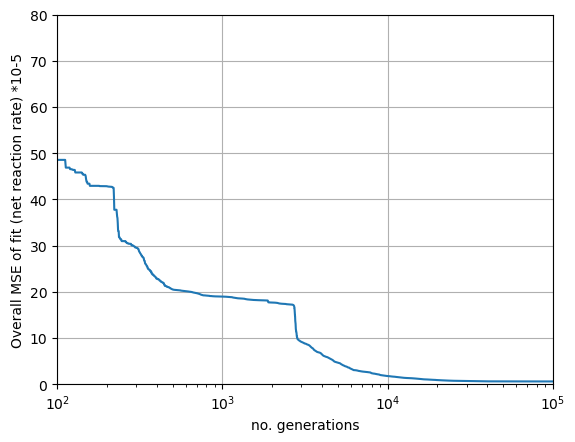

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900763137561736
-8.401019748808878
-7.601273648337684
-8.800592375818788
-8.301382073959909
-7.107059351976356
-8.0984210317812
-10.450877024186564
-7.706474205337233
-6.80582907236186
-7.306583756066894
-8.005365183709523
-7.908860833235455
-6.803300675198513
-7.403263705847474
-7.406178198188489
-7.900121644371212
-9.09877785872273
-8.388040775600832
-6.50160906702482
-7.301631150428309
-6.708298925517989
-7.508344739246475
-11.999711192677045
-7.304128160691799
-7.804206162326623
-1.3010299999024693


In [37]:
res.X

array([ -7.90076314,  -8.40101975,  -7.60127365,  -8.80059238,
        -8.30138207,  -7.10705935,  -8.09842103, -10.45087702,
        -7.70647421,  -6.80582907,  -7.30658376,  -8.00536518,
        -7.90886083,  -6.80330068,  -7.40326371,  -7.4061782 ,
        -7.90012164,  -9.09877786,  -8.38804078,  -6.50160907,
        -7.30163115,  -6.70829893,  -7.50834474, -11.99971119,
        -7.30412816,  -7.80420616,  -1.30103   ])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900763137561736
-8.4: -8.401019748808878
-7.6: -7.601273648337684
-8.8: -8.800592375818788
-8.3: -8.301382073959909
-7.1: -7.107059351976356
-8.1: -8.0984210317812
-10.9: -10.450877024186564
-7.7: -7.706474205337233
-6.8: -6.80582907236186
-7.3: -7.306583756066894
-8.0: -8.005365183709523
-7.9: -7.908860833235455
-6.8: -6.803300675198513
-7.4: -7.403263705847474
-7.4: -7.406178198188489
-7.9: -7.900121644371212
-9.1: -9.09877785872273
-8.4: -8.388040775600832
-6.5: -6.50160906702482
-7.3: -7.301631150428309
-6.7: -6.708298925517989
-7.5: -7.508344739246475
-11.8: -11.999711192677045
-7.3: -7.304128160691799
-7.8: -7.804206162326623
R-value: 0.9965766892413233
R2: 0.993165097539197


In [1]:
# Use stored solution
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds

krseed1 = [ -7.90076314,  -8.40101975,  -7.60127365,  -8.80059238,
        -8.30138207,  -7.10705935,  -8.09842103, -10.45087702,
        -7.70647421,  -6.80582907,  -7.30658376,  -8.00536518,
        -7.90886083,  -6.80330068,  -7.40326371,  -7.4061782 ,
        -7.90012164,  -9.09877786,  -8.38804078,  -6.50160907,
        -7.30163115,  -6.70829893,  -7.50834474, -11.99971119,
        -7.30412816,  -7.80420616,  -1.30103   ]
#np.ndarray.tolist(res.X)
krseed10 = [ -7.9007674 ,  -8.40102744,  -7.6012845 ,  -8.8005615 ,
        -8.30139939,  -7.10713253,  -8.09841313, -10.44578408,
        -7.70654002,  -6.80584277,  -7.30659694,  -8.00540221,
        -7.90886567,  -6.80334792,  -7.40331099,  -7.40625368,
        -7.90016507,  -9.09888563,  -8.38801248,  -6.50166198,
        -7.30168448,  -6.70866115,  -7.50871023, -11.99969001,
        -7.30426883,  -7.80435035,  -1.30103   ]
krseed101 = [ -7.90075698,  -8.40101184,  -7.60128404,  -8.80058479,
        -8.3013949 ,  -7.10714764,  -8.09839339, -10.44343402,
        -7.70655091,  -6.8058449 ,  -7.30659666,  -8.00539706,
        -7.90886237,  -6.80336305,  -7.40332586,  -7.40628709,
        -7.90017644,  -9.09869318,  -8.38800699,  -6.50166054,
        -7.3016828 ,  -6.70881154,  -7.50886192, -11.99967834,
        -7.30427614,  -7.80435605,  -1.30103   ]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9930584758974509
r: 0.9965231938582518
-7.900762506666666
-8.401019676666666
-7.60128073
-8.800579556666667
-8.301392120000001
-7.107113173333334
-8.098409183333333
-10.446698373333334
-7.706521713333333
-6.805838913333333
-7.306592453333334
-8.00538815
-7.908862956666667
-6.803337216666667
-7.403300186666666
-7.406239656666667
-7.900154383333334
-9.098785556666668
-8.388020083333332
-6.501643863333332
-7.301666143333333
-6.708590539999999
-7.5086389633333335
-11.999693180000001
-7.304224376666666
-7.804304186666666


In [2]:
meankr

[-7.900762506666666,
 -8.401019676666666,
 -7.60128073,
 -8.800579556666667,
 -8.301392120000001,
 -7.107113173333334,
 -8.098409183333333,
 -10.446698373333334,
 -7.706521713333333,
 -6.805838913333333,
 -7.306592453333334,
 -8.00538815,
 -7.908862956666667,
 -6.803337216666667,
 -7.403300186666666,
 -7.406239656666667,
 -7.900154383333334,
 -9.098785556666668,
 -8.388020083333332,
 -6.501643863333332,
 -7.301666143333333,
 -6.708590539999999,
 -7.5086389633333335,
 -11.999693180000001,
 -7.304224376666666,
 -7.804304186666666]

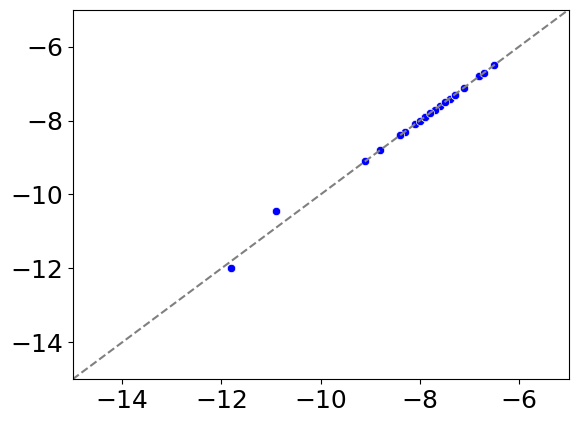

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, -5])
plt.ylim([-15, -5])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()